# K-Fold CV for Boosting Methods Using SKLearn 

In [24]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random

In [25]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [27]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.22it/s]


In [28]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [29]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [30]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'Rhythm', 'Subject'],
      dtype='object')


# Extreme Gradient Boosting

# CatBoosting

In [31]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


0:	learn: 0.6162908	total: 18.1ms	remaining: 1.88s
1:	learn: 0.5535456	total: 21.7ms	remaining: 1.12s
2:	learn: 0.5006991	total: 25.2ms	remaining: 857ms
3:	learn: 0.4556473	total: 28.6ms	remaining: 723ms
4:	learn: 0.4168442	total: 32.1ms	remaining: 643ms
5:	learn: 0.3841750	total: 35.8ms	remaining: 590ms
6:	learn: 0.3552590	total: 39.2ms	remaining: 549ms
7:	learn: 0.3299412	total: 42.6ms	remaining: 517ms
8:	learn: 0.3079267	total: 46.1ms	remaining: 492ms
9:	learn: 0.2879759	total: 49.3ms	remaining: 468ms
10:	learn: 0.2707337	total: 52.5ms	remaining: 449ms
11:	learn: 0.2548095	total: 55.5ms	remaining: 430ms
12:	learn: 0.2408187	total: 58.8ms	remaining: 416ms
13:	learn: 0.2287592	total: 61.9ms	remaining: 402ms
14:	learn: 0.2179644	total: 65ms	remaining: 390ms
15:	learn: 0.2082532	total: 68ms	remaining: 378ms
16:	learn: 0.1997884	total: 71ms	remaining: 368ms
17:	learn: 0.1915330	total: 74ms	remaining: 358ms
18:	learn: 0.1844304	total: 77ms	remaining: 349ms
19:	learn: 0.1784240	total: 80.1

80:	learn: 0.1016423	total: 253ms	remaining: 75ms
81:	learn: 0.1013272	total: 257ms	remaining: 72ms
82:	learn: 0.1009920	total: 260ms	remaining: 68.9ms
83:	learn: 0.1008192	total: 263ms	remaining: 65.7ms
84:	learn: 0.1006751	total: 266ms	remaining: 62.5ms
85:	learn: 0.1005232	total: 269ms	remaining: 59.4ms
86:	learn: 0.1003416	total: 272ms	remaining: 56.2ms
87:	learn: 0.1002014	total: 275ms	remaining: 53.1ms
88:	learn: 0.0998657	total: 278ms	remaining: 50ms
89:	learn: 0.0996344	total: 281ms	remaining: 46.9ms
90:	learn: 0.0992950	total: 285ms	remaining: 43.8ms
91:	learn: 0.0989045	total: 288ms	remaining: 40.6ms
92:	learn: 0.0987382	total: 291ms	remaining: 37.5ms
93:	learn: 0.0985214	total: 293ms	remaining: 34.3ms
94:	learn: 0.0984156	total: 296ms	remaining: 31.2ms
95:	learn: 0.0982393	total: 299ms	remaining: 28ms
96:	learn: 0.0978713	total: 302ms	remaining: 24.9ms
97:	learn: 0.0976415	total: 305ms	remaining: 21.8ms
98:	learn: 0.0973518	total: 308ms	remaining: 18.7ms
99:	learn: 0.0968758

44:	learn: 0.1010089	total: 146ms	remaining: 195ms
45:	learn: 0.1000744	total: 150ms	remaining: 192ms
46:	learn: 0.0994914	total: 153ms	remaining: 188ms
47:	learn: 0.0988054	total: 156ms	remaining: 185ms
48:	learn: 0.0979999	total: 160ms	remaining: 182ms
49:	learn: 0.0974407	total: 163ms	remaining: 179ms
50:	learn: 0.0970148	total: 166ms	remaining: 175ms
51:	learn: 0.0964684	total: 169ms	remaining: 172ms
52:	learn: 0.0960188	total: 172ms	remaining: 168ms
53:	learn: 0.0957867	total: 174ms	remaining: 165ms
54:	learn: 0.0954121	total: 177ms	remaining: 161ms
55:	learn: 0.0949418	total: 180ms	remaining: 158ms
56:	learn: 0.0944642	total: 184ms	remaining: 155ms
57:	learn: 0.0941107	total: 186ms	remaining: 151ms
58:	learn: 0.0936472	total: 189ms	remaining: 148ms
59:	learn: 0.0932566	total: 192ms	remaining: 144ms
60:	learn: 0.0929409	total: 195ms	remaining: 141ms
61:	learn: 0.0927789	total: 198ms	remaining: 137ms
62:	learn: 0.0923921	total: 201ms	remaining: 134ms
63:	learn: 0.0919482	total: 204

3:	learn: 0.4547924	total: 89.5ms	remaining: 1.93s
4:	learn: 0.4160928	total: 99.8ms	remaining: 1.7s
5:	learn: 0.3833085	total: 108ms	remaining: 1.51s
6:	learn: 0.3544165	total: 114ms	remaining: 1.35s
7:	learn: 0.3287311	total: 120ms	remaining: 1.23s
8:	learn: 0.3064103	total: 126ms	remaining: 1.13s
9:	learn: 0.2861835	total: 130ms	remaining: 1.04s
10:	learn: 0.2685649	total: 135ms	remaining: 969ms
11:	learn: 0.2531470	total: 139ms	remaining: 905ms
12:	learn: 0.2389615	total: 143ms	remaining: 849ms
13:	learn: 0.2264761	total: 147ms	remaining: 801ms
14:	learn: 0.2160124	total: 152ms	remaining: 758ms
15:	learn: 0.2057946	total: 156ms	remaining: 720ms
16:	learn: 0.1966855	total: 160ms	remaining: 686ms
17:	learn: 0.1888808	total: 164ms	remaining: 655ms
18:	learn: 0.1818148	total: 168ms	remaining: 627ms
19:	learn: 0.1749031	total: 172ms	remaining: 601ms
20:	learn: 0.1687287	total: 176ms	remaining: 577ms
21:	learn: 0.1629954	total: 180ms	remaining: 556ms
22:	learn: 0.1580725	total: 184ms	rem

86:	learn: 0.0973867	total: 419ms	remaining: 14.5ms
87:	learn: 0.0969118	total: 424ms	remaining: 9.63ms
88:	learn: 0.0966359	total: 428ms	remaining: 4.81ms
89:	learn: 0.0965438	total: 432ms	remaining: 0us
0:	learn: 0.6153046	total: 35.1ms	remaining: 3.12s
1:	learn: 0.5499146	total: 50.8ms	remaining: 2.23s
2:	learn: 0.4966338	total: 60.7ms	remaining: 1.76s
3:	learn: 0.4505606	total: 65.6ms	remaining: 1.41s
4:	learn: 0.4111108	total: 69.5ms	remaining: 1.18s
5:	learn: 0.3773832	total: 73.6ms	remaining: 1.03s
6:	learn: 0.3486989	total: 77.7ms	remaining: 922ms
7:	learn: 0.3228977	total: 81.8ms	remaining: 838ms
8:	learn: 0.3005681	total: 85.9ms	remaining: 773ms
9:	learn: 0.2805269	total: 89.9ms	remaining: 720ms
10:	learn: 0.2625379	total: 94.3ms	remaining: 677ms
11:	learn: 0.2470285	total: 98.3ms	remaining: 639ms
12:	learn: 0.2329034	total: 102ms	remaining: 606ms
13:	learn: 0.2206050	total: 106ms	remaining: 577ms
14:	learn: 0.2096914	total: 111ms	remaining: 553ms
15:	learn: 0.1998893	total: 

7:	learn: 0.3382763	total: 38.3ms	remaining: 392ms
8:	learn: 0.3169304	total: 42.6ms	remaining: 383ms
9:	learn: 0.2981584	total: 46.9ms	remaining: 375ms
10:	learn: 0.2810652	total: 51.3ms	remaining: 369ms
11:	learn: 0.2662159	total: 55.9ms	remaining: 363ms
12:	learn: 0.2523999	total: 60.8ms	remaining: 360ms
13:	learn: 0.2404248	total: 65.3ms	remaining: 354ms
14:	learn: 0.2303217	total: 69.7ms	remaining: 348ms
15:	learn: 0.2211370	total: 73.9ms	remaining: 342ms
16:	learn: 0.2123375	total: 78.5ms	remaining: 337ms
17:	learn: 0.2050342	total: 82.5ms	remaining: 330ms
18:	learn: 0.1976934	total: 86.6ms	remaining: 324ms
19:	learn: 0.1916833	total: 90.6ms	remaining: 317ms
20:	learn: 0.1857487	total: 95.2ms	remaining: 313ms
21:	learn: 0.1805314	total: 99.4ms	remaining: 307ms
22:	learn: 0.1759044	total: 104ms	remaining: 302ms
23:	learn: 0.1714163	total: 108ms	remaining: 297ms
24:	learn: 0.1670990	total: 112ms	remaining: 292ms
25:	learn: 0.1638151	total: 116ms	remaining: 286ms
26:	learn: 0.160228

36:	learn: 0.1337134	total: 101ms	remaining: 154ms
37:	learn: 0.1319976	total: 104ms	remaining: 151ms
38:	learn: 0.1302725	total: 107ms	remaining: 148ms
39:	learn: 0.1288949	total: 109ms	remaining: 145ms
40:	learn: 0.1275901	total: 112ms	remaining: 142ms
41:	learn: 0.1264287	total: 114ms	remaining: 139ms
42:	learn: 0.1252396	total: 117ms	remaining: 136ms
43:	learn: 0.1241915	total: 119ms	remaining: 133ms
44:	learn: 0.1234026	total: 122ms	remaining: 130ms
45:	learn: 0.1225184	total: 125ms	remaining: 127ms
46:	learn: 0.1217357	total: 127ms	remaining: 125ms
47:	learn: 0.1208504	total: 130ms	remaining: 122ms
48:	learn: 0.1198674	total: 133ms	remaining: 119ms
49:	learn: 0.1192735	total: 135ms	remaining: 116ms
50:	learn: 0.1185274	total: 138ms	remaining: 114ms
51:	learn: 0.1177349	total: 140ms	remaining: 111ms
52:	learn: 0.1171311	total: 143ms	remaining: 108ms
53:	learn: 0.1165316	total: 145ms	remaining: 105ms
54:	learn: 0.1161189	total: 147ms	remaining: 102ms
55:	learn: 0.1156531	total: 150

42:	learn: 0.1066837	total: 112ms	remaining: 131ms
43:	learn: 0.1058284	total: 115ms	remaining: 128ms
44:	learn: 0.1052675	total: 117ms	remaining: 125ms
45:	learn: 0.1044555	total: 120ms	remaining: 122ms
46:	learn: 0.1036893	total: 122ms	remaining: 119ms
47:	learn: 0.1030517	total: 124ms	remaining: 117ms
48:	learn: 0.1023110	total: 127ms	remaining: 114ms
49:	learn: 0.1016067	total: 130ms	remaining: 111ms
50:	learn: 0.1009211	total: 132ms	remaining: 109ms
51:	learn: 0.1001187	total: 135ms	remaining: 106ms
52:	learn: 0.0994354	total: 138ms	remaining: 104ms
53:	learn: 0.0988460	total: 140ms	remaining: 101ms
54:	learn: 0.0983681	total: 143ms	remaining: 98.8ms
55:	learn: 0.0981423	total: 145ms	remaining: 96ms
56:	learn: 0.0975365	total: 148ms	remaining: 93.3ms
57:	learn: 0.0968804	total: 150ms	remaining: 90.6ms
58:	learn: 0.0965135	total: 152ms	remaining: 87.8ms
59:	learn: 0.0962031	total: 155ms	remaining: 85.1ms
60:	learn: 0.0957868	total: 157ms	remaining: 82.4ms
61:	learn: 0.0954636	total

74:	learn: 0.1141132	total: 141ms	remaining: 63.8ms
75:	learn: 0.1136923	total: 143ms	remaining: 62.1ms
76:	learn: 0.1134658	total: 145ms	remaining: 60.1ms
77:	learn: 0.1131307	total: 146ms	remaining: 58.2ms
78:	learn: 0.1129354	total: 148ms	remaining: 56.2ms
79:	learn: 0.1126802	total: 150ms	remaining: 54.3ms
80:	learn: 0.1124491	total: 152ms	remaining: 52.4ms
81:	learn: 0.1120913	total: 153ms	remaining: 50.5ms
82:	learn: 0.1116831	total: 156ms	remaining: 48.7ms
83:	learn: 0.1114648	total: 157ms	remaining: 46.8ms
84:	learn: 0.1110222	total: 159ms	remaining: 44.9ms
85:	learn: 0.1106786	total: 161ms	remaining: 43.1ms
86:	learn: 0.1103361	total: 163ms	remaining: 41.2ms
87:	learn: 0.1100561	total: 165ms	remaining: 39.3ms
88:	learn: 0.1096528	total: 167ms	remaining: 37.5ms
89:	learn: 0.1095669	total: 168ms	remaining: 35.5ms
90:	learn: 0.1093987	total: 170ms	remaining: 33.7ms
91:	learn: 0.1092232	total: 172ms	remaining: 31.8ms
92:	learn: 0.1089810	total: 174ms	remaining: 29.9ms
93:	learn: 0

41:	learn: 0.1271021	total: 78.8ms	remaining: 126ms
42:	learn: 0.1261460	total: 80.9ms	remaining: 124ms
43:	learn: 0.1252268	total: 83.1ms	remaining: 123ms
44:	learn: 0.1240843	total: 85ms	remaining: 121ms
45:	learn: 0.1231457	total: 87ms	remaining: 119ms
46:	learn: 0.1222386	total: 88.9ms	remaining: 117ms
47:	learn: 0.1214868	total: 91ms	remaining: 116ms
48:	learn: 0.1207732	total: 92.8ms	remaining: 114ms
49:	learn: 0.1201813	total: 94.7ms	remaining: 112ms
50:	learn: 0.1196406	total: 96.4ms	remaining: 110ms
51:	learn: 0.1191266	total: 98.5ms	remaining: 108ms
52:	learn: 0.1183071	total: 100ms	remaining: 106ms
53:	learn: 0.1178443	total: 102ms	remaining: 104ms
54:	learn: 0.1173420	total: 104ms	remaining: 102ms
55:	learn: 0.1166674	total: 106ms	remaining: 100ms
56:	learn: 0.1162213	total: 107ms	remaining: 98ms
57:	learn: 0.1156992	total: 109ms	remaining: 96ms
58:	learn: 0.1152247	total: 111ms	remaining: 94.1ms
59:	learn: 0.1147576	total: 113ms	remaining: 92.2ms
60:	learn: 0.1144731	total

0:	learn: 0.6205396	total: 38.1ms	remaining: 4.11s
1:	learn: 0.5604613	total: 49.4ms	remaining: 2.64s
2:	learn: 0.5106662	total: 60.4ms	remaining: 2.13s
3:	learn: 0.4690466	total: 67.5ms	remaining: 1.77s
4:	learn: 0.4336989	total: 71.5ms	remaining: 1.49s
5:	learn: 0.4023643	total: 73.4ms	remaining: 1.26s
6:	learn: 0.3755894	total: 75.2ms	remaining: 1.09s
7:	learn: 0.3522186	total: 77.1ms	remaining: 974ms
8:	learn: 0.3312349	total: 79ms	remaining: 877ms
9:	learn: 0.3125630	total: 80.8ms	remaining: 800ms
10:	learn: 0.2972313	total: 82.5ms	remaining: 735ms
11:	learn: 0.2831968	total: 84.4ms	remaining: 682ms
12:	learn: 0.2702769	total: 86.5ms	remaining: 639ms
13:	learn: 0.2585648	total: 88.4ms	remaining: 600ms
14:	learn: 0.2483781	total: 90.4ms	remaining: 566ms
15:	learn: 0.2391379	total: 92.2ms	remaining: 536ms
16:	learn: 0.2308802	total: 94ms	remaining: 509ms
17:	learn: 0.2237369	total: 95.8ms	remaining: 484ms
18:	learn: 0.2173996	total: 97.5ms	remaining: 462ms
19:	learn: 0.2112049	total

67:	learn: 0.1014333	total: 364ms	remaining: 214ms
68:	learn: 0.1012368	total: 368ms	remaining: 208ms
69:	learn: 0.1010279	total: 372ms	remaining: 202ms
70:	learn: 0.1008690	total: 377ms	remaining: 196ms
71:	learn: 0.1004823	total: 381ms	remaining: 191ms
72:	learn: 0.1003190	total: 385ms	remaining: 185ms
73:	learn: 0.1001290	total: 389ms	remaining: 179ms
74:	learn: 0.0998035	total: 393ms	remaining: 173ms
75:	learn: 0.0993091	total: 397ms	remaining: 167ms
76:	learn: 0.0991551	total: 401ms	remaining: 162ms
77:	learn: 0.0989417	total: 405ms	remaining: 156ms
78:	learn: 0.0988119	total: 409ms	remaining: 150ms
79:	learn: 0.0983498	total: 413ms	remaining: 145ms
80:	learn: 0.0979463	total: 417ms	remaining: 139ms
81:	learn: 0.0975490	total: 421ms	remaining: 134ms
82:	learn: 0.0972181	total: 425ms	remaining: 128ms
83:	learn: 0.0967749	total: 429ms	remaining: 123ms
84:	learn: 0.0964683	total: 433ms	remaining: 117ms
85:	learn: 0.0963350	total: 437ms	remaining: 112ms
86:	learn: 0.0959420	total: 441

32:	learn: 0.1239603	total: 139ms	remaining: 315ms
33:	learn: 0.1218072	total: 143ms	remaining: 312ms
34:	learn: 0.1201321	total: 148ms	remaining: 309ms
35:	learn: 0.1185161	total: 153ms	remaining: 305ms
36:	learn: 0.1170052	total: 157ms	remaining: 302ms
37:	learn: 0.1157981	total: 161ms	remaining: 297ms
38:	learn: 0.1146073	total: 166ms	remaining: 293ms
39:	learn: 0.1134567	total: 170ms	remaining: 289ms
40:	learn: 0.1123880	total: 174ms	remaining: 285ms
41:	learn: 0.1116635	total: 179ms	remaining: 281ms
42:	learn: 0.1107375	total: 183ms	remaining: 276ms
43:	learn: 0.1099015	total: 187ms	remaining: 272ms
44:	learn: 0.1092056	total: 191ms	remaining: 267ms
45:	learn: 0.1083693	total: 195ms	remaining: 263ms
46:	learn: 0.1076602	total: 199ms	remaining: 258ms
47:	learn: 0.1070660	total: 203ms	remaining: 254ms
48:	learn: 0.1062335	total: 207ms	remaining: 249ms
49:	learn: 0.1055817	total: 211ms	remaining: 245ms
50:	learn: 0.1049739	total: 215ms	remaining: 241ms
51:	learn: 0.1044029	total: 219

94:	learn: 0.0809111	total: 462ms	remaining: 63.2ms
95:	learn: 0.0806823	total: 466ms	remaining: 58.3ms
96:	learn: 0.0805973	total: 470ms	remaining: 53.3ms
97:	learn: 0.0803825	total: 475ms	remaining: 48.4ms
98:	learn: 0.0802755	total: 479ms	remaining: 43.5ms
99:	learn: 0.0800360	total: 484ms	remaining: 38.7ms
100:	learn: 0.0798920	total: 488ms	remaining: 33.8ms
101:	learn: 0.0796930	total: 492ms	remaining: 29ms
102:	learn: 0.0795375	total: 496ms	remaining: 24.1ms
103:	learn: 0.0792943	total: 501ms	remaining: 19.3ms
104:	learn: 0.0791873	total: 505ms	remaining: 14.4ms
105:	learn: 0.0790046	total: 509ms	remaining: 9.61ms
106:	learn: 0.0788496	total: 513ms	remaining: 4.8ms
107:	learn: 0.0786711	total: 518ms	remaining: 0us
0:	learn: 0.6177646	total: 6.39ms	remaining: 684ms
1:	learn: 0.5570749	total: 10.7ms	remaining: 565ms
2:	learn: 0.5042569	total: 15.1ms	remaining: 530ms
3:	learn: 0.4609540	total: 19.7ms	remaining: 512ms
4:	learn: 0.4239197	total: 24.2ms	remaining: 498ms
5:	learn: 0.390

57:	learn: 0.1078558	total: 242ms	remaining: 158ms
58:	learn: 0.1072778	total: 246ms	remaining: 154ms
59:	learn: 0.1068151	total: 249ms	remaining: 150ms
60:	learn: 0.1064503	total: 252ms	remaining: 145ms
61:	learn: 0.1060103	total: 256ms	remaining: 140ms
62:	learn: 0.1053467	total: 259ms	remaining: 136ms
63:	learn: 0.1048262	total: 263ms	remaining: 131ms
64:	learn: 0.1043021	total: 266ms	remaining: 127ms
65:	learn: 0.1041291	total: 270ms	remaining: 123ms
66:	learn: 0.1036509	total: 273ms	remaining: 118ms
67:	learn: 0.1032936	total: 277ms	remaining: 114ms
68:	learn: 0.1031177	total: 280ms	remaining: 110ms
69:	learn: 0.1027290	total: 283ms	remaining: 105ms
70:	learn: 0.1024667	total: 286ms	remaining: 101ms
71:	learn: 0.1021140	total: 289ms	remaining: 96.5ms
72:	learn: 0.1019505	total: 293ms	remaining: 92.3ms
73:	learn: 0.1016648	total: 297ms	remaining: 88.2ms
74:	learn: 0.1014403	total: 300ms	remaining: 84ms
75:	learn: 0.1009965	total: 303ms	remaining: 79.8ms
76:	learn: 0.1007531	total: 

70:	learn: 0.0998162	total: 286ms	remaining: 101ms
71:	learn: 0.0996151	total: 289ms	remaining: 96.4ms
72:	learn: 0.0994601	total: 292ms	remaining: 92ms
73:	learn: 0.0991574	total: 296ms	remaining: 87.9ms
74:	learn: 0.0988272	total: 299ms	remaining: 83.8ms
75:	learn: 0.0984440	total: 303ms	remaining: 79.7ms
76:	learn: 0.0982573	total: 306ms	remaining: 75.5ms
77:	learn: 0.0978688	total: 309ms	remaining: 71.3ms
78:	learn: 0.0976029	total: 312ms	remaining: 67.1ms
79:	learn: 0.0972435	total: 315ms	remaining: 63ms
80:	learn: 0.0970249	total: 318ms	remaining: 59ms
81:	learn: 0.0966234	total: 322ms	remaining: 54.9ms
82:	learn: 0.0964352	total: 325ms	remaining: 50.8ms
83:	learn: 0.0961038	total: 328ms	remaining: 46.8ms
84:	learn: 0.0960043	total: 330ms	remaining: 42.8ms
85:	learn: 0.0959098	total: 334ms	remaining: 38.8ms
86:	learn: 0.0957302	total: 337ms	remaining: 34.9ms
87:	learn: 0.0954504	total: 340ms	remaining: 30.9ms
88:	learn: 0.0952259	total: 343ms	remaining: 27ms
89:	learn: 0.0951140	

42:	learn: 0.1359967	total: 143ms	remaining: 176ms
43:	learn: 0.1352585	total: 146ms	remaining: 173ms
44:	learn: 0.1343569	total: 149ms	remaining: 169ms
45:	learn: 0.1336500	total: 153ms	remaining: 166ms
46:	learn: 0.1327651	total: 156ms	remaining: 163ms
47:	learn: 0.1318121	total: 159ms	remaining: 159ms
48:	learn: 0.1311282	total: 163ms	remaining: 156ms
49:	learn: 0.1306030	total: 166ms	remaining: 152ms
50:	learn: 0.1298864	total: 169ms	remaining: 149ms
51:	learn: 0.1291152	total: 171ms	remaining: 145ms
52:	learn: 0.1286488	total: 175ms	remaining: 142ms
53:	learn: 0.1280327	total: 178ms	remaining: 139ms
54:	learn: 0.1271604	total: 181ms	remaining: 135ms
55:	learn: 0.1263238	total: 184ms	remaining: 132ms
56:	learn: 0.1258534	total: 187ms	remaining: 128ms
57:	learn: 0.1254008	total: 191ms	remaining: 125ms
58:	learn: 0.1249687	total: 194ms	remaining: 122ms
59:	learn: 0.1245476	total: 197ms	remaining: 118ms
60:	learn: 0.1238156	total: 200ms	remaining: 115ms
61:	learn: 0.1234509	total: 203

30:	learn: 0.1703869	total: 47.2ms	remaining: 108ms
31:	learn: 0.1677098	total: 49ms	remaining: 107ms
32:	learn: 0.1659034	total: 50.7ms	remaining: 106ms
33:	learn: 0.1632230	total: 52.4ms	remaining: 105ms
34:	learn: 0.1611158	total: 54.2ms	remaining: 104ms
35:	learn: 0.1590681	total: 55.8ms	remaining: 102ms
36:	learn: 0.1569459	total: 57.7ms	remaining: 101ms
37:	learn: 0.1551796	total: 59.3ms	remaining: 99.8ms
38:	learn: 0.1540282	total: 60.7ms	remaining: 98ms
39:	learn: 0.1524103	total: 62.3ms	remaining: 96.6ms
40:	learn: 0.1508957	total: 63.8ms	remaining: 94.9ms
41:	learn: 0.1496251	total: 65.2ms	remaining: 93.2ms
42:	learn: 0.1483787	total: 67.1ms	remaining: 92.1ms
43:	learn: 0.1473642	total: 68.8ms	remaining: 90.7ms
44:	learn: 0.1464249	total: 70.4ms	remaining: 89.1ms
45:	learn: 0.1453758	total: 71.9ms	remaining: 87.5ms
46:	learn: 0.1442552	total: 73.4ms	remaining: 85.9ms
47:	learn: 0.1431274	total: 75ms	remaining: 84.4ms
48:	learn: 0.1422933	total: 76.5ms	remaining: 82.8ms
49:	le

50:	learn: 0.1145009	total: 80.5ms	remaining: 80.5ms
51:	learn: 0.1138404	total: 82.2ms	remaining: 79ms
52:	learn: 0.1134041	total: 83.8ms	remaining: 77.5ms
53:	learn: 0.1129281	total: 85.4ms	remaining: 76ms
54:	learn: 0.1120636	total: 87ms	remaining: 74.4ms
55:	learn: 0.1116197	total: 88.6ms	remaining: 72.8ms
56:	learn: 0.1110389	total: 90.4ms	remaining: 71.4ms
57:	learn: 0.1107517	total: 91.9ms	remaining: 69.7ms
58:	learn: 0.1104572	total: 93.6ms	remaining: 68.2ms
59:	learn: 0.1096237	total: 95.3ms	remaining: 66.7ms
60:	learn: 0.1093812	total: 96.9ms	remaining: 65.2ms
61:	learn: 0.1088329	total: 98.5ms	remaining: 63.6ms
62:	learn: 0.1084690	total: 99.9ms	remaining: 61.9ms
63:	learn: 0.1081685	total: 101ms	remaining: 60.2ms
64:	learn: 0.1076595	total: 103ms	remaining: 58.6ms
65:	learn: 0.1074013	total: 104ms	remaining: 56.9ms
66:	learn: 0.1071213	total: 106ms	remaining: 55.6ms
67:	learn: 0.1067380	total: 108ms	remaining: 54ms
68:	learn: 0.1064332	total: 110ms	remaining: 52.4ms
69:	lea

42:	learn: 0.1274684	total: 93.3ms	remaining: 104ms
43:	learn: 0.1262495	total: 95.6ms	remaining: 102ms
44:	learn: 0.1253244	total: 97.9ms	remaining: 100ms
45:	learn: 0.1242019	total: 100ms	remaining: 98ms
46:	learn: 0.1234835	total: 103ms	remaining: 96ms
47:	learn: 0.1223539	total: 105ms	remaining: 93.7ms
48:	learn: 0.1215053	total: 107ms	remaining: 91.4ms
49:	learn: 0.1207801	total: 109ms	remaining: 89.4ms
50:	learn: 0.1201790	total: 111ms	remaining: 87.1ms
51:	learn: 0.1194415	total: 113ms	remaining: 84.8ms
52:	learn: 0.1188839	total: 115ms	remaining: 82.4ms
53:	learn: 0.1183336	total: 117ms	remaining: 80.1ms
54:	learn: 0.1176819	total: 119ms	remaining: 77.9ms
55:	learn: 0.1170719	total: 121ms	remaining: 75.6ms
56:	learn: 0.1163339	total: 123ms	remaining: 73.5ms
57:	learn: 0.1157397	total: 126ms	remaining: 71.5ms
58:	learn: 0.1152915	total: 128ms	remaining: 69.4ms
59:	learn: 0.1148181	total: 130ms	remaining: 67.1ms
60:	learn: 0.1144841	total: 132ms	remaining: 64.8ms
61:	learn: 0.113

0:	learn: 0.6135948	total: 8.93ms	remaining: 804ms
1:	learn: 0.5484785	total: 11.1ms	remaining: 494ms
2:	learn: 0.4959110	total: 13.2ms	remaining: 386ms
3:	learn: 0.4499119	total: 15.7ms	remaining: 342ms
4:	learn: 0.4103033	total: 18.1ms	remaining: 311ms
5:	learn: 0.3760404	total: 20.2ms	remaining: 286ms
6:	learn: 0.3465360	total: 22.3ms	remaining: 268ms
7:	learn: 0.3205101	total: 24.3ms	remaining: 252ms
8:	learn: 0.2982548	total: 26.4ms	remaining: 240ms
9:	learn: 0.2781515	total: 28.4ms	remaining: 230ms
10:	learn: 0.2608503	total: 30.8ms	remaining: 224ms
11:	learn: 0.2453958	total: 33.3ms	remaining: 220ms
12:	learn: 0.2313031	total: 35.6ms	remaining: 213ms
13:	learn: 0.2187603	total: 37.9ms	remaining: 209ms
14:	learn: 0.2071976	total: 40ms	remaining: 203ms
15:	learn: 0.1980558	total: 42.2ms	remaining: 198ms
16:	learn: 0.1890572	total: 44.4ms	remaining: 193ms
17:	learn: 0.1813891	total: 47ms	remaining: 191ms
18:	learn: 0.1740564	total: 49.6ms	remaining: 188ms
19:	learn: 0.1676240	total

0:	learn: 0.6161020	total: 11.1ms	remaining: 1.07s
1:	learn: 0.5543053	total: 17.7ms	remaining: 840ms
2:	learn: 0.5020471	total: 25.3ms	remaining: 794ms
3:	learn: 0.4566728	total: 32ms	remaining: 744ms
4:	learn: 0.4169429	total: 39ms	remaining: 718ms
5:	learn: 0.3826711	total: 46ms	remaining: 697ms
6:	learn: 0.3539312	total: 52.3ms	remaining: 673ms
7:	learn: 0.3277916	total: 59.3ms	remaining: 659ms
8:	learn: 0.3059968	total: 65.5ms	remaining: 641ms
9:	learn: 0.2857165	total: 72.3ms	remaining: 629ms
10:	learn: 0.2681091	total: 79ms	remaining: 618ms
11:	learn: 0.2525738	total: 85.3ms	remaining: 604ms
12:	learn: 0.2380953	total: 92.4ms	remaining: 597ms
13:	learn: 0.2257986	total: 98.6ms	remaining: 585ms
14:	learn: 0.2143586	total: 106ms	remaining: 578ms
15:	learn: 0.2039081	total: 112ms	remaining: 568ms
16:	learn: 0.1950810	total: 119ms	remaining: 558ms
17:	learn: 0.1872859	total: 126ms	remaining: 551ms
18:	learn: 0.1801903	total: 132ms	remaining: 543ms
19:	learn: 0.1735302	total: 139ms	r

96:	learn: 0.0919469	total: 687ms	remaining: 0us
0:	learn: 0.6153292	total: 47ms	remaining: 4.51s
1:	learn: 0.5501329	total: 76.1ms	remaining: 3.61s
2:	learn: 0.4961373	total: 91.1ms	remaining: 2.85s
3:	learn: 0.4506435	total: 102ms	remaining: 2.37s
4:	learn: 0.4114102	total: 109ms	remaining: 2.01s
5:	learn: 0.3772799	total: 117ms	remaining: 1.77s
6:	learn: 0.3479361	total: 124ms	remaining: 1.59s
7:	learn: 0.3225029	total: 131ms	remaining: 1.45s
8:	learn: 0.3000424	total: 137ms	remaining: 1.34s
9:	learn: 0.2805857	total: 144ms	remaining: 1.25s
10:	learn: 0.2633103	total: 152ms	remaining: 1.18s
11:	learn: 0.2478407	total: 159ms	remaining: 1.12s
12:	learn: 0.2338087	total: 166ms	remaining: 1.07s
13:	learn: 0.2213821	total: 172ms	remaining: 1.02s
14:	learn: 0.2099591	total: 179ms	remaining: 981ms
15:	learn: 0.1996396	total: 187ms	remaining: 947ms
16:	learn: 0.1906469	total: 195ms	remaining: 918ms
17:	learn: 0.1824110	total: 204ms	remaining: 894ms
18:	learn: 0.1749584	total: 211ms	remainin

94:	learn: 0.0792638	total: 687ms	remaining: 14.5ms
95:	learn: 0.0788701	total: 694ms	remaining: 7.23ms
96:	learn: 0.0786353	total: 701ms	remaining: 0us
0:	learn: 0.6178058	total: 17.3ms	remaining: 1.66s
1:	learn: 0.5571043	total: 23.6ms	remaining: 1.12s
2:	learn: 0.5070915	total: 30ms	remaining: 940ms
3:	learn: 0.4624689	total: 37ms	remaining: 860ms
4:	learn: 0.4247748	total: 43.9ms	remaining: 809ms
5:	learn: 0.3912227	total: 50.8ms	remaining: 771ms
6:	learn: 0.3623680	total: 57.3ms	remaining: 737ms
7:	learn: 0.3372723	total: 63.8ms	remaining: 709ms
8:	learn: 0.3157805	total: 70.2ms	remaining: 686ms
9:	learn: 0.2968673	total: 76.5ms	remaining: 665ms
10:	learn: 0.2798326	total: 82.8ms	remaining: 647ms
11:	learn: 0.2646857	total: 89.2ms	remaining: 632ms
12:	learn: 0.2511228	total: 95.9ms	remaining: 620ms
13:	learn: 0.2388923	total: 102ms	remaining: 606ms
14:	learn: 0.2280136	total: 108ms	remaining: 593ms
15:	learn: 0.2183264	total: 115ms	remaining: 581ms
16:	learn: 0.2097795	total: 121m

86:	learn: 0.0937332	total: 544ms	remaining: 125ms
87:	learn: 0.0935449	total: 551ms	remaining: 119ms
88:	learn: 0.0934225	total: 558ms	remaining: 113ms
89:	learn: 0.0932241	total: 565ms	remaining: 107ms
90:	learn: 0.0930592	total: 571ms	remaining: 100ms
91:	learn: 0.0929239	total: 577ms	remaining: 94ms
92:	learn: 0.0927292	total: 583ms	remaining: 87.8ms
93:	learn: 0.0924807	total: 589ms	remaining: 81.5ms
94:	learn: 0.0921743	total: 595ms	remaining: 75.2ms
95:	learn: 0.0918392	total: 602ms	remaining: 68.9ms
96:	learn: 0.0914151	total: 608ms	remaining: 62.7ms
97:	learn: 0.0912738	total: 614ms	remaining: 56.4ms
98:	learn: 0.0909290	total: 620ms	remaining: 50.1ms
99:	learn: 0.0908270	total: 626ms	remaining: 43.8ms
100:	learn: 0.0906241	total: 632ms	remaining: 37.6ms
101:	learn: 0.0905333	total: 638ms	remaining: 31.3ms
102:	learn: 0.0902581	total: 644ms	remaining: 25ms
103:	learn: 0.0899633	total: 651ms	remaining: 18.8ms
104:	learn: 0.0896071	total: 657ms	remaining: 12.5ms
105:	learn: 0.08

34:	learn: 0.1184852	total: 279ms	remaining: 575ms
35:	learn: 0.1170852	total: 286ms	remaining: 565ms
36:	learn: 0.1157701	total: 293ms	remaining: 554ms
37:	learn: 0.1145956	total: 300ms	remaining: 544ms
38:	learn: 0.1134673	total: 306ms	remaining: 533ms
39:	learn: 0.1123524	total: 312ms	remaining: 523ms
40:	learn: 0.1112638	total: 318ms	remaining: 513ms
41:	learn: 0.1101665	total: 325ms	remaining: 503ms
42:	learn: 0.1091651	total: 331ms	remaining: 492ms
43:	learn: 0.1082929	total: 337ms	remaining: 483ms
44:	learn: 0.1075055	total: 344ms	remaining: 473ms
45:	learn: 0.1068666	total: 350ms	remaining: 464ms
46:	learn: 0.1062598	total: 356ms	remaining: 455ms
47:	learn: 0.1055379	total: 363ms	remaining: 446ms
48:	learn: 0.1046593	total: 369ms	remaining: 437ms
49:	learn: 0.1040809	total: 375ms	remaining: 428ms
50:	learn: 0.1033264	total: 382ms	remaining: 419ms
51:	learn: 0.1028900	total: 388ms	remaining: 411ms
52:	learn: 0.1023767	total: 395ms	remaining: 402ms
53:	learn: 0.1018274	total: 401

102:	learn: 0.0773978	total: 704ms	remaining: 27.3ms
103:	learn: 0.0771651	total: 710ms	remaining: 20.5ms
104:	learn: 0.0770636	total: 716ms	remaining: 13.6ms
105:	learn: 0.0767704	total: 723ms	remaining: 6.82ms
106:	learn: 0.0766472	total: 730ms	remaining: 0us
0:	learn: 0.6178058	total: 19.4ms	remaining: 2.06s
1:	learn: 0.5571043	total: 26.1ms	remaining: 1.37s
2:	learn: 0.5070915	total: 32.5ms	remaining: 1.13s
3:	learn: 0.4624689	total: 39.2ms	remaining: 1.01s
4:	learn: 0.4247748	total: 45.6ms	remaining: 930ms
5:	learn: 0.3912227	total: 52.1ms	remaining: 877ms
6:	learn: 0.3623680	total: 58.4ms	remaining: 835ms
7:	learn: 0.3372723	total: 64.7ms	remaining: 801ms
8:	learn: 0.3157805	total: 71.1ms	remaining: 774ms
9:	learn: 0.2968673	total: 77.3ms	remaining: 749ms
10:	learn: 0.2798326	total: 83.6ms	remaining: 730ms
11:	learn: 0.2646857	total: 89.9ms	remaining: 712ms
12:	learn: 0.2511228	total: 96.2ms	remaining: 695ms
13:	learn: 0.2388923	total: 103ms	remaining: 682ms
14:	learn: 0.2280136	

66:	learn: 0.1044822	total: 463ms	remaining: 277ms
67:	learn: 0.1041782	total: 470ms	remaining: 270ms
68:	learn: 0.1037300	total: 477ms	remaining: 263ms
69:	learn: 0.1032633	total: 485ms	remaining: 256ms
70:	learn: 0.1029746	total: 491ms	remaining: 249ms
71:	learn: 0.1027012	total: 498ms	remaining: 242ms
72:	learn: 0.1023226	total: 505ms	remaining: 235ms
73:	learn: 0.1020841	total: 512ms	remaining: 228ms
74:	learn: 0.1016527	total: 519ms	remaining: 221ms
75:	learn: 0.1013912	total: 526ms	remaining: 214ms
76:	learn: 0.1010068	total: 533ms	remaining: 208ms
77:	learn: 0.1006948	total: 540ms	remaining: 201ms
78:	learn: 0.1002503	total: 547ms	remaining: 194ms
79:	learn: 0.0999856	total: 553ms	remaining: 187ms
80:	learn: 0.0997726	total: 559ms	remaining: 180ms
81:	learn: 0.0994657	total: 566ms	remaining: 173ms
82:	learn: 0.0993458	total: 573ms	remaining: 166ms
83:	learn: 0.0990568	total: 580ms	remaining: 159ms
84:	learn: 0.0987504	total: 586ms	remaining: 152ms
85:	learn: 0.0984686	total: 593

66:	learn: 0.1038257	total: 232ms	remaining: 132ms
67:	learn: 0.1033265	total: 236ms	remaining: 128ms
68:	learn: 0.1031523	total: 239ms	remaining: 124ms
69:	learn: 0.1027243	total: 242ms	remaining: 121ms
70:	learn: 0.1024015	total: 245ms	remaining: 117ms
71:	learn: 0.1019244	total: 248ms	remaining: 114ms
72:	learn: 0.1017076	total: 252ms	remaining: 110ms
73:	learn: 0.1013908	total: 255ms	remaining: 107ms
74:	learn: 0.1009782	total: 258ms	remaining: 103ms
75:	learn: 0.1005828	total: 261ms	remaining: 99.7ms
76:	learn: 0.1003733	total: 264ms	remaining: 96.1ms
77:	learn: 0.1002255	total: 268ms	remaining: 92.6ms
78:	learn: 0.0997559	total: 271ms	remaining: 89.2ms
79:	learn: 0.0994487	total: 274ms	remaining: 85.6ms
80:	learn: 0.0990656	total: 277ms	remaining: 82.1ms
81:	learn: 0.0989110	total: 280ms	remaining: 78.6ms
82:	learn: 0.0986298	total: 283ms	remaining: 75.1ms
83:	learn: 0.0983038	total: 287ms	remaining: 71.7ms
84:	learn: 0.0979998	total: 290ms	remaining: 68.2ms
85:	learn: 0.0977293	

71:	learn: 0.0991248	total: 252ms	remaining: 116ms
72:	learn: 0.0988273	total: 256ms	remaining: 112ms
73:	learn: 0.0985965	total: 259ms	remaining: 108ms
74:	learn: 0.0984558	total: 262ms	remaining: 105ms
75:	learn: 0.0983089	total: 265ms	remaining: 101ms
76:	learn: 0.0981135	total: 268ms	remaining: 97.4ms
77:	learn: 0.0979409	total: 271ms	remaining: 93.9ms
78:	learn: 0.0977417	total: 274ms	remaining: 90.2ms
79:	learn: 0.0976008	total: 277ms	remaining: 86.5ms
80:	learn: 0.0973034	total: 280ms	remaining: 82.9ms
81:	learn: 0.0969760	total: 283ms	remaining: 79.3ms
82:	learn: 0.0966159	total: 287ms	remaining: 76ms
83:	learn: 0.0963614	total: 290ms	remaining: 72.4ms
84:	learn: 0.0961539	total: 293ms	remaining: 68.9ms
85:	learn: 0.0959476	total: 296ms	remaining: 65.3ms
86:	learn: 0.0958118	total: 299ms	remaining: 61.8ms
87:	learn: 0.0956508	total: 302ms	remaining: 58.3ms
88:	learn: 0.0954262	total: 305ms	remaining: 54.8ms
89:	learn: 0.0952951	total: 308ms	remaining: 51.3ms
90:	learn: 0.095019

83:	learn: 0.1207505	total: 350ms	remaining: 87.4ms
84:	learn: 0.1206402	total: 353ms	remaining: 83ms
85:	learn: 0.1204370	total: 356ms	remaining: 78.6ms
86:	learn: 0.1203724	total: 359ms	remaining: 74.3ms
87:	learn: 0.1202011	total: 362ms	remaining: 70ms
88:	learn: 0.1199211	total: 365ms	remaining: 65.7ms
89:	learn: 0.1196871	total: 368ms	remaining: 61.4ms
90:	learn: 0.1193750	total: 371ms	remaining: 57.1ms
91:	learn: 0.1190301	total: 374ms	remaining: 52.9ms
92:	learn: 0.1188615	total: 377ms	remaining: 48.7ms
93:	learn: 0.1185266	total: 381ms	remaining: 44.6ms
94:	learn: 0.1182730	total: 384ms	remaining: 40.4ms
95:	learn: 0.1181018	total: 387ms	remaining: 36.3ms
96:	learn: 0.1178206	total: 390ms	remaining: 32.2ms
97:	learn: 0.1175160	total: 393ms	remaining: 28.1ms
98:	learn: 0.1173248	total: 396ms	remaining: 24ms
99:	learn: 0.1170484	total: 400ms	remaining: 20ms
100:	learn: 0.1167988	total: 403ms	remaining: 15.9ms
101:	learn: 0.1164850	total: 405ms	remaining: 11.9ms
102:	learn: 0.1163

65:	learn: 0.1100053	total: 302ms	remaining: 110ms
66:	learn: 0.1095701	total: 306ms	remaining: 105ms
67:	learn: 0.1091125	total: 311ms	remaining: 100ms
68:	learn: 0.1088047	total: 315ms	remaining: 95.8ms
69:	learn: 0.1083046	total: 320ms	remaining: 91.3ms
70:	learn: 0.1078712	total: 324ms	remaining: 86.8ms
71:	learn: 0.1076270	total: 329ms	remaining: 82.2ms
72:	learn: 0.1073397	total: 334ms	remaining: 77.8ms
73:	learn: 0.1070670	total: 338ms	remaining: 73.2ms
74:	learn: 0.1067499	total: 343ms	remaining: 68.5ms
75:	learn: 0.1065844	total: 347ms	remaining: 63.9ms
76:	learn: 0.1060774	total: 351ms	remaining: 59.3ms
77:	learn: 0.1058121	total: 356ms	remaining: 54.7ms
78:	learn: 0.1057400	total: 358ms	remaining: 49.8ms
79:	learn: 0.1056155	total: 362ms	remaining: 45.2ms
80:	learn: 0.1053887	total: 366ms	remaining: 40.7ms
81:	learn: 0.1051838	total: 370ms	remaining: 36.1ms
82:	learn: 0.1048819	total: 375ms	remaining: 31.6ms
83:	learn: 0.1045974	total: 379ms	remaining: 27.1ms
84:	learn: 0.10

67:	learn: 0.0918337	total: 281ms	remaining: 91ms
68:	learn: 0.0915718	total: 285ms	remaining: 86.9ms
69:	learn: 0.0913338	total: 290ms	remaining: 82.7ms
70:	learn: 0.0910481	total: 294ms	remaining: 78.6ms
71:	learn: 0.0906670	total: 298ms	remaining: 74.4ms
72:	learn: 0.0904756	total: 302ms	remaining: 70.3ms
73:	learn: 0.0903398	total: 306ms	remaining: 66.1ms
74:	learn: 0.0899629	total: 310ms	remaining: 61.9ms
75:	learn: 0.0897583	total: 314ms	remaining: 57.8ms
76:	learn: 0.0894796	total: 317ms	remaining: 53.6ms
77:	learn: 0.0892895	total: 321ms	remaining: 49.4ms
78:	learn: 0.0890903	total: 325ms	remaining: 45.3ms
79:	learn: 0.0886679	total: 329ms	remaining: 41.2ms
80:	learn: 0.0883440	total: 333ms	remaining: 37ms
81:	learn: 0.0879316	total: 337ms	remaining: 32.9ms
82:	learn: 0.0875875	total: 341ms	remaining: 28.8ms
83:	learn: 0.0873779	total: 345ms	remaining: 24.7ms
84:	learn: 0.0871928	total: 349ms	remaining: 20.5ms
85:	learn: 0.0870861	total: 353ms	remaining: 16.4ms
86:	learn: 0.086

0:	learn: 0.6180795	total: 4.52ms	remaining: 416ms
1:	learn: 0.5560008	total: 7.16ms	remaining: 326ms
2:	learn: 0.5042547	total: 9.66ms	remaining: 290ms
3:	learn: 0.4604630	total: 12.3ms	remaining: 273ms
4:	learn: 0.4227989	total: 14.9ms	remaining: 262ms
5:	learn: 0.3905079	total: 17.4ms	remaining: 252ms
6:	learn: 0.3628002	total: 20ms	remaining: 246ms
7:	learn: 0.3383275	total: 22.5ms	remaining: 239ms
8:	learn: 0.3174622	total: 24.9ms	remaining: 232ms
9:	learn: 0.2981690	total: 27.3ms	remaining: 226ms
10:	learn: 0.2820486	total: 29.7ms	remaining: 222ms
11:	learn: 0.2669776	total: 32.1ms	remaining: 217ms
12:	learn: 0.2540282	total: 34.3ms	remaining: 211ms
13:	learn: 0.2419853	total: 36.7ms	remaining: 207ms
14:	learn: 0.2309496	total: 39ms	remaining: 203ms
15:	learn: 0.2215122	total: 41.5ms	remaining: 200ms
16:	learn: 0.2127357	total: 43.9ms	remaining: 196ms
17:	learn: 0.2046739	total: 46.3ms	remaining: 193ms
18:	learn: 0.1976585	total: 48.8ms	remaining: 190ms
19:	learn: 0.1915502	total

6:	learn: 0.3471232	total: 52.6ms	remaining: 646ms
7:	learn: 0.3212818	total: 55.4ms	remaining: 589ms
8:	learn: 0.2989747	total: 58.1ms	remaining: 542ms
9:	learn: 0.2790813	total: 60.8ms	remaining: 504ms
10:	learn: 0.2610369	total: 63.4ms	remaining: 473ms
11:	learn: 0.2454710	total: 66.3ms	remaining: 447ms
12:	learn: 0.2318410	total: 68.8ms	remaining: 423ms
13:	learn: 0.2192149	total: 71.4ms	remaining: 403ms
14:	learn: 0.2079518	total: 73.9ms	remaining: 384ms
15:	learn: 0.1984848	total: 76.2ms	remaining: 367ms
16:	learn: 0.1894516	total: 78.6ms	remaining: 351ms
17:	learn: 0.1819772	total: 80.9ms	remaining: 337ms
18:	learn: 0.1749738	total: 83.4ms	remaining: 325ms
19:	learn: 0.1690661	total: 85.8ms	remaining: 313ms
20:	learn: 0.1632476	total: 88.2ms	remaining: 303ms
21:	learn: 0.1583144	total: 90.6ms	remaining: 292ms
22:	learn: 0.1537489	total: 93.1ms	remaining: 283ms
23:	learn: 0.1492246	total: 95.4ms	remaining: 274ms
24:	learn: 0.1454299	total: 97.9ms	remaining: 266ms
25:	learn: 0.142

20:	learn: 0.1895439	total: 37.3ms	remaining: 156ms
21:	learn: 0.1842162	total: 39.3ms	remaining: 155ms
22:	learn: 0.1791840	total: 41.3ms	remaining: 154ms
23:	learn: 0.1746945	total: 43.2ms	remaining: 153ms
24:	learn: 0.1705773	total: 45ms	remaining: 151ms
25:	learn: 0.1667065	total: 46.9ms	remaining: 150ms
26:	learn: 0.1635491	total: 48.7ms	remaining: 148ms
27:	learn: 0.1606769	total: 50.7ms	remaining: 147ms
28:	learn: 0.1580485	total: 52.5ms	remaining: 145ms
29:	learn: 0.1554842	total: 54.2ms	remaining: 143ms
30:	learn: 0.1532966	total: 55.8ms	remaining: 140ms
31:	learn: 0.1512624	total: 57.6ms	remaining: 139ms
32:	learn: 0.1491265	total: 59.3ms	remaining: 137ms
33:	learn: 0.1465989	total: 61ms	remaining: 135ms
34:	learn: 0.1451207	total: 62.7ms	remaining: 132ms
35:	learn: 0.1427422	total: 64.3ms	remaining: 130ms
36:	learn: 0.1409612	total: 66ms	remaining: 128ms
37:	learn: 0.1395209	total: 67.8ms	remaining: 127ms
38:	learn: 0.1379211	total: 69.7ms	remaining: 125ms
39:	learn: 0.13642

104:	learn: 0.1163638	total: 181ms	remaining: 6.89ms
105:	learn: 0.1162951	total: 183ms	remaining: 5.17ms
106:	learn: 0.1161250	total: 184ms	remaining: 3.45ms
107:	learn: 0.1160114	total: 186ms	remaining: 1.72ms
108:	learn: 0.1159011	total: 188ms	remaining: 0us
0:	learn: 0.6167440	total: 23.5ms	remaining: 2.54s
1:	learn: 0.5524778	total: 33.7ms	remaining: 1.8s
2:	learn: 0.4995440	total: 40.9ms	remaining: 1.44s
3:	learn: 0.4547830	total: 46.3ms	remaining: 1.21s
4:	learn: 0.4156530	total: 50.5ms	remaining: 1.05s
5:	learn: 0.3819014	total: 54.4ms	remaining: 934ms
6:	learn: 0.3531181	total: 58.1ms	remaining: 847ms
7:	learn: 0.3279112	total: 61.9ms	remaining: 781ms
8:	learn: 0.3058321	total: 65.1ms	remaining: 723ms
9:	learn: 0.2864800	total: 68.1ms	remaining: 675ms
10:	learn: 0.2700536	total: 71.3ms	remaining: 635ms
11:	learn: 0.2550646	total: 74.2ms	remaining: 600ms
12:	learn: 0.2415230	total: 76.6ms	remaining: 565ms
13:	learn: 0.2298550	total: 78.3ms	remaining: 532ms
14:	learn: 0.2191330	

3:	learn: 0.4733740	total: 7.51ms	remaining: 197ms
4:	learn: 0.4383779	total: 9.48ms	remaining: 197ms
5:	learn: 0.4071446	total: 11.5ms	remaining: 198ms
6:	learn: 0.3806432	total: 13.4ms	remaining: 195ms
7:	learn: 0.3568297	total: 15.3ms	remaining: 193ms
8:	learn: 0.3364779	total: 17.1ms	remaining: 190ms
9:	learn: 0.3179757	total: 19ms	remaining: 189ms
10:	learn: 0.3024687	total: 21ms	remaining: 187ms
11:	learn: 0.2879830	total: 22.8ms	remaining: 184ms
12:	learn: 0.2751863	total: 24.7ms	remaining: 183ms
13:	learn: 0.2633081	total: 26.7ms	remaining: 181ms
14:	learn: 0.2532907	total: 28.4ms	remaining: 178ms
15:	learn: 0.2450734	total: 30.2ms	remaining: 175ms
16:	learn: 0.2370276	total: 31.8ms	remaining: 172ms
17:	learn: 0.2296802	total: 33.5ms	remaining: 169ms
18:	learn: 0.2241265	total: 35.1ms	remaining: 166ms
19:	learn: 0.2179073	total: 36.9ms	remaining: 164ms
20:	learn: 0.2117851	total: 38.6ms	remaining: 162ms
21:	learn: 0.2065062	total: 40.3ms	remaining: 159ms
22:	learn: 0.2017595	to

96:	learn: 0.0922916	total: 421ms	remaining: 47.7ms
97:	learn: 0.0919921	total: 426ms	remaining: 43.4ms
98:	learn: 0.0918307	total: 430ms	remaining: 39.1ms
99:	learn: 0.0915129	total: 434ms	remaining: 34.7ms
100:	learn: 0.0913620	total: 439ms	remaining: 30.4ms
101:	learn: 0.0912780	total: 443ms	remaining: 26ms
102:	learn: 0.0912112	total: 447ms	remaining: 21.7ms
103:	learn: 0.0910364	total: 452ms	remaining: 17.4ms
104:	learn: 0.0908739	total: 456ms	remaining: 13ms
105:	learn: 0.0907726	total: 460ms	remaining: 8.67ms
106:	learn: 0.0905354	total: 465ms	remaining: 4.34ms
107:	learn: 0.0904236	total: 469ms	remaining: 0us
0:	learn: 0.6174536	total: 70ms	remaining: 7.49s
1:	learn: 0.5550593	total: 94.6ms	remaining: 5.01s
2:	learn: 0.5023576	total: 108ms	remaining: 3.79s
3:	learn: 0.4577791	total: 118ms	remaining: 3.06s
4:	learn: 0.4201748	total: 125ms	remaining: 2.58s
5:	learn: 0.3878265	total: 132ms	remaining: 2.25s
6:	learn: 0.3598068	total: 138ms	remaining: 2s
7:	learn: 0.3343199	total: 1

84:	learn: 0.0936807	total: 349ms	remaining: 94.4ms
85:	learn: 0.0936164	total: 353ms	remaining: 90.3ms
86:	learn: 0.0934051	total: 357ms	remaining: 86.2ms
87:	learn: 0.0931391	total: 362ms	remaining: 82.2ms
88:	learn: 0.0930110	total: 365ms	remaining: 78ms
89:	learn: 0.0927942	total: 369ms	remaining: 73.9ms
90:	learn: 0.0925128	total: 374ms	remaining: 69.8ms
91:	learn: 0.0923169	total: 378ms	remaining: 65.7ms
92:	learn: 0.0921950	total: 382ms	remaining: 61.6ms
93:	learn: 0.0919739	total: 386ms	remaining: 57.5ms
94:	learn: 0.0917671	total: 390ms	remaining: 53.4ms
95:	learn: 0.0915789	total: 394ms	remaining: 49.3ms
96:	learn: 0.0913966	total: 398ms	remaining: 45.1ms
97:	learn: 0.0911922	total: 402ms	remaining: 41ms
98:	learn: 0.0908598	total: 406ms	remaining: 36.9ms
99:	learn: 0.0906753	total: 410ms	remaining: 32.8ms
100:	learn: 0.0905761	total: 414ms	remaining: 28.7ms
101:	learn: 0.0903835	total: 418ms	remaining: 24.6ms
102:	learn: 0.0901664	total: 422ms	remaining: 20.5ms
103:	learn: 0

40:	learn: 0.1392357	total: 246ms	remaining: 402ms
41:	learn: 0.1384729	total: 250ms	remaining: 393ms
42:	learn: 0.1375031	total: 255ms	remaining: 385ms
43:	learn: 0.1365497	total: 259ms	remaining: 376ms
44:	learn: 0.1357366	total: 263ms	remaining: 368ms
45:	learn: 0.1349638	total: 267ms	remaining: 360ms
46:	learn: 0.1343148	total: 272ms	remaining: 353ms
47:	learn: 0.1333795	total: 277ms	remaining: 346ms
48:	learn: 0.1323876	total: 281ms	remaining: 338ms
49:	learn: 0.1315969	total: 286ms	remaining: 331ms
50:	learn: 0.1308481	total: 290ms	remaining: 325ms
51:	learn: 0.1302179	total: 295ms	remaining: 317ms
52:	learn: 0.1295844	total: 299ms	remaining: 310ms
53:	learn: 0.1290495	total: 304ms	remaining: 304ms
54:	learn: 0.1285213	total: 308ms	remaining: 297ms
55:	learn: 0.1278466	total: 312ms	remaining: 290ms
56:	learn: 0.1271842	total: 317ms	remaining: 283ms
57:	learn: 0.1267895	total: 321ms	remaining: 277ms
58:	learn: 0.1261978	total: 326ms	remaining: 271ms
59:	learn: 0.1258931	total: 330

30:	learn: 0.1453990	total: 153ms	remaining: 321ms
31:	learn: 0.1428468	total: 156ms	remaining: 313ms
32:	learn: 0.1409204	total: 159ms	remaining: 304ms
33:	learn: 0.1392675	total: 163ms	remaining: 297ms
34:	learn: 0.1374647	total: 166ms	remaining: 289ms
35:	learn: 0.1358256	total: 169ms	remaining: 281ms
36:	learn: 0.1343948	total: 172ms	remaining: 274ms
37:	learn: 0.1329687	total: 175ms	remaining: 267ms
38:	learn: 0.1320044	total: 178ms	remaining: 260ms
39:	learn: 0.1313335	total: 181ms	remaining: 253ms
40:	learn: 0.1301338	total: 184ms	remaining: 247ms
41:	learn: 0.1289786	total: 187ms	remaining: 240ms
42:	learn: 0.1277894	total: 190ms	remaining: 234ms
43:	learn: 0.1267401	total: 193ms	remaining: 228ms
44:	learn: 0.1258453	total: 196ms	remaining: 222ms
45:	learn: 0.1248534	total: 199ms	remaining: 216ms
46:	learn: 0.1239164	total: 202ms	remaining: 210ms
47:	learn: 0.1230394	total: 205ms	remaining: 205ms
48:	learn: 0.1222604	total: 208ms	remaining: 199ms
49:	learn: 0.1212186	total: 211

9:	learn: 0.2774549	total: 35ms	remaining: 301ms
10:	learn: 0.2598917	total: 38.4ms	remaining: 296ms
11:	learn: 0.2438437	total: 42.2ms	remaining: 295ms
12:	learn: 0.2296398	total: 45.8ms	remaining: 292ms
13:	learn: 0.2175080	total: 49ms	remaining: 287ms
14:	learn: 0.2063531	total: 52.5ms	remaining: 284ms
15:	learn: 0.1964751	total: 55.9ms	remaining: 280ms
16:	learn: 0.1882425	total: 59.6ms	remaining: 277ms
17:	learn: 0.1799798	total: 63.1ms	remaining: 273ms
18:	learn: 0.1731471	total: 66.4ms	remaining: 269ms
19:	learn: 0.1665979	total: 69.5ms	remaining: 264ms
20:	learn: 0.1604150	total: 72.5ms	remaining: 259ms
21:	learn: 0.1547387	total: 76.1ms	remaining: 256ms
22:	learn: 0.1505424	total: 79.4ms	remaining: 252ms
23:	learn: 0.1460019	total: 82.8ms	remaining: 248ms
24:	learn: 0.1423493	total: 86ms	remaining: 244ms
25:	learn: 0.1386745	total: 89.2ms	remaining: 240ms
26:	learn: 0.1352690	total: 92.8ms	remaining: 237ms
27:	learn: 0.1323975	total: 96ms	remaining: 233ms
28:	learn: 0.1297174	

92:	learn: 0.1188615	total: 305ms	remaining: 9.83ms
93:	learn: 0.1185266	total: 308ms	remaining: 6.55ms
94:	learn: 0.1182730	total: 311ms	remaining: 3.28ms
95:	learn: 0.1181018	total: 314ms	remaining: 0us
0:	learn: 0.6204869	total: 1.71ms	remaining: 172ms
1:	learn: 0.5607925	total: 3.19ms	remaining: 159ms
2:	learn: 0.5112366	total: 4.7ms	remaining: 155ms
3:	learn: 0.4702955	total: 6.22ms	remaining: 152ms
4:	learn: 0.4341095	total: 7.74ms	remaining: 150ms
5:	learn: 0.4033241	total: 9.24ms	remaining: 148ms
6:	learn: 0.3768448	total: 10.8ms	remaining: 147ms
7:	learn: 0.3537494	total: 12.3ms	remaining: 145ms
8:	learn: 0.3327968	total: 13.9ms	remaining: 143ms
9:	learn: 0.3144785	total: 15.5ms	remaining: 142ms
10:	learn: 0.2970876	total: 17ms	remaining: 141ms
11:	learn: 0.2817672	total: 18.5ms	remaining: 139ms
12:	learn: 0.2684659	total: 20ms	remaining: 137ms
13:	learn: 0.2569133	total: 21.5ms	remaining: 135ms
14:	learn: 0.2453298	total: 22.9ms	remaining: 133ms
15:	learn: 0.2361027	total: 24

10:	learn: 0.2770837	total: 17ms	remaining: 141ms
11:	learn: 0.2621835	total: 18.9ms	remaining: 142ms
12:	learn: 0.2480147	total: 20.5ms	remaining: 140ms
13:	learn: 0.2356050	total: 22.3ms	remaining: 140ms
14:	learn: 0.2247388	total: 24.2ms	remaining: 141ms
15:	learn: 0.2157802	total: 25.9ms	remaining: 139ms
16:	learn: 0.2070584	total: 27.6ms	remaining: 138ms
17:	learn: 0.2001809	total: 29.3ms	remaining: 137ms
18:	learn: 0.1936072	total: 30.9ms	remaining: 135ms
19:	learn: 0.1872200	total: 32.4ms	remaining: 133ms
20:	learn: 0.1817031	total: 33.9ms	remaining: 131ms
21:	learn: 0.1762772	total: 35.4ms	remaining: 129ms
22:	learn: 0.1715089	total: 36.9ms	remaining: 127ms
23:	learn: 0.1673241	total: 38.4ms	remaining: 125ms
24:	learn: 0.1635681	total: 39.9ms	remaining: 123ms
25:	learn: 0.1602486	total: 41.4ms	remaining: 121ms
26:	learn: 0.1574186	total: 43.2ms	remaining: 120ms
27:	learn: 0.1544560	total: 44.8ms	remaining: 118ms
28:	learn: 0.1515220	total: 46.4ms	remaining: 117ms
29:	learn: 0.1

29:	learn: 0.1924248	total: 47.4ms	remaining: 114ms
30:	learn: 0.1894504	total: 49.3ms	remaining: 113ms
31:	learn: 0.1873497	total: 50.9ms	remaining: 111ms
32:	learn: 0.1851316	total: 52.4ms	remaining: 110ms
33:	learn: 0.1830179	total: 54ms	remaining: 108ms
34:	learn: 0.1814236	total: 55.6ms	remaining: 106ms
35:	learn: 0.1796201	total: 57.2ms	remaining: 105ms
36:	learn: 0.1775444	total: 58.9ms	remaining: 103ms
37:	learn: 0.1760624	total: 60.5ms	remaining: 102ms
38:	learn: 0.1747678	total: 62.1ms	remaining: 100ms
39:	learn: 0.1733203	total: 63.6ms	remaining: 98.5ms
40:	learn: 0.1716612	total: 65.1ms	remaining: 96.9ms
41:	learn: 0.1707130	total: 66.7ms	remaining: 95.3ms
42:	learn: 0.1698681	total: 68.3ms	remaining: 93.7ms
43:	learn: 0.1684878	total: 69.8ms	remaining: 91.9ms
44:	learn: 0.1670679	total: 71.3ms	remaining: 90.3ms
45:	learn: 0.1659208	total: 72.8ms	remaining: 88.6ms
46:	learn: 0.1648924	total: 74.3ms	remaining: 86.9ms
47:	learn: 0.1639200	total: 75.7ms	remaining: 85.1ms
48:	l

0:	learn: 0.6185438	total: 8.39ms	remaining: 755ms
1:	learn: 0.5571832	total: 10.8ms	remaining: 482ms
2:	learn: 0.5074677	total: 13.3ms	remaining: 390ms
3:	learn: 0.4633322	total: 15.6ms	remaining: 340ms
4:	learn: 0.4256642	total: 18.1ms	remaining: 311ms
5:	learn: 0.3940843	total: 20.5ms	remaining: 290ms
6:	learn: 0.3669484	total: 22.5ms	remaining: 270ms
7:	learn: 0.3424666	total: 24.5ms	remaining: 255ms
8:	learn: 0.3210254	total: 26.6ms	remaining: 242ms
9:	learn: 0.3017976	total: 28.9ms	remaining: 234ms
10:	learn: 0.2851898	total: 31ms	remaining: 225ms
11:	learn: 0.2708642	total: 33ms	remaining: 217ms
12:	learn: 0.2578159	total: 35ms	remaining: 210ms
13:	learn: 0.2463593	total: 37ms	remaining: 204ms
14:	learn: 0.2352582	total: 39ms	remaining: 198ms
15:	learn: 0.2257864	total: 41ms	remaining: 192ms
16:	learn: 0.2170547	total: 43ms	remaining: 187ms
17:	learn: 0.2091040	total: 45ms	remaining: 182ms
18:	learn: 0.2022969	total: 46.9ms	remaining: 178ms
19:	learn: 0.1965058	total: 48.9ms	rem

80:	learn: 0.1040570	total: 226ms	remaining: 27.9ms
81:	learn: 0.1036767	total: 228ms	remaining: 25ms
82:	learn: 0.1034105	total: 230ms	remaining: 22.2ms
83:	learn: 0.1031369	total: 232ms	remaining: 19.4ms
84:	learn: 0.1029966	total: 234ms	remaining: 16.6ms
85:	learn: 0.1027519	total: 237ms	remaining: 13.8ms
86:	learn: 0.1026656	total: 239ms	remaining: 11ms
87:	learn: 0.1025720	total: 240ms	remaining: 8.2ms
88:	learn: 0.1024832	total: 242ms	remaining: 5.45ms
89:	learn: 0.1022045	total: 245ms	remaining: 2.72ms
90:	learn: 0.1020756	total: 247ms	remaining: 0us
0:	learn: 0.6149486	total: 2.5ms	remaining: 225ms
1:	learn: 0.5512147	total: 4.53ms	remaining: 201ms
2:	learn: 0.4990380	total: 6.65ms	remaining: 195ms
3:	learn: 0.4539008	total: 8.72ms	remaining: 190ms
4:	learn: 0.4149712	total: 10.8ms	remaining: 186ms
5:	learn: 0.3817473	total: 12.9ms	remaining: 183ms
6:	learn: 0.3525196	total: 14.9ms	remaining: 179ms
7:	learn: 0.3264268	total: 17.1ms	remaining: 178ms
8:	learn: 0.3042218	total: 19

67:	learn: 0.1354158	total: 145ms	remaining: 48.9ms
68:	learn: 0.1349585	total: 147ms	remaining: 46.8ms
69:	learn: 0.1344874	total: 149ms	remaining: 44.8ms
70:	learn: 0.1342070	total: 151ms	remaining: 42.7ms
71:	learn: 0.1338851	total: 154ms	remaining: 40.5ms
72:	learn: 0.1336422	total: 156ms	remaining: 38.4ms
73:	learn: 0.1333764	total: 158ms	remaining: 36.3ms
74:	learn: 0.1328131	total: 160ms	remaining: 34.2ms
75:	learn: 0.1326276	total: 162ms	remaining: 32ms
76:	learn: 0.1322226	total: 165ms	remaining: 29.9ms
77:	learn: 0.1318445	total: 167ms	remaining: 27.8ms
78:	learn: 0.1315911	total: 168ms	remaining: 25.6ms
79:	learn: 0.1313167	total: 170ms	remaining: 23.4ms
80:	learn: 0.1311084	total: 172ms	remaining: 21.3ms
81:	learn: 0.1307283	total: 175ms	remaining: 19.2ms
82:	learn: 0.1303061	total: 177ms	remaining: 17ms
83:	learn: 0.1299680	total: 179ms	remaining: 14.9ms
84:	learn: 0.1296531	total: 181ms	remaining: 12.8ms
85:	learn: 0.1292450	total: 183ms	remaining: 10.6ms
86:	learn: 0.129

56:	learn: 0.1117595	total: 461ms	remaining: 323ms
57:	learn: 0.1109086	total: 468ms	remaining: 314ms
58:	learn: 0.1103666	total: 474ms	remaining: 305ms
59:	learn: 0.1096924	total: 481ms	remaining: 297ms
60:	learn: 0.1093617	total: 487ms	remaining: 288ms
61:	learn: 0.1090819	total: 493ms	remaining: 278ms
62:	learn: 0.1087321	total: 500ms	remaining: 270ms
63:	learn: 0.1081911	total: 506ms	remaining: 261ms
64:	learn: 0.1074928	total: 512ms	remaining: 252ms
65:	learn: 0.1067899	total: 518ms	remaining: 243ms
66:	learn: 0.1064585	total: 525ms	remaining: 235ms
67:	learn: 0.1060761	total: 531ms	remaining: 226ms
68:	learn: 0.1057584	total: 537ms	remaining: 218ms
69:	learn: 0.1055299	total: 543ms	remaining: 209ms
70:	learn: 0.1052135	total: 549ms	remaining: 201ms
71:	learn: 0.1049682	total: 555ms	remaining: 193ms
72:	learn: 0.1045546	total: 561ms	remaining: 185ms
73:	learn: 0.1042098	total: 568ms	remaining: 176ms
74:	learn: 0.1037531	total: 574ms	remaining: 168ms
75:	learn: 0.1032465	total: 580

36:	learn: 0.1098416	total: 241ms	remaining: 391ms
37:	learn: 0.1089512	total: 247ms	remaining: 383ms
38:	learn: 0.1078952	total: 253ms	remaining: 376ms
39:	learn: 0.1068154	total: 260ms	remaining: 370ms
40:	learn: 0.1057677	total: 267ms	remaining: 364ms
41:	learn: 0.1046173	total: 273ms	remaining: 358ms
42:	learn: 0.1036880	total: 280ms	remaining: 351ms
43:	learn: 0.1028217	total: 286ms	remaining: 344ms
44:	learn: 0.1019952	total: 292ms	remaining: 338ms
45:	learn: 0.1012971	total: 298ms	remaining: 331ms
46:	learn: 0.1006260	total: 305ms	remaining: 324ms
47:	learn: 0.0997490	total: 311ms	remaining: 318ms
48:	learn: 0.0992350	total: 317ms	remaining: 311ms
49:	learn: 0.0986635	total: 323ms	remaining: 304ms
50:	learn: 0.0982842	total: 329ms	remaining: 297ms
51:	learn: 0.0976321	total: 336ms	remaining: 290ms
52:	learn: 0.0971886	total: 342ms	remaining: 284ms
53:	learn: 0.0967520	total: 349ms	remaining: 278ms
54:	learn: 0.0961724	total: 355ms	remaining: 271ms
55:	learn: 0.0957072	total: 361

22:	learn: 0.1563318	total: 148ms	remaining: 540ms
23:	learn: 0.1523291	total: 155ms	remaining: 535ms
24:	learn: 0.1484134	total: 161ms	remaining: 529ms
25:	learn: 0.1444423	total: 168ms	remaining: 523ms
26:	learn: 0.1409830	total: 174ms	remaining: 517ms
27:	learn: 0.1376609	total: 181ms	remaining: 510ms
28:	learn: 0.1346405	total: 187ms	remaining: 504ms
29:	learn: 0.1319724	total: 194ms	remaining: 497ms
30:	learn: 0.1296272	total: 200ms	remaining: 491ms
31:	learn: 0.1277864	total: 207ms	remaining: 484ms
32:	learn: 0.1256150	total: 213ms	remaining: 478ms
33:	learn: 0.1235953	total: 220ms	remaining: 472ms
34:	learn: 0.1218168	total: 226ms	remaining: 465ms
35:	learn: 0.1201742	total: 233ms	remaining: 460ms
36:	learn: 0.1185866	total: 240ms	remaining: 453ms
37:	learn: 0.1174044	total: 246ms	remaining: 447ms
38:	learn: 0.1159896	total: 253ms	remaining: 441ms
39:	learn: 0.1150413	total: 259ms	remaining: 434ms
40:	learn: 0.1142789	total: 266ms	remaining: 428ms
41:	learn: 0.1130637	total: 273

94:	learn: 0.0987237	total: 645ms	remaining: 81.5ms
95:	learn: 0.0985910	total: 652ms	remaining: 74.7ms
96:	learn: 0.0981887	total: 660ms	remaining: 68ms
97:	learn: 0.0978934	total: 667ms	remaining: 61.2ms
98:	learn: 0.0977223	total: 673ms	remaining: 54.4ms
99:	learn: 0.0975181	total: 680ms	remaining: 47.6ms
100:	learn: 0.0973259	total: 687ms	remaining: 40.8ms
101:	learn: 0.0972258	total: 695ms	remaining: 34.1ms
102:	learn: 0.0970736	total: 705ms	remaining: 27.4ms
103:	learn: 0.0967552	total: 713ms	remaining: 20.6ms
104:	learn: 0.0963176	total: 722ms	remaining: 13.7ms
105:	learn: 0.0960833	total: 730ms	remaining: 6.89ms
106:	learn: 0.0959102	total: 737ms	remaining: 0us
0:	learn: 0.6154681	total: 11.9ms	remaining: 1.26s
1:	learn: 0.5501584	total: 19.4ms	remaining: 1.02s
2:	learn: 0.4961690	total: 26.6ms	remaining: 922ms
3:	learn: 0.4501558	total: 33.6ms	remaining: 865ms
4:	learn: 0.4111488	total: 40.8ms	remaining: 832ms
5:	learn: 0.3766636	total: 47.6ms	remaining: 801ms
6:	learn: 0.3466

43:	learn: 0.1028217	total: 341ms	remaining: 489ms
44:	learn: 0.1019952	total: 348ms	remaining: 479ms
45:	learn: 0.1012971	total: 355ms	remaining: 470ms
46:	learn: 0.1006260	total: 362ms	remaining: 462ms
47:	learn: 0.0997490	total: 368ms	remaining: 453ms
48:	learn: 0.0992350	total: 374ms	remaining: 443ms
49:	learn: 0.0986635	total: 381ms	remaining: 434ms
50:	learn: 0.0982842	total: 387ms	remaining: 425ms
51:	learn: 0.0976321	total: 394ms	remaining: 416ms
52:	learn: 0.0971886	total: 400ms	remaining: 407ms
53:	learn: 0.0967520	total: 406ms	remaining: 399ms
54:	learn: 0.0961724	total: 413ms	remaining: 391ms
55:	learn: 0.0957072	total: 420ms	remaining: 382ms
56:	learn: 0.0953451	total: 427ms	remaining: 374ms
57:	learn: 0.0947159	total: 433ms	remaining: 366ms
58:	learn: 0.0943661	total: 440ms	remaining: 358ms
59:	learn: 0.0938889	total: 447ms	remaining: 350ms
60:	learn: 0.0935249	total: 453ms	remaining: 341ms
61:	learn: 0.0932209	total: 460ms	remaining: 334ms
62:	learn: 0.0929992	total: 466

0:	learn: 0.6163924	total: 9.57ms	remaining: 1.01s
1:	learn: 0.5545696	total: 16.1ms	remaining: 844ms
2:	learn: 0.5023505	total: 22.9ms	remaining: 796ms
3:	learn: 0.4571697	total: 30.1ms	remaining: 776ms
4:	learn: 0.4180562	total: 37.2ms	remaining: 759ms
5:	learn: 0.3843700	total: 44.3ms	remaining: 745ms
6:	learn: 0.3554714	total: 50.9ms	remaining: 726ms
7:	learn: 0.3303624	total: 58.3ms	remaining: 722ms
8:	learn: 0.3087074	total: 64.9ms	remaining: 707ms
9:	learn: 0.2889914	total: 72.4ms	remaining: 702ms
10:	learn: 0.2716547	total: 79.3ms	remaining: 692ms
11:	learn: 0.2560020	total: 86.4ms	remaining: 684ms
12:	learn: 0.2420108	total: 93.6ms	remaining: 677ms
13:	learn: 0.2297059	total: 100ms	remaining: 666ms
14:	learn: 0.2190105	total: 107ms	remaining: 659ms
15:	learn: 0.2090969	total: 114ms	remaining: 649ms
16:	learn: 0.2002635	total: 121ms	remaining: 643ms
17:	learn: 0.1923697	total: 128ms	remaining: 633ms
18:	learn: 0.1852823	total: 135ms	remaining: 625ms
19:	learn: 0.1793264	total: 

58:	learn: 0.1113984	total: 417ms	remaining: 339ms
59:	learn: 0.1110970	total: 424ms	remaining: 332ms
60:	learn: 0.1106249	total: 431ms	remaining: 325ms
61:	learn: 0.1103323	total: 438ms	remaining: 318ms
62:	learn: 0.1100371	total: 444ms	remaining: 310ms
63:	learn: 0.1094613	total: 451ms	remaining: 303ms
64:	learn: 0.1091075	total: 458ms	remaining: 296ms
65:	learn: 0.1086739	total: 465ms	remaining: 289ms
66:	learn: 0.1081633	total: 471ms	remaining: 281ms
67:	learn: 0.1078859	total: 478ms	remaining: 274ms
68:	learn: 0.1074939	total: 485ms	remaining: 267ms
69:	learn: 0.1071429	total: 492ms	remaining: 260ms
70:	learn: 0.1067962	total: 499ms	remaining: 253ms
71:	learn: 0.1063976	total: 506ms	remaining: 246ms
72:	learn: 0.1059058	total: 513ms	remaining: 239ms
73:	learn: 0.1055483	total: 520ms	remaining: 232ms
74:	learn: 0.1053893	total: 526ms	remaining: 225ms
75:	learn: 0.1051260	total: 533ms	remaining: 218ms
76:	learn: 0.1047994	total: 540ms	remaining: 210ms
77:	learn: 0.1042296	total: 548

9:	learn: 0.2987771	total: 35.5ms	remaining: 337ms
10:	learn: 0.2827038	total: 38.7ms	remaining: 331ms
11:	learn: 0.2674011	total: 41.9ms	remaining: 325ms
12:	learn: 0.2540336	total: 45.2ms	remaining: 320ms
13:	learn: 0.2420695	total: 48.5ms	remaining: 315ms
14:	learn: 0.2316742	total: 51.8ms	remaining: 311ms
15:	learn: 0.2221759	total: 54.9ms	remaining: 306ms
16:	learn: 0.2134336	total: 58.3ms	remaining: 302ms
17:	learn: 0.2052660	total: 61.4ms	remaining: 297ms
18:	learn: 0.1986223	total: 64.3ms	remaining: 291ms
19:	learn: 0.1921682	total: 67.4ms	remaining: 286ms
20:	learn: 0.1869492	total: 70.3ms	remaining: 281ms
21:	learn: 0.1819905	total: 73.3ms	remaining: 277ms
22:	learn: 0.1775053	total: 76.5ms	remaining: 273ms
23:	learn: 0.1732558	total: 79.6ms	remaining: 269ms
24:	learn: 0.1696550	total: 82.7ms	remaining: 265ms
25:	learn: 0.1660964	total: 85.7ms	remaining: 260ms
26:	learn: 0.1626267	total: 88.7ms	remaining: 256ms
27:	learn: 0.1598772	total: 91.9ms	remaining: 253ms
28:	learn: 0.

70:	learn: 0.1111489	total: 272ms	remaining: 130ms
71:	learn: 0.1109668	total: 275ms	remaining: 126ms
72:	learn: 0.1107438	total: 278ms	remaining: 122ms
73:	learn: 0.1104026	total: 281ms	remaining: 118ms
74:	learn: 0.1102345	total: 285ms	remaining: 114ms
75:	learn: 0.1098418	total: 288ms	remaining: 110ms
76:	learn: 0.1096771	total: 291ms	remaining: 106ms
77:	learn: 0.1095319	total: 294ms	remaining: 102ms
78:	learn: 0.1092039	total: 297ms	remaining: 97.9ms
79:	learn: 0.1089790	total: 301ms	remaining: 94ms
80:	learn: 0.1087363	total: 304ms	remaining: 90ms
81:	learn: 0.1083226	total: 307ms	remaining: 86ms
82:	learn: 0.1081457	total: 309ms	remaining: 82ms
83:	learn: 0.1079961	total: 312ms	remaining: 78ms
84:	learn: 0.1078107	total: 315ms	remaining: 74.2ms
85:	learn: 0.1075975	total: 318ms	remaining: 70.4ms
86:	learn: 0.1073633	total: 322ms	remaining: 66.5ms
87:	learn: 0.1071880	total: 324ms	remaining: 62.7ms
88:	learn: 0.1069713	total: 327ms	remaining: 58.9ms
89:	learn: 0.1067917	total: 33

78:	learn: 0.1270297	total: 259ms	remaining: 85.3ms
79:	learn: 0.1267232	total: 263ms	remaining: 82ms
80:	learn: 0.1264546	total: 266ms	remaining: 78.7ms
81:	learn: 0.1259804	total: 269ms	remaining: 75.5ms
82:	learn: 0.1257477	total: 272ms	remaining: 72.1ms
83:	learn: 0.1255925	total: 275ms	remaining: 68.8ms
84:	learn: 0.1254880	total: 278ms	remaining: 65.4ms
85:	learn: 0.1253049	total: 281ms	remaining: 62.1ms
86:	learn: 0.1252385	total: 284ms	remaining: 58.8ms
87:	learn: 0.1250489	total: 287ms	remaining: 55.4ms
88:	learn: 0.1246707	total: 290ms	remaining: 52.1ms
89:	learn: 0.1245549	total: 293ms	remaining: 48.8ms
90:	learn: 0.1242608	total: 296ms	remaining: 45.6ms
91:	learn: 0.1240997	total: 299ms	remaining: 42.3ms
92:	learn: 0.1239478	total: 303ms	remaining: 39.1ms
93:	learn: 0.1238252	total: 306ms	remaining: 35.8ms
94:	learn: 0.1235732	total: 309ms	remaining: 32.5ms
95:	learn: 0.1232978	total: 312ms	remaining: 29.3ms
96:	learn: 0.1232791	total: 315ms	remaining: 26ms
97:	learn: 0.123

52:	learn: 0.1208803	total: 220ms	remaining: 154ms
53:	learn: 0.1203199	total: 225ms	remaining: 150ms
54:	learn: 0.1199633	total: 229ms	remaining: 146ms
55:	learn: 0.1193262	total: 233ms	remaining: 141ms
56:	learn: 0.1186176	total: 237ms	remaining: 137ms
57:	learn: 0.1178240	total: 242ms	remaining: 134ms
58:	learn: 0.1173374	total: 246ms	remaining: 129ms
59:	learn: 0.1167710	total: 251ms	remaining: 125ms
60:	learn: 0.1162450	total: 254ms	remaining: 121ms
61:	learn: 0.1158648	total: 259ms	remaining: 117ms
62:	learn: 0.1153157	total: 263ms	remaining: 113ms
63:	learn: 0.1150401	total: 267ms	remaining: 109ms
64:	learn: 0.1148014	total: 271ms	remaining: 104ms
65:	learn: 0.1143716	total: 276ms	remaining: 100ms
66:	learn: 0.1139369	total: 280ms	remaining: 96.1ms
67:	learn: 0.1136865	total: 284ms	remaining: 91.8ms
68:	learn: 0.1133186	total: 287ms	remaining: 87.5ms
69:	learn: 0.1127749	total: 292ms	remaining: 83.5ms
70:	learn: 0.1123570	total: 296ms	remaining: 79.3ms
71:	learn: 0.1119831	total

49:	learn: 0.1070163	total: 226ms	remaining: 181ms
50:	learn: 0.1065402	total: 230ms	remaining: 176ms
51:	learn: 0.1060370	total: 234ms	remaining: 171ms
52:	learn: 0.1051875	total: 240ms	remaining: 167ms
53:	learn: 0.1046654	total: 244ms	remaining: 163ms
54:	learn: 0.1041450	total: 249ms	remaining: 158ms
55:	learn: 0.1036514	total: 253ms	remaining: 154ms
56:	learn: 0.1032630	total: 257ms	remaining: 149ms
57:	learn: 0.1028095	total: 261ms	remaining: 144ms
58:	learn: 0.1025651	total: 266ms	remaining: 140ms
59:	learn: 0.1022638	total: 270ms	remaining: 135ms
60:	learn: 0.1016078	total: 274ms	remaining: 130ms
61:	learn: 0.1013299	total: 278ms	remaining: 125ms
62:	learn: 0.1009862	total: 282ms	remaining: 121ms
63:	learn: 0.1006213	total: 286ms	remaining: 116ms
64:	learn: 0.1001584	total: 291ms	remaining: 112ms
65:	learn: 0.0996374	total: 295ms	remaining: 107ms
66:	learn: 0.0990377	total: 300ms	remaining: 103ms
67:	learn: 0.0987641	total: 304ms	remaining: 98.3ms
68:	learn: 0.0984797	total: 30

82:	learn: 0.1025267	total: 200ms	remaining: 24.2ms
83:	learn: 0.1023259	total: 203ms	remaining: 21.8ms
84:	learn: 0.1019996	total: 206ms	remaining: 19.4ms
85:	learn: 0.1017976	total: 208ms	remaining: 16.9ms
86:	learn: 0.1016741	total: 211ms	remaining: 14.5ms
87:	learn: 0.1012954	total: 213ms	remaining: 12.1ms
88:	learn: 0.1009038	total: 216ms	remaining: 9.69ms
89:	learn: 0.1005519	total: 218ms	remaining: 7.27ms
90:	learn: 0.1002439	total: 221ms	remaining: 4.85ms
91:	learn: 0.0999901	total: 223ms	remaining: 2.42ms
92:	learn: 0.0997352	total: 225ms	remaining: 0us
0:	learn: 0.6177169	total: 21.5ms	remaining: 1.98s
1:	learn: 0.5569584	total: 30.3ms	remaining: 1.38s
2:	learn: 0.5056559	total: 36.6ms	remaining: 1.1s
3:	learn: 0.4619994	total: 42.5ms	remaining: 946ms
4:	learn: 0.4257976	total: 47.3ms	remaining: 832ms
5:	learn: 0.3937570	total: 51.5ms	remaining: 747ms
6:	learn: 0.3661894	total: 55.3ms	remaining: 680ms
7:	learn: 0.3418551	total: 57.9ms	remaining: 616ms
8:	learn: 0.3211294	tota

0:	learn: 0.6143343	total: 3.22ms	remaining: 296ms
1:	learn: 0.5498155	total: 6.11ms	remaining: 278ms
2:	learn: 0.4966470	total: 8.75ms	remaining: 263ms
3:	learn: 0.4516314	total: 11.5ms	remaining: 255ms
4:	learn: 0.4132735	total: 13.9ms	remaining: 244ms
5:	learn: 0.3794479	total: 16.4ms	remaining: 238ms
6:	learn: 0.3499886	total: 18.8ms	remaining: 231ms
7:	learn: 0.3251363	total: 21.1ms	remaining: 225ms
8:	learn: 0.3030965	total: 23.5ms	remaining: 219ms
9:	learn: 0.2834344	total: 25.9ms	remaining: 215ms
10:	learn: 0.2665260	total: 28.4ms	remaining: 212ms
11:	learn: 0.2513098	total: 30.9ms	remaining: 208ms
12:	learn: 0.2386146	total: 33.3ms	remaining: 205ms
13:	learn: 0.2258392	total: 35.8ms	remaining: 202ms
14:	learn: 0.2147241	total: 38.2ms	remaining: 199ms
15:	learn: 0.2046791	total: 40.6ms	remaining: 195ms
16:	learn: 0.1960271	total: 43.1ms	remaining: 193ms
17:	learn: 0.1884687	total: 45.5ms	remaining: 189ms
18:	learn: 0.1814367	total: 47.9ms	remaining: 186ms
19:	learn: 0.1751637	t

5:	learn: 0.3937676	total: 36.9ms	remaining: 633ms
6:	learn: 0.3666321	total: 40.8ms	remaining: 594ms
7:	learn: 0.3432302	total: 42.9ms	remaining: 541ms
8:	learn: 0.3220930	total: 44.9ms	remaining: 499ms
9:	learn: 0.3031008	total: 47ms	remaining: 465ms
10:	learn: 0.2861180	total: 48.9ms	remaining: 435ms
11:	learn: 0.2705354	total: 50.9ms	remaining: 411ms
12:	learn: 0.2570310	total: 52.9ms	remaining: 391ms
13:	learn: 0.2439956	total: 54.7ms	remaining: 372ms
14:	learn: 0.2337212	total: 56.5ms	remaining: 354ms
15:	learn: 0.2241936	total: 58.3ms	remaining: 339ms
16:	learn: 0.2153541	total: 60ms	remaining: 325ms
17:	learn: 0.2074302	total: 61.7ms	remaining: 312ms
18:	learn: 0.2003044	total: 63.4ms	remaining: 300ms
19:	learn: 0.1940572	total: 65.1ms	remaining: 290ms
20:	learn: 0.1878965	total: 66.8ms	remaining: 280ms
21:	learn: 0.1821758	total: 68.4ms	remaining: 271ms
22:	learn: 0.1782050	total: 70ms	remaining: 262ms
23:	learn: 0.1738831	total: 71.8ms	remaining: 254ms
24:	learn: 0.1702705	to

108:	learn: 0.1214385	total: 212ms	remaining: 0us
0:	learn: 0.6177369	total: 7.87ms	remaining: 850ms
1:	learn: 0.5554172	total: 9.51ms	remaining: 509ms
2:	learn: 0.5036335	total: 11.1ms	remaining: 393ms
3:	learn: 0.4598058	total: 12.8ms	remaining: 336ms
4:	learn: 0.4219225	total: 14.4ms	remaining: 301ms
5:	learn: 0.3888960	total: 16.1ms	remaining: 277ms
6:	learn: 0.3611278	total: 17.9ms	remaining: 261ms
7:	learn: 0.3366265	total: 19.6ms	remaining: 247ms
8:	learn: 0.3152379	total: 21.3ms	remaining: 237ms
9:	learn: 0.2959603	total: 23.2ms	remaining: 230ms
10:	learn: 0.2799394	total: 25.1ms	remaining: 223ms
11:	learn: 0.2649698	total: 26.8ms	remaining: 217ms
12:	learn: 0.2513581	total: 28.5ms	remaining: 210ms
13:	learn: 0.2397866	total: 30.3ms	remaining: 206ms
14:	learn: 0.2293343	total: 32ms	remaining: 201ms
15:	learn: 0.2203874	total: 33.7ms	remaining: 196ms
16:	learn: 0.2124544	total: 35.3ms	remaining: 191ms
17:	learn: 0.2049521	total: 37ms	remaining: 187ms
18:	learn: 0.1984589	total: 

84:	learn: 0.1074568	total: 170ms	remaining: 47.9ms
85:	learn: 0.1070995	total: 172ms	remaining: 46ms
86:	learn: 0.1069692	total: 174ms	remaining: 43.9ms
87:	learn: 0.1066635	total: 176ms	remaining: 41.9ms
88:	learn: 0.1065225	total: 177ms	remaining: 39.9ms
89:	learn: 0.1064381	total: 179ms	remaining: 37.8ms
90:	learn: 0.1061104	total: 181ms	remaining: 35.8ms
91:	learn: 0.1058566	total: 183ms	remaining: 33.8ms
92:	learn: 0.1055438	total: 184ms	remaining: 31.7ms
93:	learn: 0.1054164	total: 186ms	remaining: 29.7ms
94:	learn: 0.1051708	total: 188ms	remaining: 27.6ms
95:	learn: 0.1050693	total: 189ms	remaining: 25.6ms
96:	learn: 0.1050190	total: 191ms	remaining: 23.6ms
97:	learn: 0.1049536	total: 192ms	remaining: 21.6ms
98:	learn: 0.1048888	total: 194ms	remaining: 19.6ms
99:	learn: 0.1047521	total: 196ms	remaining: 17.6ms
100:	learn: 0.1046229	total: 197ms	remaining: 15.6ms
101:	learn: 0.1045796	total: 199ms	remaining: 13.6ms
102:	learn: 0.1044164	total: 201ms	remaining: 11.7ms
103:	learn:

71:	learn: 0.1000077	total: 348ms	remaining: 174ms
72:	learn: 0.0997713	total: 352ms	remaining: 169ms
73:	learn: 0.0993351	total: 356ms	remaining: 164ms
74:	learn: 0.0990815	total: 361ms	remaining: 159ms
75:	learn: 0.0989042	total: 365ms	remaining: 154ms
76:	learn: 0.0984837	total: 369ms	remaining: 149ms
77:	learn: 0.0980907	total: 373ms	remaining: 144ms
78:	learn: 0.0979661	total: 377ms	remaining: 139ms
79:	learn: 0.0978215	total: 382ms	remaining: 134ms
80:	learn: 0.0974096	total: 386ms	remaining: 129ms
81:	learn: 0.0970328	total: 390ms	remaining: 124ms
82:	learn: 0.0967931	total: 394ms	remaining: 119ms
83:	learn: 0.0964880	total: 399ms	remaining: 114ms
84:	learn: 0.0960997	total: 403ms	remaining: 109ms
85:	learn: 0.0958545	total: 407ms	remaining: 104ms
86:	learn: 0.0954506	total: 411ms	remaining: 99.3ms
87:	learn: 0.0951053	total: 415ms	remaining: 94.4ms
88:	learn: 0.0946914	total: 419ms	remaining: 89.5ms
89:	learn: 0.0944619	total: 423ms	remaining: 84.7ms
90:	learn: 0.0943062	total:

22:	learn: 0.1645929	total: 180ms	remaining: 664ms
23:	learn: 0.1601906	total: 184ms	remaining: 645ms
24:	learn: 0.1565091	total: 189ms	remaining: 626ms
25:	learn: 0.1528247	total: 193ms	remaining: 609ms
26:	learn: 0.1495625	total: 197ms	remaining: 592ms
27:	learn: 0.1464251	total: 201ms	remaining: 575ms
28:	learn: 0.1439883	total: 205ms	remaining: 560ms
29:	learn: 0.1415099	total: 209ms	remaining: 544ms
30:	learn: 0.1396793	total: 213ms	remaining: 530ms
31:	learn: 0.1379862	total: 217ms	remaining: 516ms
32:	learn: 0.1359435	total: 222ms	remaining: 504ms
33:	learn: 0.1338518	total: 226ms	remaining: 492ms
34:	learn: 0.1320937	total: 230ms	remaining: 481ms
35:	learn: 0.1306267	total: 235ms	remaining: 470ms
36:	learn: 0.1292899	total: 239ms	remaining: 459ms
37:	learn: 0.1278651	total: 243ms	remaining: 448ms
38:	learn: 0.1267782	total: 247ms	remaining: 437ms
39:	learn: 0.1255950	total: 251ms	remaining: 427ms
40:	learn: 0.1244814	total: 256ms	remaining: 418ms
41:	learn: 0.1236049	total: 260

100:	learn: 0.0907671	total: 443ms	remaining: 30.7ms
101:	learn: 0.0905705	total: 447ms	remaining: 26.3ms
102:	learn: 0.0902846	total: 451ms	remaining: 21.9ms
103:	learn: 0.0901303	total: 456ms	remaining: 17.5ms
104:	learn: 0.0899657	total: 460ms	remaining: 13.1ms
105:	learn: 0.0898752	total: 463ms	remaining: 8.74ms
106:	learn: 0.0897043	total: 467ms	remaining: 4.37ms
107:	learn: 0.0895394	total: 471ms	remaining: 0us
0:	learn: 0.6191872	total: 4.74ms	remaining: 507ms
1:	learn: 0.5596652	total: 8.86ms	remaining: 470ms
2:	learn: 0.5077083	total: 12.9ms	remaining: 452ms
3:	learn: 0.4643472	total: 16.9ms	remaining: 438ms
4:	learn: 0.4283718	total: 21ms	remaining: 432ms
5:	learn: 0.3959652	total: 25ms	remaining: 426ms
6:	learn: 0.3688155	total: 29ms	remaining: 418ms
7:	learn: 0.3440158	total: 33ms	remaining: 413ms
8:	learn: 0.3242452	total: 35.5ms	remaining: 390ms
9:	learn: 0.3052229	total: 39.4ms	remaining: 386ms
10:	learn: 0.2884230	total: 43.4ms	remaining: 382ms
11:	learn: 0.2740742	tota

86:	learn: 0.0980349	total: 280ms	remaining: 28.9ms
87:	learn: 0.0979131	total: 283ms	remaining: 25.7ms
88:	learn: 0.0976357	total: 286ms	remaining: 22.5ms
89:	learn: 0.0973549	total: 289ms	remaining: 19.3ms
90:	learn: 0.0972360	total: 292ms	remaining: 16.1ms
91:	learn: 0.0971271	total: 295ms	remaining: 12.8ms
92:	learn: 0.0969115	total: 298ms	remaining: 9.62ms
93:	learn: 0.0967137	total: 301ms	remaining: 6.41ms
94:	learn: 0.0966197	total: 304ms	remaining: 3.2ms
95:	learn: 0.0963829	total: 307ms	remaining: 0us
0:	learn: 0.6177389	total: 7.01ms	remaining: 666ms
1:	learn: 0.5564219	total: 10ms	remaining: 472ms
2:	learn: 0.5046000	total: 13ms	remaining: 402ms
3:	learn: 0.4613403	total: 15.9ms	remaining: 366ms
4:	learn: 0.4248073	total: 18.8ms	remaining: 342ms
5:	learn: 0.3919157	total: 21.8ms	remaining: 327ms
6:	learn: 0.3639417	total: 24.7ms	remaining: 314ms
7:	learn: 0.3397095	total: 27.9ms	remaining: 306ms
8:	learn: 0.3176255	total: 30.9ms	remaining: 298ms
9:	learn: 0.2987771	total: 33

71:	learn: 0.1109668	total: 247ms	remaining: 82.5ms
72:	learn: 0.1107438	total: 251ms	remaining: 79ms
73:	learn: 0.1104026	total: 254ms	remaining: 75.5ms
74:	learn: 0.1102345	total: 257ms	remaining: 72ms
75:	learn: 0.1098418	total: 261ms	remaining: 68.6ms
76:	learn: 0.1096771	total: 263ms	remaining: 65ms
77:	learn: 0.1095319	total: 266ms	remaining: 61.5ms
78:	learn: 0.1092039	total: 270ms	remaining: 58ms
79:	learn: 0.1089790	total: 273ms	remaining: 54.5ms
80:	learn: 0.1087363	total: 276ms	remaining: 51.1ms
81:	learn: 0.1083226	total: 279ms	remaining: 47.6ms
82:	learn: 0.1081457	total: 282ms	remaining: 44.1ms
83:	learn: 0.1079961	total: 285ms	remaining: 40.7ms
84:	learn: 0.1078107	total: 288ms	remaining: 37.2ms
85:	learn: 0.1075975	total: 291ms	remaining: 33.8ms
86:	learn: 0.1073633	total: 294ms	remaining: 30.4ms
87:	learn: 0.1071880	total: 297ms	remaining: 27ms
88:	learn: 0.1069713	total: 300ms	remaining: 23.6ms
89:	learn: 0.1067917	total: 303ms	remaining: 20.2ms
90:	learn: 0.1065346	t

46:	learn: 0.1416614	total: 247ms	remaining: 258ms
47:	learn: 0.1409596	total: 250ms	remaining: 250ms
48:	learn: 0.1403028	total: 253ms	remaining: 243ms
49:	learn: 0.1397987	total: 256ms	remaining: 236ms
50:	learn: 0.1392793	total: 259ms	remaining: 229ms
51:	learn: 0.1385861	total: 263ms	remaining: 222ms
52:	learn: 0.1380712	total: 265ms	remaining: 215ms
53:	learn: 0.1378658	total: 269ms	remaining: 209ms
54:	learn: 0.1369076	total: 272ms	remaining: 202ms
55:	learn: 0.1362165	total: 275ms	remaining: 196ms
56:	learn: 0.1355231	total: 278ms	remaining: 190ms
57:	learn: 0.1350423	total: 280ms	remaining: 184ms
58:	learn: 0.1343538	total: 283ms	remaining: 178ms
59:	learn: 0.1339255	total: 286ms	remaining: 172ms
60:	learn: 0.1333960	total: 289ms	remaining: 166ms
61:	learn: 0.1329087	total: 293ms	remaining: 160ms
62:	learn: 0.1323261	total: 296ms	remaining: 155ms
63:	learn: 0.1320120	total: 298ms	remaining: 149ms
64:	learn: 0.1313437	total: 301ms	remaining: 144ms
65:	learn: 0.1310482	total: 304

26:	learn: 0.1934895	total: 40.4ms	remaining: 112ms
27:	learn: 0.1905361	total: 42.2ms	remaining: 111ms
28:	learn: 0.1881655	total: 43.7ms	remaining: 110ms
29:	learn: 0.1852867	total: 45.2ms	remaining: 109ms
30:	learn: 0.1823679	total: 46.9ms	remaining: 107ms
31:	learn: 0.1808065	total: 48.6ms	remaining: 106ms
32:	learn: 0.1781751	total: 50.2ms	remaining: 105ms
33:	learn: 0.1754087	total: 51.9ms	remaining: 104ms
34:	learn: 0.1736985	total: 53.5ms	remaining: 102ms
35:	learn: 0.1714436	total: 55ms	remaining: 101ms
36:	learn: 0.1693636	total: 56.5ms	remaining: 99.2ms
37:	learn: 0.1675240	total: 58.2ms	remaining: 97.9ms
38:	learn: 0.1663729	total: 59.6ms	remaining: 96.2ms
39:	learn: 0.1648808	total: 61ms	remaining: 94.5ms
40:	learn: 0.1635496	total: 62.4ms	remaining: 92.8ms
41:	learn: 0.1621076	total: 63.8ms	remaining: 91.1ms
42:	learn: 0.1608163	total: 65.3ms	remaining: 89.6ms
43:	learn: 0.1597228	total: 66.8ms	remaining: 88ms
44:	learn: 0.1587782	total: 68.2ms	remaining: 86.4ms
45:	learn

49:	learn: 0.1289645	total: 83.3ms	remaining: 86.6ms
50:	learn: 0.1280770	total: 85ms	remaining: 85ms
51:	learn: 0.1273185	total: 86.7ms	remaining: 83.4ms
52:	learn: 0.1268207	total: 88.4ms	remaining: 81.7ms
53:	learn: 0.1260031	total: 90ms	remaining: 80ms
54:	learn: 0.1251186	total: 91.7ms	remaining: 78.3ms
55:	learn: 0.1247723	total: 93.3ms	remaining: 76.6ms
56:	learn: 0.1241494	total: 94.9ms	remaining: 74.9ms
57:	learn: 0.1237074	total: 96.6ms	remaining: 73.3ms
58:	learn: 0.1232066	total: 98.3ms	remaining: 71.7ms
59:	learn: 0.1226851	total: 100ms	remaining: 70ms
60:	learn: 0.1222142	total: 102ms	remaining: 68.3ms
61:	learn: 0.1219096	total: 103ms	remaining: 66.5ms
62:	learn: 0.1213811	total: 105ms	remaining: 64.8ms
63:	learn: 0.1209441	total: 106ms	remaining: 63.1ms
64:	learn: 0.1206483	total: 108ms	remaining: 61.3ms
65:	learn: 0.1204699	total: 109ms	remaining: 59.6ms
66:	learn: 0.1199460	total: 111ms	remaining: 58ms
67:	learn: 0.1196243	total: 113ms	remaining: 56.3ms
68:	learn: 0.1

32:	learn: 0.1407312	total: 83.2ms	remaining: 146ms
33:	learn: 0.1386175	total: 86ms	remaining: 144ms
34:	learn: 0.1369100	total: 88.6ms	remaining: 142ms
35:	learn: 0.1348462	total: 90.8ms	remaining: 139ms
36:	learn: 0.1335514	total: 93.1ms	remaining: 136ms
37:	learn: 0.1319675	total: 95.4ms	remaining: 133ms
38:	learn: 0.1308090	total: 97.6ms	remaining: 130ms
39:	learn: 0.1293868	total: 100ms	remaining: 128ms
40:	learn: 0.1282089	total: 102ms	remaining: 125ms
41:	learn: 0.1273357	total: 105ms	remaining: 122ms
42:	learn: 0.1263268	total: 107ms	remaining: 120ms
43:	learn: 0.1253805	total: 109ms	remaining: 117ms
44:	learn: 0.1245494	total: 111ms	remaining: 114ms
45:	learn: 0.1238365	total: 113ms	remaining: 111ms
46:	learn: 0.1231855	total: 115ms	remaining: 108ms
47:	learn: 0.1220711	total: 117ms	remaining: 105ms
48:	learn: 0.1212249	total: 119ms	remaining: 102ms
49:	learn: 0.1206394	total: 121ms	remaining: 99.4ms
50:	learn: 0.1200311	total: 123ms	remaining: 96.7ms
51:	learn: 0.1192080	tot

0:	learn: 0.6161125	total: 10.6ms	remaining: 956ms
1:	learn: 0.5524432	total: 12.8ms	remaining: 571ms
2:	learn: 0.5005738	total: 14.9ms	remaining: 438ms
3:	learn: 0.4565756	total: 17ms	remaining: 370ms
4:	learn: 0.4177467	total: 19.2ms	remaining: 331ms
5:	learn: 0.3849645	total: 21.3ms	remaining: 302ms
6:	learn: 0.3556146	total: 23.6ms	remaining: 284ms
7:	learn: 0.3298896	total: 25.8ms	remaining: 268ms
8:	learn: 0.3079715	total: 28ms	remaining: 255ms
9:	learn: 0.2882073	total: 30.2ms	remaining: 244ms
10:	learn: 0.2716520	total: 32.2ms	remaining: 234ms
11:	learn: 0.2560129	total: 34.4ms	remaining: 226ms
12:	learn: 0.2422796	total: 36.5ms	remaining: 219ms
13:	learn: 0.2303471	total: 38.6ms	remaining: 212ms
14:	learn: 0.2190466	total: 40.7ms	remaining: 206ms
15:	learn: 0.2097014	total: 42.7ms	remaining: 200ms
16:	learn: 0.2007652	total: 44.8ms	remaining: 195ms
17:	learn: 0.1924602	total: 46.9ms	remaining: 190ms
18:	learn: 0.1856112	total: 49ms	remaining: 186ms
19:	learn: 0.1793694	total: 

0:	learn: 0.6161383	total: 46.6ms	remaining: 4.47s
1:	learn: 0.5542935	total: 61ms	remaining: 2.9s
2:	learn: 0.5019187	total: 71.6ms	remaining: 2.24s
3:	learn: 0.4563236	total: 78.9ms	remaining: 1.83s
4:	learn: 0.4165187	total: 85.5ms	remaining: 1.57s
5:	learn: 0.3821937	total: 91.7ms	remaining: 1.39s
6:	learn: 0.3534270	total: 97.9ms	remaining: 1.26s
7:	learn: 0.3270371	total: 104ms	remaining: 1.16s
8:	learn: 0.3051911	total: 110ms	remaining: 1.08s
9:	learn: 0.2848719	total: 116ms	remaining: 1.01s
10:	learn: 0.2672802	total: 123ms	remaining: 963ms
11:	learn: 0.2511096	total: 130ms	remaining: 919ms
12:	learn: 0.2368260	total: 136ms	remaining: 879ms
13:	learn: 0.2241403	total: 142ms	remaining: 844ms
14:	learn: 0.2126551	total: 148ms	remaining: 811ms
15:	learn: 0.2030205	total: 155ms	remaining: 783ms
16:	learn: 0.1944443	total: 161ms	remaining: 757ms
17:	learn: 0.1862283	total: 167ms	remaining: 733ms
18:	learn: 0.1791490	total: 173ms	remaining: 711ms
19:	learn: 0.1728778	total: 179ms	rem

65:	learn: 0.1115672	total: 414ms	remaining: 194ms
66:	learn: 0.1111689	total: 420ms	remaining: 188ms
67:	learn: 0.1106473	total: 427ms	remaining: 182ms
68:	learn: 0.1101827	total: 433ms	remaining: 176ms
69:	learn: 0.1099022	total: 439ms	remaining: 169ms
70:	learn: 0.1095388	total: 445ms	remaining: 163ms
71:	learn: 0.1092659	total: 451ms	remaining: 157ms
72:	learn: 0.1090423	total: 457ms	remaining: 150ms
73:	learn: 0.1087765	total: 463ms	remaining: 144ms
74:	learn: 0.1083269	total: 470ms	remaining: 138ms
75:	learn: 0.1079987	total: 476ms	remaining: 131ms
76:	learn: 0.1074098	total: 482ms	remaining: 125ms
77:	learn: 0.1070892	total: 488ms	remaining: 119ms
78:	learn: 0.1065581	total: 494ms	remaining: 113ms
79:	learn: 0.1062967	total: 500ms	remaining: 106ms
80:	learn: 0.1059473	total: 506ms	remaining: 100ms
81:	learn: 0.1055228	total: 512ms	remaining: 93.7ms
82:	learn: 0.1052539	total: 518ms	remaining: 87.4ms
83:	learn: 0.1050388	total: 524ms	remaining: 81.1ms
84:	learn: 0.1047456	total: 

33:	learn: 0.1206307	total: 216ms	remaining: 400ms
34:	learn: 0.1189872	total: 222ms	remaining: 394ms
35:	learn: 0.1173543	total: 229ms	remaining: 388ms
36:	learn: 0.1160230	total: 236ms	remaining: 382ms
37:	learn: 0.1150872	total: 242ms	remaining: 375ms
38:	learn: 0.1139728	total: 248ms	remaining: 369ms
39:	learn: 0.1127932	total: 254ms	remaining: 363ms
40:	learn: 0.1121578	total: 260ms	remaining: 356ms
41:	learn: 0.1109228	total: 267ms	remaining: 349ms
42:	learn: 0.1101649	total: 273ms	remaining: 343ms
43:	learn: 0.1092864	total: 279ms	remaining: 336ms
44:	learn: 0.1086073	total: 285ms	remaining: 329ms
45:	learn: 0.1077899	total: 291ms	remaining: 323ms
46:	learn: 0.1071280	total: 297ms	remaining: 316ms
47:	learn: 0.1061936	total: 303ms	remaining: 309ms
48:	learn: 0.1053697	total: 309ms	remaining: 303ms
49:	learn: 0.1048705	total: 315ms	remaining: 296ms
50:	learn: 0.1044214	total: 321ms	remaining: 289ms
51:	learn: 0.1035754	total: 327ms	remaining: 283ms
52:	learn: 0.1032163	total: 333

20:	learn: 0.1671387	total: 172ms	remaining: 706ms
21:	learn: 0.1614554	total: 179ms	remaining: 692ms
22:	learn: 0.1564005	total: 186ms	remaining: 678ms
23:	learn: 0.1523024	total: 192ms	remaining: 664ms
24:	learn: 0.1479329	total: 199ms	remaining: 651ms
25:	learn: 0.1443713	total: 205ms	remaining: 639ms
26:	learn: 0.1409300	total: 212ms	remaining: 627ms
27:	learn: 0.1382696	total: 218ms	remaining: 615ms
28:	learn: 0.1355308	total: 224ms	remaining: 604ms
29:	learn: 0.1328771	total: 231ms	remaining: 593ms
30:	learn: 0.1306193	total: 237ms	remaining: 581ms
31:	learn: 0.1289739	total: 244ms	remaining: 571ms
32:	learn: 0.1269283	total: 250ms	remaining: 560ms
33:	learn: 0.1247474	total: 256ms	remaining: 550ms
34:	learn: 0.1233366	total: 262ms	remaining: 540ms
35:	learn: 0.1219430	total: 269ms	remaining: 530ms
36:	learn: 0.1203864	total: 275ms	remaining: 520ms
37:	learn: 0.1190927	total: 282ms	remaining: 511ms
38:	learn: 0.1177219	total: 288ms	remaining: 502ms
39:	learn: 0.1166050	total: 294

90:	learn: 0.1030285	total: 640ms	remaining: 113ms
91:	learn: 0.1029237	total: 646ms	remaining: 105ms
92:	learn: 0.1027075	total: 653ms	remaining: 98.2ms
93:	learn: 0.1024469	total: 659ms	remaining: 91.1ms
94:	learn: 0.1022710	total: 665ms	remaining: 84ms
95:	learn: 0.1021122	total: 671ms	remaining: 76.8ms
96:	learn: 0.1019635	total: 677ms	remaining: 69.7ms
97:	learn: 0.1016547	total: 683ms	remaining: 62.7ms
98:	learn: 0.1015135	total: 689ms	remaining: 55.6ms
99:	learn: 0.1011786	total: 695ms	remaining: 48.6ms
100:	learn: 0.1007489	total: 701ms	remaining: 41.6ms
101:	learn: 0.1006119	total: 707ms	remaining: 34.7ms
102:	learn: 0.1003471	total: 713ms	remaining: 27.7ms
103:	learn: 0.1002366	total: 719ms	remaining: 20.7ms
104:	learn: 0.1000545	total: 725ms	remaining: 13.8ms
105:	learn: 0.0999184	total: 731ms	remaining: 6.89ms
106:	learn: 0.0995956	total: 737ms	remaining: 0us
0:	learn: 0.6166946	total: 41.2ms	remaining: 4.36s
1:	learn: 0.5527256	total: 57.2ms	remaining: 3s
2:	learn: 0.50021

43:	learn: 0.1092864	total: 375ms	remaining: 536ms
44:	learn: 0.1086073	total: 381ms	remaining: 526ms
45:	learn: 0.1077899	total: 388ms	remaining: 514ms
46:	learn: 0.1071280	total: 394ms	remaining: 503ms
47:	learn: 0.1061936	total: 400ms	remaining: 492ms
48:	learn: 0.1053697	total: 406ms	remaining: 481ms
49:	learn: 0.1048705	total: 412ms	remaining: 470ms
50:	learn: 0.1044214	total: 418ms	remaining: 459ms
51:	learn: 0.1035754	total: 425ms	remaining: 449ms
52:	learn: 0.1032163	total: 431ms	remaining: 439ms
53:	learn: 0.1027862	total: 437ms	remaining: 429ms
54:	learn: 0.1022142	total: 443ms	remaining: 419ms
55:	learn: 0.1017918	total: 449ms	remaining: 409ms
56:	learn: 0.1013561	total: 456ms	remaining: 400ms
57:	learn: 0.1008438	total: 462ms	remaining: 390ms
58:	learn: 0.1004795	total: 468ms	remaining: 381ms
59:	learn: 0.1001557	total: 474ms	remaining: 371ms
60:	learn: 0.0996979	total: 508ms	remaining: 383ms
61:	learn: 0.0993946	total: 533ms	remaining: 387ms
62:	learn: 0.0991333	total: 546

0:	learn: 0.6167854	total: 50.2ms	remaining: 5.32s
1:	learn: 0.5552220	total: 84.1ms	remaining: 4.41s
2:	learn: 0.5033185	total: 106ms	remaining: 3.69s
3:	learn: 0.4584775	total: 121ms	remaining: 3.11s
4:	learn: 0.4195634	total: 132ms	remaining: 2.69s
5:	learn: 0.3859340	total: 141ms	remaining: 2.37s
6:	learn: 0.3573650	total: 149ms	remaining: 2.12s
7:	learn: 0.3323026	total: 156ms	remaining: 1.92s
8:	learn: 0.3107873	total: 162ms	remaining: 1.76s
9:	learn: 0.2911036	total: 169ms	remaining: 1.64s
10:	learn: 0.2749825	total: 175ms	remaining: 1.53s
11:	learn: 0.2593246	total: 182ms	remaining: 1.44s
12:	learn: 0.2454787	total: 189ms	remaining: 1.36s
13:	learn: 0.2333235	total: 195ms	remaining: 1.3s
14:	learn: 0.2225113	total: 202ms	remaining: 1.24s
15:	learn: 0.2125259	total: 209ms	remaining: 1.19s
16:	learn: 0.2039037	total: 216ms	remaining: 1.14s
17:	learn: 0.1959762	total: 222ms	remaining: 1.1s
18:	learn: 0.1889648	total: 228ms	remaining: 1.06s
19:	learn: 0.1828808	total: 235ms	remaini

57:	learn: 0.1163047	total: 478ms	remaining: 404ms
58:	learn: 0.1156469	total: 485ms	remaining: 395ms
59:	learn: 0.1152735	total: 491ms	remaining: 385ms
60:	learn: 0.1146321	total: 498ms	remaining: 376ms
61:	learn: 0.1141589	total: 505ms	remaining: 366ms
62:	learn: 0.1138364	total: 511ms	remaining: 357ms
63:	learn: 0.1132973	total: 518ms	remaining: 348ms
64:	learn: 0.1130218	total: 524ms	remaining: 338ms
65:	learn: 0.1126141	total: 531ms	remaining: 330ms
66:	learn: 0.1121922	total: 537ms	remaining: 320ms
67:	learn: 0.1118296	total: 543ms	remaining: 312ms
68:	learn: 0.1113769	total: 550ms	remaining: 303ms
69:	learn: 0.1108978	total: 556ms	remaining: 294ms
70:	learn: 0.1105849	total: 563ms	remaining: 285ms
71:	learn: 0.1102833	total: 569ms	remaining: 277ms
72:	learn: 0.1099413	total: 576ms	remaining: 268ms
73:	learn: 0.1096123	total: 582ms	remaining: 260ms
74:	learn: 0.1092961	total: 589ms	remaining: 251ms
75:	learn: 0.1091440	total: 595ms	remaining: 243ms
76:	learn: 0.1087966	total: 601

6:	learn: 0.3595894	total: 36.9ms	remaining: 516ms
7:	learn: 0.3352803	total: 40.6ms	remaining: 493ms
8:	learn: 0.3133671	total: 44.2ms	remaining: 471ms
9:	learn: 0.2940326	total: 47.8ms	remaining: 454ms
10:	learn: 0.2778024	total: 51.4ms	remaining: 439ms
11:	learn: 0.2626842	total: 54.6ms	remaining: 423ms
12:	learn: 0.2495116	total: 57.5ms	remaining: 407ms
13:	learn: 0.2381959	total: 60.5ms	remaining: 393ms
14:	learn: 0.2276453	total: 63.6ms	remaining: 382ms
15:	learn: 0.2180528	total: 66.5ms	remaining: 370ms
16:	learn: 0.2093797	total: 69.6ms	remaining: 360ms
17:	learn: 0.2018730	total: 72.6ms	remaining: 351ms
18:	learn: 0.1951526	total: 75.6ms	remaining: 342ms
19:	learn: 0.1892208	total: 78.8ms	remaining: 335ms
20:	learn: 0.1835351	total: 81.8ms	remaining: 327ms
21:	learn: 0.1785071	total: 84.9ms	remaining: 320ms
22:	learn: 0.1735202	total: 88ms	remaining: 314ms
23:	learn: 0.1692608	total: 91ms	remaining: 307ms
24:	learn: 0.1653595	total: 94ms	remaining: 301ms
25:	learn: 0.1619863	t

93:	learn: 0.0991405	total: 291ms	remaining: 34ms
94:	learn: 0.0989986	total: 294ms	remaining: 30.9ms
95:	learn: 0.0988360	total: 297ms	remaining: 27.8ms
96:	learn: 0.0986028	total: 300ms	remaining: 24.8ms
97:	learn: 0.0985031	total: 303ms	remaining: 21.7ms
98:	learn: 0.0983039	total: 307ms	remaining: 18.6ms
99:	learn: 0.0981251	total: 310ms	remaining: 15.5ms
100:	learn: 0.0978512	total: 313ms	remaining: 12.4ms
101:	learn: 0.0976000	total: 316ms	remaining: 9.29ms
102:	learn: 0.0974432	total: 319ms	remaining: 6.2ms
103:	learn: 0.0972552	total: 322ms	remaining: 3.1ms
104:	learn: 0.0970612	total: 325ms	remaining: 0us
0:	learn: 0.6139058	total: 28ms	remaining: 2.91s
1:	learn: 0.5478036	total: 45.4ms	remaining: 2.34s
2:	learn: 0.4931620	total: 62.5ms	remaining: 2.13s
3:	learn: 0.4466181	total: 75.1ms	remaining: 1.9s
4:	learn: 0.4060444	total: 83.3ms	remaining: 1.67s
5:	learn: 0.3718876	total: 89.9ms	remaining: 1.48s
6:	learn: 0.3416921	total: 95.5ms	remaining: 1.34s
7:	learn: 0.3158045	tota

73:	learn: 0.1213586	total: 312ms	remaining: 131ms
74:	learn: 0.1211155	total: 315ms	remaining: 126ms
75:	learn: 0.1207580	total: 318ms	remaining: 122ms
76:	learn: 0.1204209	total: 322ms	remaining: 117ms
77:	learn: 0.1200388	total: 325ms	remaining: 113ms
78:	learn: 0.1198554	total: 329ms	remaining: 108ms
79:	learn: 0.1197457	total: 332ms	remaining: 104ms
80:	learn: 0.1195116	total: 335ms	remaining: 99.4ms
81:	learn: 0.1191230	total: 339ms	remaining: 95ms
82:	learn: 0.1189035	total: 341ms	remaining: 90.5ms
83:	learn: 0.1185738	total: 345ms	remaining: 86.1ms
84:	learn: 0.1184570	total: 348ms	remaining: 81.8ms
85:	learn: 0.1182211	total: 350ms	remaining: 77.4ms
86:	learn: 0.1179085	total: 353ms	remaining: 73.1ms
87:	learn: 0.1177472	total: 356ms	remaining: 68.8ms
88:	learn: 0.1176004	total: 359ms	remaining: 64.6ms
89:	learn: 0.1174367	total: 362ms	remaining: 60.4ms
90:	learn: 0.1171160	total: 365ms	remaining: 56.2ms
91:	learn: 0.1170433	total: 368ms	remaining: 52ms
92:	learn: 0.1168617	to

42:	learn: 0.1260938	total: 253ms	remaining: 277ms
43:	learn: 0.1249042	total: 258ms	remaining: 269ms
44:	learn: 0.1240242	total: 262ms	remaining: 262ms
45:	learn: 0.1229138	total: 266ms	remaining: 254ms
46:	learn: 0.1218960	total: 270ms	remaining: 247ms
47:	learn: 0.1210484	total: 275ms	remaining: 240ms
48:	learn: 0.1201700	total: 279ms	remaining: 233ms
49:	learn: 0.1195759	total: 284ms	remaining: 227ms
50:	learn: 0.1189176	total: 288ms	remaining: 220ms
51:	learn: 0.1183261	total: 292ms	remaining: 213ms
52:	learn: 0.1175788	total: 296ms	remaining: 207ms
53:	learn: 0.1171120	total: 300ms	remaining: 200ms
54:	learn: 0.1163809	total: 305ms	remaining: 194ms
55:	learn: 0.1160511	total: 309ms	remaining: 188ms
56:	learn: 0.1155086	total: 313ms	remaining: 181ms
57:	learn: 0.1151187	total: 318ms	remaining: 175ms
58:	learn: 0.1147438	total: 322ms	remaining: 169ms
59:	learn: 0.1144177	total: 326ms	remaining: 163ms
60:	learn: 0.1138711	total: 330ms	remaining: 157ms
61:	learn: 0.1133579	total: 334

50:	learn: 0.0977412	total: 214ms	remaining: 164ms
51:	learn: 0.0972825	total: 218ms	remaining: 160ms
52:	learn: 0.0967422	total: 222ms	remaining: 155ms
53:	learn: 0.0961739	total: 227ms	remaining: 151ms
54:	learn: 0.0958139	total: 231ms	remaining: 147ms
55:	learn: 0.0953648	total: 236ms	remaining: 143ms
56:	learn: 0.0949348	total: 240ms	remaining: 139ms
57:	learn: 0.0945641	total: 243ms	remaining: 134ms
58:	learn: 0.0941041	total: 248ms	remaining: 130ms
59:	learn: 0.0936092	total: 252ms	remaining: 126ms
60:	learn: 0.0932801	total: 256ms	remaining: 122ms
61:	learn: 0.0930835	total: 259ms	remaining: 117ms
62:	learn: 0.0928112	total: 263ms	remaining: 113ms
63:	learn: 0.0923767	total: 267ms	remaining: 109ms
64:	learn: 0.0920964	total: 271ms	remaining: 104ms
65:	learn: 0.0917429	total: 275ms	remaining: 100ms
66:	learn: 0.0915693	total: 279ms	remaining: 95.8ms
67:	learn: 0.0913936	total: 283ms	remaining: 91.5ms
68:	learn: 0.0912003	total: 287ms	remaining: 87.3ms
69:	learn: 0.0910519	total: 

80:	learn: 0.1001549	total: 227ms	remaining: 33.6ms
81:	learn: 0.0998806	total: 230ms	remaining: 30.8ms
82:	learn: 0.0994994	total: 232ms	remaining: 28ms
83:	learn: 0.0991639	total: 235ms	remaining: 25.2ms
84:	learn: 0.0989612	total: 237ms	remaining: 22.3ms
85:	learn: 0.0988704	total: 240ms	remaining: 19.5ms
86:	learn: 0.0986596	total: 242ms	remaining: 16.7ms
87:	learn: 0.0985574	total: 245ms	remaining: 13.9ms
88:	learn: 0.0982859	total: 247ms	remaining: 11.1ms
89:	learn: 0.0980102	total: 250ms	remaining: 8.33ms
90:	learn: 0.0977200	total: 253ms	remaining: 5.55ms
91:	learn: 0.0976410	total: 255ms	remaining: 2.77ms
92:	learn: 0.0974515	total: 257ms	remaining: 0us
0:	learn: 0.6170458	total: 34.3ms	remaining: 3.15s
1:	learn: 0.5557016	total: 48.6ms	remaining: 2.21s
2:	learn: 0.5045662	total: 59ms	remaining: 1.77s
3:	learn: 0.4608231	total: 65.7ms	remaining: 1.46s
4:	learn: 0.4227963	total: 71.6ms	remaining: 1.26s
5:	learn: 0.3901551	total: 76.3ms	remaining: 1.11s
6:	learn: 0.3622756	total

90:	learn: 0.1027210	total: 231ms	remaining: 5.07ms
91:	learn: 0.1024986	total: 234ms	remaining: 2.54ms
92:	learn: 0.1024358	total: 236ms	remaining: 0us
0:	learn: 0.6141975	total: 17.3ms	remaining: 1.59s
1:	learn: 0.5486337	total: 26.8ms	remaining: 1.22s
2:	learn: 0.4939286	total: 33.6ms	remaining: 1.01s
3:	learn: 0.4483331	total: 39.5ms	remaining: 879ms
4:	learn: 0.4094455	total: 44.3ms	remaining: 780ms
5:	learn: 0.3747616	total: 48.6ms	remaining: 704ms
6:	learn: 0.3439276	total: 51ms	remaining: 626ms
7:	learn: 0.3189463	total: 53.3ms	remaining: 567ms
8:	learn: 0.2967461	total: 55.8ms	remaining: 521ms
9:	learn: 0.2760926	total: 58.2ms	remaining: 483ms
10:	learn: 0.2576745	total: 60.6ms	remaining: 452ms
11:	learn: 0.2420046	total: 63ms	remaining: 425ms
12:	learn: 0.2282906	total: 65.4ms	remaining: 402ms
13:	learn: 0.2157140	total: 68ms	remaining: 384ms
14:	learn: 0.2049212	total: 70.8ms	remaining: 368ms
15:	learn: 0.1955693	total: 73.6ms	remaining: 354ms
16:	learn: 0.1864249	total: 76.

87:	learn: 0.1219048	total: 252ms	remaining: 14.3ms
88:	learn: 0.1216223	total: 255ms	remaining: 11.5ms
89:	learn: 0.1212053	total: 258ms	remaining: 8.61ms
90:	learn: 0.1210159	total: 261ms	remaining: 5.74ms
91:	learn: 0.1208465	total: 264ms	remaining: 2.87ms
92:	learn: 0.1205390	total: 267ms	remaining: 0us
0:	learn: 0.6192964	total: 2.15ms	remaining: 232ms
1:	learn: 0.5574422	total: 5.3ms	remaining: 283ms
2:	learn: 0.5069167	total: 7.41ms	remaining: 262ms
3:	learn: 0.4629592	total: 9.42ms	remaining: 247ms
4:	learn: 0.4254731	total: 11.6ms	remaining: 241ms
5:	learn: 0.3929514	total: 13.5ms	remaining: 232ms
6:	learn: 0.3651569	total: 15.5ms	remaining: 226ms
7:	learn: 0.3392588	total: 17.7ms	remaining: 223ms
8:	learn: 0.3181326	total: 19.7ms	remaining: 219ms
9:	learn: 0.2987633	total: 22.2ms	remaining: 219ms
10:	learn: 0.2816974	total: 24.3ms	remaining: 217ms
11:	learn: 0.2674217	total: 26.4ms	remaining: 214ms
12:	learn: 0.2538368	total: 28.6ms	remaining: 211ms
13:	learn: 0.2406381	total

51:	learn: 0.1375888	total: 95.4ms	remaining: 105ms
52:	learn: 0.1367194	total: 97.4ms	remaining: 103ms
53:	learn: 0.1360988	total: 99.4ms	remaining: 101ms
54:	learn: 0.1352885	total: 101ms	remaining: 99.6ms
55:	learn: 0.1347770	total: 103ms	remaining: 97.7ms
56:	learn: 0.1341551	total: 105ms	remaining: 95.9ms
57:	learn: 0.1334090	total: 107ms	remaining: 94.2ms
58:	learn: 0.1326746	total: 109ms	remaining: 92.5ms
59:	learn: 0.1319441	total: 111ms	remaining: 90.6ms
60:	learn: 0.1313823	total: 113ms	remaining: 88.8ms
61:	learn: 0.1311087	total: 115ms	remaining: 86.9ms
62:	learn: 0.1305062	total: 116ms	remaining: 84.9ms
63:	learn: 0.1298845	total: 118ms	remaining: 83ms
64:	learn: 0.1293277	total: 120ms	remaining: 81.1ms
65:	learn: 0.1289001	total: 122ms	remaining: 79.2ms
66:	learn: 0.1284184	total: 123ms	remaining: 77.3ms
67:	learn: 0.1278674	total: 125ms	remaining: 75.5ms
68:	learn: 0.1274848	total: 127ms	remaining: 73.5ms
69:	learn: 0.1273041	total: 129ms	remaining: 71.6ms
70:	learn: 0.1

15:	learn: 0.2031565	total: 33.8ms	remaining: 196ms
16:	learn: 0.1955126	total: 35.7ms	remaining: 193ms
17:	learn: 0.1880523	total: 37.7ms	remaining: 191ms
18:	learn: 0.1814490	total: 39.9ms	remaining: 189ms
19:	learn: 0.1748843	total: 41.9ms	remaining: 187ms
20:	learn: 0.1688748	total: 43.9ms	remaining: 184ms
21:	learn: 0.1638169	total: 45.8ms	remaining: 181ms
22:	learn: 0.1595697	total: 48ms	remaining: 179ms
23:	learn: 0.1557565	total: 50ms	remaining: 177ms
24:	learn: 0.1515906	total: 52ms	remaining: 175ms
25:	learn: 0.1486316	total: 54.1ms	remaining: 173ms
26:	learn: 0.1452941	total: 56.2ms	remaining: 171ms
27:	learn: 0.1425301	total: 58.2ms	remaining: 168ms
28:	learn: 0.1398911	total: 60ms	remaining: 166ms
29:	learn: 0.1376306	total: 61.8ms	remaining: 163ms
30:	learn: 0.1351934	total: 63.6ms	remaining: 160ms
31:	learn: 0.1330383	total: 65.4ms	remaining: 157ms
32:	learn: 0.1311701	total: 67.1ms	remaining: 155ms
33:	learn: 0.1289066	total: 68.9ms	remaining: 152ms
34:	learn: 0.1270447

99:	learn: 0.1294893	total: 210ms	remaining: 18.9ms
100:	learn: 0.1292724	total: 212ms	remaining: 16.8ms
101:	learn: 0.1289980	total: 214ms	remaining: 14.7ms
102:	learn: 0.1287425	total: 216ms	remaining: 12.6ms
103:	learn: 0.1286269	total: 219ms	remaining: 10.5ms
104:	learn: 0.1284106	total: 221ms	remaining: 8.41ms
105:	learn: 0.1282644	total: 223ms	remaining: 6.3ms
106:	learn: 0.1280654	total: 225ms	remaining: 4.2ms
107:	learn: 0.1276889	total: 227ms	remaining: 2.1ms
108:	learn: 0.1274449	total: 229ms	remaining: 0us
0:	learn: 0.6154869	total: 7ms	remaining: 749ms
1:	learn: 0.5520360	total: 11.1ms	remaining: 589ms
2:	learn: 0.4985131	total: 15.3ms	remaining: 536ms
3:	learn: 0.4525141	total: 19.4ms	remaining: 506ms
4:	learn: 0.4134954	total: 23.7ms	remaining: 489ms
5:	learn: 0.3800369	total: 28ms	remaining: 476ms
6:	learn: 0.3514228	total: 32.3ms	remaining: 465ms
7:	learn: 0.3255328	total: 36.7ms	remaining: 459ms
8:	learn: 0.3017886	total: 41.5ms	remaining: 456ms
9:	learn: 0.2818490	tot

59:	learn: 0.1144177	total: 252ms	remaining: 201ms
60:	learn: 0.1138711	total: 256ms	remaining: 197ms
61:	learn: 0.1133579	total: 261ms	remaining: 193ms
62:	learn: 0.1129888	total: 265ms	remaining: 189ms
63:	learn: 0.1127505	total: 269ms	remaining: 185ms
64:	learn: 0.1121281	total: 273ms	remaining: 181ms
65:	learn: 0.1116531	total: 277ms	remaining: 176ms
66:	learn: 0.1112148	total: 281ms	remaining: 172ms
67:	learn: 0.1108208	total: 285ms	remaining: 168ms
68:	learn: 0.1104999	total: 290ms	remaining: 164ms
69:	learn: 0.1099048	total: 294ms	remaining: 159ms
70:	learn: 0.1094062	total: 298ms	remaining: 155ms
71:	learn: 0.1091719	total: 302ms	remaining: 151ms
72:	learn: 0.1089595	total: 306ms	remaining: 147ms
73:	learn: 0.1087679	total: 310ms	remaining: 142ms
74:	learn: 0.1084788	total: 314ms	remaining: 138ms
75:	learn: 0.1081687	total: 318ms	remaining: 134ms
76:	learn: 0.1076571	total: 322ms	remaining: 130ms
77:	learn: 0.1070064	total: 326ms	remaining: 126ms
78:	learn: 0.1065971	total: 330

7:	learn: 0.3157420	total: 35.4ms	remaining: 442ms
8:	learn: 0.2925238	total: 40ms	remaining: 441ms
9:	learn: 0.2723505	total: 44.6ms	remaining: 437ms
10:	learn: 0.2545117	total: 49.4ms	remaining: 435ms
11:	learn: 0.2384664	total: 54ms	remaining: 432ms
12:	learn: 0.2241965	total: 58.7ms	remaining: 429ms
13:	learn: 0.2119203	total: 63.2ms	remaining: 424ms
14:	learn: 0.2010901	total: 67.5ms	remaining: 419ms
15:	learn: 0.1912442	total: 72.4ms	remaining: 416ms
16:	learn: 0.1827129	total: 76.9ms	remaining: 412ms
17:	learn: 0.1748987	total: 81.2ms	remaining: 406ms
18:	learn: 0.1676692	total: 86.2ms	remaining: 404ms
19:	learn: 0.1609491	total: 90.9ms	remaining: 400ms
20:	learn: 0.1550317	total: 95.4ms	remaining: 395ms
21:	learn: 0.1497225	total: 99.5ms	remaining: 389ms
22:	learn: 0.1450481	total: 104ms	remaining: 385ms
23:	learn: 0.1405538	total: 109ms	remaining: 380ms
24:	learn: 0.1367816	total: 113ms	remaining: 375ms
25:	learn: 0.1332418	total: 118ms	remaining: 371ms
26:	learn: 0.1303381	to

65:	learn: 0.1215141	total: 341ms	remaining: 217ms
66:	learn: 0.1209189	total: 346ms	remaining: 212ms
67:	learn: 0.1205572	total: 350ms	remaining: 206ms
68:	learn: 0.1201571	total: 355ms	remaining: 201ms
69:	learn: 0.1197245	total: 360ms	remaining: 195ms
70:	learn: 0.1192297	total: 365ms	remaining: 190ms
71:	learn: 0.1190826	total: 369ms	remaining: 185ms
72:	learn: 0.1187759	total: 374ms	remaining: 179ms
73:	learn: 0.1182634	total: 379ms	remaining: 174ms
74:	learn: 0.1179270	total: 383ms	remaining: 169ms
75:	learn: 0.1177155	total: 387ms	remaining: 163ms
76:	learn: 0.1172443	total: 391ms	remaining: 158ms
77:	learn: 0.1169476	total: 396ms	remaining: 152ms
78:	learn: 0.1167607	total: 400ms	remaining: 147ms
79:	learn: 0.1165677	total: 404ms	remaining: 141ms
80:	learn: 0.1162908	total: 408ms	remaining: 136ms
81:	learn: 0.1159885	total: 413ms	remaining: 131ms
82:	learn: 0.1154688	total: 417ms	remaining: 126ms
83:	learn: 0.1151583	total: 421ms	remaining: 120ms
84:	learn: 0.1149893	total: 425

72:	learn: 0.1121479	total: 276ms	remaining: 86.9ms
73:	learn: 0.1119096	total: 279ms	remaining: 83ms
74:	learn: 0.1116491	total: 282ms	remaining: 79.1ms
75:	learn: 0.1113855	total: 286ms	remaining: 75.1ms
76:	learn: 0.1111809	total: 289ms	remaining: 71.2ms
77:	learn: 0.1109492	total: 292ms	remaining: 67.4ms
78:	learn: 0.1107293	total: 295ms	remaining: 63.6ms
79:	learn: 0.1104007	total: 299ms	remaining: 59.8ms
80:	learn: 0.1102135	total: 302ms	remaining: 56ms
81:	learn: 0.1100205	total: 305ms	remaining: 52.1ms
82:	learn: 0.1098815	total: 308ms	remaining: 48.3ms
83:	learn: 0.1096833	total: 312ms	remaining: 44.5ms
84:	learn: 0.1093767	total: 314ms	remaining: 40.7ms
85:	learn: 0.1092610	total: 317ms	remaining: 36.9ms
86:	learn: 0.1091014	total: 320ms	remaining: 33.1ms
87:	learn: 0.1089280	total: 323ms	remaining: 29.4ms
88:	learn: 0.1087754	total: 326ms	remaining: 25.6ms
89:	learn: 0.1086768	total: 329ms	remaining: 21.9ms
90:	learn: 0.1082837	total: 332ms	remaining: 18.2ms
91:	learn: 0.107

55:	learn: 0.0978210	total: 176ms	remaining: 126ms
56:	learn: 0.0972452	total: 180ms	remaining: 123ms
57:	learn: 0.0970053	total: 183ms	remaining: 120ms
58:	learn: 0.0966491	total: 186ms	remaining: 116ms
59:	learn: 0.0964211	total: 189ms	remaining: 113ms
60:	learn: 0.0960234	total: 192ms	remaining: 110ms
61:	learn: 0.0957176	total: 196ms	remaining: 107ms
62:	learn: 0.0952364	total: 199ms	remaining: 104ms
63:	learn: 0.0950482	total: 202ms	remaining: 101ms
64:	learn: 0.0946237	total: 205ms	remaining: 97.7ms
65:	learn: 0.0942655	total: 208ms	remaining: 94.6ms
66:	learn: 0.0938991	total: 212ms	remaining: 91.6ms
67:	learn: 0.0936563	total: 215ms	remaining: 88.4ms
68:	learn: 0.0932317	total: 218ms	remaining: 85.3ms
69:	learn: 0.0929791	total: 221ms	remaining: 82.1ms
70:	learn: 0.0925599	total: 224ms	remaining: 79ms
71:	learn: 0.0923865	total: 227ms	remaining: 75.8ms
72:	learn: 0.0921888	total: 231ms	remaining: 72.7ms
73:	learn: 0.0918250	total: 234ms	remaining: 69.5ms
74:	learn: 0.0916012	to

26:	learn: 0.1862758	total: 41.7ms	remaining: 116ms
27:	learn: 0.1839353	total: 43.7ms	remaining: 116ms
28:	learn: 0.1814804	total: 45.4ms	remaining: 114ms
29:	learn: 0.1791878	total: 47.1ms	remaining: 113ms
30:	learn: 0.1767520	total: 48.8ms	remaining: 112ms
31:	learn: 0.1747719	total: 50.4ms	remaining: 110ms
32:	learn: 0.1723608	total: 52.1ms	remaining: 109ms
33:	learn: 0.1708238	total: 53.7ms	remaining: 107ms
34:	learn: 0.1687213	total: 55.4ms	remaining: 106ms
35:	learn: 0.1671983	total: 57ms	remaining: 105ms
36:	learn: 0.1653046	total: 58.7ms	remaining: 103ms
37:	learn: 0.1635904	total: 60.5ms	remaining: 102ms
38:	learn: 0.1623398	total: 62ms	remaining: 100ms
39:	learn: 0.1611844	total: 63.6ms	remaining: 98.6ms
40:	learn: 0.1594406	total: 65.2ms	remaining: 97ms
41:	learn: 0.1581934	total: 66.7ms	remaining: 95.3ms
42:	learn: 0.1569321	total: 68.3ms	remaining: 93.7ms
43:	learn: 0.1555218	total: 69.9ms	remaining: 92.1ms
44:	learn: 0.1545624	total: 71.4ms	remaining: 90.4ms
45:	learn: 0

44:	learn: 0.1230593	total: 72.1ms	remaining: 91.3ms
45:	learn: 0.1221889	total: 73.8ms	remaining: 89.8ms
46:	learn: 0.1211831	total: 75.4ms	remaining: 88.2ms
47:	learn: 0.1205906	total: 76.8ms	remaining: 86.5ms
48:	learn: 0.1199911	total: 78.3ms	remaining: 84.7ms
49:	learn: 0.1190126	total: 80.5ms	remaining: 83.7ms
50:	learn: 0.1183431	total: 82.1ms	remaining: 82.1ms
51:	learn: 0.1176739	total: 83.7ms	remaining: 80.5ms
52:	learn: 0.1172389	total: 85.3ms	remaining: 78.9ms
53:	learn: 0.1167853	total: 87ms	remaining: 77.3ms
54:	learn: 0.1163020	total: 88.7ms	remaining: 75.8ms
55:	learn: 0.1154879	total: 90.4ms	remaining: 74.3ms
56:	learn: 0.1148791	total: 92.1ms	remaining: 72.7ms
57:	learn: 0.1143886	total: 93.6ms	remaining: 71ms
58:	learn: 0.1140870	total: 95.4ms	remaining: 69.5ms
59:	learn: 0.1136724	total: 97.1ms	remaining: 68ms
60:	learn: 0.1132733	total: 98.9ms	remaining: 66.4ms
61:	learn: 0.1127344	total: 101ms	remaining: 64.9ms
62:	learn: 0.1123561	total: 102ms	remaining: 63.3ms
6

14:	learn: 0.2219401	total: 78.8ms	remaining: 399ms
15:	learn: 0.2126297	total: 81.1ms	remaining: 380ms
16:	learn: 0.2044174	total: 83.2ms	remaining: 362ms
17:	learn: 0.1967833	total: 85.3ms	remaining: 346ms
18:	learn: 0.1896546	total: 87.3ms	remaining: 331ms
19:	learn: 0.1829595	total: 89.8ms	remaining: 319ms
20:	learn: 0.1767872	total: 92.5ms	remaining: 308ms
21:	learn: 0.1714204	total: 95ms	remaining: 298ms
22:	learn: 0.1672800	total: 97.4ms	remaining: 288ms
23:	learn: 0.1628820	total: 99.7ms	remaining: 278ms
24:	learn: 0.1586285	total: 102ms	remaining: 270ms
25:	learn: 0.1554061	total: 104ms	remaining: 261ms
26:	learn: 0.1522504	total: 107ms	remaining: 254ms
27:	learn: 0.1487391	total: 110ms	remaining: 247ms
28:	learn: 0.1455352	total: 112ms	remaining: 239ms
29:	learn: 0.1434500	total: 114ms	remaining: 231ms
30:	learn: 0.1411162	total: 116ms	remaining: 224ms
31:	learn: 0.1392427	total: 118ms	remaining: 217ms
32:	learn: 0.1374683	total: 120ms	remaining: 211ms
33:	learn: 0.1356089	to

90:	learn: 0.1155026	total: 208ms	remaining: 0us
0:	learn: 0.6156253	total: 4.4ms	remaining: 396ms
1:	learn: 0.5507894	total: 6.89ms	remaining: 307ms
2:	learn: 0.4983962	total: 9.24ms	remaining: 271ms
3:	learn: 0.4537866	total: 11.6ms	remaining: 252ms
4:	learn: 0.4146051	total: 13.9ms	remaining: 240ms
5:	learn: 0.3807962	total: 16.2ms	remaining: 230ms
6:	learn: 0.3517788	total: 18.6ms	remaining: 223ms
7:	learn: 0.3267449	total: 21.1ms	remaining: 219ms
8:	learn: 0.3054926	total: 23.4ms	remaining: 213ms
9:	learn: 0.2859109	total: 25.8ms	remaining: 209ms
10:	learn: 0.2693686	total: 28.2ms	remaining: 205ms
11:	learn: 0.2541915	total: 30.6ms	remaining: 201ms
12:	learn: 0.2406383	total: 33ms	remaining: 198ms
13:	learn: 0.2287410	total: 35.5ms	remaining: 195ms
14:	learn: 0.2183653	total: 37.9ms	remaining: 192ms
15:	learn: 0.2090458	total: 40.3ms	remaining: 189ms
16:	learn: 0.2003815	total: 42.7ms	remaining: 186ms
17:	learn: 0.1928135	total: 45.1ms	remaining: 183ms
18:	learn: 0.1859262	total: 

49:	learn: 0.1404281	total: 111ms	remaining: 90.7ms
50:	learn: 0.1397179	total: 113ms	remaining: 88.7ms
51:	learn: 0.1389346	total: 115ms	remaining: 86.3ms
52:	learn: 0.1383766	total: 117ms	remaining: 84.2ms
53:	learn: 0.1380396	total: 120ms	remaining: 82ms
54:	learn: 0.1372793	total: 122ms	remaining: 79.9ms
55:	learn: 0.1366495	total: 124ms	remaining: 77.7ms
56:	learn: 0.1360451	total: 127ms	remaining: 75.5ms
57:	learn: 0.1354643	total: 129ms	remaining: 73.5ms
58:	learn: 0.1350849	total: 131ms	remaining: 71.3ms
59:	learn: 0.1346208	total: 134ms	remaining: 69ms
60:	learn: 0.1342302	total: 136ms	remaining: 66.8ms
61:	learn: 0.1338467	total: 138ms	remaining: 64.5ms
62:	learn: 0.1333251	total: 140ms	remaining: 62.2ms
63:	learn: 0.1328458	total: 142ms	remaining: 60ms
64:	learn: 0.1324674	total: 144ms	remaining: 57.7ms
65:	learn: 0.1323464	total: 146ms	remaining: 55.5ms
66:	learn: 0.1319508	total: 149ms	remaining: 53.2ms
67:	learn: 0.1317039	total: 151ms	remaining: 51ms
68:	learn: 0.1312769

29:	learn: 0.1435743	total: 215ms	remaining: 480ms
30:	learn: 0.1408491	total: 222ms	remaining: 472ms
31:	learn: 0.1386038	total: 228ms	remaining: 464ms
32:	learn: 0.1362885	total: 235ms	remaining: 457ms
33:	learn: 0.1345150	total: 243ms	remaining: 450ms
34:	learn: 0.1328961	total: 249ms	remaining: 442ms
35:	learn: 0.1311987	total: 257ms	remaining: 435ms
36:	learn: 0.1299678	total: 263ms	remaining: 427ms
37:	learn: 0.1283522	total: 270ms	remaining: 420ms
38:	learn: 0.1269067	total: 277ms	remaining: 412ms
39:	learn: 0.1254235	total: 284ms	remaining: 404ms
40:	learn: 0.1244284	total: 290ms	remaining: 397ms
41:	learn: 0.1234163	total: 297ms	remaining: 389ms
42:	learn: 0.1225614	total: 304ms	remaining: 381ms
43:	learn: 0.1216743	total: 310ms	remaining: 374ms
44:	learn: 0.1206985	total: 317ms	remaining: 366ms
45:	learn: 0.1196888	total: 324ms	remaining: 359ms
46:	learn: 0.1189505	total: 330ms	remaining: 351ms
47:	learn: 0.1182031	total: 337ms	remaining: 344ms
48:	learn: 0.1175752	total: 343

0:	learn: 0.6136650	total: 12.3ms	remaining: 1.18s
1:	learn: 0.5481178	total: 19.6ms	remaining: 930ms
2:	learn: 0.4938143	total: 27.2ms	remaining: 852ms
3:	learn: 0.4467850	total: 34ms	remaining: 792ms
4:	learn: 0.4061537	total: 41.5ms	remaining: 765ms
5:	learn: 0.3711911	total: 48.4ms	remaining: 734ms
6:	learn: 0.3411024	total: 55.5ms	remaining: 714ms
7:	learn: 0.3146308	total: 62.5ms	remaining: 696ms
8:	learn: 0.2923329	total: 69ms	remaining: 674ms
9:	learn: 0.2721294	total: 75.6ms	remaining: 658ms
10:	learn: 0.2541533	total: 82ms	remaining: 641ms
11:	learn: 0.2382906	total: 88.4ms	remaining: 626ms
12:	learn: 0.2240398	total: 95ms	remaining: 614ms
13:	learn: 0.2113498	total: 101ms	remaining: 600ms
14:	learn: 0.2002023	total: 108ms	remaining: 589ms
15:	learn: 0.1901516	total: 114ms	remaining: 578ms
16:	learn: 0.1810445	total: 121ms	remaining: 568ms
17:	learn: 0.1727657	total: 128ms	remaining: 560ms
18:	learn: 0.1657394	total: 135ms	remaining: 553ms
19:	learn: 0.1588390	total: 142ms	re

91:	learn: 0.1102454	total: 679ms	remaining: 36.9ms
92:	learn: 0.1099857	total: 686ms	remaining: 29.5ms
93:	learn: 0.1098255	total: 692ms	remaining: 22.1ms
94:	learn: 0.1094528	total: 699ms	remaining: 14.7ms
95:	learn: 0.1090723	total: 705ms	remaining: 7.35ms
96:	learn: 0.1089487	total: 712ms	remaining: 0us
0:	learn: 0.6155170	total: 22.4ms	remaining: 2.38s
1:	learn: 0.5528530	total: 32.4ms	remaining: 1.7s
2:	learn: 0.5002819	total: 39.2ms	remaining: 1.36s
3:	learn: 0.4543973	total: 45.7ms	remaining: 1.18s
4:	learn: 0.4154674	total: 52.5ms	remaining: 1.07s
5:	learn: 0.3808365	total: 58.8ms	remaining: 991ms
6:	learn: 0.3508621	total: 65.2ms	remaining: 932ms
7:	learn: 0.3245918	total: 71.5ms	remaining: 885ms
8:	learn: 0.3024271	total: 77.8ms	remaining: 847ms
9:	learn: 0.2820858	total: 84.1ms	remaining: 815ms
10:	learn: 0.2643614	total: 90.6ms	remaining: 790ms
11:	learn: 0.2481937	total: 97.1ms	remaining: 769ms
12:	learn: 0.2338435	total: 103ms	remaining: 747ms
13:	learn: 0.2215781	total:

70:	learn: 0.1060386	total: 446ms	remaining: 226ms
71:	learn: 0.1057180	total: 452ms	remaining: 220ms
72:	learn: 0.1053587	total: 459ms	remaining: 214ms
73:	learn: 0.1051468	total: 465ms	remaining: 207ms
74:	learn: 0.1047918	total: 472ms	remaining: 201ms
75:	learn: 0.1045841	total: 478ms	remaining: 195ms
76:	learn: 0.1042143	total: 484ms	remaining: 189ms
77:	learn: 0.1038552	total: 491ms	remaining: 182ms
78:	learn: 0.1035872	total: 497ms	remaining: 176ms
79:	learn: 0.1033629	total: 503ms	remaining: 170ms
80:	learn: 0.1028735	total: 510ms	remaining: 164ms
81:	learn: 0.1027194	total: 515ms	remaining: 157ms
82:	learn: 0.1022715	total: 522ms	remaining: 151ms
83:	learn: 0.1020664	total: 528ms	remaining: 145ms
84:	learn: 0.1016007	total: 534ms	remaining: 138ms
85:	learn: 0.1011605	total: 540ms	remaining: 132ms
86:	learn: 0.1008907	total: 546ms	remaining: 126ms
87:	learn: 0.1004924	total: 553ms	remaining: 119ms
88:	learn: 0.1001469	total: 559ms	remaining: 113ms
89:	learn: 0.1000302	total: 565

26:	learn: 0.1284879	total: 258ms	remaining: 764ms
27:	learn: 0.1253196	total: 264ms	remaining: 746ms
28:	learn: 0.1224214	total: 271ms	remaining: 729ms
29:	learn: 0.1199652	total: 277ms	remaining: 712ms
30:	learn: 0.1174989	total: 284ms	remaining: 696ms
31:	learn: 0.1164743	total: 286ms	remaining: 670ms
32:	learn: 0.1145369	total: 292ms	remaining: 655ms
33:	learn: 0.1126338	total: 299ms	remaining: 641ms
34:	learn: 0.1108106	total: 305ms	remaining: 627ms
35:	learn: 0.1092125	total: 311ms	remaining: 614ms
36:	learn: 0.1078563	total: 318ms	remaining: 601ms
37:	learn: 0.1067663	total: 324ms	remaining: 588ms
38:	learn: 0.1057439	total: 330ms	remaining: 575ms
39:	learn: 0.1043647	total: 336ms	remaining: 563ms
40:	learn: 0.1034457	total: 342ms	remaining: 550ms
41:	learn: 0.1024305	total: 348ms	remaining: 538ms
42:	learn: 0.1016567	total: 354ms	remaining: 527ms
43:	learn: 0.1008959	total: 360ms	remaining: 516ms
44:	learn: 0.0998991	total: 367ms	remaining: 506ms
45:	learn: 0.0990614	total: 373

101:	learn: 0.1079533	total: 707ms	remaining: 34.7ms
102:	learn: 0.1078177	total: 714ms	remaining: 27.7ms
103:	learn: 0.1076634	total: 721ms	remaining: 20.8ms
104:	learn: 0.1074010	total: 728ms	remaining: 13.9ms
105:	learn: 0.1071008	total: 736ms	remaining: 6.94ms
106:	learn: 0.1068951	total: 743ms	remaining: 0us
0:	learn: 0.6161236	total: 57.4ms	remaining: 6.09s
1:	learn: 0.5535794	total: 65.6ms	remaining: 3.44s
2:	learn: 0.5014597	total: 74.2ms	remaining: 2.57s
3:	learn: 0.4564160	total: 82.4ms	remaining: 2.12s
4:	learn: 0.4173444	total: 91.1ms	remaining: 1.86s
5:	learn: 0.3834601	total: 99.4ms	remaining: 1.67s
6:	learn: 0.3551763	total: 107ms	remaining: 1.53s
7:	learn: 0.3292621	total: 115ms	remaining: 1.42s
8:	learn: 0.3082816	total: 121ms	remaining: 1.31s
9:	learn: 0.2887206	total: 129ms	remaining: 1.25s
10:	learn: 0.2715019	total: 137ms	remaining: 1.19s
11:	learn: 0.2556513	total: 144ms	remaining: 1.14s
12:	learn: 0.2418169	total: 154ms	remaining: 1.11s
13:	learn: 0.2293524	total

70:	learn: 0.1057890	total: 496ms	remaining: 252ms
71:	learn: 0.1055885	total: 503ms	remaining: 244ms
72:	learn: 0.1052590	total: 510ms	remaining: 237ms
73:	learn: 0.1049254	total: 516ms	remaining: 230ms
74:	learn: 0.1045682	total: 523ms	remaining: 223ms
75:	learn: 0.1041241	total: 530ms	remaining: 216ms
76:	learn: 0.1037632	total: 537ms	remaining: 209ms
77:	learn: 0.1035656	total: 544ms	remaining: 202ms
78:	learn: 0.1033309	total: 550ms	remaining: 195ms
79:	learn: 0.1031779	total: 556ms	remaining: 188ms
80:	learn: 0.1027783	total: 563ms	remaining: 181ms
81:	learn: 0.1026480	total: 569ms	remaining: 174ms
82:	learn: 0.1022812	total: 576ms	remaining: 167ms
83:	learn: 0.1021111	total: 582ms	remaining: 159ms
84:	learn: 0.1017778	total: 589ms	remaining: 152ms
85:	learn: 0.1016024	total: 595ms	remaining: 145ms
86:	learn: 0.1013641	total: 602ms	remaining: 138ms
87:	learn: 0.1010308	total: 609ms	remaining: 131ms
88:	learn: 0.1007296	total: 615ms	remaining: 124ms
89:	learn: 0.1006382	total: 621

29:	learn: 0.1549596	total: 92.4ms	remaining: 231ms
30:	learn: 0.1525140	total: 96ms	remaining: 229ms
31:	learn: 0.1503625	total: 99.3ms	remaining: 226ms
32:	learn: 0.1483509	total: 103ms	remaining: 224ms
33:	learn: 0.1461337	total: 106ms	remaining: 221ms
34:	learn: 0.1444001	total: 109ms	remaining: 218ms
35:	learn: 0.1429237	total: 112ms	remaining: 215ms
36:	learn: 0.1415254	total: 115ms	remaining: 211ms
37:	learn: 0.1404211	total: 118ms	remaining: 208ms
38:	learn: 0.1389594	total: 121ms	remaining: 206ms
39:	learn: 0.1376537	total: 125ms	remaining: 203ms
40:	learn: 0.1364596	total: 128ms	remaining: 199ms
41:	learn: 0.1355516	total: 131ms	remaining: 196ms
42:	learn: 0.1344479	total: 134ms	remaining: 193ms
43:	learn: 0.1336133	total: 137ms	remaining: 189ms
44:	learn: 0.1323499	total: 140ms	remaining: 186ms
45:	learn: 0.1314941	total: 143ms	remaining: 183ms
46:	learn: 0.1305864	total: 146ms	remaining: 180ms
47:	learn: 0.1299957	total: 149ms	remaining: 177ms
48:	learn: 0.1291823	total: 15

90:	learn: 0.1031097	total: 355ms	remaining: 54.6ms
91:	learn: 0.1029632	total: 358ms	remaining: 50.6ms
92:	learn: 0.1028632	total: 361ms	remaining: 46.6ms
93:	learn: 0.1028272	total: 364ms	remaining: 42.6ms
94:	learn: 0.1027215	total: 367ms	remaining: 38.7ms
95:	learn: 0.1023985	total: 370ms	remaining: 34.7ms
96:	learn: 0.1022596	total: 373ms	remaining: 30.8ms
97:	learn: 0.1020935	total: 376ms	remaining: 26.9ms
98:	learn: 0.1018756	total: 379ms	remaining: 23ms
99:	learn: 0.1015554	total: 382ms	remaining: 19.1ms
100:	learn: 0.1012543	total: 385ms	remaining: 15.3ms
101:	learn: 0.1011290	total: 388ms	remaining: 11.4ms
102:	learn: 0.1009817	total: 391ms	remaining: 7.59ms
103:	learn: 0.1008408	total: 394ms	remaining: 3.79ms
104:	learn: 0.1005596	total: 397ms	remaining: 0us
0:	learn: 0.6151810	total: 18.8ms	remaining: 1.95s
1:	learn: 0.5506163	total: 22.1ms	remaining: 1.14s
2:	learn: 0.4972316	total: 25.4ms	remaining: 865ms
3:	learn: 0.4514993	total: 28.8ms	remaining: 727ms
4:	learn: 0.4143

65:	learn: 0.1316093	total: 209ms	remaining: 124ms
66:	learn: 0.1312139	total: 213ms	remaining: 121ms
67:	learn: 0.1307924	total: 216ms	remaining: 117ms
68:	learn: 0.1305342	total: 219ms	remaining: 114ms
69:	learn: 0.1301269	total: 222ms	remaining: 111ms
70:	learn: 0.1297892	total: 226ms	remaining: 108ms
71:	learn: 0.1294812	total: 229ms	remaining: 105ms
72:	learn: 0.1289319	total: 232ms	remaining: 102ms
73:	learn: 0.1287399	total: 235ms	remaining: 98.4ms
74:	learn: 0.1283657	total: 240ms	remaining: 95.8ms
75:	learn: 0.1282052	total: 243ms	remaining: 92.6ms
76:	learn: 0.1279333	total: 246ms	remaining: 89.4ms
77:	learn: 0.1274889	total: 249ms	remaining: 86.2ms
78:	learn: 0.1271265	total: 252ms	remaining: 83ms
79:	learn: 0.1269563	total: 255ms	remaining: 79.8ms
80:	learn: 0.1267035	total: 258ms	remaining: 76.5ms
81:	learn: 0.1262230	total: 261ms	remaining: 73.3ms
82:	learn: 0.1258582	total: 265ms	remaining: 70.1ms
83:	learn: 0.1256619	total: 268ms	remaining: 66.9ms
84:	learn: 0.1255487	t

58:	learn: 0.1198629	total: 250ms	remaining: 132ms
59:	learn: 0.1195717	total: 255ms	remaining: 127ms
60:	learn: 0.1189817	total: 259ms	remaining: 123ms
61:	learn: 0.1183850	total: 264ms	remaining: 119ms
62:	learn: 0.1180350	total: 271ms	remaining: 116ms
63:	learn: 0.1176572	total: 276ms	remaining: 112ms
64:	learn: 0.1174335	total: 280ms	remaining: 108ms
65:	learn: 0.1169883	total: 285ms	remaining: 104ms
66:	learn: 0.1167380	total: 289ms	remaining: 99.1ms
67:	learn: 0.1162937	total: 293ms	remaining: 94.8ms
68:	learn: 0.1159523	total: 297ms	remaining: 90.5ms
69:	learn: 0.1155029	total: 302ms	remaining: 86.2ms
70:	learn: 0.1151286	total: 306ms	remaining: 81.8ms
71:	learn: 0.1147367	total: 310ms	remaining: 77.5ms
72:	learn: 0.1144499	total: 314ms	remaining: 73.1ms
73:	learn: 0.1139341	total: 318ms	remaining: 68.8ms
74:	learn: 0.1136843	total: 322ms	remaining: 64.4ms
75:	learn: 0.1133603	total: 326ms	remaining: 60.1ms
76:	learn: 0.1129593	total: 330ms	remaining: 55.8ms
77:	learn: 0.1125036

57:	learn: 0.1047659	total: 249ms	remaining: 138ms
58:	learn: 0.1045333	total: 254ms	remaining: 133ms
59:	learn: 0.1043209	total: 258ms	remaining: 129ms
60:	learn: 0.1038124	total: 263ms	remaining: 125ms
61:	learn: 0.1032538	total: 267ms	remaining: 121ms
62:	learn: 0.1029517	total: 272ms	remaining: 116ms
63:	learn: 0.1026560	total: 276ms	remaining: 112ms
64:	learn: 0.1021331	total: 280ms	remaining: 108ms
65:	learn: 0.1016677	total: 284ms	remaining: 103ms
66:	learn: 0.1012935	total: 289ms	remaining: 99.2ms
67:	learn: 0.1009025	total: 293ms	remaining: 94.8ms
68:	learn: 0.1005811	total: 297ms	remaining: 90.4ms
69:	learn: 0.1002521	total: 301ms	remaining: 86.1ms
70:	learn: 0.0999843	total: 305ms	remaining: 81.7ms
71:	learn: 0.0996317	total: 309ms	remaining: 77.4ms
72:	learn: 0.0994547	total: 313ms	remaining: 73ms
73:	learn: 0.0989885	total: 318ms	remaining: 68.7ms
74:	learn: 0.0987313	total: 322ms	remaining: 64.3ms
75:	learn: 0.0983567	total: 326ms	remaining: 60ms
76:	learn: 0.0981999	tota

83:	learn: 0.0985605	total: 232ms	remaining: 24.9ms
84:	learn: 0.0984059	total: 235ms	remaining: 22.1ms
85:	learn: 0.0981513	total: 237ms	remaining: 19.3ms
86:	learn: 0.0980274	total: 240ms	remaining: 16.5ms
87:	learn: 0.0979119	total: 242ms	remaining: 13.8ms
88:	learn: 0.0975624	total: 245ms	remaining: 11ms
89:	learn: 0.0972067	total: 248ms	remaining: 8.27ms
90:	learn: 0.0969638	total: 250ms	remaining: 5.5ms
91:	learn: 0.0967519	total: 253ms	remaining: 2.75ms
92:	learn: 0.0964734	total: 256ms	remaining: 0us
0:	learn: 0.6178562	total: 31.4ms	remaining: 2.89s
1:	learn: 0.5573975	total: 45.3ms	remaining: 2.06s
2:	learn: 0.5061710	total: 56.6ms	remaining: 1.7s
3:	learn: 0.4627284	total: 64ms	remaining: 1.42s
4:	learn: 0.4254885	total: 69.9ms	remaining: 1.23s
5:	learn: 0.3932607	total: 74.8ms	remaining: 1.08s
6:	learn: 0.3653715	total: 79.3ms	remaining: 974ms
7:	learn: 0.3409615	total: 83.1ms	remaining: 883ms
8:	learn: 0.3198155	total: 86.9ms	remaining: 811ms
9:	learn: 0.3013739	total: 90.

90:	learn: 0.1065651	total: 251ms	remaining: 5.51ms
91:	learn: 0.1063373	total: 253ms	remaining: 2.75ms
92:	learn: 0.1061256	total: 256ms	remaining: 0us
0:	learn: 0.6153916	total: 11.8ms	remaining: 1.08s
1:	learn: 0.5527510	total: 14.3ms	remaining: 651ms
2:	learn: 0.4985682	total: 16.8ms	remaining: 503ms
3:	learn: 0.4537734	total: 19.2ms	remaining: 427ms
4:	learn: 0.4164005	total: 21.7ms	remaining: 382ms
5:	learn: 0.3826062	total: 24.2ms	remaining: 350ms
6:	learn: 0.3534779	total: 26.6ms	remaining: 326ms
7:	learn: 0.3275891	total: 29.1ms	remaining: 309ms
8:	learn: 0.3051272	total: 31.5ms	remaining: 294ms
9:	learn: 0.2855942	total: 33.9ms	remaining: 282ms
10:	learn: 0.2681626	total: 36.5ms	remaining: 272ms
11:	learn: 0.2530520	total: 39ms	remaining: 263ms
12:	learn: 0.2389365	total: 41.6ms	remaining: 256ms
13:	learn: 0.2263843	total: 44.1ms	remaining: 249ms
14:	learn: 0.2153168	total: 46.6ms	remaining: 242ms
15:	learn: 0.2058699	total: 49ms	remaining: 236ms
16:	learn: 0.1974799	total: 5

16:	learn: 0.2153137	total: 35.8ms	remaining: 194ms
17:	learn: 0.2066993	total: 37.8ms	remaining: 191ms
18:	learn: 0.1991973	total: 39.7ms	remaining: 188ms
19:	learn: 0.1929218	total: 41.6ms	remaining: 185ms
20:	learn: 0.1867006	total: 43.5ms	remaining: 182ms
21:	learn: 0.1814498	total: 45.6ms	remaining: 180ms
22:	learn: 0.1773812	total: 47.5ms	remaining: 177ms
23:	learn: 0.1725888	total: 49.4ms	remaining: 175ms
24:	learn: 0.1688977	total: 51.6ms	remaining: 173ms
25:	learn: 0.1647691	total: 53.5ms	remaining: 171ms
26:	learn: 0.1619279	total: 55.3ms	remaining: 168ms
27:	learn: 0.1581885	total: 57.1ms	remaining: 165ms
28:	learn: 0.1549719	total: 59ms	remaining: 163ms
29:	learn: 0.1522972	total: 60.9ms	remaining: 160ms
30:	learn: 0.1502372	total: 62.7ms	remaining: 158ms
31:	learn: 0.1480518	total: 64.5ms	remaining: 155ms
32:	learn: 0.1460968	total: 66.3ms	remaining: 153ms
33:	learn: 0.1442601	total: 68.3ms	remaining: 151ms
34:	learn: 0.1427011	total: 70.2ms	remaining: 148ms
35:	learn: 0.1

0:	learn: 0.6173209	total: 12.1ms	remaining: 1.3s
1:	learn: 0.5537743	total: 13.9ms	remaining: 745ms
2:	learn: 0.5010781	total: 15.7ms	remaining: 556ms
3:	learn: 0.4569223	total: 17.5ms	remaining: 459ms
4:	learn: 0.4183752	total: 19.3ms	remaining: 402ms
5:	learn: 0.3848645	total: 21.1ms	remaining: 362ms
6:	learn: 0.3566123	total: 23ms	remaining: 335ms
7:	learn: 0.3321256	total: 24.8ms	remaining: 313ms
8:	learn: 0.3103956	total: 26.6ms	remaining: 296ms
9:	learn: 0.2915579	total: 28.5ms	remaining: 282ms
10:	learn: 0.2751412	total: 30.3ms	remaining: 270ms
11:	learn: 0.2598099	total: 32.1ms	remaining: 259ms
12:	learn: 0.2458970	total: 33.9ms	remaining: 251ms
13:	learn: 0.2343121	total: 35.7ms	remaining: 242ms
14:	learn: 0.2237454	total: 37.5ms	remaining: 235ms
15:	learn: 0.2143259	total: 39.2ms	remaining: 228ms
16:	learn: 0.2061266	total: 41ms	remaining: 222ms
17:	learn: 0.1986552	total: 42.8ms	remaining: 216ms
18:	learn: 0.1915428	total: 44.6ms	remaining: 211ms
19:	learn: 0.1851120	total:

85:	learn: 0.1107491	total: 161ms	remaining: 42.9ms
86:	learn: 0.1105317	total: 163ms	remaining: 41.1ms
87:	learn: 0.1104017	total: 164ms	remaining: 39.2ms
88:	learn: 0.1101924	total: 166ms	remaining: 37.4ms
89:	learn: 0.1099113	total: 169ms	remaining: 35.6ms
90:	learn: 0.1097332	total: 170ms	remaining: 33.7ms
91:	learn: 0.1096192	total: 172ms	remaining: 31.9ms
92:	learn: 0.1094642	total: 174ms	remaining: 30ms
93:	learn: 0.1090801	total: 176ms	remaining: 28.1ms
94:	learn: 0.1088219	total: 178ms	remaining: 26.3ms
95:	learn: 0.1086217	total: 180ms	remaining: 24.4ms
96:	learn: 0.1085574	total: 182ms	remaining: 22.5ms
97:	learn: 0.1084793	total: 184ms	remaining: 20.6ms
98:	learn: 0.1083357	total: 186ms	remaining: 18.7ms
99:	learn: 0.1082526	total: 187ms	remaining: 16.9ms
100:	learn: 0.1081987	total: 189ms	remaining: 15ms
101:	learn: 0.1080070	total: 191ms	remaining: 13.1ms
102:	learn: 0.1078277	total: 193ms	remaining: 11.2ms
103:	learn: 0.1077595	total: 195ms	remaining: 9.35ms
104:	learn: 

72:	learn: 0.0961750	total: 327ms	remaining: 157ms
73:	learn: 0.0958748	total: 332ms	remaining: 152ms
74:	learn: 0.0956075	total: 336ms	remaining: 148ms
75:	learn: 0.0954191	total: 341ms	remaining: 144ms
76:	learn: 0.0950044	total: 345ms	remaining: 139ms
77:	learn: 0.0945221	total: 350ms	remaining: 135ms
78:	learn: 0.0943482	total: 354ms	remaining: 130ms
79:	learn: 0.0940846	total: 359ms	remaining: 126ms
80:	learn: 0.0938002	total: 364ms	remaining: 121ms
81:	learn: 0.0936401	total: 368ms	remaining: 117ms
82:	learn: 0.0932631	total: 372ms	remaining: 112ms
83:	learn: 0.0929377	total: 376ms	remaining: 108ms
84:	learn: 0.0927584	total: 380ms	remaining: 103ms
85:	learn: 0.0926268	total: 384ms	remaining: 98.3ms
86:	learn: 0.0925139	total: 388ms	remaining: 93.7ms
87:	learn: 0.0921719	total: 393ms	remaining: 89.3ms
88:	learn: 0.0919618	total: 397ms	remaining: 84.7ms
89:	learn: 0.0915998	total: 401ms	remaining: 80.2ms
90:	learn: 0.0913383	total: 405ms	remaining: 75.7ms
91:	learn: 0.0910146	tota

17:	learn: 0.1882681	total: 154ms	remaining: 771ms
18:	learn: 0.1812551	total: 159ms	remaining: 744ms
19:	learn: 0.1752926	total: 163ms	remaining: 717ms
20:	learn: 0.1695417	total: 168ms	remaining: 694ms
21:	learn: 0.1639442	total: 172ms	remaining: 672ms
22:	learn: 0.1591742	total: 176ms	remaining: 650ms
23:	learn: 0.1546984	total: 180ms	remaining: 631ms
24:	learn: 0.1509454	total: 184ms	remaining: 612ms
25:	learn: 0.1476171	total: 188ms	remaining: 594ms
26:	learn: 0.1445349	total: 192ms	remaining: 577ms
27:	learn: 0.1413790	total: 197ms	remaining: 562ms
28:	learn: 0.1387351	total: 201ms	remaining: 547ms
29:	learn: 0.1362780	total: 205ms	remaining: 533ms
30:	learn: 0.1340327	total: 209ms	remaining: 519ms
31:	learn: 0.1321142	total: 213ms	remaining: 506ms
32:	learn: 0.1303723	total: 217ms	remaining: 493ms
33:	learn: 0.1288464	total: 221ms	remaining: 481ms
34:	learn: 0.1273239	total: 225ms	remaining: 470ms
35:	learn: 0.1258151	total: 229ms	remaining: 458ms
36:	learn: 0.1245818	total: 233

101:	learn: 0.0927725	total: 457ms	remaining: 26.9ms
102:	learn: 0.0925241	total: 461ms	remaining: 22.4ms
103:	learn: 0.0922484	total: 466ms	remaining: 17.9ms
104:	learn: 0.0921656	total: 470ms	remaining: 13.4ms
105:	learn: 0.0920356	total: 474ms	remaining: 8.94ms
106:	learn: 0.0918983	total: 478ms	remaining: 4.47ms
107:	learn: 0.0916234	total: 482ms	remaining: 0us
0:	learn: 0.6199398	total: 37.3ms	remaining: 3.99s
1:	learn: 0.5603727	total: 60.1ms	remaining: 3.18s
2:	learn: 0.5088341	total: 79ms	remaining: 2.77s
3:	learn: 0.4652342	total: 89.4ms	remaining: 2.33s
4:	learn: 0.4274379	total: 97.3ms	remaining: 2s
5:	learn: 0.3949983	total: 104ms	remaining: 1.76s
6:	learn: 0.3689819	total: 109ms	remaining: 1.58s
7:	learn: 0.3445434	total: 115ms	remaining: 1.43s
8:	learn: 0.3232966	total: 120ms	remaining: 1.32s
9:	learn: 0.3046317	total: 125ms	remaining: 1.23s
10:	learn: 0.2879952	total: 130ms	remaining: 1.15s
11:	learn: 0.2736935	total: 134ms	remaining: 1.07s
12:	learn: 0.2605598	total: 13

69:	learn: 0.0993088	total: 215ms	remaining: 79.8ms
70:	learn: 0.0990848	total: 218ms	remaining: 76.8ms
71:	learn: 0.0986705	total: 221ms	remaining: 73.8ms
72:	learn: 0.0983351	total: 225ms	remaining: 70.8ms
73:	learn: 0.0981784	total: 228ms	remaining: 67.7ms
74:	learn: 0.0979183	total: 231ms	remaining: 64.7ms
75:	learn: 0.0973535	total: 234ms	remaining: 61.7ms
76:	learn: 0.0970412	total: 237ms	remaining: 58.5ms
77:	learn: 0.0968555	total: 240ms	remaining: 55.4ms
78:	learn: 0.0966233	total: 243ms	remaining: 52.3ms
79:	learn: 0.0963662	total: 246ms	remaining: 49.2ms
80:	learn: 0.0960079	total: 249ms	remaining: 46.1ms
81:	learn: 0.0955271	total: 252ms	remaining: 43.1ms
82:	learn: 0.0952002	total: 255ms	remaining: 40ms
83:	learn: 0.0949004	total: 258ms	remaining: 36.9ms
84:	learn: 0.0946374	total: 261ms	remaining: 33.8ms
85:	learn: 0.0944663	total: 264ms	remaining: 30.7ms
86:	learn: 0.0940993	total: 267ms	remaining: 27.6ms
87:	learn: 0.0939598	total: 270ms	remaining: 24.5ms
88:	learn: 0.0

95:	learn: 0.1023985	total: 348ms	remaining: 0us
0:	learn: 0.6151810	total: 28.2ms	remaining: 2.68s
1:	learn: 0.5506163	total: 44.5ms	remaining: 2.09s
2:	learn: 0.4972316	total: 54.6ms	remaining: 1.69s
3:	learn: 0.4514993	total: 61.8ms	remaining: 1.42s
4:	learn: 0.4143059	total: 67.5ms	remaining: 1.23s
5:	learn: 0.3806810	total: 72.8ms	remaining: 1.09s
6:	learn: 0.3510556	total: 76.1ms	remaining: 967ms
7:	learn: 0.3256989	total: 79.1ms	remaining: 870ms
8:	learn: 0.3032049	total: 82.2ms	remaining: 795ms
9:	learn: 0.2836780	total: 85.3ms	remaining: 734ms
10:	learn: 0.2658144	total: 88.4ms	remaining: 683ms
11:	learn: 0.2501297	total: 91.4ms	remaining: 640ms
12:	learn: 0.2367564	total: 94.4ms	remaining: 603ms
13:	learn: 0.2247570	total: 97.3ms	remaining: 570ms
14:	learn: 0.2142284	total: 100ms	remaining: 542ms
15:	learn: 0.2044290	total: 103ms	remaining: 517ms
16:	learn: 0.1954059	total: 106ms	remaining: 494ms
17:	learn: 0.1880578	total: 109ms	remaining: 473ms
18:	learn: 0.1813580	total: 1

66:	learn: 0.1312139	total: 234ms	remaining: 101ms
67:	learn: 0.1307924	total: 238ms	remaining: 98.1ms
68:	learn: 0.1305342	total: 242ms	remaining: 94.6ms
69:	learn: 0.1301269	total: 245ms	remaining: 91ms
70:	learn: 0.1297892	total: 248ms	remaining: 87.4ms
71:	learn: 0.1294812	total: 251ms	remaining: 83.7ms
72:	learn: 0.1289319	total: 254ms	remaining: 80ms
73:	learn: 0.1287399	total: 257ms	remaining: 76.4ms
74:	learn: 0.1283657	total: 260ms	remaining: 72.8ms
75:	learn: 0.1282052	total: 263ms	remaining: 69.2ms
76:	learn: 0.1279333	total: 266ms	remaining: 65.6ms
77:	learn: 0.1274889	total: 269ms	remaining: 62ms
78:	learn: 0.1271265	total: 272ms	remaining: 58.5ms
79:	learn: 0.1269563	total: 275ms	remaining: 55ms
80:	learn: 0.1267035	total: 278ms	remaining: 51.4ms
81:	learn: 0.1262230	total: 281ms	remaining: 48ms
82:	learn: 0.1258582	total: 284ms	remaining: 44.5ms
83:	learn: 0.1256619	total: 287ms	remaining: 41ms
84:	learn: 0.1255487	total: 290ms	remaining: 37.5ms
85:	learn: 0.1252230	tota

56:	learn: 0.1479630	total: 86.4ms	remaining: 68.2ms
57:	learn: 0.1472309	total: 88.1ms	remaining: 66.9ms
58:	learn: 0.1465193	total: 89.8ms	remaining: 65.5ms
59:	learn: 0.1457908	total: 91.6ms	remaining: 64.1ms
60:	learn: 0.1453020	total: 93.4ms	remaining: 62.8ms
61:	learn: 0.1447085	total: 95.2ms	remaining: 61.4ms
62:	learn: 0.1441698	total: 96.9ms	remaining: 60ms
63:	learn: 0.1437151	total: 98.7ms	remaining: 58.6ms
64:	learn: 0.1431286	total: 100ms	remaining: 57.2ms
65:	learn: 0.1429303	total: 102ms	remaining: 55.6ms
66:	learn: 0.1424661	total: 103ms	remaining: 54ms
67:	learn: 0.1420493	total: 105ms	remaining: 52.4ms
68:	learn: 0.1416790	total: 106ms	remaining: 50.8ms
69:	learn: 0.1411713	total: 108ms	remaining: 49.3ms
70:	learn: 0.1406635	total: 109ms	remaining: 47.7ms
71:	learn: 0.1402782	total: 111ms	remaining: 46.2ms
72:	learn: 0.1397388	total: 112ms	remaining: 44.6ms
73:	learn: 0.1391261	total: 114ms	remaining: 43.1ms
74:	learn: 0.1389132	total: 115ms	remaining: 41.6ms
75:	lear

77:	learn: 0.1193369	total: 124ms	remaining: 38.1ms
78:	learn: 0.1189869	total: 126ms	remaining: 36.6ms
79:	learn: 0.1188968	total: 128ms	remaining: 35.1ms
80:	learn: 0.1186063	total: 129ms	remaining: 33.5ms
81:	learn: 0.1182137	total: 131ms	remaining: 32ms
82:	learn: 0.1180216	total: 133ms	remaining: 30.4ms
83:	learn: 0.1178254	total: 134ms	remaining: 28.8ms
84:	learn: 0.1177639	total: 136ms	remaining: 27.2ms
85:	learn: 0.1174418	total: 138ms	remaining: 25.6ms
86:	learn: 0.1172182	total: 140ms	remaining: 24.1ms
87:	learn: 0.1170271	total: 141ms	remaining: 22.5ms
88:	learn: 0.1167734	total: 143ms	remaining: 20.9ms
89:	learn: 0.1166062	total: 145ms	remaining: 19.3ms
90:	learn: 0.1164104	total: 146ms	remaining: 17.7ms
91:	learn: 0.1162643	total: 148ms	remaining: 16.1ms
92:	learn: 0.1160183	total: 149ms	remaining: 14.5ms
93:	learn: 0.1155979	total: 151ms	remaining: 12.8ms
94:	learn: 0.1153542	total: 153ms	remaining: 11.2ms
95:	learn: 0.1152135	total: 154ms	remaining: 9.63ms
96:	learn: 0.1

45:	learn: 0.1211718	total: 155ms	remaining: 151ms
46:	learn: 0.1200968	total: 157ms	remaining: 147ms
47:	learn: 0.1192738	total: 159ms	remaining: 143ms
48:	learn: 0.1183740	total: 162ms	remaining: 139ms
49:	learn: 0.1176053	total: 164ms	remaining: 135ms
50:	learn: 0.1167665	total: 166ms	remaining: 130ms
51:	learn: 0.1159996	total: 169ms	remaining: 126ms
52:	learn: 0.1154544	total: 171ms	remaining: 122ms
53:	learn: 0.1149449	total: 173ms	remaining: 118ms
54:	learn: 0.1142207	total: 175ms	remaining: 115ms
55:	learn: 0.1139179	total: 177ms	remaining: 111ms
56:	learn: 0.1133833	total: 180ms	remaining: 107ms
57:	learn: 0.1127273	total: 182ms	remaining: 103ms
58:	learn: 0.1120631	total: 184ms	remaining: 99.8ms
59:	learn: 0.1115155	total: 186ms	remaining: 96.2ms
60:	learn: 0.1112617	total: 188ms	remaining: 92.5ms
61:	learn: 0.1105854	total: 190ms	remaining: 89ms
62:	learn: 0.1102087	total: 192ms	remaining: 85.5ms
63:	learn: 0.1098672	total: 194ms	remaining: 82ms
64:	learn: 0.1093621	total: 1

11:	learn: 0.2588986	total: 26.2ms	remaining: 172ms
12:	learn: 0.2442606	total: 28.6ms	remaining: 172ms
13:	learn: 0.2321047	total: 30.9ms	remaining: 170ms
14:	learn: 0.2219307	total: 33.3ms	remaining: 169ms
15:	learn: 0.2125270	total: 35.5ms	remaining: 167ms
16:	learn: 0.2037929	total: 38ms	remaining: 166ms
17:	learn: 0.1955600	total: 40.5ms	remaining: 164ms
18:	learn: 0.1887490	total: 43.1ms	remaining: 163ms
19:	learn: 0.1823076	total: 45.4ms	remaining: 161ms
20:	learn: 0.1767004	total: 47.5ms	remaining: 158ms
21:	learn: 0.1715572	total: 49.6ms	remaining: 156ms
22:	learn: 0.1667775	total: 51.8ms	remaining: 153ms
23:	learn: 0.1626814	total: 54ms	remaining: 151ms
24:	learn: 0.1592368	total: 56.1ms	remaining: 148ms
25:	learn: 0.1556754	total: 58.2ms	remaining: 145ms
26:	learn: 0.1525205	total: 60.2ms	remaining: 143ms
27:	learn: 0.1503822	total: 62.3ms	remaining: 140ms
28:	learn: 0.1473368	total: 64.6ms	remaining: 138ms
29:	learn: 0.1449534	total: 66.9ms	remaining: 136ms
30:	learn: 0.142

90:	learn: 0.1328588	total: 224ms	remaining: 0us
0:	learn: 0.6158405	total: 53.8ms	remaining: 5.16s
1:	learn: 0.5540453	total: 81ms	remaining: 3.85s
2:	learn: 0.5020288	total: 94.9ms	remaining: 2.97s
3:	learn: 0.4565282	total: 105ms	remaining: 2.45s
4:	learn: 0.4173663	total: 114ms	remaining: 2.1s
5:	learn: 0.3830561	total: 122ms	remaining: 1.84s
6:	learn: 0.3538296	total: 129ms	remaining: 1.66s
7:	learn: 0.3279700	total: 135ms	remaining: 1.51s
8:	learn: 0.3054492	total: 142ms	remaining: 1.39s
9:	learn: 0.2860755	total: 148ms	remaining: 1.29s
10:	learn: 0.2682469	total: 154ms	remaining: 1.21s
11:	learn: 0.2520844	total: 160ms	remaining: 1.14s
12:	learn: 0.2372669	total: 167ms	remaining: 1.08s
13:	learn: 0.2244131	total: 173ms	remaining: 1.03s
14:	learn: 0.2129127	total: 180ms	remaining: 985ms
15:	learn: 0.2025159	total: 187ms	remaining: 946ms
16:	learn: 0.1936138	total: 193ms	remaining: 909ms
17:	learn: 0.1853019	total: 200ms	remaining: 876ms
18:	learn: 0.1785014	total: 206ms	remaining

91:	learn: 0.1052618	total: 680ms	remaining: 37ms
92:	learn: 0.1050299	total: 687ms	remaining: 29.6ms
93:	learn: 0.1048872	total: 694ms	remaining: 22.1ms
94:	learn: 0.1043670	total: 701ms	remaining: 14.8ms
95:	learn: 0.1041847	total: 708ms	remaining: 7.37ms
96:	learn: 0.1038285	total: 715ms	remaining: 0us
0:	learn: 0.6158745	total: 9.54ms	remaining: 916ms
1:	learn: 0.5520437	total: 15.7ms	remaining: 745ms
2:	learn: 0.4990283	total: 22ms	remaining: 690ms
3:	learn: 0.4539102	total: 28.2ms	remaining: 655ms
4:	learn: 0.4153774	total: 34.5ms	remaining: 635ms
5:	learn: 0.3814584	total: 40.9ms	remaining: 620ms
6:	learn: 0.3515429	total: 47.1ms	remaining: 606ms
7:	learn: 0.3256398	total: 53.4ms	remaining: 595ms
8:	learn: 0.3031233	total: 57.6ms	remaining: 563ms
9:	learn: 0.2832805	total: 63.7ms	remaining: 555ms
10:	learn: 0.2655580	total: 70ms	remaining: 547ms
11:	learn: 0.2500986	total: 76.2ms	remaining: 540ms
12:	learn: 0.2363392	total: 82.4ms	remaining: 532ms
13:	learn: 0.2238787	total: 88.

88:	learn: 0.0929892	total: 564ms	remaining: 50.7ms
89:	learn: 0.0928687	total: 571ms	remaining: 44.4ms
90:	learn: 0.0927165	total: 578ms	remaining: 38.1ms
91:	learn: 0.0925219	total: 584ms	remaining: 31.7ms
92:	learn: 0.0922056	total: 590ms	remaining: 25.4ms
93:	learn: 0.0920038	total: 596ms	remaining: 19ms
94:	learn: 0.0918589	total: 603ms	remaining: 12.7ms
95:	learn: 0.0915477	total: 609ms	remaining: 6.34ms
96:	learn: 0.0912626	total: 616ms	remaining: 0us
0:	learn: 0.6199676	total: 22.6ms	remaining: 2.17s
1:	learn: 0.5595422	total: 35.2ms	remaining: 1.67s
2:	learn: 0.5094203	total: 45.2ms	remaining: 1.42s
3:	learn: 0.4656469	total: 54.4ms	remaining: 1.26s
4:	learn: 0.4281586	total: 62.6ms	remaining: 1.15s
5:	learn: 0.3952801	total: 70ms	remaining: 1.06s
6:	learn: 0.3678211	total: 76.8ms	remaining: 987ms
7:	learn: 0.3433389	total: 83.1ms	remaining: 925ms
8:	learn: 0.3228929	total: 89.4ms	remaining: 874ms
9:	learn: 0.3035081	total: 95.6ms	remaining: 831ms
10:	learn: 0.2865567	total: 1

67:	learn: 0.0959814	total: 480ms	remaining: 275ms
68:	learn: 0.0955851	total: 487ms	remaining: 268ms
69:	learn: 0.0953711	total: 494ms	remaining: 261ms
70:	learn: 0.0950038	total: 500ms	remaining: 254ms
71:	learn: 0.0948799	total: 506ms	remaining: 246ms
72:	learn: 0.0945245	total: 512ms	remaining: 239ms
73:	learn: 0.0942096	total: 519ms	remaining: 231ms
74:	learn: 0.0938868	total: 525ms	remaining: 224ms
75:	learn: 0.0934874	total: 531ms	remaining: 217ms
76:	learn: 0.0929807	total: 538ms	remaining: 210ms
77:	learn: 0.0926299	total: 544ms	remaining: 202ms
78:	learn: 0.0923880	total: 550ms	remaining: 195ms
79:	learn: 0.0922118	total: 556ms	remaining: 188ms
80:	learn: 0.0920264	total: 562ms	remaining: 180ms
81:	learn: 0.0917233	total: 568ms	remaining: 173ms
82:	learn: 0.0914327	total: 574ms	remaining: 166ms
83:	learn: 0.0909864	total: 581ms	remaining: 159ms
84:	learn: 0.0907916	total: 587ms	remaining: 152ms
85:	learn: 0.0905208	total: 593ms	remaining: 145ms
86:	learn: 0.0901600	total: 599

32:	learn: 0.1278515	total: 270ms	remaining: 606ms
33:	learn: 0.1259227	total: 277ms	remaining: 595ms
34:	learn: 0.1244793	total: 284ms	remaining: 583ms
35:	learn: 0.1230872	total: 290ms	remaining: 572ms
36:	learn: 0.1215221	total: 296ms	remaining: 561ms
37:	learn: 0.1203180	total: 303ms	remaining: 550ms
38:	learn: 0.1190618	total: 309ms	remaining: 539ms
39:	learn: 0.1179536	total: 315ms	remaining: 528ms
40:	learn: 0.1169402	total: 321ms	remaining: 517ms
41:	learn: 0.1161467	total: 327ms	remaining: 507ms
42:	learn: 0.1153978	total: 333ms	remaining: 496ms
43:	learn: 0.1145562	total: 340ms	remaining: 486ms
44:	learn: 0.1139031	total: 346ms	remaining: 477ms
45:	learn: 0.1132257	total: 353ms	remaining: 468ms
46:	learn: 0.1124878	total: 359ms	remaining: 458ms
47:	learn: 0.1118968	total: 365ms	remaining: 449ms
48:	learn: 0.1110768	total: 371ms	remaining: 439ms
49:	learn: 0.1104535	total: 377ms	remaining: 430ms
50:	learn: 0.1098154	total: 384ms	remaining: 421ms
51:	learn: 0.1091791	total: 390

100:	learn: 0.0905477	total: 717ms	remaining: 42.6ms
101:	learn: 0.0903562	total: 723ms	remaining: 35.4ms
102:	learn: 0.0902830	total: 729ms	remaining: 28.3ms
103:	learn: 0.0902041	total: 735ms	remaining: 21.2ms
104:	learn: 0.0898975	total: 742ms	remaining: 14.1ms
105:	learn: 0.0896920	total: 749ms	remaining: 7.06ms
106:	learn: 0.0894082	total: 755ms	remaining: 0us
0:	learn: 0.6199676	total: 41.5ms	remaining: 4.39s
1:	learn: 0.5595422	total: 56.4ms	remaining: 2.96s
2:	learn: 0.5094203	total: 67ms	remaining: 2.32s
3:	learn: 0.4656469	total: 76.2ms	remaining: 1.96s
4:	learn: 0.4281586	total: 83ms	remaining: 1.69s
5:	learn: 0.3952801	total: 89.9ms	remaining: 1.51s
6:	learn: 0.3678211	total: 97ms	remaining: 1.39s
7:	learn: 0.3433389	total: 104ms	remaining: 1.29s
8:	learn: 0.3228929	total: 111ms	remaining: 1.2s
9:	learn: 0.3035081	total: 118ms	remaining: 1.14s
10:	learn: 0.2865567	total: 124ms	remaining: 1.08s
11:	learn: 0.2712001	total: 131ms	remaining: 1.04s
12:	learn: 0.2582570	total: 13

78:	learn: 0.1085566	total: 580ms	remaining: 206ms
79:	learn: 0.1083757	total: 587ms	remaining: 198ms
80:	learn: 0.1080578	total: 594ms	remaining: 191ms
81:	learn: 0.1077253	total: 601ms	remaining: 183ms
82:	learn: 0.1075849	total: 607ms	remaining: 176ms
83:	learn: 0.1072691	total: 614ms	remaining: 168ms
84:	learn: 0.1068483	total: 621ms	remaining: 161ms
85:	learn: 0.1066642	total: 628ms	remaining: 153ms
86:	learn: 0.1064984	total: 634ms	remaining: 146ms
87:	learn: 0.1063930	total: 641ms	remaining: 138ms
88:	learn: 0.1062400	total: 647ms	remaining: 131ms
89:	learn: 0.1060415	total: 653ms	remaining: 123ms
90:	learn: 0.1058300	total: 659ms	remaining: 116ms
91:	learn: 0.1057210	total: 666ms	remaining: 109ms
92:	learn: 0.1054700	total: 672ms	remaining: 101ms
93:	learn: 0.1052109	total: 679ms	remaining: 93.9ms
94:	learn: 0.1050990	total: 685ms	remaining: 86.5ms
95:	learn: 0.1048123	total: 692ms	remaining: 79.3ms
96:	learn: 0.1047213	total: 698ms	remaining: 72ms
97:	learn: 0.1045580	total: 7

66:	learn: 0.1019751	total: 229ms	remaining: 130ms
67:	learn: 0.1015948	total: 233ms	remaining: 127ms
68:	learn: 0.1014295	total: 236ms	remaining: 123ms
69:	learn: 0.1009452	total: 239ms	remaining: 119ms
70:	learn: 0.1007420	total: 242ms	remaining: 116ms
71:	learn: 0.1004758	total: 245ms	remaining: 112ms
72:	learn: 0.1003691	total: 248ms	remaining: 109ms
73:	learn: 0.1002220	total: 251ms	remaining: 105ms
74:	learn: 0.0999979	total: 254ms	remaining: 102ms
75:	learn: 0.0996848	total: 257ms	remaining: 98ms
76:	learn: 0.0994906	total: 260ms	remaining: 94.4ms
77:	learn: 0.0991640	total: 263ms	remaining: 90.9ms
78:	learn: 0.0989005	total: 266ms	remaining: 87.4ms
79:	learn: 0.0986739	total: 269ms	remaining: 83.9ms
80:	learn: 0.0982349	total: 272ms	remaining: 80.5ms
81:	learn: 0.0978470	total: 275ms	remaining: 77.1ms
82:	learn: 0.0976277	total: 278ms	remaining: 73.6ms
83:	learn: 0.0973117	total: 281ms	remaining: 70.2ms
84:	learn: 0.0969715	total: 284ms	remaining: 66.8ms
85:	learn: 0.0969107	to

21:	learn: 0.1611834	total: 97.1ms	remaining: 366ms
22:	learn: 0.1566935	total: 101ms	remaining: 359ms
23:	learn: 0.1527949	total: 104ms	remaining: 350ms
24:	learn: 0.1490020	total: 107ms	remaining: 342ms
25:	learn: 0.1456289	total: 111ms	remaining: 336ms
26:	learn: 0.1423302	total: 114ms	remaining: 329ms
27:	learn: 0.1396777	total: 117ms	remaining: 322ms
28:	learn: 0.1373569	total: 120ms	remaining: 315ms
29:	learn: 0.1348350	total: 123ms	remaining: 308ms
30:	learn: 0.1325558	total: 126ms	remaining: 301ms
31:	learn: 0.1304568	total: 129ms	remaining: 294ms
32:	learn: 0.1285698	total: 132ms	remaining: 288ms
33:	learn: 0.1266848	total: 135ms	remaining: 282ms
34:	learn: 0.1250882	total: 138ms	remaining: 276ms
35:	learn: 0.1239492	total: 141ms	remaining: 270ms
36:	learn: 0.1225054	total: 144ms	remaining: 265ms
37:	learn: 0.1212460	total: 147ms	remaining: 260ms
38:	learn: 0.1200591	total: 150ms	remaining: 254ms
39:	learn: 0.1188567	total: 154ms	remaining: 249ms
40:	learn: 0.1179490	total: 15

84:	learn: 0.0919592	total: 333ms	remaining: 78.4ms
85:	learn: 0.0917521	total: 337ms	remaining: 74.4ms
86:	learn: 0.0916952	total: 340ms	remaining: 70.2ms
87:	learn: 0.0915269	total: 343ms	remaining: 66.2ms
88:	learn: 0.0914508	total: 346ms	remaining: 62.1ms
89:	learn: 0.0911803	total: 349ms	remaining: 58.1ms
90:	learn: 0.0909590	total: 352ms	remaining: 54.1ms
91:	learn: 0.0907680	total: 355ms	remaining: 50.1ms
92:	learn: 0.0905469	total: 358ms	remaining: 46.2ms
93:	learn: 0.0903923	total: 361ms	remaining: 42.3ms
94:	learn: 0.0900445	total: 364ms	remaining: 38.3ms
95:	learn: 0.0898913	total: 367ms	remaining: 34.4ms
96:	learn: 0.0896239	total: 370ms	remaining: 30.5ms
97:	learn: 0.0895229	total: 373ms	remaining: 26.6ms
98:	learn: 0.0892923	total: 376ms	remaining: 22.8ms
99:	learn: 0.0891544	total: 379ms	remaining: 18.9ms
100:	learn: 0.0890221	total: 382ms	remaining: 15.1ms
101:	learn: 0.0888580	total: 385ms	remaining: 11.3ms
102:	learn: 0.0886549	total: 387ms	remaining: 7.52ms
103:	lear

66:	learn: 0.0999719	total: 338ms	remaining: 116ms
67:	learn: 0.0997369	total: 342ms	remaining: 111ms
68:	learn: 0.0993623	total: 347ms	remaining: 106ms
69:	learn: 0.0989894	total: 351ms	remaining: 100ms
70:	learn: 0.0988138	total: 355ms	remaining: 95.1ms
71:	learn: 0.0984262	total: 360ms	remaining: 89.9ms
72:	learn: 0.0980159	total: 364ms	remaining: 84.7ms
73:	learn: 0.0976283	total: 368ms	remaining: 79.5ms
74:	learn: 0.0975133	total: 372ms	remaining: 74.4ms
75:	learn: 0.0971565	total: 376ms	remaining: 69.3ms
76:	learn: 0.0968381	total: 380ms	remaining: 64.2ms
77:	learn: 0.0964018	total: 384ms	remaining: 59.1ms
78:	learn: 0.0962244	total: 388ms	remaining: 54ms
79:	learn: 0.0959805	total: 392ms	remaining: 49ms
80:	learn: 0.0956408	total: 396ms	remaining: 44ms
81:	learn: 0.0953693	total: 400ms	remaining: 39.1ms
82:	learn: 0.0951009	total: 405ms	remaining: 34.1ms
83:	learn: 0.0948448	total: 409ms	remaining: 29.2ms
84:	learn: 0.0946611	total: 412ms	remaining: 24.3ms
85:	learn: 0.0945520	t

69:	learn: 0.1006171	total: 286ms	remaining: 81.6ms
70:	learn: 0.1002850	total: 290ms	remaining: 77.7ms
71:	learn: 0.0997961	total: 295ms	remaining: 73.7ms
72:	learn: 0.0994879	total: 299ms	remaining: 69.6ms
73:	learn: 0.0993184	total: 303ms	remaining: 65.5ms
74:	learn: 0.0990348	total: 307ms	remaining: 61.4ms
75:	learn: 0.0987398	total: 311ms	remaining: 57.3ms
76:	learn: 0.0985044	total: 315ms	remaining: 53.2ms
77:	learn: 0.0983687	total: 319ms	remaining: 49.1ms
78:	learn: 0.0981318	total: 323ms	remaining: 45ms
79:	learn: 0.0978785	total: 327ms	remaining: 40.9ms
80:	learn: 0.0975394	total: 331ms	remaining: 36.8ms
81:	learn: 0.0973784	total: 335ms	remaining: 32.7ms
82:	learn: 0.0972479	total: 339ms	remaining: 28.6ms
83:	learn: 0.0969030	total: 343ms	remaining: 24.5ms
84:	learn: 0.0967743	total: 348ms	remaining: 20.4ms
85:	learn: 0.0964614	total: 352ms	remaining: 16.4ms
86:	learn: 0.0961319	total: 356ms	remaining: 12.3ms
87:	learn: 0.0959479	total: 360ms	remaining: 8.17ms
88:	learn: 0.0

69:	learn: 0.1236568	total: 318ms	remaining: 90.7ms
70:	learn: 0.1232170	total: 322ms	remaining: 86.2ms
71:	learn: 0.1229043	total: 326ms	remaining: 81.6ms
72:	learn: 0.1225178	total: 331ms	remaining: 77ms
73:	learn: 0.1220712	total: 335ms	remaining: 72.5ms
74:	learn: 0.1217956	total: 339ms	remaining: 67.8ms
75:	learn: 0.1214314	total: 344ms	remaining: 63.3ms
76:	learn: 0.1211296	total: 348ms	remaining: 58.7ms
77:	learn: 0.1205806	total: 352ms	remaining: 54.1ms
78:	learn: 0.1203983	total: 356ms	remaining: 49.5ms
79:	learn: 0.1201343	total: 360ms	remaining: 45ms
80:	learn: 0.1198486	total: 363ms	remaining: 40.4ms
81:	learn: 0.1194393	total: 368ms	remaining: 35.9ms
82:	learn: 0.1191851	total: 371ms	remaining: 31.3ms
83:	learn: 0.1190315	total: 375ms	remaining: 26.8ms
84:	learn: 0.1187863	total: 379ms	remaining: 22.3ms
85:	learn: 0.1186218	total: 383ms	remaining: 17.8ms
86:	learn: 0.1184193	total: 387ms	remaining: 13.3ms
87:	learn: 0.1181471	total: 391ms	remaining: 8.88ms
88:	learn: 0.117

80:	learn: 0.1148237	total: 224ms	remaining: 33.2ms
81:	learn: 0.1145547	total: 226ms	remaining: 30.4ms
82:	learn: 0.1143680	total: 229ms	remaining: 27.6ms
83:	learn: 0.1140176	total: 232ms	remaining: 24.8ms
84:	learn: 0.1136364	total: 234ms	remaining: 22ms
85:	learn: 0.1134298	total: 237ms	remaining: 19.3ms
86:	learn: 0.1132546	total: 239ms	remaining: 16.5ms
87:	learn: 0.1130633	total: 242ms	remaining: 13.7ms
88:	learn: 0.1127783	total: 244ms	remaining: 11ms
89:	learn: 0.1124569	total: 246ms	remaining: 8.21ms
90:	learn: 0.1123081	total: 249ms	remaining: 5.46ms
91:	learn: 0.1120952	total: 251ms	remaining: 2.73ms
92:	learn: 0.1118763	total: 253ms	remaining: 0us
0:	learn: 0.6155982	total: 26.8ms	remaining: 2.47s
1:	learn: 0.5516665	total: 42.5ms	remaining: 1.93s
2:	learn: 0.4980927	total: 57ms	remaining: 1.71s
3:	learn: 0.4528535	total: 66ms	remaining: 1.47s
4:	learn: 0.4133364	total: 72.5ms	remaining: 1.27s
5:	learn: 0.3798758	total: 77.5ms	remaining: 1.12s
6:	learn: 0.3505575	total: 81

86:	learn: 0.0933320	total: 216ms	remaining: 14.9ms
87:	learn: 0.0930771	total: 219ms	remaining: 12.4ms
88:	learn: 0.0929647	total: 222ms	remaining: 9.96ms
89:	learn: 0.0927650	total: 224ms	remaining: 7.47ms
90:	learn: 0.0926469	total: 227ms	remaining: 4.98ms
91:	learn: 0.0925653	total: 229ms	remaining: 2.49ms
92:	learn: 0.0923039	total: 232ms	remaining: 0us
0:	learn: 0.6189187	total: 12.4ms	remaining: 1.14s
1:	learn: 0.5585248	total: 18.9ms	remaining: 862ms
2:	learn: 0.5081478	total: 24.5ms	remaining: 736ms
3:	learn: 0.4666789	total: 29.2ms	remaining: 649ms
4:	learn: 0.4301373	total: 33.6ms	remaining: 591ms
5:	learn: 0.3975990	total: 37.5ms	remaining: 544ms
6:	learn: 0.3701653	total: 41ms	remaining: 503ms
7:	learn: 0.3461568	total: 44.4ms	remaining: 472ms
8:	learn: 0.3255181	total: 47.4ms	remaining: 443ms
9:	learn: 0.3065342	total: 50.5ms	remaining: 419ms
10:	learn: 0.2897426	total: 53.3ms	remaining: 398ms
11:	learn: 0.2757272	total: 56.1ms	remaining: 378ms
12:	learn: 0.2627576	total:

15:	learn: 0.2366154	total: 47.3ms	remaining: 275ms
16:	learn: 0.2284197	total: 49.5ms	remaining: 268ms
17:	learn: 0.2215156	total: 51.7ms	remaining: 262ms
18:	learn: 0.2143237	total: 53.8ms	remaining: 255ms
19:	learn: 0.2078682	total: 55.9ms	remaining: 249ms
20:	learn: 0.2019502	total: 58.1ms	remaining: 243ms
21:	learn: 0.1973765	total: 60.1ms	remaining: 238ms
22:	learn: 0.1930091	total: 62ms	remaining: 232ms
23:	learn: 0.1889995	total: 64.2ms	remaining: 228ms
24:	learn: 0.1849975	total: 66.4ms	remaining: 223ms
25:	learn: 0.1815889	total: 68.5ms	remaining: 219ms
26:	learn: 0.1781414	total: 70.3ms	remaining: 213ms
27:	learn: 0.1747854	total: 72.3ms	remaining: 209ms
28:	learn: 0.1722932	total: 74.2ms	remaining: 205ms
29:	learn: 0.1700243	total: 76.2ms	remaining: 201ms
30:	learn: 0.1675936	total: 78.1ms	remaining: 197ms
31:	learn: 0.1659970	total: 80ms	remaining: 193ms
32:	learn: 0.1639609	total: 82ms	remaining: 189ms
33:	learn: 0.1619429	total: 83.8ms	remaining: 185ms
34:	learn: 0.15992

0:	learn: 0.6157748	total: 3.37ms	remaining: 364ms
1:	learn: 0.5514648	total: 5.28ms	remaining: 283ms
2:	learn: 0.4974804	total: 6.96ms	remaining: 246ms
3:	learn: 0.4522098	total: 8.69ms	remaining: 228ms
4:	learn: 0.4139077	total: 10.4ms	remaining: 216ms
5:	learn: 0.3800717	total: 12.3ms	remaining: 210ms
6:	learn: 0.3513131	total: 14.1ms	remaining: 205ms
7:	learn: 0.3264226	total: 16.1ms	remaining: 203ms
8:	learn: 0.3045533	total: 17.8ms	remaining: 198ms
9:	learn: 0.2846940	total: 19.5ms	remaining: 193ms
10:	learn: 0.2681350	total: 21.2ms	remaining: 189ms
11:	learn: 0.2532643	total: 22.9ms	remaining: 185ms
12:	learn: 0.2393454	total: 24.6ms	remaining: 182ms
13:	learn: 0.2271204	total: 26.3ms	remaining: 179ms
14:	learn: 0.2162353	total: 28.1ms	remaining: 176ms
15:	learn: 0.2063938	total: 29.9ms	remaining: 174ms
16:	learn: 0.1988180	total: 31.5ms	remaining: 171ms
17:	learn: 0.1910356	total: 33.3ms	remaining: 168ms
18:	learn: 0.1836650	total: 34.9ms	remaining: 166ms
19:	learn: 0.1775870	t

0:	learn: 0.6156718	total: 10.6ms	remaining: 1.13s
1:	learn: 0.5521780	total: 14.8ms	remaining: 785ms
2:	learn: 0.4983845	total: 18.9ms	remaining: 662ms
3:	learn: 0.4536753	total: 23.3ms	remaining: 607ms
4:	learn: 0.4152765	total: 27.4ms	remaining: 565ms
5:	learn: 0.3827270	total: 31.6ms	remaining: 537ms
6:	learn: 0.3534149	total: 35.8ms	remaining: 517ms
7:	learn: 0.3277378	total: 40.4ms	remaining: 505ms
8:	learn: 0.3043616	total: 44.9ms	remaining: 494ms
9:	learn: 0.2842245	total: 49.4ms	remaining: 484ms
10:	learn: 0.2665466	total: 54.1ms	remaining: 477ms
11:	learn: 0.2512276	total: 58.5ms	remaining: 468ms
12:	learn: 0.2369356	total: 62.9ms	remaining: 460ms
13:	learn: 0.2248544	total: 67.5ms	remaining: 453ms
14:	learn: 0.2132602	total: 72.3ms	remaining: 448ms
15:	learn: 0.2027192	total: 77.2ms	remaining: 444ms
16:	learn: 0.1937848	total: 81.5ms	remaining: 436ms
17:	learn: 0.1856575	total: 85.8ms	remaining: 429ms
18:	learn: 0.1784882	total: 90.2ms	remaining: 422ms
19:	learn: 0.1721341	t

76:	learn: 0.1090632	total: 321ms	remaining: 129ms
77:	learn: 0.1086520	total: 325ms	remaining: 125ms
78:	learn: 0.1083086	total: 330ms	remaining: 121ms
79:	learn: 0.1080210	total: 338ms	remaining: 118ms
80:	learn: 0.1078463	total: 342ms	remaining: 114ms
81:	learn: 0.1074457	total: 347ms	remaining: 110ms
82:	learn: 0.1070930	total: 351ms	remaining: 106ms
83:	learn: 0.1067691	total: 356ms	remaining: 102ms
84:	learn: 0.1065086	total: 360ms	remaining: 97.3ms
85:	learn: 0.1063308	total: 364ms	remaining: 93.1ms
86:	learn: 0.1059873	total: 368ms	remaining: 88.8ms
87:	learn: 0.1056409	total: 372ms	remaining: 84.6ms
88:	learn: 0.1053385	total: 376ms	remaining: 80.3ms
89:	learn: 0.1050154	total: 380ms	remaining: 76.1ms
90:	learn: 0.1046936	total: 385ms	remaining: 71.9ms
91:	learn: 0.1045139	total: 388ms	remaining: 67.6ms
92:	learn: 0.1044157	total: 392ms	remaining: 63.3ms
93:	learn: 0.1042453	total: 397ms	remaining: 59.1ms
94:	learn: 0.1041486	total: 402ms	remaining: 54.9ms
95:	learn: 0.1039119

53:	learn: 0.0986618	total: 304ms	remaining: 304ms
54:	learn: 0.0982503	total: 308ms	remaining: 297ms
55:	learn: 0.0978563	total: 318ms	remaining: 295ms
56:	learn: 0.0975175	total: 322ms	remaining: 288ms
57:	learn: 0.0972006	total: 326ms	remaining: 281ms
58:	learn: 0.0969956	total: 330ms	remaining: 274ms
59:	learn: 0.0966650	total: 334ms	remaining: 267ms
60:	learn: 0.0962290	total: 338ms	remaining: 260ms
61:	learn: 0.0958256	total: 342ms	remaining: 254ms
62:	learn: 0.0953043	total: 346ms	remaining: 247ms
63:	learn: 0.0948376	total: 350ms	remaining: 241ms
64:	learn: 0.0945647	total: 354ms	remaining: 234ms
65:	learn: 0.0941922	total: 358ms	remaining: 228ms
66:	learn: 0.0938967	total: 362ms	remaining: 222ms
67:	learn: 0.0935202	total: 366ms	remaining: 215ms
68:	learn: 0.0932170	total: 370ms	remaining: 209ms
69:	learn: 0.0928935	total: 374ms	remaining: 203ms
70:	learn: 0.0923520	total: 379ms	remaining: 197ms
71:	learn: 0.0920667	total: 382ms	remaining: 191ms
72:	learn: 0.0916567	total: 386

0:	learn: 0.6156724	total: 24.5ms	remaining: 2.32s
1:	learn: 0.5527439	total: 36.8ms	remaining: 1.73s
2:	learn: 0.5005024	total: 44.7ms	remaining: 1.39s
3:	learn: 0.4557261	total: 51ms	remaining: 1.17s
4:	learn: 0.4171692	total: 56.6ms	remaining: 1.03s
5:	learn: 0.3841019	total: 61.4ms	remaining: 921ms
6:	learn: 0.3549980	total: 65.5ms	remaining: 833ms
7:	learn: 0.3288013	total: 68.6ms	remaining: 754ms
8:	learn: 0.3062549	total: 71.6ms	remaining: 692ms
9:	learn: 0.2861698	total: 74.5ms	remaining: 641ms
10:	learn: 0.2687577	total: 77.5ms	remaining: 599ms
11:	learn: 0.2530384	total: 80.5ms	remaining: 564ms
12:	learn: 0.2388195	total: 83.6ms	remaining: 534ms
13:	learn: 0.2262020	total: 86.5ms	remaining: 507ms
14:	learn: 0.2148338	total: 89.5ms	remaining: 483ms
15:	learn: 0.2050326	total: 92.5ms	remaining: 462ms
16:	learn: 0.1968195	total: 95.5ms	remaining: 444ms
17:	learn: 0.1885637	total: 98.6ms	remaining: 427ms
18:	learn: 0.1813999	total: 102ms	remaining: 412ms
19:	learn: 0.1746465	tota

93:	learn: 0.1079784	total: 286ms	remaining: 6.08ms
94:	learn: 0.1076448	total: 289ms	remaining: 3.04ms
95:	learn: 0.1075418	total: 292ms	remaining: 0us
0:	learn: 0.6155929	total: 8.99ms	remaining: 854ms
1:	learn: 0.5504078	total: 12ms	remaining: 565ms
2:	learn: 0.4969301	total: 15.1ms	remaining: 467ms
3:	learn: 0.4511397	total: 18ms	remaining: 414ms
4:	learn: 0.4123312	total: 21ms	remaining: 382ms
5:	learn: 0.3786791	total: 24ms	remaining: 360ms
6:	learn: 0.3488962	total: 26.9ms	remaining: 342ms
7:	learn: 0.3229886	total: 29.8ms	remaining: 328ms
8:	learn: 0.3005864	total: 32.8ms	remaining: 317ms
9:	learn: 0.2806759	total: 35.9ms	remaining: 309ms
10:	learn: 0.2639322	total: 38.7ms	remaining: 299ms
11:	learn: 0.2482507	total: 41.7ms	remaining: 292ms
12:	learn: 0.2345391	total: 44.7ms	remaining: 285ms
13:	learn: 0.2219514	total: 47.6ms	remaining: 279ms
14:	learn: 0.2109654	total: 50.6ms	remaining: 273ms
15:	learn: 0.2012446	total: 53.6ms	remaining: 268ms
16:	learn: 0.1930741	total: 56.6m

83:	learn: 0.0920789	total: 259ms	remaining: 37ms
84:	learn: 0.0919592	total: 262ms	remaining: 33.9ms
85:	learn: 0.0917521	total: 265ms	remaining: 30.9ms
86:	learn: 0.0916952	total: 268ms	remaining: 27.8ms
87:	learn: 0.0915269	total: 272ms	remaining: 24.7ms
88:	learn: 0.0914508	total: 275ms	remaining: 21.6ms
89:	learn: 0.0911803	total: 278ms	remaining: 18.5ms
90:	learn: 0.0909590	total: 281ms	remaining: 15.4ms
91:	learn: 0.0907680	total: 284ms	remaining: 12.4ms
92:	learn: 0.0905469	total: 288ms	remaining: 9.28ms
93:	learn: 0.0903923	total: 291ms	remaining: 6.18ms
94:	learn: 0.0900445	total: 294ms	remaining: 3.09ms
95:	learn: 0.0898913	total: 297ms	remaining: 0us
0:	learn: 0.6188659	total: 10.8ms	remaining: 1.03s
1:	learn: 0.5581654	total: 14ms	remaining: 660ms
2:	learn: 0.5076496	total: 17.4ms	remaining: 539ms
3:	learn: 0.4649061	total: 20.7ms	remaining: 476ms
4:	learn: 0.4275871	total: 24ms	remaining: 437ms
5:	learn: 0.3950655	total: 27.3ms	remaining: 409ms
6:	learn: 0.3672853	total: 

11:	learn: 0.2918544	total: 18.7ms	remaining: 140ms
12:	learn: 0.2794988	total: 20.5ms	remaining: 141ms
13:	learn: 0.2674289	total: 22.3ms	remaining: 140ms
14:	learn: 0.2569787	total: 24ms	remaining: 139ms
15:	learn: 0.2475409	total: 25.7ms	remaining: 138ms
16:	learn: 0.2393725	total: 27.4ms	remaining: 137ms
17:	learn: 0.2314209	total: 29.2ms	remaining: 136ms
18:	learn: 0.2248162	total: 30.9ms	remaining: 135ms
19:	learn: 0.2188257	total: 32.6ms	remaining: 133ms
20:	learn: 0.2133092	total: 34.3ms	remaining: 132ms
21:	learn: 0.2079244	total: 36ms	remaining: 131ms
22:	learn: 0.2039068	total: 37.5ms	remaining: 129ms
23:	learn: 0.2000379	total: 39ms	remaining: 127ms
24:	learn: 0.1955649	total: 40.6ms	remaining: 125ms
25:	learn: 0.1918674	total: 42.4ms	remaining: 124ms
26:	learn: 0.1887772	total: 43.9ms	remaining: 122ms
27:	learn: 0.1859961	total: 45.6ms	remaining: 120ms
28:	learn: 0.1832122	total: 47.2ms	remaining: 119ms
29:	learn: 0.1806974	total: 48.8ms	remaining: 117ms
30:	learn: 0.17866

33:	learn: 0.1396849	total: 53.3ms	remaining: 107ms
34:	learn: 0.1376508	total: 55.3ms	remaining: 106ms
35:	learn: 0.1357762	total: 57ms	remaining: 104ms
36:	learn: 0.1339583	total: 58.6ms	remaining: 103ms
37:	learn: 0.1323527	total: 60.2ms	remaining: 101ms
38:	learn: 0.1313077	total: 62ms	remaining: 100ms
39:	learn: 0.1301844	total: 63.7ms	remaining: 98.7ms
40:	learn: 0.1287525	total: 65.5ms	remaining: 97.4ms
41:	learn: 0.1273897	total: 67.2ms	remaining: 96ms
42:	learn: 0.1261389	total: 68.9ms	remaining: 94.5ms
43:	learn: 0.1251333	total: 70.7ms	remaining: 93.2ms
44:	learn: 0.1243322	total: 72.5ms	remaining: 91.8ms
45:	learn: 0.1234453	total: 74.3ms	remaining: 90.5ms
46:	learn: 0.1223609	total: 76.1ms	remaining: 89ms
47:	learn: 0.1217074	total: 78ms	remaining: 87.8ms
48:	learn: 0.1210748	total: 79.7ms	remaining: 86.2ms
49:	learn: 0.1201588	total: 81.5ms	remaining: 84.8ms
50:	learn: 0.1194869	total: 83.3ms	remaining: 83.3ms
51:	learn: 0.1187418	total: 85ms	remaining: 81.8ms
52:	learn: 

36:	learn: 0.1310506	total: 80.1ms	remaining: 117ms
37:	learn: 0.1298505	total: 82.6ms	remaining: 115ms
38:	learn: 0.1285736	total: 84.9ms	remaining: 113ms
39:	learn: 0.1274325	total: 87.1ms	remaining: 111ms
40:	learn: 0.1262107	total: 89.5ms	remaining: 109ms
41:	learn: 0.1249029	total: 91.9ms	remaining: 107ms
42:	learn: 0.1236941	total: 94.3ms	remaining: 105ms
43:	learn: 0.1227855	total: 96.8ms	remaining: 103ms
44:	learn: 0.1219050	total: 99ms	remaining: 101ms
45:	learn: 0.1207614	total: 101ms	remaining: 99ms
46:	learn: 0.1198212	total: 103ms	remaining: 96.6ms
47:	learn: 0.1189333	total: 106ms	remaining: 94.5ms
48:	learn: 0.1180586	total: 108ms	remaining: 92.2ms
49:	learn: 0.1172912	total: 110ms	remaining: 90ms
50:	learn: 0.1167235	total: 112ms	remaining: 87.7ms
51:	learn: 0.1162190	total: 114ms	remaining: 85.4ms
52:	learn: 0.1156667	total: 116ms	remaining: 83.1ms
53:	learn: 0.1150904	total: 118ms	remaining: 80.8ms
54:	learn: 0.1145532	total: 120ms	remaining: 78.6ms
55:	learn: 0.11401

0:	learn: 0.6147627	total: 2.71ms	remaining: 244ms
1:	learn: 0.5499802	total: 5.35ms	remaining: 238ms
2:	learn: 0.4960341	total: 7.75ms	remaining: 227ms
3:	learn: 0.4510574	total: 10.1ms	remaining: 220ms
4:	learn: 0.4122006	total: 12.5ms	remaining: 215ms
5:	learn: 0.3791812	total: 14.8ms	remaining: 210ms
6:	learn: 0.3496569	total: 17ms	remaining: 204ms
7:	learn: 0.3235582	total: 19.6ms	remaining: 203ms
8:	learn: 0.3013834	total: 22ms	remaining: 201ms
9:	learn: 0.2814940	total: 24.7ms	remaining: 200ms
10:	learn: 0.2647470	total: 27.2ms	remaining: 198ms
11:	learn: 0.2490794	total: 29.7ms	remaining: 195ms
12:	learn: 0.2352985	total: 32.1ms	remaining: 193ms
13:	learn: 0.2230876	total: 34.7ms	remaining: 191ms
14:	learn: 0.2119238	total: 37.1ms	remaining: 188ms
15:	learn: 0.2016959	total: 39.3ms	remaining: 184ms
16:	learn: 0.1928361	total: 41.4ms	remaining: 180ms
17:	learn: 0.1849819	total: 43.4ms	remaining: 176ms
18:	learn: 0.1781203	total: 45.6ms	remaining: 173ms
19:	learn: 0.1717927	total

75:	learn: 0.1336885	total: 242ms	remaining: 47.7ms
76:	learn: 0.1334276	total: 244ms	remaining: 44.4ms
77:	learn: 0.1329514	total: 246ms	remaining: 41.1ms
78:	learn: 0.1326990	total: 248ms	remaining: 37.7ms
79:	learn: 0.1324537	total: 251ms	remaining: 34.5ms
80:	learn: 0.1322767	total: 253ms	remaining: 31.2ms
81:	learn: 0.1318831	total: 255ms	remaining: 28ms
82:	learn: 0.1315358	total: 257ms	remaining: 24.8ms
83:	learn: 0.1312254	total: 259ms	remaining: 21.6ms
84:	learn: 0.1310191	total: 261ms	remaining: 18.4ms
85:	learn: 0.1305534	total: 263ms	remaining: 15.3ms
86:	learn: 0.1302221	total: 265ms	remaining: 12.2ms
87:	learn: 0.1300034	total: 267ms	remaining: 9.11ms
88:	learn: 0.1298838	total: 269ms	remaining: 6.05ms
89:	learn: 0.1295100	total: 271ms	remaining: 3.01ms
90:	learn: 0.1293612	total: 273ms	remaining: 0us
0:	learn: 0.6157026	total: 9.35ms	remaining: 898ms
1:	learn: 0.5526387	total: 15.4ms	remaining: 732ms
2:	learn: 0.5000206	total: 21.6ms	remaining: 678ms
3:	learn: 0.4545214	

81:	learn: 0.1047982	total: 551ms	remaining: 101ms
82:	learn: 0.1045118	total: 558ms	remaining: 94.1ms
83:	learn: 0.1043509	total: 564ms	remaining: 87.3ms
84:	learn: 0.1040431	total: 571ms	remaining: 80.5ms
85:	learn: 0.1039217	total: 577ms	remaining: 73.8ms
86:	learn: 0.1037836	total: 583ms	remaining: 67ms
87:	learn: 0.1033299	total: 589ms	remaining: 60.3ms
88:	learn: 0.1031464	total: 595ms	remaining: 53.5ms
89:	learn: 0.1029833	total: 601ms	remaining: 46.8ms
90:	learn: 0.1028471	total: 607ms	remaining: 40ms
91:	learn: 0.1024957	total: 614ms	remaining: 33.3ms
92:	learn: 0.1023447	total: 620ms	remaining: 26.7ms
93:	learn: 0.1020855	total: 626ms	remaining: 20ms
94:	learn: 0.1019132	total: 632ms	remaining: 13.3ms
95:	learn: 0.1017565	total: 638ms	remaining: 6.65ms
96:	learn: 0.1013138	total: 645ms	remaining: 0us
0:	learn: 0.6150472	total: 40.1ms	remaining: 3.85s
1:	learn: 0.5498387	total: 69.8ms	remaining: 3.32s
2:	learn: 0.4960779	total: 86.3ms	remaining: 2.71s
3:	learn: 0.4507058	total

51:	learn: 0.0967095	total: 465ms	remaining: 402ms
52:	learn: 0.0962938	total: 472ms	remaining: 391ms
53:	learn: 0.0958550	total: 478ms	remaining: 381ms
54:	learn: 0.0953882	total: 485ms	remaining: 370ms
55:	learn: 0.0949882	total: 491ms	remaining: 360ms
56:	learn: 0.0946654	total: 497ms	remaining: 349ms
57:	learn: 0.0941297	total: 503ms	remaining: 339ms
58:	learn: 0.0936703	total: 510ms	remaining: 328ms
59:	learn: 0.0932844	total: 516ms	remaining: 318ms
60:	learn: 0.0931082	total: 521ms	remaining: 308ms
61:	learn: 0.0928059	total: 527ms	remaining: 298ms
62:	learn: 0.0926026	total: 533ms	remaining: 288ms
63:	learn: 0.0922650	total: 540ms	remaining: 278ms
64:	learn: 0.0919889	total: 546ms	remaining: 269ms
65:	learn: 0.0916565	total: 552ms	remaining: 259ms
66:	learn: 0.0913521	total: 558ms	remaining: 250ms
67:	learn: 0.0909073	total: 564ms	remaining: 240ms
68:	learn: 0.0906179	total: 570ms	remaining: 231ms
69:	learn: 0.0903709	total: 576ms	remaining: 222ms
70:	learn: 0.0899181	total: 582

25:	learn: 0.1428970	total: 250ms	remaining: 779ms
26:	learn: 0.1398826	total: 257ms	remaining: 761ms
27:	learn: 0.1363719	total: 263ms	remaining: 743ms
28:	learn: 0.1335379	total: 270ms	remaining: 726ms
29:	learn: 0.1305098	total: 276ms	remaining: 709ms
30:	learn: 0.1281981	total: 282ms	remaining: 692ms
31:	learn: 0.1260637	total: 289ms	remaining: 676ms
32:	learn: 0.1242004	total: 295ms	remaining: 661ms
33:	learn: 0.1222872	total: 301ms	remaining: 646ms
34:	learn: 0.1204814	total: 307ms	remaining: 632ms
35:	learn: 0.1188364	total: 314ms	remaining: 619ms
36:	learn: 0.1172370	total: 320ms	remaining: 605ms
37:	learn: 0.1157100	total: 326ms	remaining: 593ms
38:	learn: 0.1146072	total: 332ms	remaining: 580ms
39:	learn: 0.1136755	total: 339ms	remaining: 568ms
40:	learn: 0.1124960	total: 345ms	remaining: 556ms
41:	learn: 0.1114864	total: 351ms	remaining: 544ms
42:	learn: 0.1108877	total: 357ms	remaining: 532ms
43:	learn: 0.1100419	total: 364ms	remaining: 521ms
44:	learn: 0.1089510	total: 370

0:	learn: 0.6150472	total: 40.7ms	remaining: 4.31s
1:	learn: 0.5498387	total: 60.1ms	remaining: 3.16s
2:	learn: 0.4960779	total: 72.4ms	remaining: 2.51s
3:	learn: 0.4507058	total: 82.2ms	remaining: 2.12s
4:	learn: 0.4120641	total: 90.5ms	remaining: 1.85s
5:	learn: 0.3780082	total: 98ms	remaining: 1.65s
6:	learn: 0.3481073	total: 105ms	remaining: 1.5s
7:	learn: 0.3222441	total: 111ms	remaining: 1.38s
8:	learn: 0.2996533	total: 116ms	remaining: 1.26s
9:	learn: 0.2797257	total: 122ms	remaining: 1.18s
10:	learn: 0.2620311	total: 128ms	remaining: 1.12s
11:	learn: 0.2462142	total: 135ms	remaining: 1.06s
12:	learn: 0.2324426	total: 141ms	remaining: 1.02s
13:	learn: 0.2200136	total: 147ms	remaining: 977ms
14:	learn: 0.2092024	total: 153ms	remaining: 940ms
15:	learn: 0.1994891	total: 160ms	remaining: 908ms
16:	learn: 0.1903332	total: 166ms	remaining: 878ms
17:	learn: 0.1822418	total: 172ms	remaining: 851ms
18:	learn: 0.1750570	total: 178ms	remaining: 826ms
19:	learn: 0.1684393	total: 184ms	rema

67:	learn: 0.0909073	total: 524ms	remaining: 301ms
68:	learn: 0.0906179	total: 531ms	remaining: 292ms
69:	learn: 0.0903709	total: 537ms	remaining: 284ms
70:	learn: 0.0899181	total: 544ms	remaining: 276ms
71:	learn: 0.0896961	total: 551ms	remaining: 268ms
72:	learn: 0.0894166	total: 557ms	remaining: 259ms
73:	learn: 0.0891056	total: 563ms	remaining: 251ms
74:	learn: 0.0887322	total: 570ms	remaining: 243ms
75:	learn: 0.0884609	total: 576ms	remaining: 235ms
76:	learn: 0.0882825	total: 582ms	remaining: 227ms
77:	learn: 0.0880675	total: 588ms	remaining: 219ms
78:	learn: 0.0878267	total: 594ms	remaining: 211ms
79:	learn: 0.0874804	total: 600ms	remaining: 203ms
80:	learn: 0.0872164	total: 606ms	remaining: 195ms
81:	learn: 0.0870001	total: 612ms	remaining: 187ms
82:	learn: 0.0868601	total: 618ms	remaining: 179ms
83:	learn: 0.0866522	total: 624ms	remaining: 171ms
84:	learn: 0.0863794	total: 631ms	remaining: 163ms
85:	learn: 0.0861757	total: 637ms	remaining: 155ms
86:	learn: 0.0859502	total: 643

30:	learn: 0.1388128	total: 245ms	remaining: 601ms
31:	learn: 0.1366157	total: 252ms	remaining: 591ms
32:	learn: 0.1346137	total: 259ms	remaining: 582ms
33:	learn: 0.1328332	total: 266ms	remaining: 571ms
34:	learn: 0.1312364	total: 272ms	remaining: 560ms
35:	learn: 0.1297746	total: 279ms	remaining: 551ms
36:	learn: 0.1284990	total: 286ms	remaining: 541ms
37:	learn: 0.1274879	total: 292ms	remaining: 531ms
38:	learn: 0.1262155	total: 299ms	remaining: 521ms
39:	learn: 0.1250843	total: 305ms	remaining: 511ms
40:	learn: 0.1241468	total: 312ms	remaining: 502ms
41:	learn: 0.1230093	total: 318ms	remaining: 493ms
42:	learn: 0.1222883	total: 325ms	remaining: 483ms
43:	learn: 0.1215216	total: 331ms	remaining: 474ms
44:	learn: 0.1206406	total: 338ms	remaining: 465ms
45:	learn: 0.1196843	total: 344ms	remaining: 457ms
46:	learn: 0.1190148	total: 351ms	remaining: 447ms
47:	learn: 0.1183967	total: 357ms	remaining: 439ms
48:	learn: 0.1177286	total: 363ms	remaining: 430ms
49:	learn: 0.1170907	total: 369

0:	learn: 0.6154143	total: 14.2ms	remaining: 1.47s
1:	learn: 0.5523081	total: 20.6ms	remaining: 1.06s
2:	learn: 0.4984290	total: 26.1ms	remaining: 887ms
3:	learn: 0.4533319	total: 30.8ms	remaining: 779ms
4:	learn: 0.4142777	total: 35ms	remaining: 699ms
5:	learn: 0.3804149	total: 38.7ms	remaining: 639ms
6:	learn: 0.3509426	total: 42.4ms	remaining: 594ms
7:	learn: 0.3249654	total: 46.1ms	remaining: 558ms
8:	learn: 0.3028374	total: 49.5ms	remaining: 528ms
9:	learn: 0.2831350	total: 53ms	remaining: 503ms
10:	learn: 0.2657695	total: 56.3ms	remaining: 481ms
11:	learn: 0.2500281	total: 59.4ms	remaining: 460ms
12:	learn: 0.2367178	total: 62.5ms	remaining: 442ms
13:	learn: 0.2241282	total: 65.5ms	remaining: 426ms
14:	learn: 0.2135991	total: 68.8ms	remaining: 413ms
15:	learn: 0.2031041	total: 71.7ms	remaining: 399ms
16:	learn: 0.1945831	total: 74.7ms	remaining: 387ms
17:	learn: 0.1858193	total: 77.8ms	remaining: 376ms
18:	learn: 0.1783862	total: 80.9ms	remaining: 366ms
19:	learn: 0.1720496	total

68:	learn: 0.1058626	total: 233ms	remaining: 121ms
69:	learn: 0.1053619	total: 236ms	remaining: 118ms
70:	learn: 0.1050023	total: 239ms	remaining: 115ms
71:	learn: 0.1045114	total: 243ms	remaining: 111ms
72:	learn: 0.1042171	total: 246ms	remaining: 108ms
73:	learn: 0.1040184	total: 249ms	remaining: 104ms
74:	learn: 0.1037915	total: 252ms	remaining: 101ms
75:	learn: 0.1035589	total: 255ms	remaining: 97.3ms
76:	learn: 0.1033233	total: 258ms	remaining: 93.9ms
77:	learn: 0.1028114	total: 261ms	remaining: 90.4ms
78:	learn: 0.1026954	total: 264ms	remaining: 86.9ms
79:	learn: 0.1023587	total: 267ms	remaining: 83.4ms
80:	learn: 0.1020293	total: 270ms	remaining: 80ms
81:	learn: 0.1019404	total: 273ms	remaining: 76.5ms
82:	learn: 0.1016293	total: 276ms	remaining: 73.1ms
83:	learn: 0.1014559	total: 279ms	remaining: 69.7ms
84:	learn: 0.1010195	total: 282ms	remaining: 66.3ms
85:	learn: 0.1008067	total: 285ms	remaining: 62.9ms
86:	learn: 0.1005691	total: 288ms	remaining: 59.5ms
87:	learn: 0.1003002	

30:	learn: 0.1160519	total: 113ms	remaining: 270ms
31:	learn: 0.1138998	total: 117ms	remaining: 267ms
32:	learn: 0.1124233	total: 120ms	remaining: 262ms
33:	learn: 0.1108615	total: 124ms	remaining: 259ms
34:	learn: 0.1089650	total: 127ms	remaining: 255ms
35:	learn: 0.1081169	total: 131ms	remaining: 251ms
36:	learn: 0.1064026	total: 135ms	remaining: 247ms
37:	learn: 0.1048464	total: 138ms	remaining: 243ms
38:	learn: 0.1038973	total: 142ms	remaining: 240ms
39:	learn: 0.1022939	total: 145ms	remaining: 236ms
40:	learn: 0.1010825	total: 149ms	remaining: 232ms
41:	learn: 0.0999419	total: 152ms	remaining: 228ms
42:	learn: 0.0992028	total: 156ms	remaining: 224ms
43:	learn: 0.0985589	total: 159ms	remaining: 220ms
44:	learn: 0.0975129	total: 162ms	remaining: 217ms
45:	learn: 0.0968092	total: 166ms	remaining: 213ms
46:	learn: 0.0959882	total: 169ms	remaining: 209ms
47:	learn: 0.0953451	total: 172ms	remaining: 204ms
48:	learn: 0.0945667	total: 175ms	remaining: 200ms
49:	learn: 0.0938942	total: 178

0:	learn: 0.6153675	total: 5.11ms	remaining: 454ms
1:	learn: 0.5513739	total: 9.67ms	remaining: 426ms
2:	learn: 0.4972379	total: 13.8ms	remaining: 402ms
3:	learn: 0.4521910	total: 18ms	remaining: 387ms
4:	learn: 0.4137344	total: 22.1ms	remaining: 376ms
5:	learn: 0.3804635	total: 26.2ms	remaining: 367ms
6:	learn: 0.3517292	total: 30.3ms	remaining: 359ms
7:	learn: 0.3257733	total: 34.5ms	remaining: 353ms
8:	learn: 0.3029724	total: 38.6ms	remaining: 347ms
9:	learn: 0.2832290	total: 42.7ms	remaining: 341ms
10:	learn: 0.2654259	total: 46.8ms	remaining: 336ms
11:	learn: 0.2493763	total: 50.9ms	remaining: 331ms
12:	learn: 0.2353289	total: 54.8ms	remaining: 325ms
13:	learn: 0.2228518	total: 58.9ms	remaining: 320ms
14:	learn: 0.2108101	total: 63ms	remaining: 315ms
15:	learn: 0.2013495	total: 67.1ms	remaining: 310ms
16:	learn: 0.1925402	total: 71ms	remaining: 305ms
17:	learn: 0.1849263	total: 75ms	remaining: 300ms
18:	learn: 0.1775111	total: 79.2ms	remaining: 296ms
19:	learn: 0.1703046	total: 83

0:	learn: 0.6135891	total: 20ms	remaining: 1.78s
1:	learn: 0.5473507	total: 29.9ms	remaining: 1.31s
2:	learn: 0.4918523	total: 36ms	remaining: 1.04s
3:	learn: 0.4455728	total: 43ms	remaining: 924ms
4:	learn: 0.4052543	total: 48.8ms	remaining: 829ms
5:	learn: 0.3702698	total: 53.7ms	remaining: 752ms
6:	learn: 0.3399491	total: 57.8ms	remaining: 685ms
7:	learn: 0.3129972	total: 61.9ms	remaining: 634ms
8:	learn: 0.2899475	total: 66ms	remaining: 594ms
9:	learn: 0.2695257	total: 70.1ms	remaining: 561ms
10:	learn: 0.2517477	total: 74.4ms	remaining: 534ms
11:	learn: 0.2355881	total: 78.4ms	remaining: 510ms
12:	learn: 0.2212683	total: 82.5ms	remaining: 489ms
13:	learn: 0.2087105	total: 86.7ms	remaining: 470ms
14:	learn: 0.1975536	total: 90.6ms	remaining: 453ms
15:	learn: 0.1875328	total: 94.6ms	remaining: 438ms
16:	learn: 0.1785968	total: 98.8ms	remaining: 424ms
17:	learn: 0.1707158	total: 103ms	remaining: 412ms
18:	learn: 0.1635867	total: 107ms	remaining: 400ms
19:	learn: 0.1568353	total: 111m

0:	learn: 0.6167474	total: 26.1ms	remaining: 2.32s
1:	learn: 0.5548181	total: 37.6ms	remaining: 1.66s
2:	learn: 0.5016470	total: 46.2ms	remaining: 1.34s
3:	learn: 0.4569070	total: 53ms	remaining: 1.14s
4:	learn: 0.4192758	total: 59.3ms	remaining: 1.01s
5:	learn: 0.3858412	total: 63.8ms	remaining: 894ms
6:	learn: 0.3584278	total: 67.8ms	remaining: 804ms
7:	learn: 0.3333544	total: 71.9ms	remaining: 737ms
8:	learn: 0.3112319	total: 75.9ms	remaining: 683ms
9:	learn: 0.2910557	total: 80.1ms	remaining: 641ms
10:	learn: 0.2736315	total: 84.2ms	remaining: 605ms
11:	learn: 0.2579214	total: 88.3ms	remaining: 574ms
12:	learn: 0.2438607	total: 92.3ms	remaining: 547ms
13:	learn: 0.2316321	total: 96.5ms	remaining: 524ms
14:	learn: 0.2210001	total: 101ms	remaining: 504ms
15:	learn: 0.2116372	total: 105ms	remaining: 487ms
16:	learn: 0.2032123	total: 110ms	remaining: 471ms
17:	learn: 0.1953705	total: 114ms	remaining: 456ms
18:	learn: 0.1883440	total: 118ms	remaining: 442ms
19:	learn: 0.1813744	total: 1

77:	learn: 0.0961655	total: 221ms	remaining: 42.4ms
78:	learn: 0.0959930	total: 223ms	remaining: 39.6ms
79:	learn: 0.0958459	total: 226ms	remaining: 36.7ms
80:	learn: 0.0956031	total: 229ms	remaining: 33.9ms
81:	learn: 0.0954608	total: 231ms	remaining: 31ms
82:	learn: 0.0952402	total: 234ms	remaining: 28.2ms
83:	learn: 0.0948006	total: 237ms	remaining: 25.4ms
84:	learn: 0.0943735	total: 240ms	remaining: 22.5ms
85:	learn: 0.0942826	total: 242ms	remaining: 19.7ms
86:	learn: 0.0938391	total: 245ms	remaining: 16.9ms
87:	learn: 0.0937593	total: 247ms	remaining: 14ms
88:	learn: 0.0934112	total: 249ms	remaining: 11.2ms
89:	learn: 0.0930606	total: 252ms	remaining: 8.4ms
90:	learn: 0.0928285	total: 254ms	remaining: 5.59ms
91:	learn: 0.0923911	total: 257ms	remaining: 2.79ms
92:	learn: 0.0922440	total: 259ms	remaining: 0us
0:	learn: 0.6161200	total: 26.1ms	remaining: 2.4s
1:	learn: 0.5532301	total: 40.9ms	remaining: 1.86s
2:	learn: 0.5003884	total: 50.5ms	remaining: 1.51s
3:	learn: 0.4566534	tota

79:	learn: 0.0896812	total: 224ms	remaining: 36.4ms
80:	learn: 0.0894590	total: 227ms	remaining: 33.6ms
81:	learn: 0.0892519	total: 229ms	remaining: 30.8ms
82:	learn: 0.0889670	total: 232ms	remaining: 27.9ms
83:	learn: 0.0887672	total: 234ms	remaining: 25.1ms
84:	learn: 0.0886758	total: 237ms	remaining: 22.3ms
85:	learn: 0.0885307	total: 239ms	remaining: 19.5ms
86:	learn: 0.0883439	total: 242ms	remaining: 16.7ms
87:	learn: 0.0881872	total: 245ms	remaining: 13.9ms
88:	learn: 0.0880544	total: 247ms	remaining: 11.1ms
89:	learn: 0.0878137	total: 250ms	remaining: 8.32ms
90:	learn: 0.0877123	total: 252ms	remaining: 5.54ms
91:	learn: 0.0875259	total: 254ms	remaining: 2.76ms
92:	learn: 0.0872383	total: 257ms	remaining: 0us
0:	learn: 0.6131044	total: 19.5ms	remaining: 1.79s
1:	learn: 0.5488221	total: 29.5ms	remaining: 1.34s
2:	learn: 0.4929446	total: 37.1ms	remaining: 1.11s
3:	learn: 0.4468934	total: 43ms	remaining: 957ms
4:	learn: 0.4076857	total: 48.1ms	remaining: 847ms
5:	learn: 0.3736078	to

0:	learn: 0.6196547	total: 18ms	remaining: 1.95s
1:	learn: 0.5568147	total: 20.2ms	remaining: 1.08s
2:	learn: 0.5063862	total: 21.9ms	remaining: 774ms
3:	learn: 0.4624548	total: 23.7ms	remaining: 622ms
4:	learn: 0.4251054	total: 25.5ms	remaining: 531ms
5:	learn: 0.3918391	total: 27.3ms	remaining: 469ms
6:	learn: 0.3637221	total: 29.1ms	remaining: 425ms
7:	learn: 0.3388059	total: 30.9ms	remaining: 390ms
8:	learn: 0.3178542	total: 32.7ms	remaining: 363ms
9:	learn: 0.2987266	total: 34.5ms	remaining: 342ms
10:	learn: 0.2822141	total: 36.3ms	remaining: 323ms
11:	learn: 0.2670515	total: 38.1ms	remaining: 308ms
12:	learn: 0.2535607	total: 40ms	remaining: 295ms
13:	learn: 0.2405871	total: 42ms	remaining: 285ms
14:	learn: 0.2299778	total: 43.9ms	remaining: 275ms
15:	learn: 0.2200559	total: 45.7ms	remaining: 266ms
16:	learn: 0.2118995	total: 47.5ms	remaining: 257ms
17:	learn: 0.2047708	total: 49.3ms	remaining: 249ms
18:	learn: 0.1977516	total: 51.1ms	remaining: 242ms
19:	learn: 0.1909678	total: 

0:	learn: 0.6146880	total: 2.5ms	remaining: 270ms
1:	learn: 0.5499563	total: 4.44ms	remaining: 237ms
2:	learn: 0.4965582	total: 6.14ms	remaining: 217ms
3:	learn: 0.4513477	total: 7.84ms	remaining: 206ms
4:	learn: 0.4112983	total: 9.49ms	remaining: 197ms
5:	learn: 0.3763884	total: 11.2ms	remaining: 192ms
6:	learn: 0.3468633	total: 13.2ms	remaining: 192ms
7:	learn: 0.3206466	total: 14.9ms	remaining: 188ms
8:	learn: 0.2984658	total: 16.7ms	remaining: 185ms
9:	learn: 0.2785164	total: 18.4ms	remaining: 182ms
10:	learn: 0.2607993	total: 20.2ms	remaining: 180ms
11:	learn: 0.2446955	total: 21.9ms	remaining: 177ms
12:	learn: 0.2309738	total: 23.8ms	remaining: 176ms
13:	learn: 0.2184916	total: 25.6ms	remaining: 174ms
14:	learn: 0.2073410	total: 27.4ms	remaining: 172ms
15:	learn: 0.1975622	total: 29.2ms	remaining: 170ms
16:	learn: 0.1891553	total: 31.1ms	remaining: 168ms
17:	learn: 0.1814361	total: 32.8ms	remaining: 166ms
18:	learn: 0.1741895	total: 34.5ms	remaining: 164ms
19:	learn: 0.1675250	to

0:	learn: 0.6210364	total: 8.62ms	remaining: 931ms
1:	learn: 0.5599583	total: 10.5ms	remaining: 561ms
2:	learn: 0.5097454	total: 12.3ms	remaining: 436ms
3:	learn: 0.4668143	total: 14.1ms	remaining: 371ms
4:	learn: 0.4306309	total: 16ms	remaining: 332ms
5:	learn: 0.3986091	total: 17.8ms	remaining: 306ms
6:	learn: 0.3717824	total: 19.7ms	remaining: 288ms
7:	learn: 0.3476596	total: 21.5ms	remaining: 272ms
8:	learn: 0.3266967	total: 23.4ms	remaining: 260ms
9:	learn: 0.3076480	total: 25.3ms	remaining: 251ms
10:	learn: 0.2917510	total: 27.2ms	remaining: 242ms
11:	learn: 0.2766064	total: 29ms	remaining: 234ms
12:	learn: 0.2634449	total: 30.8ms	remaining: 228ms
13:	learn: 0.2512210	total: 32.7ms	remaining: 222ms
14:	learn: 0.2410745	total: 34.4ms	remaining: 216ms
15:	learn: 0.2309724	total: 36.2ms	remaining: 210ms
16:	learn: 0.2235601	total: 38.2ms	remaining: 207ms
17:	learn: 0.2156618	total: 40.2ms	remaining: 203ms
18:	learn: 0.2089723	total: 42.1ms	remaining: 199ms
19:	learn: 0.2027319	total

96:	learn: 0.0845845	total: 409ms	remaining: 46.3ms
97:	learn: 0.0842824	total: 414ms	remaining: 42.2ms
98:	learn: 0.0841276	total: 418ms	remaining: 38ms
99:	learn: 0.0839948	total: 422ms	remaining: 33.8ms
100:	learn: 0.0838968	total: 427ms	remaining: 29.6ms
101:	learn: 0.0835824	total: 431ms	remaining: 25.4ms
102:	learn: 0.0834901	total: 436ms	remaining: 21.1ms
103:	learn: 0.0832782	total: 440ms	remaining: 16.9ms
104:	learn: 0.0829600	total: 444ms	remaining: 12.7ms
105:	learn: 0.0827115	total: 448ms	remaining: 8.46ms
106:	learn: 0.0824711	total: 452ms	remaining: 4.23ms
107:	learn: 0.0822411	total: 457ms	remaining: 0us
0:	learn: 0.6161402	total: 33.5ms	remaining: 3.58s
1:	learn: 0.5526145	total: 51.8ms	remaining: 2.75s
2:	learn: 0.4995216	total: 66.2ms	remaining: 2.31s
3:	learn: 0.4551770	total: 75.8ms	remaining: 1.97s
4:	learn: 0.4163500	total: 83.2ms	remaining: 1.71s
5:	learn: 0.3831656	total: 89.8ms	remaining: 1.53s
6:	learn: 0.3547791	total: 96ms	remaining: 1.38s
7:	learn: 0.329274

49:	learn: 0.0937953	total: 212ms	remaining: 245ms
50:	learn: 0.0933299	total: 216ms	remaining: 242ms
51:	learn: 0.0928148	total: 221ms	remaining: 238ms
52:	learn: 0.0923675	total: 225ms	remaining: 233ms
53:	learn: 0.0920605	total: 229ms	remaining: 229ms
54:	learn: 0.0915442	total: 233ms	remaining: 225ms
55:	learn: 0.0911229	total: 238ms	remaining: 221ms
56:	learn: 0.0907362	total: 242ms	remaining: 216ms
57:	learn: 0.0903645	total: 246ms	remaining: 212ms
58:	learn: 0.0899474	total: 250ms	remaining: 207ms
59:	learn: 0.0895448	total: 254ms	remaining: 203ms
60:	learn: 0.0892564	total: 258ms	remaining: 198ms
61:	learn: 0.0889885	total: 262ms	remaining: 194ms
62:	learn: 0.0888821	total: 265ms	remaining: 190ms
63:	learn: 0.0884641	total: 270ms	remaining: 185ms
64:	learn: 0.0882033	total: 273ms	remaining: 181ms
65:	learn: 0.0878736	total: 277ms	remaining: 177ms
66:	learn: 0.0876230	total: 281ms	remaining: 172ms
67:	learn: 0.0873878	total: 285ms	remaining: 168ms
68:	learn: 0.0870803	total: 289

14:	learn: 0.2210001	total: 65.9ms	remaining: 408ms
15:	learn: 0.2116372	total: 70.4ms	remaining: 405ms
16:	learn: 0.2032123	total: 74.9ms	remaining: 401ms
17:	learn: 0.1953705	total: 79.1ms	remaining: 396ms
18:	learn: 0.1883440	total: 83.8ms	remaining: 392ms
19:	learn: 0.1813744	total: 88.4ms	remaining: 389ms
20:	learn: 0.1754414	total: 92.7ms	remaining: 384ms
21:	learn: 0.1706675	total: 96.9ms	remaining: 379ms
22:	learn: 0.1661196	total: 101ms	remaining: 374ms
23:	learn: 0.1620966	total: 105ms	remaining: 369ms
24:	learn: 0.1581652	total: 110ms	remaining: 365ms
25:	learn: 0.1544762	total: 114ms	remaining: 360ms
26:	learn: 0.1515177	total: 118ms	remaining: 354ms
27:	learn: 0.1483072	total: 122ms	remaining: 349ms
28:	learn: 0.1458106	total: 126ms	remaining: 344ms
29:	learn: 0.1435096	total: 131ms	remaining: 339ms
30:	learn: 0.1409612	total: 135ms	remaining: 335ms
31:	learn: 0.1390134	total: 139ms	remaining: 331ms
32:	learn: 0.1369460	total: 143ms	remaining: 326ms
33:	learn: 0.1348222	to

19:	learn: 0.1804473	total: 67.1ms	remaining: 255ms
20:	learn: 0.1739175	total: 70.9ms	remaining: 253ms
21:	learn: 0.1688892	total: 74.3ms	remaining: 250ms
22:	learn: 0.1639213	total: 77.7ms	remaining: 247ms
23:	learn: 0.1597763	total: 80.9ms	remaining: 243ms
24:	learn: 0.1561376	total: 84.3ms	remaining: 239ms
25:	learn: 0.1524425	total: 87.7ms	remaining: 236ms
26:	learn: 0.1496636	total: 90.8ms	remaining: 232ms
27:	learn: 0.1465295	total: 94ms	remaining: 228ms
28:	learn: 0.1435604	total: 97.1ms	remaining: 224ms
29:	learn: 0.1415109	total: 100ms	remaining: 221ms
30:	learn: 0.1389683	total: 104ms	remaining: 217ms
31:	learn: 0.1367852	total: 107ms	remaining: 214ms
32:	learn: 0.1347552	total: 110ms	remaining: 210ms
33:	learn: 0.1330751	total: 113ms	remaining: 207ms
34:	learn: 0.1307647	total: 117ms	remaining: 203ms
35:	learn: 0.1292739	total: 120ms	remaining: 200ms
36:	learn: 0.1279699	total: 123ms	remaining: 196ms
37:	learn: 0.1263621	total: 126ms	remaining: 193ms
38:	learn: 0.1253918	to

0:	learn: 0.6129362	total: 4.12ms	remaining: 392ms
1:	learn: 0.5468827	total: 7.93ms	remaining: 373ms
2:	learn: 0.4929034	total: 11.4ms	remaining: 352ms
3:	learn: 0.4468553	total: 15ms	remaining: 345ms
4:	learn: 0.4076976	total: 18.4ms	remaining: 336ms
5:	learn: 0.3728412	total: 22ms	remaining: 330ms
6:	learn: 0.3423908	total: 25.6ms	remaining: 325ms
7:	learn: 0.3157828	total: 29.1ms	remaining: 320ms
8:	learn: 0.2929156	total: 32.6ms	remaining: 315ms
9:	learn: 0.2724937	total: 36.2ms	remaining: 311ms
10:	learn: 0.2545671	total: 39.6ms	remaining: 306ms
11:	learn: 0.2389834	total: 43.2ms	remaining: 302ms
12:	learn: 0.2248384	total: 46.7ms	remaining: 298ms
13:	learn: 0.2129796	total: 50ms	remaining: 293ms
14:	learn: 0.2014553	total: 53.2ms	remaining: 287ms
15:	learn: 0.1908767	total: 56.3ms	remaining: 282ms
16:	learn: 0.1811749	total: 59.5ms	remaining: 276ms
17:	learn: 0.1727770	total: 62.6ms	remaining: 271ms
18:	learn: 0.1656265	total: 65.8ms	remaining: 267ms
19:	learn: 0.1588545	total: 

89:	learn: 0.1062858	total: 282ms	remaining: 18.8ms
90:	learn: 0.1061448	total: 286ms	remaining: 15.7ms
91:	learn: 0.1060885	total: 289ms	remaining: 12.6ms
92:	learn: 0.1060054	total: 292ms	remaining: 9.43ms
93:	learn: 0.1058200	total: 296ms	remaining: 6.29ms
94:	learn: 0.1054315	total: 299ms	remaining: 3.15ms
95:	learn: 0.1051548	total: 302ms	remaining: 0us
0:	learn: 0.6203457	total: 1.72ms	remaining: 174ms
1:	learn: 0.5608459	total: 3.28ms	remaining: 164ms
2:	learn: 0.5114584	total: 4.85ms	remaining: 160ms
3:	learn: 0.4692632	total: 6.38ms	remaining: 156ms
4:	learn: 0.4327326	total: 7.88ms	remaining: 153ms
5:	learn: 0.4023434	total: 9.46ms	remaining: 151ms
6:	learn: 0.3747216	total: 11ms	remaining: 149ms
7:	learn: 0.3503783	total: 12.6ms	remaining: 148ms
8:	learn: 0.3287862	total: 14.1ms	remaining: 146ms
9:	learn: 0.3105712	total: 15.7ms	remaining: 144ms
10:	learn: 0.2933504	total: 17.2ms	remaining: 142ms
11:	learn: 0.2789391	total: 18.7ms	remaining: 140ms
12:	learn: 0.2657512	total:

100:	learn: 0.1172315	total: 167ms	remaining: 1.66ms
101:	learn: 0.1170340	total: 169ms	remaining: 0us
0:	learn: 0.6150827	total: 2.05ms	remaining: 207ms
1:	learn: 0.5506776	total: 3.85ms	remaining: 192ms
2:	learn: 0.4967275	total: 5.52ms	remaining: 182ms
3:	learn: 0.4517529	total: 7.28ms	remaining: 178ms
4:	learn: 0.4136617	total: 8.99ms	remaining: 174ms
5:	learn: 0.3798085	total: 10.8ms	remaining: 173ms
6:	learn: 0.3507854	total: 12.4ms	remaining: 169ms
7:	learn: 0.3251089	total: 14.1ms	remaining: 166ms
8:	learn: 0.3021811	total: 15.7ms	remaining: 162ms
9:	learn: 0.2827384	total: 17.2ms	remaining: 158ms
10:	learn: 0.2658540	total: 18.8ms	remaining: 156ms
11:	learn: 0.2496017	total: 20.4ms	remaining: 153ms
12:	learn: 0.2360328	total: 21.9ms	remaining: 150ms
13:	learn: 0.2235870	total: 23.5ms	remaining: 147ms
14:	learn: 0.2129087	total: 25ms	remaining: 145ms
15:	learn: 0.2034610	total: 26.6ms	remaining: 143ms
16:	learn: 0.1954107	total: 28.1ms	remaining: 141ms
17:	learn: 0.1872384	tota

16:	learn: 0.2345375	total: 27ms	remaining: 135ms
17:	learn: 0.2275804	total: 28.8ms	remaining: 135ms
18:	learn: 0.2206975	total: 30.5ms	remaining: 133ms
19:	learn: 0.2139069	total: 32.3ms	remaining: 133ms
20:	learn: 0.2093156	total: 34.1ms	remaining: 132ms
21:	learn: 0.2036076	total: 35.8ms	remaining: 130ms
22:	learn: 0.1986722	total: 37.6ms	remaining: 129ms
23:	learn: 0.1947052	total: 39.2ms	remaining: 127ms
24:	learn: 0.1905367	total: 40.9ms	remaining: 126ms
25:	learn: 0.1875316	total: 42.5ms	remaining: 124ms
26:	learn: 0.1841079	total: 44.2ms	remaining: 123ms
27:	learn: 0.1805213	total: 45.8ms	remaining: 121ms
28:	learn: 0.1783031	total: 47.4ms	remaining: 119ms
29:	learn: 0.1761884	total: 49ms	remaining: 118ms
30:	learn: 0.1732847	total: 50.6ms	remaining: 116ms
31:	learn: 0.1708353	total: 52.2ms	remaining: 114ms
32:	learn: 0.1693414	total: 54.1ms	remaining: 113ms
33:	learn: 0.1676437	total: 55.8ms	remaining: 112ms
34:	learn: 0.1649783	total: 57.4ms	remaining: 110ms
35:	learn: 0.162

0:	learn: 0.6177828	total: 5.81ms	remaining: 523ms
1:	learn: 0.5566884	total: 12.3ms	remaining: 545ms
2:	learn: 0.5061587	total: 15.1ms	remaining: 443ms
3:	learn: 0.4612383	total: 17.5ms	remaining: 382ms
4:	learn: 0.4227873	total: 20ms	remaining: 344ms
5:	learn: 0.3904162	total: 22.1ms	remaining: 313ms
6:	learn: 0.3616944	total: 24.6ms	remaining: 295ms
7:	learn: 0.3369754	total: 26.6ms	remaining: 276ms
8:	learn: 0.3151386	total: 28.7ms	remaining: 262ms
9:	learn: 0.2960840	total: 30.8ms	remaining: 250ms
10:	learn: 0.2787293	total: 32.9ms	remaining: 239ms
11:	learn: 0.2628998	total: 35ms	remaining: 230ms
12:	learn: 0.2491848	total: 37ms	remaining: 222ms
13:	learn: 0.2378517	total: 39.2ms	remaining: 215ms
14:	learn: 0.2285599	total: 41.3ms	remaining: 209ms
15:	learn: 0.2187947	total: 43.4ms	remaining: 204ms
16:	learn: 0.2099169	total: 45.6ms	remaining: 198ms
17:	learn: 0.2019071	total: 47.6ms	remaining: 193ms
18:	learn: 0.1945385	total: 49.8ms	remaining: 189ms
19:	learn: 0.1888443	total: 

0:	learn: 0.6147801	total: 9.74ms	remaining: 877ms
1:	learn: 0.5498825	total: 11.9ms	remaining: 531ms
2:	learn: 0.4966611	total: 14ms	remaining: 411ms
3:	learn: 0.4516481	total: 16.1ms	remaining: 350ms
4:	learn: 0.4117294	total: 18.2ms	remaining: 313ms
5:	learn: 0.3781271	total: 20.3ms	remaining: 288ms
6:	learn: 0.3483371	total: 22.5ms	remaining: 271ms
7:	learn: 0.3219750	total: 24.8ms	remaining: 257ms
8:	learn: 0.2993261	total: 27ms	remaining: 246ms
9:	learn: 0.2796007	total: 29.1ms	remaining: 236ms
10:	learn: 0.2631133	total: 31.2ms	remaining: 227ms
11:	learn: 0.2467727	total: 33.2ms	remaining: 219ms
12:	learn: 0.2320829	total: 35.3ms	remaining: 212ms
13:	learn: 0.2187655	total: 37.5ms	remaining: 206ms
14:	learn: 0.2073698	total: 39.6ms	remaining: 201ms
15:	learn: 0.1978213	total: 41.7ms	remaining: 195ms
16:	learn: 0.1885122	total: 43.8ms	remaining: 191ms
17:	learn: 0.1807691	total: 45.9ms	remaining: 186ms
18:	learn: 0.1730451	total: 48ms	remaining: 182ms
19:	learn: 0.1670117	total: 

0:	learn: 0.6153983	total: 12.7ms	remaining: 1.22s
1:	learn: 0.5518239	total: 19.7ms	remaining: 935ms
2:	learn: 0.4986521	total: 26.4ms	remaining: 828ms
3:	learn: 0.4532632	total: 33.2ms	remaining: 771ms
4:	learn: 0.4142708	total: 40.2ms	remaining: 741ms
5:	learn: 0.3799110	total: 47.3ms	remaining: 717ms
6:	learn: 0.3501857	total: 54.4ms	remaining: 699ms
7:	learn: 0.3244435	total: 61.1ms	remaining: 679ms
8:	learn: 0.3021839	total: 67.4ms	remaining: 659ms
9:	learn: 0.2826735	total: 73.8ms	remaining: 642ms
10:	learn: 0.2641232	total: 80.2ms	remaining: 627ms
11:	learn: 0.2488657	total: 86.7ms	remaining: 614ms
12:	learn: 0.2345267	total: 93ms	remaining: 601ms
13:	learn: 0.2222110	total: 99.5ms	remaining: 590ms
14:	learn: 0.2104820	total: 106ms	remaining: 578ms
15:	learn: 0.1998578	total: 112ms	remaining: 567ms
16:	learn: 0.1909648	total: 118ms	remaining: 557ms
17:	learn: 0.1822513	total: 125ms	remaining: 548ms
18:	learn: 0.1754281	total: 131ms	remaining: 539ms
19:	learn: 0.1683450	total: 1

64:	learn: 0.1027112	total: 425ms	remaining: 209ms
65:	learn: 0.1020490	total: 433ms	remaining: 203ms
66:	learn: 0.1017346	total: 439ms	remaining: 197ms
67:	learn: 0.1010209	total: 446ms	remaining: 190ms
68:	learn: 0.1007769	total: 452ms	remaining: 184ms
69:	learn: 0.1004109	total: 458ms	remaining: 177ms
70:	learn: 0.0999155	total: 465ms	remaining: 170ms
71:	learn: 0.0994788	total: 471ms	remaining: 164ms
72:	learn: 0.0992879	total: 478ms	remaining: 157ms
73:	learn: 0.0991101	total: 484ms	remaining: 150ms
74:	learn: 0.0989601	total: 490ms	remaining: 144ms
75:	learn: 0.0985958	total: 497ms	remaining: 137ms
76:	learn: 0.0981560	total: 504ms	remaining: 131ms
77:	learn: 0.0979251	total: 510ms	remaining: 124ms
78:	learn: 0.0973957	total: 516ms	remaining: 118ms
79:	learn: 0.0970010	total: 523ms	remaining: 111ms
80:	learn: 0.0965667	total: 529ms	remaining: 104ms
81:	learn: 0.0964484	total: 535ms	remaining: 97.9ms
82:	learn: 0.0961697	total: 541ms	remaining: 91.3ms
83:	learn: 0.0959404	total: 5

48:	learn: 0.0905779	total: 359ms	remaining: 352ms
49:	learn: 0.0900930	total: 366ms	remaining: 344ms
50:	learn: 0.0892923	total: 372ms	remaining: 336ms
51:	learn: 0.0886317	total: 379ms	remaining: 328ms
52:	learn: 0.0878903	total: 386ms	remaining: 320ms
53:	learn: 0.0875010	total: 392ms	remaining: 312ms
54:	learn: 0.0869870	total: 398ms	remaining: 304ms
55:	learn: 0.0866122	total: 404ms	remaining: 296ms
56:	learn: 0.0862011	total: 411ms	remaining: 288ms
57:	learn: 0.0855951	total: 417ms	remaining: 280ms
58:	learn: 0.0852579	total: 423ms	remaining: 272ms
59:	learn: 0.0848046	total: 429ms	remaining: 265ms
60:	learn: 0.0844288	total: 435ms	remaining: 257ms
61:	learn: 0.0839335	total: 441ms	remaining: 249ms
62:	learn: 0.0835549	total: 448ms	remaining: 242ms
63:	learn: 0.0830558	total: 454ms	remaining: 234ms
64:	learn: 0.0828556	total: 460ms	remaining: 226ms
65:	learn: 0.0825298	total: 466ms	remaining: 219ms
66:	learn: 0.0821776	total: 472ms	remaining: 211ms
67:	learn: 0.0819188	total: 478

32:	learn: 0.1202270	total: 212ms	remaining: 476ms
33:	learn: 0.1182574	total: 219ms	remaining: 470ms
34:	learn: 0.1167118	total: 226ms	remaining: 464ms
35:	learn: 0.1153531	total: 232ms	remaining: 458ms
36:	learn: 0.1137481	total: 239ms	remaining: 452ms
37:	learn: 0.1122735	total: 245ms	remaining: 445ms
38:	learn: 0.1108855	total: 251ms	remaining: 438ms
39:	learn: 0.1100503	total: 258ms	remaining: 432ms
40:	learn: 0.1091386	total: 264ms	remaining: 425ms
41:	learn: 0.1078130	total: 270ms	remaining: 418ms
42:	learn: 0.1067096	total: 277ms	remaining: 412ms
43:	learn: 0.1057225	total: 283ms	remaining: 405ms
44:	learn: 0.1050698	total: 289ms	remaining: 398ms
45:	learn: 0.1042431	total: 298ms	remaining: 395ms
46:	learn: 0.1035758	total: 305ms	remaining: 389ms
47:	learn: 0.1029857	total: 311ms	remaining: 383ms
48:	learn: 0.1019496	total: 318ms	remaining: 377ms
49:	learn: 0.1010618	total: 325ms	remaining: 371ms
50:	learn: 0.1006946	total: 332ms	remaining: 364ms
51:	learn: 0.0999461	total: 339

0:	learn: 0.6136099	total: 45ms	remaining: 4.77s
1:	learn: 0.5472885	total: 66.9ms	remaining: 3.51s
2:	learn: 0.4922718	total: 79.4ms	remaining: 2.75s
3:	learn: 0.4457156	total: 89ms	remaining: 2.29s
4:	learn: 0.4056087	total: 97.1ms	remaining: 1.98s
5:	learn: 0.3706449	total: 104ms	remaining: 1.76s
6:	learn: 0.3400226	total: 111ms	remaining: 1.59s
7:	learn: 0.3133970	total: 118ms	remaining: 1.45s
8:	learn: 0.2904398	total: 122ms	remaining: 1.33s
9:	learn: 0.2699552	total: 129ms	remaining: 1.25s
10:	learn: 0.2519204	total: 136ms	remaining: 1.18s
11:	learn: 0.2357248	total: 143ms	remaining: 1.13s
12:	learn: 0.2217856	total: 149ms	remaining: 1.08s
13:	learn: 0.2094514	total: 155ms	remaining: 1.03s
14:	learn: 0.1977820	total: 162ms	remaining: 991ms
15:	learn: 0.1876710	total: 168ms	remaining: 955ms
16:	learn: 0.1782457	total: 174ms	remaining: 922ms
17:	learn: 0.1697948	total: 180ms	remaining: 891ms
18:	learn: 0.1623625	total: 186ms	remaining: 863ms
19:	learn: 0.1559529	total: 193ms	remain

79:	learn: 0.0786777	total: 505ms	remaining: 170ms
80:	learn: 0.0785371	total: 512ms	remaining: 164ms
81:	learn: 0.0782756	total: 518ms	remaining: 158ms
82:	learn: 0.0779788	total: 524ms	remaining: 152ms
83:	learn: 0.0777052	total: 531ms	remaining: 145ms
84:	learn: 0.0775147	total: 537ms	remaining: 139ms
85:	learn: 0.0773685	total: 543ms	remaining: 133ms
86:	learn: 0.0770438	total: 549ms	remaining: 126ms
87:	learn: 0.0769052	total: 555ms	remaining: 120ms
88:	learn: 0.0765814	total: 562ms	remaining: 114ms
89:	learn: 0.0764615	total: 567ms	remaining: 107ms
90:	learn: 0.0762961	total: 573ms	remaining: 101ms
91:	learn: 0.0760935	total: 580ms	remaining: 94.5ms
92:	learn: 0.0759531	total: 586ms	remaining: 88.2ms
93:	learn: 0.0757247	total: 592ms	remaining: 81.8ms
94:	learn: 0.0755650	total: 598ms	remaining: 75.5ms
95:	learn: 0.0752961	total: 604ms	remaining: 69.2ms
96:	learn: 0.0751113	total: 610ms	remaining: 62.9ms
97:	learn: 0.0748626	total: 617ms	remaining: 56.6ms
98:	learn: 0.0745945	tot

41:	learn: 0.1144870	total: 275ms	remaining: 431ms
42:	learn: 0.1136011	total: 279ms	remaining: 422ms
43:	learn: 0.1125326	total: 284ms	remaining: 413ms
44:	learn: 0.1118596	total: 288ms	remaining: 403ms
45:	learn: 0.1111099	total: 293ms	remaining: 395ms
46:	learn: 0.1105038	total: 297ms	remaining: 386ms
47:	learn: 0.1095948	total: 302ms	remaining: 378ms
48:	learn: 0.1086257	total: 307ms	remaining: 369ms
49:	learn: 0.1078953	total: 311ms	remaining: 361ms
50:	learn: 0.1073143	total: 316ms	remaining: 353ms
51:	learn: 0.1065128	total: 320ms	remaining: 345ms
52:	learn: 0.1058604	total: 324ms	remaining: 337ms
53:	learn: 0.1054469	total: 328ms	remaining: 328ms
54:	learn: 0.1050742	total: 333ms	remaining: 320ms
55:	learn: 0.1046887	total: 337ms	remaining: 313ms
56:	learn: 0.1041468	total: 341ms	remaining: 305ms
57:	learn: 0.1037803	total: 345ms	remaining: 297ms
58:	learn: 0.1034579	total: 349ms	remaining: 290ms
59:	learn: 0.1030588	total: 353ms	remaining: 283ms
60:	learn: 0.1025991	total: 358

101:	learn: 0.0919612	total: 501ms	remaining: 29.5ms
102:	learn: 0.0918659	total: 506ms	remaining: 24.5ms
103:	learn: 0.0917032	total: 510ms	remaining: 19.6ms
104:	learn: 0.0914178	total: 515ms	remaining: 14.7ms
105:	learn: 0.0912193	total: 520ms	remaining: 9.81ms
106:	learn: 0.0911344	total: 524ms	remaining: 4.9ms
107:	learn: 0.0908782	total: 529ms	remaining: 0us
0:	learn: 0.6165217	total: 19.8ms	remaining: 2.06s
1:	learn: 0.5540282	total: 33.3ms	remaining: 1.71s
2:	learn: 0.5015562	total: 41.7ms	remaining: 1.42s
3:	learn: 0.4571864	total: 45.4ms	remaining: 1.15s
4:	learn: 0.4193004	total: 49.1ms	remaining: 981ms
5:	learn: 0.3855069	total: 52.5ms	remaining: 867ms
6:	learn: 0.3569914	total: 56.2ms	remaining: 787ms
7:	learn: 0.3312177	total: 59.7ms	remaining: 724ms
8:	learn: 0.3088997	total: 63ms	remaining: 672ms
9:	learn: 0.2889531	total: 66.2ms	remaining: 628ms
10:	learn: 0.2716581	total: 69.3ms	remaining: 592ms
11:	learn: 0.2560085	total: 72.3ms	remaining: 561ms
12:	learn: 0.2428325	

103:	learn: 0.1125301	total: 318ms	remaining: 3.06ms
104:	learn: 0.1123851	total: 321ms	remaining: 0us
0:	learn: 0.6158852	total: 3.8ms	remaining: 395ms
1:	learn: 0.5506238	total: 7.16ms	remaining: 369ms
2:	learn: 0.4976503	total: 10.3ms	remaining: 349ms
3:	learn: 0.4519512	total: 13.4ms	remaining: 338ms
4:	learn: 0.4134023	total: 16.5ms	remaining: 329ms
5:	learn: 0.3800158	total: 19.5ms	remaining: 322ms
6:	learn: 0.3500642	total: 22.5ms	remaining: 315ms
7:	learn: 0.3249151	total: 25.7ms	remaining: 311ms
8:	learn: 0.3028124	total: 28.8ms	remaining: 308ms
9:	learn: 0.2832067	total: 32ms	remaining: 304ms
10:	learn: 0.2657516	total: 35.1ms	remaining: 300ms
11:	learn: 0.2501735	total: 38.1ms	remaining: 295ms
12:	learn: 0.2365520	total: 41.2ms	remaining: 292ms
13:	learn: 0.2240477	total: 44.2ms	remaining: 287ms
14:	learn: 0.2131579	total: 47.2ms	remaining: 283ms
15:	learn: 0.2035368	total: 50.2ms	remaining: 279ms
16:	learn: 0.1954119	total: 53.2ms	remaining: 275ms
17:	learn: 0.1875955	total

59:	learn: 0.1047213	total: 220ms	remaining: 165ms
60:	learn: 0.1043706	total: 223ms	remaining: 161ms
61:	learn: 0.1039941	total: 227ms	remaining: 157ms
62:	learn: 0.1035660	total: 230ms	remaining: 153ms
63:	learn: 0.1030979	total: 233ms	remaining: 149ms
64:	learn: 0.1027534	total: 237ms	remaining: 146ms
65:	learn: 0.1025559	total: 240ms	remaining: 142ms
66:	learn: 0.1023647	total: 243ms	remaining: 138ms
67:	learn: 0.1020763	total: 246ms	remaining: 134ms
68:	learn: 0.1019470	total: 249ms	remaining: 130ms
69:	learn: 0.1015332	total: 253ms	remaining: 127ms
70:	learn: 0.1010767	total: 256ms	remaining: 123ms
71:	learn: 0.1008155	total: 260ms	remaining: 119ms
72:	learn: 0.1005995	total: 263ms	remaining: 115ms
73:	learn: 0.1003830	total: 266ms	remaining: 112ms
74:	learn: 0.1002330	total: 270ms	remaining: 108ms
75:	learn: 0.1001042	total: 273ms	remaining: 104ms
76:	learn: 0.0997774	total: 277ms	remaining: 101ms
77:	learn: 0.0994644	total: 280ms	remaining: 96.9ms
78:	learn: 0.0991783	total: 28

30:	learn: 0.1368542	total: 272ms	remaining: 519ms
31:	learn: 0.1344989	total: 278ms	remaining: 503ms
32:	learn: 0.1324595	total: 282ms	remaining: 488ms
33:	learn: 0.1303565	total: 287ms	remaining: 473ms
34:	learn: 0.1287602	total: 291ms	remaining: 458ms
35:	learn: 0.1269346	total: 296ms	remaining: 444ms
36:	learn: 0.1254685	total: 300ms	remaining: 429ms
37:	learn: 0.1241391	total: 304ms	remaining: 416ms
38:	learn: 0.1231379	total: 308ms	remaining: 403ms
39:	learn: 0.1216525	total: 312ms	remaining: 390ms
40:	learn: 0.1207515	total: 316ms	remaining: 378ms
41:	learn: 0.1195731	total: 320ms	remaining: 366ms
42:	learn: 0.1184193	total: 324ms	remaining: 355ms
43:	learn: 0.1175479	total: 328ms	remaining: 343ms
44:	learn: 0.1168452	total: 332ms	remaining: 332ms
45:	learn: 0.1156775	total: 337ms	remaining: 322ms
46:	learn: 0.1147340	total: 341ms	remaining: 312ms
47:	learn: 0.1139213	total: 345ms	remaining: 302ms
48:	learn: 0.1131663	total: 349ms	remaining: 292ms
49:	learn: 0.1124770	total: 353

23:	learn: 0.1521824	total: 98.8ms	remaining: 272ms
24:	learn: 0.1484012	total: 103ms	remaining: 269ms
25:	learn: 0.1447020	total: 108ms	remaining: 265ms
26:	learn: 0.1414610	total: 112ms	remaining: 262ms
27:	learn: 0.1389048	total: 117ms	remaining: 258ms
28:	learn: 0.1364023	total: 121ms	remaining: 255ms
29:	learn: 0.1339255	total: 125ms	remaining: 250ms
30:	learn: 0.1318991	total: 129ms	remaining: 246ms
31:	learn: 0.1298461	total: 133ms	remaining: 242ms
32:	learn: 0.1284004	total: 138ms	remaining: 238ms
33:	learn: 0.1262630	total: 142ms	remaining: 233ms
34:	learn: 0.1247184	total: 146ms	remaining: 229ms
35:	learn: 0.1229654	total: 150ms	remaining: 225ms
36:	learn: 0.1212568	total: 154ms	remaining: 220ms
37:	learn: 0.1198733	total: 158ms	remaining: 216ms
38:	learn: 0.1189721	total: 162ms	remaining: 211ms
39:	learn: 0.1177529	total: 166ms	remaining: 207ms
40:	learn: 0.1168348	total: 170ms	remaining: 203ms
41:	learn: 0.1160531	total: 174ms	remaining: 199ms
42:	learn: 0.1149299	total: 17

22:	learn: 0.1840790	total: 99.9ms	remaining: 291ms
23:	learn: 0.1796399	total: 104ms	remaining: 287ms
24:	learn: 0.1753584	total: 109ms	remaining: 283ms
25:	learn: 0.1721856	total: 113ms	remaining: 279ms
26:	learn: 0.1687240	total: 118ms	remaining: 275ms
27:	learn: 0.1658538	total: 122ms	remaining: 270ms
28:	learn: 0.1632890	total: 126ms	remaining: 265ms
29:	learn: 0.1606143	total: 130ms	remaining: 260ms
30:	learn: 0.1594056	total: 132ms	remaining: 251ms
31:	learn: 0.1572916	total: 136ms	remaining: 247ms
32:	learn: 0.1550874	total: 140ms	remaining: 242ms
33:	learn: 0.1534429	total: 144ms	remaining: 238ms
34:	learn: 0.1515381	total: 148ms	remaining: 233ms
35:	learn: 0.1499930	total: 152ms	remaining: 229ms
36:	learn: 0.1482832	total: 156ms	remaining: 224ms
37:	learn: 0.1468726	total: 161ms	remaining: 220ms
38:	learn: 0.1456135	total: 165ms	remaining: 216ms
39:	learn: 0.1443259	total: 169ms	remaining: 211ms
40:	learn: 0.1430688	total: 173ms	remaining: 206ms
41:	learn: 0.1421268	total: 17

6:	learn: 0.3662336	total: 19.9ms	remaining: 244ms
7:	learn: 0.3422912	total: 22.6ms	remaining: 240ms
8:	learn: 0.3212229	total: 25.2ms	remaining: 235ms
9:	learn: 0.3023180	total: 28ms	remaining: 232ms
10:	learn: 0.2857910	total: 30.8ms	remaining: 229ms
11:	learn: 0.2712501	total: 34.5ms	remaining: 233ms
12:	learn: 0.2583067	total: 38.8ms	remaining: 238ms
13:	learn: 0.2463015	total: 41.9ms	remaining: 236ms
14:	learn: 0.2358806	total: 44.9ms	remaining: 233ms
15:	learn: 0.2269094	total: 47.6ms	remaining: 229ms
16:	learn: 0.2184404	total: 50.1ms	remaining: 224ms
17:	learn: 0.2104984	total: 52.6ms	remaining: 219ms
18:	learn: 0.2037122	total: 55.1ms	remaining: 215ms
19:	learn: 0.1978845	total: 57.7ms	remaining: 211ms
20:	learn: 0.1928499	total: 60.1ms	remaining: 206ms
21:	learn: 0.1879906	total: 62.6ms	remaining: 202ms
22:	learn: 0.1833601	total: 65.1ms	remaining: 198ms
23:	learn: 0.1790550	total: 67.6ms	remaining: 194ms
24:	learn: 0.1749610	total: 70.1ms	remaining: 191ms
25:	learn: 0.17173

0:	learn: 0.6151083	total: 18.9ms	remaining: 1.74s
1:	learn: 0.5514136	total: 26.9ms	remaining: 1.22s
2:	learn: 0.4984244	total: 32.9ms	remaining: 988ms
3:	learn: 0.4532535	total: 38.3ms	remaining: 853ms
4:	learn: 0.4145847	total: 41.6ms	remaining: 731ms
5:	learn: 0.3814180	total: 44.3ms	remaining: 643ms
6:	learn: 0.3511238	total: 46.9ms	remaining: 577ms
7:	learn: 0.3251913	total: 49.4ms	remaining: 525ms
8:	learn: 0.3021082	total: 52ms	remaining: 486ms
9:	learn: 0.2824121	total: 54.8ms	remaining: 455ms
10:	learn: 0.2661317	total: 57.3ms	remaining: 427ms
11:	learn: 0.2512263	total: 59.8ms	remaining: 404ms
12:	learn: 0.2384223	total: 62.3ms	remaining: 384ms
13:	learn: 0.2260342	total: 64.9ms	remaining: 366ms
14:	learn: 0.2151102	total: 67.4ms	remaining: 351ms
15:	learn: 0.2049644	total: 70ms	remaining: 337ms
16:	learn: 0.1963113	total: 72.4ms	remaining: 324ms
17:	learn: 0.1882571	total: 74.8ms	remaining: 312ms
18:	learn: 0.1810528	total: 77.3ms	remaining: 301ms
19:	learn: 0.1748391	total

28:	learn: 0.1616448	total: 51.7ms	remaining: 143ms
29:	learn: 0.1591586	total: 53.9ms	remaining: 142ms
30:	learn: 0.1569051	total: 55.7ms	remaining: 140ms
31:	learn: 0.1549026	total: 57.7ms	remaining: 139ms
32:	learn: 0.1527900	total: 59.7ms	remaining: 138ms
33:	learn: 0.1508347	total: 61.6ms	remaining: 136ms
34:	learn: 0.1486353	total: 63.5ms	remaining: 134ms
35:	learn: 0.1462645	total: 65.5ms	remaining: 133ms
36:	learn: 0.1444780	total: 67.3ms	remaining: 131ms
37:	learn: 0.1431775	total: 69.3ms	remaining: 130ms
38:	learn: 0.1417646	total: 71.3ms	remaining: 128ms
39:	learn: 0.1401705	total: 73.1ms	remaining: 126ms
40:	learn: 0.1388592	total: 74.8ms	remaining: 124ms
41:	learn: 0.1373793	total: 76.5ms	remaining: 122ms
42:	learn: 0.1364362	total: 78.1ms	remaining: 120ms
43:	learn: 0.1354093	total: 79.9ms	remaining: 118ms
44:	learn: 0.1343767	total: 81.6ms	remaining: 116ms
45:	learn: 0.1334100	total: 83.3ms	remaining: 114ms
46:	learn: 0.1326260	total: 85ms	remaining: 112ms
47:	learn: 0.1

0:	learn: 0.6171460	total: 7.31ms	remaining: 789ms
1:	learn: 0.5540357	total: 9.36ms	remaining: 501ms
2:	learn: 0.5011862	total: 11.1ms	remaining: 390ms
3:	learn: 0.4571320	total: 12.8ms	remaining: 336ms
4:	learn: 0.4184225	total: 14.6ms	remaining: 303ms
5:	learn: 0.3846649	total: 16.3ms	remaining: 280ms
6:	learn: 0.3565414	total: 18.1ms	remaining: 264ms
7:	learn: 0.3317655	total: 19.9ms	remaining: 252ms
8:	learn: 0.3101292	total: 21.8ms	remaining: 242ms
9:	learn: 0.2907102	total: 23.6ms	remaining: 233ms
10:	learn: 0.2744990	total: 25.4ms	remaining: 226ms
11:	learn: 0.2597836	total: 27.2ms	remaining: 220ms
12:	learn: 0.2457976	total: 29ms	remaining: 214ms
13:	learn: 0.2337088	total: 30.8ms	remaining: 209ms
14:	learn: 0.2231538	total: 32.6ms	remaining: 204ms
15:	learn: 0.2140504	total: 34.4ms	remaining: 200ms
16:	learn: 0.2054129	total: 36.2ms	remaining: 196ms
17:	learn: 0.1981395	total: 37.9ms	remaining: 192ms
18:	learn: 0.1916248	total: 39.6ms	remaining: 188ms
19:	learn: 0.1851287	tot

0:	learn: 0.6228603	total: 7.95ms	remaining: 859ms
1:	learn: 0.5636545	total: 9.78ms	remaining: 523ms
2:	learn: 0.5147399	total: 11.5ms	remaining: 406ms
3:	learn: 0.4740549	total: 13.2ms	remaining: 347ms
4:	learn: 0.4393777	total: 15ms	remaining: 311ms
5:	learn: 0.4085332	total: 16.7ms	remaining: 287ms
6:	learn: 0.3821631	total: 18.4ms	remaining: 268ms
7:	learn: 0.3586434	total: 20.1ms	remaining: 254ms
8:	learn: 0.3384430	total: 21.8ms	remaining: 242ms
9:	learn: 0.3201247	total: 23.8ms	remaining: 235ms
10:	learn: 0.3050267	total: 25.5ms	remaining: 228ms
11:	learn: 0.2913416	total: 27.6ms	remaining: 223ms
12:	learn: 0.2788056	total: 29.3ms	remaining: 216ms
13:	learn: 0.2671356	total: 31ms	remaining: 211ms
14:	learn: 0.2568990	total: 32.8ms	remaining: 206ms
15:	learn: 0.2475238	total: 34.5ms	remaining: 201ms
16:	learn: 0.2398919	total: 36.2ms	remaining: 196ms
17:	learn: 0.2320484	total: 38.1ms	remaining: 193ms
18:	learn: 0.2257322	total: 39.8ms	remaining: 189ms
19:	learn: 0.2196663	total

95:	learn: 0.0961367	total: 408ms	remaining: 51ms
96:	learn: 0.0959005	total: 413ms	remaining: 46.8ms
97:	learn: 0.0956033	total: 417ms	remaining: 42.6ms
98:	learn: 0.0954723	total: 422ms	remaining: 38.3ms
99:	learn: 0.0950938	total: 427ms	remaining: 34.1ms
100:	learn: 0.0948618	total: 431ms	remaining: 29.9ms
101:	learn: 0.0948058	total: 435ms	remaining: 25.6ms
102:	learn: 0.0947270	total: 439ms	remaining: 21.3ms
103:	learn: 0.0944327	total: 444ms	remaining: 17.1ms
104:	learn: 0.0943502	total: 447ms	remaining: 12.8ms
105:	learn: 0.0941123	total: 452ms	remaining: 8.52ms
106:	learn: 0.0940754	total: 455ms	remaining: 4.26ms
107:	learn: 0.0939727	total: 459ms	remaining: 0us
0:	learn: 0.6179072	total: 25.9ms	remaining: 2.77s
1:	learn: 0.5564854	total: 40.9ms	remaining: 2.17s
2:	learn: 0.5046940	total: 51.6ms	remaining: 1.81s
3:	learn: 0.4608393	total: 59.7ms	remaining: 1.55s
4:	learn: 0.4235623	total: 66.3ms	remaining: 1.37s
5:	learn: 0.3914436	total: 71ms	remaining: 1.21s
6:	learn: 0.36386

41:	learn: 0.1160531	total: 174ms	remaining: 274ms
42:	learn: 0.1149299	total: 179ms	remaining: 270ms
43:	learn: 0.1141711	total: 183ms	remaining: 266ms
44:	learn: 0.1133240	total: 188ms	remaining: 263ms
45:	learn: 0.1125451	total: 192ms	remaining: 259ms
46:	learn: 0.1117439	total: 196ms	remaining: 255ms
47:	learn: 0.1110689	total: 201ms	remaining: 251ms
48:	learn: 0.1104610	total: 205ms	remaining: 246ms
49:	learn: 0.1098523	total: 209ms	remaining: 242ms
50:	learn: 0.1093429	total: 213ms	remaining: 238ms
51:	learn: 0.1086697	total: 217ms	remaining: 233ms
52:	learn: 0.1079173	total: 221ms	remaining: 229ms
53:	learn: 0.1074526	total: 225ms	remaining: 225ms
54:	learn: 0.1068096	total: 229ms	remaining: 221ms
55:	learn: 0.1063674	total: 233ms	remaining: 216ms
56:	learn: 0.1058623	total: 237ms	remaining: 212ms
57:	learn: 0.1053901	total: 241ms	remaining: 208ms
58:	learn: 0.1050682	total: 245ms	remaining: 203ms
59:	learn: 0.1045092	total: 249ms	remaining: 199ms
60:	learn: 0.1042512	total: 253

11:	learn: 0.2735006	total: 53.9ms	remaining: 431ms
12:	learn: 0.2601276	total: 58.4ms	remaining: 427ms
13:	learn: 0.2486741	total: 62.7ms	remaining: 421ms
14:	learn: 0.2377433	total: 67.1ms	remaining: 416ms
15:	learn: 0.2282240	total: 71.4ms	remaining: 411ms
16:	learn: 0.2198368	total: 75.5ms	remaining: 404ms
17:	learn: 0.2125305	total: 79.6ms	remaining: 398ms
18:	learn: 0.2053272	total: 84.1ms	remaining: 394ms
19:	learn: 0.1991473	total: 88.3ms	remaining: 388ms
20:	learn: 0.1935019	total: 92.4ms	remaining: 383ms
21:	learn: 0.1880317	total: 96.5ms	remaining: 377ms
22:	learn: 0.1840790	total: 101ms	remaining: 372ms
23:	learn: 0.1796399	total: 105ms	remaining: 367ms
24:	learn: 0.1753584	total: 109ms	remaining: 362ms
25:	learn: 0.1721856	total: 113ms	remaining: 357ms
26:	learn: 0.1687240	total: 117ms	remaining: 352ms
27:	learn: 0.1658538	total: 121ms	remaining: 347ms
28:	learn: 0.1632890	total: 126ms	remaining: 342ms
29:	learn: 0.1606143	total: 130ms	remaining: 337ms
30:	learn: 0.1594056

63:	learn: 0.1078930	total: 207ms	remaining: 103ms
64:	learn: 0.1074566	total: 210ms	remaining: 100ms
65:	learn: 0.1072024	total: 214ms	remaining: 97.2ms
66:	learn: 0.1067908	total: 217ms	remaining: 94ms
67:	learn: 0.1064160	total: 221ms	remaining: 90.8ms
68:	learn: 0.1062632	total: 224ms	remaining: 87.6ms
69:	learn: 0.1057836	total: 227ms	remaining: 84.4ms
70:	learn: 0.1055995	total: 230ms	remaining: 81.1ms
71:	learn: 0.1051386	total: 234ms	remaining: 77.8ms
72:	learn: 0.1049599	total: 237ms	remaining: 74.6ms
73:	learn: 0.1045474	total: 240ms	remaining: 71.3ms
74:	learn: 0.1043456	total: 243ms	remaining: 68ms
75:	learn: 0.1037581	total: 246ms	remaining: 64.8ms
76:	learn: 0.1033946	total: 249ms	remaining: 61.5ms
77:	learn: 0.1031659	total: 253ms	remaining: 58.3ms
78:	learn: 0.1029982	total: 256ms	remaining: 55ms
79:	learn: 0.1028060	total: 259ms	remaining: 51.7ms
80:	learn: 0.1024703	total: 262ms	remaining: 48.5ms
81:	learn: 0.1020107	total: 265ms	remaining: 45.3ms
82:	learn: 0.1015828

0:	learn: 0.6148494	total: 9.19ms	remaining: 873ms
1:	learn: 0.5498883	total: 12.5ms	remaining: 587ms
2:	learn: 0.4973101	total: 15.6ms	remaining: 483ms
3:	learn: 0.4508021	total: 18.8ms	remaining: 432ms
4:	learn: 0.4128113	total: 21.9ms	remaining: 399ms
5:	learn: 0.3797096	total: 25.1ms	remaining: 376ms
6:	learn: 0.3497679	total: 28.2ms	remaining: 358ms
7:	learn: 0.3245654	total: 31.2ms	remaining: 343ms
8:	learn: 0.3018671	total: 34.4ms	remaining: 332ms
9:	learn: 0.2821118	total: 37.6ms	remaining: 323ms
10:	learn: 0.2645410	total: 40.8ms	remaining: 315ms
11:	learn: 0.2491169	total: 43.9ms	remaining: 307ms
12:	learn: 0.2352438	total: 47ms	remaining: 300ms
13:	learn: 0.2233352	total: 50.2ms	remaining: 294ms
14:	learn: 0.2120418	total: 53.7ms	remaining: 290ms
15:	learn: 0.2020494	total: 57.1ms	remaining: 286ms
16:	learn: 0.1930412	total: 60.6ms	remaining: 282ms
17:	learn: 0.1855252	total: 63.8ms	remaining: 277ms
18:	learn: 0.1782885	total: 67.2ms	remaining: 272ms
19:	learn: 0.1718280	tot

73:	learn: 0.1283712	total: 281ms	remaining: 83.5ms
74:	learn: 0.1279199	total: 284ms	remaining: 79.6ms
75:	learn: 0.1277098	total: 287ms	remaining: 75.7ms
76:	learn: 0.1275138	total: 290ms	remaining: 71.7ms
77:	learn: 0.1270956	total: 294ms	remaining: 67.8ms
78:	learn: 0.1267407	total: 297ms	remaining: 63.8ms
79:	learn: 0.1263216	total: 300ms	remaining: 60ms
80:	learn: 0.1261496	total: 303ms	remaining: 56.1ms
81:	learn: 0.1256754	total: 306ms	remaining: 52.3ms
82:	learn: 0.1254411	total: 309ms	remaining: 48.4ms
83:	learn: 0.1252033	total: 312ms	remaining: 44.6ms
84:	learn: 0.1247299	total: 315ms	remaining: 40.8ms
85:	learn: 0.1243420	total: 318ms	remaining: 37ms
86:	learn: 0.1241116	total: 321ms	remaining: 33.3ms
87:	learn: 0.1239383	total: 325ms	remaining: 29.5ms
88:	learn: 0.1236239	total: 328ms	remaining: 25.8ms
89:	learn: 0.1233924	total: 331ms	remaining: 22.1ms
90:	learn: 0.1231611	total: 335ms	remaining: 18.4ms
91:	learn: 0.1230175	total: 338ms	remaining: 14.7ms
92:	learn: 0.122

53:	learn: 0.1532774	total: 96.6ms	remaining: 85.9ms
54:	learn: 0.1527660	total: 98.6ms	remaining: 84.3ms
55:	learn: 0.1520417	total: 101ms	remaining: 82.7ms
56:	learn: 0.1513721	total: 103ms	remaining: 81ms
57:	learn: 0.1508514	total: 104ms	remaining: 79.2ms
58:	learn: 0.1500862	total: 106ms	remaining: 77.4ms
59:	learn: 0.1495500	total: 108ms	remaining: 75.6ms
60:	learn: 0.1491724	total: 110ms	remaining: 73.9ms
61:	learn: 0.1484409	total: 112ms	remaining: 72.2ms
62:	learn: 0.1479004	total: 114ms	remaining: 70.5ms
63:	learn: 0.1473989	total: 116ms	remaining: 68.8ms
64:	learn: 0.1468836	total: 118ms	remaining: 67.2ms
65:	learn: 0.1464566	total: 120ms	remaining: 65.4ms
66:	learn: 0.1459000	total: 122ms	remaining: 63.6ms
67:	learn: 0.1454412	total: 124ms	remaining: 61.9ms
68:	learn: 0.1451187	total: 126ms	remaining: 60.1ms
69:	learn: 0.1446274	total: 127ms	remaining: 58.2ms
70:	learn: 0.1441298	total: 129ms	remaining: 56.4ms
71:	learn: 0.1435629	total: 131ms	remaining: 54.6ms
72:	learn: 0

58:	learn: 0.1237825	total: 92.9ms	remaining: 67.7ms
59:	learn: 0.1232950	total: 94.7ms	remaining: 66.3ms
60:	learn: 0.1229362	total: 96.3ms	remaining: 64.8ms
61:	learn: 0.1225318	total: 98ms	remaining: 63.2ms
62:	learn: 0.1222251	total: 99.7ms	remaining: 61.7ms
63:	learn: 0.1217587	total: 101ms	remaining: 60.2ms
64:	learn: 0.1214567	total: 103ms	remaining: 58.7ms
65:	learn: 0.1211824	total: 105ms	remaining: 57.2ms
66:	learn: 0.1205818	total: 107ms	remaining: 55.7ms
67:	learn: 0.1202798	total: 108ms	remaining: 54.2ms
68:	learn: 0.1196954	total: 110ms	remaining: 52.7ms
69:	learn: 0.1192699	total: 112ms	remaining: 51.2ms
70:	learn: 0.1188527	total: 114ms	remaining: 49.6ms
71:	learn: 0.1185943	total: 115ms	remaining: 48ms
72:	learn: 0.1181197	total: 117ms	remaining: 46.3ms
73:	learn: 0.1179727	total: 118ms	remaining: 44.7ms
74:	learn: 0.1177364	total: 120ms	remaining: 43.1ms
75:	learn: 0.1175008	total: 121ms	remaining: 41.5ms
76:	learn: 0.1170485	total: 123ms	remaining: 39.9ms
77:	learn: 

50:	learn: 0.1227908	total: 114ms	remaining: 89.7ms
51:	learn: 0.1220718	total: 117ms	remaining: 87.5ms
52:	learn: 0.1215469	total: 119ms	remaining: 85.3ms
53:	learn: 0.1208821	total: 121ms	remaining: 83ms
54:	learn: 0.1203501	total: 123ms	remaining: 80.8ms
55:	learn: 0.1198112	total: 126ms	remaining: 78.5ms
56:	learn: 0.1191068	total: 128ms	remaining: 76.3ms
57:	learn: 0.1183321	total: 130ms	remaining: 74.2ms
58:	learn: 0.1176783	total: 133ms	remaining: 72ms
59:	learn: 0.1173322	total: 135ms	remaining: 69.7ms
60:	learn: 0.1168937	total: 137ms	remaining: 67.4ms
61:	learn: 0.1164077	total: 139ms	remaining: 65.2ms
62:	learn: 0.1161362	total: 141ms	remaining: 62.9ms
63:	learn: 0.1157432	total: 144ms	remaining: 60.6ms
64:	learn: 0.1150683	total: 146ms	remaining: 58.3ms
65:	learn: 0.1149552	total: 148ms	remaining: 56ms
66:	learn: 0.1146707	total: 150ms	remaining: 53.7ms
67:	learn: 0.1141768	total: 152ms	remaining: 51.4ms
68:	learn: 0.1139192	total: 154ms	remaining: 49.1ms
69:	learn: 0.11347

0:	learn: 0.6161197	total: 10.1ms	remaining: 907ms
1:	learn: 0.5524603	total: 12.4ms	remaining: 550ms
2:	learn: 0.4994370	total: 14.8ms	remaining: 433ms
3:	learn: 0.4544902	total: 17.1ms	remaining: 371ms
4:	learn: 0.4155045	total: 19.4ms	remaining: 333ms
5:	learn: 0.3833402	total: 21.7ms	remaining: 308ms
6:	learn: 0.3543180	total: 24.2ms	remaining: 290ms
7:	learn: 0.3283485	total: 26.6ms	remaining: 276ms
8:	learn: 0.3065128	total: 28.9ms	remaining: 263ms
9:	learn: 0.2869808	total: 31ms	remaining: 251ms
10:	learn: 0.2706171	total: 33ms	remaining: 240ms
11:	learn: 0.2550428	total: 35.1ms	remaining: 231ms
12:	learn: 0.2405653	total: 37.3ms	remaining: 224ms
13:	learn: 0.2288303	total: 39.6ms	remaining: 218ms
14:	learn: 0.2177223	total: 41.7ms	remaining: 211ms
15:	learn: 0.2077606	total: 43.8ms	remaining: 206ms
16:	learn: 0.1991636	total: 45.9ms	remaining: 200ms
17:	learn: 0.1911345	total: 48ms	remaining: 194ms
18:	learn: 0.1843033	total: 50ms	remaining: 190ms
19:	learn: 0.1779916	total: 52

0:	learn: 0.6164535	total: 56ms	remaining: 5.37s
1:	learn: 0.5549022	total: 74.1ms	remaining: 3.52s
2:	learn: 0.5022976	total: 85.3ms	remaining: 2.67s
3:	learn: 0.4568894	total: 94.5ms	remaining: 2.2s
4:	learn: 0.4180370	total: 103ms	remaining: 1.89s
5:	learn: 0.3842791	total: 110ms	remaining: 1.66s
6:	learn: 0.3558495	total: 117ms	remaining: 1.5s
7:	learn: 0.3303057	total: 124ms	remaining: 1.38s
8:	learn: 0.3082079	total: 131ms	remaining: 1.28s
9:	learn: 0.2881561	total: 138ms	remaining: 1.2s
10:	learn: 0.2697648	total: 145ms	remaining: 1.13s
11:	learn: 0.2541507	total: 151ms	remaining: 1.07s
12:	learn: 0.2398244	total: 158ms	remaining: 1.02s
13:	learn: 0.2269040	total: 165ms	remaining: 978ms
14:	learn: 0.2154708	total: 171ms	remaining: 936ms
15:	learn: 0.2052239	total: 178ms	remaining: 899ms
16:	learn: 0.1967558	total: 184ms	remaining: 866ms
17:	learn: 0.1887220	total: 190ms	remaining: 835ms
18:	learn: 0.1815207	total: 197ms	remaining: 807ms
19:	learn: 0.1748411	total: 203ms	remainin

91:	learn: 0.1085667	total: 583ms	remaining: 31.7ms
92:	learn: 0.1084373	total: 589ms	remaining: 25.3ms
93:	learn: 0.1082460	total: 596ms	remaining: 19ms
94:	learn: 0.1077900	total: 603ms	remaining: 12.7ms
95:	learn: 0.1076378	total: 609ms	remaining: 6.34ms
96:	learn: 0.1073205	total: 615ms	remaining: 0us
0:	learn: 0.6156985	total: 42.5ms	remaining: 4.08s
1:	learn: 0.5508932	total: 69.9ms	remaining: 3.32s
2:	learn: 0.4977898	total: 84ms	remaining: 2.63s
3:	learn: 0.4527703	total: 94.7ms	remaining: 2.2s
4:	learn: 0.4136247	total: 104ms	remaining: 1.91s
5:	learn: 0.3795188	total: 111ms	remaining: 1.69s
6:	learn: 0.3494700	total: 119ms	remaining: 1.52s
7:	learn: 0.3233988	total: 126ms	remaining: 1.4s
8:	learn: 0.3015918	total: 133ms	remaining: 1.29s
9:	learn: 0.2817038	total: 139ms	remaining: 1.21s
10:	learn: 0.2646708	total: 146ms	remaining: 1.14s
11:	learn: 0.2489809	total: 152ms	remaining: 1.08s
12:	learn: 0.2350216	total: 158ms	remaining: 1.02s
13:	learn: 0.2227765	total: 165ms	remain

88:	learn: 0.0910640	total: 650ms	remaining: 58.4ms
89:	learn: 0.0909433	total: 657ms	remaining: 51.1ms
90:	learn: 0.0907586	total: 663ms	remaining: 43.7ms
91:	learn: 0.0905514	total: 670ms	remaining: 36.4ms
92:	learn: 0.0902859	total: 676ms	remaining: 29.1ms
93:	learn: 0.0899203	total: 683ms	remaining: 21.8ms
94:	learn: 0.0897102	total: 689ms	remaining: 14.5ms
95:	learn: 0.0895555	total: 695ms	remaining: 7.24ms
96:	learn: 0.0892411	total: 701ms	remaining: 0us
0:	learn: 0.6191006	total: 8.39ms	remaining: 805ms
1:	learn: 0.5587083	total: 14.8ms	remaining: 704ms
2:	learn: 0.5092160	total: 21.4ms	remaining: 672ms
3:	learn: 0.4652485	total: 28.3ms	remaining: 658ms
4:	learn: 0.4277382	total: 35.4ms	remaining: 650ms
5:	learn: 0.3947908	total: 42.1ms	remaining: 639ms
6:	learn: 0.3665959	total: 48.4ms	remaining: 622ms
7:	learn: 0.3418338	total: 54.8ms	remaining: 610ms
8:	learn: 0.3208216	total: 61.2ms	remaining: 599ms
9:	learn: 0.3021788	total: 67.6ms	remaining: 588ms
10:	learn: 0.2856218	tota

64:	learn: 0.1035485	total: 518ms	remaining: 335ms
65:	learn: 0.1029842	total: 525ms	remaining: 326ms
66:	learn: 0.1025846	total: 532ms	remaining: 317ms
67:	learn: 0.1022754	total: 538ms	remaining: 309ms
68:	learn: 0.1018575	total: 544ms	remaining: 300ms
69:	learn: 0.1013010	total: 551ms	remaining: 291ms
70:	learn: 0.1010091	total: 557ms	remaining: 282ms
71:	learn: 0.1008071	total: 563ms	remaining: 274ms
72:	learn: 0.1006574	total: 569ms	remaining: 265ms
73:	learn: 0.1002966	total: 575ms	remaining: 257ms
74:	learn: 0.0999679	total: 582ms	remaining: 248ms
75:	learn: 0.0998006	total: 588ms	remaining: 240ms
76:	learn: 0.0993646	total: 594ms	remaining: 231ms
77:	learn: 0.0990256	total: 600ms	remaining: 223ms
78:	learn: 0.0986464	total: 606ms	remaining: 215ms
79:	learn: 0.0982008	total: 613ms	remaining: 207ms
80:	learn: 0.0980804	total: 619ms	remaining: 199ms
81:	learn: 0.0977892	total: 625ms	remaining: 191ms
82:	learn: 0.0975405	total: 631ms	remaining: 182ms
83:	learn: 0.0973189	total: 637

26:	learn: 0.1397309	total: 178ms	remaining: 529ms
27:	learn: 0.1368969	total: 185ms	remaining: 523ms
28:	learn: 0.1340529	total: 192ms	remaining: 517ms
29:	learn: 0.1314735	total: 198ms	remaining: 509ms
30:	learn: 0.1291966	total: 205ms	remaining: 502ms
31:	learn: 0.1271612	total: 211ms	remaining: 495ms
32:	learn: 0.1252103	total: 217ms	remaining: 487ms
33:	learn: 0.1235445	total: 224ms	remaining: 481ms
34:	learn: 0.1217928	total: 230ms	remaining: 473ms
35:	learn: 0.1203538	total: 236ms	remaining: 466ms
36:	learn: 0.1188255	total: 243ms	remaining: 459ms
37:	learn: 0.1176642	total: 249ms	remaining: 452ms
38:	learn: 0.1165695	total: 255ms	remaining: 445ms
39:	learn: 0.1153118	total: 261ms	remaining: 438ms
40:	learn: 0.1144700	total: 267ms	remaining: 430ms
41:	learn: 0.1132001	total: 274ms	remaining: 423ms
42:	learn: 0.1123493	total: 280ms	remaining: 416ms
43:	learn: 0.1113012	total: 286ms	remaining: 410ms
44:	learn: 0.1105101	total: 292ms	remaining: 403ms
45:	learn: 0.1096271	total: 298

102:	learn: 0.0879813	total: 750ms	remaining: 29.1ms
103:	learn: 0.0876714	total: 757ms	remaining: 21.8ms
104:	learn: 0.0874617	total: 764ms	remaining: 14.5ms
105:	learn: 0.0871860	total: 770ms	remaining: 7.26ms
106:	learn: 0.0869510	total: 776ms	remaining: 0us
0:	learn: 0.6191006	total: 44.5ms	remaining: 4.71s
1:	learn: 0.5587083	total: 77.9ms	remaining: 4.09s
2:	learn: 0.5092160	total: 106ms	remaining: 3.68s
3:	learn: 0.4652485	total: 121ms	remaining: 3.11s
4:	learn: 0.4277382	total: 132ms	remaining: 2.7s
5:	learn: 0.3947908	total: 141ms	remaining: 2.37s
6:	learn: 0.3665959	total: 149ms	remaining: 2.13s
7:	learn: 0.3418338	total: 156ms	remaining: 1.93s
8:	learn: 0.3208216	total: 163ms	remaining: 1.77s
9:	learn: 0.3021788	total: 169ms	remaining: 1.64s
10:	learn: 0.2856218	total: 175ms	remaining: 1.53s
11:	learn: 0.2704395	total: 182ms	remaining: 1.44s
12:	learn: 0.2566199	total: 188ms	remaining: 1.36s
13:	learn: 0.2446553	total: 194ms	remaining: 1.29s
14:	learn: 0.2345771	total: 200ms

72:	learn: 0.1096625	total: 558ms	remaining: 260ms
73:	learn: 0.1094137	total: 565ms	remaining: 252ms
74:	learn: 0.1089996	total: 572ms	remaining: 244ms
75:	learn: 0.1088382	total: 579ms	remaining: 236ms
76:	learn: 0.1084103	total: 586ms	remaining: 228ms
77:	learn: 0.1083156	total: 592ms	remaining: 220ms
78:	learn: 0.1079177	total: 599ms	remaining: 212ms
79:	learn: 0.1077417	total: 605ms	remaining: 204ms
80:	learn: 0.1074755	total: 611ms	remaining: 196ms
81:	learn: 0.1070520	total: 618ms	remaining: 188ms
82:	learn: 0.1067078	total: 625ms	remaining: 181ms
83:	learn: 0.1062993	total: 631ms	remaining: 173ms
84:	learn: 0.1061403	total: 638ms	remaining: 165ms
85:	learn: 0.1058127	total: 645ms	remaining: 157ms
86:	learn: 0.1056279	total: 651ms	remaining: 150ms
87:	learn: 0.1053811	total: 657ms	remaining: 142ms
88:	learn: 0.1051895	total: 664ms	remaining: 134ms
89:	learn: 0.1050560	total: 670ms	remaining: 127ms
90:	learn: 0.1049000	total: 676ms	remaining: 119ms
91:	learn: 0.1046560	total: 683

68:	learn: 0.0972726	total: 239ms	remaining: 125ms
69:	learn: 0.0967752	total: 243ms	remaining: 121ms
70:	learn: 0.0965568	total: 246ms	remaining: 118ms
71:	learn: 0.0961686	total: 249ms	remaining: 114ms
72:	learn: 0.0958542	total: 252ms	remaining: 111ms
73:	learn: 0.0954933	total: 255ms	remaining: 107ms
74:	learn: 0.0949896	total: 259ms	remaining: 103ms
75:	learn: 0.0945888	total: 262ms	remaining: 99.9ms
76:	learn: 0.0943971	total: 265ms	remaining: 96.3ms
77:	learn: 0.0940495	total: 269ms	remaining: 93.2ms
78:	learn: 0.0938111	total: 272ms	remaining: 89.6ms
79:	learn: 0.0935969	total: 275ms	remaining: 86ms
80:	learn: 0.0933326	total: 278ms	remaining: 82.4ms
81:	learn: 0.0929996	total: 281ms	remaining: 78.9ms
82:	learn: 0.0927327	total: 284ms	remaining: 75.4ms
83:	learn: 0.0924278	total: 287ms	remaining: 71.8ms
84:	learn: 0.0921444	total: 290ms	remaining: 68.3ms
85:	learn: 0.0919350	total: 293ms	remaining: 64.8ms
86:	learn: 0.0915524	total: 296ms	remaining: 61.3ms
87:	learn: 0.0914617	

19:	learn: 0.1636051	total: 82ms	remaining: 349ms
20:	learn: 0.1579766	total: 85.4ms	remaining: 342ms
21:	learn: 0.1529542	total: 88.6ms	remaining: 334ms
22:	learn: 0.1481631	total: 91.8ms	remaining: 327ms
23:	learn: 0.1433687	total: 94.9ms	remaining: 320ms
24:	learn: 0.1391609	total: 98.2ms	remaining: 314ms
25:	learn: 0.1356355	total: 101ms	remaining: 308ms
26:	learn: 0.1322716	total: 104ms	remaining: 301ms
27:	learn: 0.1296653	total: 107ms	remaining: 295ms
28:	learn: 0.1271047	total: 110ms	remaining: 289ms
29:	learn: 0.1243828	total: 113ms	remaining: 284ms
30:	learn: 0.1219643	total: 116ms	remaining: 278ms
31:	learn: 0.1201712	total: 119ms	remaining: 272ms
32:	learn: 0.1181053	total: 122ms	remaining: 267ms
33:	learn: 0.1161421	total: 125ms	remaining: 261ms
34:	learn: 0.1145672	total: 128ms	remaining: 256ms
35:	learn: 0.1130952	total: 131ms	remaining: 251ms
36:	learn: 0.1119065	total: 134ms	remaining: 246ms
37:	learn: 0.1106677	total: 137ms	remaining: 241ms
38:	learn: 0.1094976	total:

101:	learn: 0.0869901	total: 325ms	remaining: 9.55ms
102:	learn: 0.0868331	total: 328ms	remaining: 6.37ms
103:	learn: 0.0865593	total: 331ms	remaining: 3.18ms
104:	learn: 0.0864873	total: 334ms	remaining: 0us
0:	learn: 0.6183472	total: 5.37ms	remaining: 558ms
1:	learn: 0.5577701	total: 8.36ms	remaining: 430ms
2:	learn: 0.5064536	total: 11.4ms	remaining: 386ms
3:	learn: 0.4634808	total: 14.4ms	remaining: 364ms
4:	learn: 0.4257428	total: 17.4ms	remaining: 348ms
5:	learn: 0.3931769	total: 20.5ms	remaining: 337ms
6:	learn: 0.3649542	total: 23.4ms	remaining: 328ms
7:	learn: 0.3413936	total: 26.3ms	remaining: 319ms
8:	learn: 0.3206392	total: 29.4ms	remaining: 314ms
9:	learn: 0.3017412	total: 32.5ms	remaining: 309ms
10:	learn: 0.2854528	total: 35.5ms	remaining: 303ms
11:	learn: 0.2699912	total: 38.4ms	remaining: 298ms
12:	learn: 0.2563967	total: 41.4ms	remaining: 293ms
13:	learn: 0.2444732	total: 44.4ms	remaining: 288ms
14:	learn: 0.2338453	total: 47.4ms	remaining: 285ms
15:	learn: 0.2242276	

58:	learn: 0.0983678	total: 238ms	remaining: 125ms
59:	learn: 0.0981038	total: 242ms	remaining: 121ms
60:	learn: 0.0975361	total: 246ms	remaining: 117ms
61:	learn: 0.0970485	total: 251ms	remaining: 113ms
62:	learn: 0.0966313	total: 255ms	remaining: 109ms
63:	learn: 0.0962854	total: 259ms	remaining: 105ms
64:	learn: 0.0960246	total: 263ms	remaining: 101ms
65:	learn: 0.0954606	total: 267ms	remaining: 97.1ms
66:	learn: 0.0950600	total: 271ms	remaining: 93.1ms
67:	learn: 0.0947481	total: 275ms	remaining: 89ms
68:	learn: 0.0942245	total: 279ms	remaining: 84.9ms
69:	learn: 0.0937127	total: 283ms	remaining: 80.9ms
70:	learn: 0.0933876	total: 287ms	remaining: 76.8ms
71:	learn: 0.0930376	total: 291ms	remaining: 72.7ms
72:	learn: 0.0928728	total: 295ms	remaining: 68.6ms
73:	learn: 0.0924595	total: 299ms	remaining: 64.6ms
74:	learn: 0.0922124	total: 303ms	remaining: 60.5ms
75:	learn: 0.0920050	total: 306ms	remaining: 56.5ms
76:	learn: 0.0914924	total: 311ms	remaining: 52.4ms
77:	learn: 0.0910729	

63:	learn: 0.0917479	total: 258ms	remaining: 105ms
64:	learn: 0.0913816	total: 262ms	remaining: 101ms
65:	learn: 0.0909332	total: 267ms	remaining: 97.1ms
66:	learn: 0.0906791	total: 271ms	remaining: 93ms
67:	learn: 0.0903999	total: 275ms	remaining: 89ms
68:	learn: 0.0901484	total: 279ms	remaining: 84.9ms
69:	learn: 0.0897374	total: 283ms	remaining: 80.9ms
70:	learn: 0.0894922	total: 287ms	remaining: 76.8ms
71:	learn: 0.0891580	total: 291ms	remaining: 72.7ms
72:	learn: 0.0890337	total: 295ms	remaining: 68.7ms
73:	learn: 0.0885970	total: 299ms	remaining: 64.6ms
74:	learn: 0.0884914	total: 303ms	remaining: 60.5ms
75:	learn: 0.0882527	total: 306ms	remaining: 56.4ms
76:	learn: 0.0878611	total: 311ms	remaining: 52.4ms
77:	learn: 0.0877141	total: 314ms	remaining: 48.4ms
78:	learn: 0.0875140	total: 318ms	remaining: 44.3ms
79:	learn: 0.0872446	total: 322ms	remaining: 40.2ms
80:	learn: 0.0870287	total: 326ms	remaining: 36.2ms
81:	learn: 0.0868579	total: 330ms	remaining: 32.1ms
82:	learn: 0.08660

48:	learn: 0.1290781	total: 228ms	remaining: 191ms
49:	learn: 0.1283318	total: 233ms	remaining: 186ms
50:	learn: 0.1277795	total: 237ms	remaining: 181ms
51:	learn: 0.1269222	total: 241ms	remaining: 176ms
52:	learn: 0.1259876	total: 246ms	remaining: 171ms
53:	learn: 0.1255535	total: 250ms	remaining: 166ms
54:	learn: 0.1250439	total: 253ms	remaining: 161ms
55:	learn: 0.1241361	total: 258ms	remaining: 156ms
56:	learn: 0.1236328	total: 261ms	remaining: 151ms
57:	learn: 0.1231664	total: 265ms	remaining: 146ms
58:	learn: 0.1225695	total: 270ms	remaining: 142ms
59:	learn: 0.1222066	total: 273ms	remaining: 137ms
60:	learn: 0.1217885	total: 277ms	remaining: 132ms
61:	learn: 0.1213148	total: 281ms	remaining: 127ms
62:	learn: 0.1209934	total: 285ms	remaining: 122ms
63:	learn: 0.1206792	total: 289ms	remaining: 117ms
64:	learn: 0.1203424	total: 293ms	remaining: 113ms
65:	learn: 0.1198544	total: 297ms	remaining: 108ms
66:	learn: 0.1195818	total: 300ms	remaining: 103ms
67:	learn: 0.1190347	total: 305

63:	learn: 0.1214810	total: 168ms	remaining: 76ms
64:	learn: 0.1208498	total: 171ms	remaining: 73.5ms
65:	learn: 0.1204122	total: 173ms	remaining: 70.9ms
66:	learn: 0.1198567	total: 176ms	remaining: 68.4ms
67:	learn: 0.1194581	total: 179ms	remaining: 65.9ms
68:	learn: 0.1189729	total: 182ms	remaining: 63.3ms
69:	learn: 0.1185113	total: 185ms	remaining: 60.6ms
70:	learn: 0.1183558	total: 187ms	remaining: 57.9ms
71:	learn: 0.1179375	total: 190ms	remaining: 55.3ms
72:	learn: 0.1176471	total: 192ms	remaining: 52.7ms
73:	learn: 0.1174032	total: 195ms	remaining: 50ms
74:	learn: 0.1170702	total: 197ms	remaining: 47.4ms
75:	learn: 0.1167159	total: 200ms	remaining: 44.7ms
76:	learn: 0.1164393	total: 202ms	remaining: 42ms
77:	learn: 0.1160782	total: 205ms	remaining: 39.4ms
78:	learn: 0.1158736	total: 207ms	remaining: 36.8ms
79:	learn: 0.1156756	total: 210ms	remaining: 34.1ms
80:	learn: 0.1153817	total: 212ms	remaining: 31.5ms
81:	learn: 0.1152634	total: 215ms	remaining: 28.8ms
82:	learn: 0.11501

87:	learn: 0.0931220	total: 241ms	remaining: 13.7ms
88:	learn: 0.0927635	total: 244ms	remaining: 11ms
89:	learn: 0.0925273	total: 246ms	remaining: 8.22ms
90:	learn: 0.0923818	total: 249ms	remaining: 5.47ms
91:	learn: 0.0921393	total: 251ms	remaining: 2.73ms
92:	learn: 0.0919288	total: 254ms	remaining: 0us
0:	learn: 0.6183818	total: 4.77ms	remaining: 439ms
1:	learn: 0.5579184	total: 7.16ms	remaining: 326ms
2:	learn: 0.5066145	total: 9.55ms	remaining: 287ms
3:	learn: 0.4641269	total: 12ms	remaining: 268ms
4:	learn: 0.4277049	total: 14.4ms	remaining: 254ms
5:	learn: 0.3956998	total: 16.8ms	remaining: 244ms
6:	learn: 0.3681637	total: 19.2ms	remaining: 236ms
7:	learn: 0.3438312	total: 21.7ms	remaining: 230ms
8:	learn: 0.3233516	total: 24.1ms	remaining: 224ms
9:	learn: 0.3050830	total: 26.5ms	remaining: 220ms
10:	learn: 0.2877176	total: 28.9ms	remaining: 215ms
11:	learn: 0.2731399	total: 31.4ms	remaining: 212ms
12:	learn: 0.2606775	total: 33.6ms	remaining: 207ms
13:	learn: 0.2489577	total: 3

65:	learn: 0.1111246	total: 112ms	remaining: 73.2ms
66:	learn: 0.1106779	total: 114ms	remaining: 71.6ms
67:	learn: 0.1103916	total: 116ms	remaining: 70ms
68:	learn: 0.1100315	total: 118ms	remaining: 68.5ms
69:	learn: 0.1094825	total: 120ms	remaining: 66.9ms
70:	learn: 0.1091783	total: 122ms	remaining: 65.2ms
71:	learn: 0.1087629	total: 124ms	remaining: 63.6ms
72:	learn: 0.1083513	total: 126ms	remaining: 62ms
73:	learn: 0.1079202	total: 127ms	remaining: 60.3ms
74:	learn: 0.1076005	total: 129ms	remaining: 58.7ms
75:	learn: 0.1071296	total: 131ms	remaining: 57ms
76:	learn: 0.1069382	total: 133ms	remaining: 55.2ms
77:	learn: 0.1066835	total: 135ms	remaining: 53.5ms
78:	learn: 0.1063793	total: 136ms	remaining: 51.8ms
79:	learn: 0.1061146	total: 138ms	remaining: 50ms
80:	learn: 0.1056084	total: 140ms	remaining: 48.3ms
81:	learn: 0.1053325	total: 141ms	remaining: 46.6ms
82:	learn: 0.1048160	total: 143ms	remaining: 44.8ms
83:	learn: 0.1044258	total: 145ms	remaining: 43.1ms
84:	learn: 0.1040550

43:	learn: 0.1169923	total: 79.7ms	remaining: 118ms
44:	learn: 0.1158604	total: 81.6ms	remaining: 116ms
45:	learn: 0.1149868	total: 83.5ms	remaining: 114ms
46:	learn: 0.1142695	total: 85.3ms	remaining: 112ms
47:	learn: 0.1133668	total: 87.1ms	remaining: 111ms
48:	learn: 0.1125643	total: 89ms	remaining: 109ms
49:	learn: 0.1119131	total: 91ms	remaining: 107ms
50:	learn: 0.1113694	total: 92.9ms	remaining: 106ms
51:	learn: 0.1108614	total: 94.7ms	remaining: 104ms
52:	learn: 0.1105413	total: 96.5ms	remaining: 102ms
53:	learn: 0.1100782	total: 98.2ms	remaining: 100ms
54:	learn: 0.1094311	total: 99.9ms	remaining: 98.1ms
55:	learn: 0.1087987	total: 102ms	remaining: 96.1ms
56:	learn: 0.1082317	total: 103ms	remaining: 94.2ms
57:	learn: 0.1077080	total: 105ms	remaining: 92.5ms
58:	learn: 0.1072153	total: 107ms	remaining: 90.6ms
59:	learn: 0.1066226	total: 109ms	remaining: 88.7ms
60:	learn: 0.1063496	total: 110ms	remaining: 86.8ms
61:	learn: 0.1059798	total: 112ms	remaining: 85ms
62:	learn: 0.1056

0:	learn: 0.6220244	total: 9.18ms	remaining: 991ms
1:	learn: 0.5624346	total: 11.2ms	remaining: 599ms
2:	learn: 0.5134884	total: 13.2ms	remaining: 467ms
3:	learn: 0.4724834	total: 15.1ms	remaining: 396ms
4:	learn: 0.4366676	total: 17ms	remaining: 354ms
5:	learn: 0.4050267	total: 19ms	remaining: 327ms
6:	learn: 0.3783070	total: 20.9ms	remaining: 305ms
7:	learn: 0.3545997	total: 22.9ms	remaining: 289ms
8:	learn: 0.3340227	total: 24.9ms	remaining: 277ms
9:	learn: 0.3152855	total: 26.7ms	remaining: 264ms
10:	learn: 0.2987562	total: 28.4ms	remaining: 253ms
11:	learn: 0.2855386	total: 30.1ms	remaining: 244ms
12:	learn: 0.2727498	total: 31.9ms	remaining: 235ms
13:	learn: 0.2607861	total: 33.6ms	remaining: 228ms
14:	learn: 0.2510767	total: 35.4ms	remaining: 222ms
15:	learn: 0.2417831	total: 37.1ms	remaining: 216ms
16:	learn: 0.2328172	total: 39.1ms	remaining: 212ms
17:	learn: 0.2259518	total: 40.9ms	remaining: 207ms
18:	learn: 0.2197581	total: 42.6ms	remaining: 202ms
19:	learn: 0.2133644	total

51:	learn: 0.1019178	total: 219ms	remaining: 236ms
52:	learn: 0.1013412	total: 223ms	remaining: 231ms
53:	learn: 0.1008745	total: 227ms	remaining: 227ms
54:	learn: 0.1001440	total: 231ms	remaining: 223ms
55:	learn: 0.0996336	total: 236ms	remaining: 219ms
56:	learn: 0.0992297	total: 240ms	remaining: 214ms
57:	learn: 0.0989489	total: 244ms	remaining: 210ms
58:	learn: 0.0983678	total: 248ms	remaining: 206ms
59:	learn: 0.0981038	total: 252ms	remaining: 201ms
60:	learn: 0.0975361	total: 256ms	remaining: 197ms
61:	learn: 0.0970485	total: 260ms	remaining: 193ms
62:	learn: 0.0966313	total: 264ms	remaining: 188ms
63:	learn: 0.0962854	total: 267ms	remaining: 184ms
64:	learn: 0.0960246	total: 271ms	remaining: 179ms
65:	learn: 0.0954606	total: 275ms	remaining: 175ms
66:	learn: 0.0950600	total: 279ms	remaining: 171ms
67:	learn: 0.0947481	total: 283ms	remaining: 167ms
68:	learn: 0.0942245	total: 287ms	remaining: 162ms
69:	learn: 0.0937127	total: 291ms	remaining: 158ms
70:	learn: 0.0933876	total: 295

26:	learn: 0.1300096	total: 113ms	remaining: 340ms
27:	learn: 0.1268167	total: 118ms	remaining: 337ms
28:	learn: 0.1240937	total: 123ms	remaining: 334ms
29:	learn: 0.1215334	total: 127ms	remaining: 330ms
30:	learn: 0.1192582	total: 131ms	remaining: 327ms
31:	learn: 0.1171711	total: 140ms	remaining: 332ms
32:	learn: 0.1151615	total: 145ms	remaining: 329ms
33:	learn: 0.1136129	total: 150ms	remaining: 325ms
34:	learn: 0.1116338	total: 154ms	remaining: 321ms
35:	learn: 0.1102295	total: 158ms	remaining: 316ms
36:	learn: 0.1089385	total: 162ms	remaining: 312ms
37:	learn: 0.1077056	total: 167ms	remaining: 308ms
38:	learn: 0.1065611	total: 172ms	remaining: 304ms
39:	learn: 0.1053835	total: 176ms	remaining: 300ms
40:	learn: 0.1044008	total: 180ms	remaining: 295ms
41:	learn: 0.1034040	total: 185ms	remaining: 290ms
42:	learn: 0.1026819	total: 189ms	remaining: 286ms
43:	learn: 0.1016617	total: 193ms	remaining: 281ms
44:	learn: 0.1007692	total: 197ms	remaining: 276ms
45:	learn: 0.1001270	total: 201

107:	learn: 0.0828295	total: 464ms	remaining: 0us
0:	learn: 0.6182761	total: 37.4ms	remaining: 4s
1:	learn: 0.5577933	total: 50.9ms	remaining: 2.7s
2:	learn: 0.5056851	total: 59.8ms	remaining: 2.09s
3:	learn: 0.4617556	total: 66.9ms	remaining: 1.74s
4:	learn: 0.4237981	total: 73ms	remaining: 1.5s
5:	learn: 0.3908868	total: 78.7ms	remaining: 1.34s
6:	learn: 0.3643212	total: 83.6ms	remaining: 1.21s
7:	learn: 0.3397490	total: 88.3ms	remaining: 1.1s
8:	learn: 0.3182585	total: 92.8ms	remaining: 1.02s
9:	learn: 0.2995209	total: 96.9ms	remaining: 950ms
10:	learn: 0.2825678	total: 101ms	remaining: 890ms
11:	learn: 0.2676181	total: 105ms	remaining: 840ms
12:	learn: 0.2542810	total: 109ms	remaining: 796ms
13:	learn: 0.2425502	total: 113ms	remaining: 758ms
14:	learn: 0.2322866	total: 117ms	remaining: 724ms
15:	learn: 0.2233827	total: 121ms	remaining: 694ms
16:	learn: 0.2146175	total: 125ms	remaining: 668ms
17:	learn: 0.2069114	total: 129ms	remaining: 643ms
18:	learn: 0.1996926	total: 133ms	remain

93:	learn: 0.0896214	total: 288ms	remaining: 6.14ms
94:	learn: 0.0894895	total: 291ms	remaining: 3.07ms
95:	learn: 0.0892483	total: 295ms	remaining: 0us
0:	learn: 0.6175545	total: 20.3ms	remaining: 1.93s
1:	learn: 0.5551822	total: 28.8ms	remaining: 1.35s
2:	learn: 0.5037081	total: 35.5ms	remaining: 1.1s
3:	learn: 0.4603729	total: 41.1ms	remaining: 946ms
4:	learn: 0.4224848	total: 46.2ms	remaining: 841ms
5:	learn: 0.3908409	total: 50.6ms	remaining: 760ms
6:	learn: 0.3621459	total: 54.7ms	remaining: 695ms
7:	learn: 0.3374345	total: 57.6ms	remaining: 634ms
8:	learn: 0.3157873	total: 60.6ms	remaining: 586ms
9:	learn: 0.2963422	total: 63.6ms	remaining: 547ms
10:	learn: 0.2803797	total: 66.6ms	remaining: 514ms
11:	learn: 0.2650423	total: 69.5ms	remaining: 487ms
12:	learn: 0.2517608	total: 72.6ms	remaining: 463ms
13:	learn: 0.2400142	total: 75.4ms	remaining: 442ms
14:	learn: 0.2294321	total: 78.5ms	remaining: 424ms
15:	learn: 0.2198179	total: 81.4ms	remaining: 407ms
16:	learn: 0.2116014	total

72:	learn: 0.0926000	total: 241ms	remaining: 75.9ms
73:	learn: 0.0923790	total: 244ms	remaining: 72.5ms
74:	learn: 0.0921485	total: 247ms	remaining: 69.2ms
75:	learn: 0.0918678	total: 251ms	remaining: 66ms
76:	learn: 0.0917306	total: 254ms	remaining: 62.6ms
77:	learn: 0.0915708	total: 257ms	remaining: 59.4ms
78:	learn: 0.0912637	total: 260ms	remaining: 56ms
79:	learn: 0.0911947	total: 263ms	remaining: 52.6ms
80:	learn: 0.0908517	total: 266ms	remaining: 49.3ms
81:	learn: 0.0904640	total: 269ms	remaining: 46ms
82:	learn: 0.0903318	total: 272ms	remaining: 42.6ms
83:	learn: 0.0900946	total: 275ms	remaining: 39.2ms
84:	learn: 0.0899217	total: 278ms	remaining: 35.9ms
85:	learn: 0.0896872	total: 281ms	remaining: 32.6ms
86:	learn: 0.0894909	total: 284ms	remaining: 29.4ms
87:	learn: 0.0893841	total: 287ms	remaining: 26.1ms
88:	learn: 0.0891121	total: 291ms	remaining: 22.9ms
89:	learn: 0.0889510	total: 294ms	remaining: 19.6ms
90:	learn: 0.0887466	total: 297ms	remaining: 16.3ms
91:	learn: 0.08866

69:	learn: 0.1205041	total: 220ms	remaining: 81.9ms
70:	learn: 0.1203326	total: 224ms	remaining: 78.8ms
71:	learn: 0.1201272	total: 227ms	remaining: 75.6ms
72:	learn: 0.1195765	total: 230ms	remaining: 72.5ms
73:	learn: 0.1193408	total: 233ms	remaining: 69.3ms
74:	learn: 0.1188947	total: 237ms	remaining: 66.3ms
75:	learn: 0.1186598	total: 240ms	remaining: 63.1ms
76:	learn: 0.1183281	total: 243ms	remaining: 59.9ms
77:	learn: 0.1178826	total: 246ms	remaining: 56.8ms
78:	learn: 0.1175356	total: 249ms	remaining: 53.6ms
79:	learn: 0.1172336	total: 252ms	remaining: 50.3ms
80:	learn: 0.1170636	total: 255ms	remaining: 47.1ms
81:	learn: 0.1165901	total: 258ms	remaining: 44ms
82:	learn: 0.1163993	total: 261ms	remaining: 40.8ms
83:	learn: 0.1160379	total: 264ms	remaining: 37.7ms
84:	learn: 0.1158502	total: 267ms	remaining: 34.5ms
85:	learn: 0.1155887	total: 270ms	remaining: 31.4ms
86:	learn: 0.1153355	total: 273ms	remaining: 28.2ms
87:	learn: 0.1151628	total: 276ms	remaining: 25.1ms
88:	learn: 0.1

72:	learn: 0.1368667	total: 111ms	remaining: 44ms
73:	learn: 0.1365049	total: 113ms	remaining: 42.6ms
74:	learn: 0.1362670	total: 114ms	remaining: 41.1ms
75:	learn: 0.1357728	total: 116ms	remaining: 39.6ms
76:	learn: 0.1355476	total: 117ms	remaining: 38.1ms
77:	learn: 0.1350789	total: 119ms	remaining: 36.6ms
78:	learn: 0.1349903	total: 120ms	remaining: 35.1ms
79:	learn: 0.1347849	total: 122ms	remaining: 33.6ms
80:	learn: 0.1344320	total: 124ms	remaining: 32.1ms
81:	learn: 0.1339188	total: 125ms	remaining: 30.6ms
82:	learn: 0.1335910	total: 127ms	remaining: 29.1ms
83:	learn: 0.1333329	total: 129ms	remaining: 27.6ms
84:	learn: 0.1330789	total: 130ms	remaining: 26.1ms
85:	learn: 0.1328937	total: 132ms	remaining: 24.5ms
86:	learn: 0.1326411	total: 133ms	remaining: 23ms
87:	learn: 0.1322768	total: 135ms	remaining: 21.5ms
88:	learn: 0.1319908	total: 137ms	remaining: 19.9ms
89:	learn: 0.1317688	total: 138ms	remaining: 18.4ms
90:	learn: 0.1316030	total: 139ms	remaining: 16.8ms
91:	learn: 0.131

0:	learn: 0.6224494	total: 1.83ms	remaining: 185ms
1:	learn: 0.5646449	total: 3.49ms	remaining: 175ms
2:	learn: 0.5173026	total: 5.03ms	remaining: 166ms
3:	learn: 0.4767785	total: 6.54ms	remaining: 160ms
4:	learn: 0.4416102	total: 8.16ms	remaining: 158ms
5:	learn: 0.4115842	total: 9.71ms	remaining: 155ms
6:	learn: 0.3856098	total: 11.2ms	remaining: 153ms
7:	learn: 0.3630925	total: 12.8ms	remaining: 150ms
8:	learn: 0.3425917	total: 14.4ms	remaining: 148ms
9:	learn: 0.3253620	total: 16ms	remaining: 147ms
10:	learn: 0.3103985	total: 17.6ms	remaining: 145ms
11:	learn: 0.2969150	total: 19.2ms	remaining: 144ms
12:	learn: 0.2849882	total: 20.8ms	remaining: 143ms
13:	learn: 0.2734410	total: 22.4ms	remaining: 141ms
14:	learn: 0.2623555	total: 23.9ms	remaining: 139ms
15:	learn: 0.2538904	total: 25.5ms	remaining: 137ms
16:	learn: 0.2449242	total: 27.1ms	remaining: 136ms
17:	learn: 0.2382511	total: 28.7ms	remaining: 134ms
18:	learn: 0.2317649	total: 30.3ms	remaining: 132ms
19:	learn: 0.2263089	tot

0:	learn: 0.6189944	total: 9.52ms	remaining: 857ms
1:	learn: 0.5587544	total: 11.6ms	remaining: 518ms
2:	learn: 0.5089709	total: 13.6ms	remaining: 398ms
3:	learn: 0.4658099	total: 15.8ms	remaining: 343ms
4:	learn: 0.4283467	total: 17.7ms	remaining: 305ms
5:	learn: 0.3967457	total: 19.7ms	remaining: 280ms
6:	learn: 0.3688507	total: 21.7ms	remaining: 261ms
7:	learn: 0.3446085	total: 23.8ms	remaining: 247ms
8:	learn: 0.3236932	total: 25.8ms	remaining: 235ms
9:	learn: 0.3040483	total: 27.9ms	remaining: 226ms
10:	learn: 0.2874428	total: 30ms	remaining: 218ms
11:	learn: 0.2720490	total: 32ms	remaining: 210ms
12:	learn: 0.2589353	total: 34.1ms	remaining: 204ms
13:	learn: 0.2473746	total: 36ms	remaining: 198ms
14:	learn: 0.2369254	total: 38.1ms	remaining: 193ms
15:	learn: 0.2282468	total: 40.1ms	remaining: 188ms
16:	learn: 0.2192714	total: 42.3ms	remaining: 184ms
17:	learn: 0.2120840	total: 44.2ms	remaining: 179ms
18:	learn: 0.2053440	total: 46.3ms	remaining: 175ms
19:	learn: 0.1994433	total: 

0:	learn: 0.6156294	total: 21ms	remaining: 1.89s
1:	learn: 0.5515927	total: 32.1ms	remaining: 1.43s
2:	learn: 0.4983241	total: 39.3ms	remaining: 1.15s
3:	learn: 0.4531280	total: 45ms	remaining: 978ms
4:	learn: 0.4142050	total: 49.5ms	remaining: 852ms
5:	learn: 0.3810615	total: 53.7ms	remaining: 761ms
6:	learn: 0.3520584	total: 57.5ms	remaining: 690ms
7:	learn: 0.3261807	total: 60.8ms	remaining: 631ms
8:	learn: 0.3041691	total: 63.2ms	remaining: 576ms
9:	learn: 0.2845757	total: 65.2ms	remaining: 528ms
10:	learn: 0.2680243	total: 67.2ms	remaining: 489ms
11:	learn: 0.2527357	total: 69.1ms	remaining: 455ms
12:	learn: 0.2379059	total: 71.1ms	remaining: 427ms
13:	learn: 0.2250598	total: 73.2ms	remaining: 403ms
14:	learn: 0.2142633	total: 75.3ms	remaining: 382ms
15:	learn: 0.2049014	total: 77.3ms	remaining: 362ms
16:	learn: 0.1962155	total: 79.3ms	remaining: 345ms
17:	learn: 0.1882927	total: 81.3ms	remaining: 330ms
18:	learn: 0.1808237	total: 83.2ms	remaining: 315ms
19:	learn: 0.1746610	total

71:	learn: 0.1293062	total: 174ms	remaining: 45.9ms
72:	learn: 0.1288867	total: 176ms	remaining: 43.5ms
73:	learn: 0.1286247	total: 178ms	remaining: 41ms
74:	learn: 0.1282765	total: 181ms	remaining: 38.5ms
75:	learn: 0.1278930	total: 183ms	remaining: 36.1ms
76:	learn: 0.1275608	total: 185ms	remaining: 33.6ms
77:	learn: 0.1272110	total: 187ms	remaining: 31.2ms
78:	learn: 0.1268353	total: 190ms	remaining: 28.8ms
79:	learn: 0.1265926	total: 192ms	remaining: 26.4ms
80:	learn: 0.1263977	total: 194ms	remaining: 24ms
81:	learn: 0.1258539	total: 196ms	remaining: 21.5ms
82:	learn: 0.1254465	total: 198ms	remaining: 19.1ms
83:	learn: 0.1251495	total: 200ms	remaining: 16.7ms
84:	learn: 0.1248454	total: 202ms	remaining: 14.3ms
85:	learn: 0.1244189	total: 204ms	remaining: 11.9ms
86:	learn: 0.1242951	total: 206ms	remaining: 9.46ms
87:	learn: 0.1241114	total: 208ms	remaining: 7.08ms
88:	learn: 0.1240753	total: 209ms	remaining: 4.71ms
89:	learn: 0.1235032	total: 211ms	remaining: 2.35ms
90:	learn: 0.123

60:	learn: 0.1132399	total: 471ms	remaining: 278ms
61:	learn: 0.1129010	total: 478ms	remaining: 270ms
62:	learn: 0.1121930	total: 484ms	remaining: 261ms
63:	learn: 0.1119409	total: 491ms	remaining: 253ms
64:	learn: 0.1116505	total: 497ms	remaining: 245ms
65:	learn: 0.1112283	total: 503ms	remaining: 236ms
66:	learn: 0.1108130	total: 510ms	remaining: 228ms
67:	learn: 0.1103731	total: 516ms	remaining: 220ms
68:	learn: 0.1099623	total: 522ms	remaining: 212ms
69:	learn: 0.1096878	total: 528ms	remaining: 204ms
70:	learn: 0.1090243	total: 534ms	remaining: 196ms
71:	learn: 0.1086954	total: 540ms	remaining: 188ms
72:	learn: 0.1085014	total: 546ms	remaining: 180ms
73:	learn: 0.1081598	total: 552ms	remaining: 172ms
74:	learn: 0.1078423	total: 558ms	remaining: 164ms
75:	learn: 0.1074134	total: 564ms	remaining: 156ms
76:	learn: 0.1070949	total: 570ms	remaining: 148ms
77:	learn: 0.1063961	total: 576ms	remaining: 140ms
78:	learn: 0.1060920	total: 582ms	remaining: 133ms
79:	learn: 0.1058680	total: 589

34:	learn: 0.1138492	total: 256ms	remaining: 454ms
35:	learn: 0.1122751	total: 263ms	remaining: 446ms
36:	learn: 0.1112075	total: 270ms	remaining: 437ms
37:	learn: 0.1099009	total: 276ms	remaining: 428ms
38:	learn: 0.1086478	total: 282ms	remaining: 420ms
39:	learn: 0.1074099	total: 289ms	remaining: 411ms
40:	learn: 0.1065234	total: 295ms	remaining: 403ms
41:	learn: 0.1053885	total: 301ms	remaining: 394ms
42:	learn: 0.1043416	total: 308ms	remaining: 386ms
43:	learn: 0.1036761	total: 314ms	remaining: 378ms
44:	learn: 0.1027613	total: 320ms	remaining: 370ms
45:	learn: 0.1019090	total: 326ms	remaining: 362ms
46:	learn: 0.1012048	total: 332ms	remaining: 354ms
47:	learn: 0.1004255	total: 338ms	remaining: 345ms
48:	learn: 0.0997371	total: 345ms	remaining: 338ms
49:	learn: 0.0992389	total: 361ms	remaining: 340ms
50:	learn: 0.0986795	total: 373ms	remaining: 336ms
51:	learn: 0.0981602	total: 382ms	remaining: 331ms
52:	learn: 0.0976299	total: 390ms	remaining: 323ms
53:	learn: 0.0967322	total: 397

2:	learn: 0.5009542	total: 66.2ms	remaining: 2.3s
3:	learn: 0.4553885	total: 75.8ms	remaining: 1.95s
4:	learn: 0.4160428	total: 84.3ms	remaining: 1.72s
5:	learn: 0.3815406	total: 91.7ms	remaining: 1.54s
6:	learn: 0.3516628	total: 98.6ms	remaining: 1.41s
7:	learn: 0.3251009	total: 105ms	remaining: 1.3s
8:	learn: 0.3027186	total: 112ms	remaining: 1.22s
9:	learn: 0.2821872	total: 118ms	remaining: 1.15s
10:	learn: 0.2646056	total: 125ms	remaining: 1.09s
11:	learn: 0.2486259	total: 132ms	remaining: 1.04s
12:	learn: 0.2341058	total: 139ms	remaining: 1s
13:	learn: 0.2209985	total: 145ms	remaining: 965ms
14:	learn: 0.2099106	total: 152ms	remaining: 930ms
15:	learn: 0.2000115	total: 158ms	remaining: 897ms
16:	learn: 0.1911891	total: 164ms	remaining: 868ms
17:	learn: 0.1825955	total: 170ms	remaining: 841ms
18:	learn: 0.1753990	total: 176ms	remaining: 817ms
19:	learn: 0.1689142	total: 183ms	remaining: 794ms
20:	learn: 0.1631258	total: 189ms	remaining: 773ms
21:	learn: 0.1579913	total: 195ms	remai

63:	learn: 0.1119409	total: 500ms	remaining: 336ms
64:	learn: 0.1116505	total: 507ms	remaining: 327ms
65:	learn: 0.1112283	total: 513ms	remaining: 319ms
66:	learn: 0.1108130	total: 520ms	remaining: 310ms
67:	learn: 0.1103731	total: 527ms	remaining: 302ms
68:	learn: 0.1099623	total: 533ms	remaining: 294ms
69:	learn: 0.1096878	total: 539ms	remaining: 285ms
70:	learn: 0.1090243	total: 545ms	remaining: 276ms
71:	learn: 0.1086954	total: 551ms	remaining: 268ms
72:	learn: 0.1085014	total: 557ms	remaining: 259ms
73:	learn: 0.1081598	total: 563ms	remaining: 251ms
74:	learn: 0.1078423	total: 569ms	remaining: 243ms
75:	learn: 0.1074134	total: 575ms	remaining: 234ms
76:	learn: 0.1070949	total: 581ms	remaining: 226ms
77:	learn: 0.1063961	total: 587ms	remaining: 218ms
78:	learn: 0.1060920	total: 593ms	remaining: 210ms
79:	learn: 0.1058680	total: 599ms	remaining: 202ms
80:	learn: 0.1056398	total: 605ms	remaining: 194ms
81:	learn: 0.1053134	total: 611ms	remaining: 186ms
82:	learn: 0.1049232	total: 617

27:	learn: 0.1294397	total: 240ms	remaining: 678ms
28:	learn: 0.1263110	total: 247ms	remaining: 665ms
29:	learn: 0.1233935	total: 254ms	remaining: 652ms
30:	learn: 0.1209999	total: 261ms	remaining: 639ms
31:	learn: 0.1192487	total: 267ms	remaining: 627ms
32:	learn: 0.1172552	total: 274ms	remaining: 614ms
33:	learn: 0.1155252	total: 280ms	remaining: 602ms
34:	learn: 0.1138492	total: 286ms	remaining: 589ms
35:	learn: 0.1122751	total: 293ms	remaining: 578ms
36:	learn: 0.1112075	total: 299ms	remaining: 565ms
37:	learn: 0.1099009	total: 305ms	remaining: 554ms
38:	learn: 0.1086478	total: 311ms	remaining: 543ms
39:	learn: 0.1074099	total: 318ms	remaining: 532ms
40:	learn: 0.1065234	total: 324ms	remaining: 521ms
41:	learn: 0.1053885	total: 330ms	remaining: 511ms
42:	learn: 0.1043416	total: 337ms	remaining: 501ms
43:	learn: 0.1036761	total: 343ms	remaining: 491ms
44:	learn: 0.1027613	total: 349ms	remaining: 481ms
45:	learn: 0.1019090	total: 356ms	remaining: 472ms
46:	learn: 0.1012048	total: 362

101:	learn: 0.1046491	total: 720ms	remaining: 35.3ms
102:	learn: 0.1044046	total: 727ms	remaining: 28.2ms
103:	learn: 0.1042251	total: 733ms	remaining: 21.1ms
104:	learn: 0.1039624	total: 740ms	remaining: 14.1ms
105:	learn: 0.1037155	total: 747ms	remaining: 7.05ms
106:	learn: 0.1034657	total: 754ms	remaining: 0us
0:	learn: 0.6159687	total: 5.64ms	remaining: 604ms
1:	learn: 0.5525799	total: 10.5ms	remaining: 556ms
2:	learn: 0.4998251	total: 15.2ms	remaining: 532ms
3:	learn: 0.4550527	total: 20ms	remaining: 519ms
4:	learn: 0.4163723	total: 24.7ms	remaining: 509ms
5:	learn: 0.3828392	total: 29.5ms	remaining: 502ms
6:	learn: 0.3540344	total: 34.4ms	remaining: 496ms
7:	learn: 0.3287702	total: 39.2ms	remaining: 490ms
8:	learn: 0.3079636	total: 42.3ms	remaining: 465ms
9:	learn: 0.2887989	total: 47.1ms	remaining: 462ms
10:	learn: 0.2716445	total: 51.9ms	remaining: 458ms
11:	learn: 0.2564147	total: 56.7ms	remaining: 454ms
12:	learn: 0.2427362	total: 65.8ms	remaining: 481ms
13:	learn: 0.2308857	

90:	learn: 0.1007749	total: 452ms	remaining: 84.5ms
91:	learn: 0.1005116	total: 457ms	remaining: 79.5ms
92:	learn: 0.1003204	total: 462ms	remaining: 74.4ms
93:	learn: 0.0999513	total: 466ms	remaining: 69.5ms
94:	learn: 0.0998645	total: 471ms	remaining: 64.4ms
95:	learn: 0.0995365	total: 476ms	remaining: 59.5ms
96:	learn: 0.0992036	total: 480ms	remaining: 54.5ms
97:	learn: 0.0990096	total: 484ms	remaining: 49.4ms
98:	learn: 0.0988397	total: 488ms	remaining: 44.4ms
99:	learn: 0.0986630	total: 492ms	remaining: 39.4ms
100:	learn: 0.0985861	total: 497ms	remaining: 34.4ms
101:	learn: 0.0984456	total: 501ms	remaining: 29.5ms
102:	learn: 0.0983125	total: 505ms	remaining: 24.5ms
103:	learn: 0.0982314	total: 509ms	remaining: 19.6ms
104:	learn: 0.0980439	total: 513ms	remaining: 14.7ms
105:	learn: 0.0979560	total: 517ms	remaining: 9.75ms
106:	learn: 0.0978468	total: 521ms	remaining: 4.87ms
107:	learn: 0.0975386	total: 525ms	remaining: 0us
0:	learn: 0.6160481	total: 30.6ms	remaining: 3.18s
1:	learn

76:	learn: 0.1167793	total: 241ms	remaining: 87.5ms
77:	learn: 0.1165212	total: 244ms	remaining: 84.4ms
78:	learn: 0.1161783	total: 247ms	remaining: 81.4ms
79:	learn: 0.1160619	total: 250ms	remaining: 78.3ms
80:	learn: 0.1157249	total: 254ms	remaining: 75.1ms
81:	learn: 0.1152449	total: 257ms	remaining: 72.1ms
82:	learn: 0.1150747	total: 260ms	remaining: 68.9ms
83:	learn: 0.1148351	total: 263ms	remaining: 65.7ms
84:	learn: 0.1146500	total: 266ms	remaining: 62.6ms
85:	learn: 0.1142442	total: 269ms	remaining: 59.5ms
86:	learn: 0.1141132	total: 272ms	remaining: 56.3ms
87:	learn: 0.1138335	total: 275ms	remaining: 53.1ms
88:	learn: 0.1135370	total: 278ms	remaining: 50ms
89:	learn: 0.1133952	total: 281ms	remaining: 46.9ms
90:	learn: 0.1130420	total: 285ms	remaining: 43.8ms
91:	learn: 0.1128649	total: 288ms	remaining: 40.6ms
92:	learn: 0.1127298	total: 290ms	remaining: 37.5ms
93:	learn: 0.1126355	total: 293ms	remaining: 34.3ms
94:	learn: 0.1124839	total: 296ms	remaining: 31.2ms
95:	learn: 0.1

91:	learn: 0.0928439	total: 329ms	remaining: 46.4ms
92:	learn: 0.0926815	total: 332ms	remaining: 42.8ms
93:	learn: 0.0924581	total: 335ms	remaining: 39.2ms
94:	learn: 0.0920995	total: 338ms	remaining: 35.6ms
95:	learn: 0.0919265	total: 341ms	remaining: 32ms
96:	learn: 0.0918320	total: 344ms	remaining: 28.4ms
97:	learn: 0.0915525	total: 348ms	remaining: 24.8ms
98:	learn: 0.0913772	total: 351ms	remaining: 21.2ms
99:	learn: 0.0910778	total: 354ms	remaining: 17.7ms
100:	learn: 0.0909835	total: 357ms	remaining: 14.1ms
101:	learn: 0.0908059	total: 360ms	remaining: 10.6ms
102:	learn: 0.0906927	total: 363ms	remaining: 7.04ms
103:	learn: 0.0905640	total: 366ms	remaining: 3.52ms
104:	learn: 0.0904038	total: 369ms	remaining: 0us
0:	learn: 0.6192129	total: 4.65ms	remaining: 484ms
1:	learn: 0.5584826	total: 7.76ms	remaining: 400ms
2:	learn: 0.5076893	total: 10.8ms	remaining: 367ms
3:	learn: 0.4640960	total: 13.9ms	remaining: 350ms
4:	learn: 0.4269686	total: 17ms	remaining: 340ms
5:	learn: 0.3948351

43:	learn: 0.1144942	total: 219ms	remaining: 229ms
44:	learn: 0.1139264	total: 223ms	remaining: 223ms
45:	learn: 0.1132608	total: 228ms	remaining: 218ms
46:	learn: 0.1121721	total: 232ms	remaining: 212ms
47:	learn: 0.1113685	total: 236ms	remaining: 207ms
48:	learn: 0.1104924	total: 241ms	remaining: 202ms
49:	learn: 0.1096526	total: 245ms	remaining: 196ms
50:	learn: 0.1090232	total: 250ms	remaining: 191ms
51:	learn: 0.1083444	total: 254ms	remaining: 185ms
52:	learn: 0.1079074	total: 258ms	remaining: 180ms
53:	learn: 0.1075057	total: 262ms	remaining: 174ms
54:	learn: 0.1070510	total: 266ms	remaining: 169ms
55:	learn: 0.1066821	total: 270ms	remaining: 164ms
56:	learn: 0.1060706	total: 274ms	remaining: 159ms
57:	learn: 0.1056372	total: 278ms	remaining: 153ms
58:	learn: 0.1052216	total: 282ms	remaining: 148ms
59:	learn: 0.1047602	total: 286ms	remaining: 143ms
60:	learn: 0.1044290	total: 290ms	remaining: 138ms
61:	learn: 0.1039175	total: 294ms	remaining: 133ms
62:	learn: 0.1034079	total: 298

52:	learn: 0.1084474	total: 217ms	remaining: 152ms
53:	learn: 0.1078438	total: 222ms	remaining: 148ms
54:	learn: 0.1074711	total: 226ms	remaining: 144ms
55:	learn: 0.1068819	total: 230ms	remaining: 140ms
56:	learn: 0.1064775	total: 235ms	remaining: 136ms
57:	learn: 0.1060620	total: 239ms	remaining: 132ms
58:	learn: 0.1055752	total: 243ms	remaining: 128ms
59:	learn: 0.1053357	total: 247ms	remaining: 124ms
60:	learn: 0.1049570	total: 251ms	remaining: 119ms
61:	learn: 0.1045997	total: 255ms	remaining: 115ms
62:	learn: 0.1042255	total: 259ms	remaining: 111ms
63:	learn: 0.1037403	total: 263ms	remaining: 107ms
64:	learn: 0.1033814	total: 267ms	remaining: 103ms
65:	learn: 0.1029352	total: 271ms	remaining: 98.5ms
66:	learn: 0.1026094	total: 275ms	remaining: 94.4ms
67:	learn: 0.1022830	total: 279ms	remaining: 90.2ms
68:	learn: 0.1020442	total: 283ms	remaining: 86.1ms
69:	learn: 0.1016178	total: 287ms	remaining: 82ms
70:	learn: 0.1013158	total: 291ms	remaining: 77.8ms
71:	learn: 0.1008599	total:

46:	learn: 0.1365659	total: 205ms	remaining: 188ms
47:	learn: 0.1356173	total: 210ms	remaining: 184ms
48:	learn: 0.1348572	total: 214ms	remaining: 179ms
49:	learn: 0.1340213	total: 219ms	remaining: 175ms
50:	learn: 0.1334550	total: 223ms	remaining: 170ms
51:	learn: 0.1326069	total: 227ms	remaining: 166ms
52:	learn: 0.1317954	total: 232ms	remaining: 162ms
53:	learn: 0.1313302	total: 236ms	remaining: 157ms
54:	learn: 0.1307249	total: 240ms	remaining: 153ms
55:	learn: 0.1302377	total: 244ms	remaining: 148ms
56:	learn: 0.1296661	total: 248ms	remaining: 143ms
57:	learn: 0.1292592	total: 252ms	remaining: 139ms
58:	learn: 0.1285661	total: 256ms	remaining: 134ms
59:	learn: 0.1282668	total: 260ms	remaining: 130ms
60:	learn: 0.1276329	total: 264ms	remaining: 125ms
61:	learn: 0.1273016	total: 268ms	remaining: 121ms
62:	learn: 0.1267845	total: 272ms	remaining: 116ms
63:	learn: 0.1265922	total: 275ms	remaining: 112ms
64:	learn: 0.1262072	total: 279ms	remaining: 107ms
65:	learn: 0.1258645	total: 283

27:	learn: 0.1636476	total: 67.6ms	remaining: 157ms
28:	learn: 0.1613375	total: 70.5ms	remaining: 156ms
29:	learn: 0.1590859	total: 73.3ms	remaining: 154ms
30:	learn: 0.1564019	total: 75.8ms	remaining: 152ms
31:	learn: 0.1542995	total: 78.4ms	remaining: 149ms
32:	learn: 0.1522868	total: 80.9ms	remaining: 147ms
33:	learn: 0.1504725	total: 83.6ms	remaining: 145ms
34:	learn: 0.1486403	total: 86.3ms	remaining: 143ms
35:	learn: 0.1471197	total: 88.7ms	remaining: 140ms
36:	learn: 0.1456649	total: 91.2ms	remaining: 138ms
37:	learn: 0.1439580	total: 93.5ms	remaining: 135ms
38:	learn: 0.1423252	total: 95.9ms	remaining: 133ms
39:	learn: 0.1411020	total: 98.3ms	remaining: 130ms
40:	learn: 0.1396732	total: 101ms	remaining: 128ms
41:	learn: 0.1387038	total: 103ms	remaining: 125ms
42:	learn: 0.1376578	total: 105ms	remaining: 123ms
43:	learn: 0.1368905	total: 108ms	remaining: 120ms
44:	learn: 0.1361721	total: 110ms	remaining: 117ms
45:	learn: 0.1352353	total: 112ms	remaining: 115ms
46:	learn: 0.13460

0:	learn: 0.6136032	total: 8.16ms	remaining: 751ms
1:	learn: 0.5497087	total: 11ms	remaining: 502ms
2:	learn: 0.4952982	total: 13.8ms	remaining: 413ms
3:	learn: 0.4495250	total: 16.4ms	remaining: 366ms
4:	learn: 0.4114979	total: 19.2ms	remaining: 337ms
5:	learn: 0.3768210	total: 21.7ms	remaining: 315ms
6:	learn: 0.3477688	total: 24.3ms	remaining: 299ms
7:	learn: 0.3224941	total: 26.8ms	remaining: 285ms
8:	learn: 0.2996529	total: 29.4ms	remaining: 274ms
9:	learn: 0.2797994	total: 32.1ms	remaining: 266ms
10:	learn: 0.2615534	total: 34.6ms	remaining: 258ms
11:	learn: 0.2457704	total: 37.2ms	remaining: 251ms
12:	learn: 0.2317670	total: 39.8ms	remaining: 245ms
13:	learn: 0.2192729	total: 42.5ms	remaining: 240ms
14:	learn: 0.2083260	total: 45ms	remaining: 234ms
15:	learn: 0.1981481	total: 47.6ms	remaining: 229ms
16:	learn: 0.1893412	total: 50.2ms	remaining: 224ms
17:	learn: 0.1819474	total: 52.6ms	remaining: 219ms
18:	learn: 0.1747653	total: 55.2ms	remaining: 215ms
19:	learn: 0.1682310	total

48:	learn: 0.1268628	total: 113ms	remaining: 138ms
49:	learn: 0.1260708	total: 115ms	remaining: 136ms
50:	learn: 0.1253351	total: 117ms	remaining: 133ms
51:	learn: 0.1246953	total: 119ms	remaining: 130ms
52:	learn: 0.1241524	total: 120ms	remaining: 127ms
53:	learn: 0.1235450	total: 122ms	remaining: 125ms
54:	learn: 0.1229311	total: 124ms	remaining: 122ms
55:	learn: 0.1223122	total: 126ms	remaining: 120ms
56:	learn: 0.1218594	total: 128ms	remaining: 117ms
57:	learn: 0.1211795	total: 130ms	remaining: 114ms
58:	learn: 0.1208532	total: 132ms	remaining: 112ms
59:	learn: 0.1203430	total: 134ms	remaining: 109ms
60:	learn: 0.1198521	total: 136ms	remaining: 107ms
61:	learn: 0.1191688	total: 138ms	remaining: 105ms
62:	learn: 0.1188638	total: 139ms	remaining: 102ms
63:	learn: 0.1185240	total: 141ms	remaining: 99.2ms
64:	learn: 0.1181937	total: 143ms	remaining: 96.7ms
65:	learn: 0.1178725	total: 144ms	remaining: 94.1ms
66:	learn: 0.1174459	total: 146ms	remaining: 91.6ms
67:	learn: 0.1169227	total:

10:	learn: 0.2755443	total: 22.2ms	remaining: 198ms
11:	learn: 0.2607161	total: 24.4ms	remaining: 197ms
12:	learn: 0.2467379	total: 26.4ms	remaining: 195ms
13:	learn: 0.2345056	total: 28.5ms	remaining: 193ms
14:	learn: 0.2240436	total: 30.5ms	remaining: 191ms
15:	learn: 0.2146224	total: 32.6ms	remaining: 189ms
16:	learn: 0.2063121	total: 34.5ms	remaining: 186ms
17:	learn: 0.1992902	total: 36.4ms	remaining: 184ms
18:	learn: 0.1923606	total: 38.3ms	remaining: 182ms
19:	learn: 0.1859682	total: 40.3ms	remaining: 179ms
20:	learn: 0.1810786	total: 42.1ms	remaining: 176ms
21:	learn: 0.1765223	total: 43.8ms	remaining: 173ms
22:	learn: 0.1715430	total: 45.7ms	remaining: 171ms
23:	learn: 0.1676114	total: 47.4ms	remaining: 168ms
24:	learn: 0.1637290	total: 49.2ms	remaining: 165ms
25:	learn: 0.1606890	total: 50.9ms	remaining: 163ms
26:	learn: 0.1573718	total: 52.7ms	remaining: 160ms
27:	learn: 0.1546124	total: 54.4ms	remaining: 157ms
28:	learn: 0.1523624	total: 56.1ms	remaining: 155ms
29:	learn: 0

105:	learn: 0.1003036	total: 223ms	remaining: 6.31ms
106:	learn: 0.1002706	total: 225ms	remaining: 4.21ms
107:	learn: 0.1001855	total: 227ms	remaining: 2.1ms
108:	learn: 0.0999833	total: 229ms	remaining: 0us
0:	learn: 0.6216805	total: 22.6ms	remaining: 2.44s
1:	learn: 0.5626250	total: 32.2ms	remaining: 1.72s
2:	learn: 0.5143064	total: 39.1ms	remaining: 1.38s
3:	learn: 0.4733710	total: 44.7ms	remaining: 1.17s
4:	learn: 0.4376802	total: 53.5ms	remaining: 1.11s
5:	learn: 0.4064081	total: 57.4ms	remaining: 985ms
6:	learn: 0.3798816	total: 60.9ms	remaining: 887ms
7:	learn: 0.3562042	total: 64.2ms	remaining: 810ms
8:	learn: 0.3357486	total: 67.4ms	remaining: 749ms
9:	learn: 0.3171058	total: 70.2ms	remaining: 695ms
10:	learn: 0.3013501	total: 73ms	remaining: 650ms
11:	learn: 0.2873631	total: 75.5ms	remaining: 611ms
12:	learn: 0.2745997	total: 78.1ms	remaining: 577ms
13:	learn: 0.2631134	total: 80.6ms	remaining: 547ms
14:	learn: 0.2536867	total: 82.9ms	remaining: 519ms
15:	learn: 0.2441947	tot

61:	learn: 0.1039175	total: 296ms	remaining: 219ms
62:	learn: 0.1034079	total: 300ms	remaining: 214ms
63:	learn: 0.1029829	total: 304ms	remaining: 209ms
64:	learn: 0.1024779	total: 309ms	remaining: 204ms
65:	learn: 0.1020152	total: 313ms	remaining: 199ms
66:	learn: 0.1017162	total: 317ms	remaining: 194ms
67:	learn: 0.1013239	total: 322ms	remaining: 189ms
68:	learn: 0.1009840	total: 326ms	remaining: 184ms
69:	learn: 0.1006024	total: 330ms	remaining: 179ms
70:	learn: 0.1004246	total: 334ms	remaining: 174ms
71:	learn: 0.0999707	total: 338ms	remaining: 169ms
72:	learn: 0.0996312	total: 342ms	remaining: 164ms
73:	learn: 0.0993244	total: 346ms	remaining: 159ms
74:	learn: 0.0990524	total: 350ms	remaining: 154ms
75:	learn: 0.0987747	total: 354ms	remaining: 149ms
76:	learn: 0.0984351	total: 358ms	remaining: 144ms
77:	learn: 0.0980687	total: 362ms	remaining: 139ms
78:	learn: 0.0977546	total: 366ms	remaining: 134ms
79:	learn: 0.0975119	total: 370ms	remaining: 130ms
80:	learn: 0.0973881	total: 374

22:	learn: 0.1571167	total: 149ms	remaining: 551ms
23:	learn: 0.1528926	total: 154ms	remaining: 538ms
24:	learn: 0.1489529	total: 158ms	remaining: 524ms
25:	learn: 0.1453458	total: 162ms	remaining: 512ms
26:	learn: 0.1422567	total: 167ms	remaining: 500ms
27:	learn: 0.1394522	total: 171ms	remaining: 489ms
28:	learn: 0.1366733	total: 176ms	remaining: 479ms
29:	learn: 0.1344029	total: 180ms	remaining: 468ms
30:	learn: 0.1322867	total: 184ms	remaining: 458ms
31:	learn: 0.1302633	total: 189ms	remaining: 448ms
32:	learn: 0.1285295	total: 193ms	remaining: 439ms
33:	learn: 0.1268201	total: 198ms	remaining: 430ms
34:	learn: 0.1251368	total: 202ms	remaining: 421ms
35:	learn: 0.1236249	total: 206ms	remaining: 412ms
36:	learn: 0.1222189	total: 211ms	remaining: 404ms
37:	learn: 0.1214001	total: 215ms	remaining: 395ms
38:	learn: 0.1203858	total: 219ms	remaining: 387ms
39:	learn: 0.1191522	total: 222ms	remaining: 378ms
40:	learn: 0.1180610	total: 226ms	remaining: 370ms
41:	learn: 0.1167449	total: 230

102:	learn: 0.0870526	total: 426ms	remaining: 20.7ms
103:	learn: 0.0867029	total: 431ms	remaining: 16.6ms
104:	learn: 0.0865939	total: 435ms	remaining: 12.4ms
105:	learn: 0.0863842	total: 439ms	remaining: 8.29ms
106:	learn: 0.0861164	total: 444ms	remaining: 4.15ms
107:	learn: 0.0858811	total: 448ms	remaining: 0us
0:	learn: 0.6187585	total: 5.91ms	remaining: 633ms
1:	learn: 0.5583661	total: 10.1ms	remaining: 534ms
2:	learn: 0.5077751	total: 14.1ms	remaining: 494ms
3:	learn: 0.4639837	total: 18.2ms	remaining: 474ms
4:	learn: 0.4272251	total: 22.2ms	remaining: 456ms
5:	learn: 0.3943754	total: 26.3ms	remaining: 447ms
6:	learn: 0.3672391	total: 30.3ms	remaining: 437ms
7:	learn: 0.3422820	total: 34.5ms	remaining: 432ms
8:	learn: 0.3209319	total: 38.5ms	remaining: 424ms
9:	learn: 0.3020849	total: 42.7ms	remaining: 419ms
10:	learn: 0.2851621	total: 46.9ms	remaining: 413ms
11:	learn: 0.2707656	total: 51.4ms	remaining: 411ms
12:	learn: 0.2572427	total: 56.2ms	remaining: 410ms
13:	learn: 0.245944

67:	learn: 0.1037765	total: 275ms	remaining: 113ms
68:	learn: 0.1034680	total: 278ms	remaining: 109ms
69:	learn: 0.1031286	total: 281ms	remaining: 105ms
70:	learn: 0.1027293	total: 285ms	remaining: 100ms
71:	learn: 0.1024267	total: 288ms	remaining: 96ms
72:	learn: 0.1022251	total: 291ms	remaining: 91.8ms
73:	learn: 0.1019034	total: 295ms	remaining: 87.6ms
74:	learn: 0.1016970	total: 298ms	remaining: 83.3ms
75:	learn: 0.1012820	total: 301ms	remaining: 79.2ms
76:	learn: 0.1009305	total: 304ms	remaining: 75ms
77:	learn: 0.1006661	total: 307ms	remaining: 70.8ms
78:	learn: 0.1004940	total: 310ms	remaining: 66.7ms
79:	learn: 0.1002577	total: 313ms	remaining: 62.5ms
80:	learn: 0.0999216	total: 316ms	remaining: 58.5ms
81:	learn: 0.0995668	total: 319ms	remaining: 54.5ms
82:	learn: 0.0991976	total: 322ms	remaining: 50.4ms
83:	learn: 0.0991004	total: 325ms	remaining: 46.4ms
84:	learn: 0.0987776	total: 328ms	remaining: 42.5ms
85:	learn: 0.0986276	total: 331ms	remaining: 38.5ms
86:	learn: 0.0982971

94:	learn: 0.0979154	total: 376ms	remaining: 3.96ms
95:	learn: 0.0977492	total: 379ms	remaining: 0us
0:	learn: 0.6133877	total: 21.3ms	remaining: 2.02s
1:	learn: 0.5485123	total: 31.8ms	remaining: 1.5s
2:	learn: 0.4932757	total: 39.2ms	remaining: 1.22s
3:	learn: 0.4468300	total: 45.5ms	remaining: 1.05s
4:	learn: 0.4087158	total: 50.7ms	remaining: 922ms
5:	learn: 0.3744873	total: 55.6ms	remaining: 834ms
6:	learn: 0.3445287	total: 58.8ms	remaining: 747ms
7:	learn: 0.3189200	total: 61.9ms	remaining: 681ms
8:	learn: 0.2959616	total: 64.9ms	remaining: 627ms
9:	learn: 0.2762504	total: 68ms	remaining: 585ms
10:	learn: 0.2590170	total: 71.1ms	remaining: 549ms
11:	learn: 0.2431467	total: 74.1ms	remaining: 519ms
12:	learn: 0.2293000	total: 77.1ms	remaining: 493ms
13:	learn: 0.2177995	total: 80.1ms	remaining: 469ms
14:	learn: 0.2065282	total: 83.1ms	remaining: 449ms
15:	learn: 0.1964218	total: 86.1ms	remaining: 430ms
16:	learn: 0.1879913	total: 89.1ms	remaining: 414ms
17:	learn: 0.1801517	total: 

72:	learn: 0.1271717	total: 230ms	remaining: 72.5ms
73:	learn: 0.1270754	total: 233ms	remaining: 69.4ms
74:	learn: 0.1266920	total: 236ms	remaining: 66.2ms
75:	learn: 0.1264132	total: 239ms	remaining: 63ms
76:	learn: 0.1262386	total: 243ms	remaining: 59.8ms
77:	learn: 0.1257699	total: 246ms	remaining: 56.7ms
78:	learn: 0.1254664	total: 249ms	remaining: 53.6ms
79:	learn: 0.1251031	total: 252ms	remaining: 50.5ms
80:	learn: 0.1249727	total: 256ms	remaining: 47.3ms
81:	learn: 0.1244684	total: 259ms	remaining: 44.2ms
82:	learn: 0.1240211	total: 262ms	remaining: 41.1ms
83:	learn: 0.1237615	total: 265ms	remaining: 37.9ms
84:	learn: 0.1234307	total: 269ms	remaining: 34.8ms
85:	learn: 0.1231980	total: 272ms	remaining: 31.6ms
86:	learn: 0.1229124	total: 275ms	remaining: 28.4ms
87:	learn: 0.1227353	total: 278ms	remaining: 25.3ms
88:	learn: 0.1224567	total: 281ms	remaining: 22.1ms
89:	learn: 0.1220432	total: 284ms	remaining: 18.9ms
90:	learn: 0.1217864	total: 287ms	remaining: 15.8ms
91:	learn: 0.1

73:	learn: 0.1402743	total: 118ms	remaining: 44.5ms
74:	learn: 0.1398863	total: 119ms	remaining: 43ms
75:	learn: 0.1395744	total: 121ms	remaining: 41.4ms
76:	learn: 0.1391507	total: 123ms	remaining: 39.8ms
77:	learn: 0.1387039	total: 124ms	remaining: 38.3ms
78:	learn: 0.1383647	total: 126ms	remaining: 36.7ms
79:	learn: 0.1382392	total: 128ms	remaining: 35.1ms
80:	learn: 0.1379017	total: 130ms	remaining: 33.6ms
81:	learn: 0.1373441	total: 131ms	remaining: 32ms
82:	learn: 0.1369668	total: 133ms	remaining: 30.5ms
83:	learn: 0.1367548	total: 135ms	remaining: 28.9ms
84:	learn: 0.1365962	total: 136ms	remaining: 27.3ms
85:	learn: 0.1361987	total: 138ms	remaining: 25.7ms
86:	learn: 0.1358904	total: 140ms	remaining: 24.1ms
87:	learn: 0.1356177	total: 141ms	remaining: 22.5ms
88:	learn: 0.1353889	total: 143ms	remaining: 20.8ms
89:	learn: 0.1351590	total: 144ms	remaining: 19.2ms
90:	learn: 0.1350009	total: 146ms	remaining: 17.6ms
91:	learn: 0.1346797	total: 147ms	remaining: 16ms
92:	learn: 0.13443

86:	learn: 0.1096335	total: 135ms	remaining: 23.3ms
87:	learn: 0.1094716	total: 137ms	remaining: 21.8ms
88:	learn: 0.1093508	total: 139ms	remaining: 20.3ms
89:	learn: 0.1091442	total: 141ms	remaining: 18.8ms
90:	learn: 0.1089149	total: 142ms	remaining: 17.2ms
91:	learn: 0.1087555	total: 144ms	remaining: 15.7ms
92:	learn: 0.1085126	total: 146ms	remaining: 14.2ms
93:	learn: 0.1082537	total: 148ms	remaining: 12.6ms
94:	learn: 0.1079401	total: 150ms	remaining: 11ms
95:	learn: 0.1077540	total: 151ms	remaining: 9.47ms
96:	learn: 0.1076175	total: 153ms	remaining: 7.9ms
97:	learn: 0.1075265	total: 155ms	remaining: 6.32ms
98:	learn: 0.1073117	total: 157ms	remaining: 4.75ms
99:	learn: 0.1072699	total: 158ms	remaining: 3.17ms
100:	learn: 0.1070483	total: 160ms	remaining: 1.58ms
101:	learn: 0.1069941	total: 162ms	remaining: 0us
0:	learn: 0.6227941	total: 2.02ms	remaining: 204ms
1:	learn: 0.5652031	total: 3.5ms	remaining: 175ms
2:	learn: 0.5179157	total: 5.04ms	remaining: 166ms
3:	learn: 0.4774260	

65:	learn: 0.1117475	total: 162ms	remaining: 61.2ms
66:	learn: 0.1115654	total: 164ms	remaining: 58.8ms
67:	learn: 0.1111105	total: 166ms	remaining: 56.3ms
68:	learn: 0.1108036	total: 169ms	remaining: 53.8ms
69:	learn: 0.1104890	total: 171ms	remaining: 51.4ms
70:	learn: 0.1098903	total: 174ms	remaining: 48.9ms
71:	learn: 0.1095955	total: 176ms	remaining: 46.4ms
72:	learn: 0.1092261	total: 178ms	remaining: 44ms
73:	learn: 0.1087726	total: 181ms	remaining: 41.5ms
74:	learn: 0.1084501	total: 183ms	remaining: 39ms
75:	learn: 0.1081011	total: 185ms	remaining: 36.6ms
76:	learn: 0.1078456	total: 187ms	remaining: 34.1ms
77:	learn: 0.1075091	total: 190ms	remaining: 31.6ms
78:	learn: 0.1072925	total: 192ms	remaining: 29.1ms
79:	learn: 0.1069309	total: 194ms	remaining: 26.7ms
80:	learn: 0.1066992	total: 196ms	remaining: 24.2ms
81:	learn: 0.1063942	total: 198ms	remaining: 21.8ms
82:	learn: 0.1060541	total: 200ms	remaining: 19.3ms
83:	learn: 0.1057161	total: 203ms	remaining: 16.9ms
84:	learn: 0.105

6:	learn: 0.3494886	total: 59.1ms	remaining: 710ms
7:	learn: 0.3236356	total: 61.7ms	remaining: 640ms
8:	learn: 0.3017423	total: 63.8ms	remaining: 582ms
9:	learn: 0.2819799	total: 66ms	remaining: 535ms
10:	learn: 0.2651250	total: 68.3ms	remaining: 497ms
11:	learn: 0.2495643	total: 70.7ms	remaining: 465ms
12:	learn: 0.2356346	total: 72.9ms	remaining: 437ms
13:	learn: 0.2236595	total: 75.2ms	remaining: 413ms
14:	learn: 0.2122958	total: 77.5ms	remaining: 392ms
15:	learn: 0.2029233	total: 79.8ms	remaining: 374ms
16:	learn: 0.1941049	total: 82ms	remaining: 357ms
17:	learn: 0.1866250	total: 84.3ms	remaining: 342ms
18:	learn: 0.1800923	total: 86.4ms	remaining: 327ms
19:	learn: 0.1737558	total: 88.4ms	remaining: 314ms
20:	learn: 0.1676410	total: 90.4ms	remaining: 301ms
21:	learn: 0.1625196	total: 92.4ms	remaining: 290ms
22:	learn: 0.1578050	total: 94.4ms	remaining: 279ms
23:	learn: 0.1533283	total: 96.4ms	remaining: 269ms
24:	learn: 0.1497371	total: 98.3ms	remaining: 260ms
25:	learn: 0.1461822

0:	learn: 0.6160177	total: 46ms	remaining: 4.41s
1:	learn: 0.5538843	total: 62.6ms	remaining: 2.97s
2:	learn: 0.5016642	total: 74.1ms	remaining: 2.32s
3:	learn: 0.4560490	total: 82.9ms	remaining: 1.93s
4:	learn: 0.4166943	total: 90.6ms	remaining: 1.67s
5:	learn: 0.3827017	total: 97.6ms	remaining: 1.48s
6:	learn: 0.3534162	total: 104ms	remaining: 1.34s
7:	learn: 0.3271053	total: 110ms	remaining: 1.23s
8:	learn: 0.3057230	total: 116ms	remaining: 1.14s
9:	learn: 0.2853528	total: 123ms	remaining: 1.07s
10:	learn: 0.2683240	total: 129ms	remaining: 1.01s
11:	learn: 0.2526367	total: 135ms	remaining: 959ms
12:	learn: 0.2382119	total: 142ms	remaining: 915ms
13:	learn: 0.2255381	total: 148ms	remaining: 877ms
14:	learn: 0.2139904	total: 154ms	remaining: 843ms
15:	learn: 0.2041713	total: 161ms	remaining: 813ms
16:	learn: 0.1954877	total: 167ms	remaining: 786ms
17:	learn: 0.1870336	total: 173ms	remaining: 760ms
18:	learn: 0.1797521	total: 179ms	remaining: 737ms
19:	learn: 0.1730670	total: 186ms	rem

78:	learn: 0.1096538	total: 570ms	remaining: 130ms
79:	learn: 0.1093536	total: 577ms	remaining: 123ms
80:	learn: 0.1090023	total: 585ms	remaining: 115ms
81:	learn: 0.1088722	total: 592ms	remaining: 108ms
82:	learn: 0.1083250	total: 599ms	remaining: 101ms
83:	learn: 0.1079149	total: 606ms	remaining: 93.8ms
84:	learn: 0.1076994	total: 613ms	remaining: 86.5ms
85:	learn: 0.1074854	total: 619ms	remaining: 79.2ms
86:	learn: 0.1071603	total: 626ms	remaining: 72ms
87:	learn: 0.1067908	total: 633ms	remaining: 64.8ms
88:	learn: 0.1065528	total: 640ms	remaining: 57.5ms
89:	learn: 0.1063197	total: 647ms	remaining: 50.3ms
90:	learn: 0.1061145	total: 653ms	remaining: 43.1ms
91:	learn: 0.1056646	total: 660ms	remaining: 35.9ms
92:	learn: 0.1054725	total: 666ms	remaining: 28.7ms
93:	learn: 0.1052545	total: 673ms	remaining: 21.5ms
94:	learn: 0.1051562	total: 679ms	remaining: 14.3ms
95:	learn: 0.1048216	total: 686ms	remaining: 7.15ms
96:	learn: 0.1045978	total: 693ms	remaining: 0us
0:	learn: 0.6164102	to

65:	learn: 0.0941464	total: 430ms	remaining: 202ms
66:	learn: 0.0940192	total: 437ms	remaining: 196ms
67:	learn: 0.0934962	total: 444ms	remaining: 189ms
68:	learn: 0.0932513	total: 450ms	remaining: 183ms
69:	learn: 0.0930115	total: 457ms	remaining: 176ms
70:	learn: 0.0927721	total: 463ms	remaining: 170ms
71:	learn: 0.0924947	total: 469ms	remaining: 163ms
72:	learn: 0.0921614	total: 476ms	remaining: 156ms
73:	learn: 0.0919129	total: 482ms	remaining: 150ms
74:	learn: 0.0915613	total: 489ms	remaining: 143ms
75:	learn: 0.0910334	total: 496ms	remaining: 137ms
76:	learn: 0.0907540	total: 502ms	remaining: 130ms
77:	learn: 0.0904675	total: 508ms	remaining: 124ms
78:	learn: 0.0902744	total: 514ms	remaining: 117ms
79:	learn: 0.0899439	total: 520ms	remaining: 110ms
80:	learn: 0.0896355	total: 526ms	remaining: 104ms
81:	learn: 0.0895165	total: 532ms	remaining: 97.4ms
82:	learn: 0.0892025	total: 539ms	remaining: 90.9ms
83:	learn: 0.0889443	total: 545ms	remaining: 84.3ms
84:	learn: 0.0886699	total: 

46:	learn: 0.1101223	total: 328ms	remaining: 419ms
47:	learn: 0.1094220	total: 335ms	remaining: 412ms
48:	learn: 0.1085873	total: 342ms	remaining: 404ms
49:	learn: 0.1078094	total: 348ms	remaining: 397ms
50:	learn: 0.1070680	total: 355ms	remaining: 390ms
51:	learn: 0.1064300	total: 361ms	remaining: 382ms
52:	learn: 0.1059113	total: 367ms	remaining: 374ms
53:	learn: 0.1054043	total: 374ms	remaining: 367ms
54:	learn: 0.1049389	total: 380ms	remaining: 359ms
55:	learn: 0.1044546	total: 386ms	remaining: 352ms
56:	learn: 0.1039157	total: 393ms	remaining: 345ms
57:	learn: 0.1033992	total: 399ms	remaining: 337ms
58:	learn: 0.1030728	total: 405ms	remaining: 330ms
59:	learn: 0.1026371	total: 411ms	remaining: 322ms
60:	learn: 0.1021760	total: 418ms	remaining: 315ms
61:	learn: 0.1018269	total: 424ms	remaining: 307ms
62:	learn: 0.1013855	total: 430ms	remaining: 300ms
63:	learn: 0.1010055	total: 437ms	remaining: 293ms
64:	learn: 0.1006152	total: 443ms	remaining: 286ms
65:	learn: 0.1001168	total: 450

2:	learn: 0.4981959	total: 37.5ms	remaining: 1.3s
3:	learn: 0.4532012	total: 44.9ms	remaining: 1.16s
4:	learn: 0.4142030	total: 52.1ms	remaining: 1.06s
5:	learn: 0.3799128	total: 58.9ms	remaining: 992ms
6:	learn: 0.3499925	total: 66.3ms	remaining: 948ms
7:	learn: 0.3247334	total: 72.8ms	remaining: 900ms
8:	learn: 0.3023611	total: 79.1ms	remaining: 862ms
9:	learn: 0.2824612	total: 85.6ms	remaining: 830ms
10:	learn: 0.2653825	total: 92ms	remaining: 803ms
11:	learn: 0.2495842	total: 98.2ms	remaining: 777ms
12:	learn: 0.2356958	total: 105ms	remaining: 756ms
13:	learn: 0.2235673	total: 111ms	remaining: 736ms
14:	learn: 0.2125547	total: 117ms	remaining: 718ms
15:	learn: 0.2023998	total: 124ms	remaining: 703ms
16:	learn: 0.1935113	total: 130ms	remaining: 688ms
17:	learn: 0.1854429	total: 136ms	remaining: 674ms
18:	learn: 0.1783434	total: 143ms	remaining: 660ms
19:	learn: 0.1715329	total: 149ms	remaining: 647ms
20:	learn: 0.1653044	total: 155ms	remaining: 634ms
21:	learn: 0.1599957	total: 161m

56:	learn: 0.0970844	total: 357ms	remaining: 313ms
57:	learn: 0.0966547	total: 363ms	remaining: 307ms
58:	learn: 0.0963805	total: 370ms	remaining: 301ms
59:	learn: 0.0960865	total: 376ms	remaining: 294ms
60:	learn: 0.0954897	total: 383ms	remaining: 289ms
61:	learn: 0.0952440	total: 389ms	remaining: 282ms
62:	learn: 0.0950169	total: 395ms	remaining: 276ms
63:	learn: 0.0948080	total: 401ms	remaining: 269ms
64:	learn: 0.0942862	total: 407ms	remaining: 263ms
65:	learn: 0.0941464	total: 413ms	remaining: 257ms
66:	learn: 0.0940192	total: 419ms	remaining: 250ms
67:	learn: 0.0934962	total: 426ms	remaining: 244ms
68:	learn: 0.0932513	total: 432ms	remaining: 238ms
69:	learn: 0.0930115	total: 438ms	remaining: 231ms
70:	learn: 0.0927721	total: 443ms	remaining: 225ms
71:	learn: 0.0924947	total: 450ms	remaining: 219ms
72:	learn: 0.0921614	total: 456ms	remaining: 212ms
73:	learn: 0.0919129	total: 462ms	remaining: 206ms
74:	learn: 0.0915613	total: 468ms	remaining: 200ms
75:	learn: 0.0910334	total: 474

6:	learn: 0.3565135	total: 127ms	remaining: 1.83s
7:	learn: 0.3314416	total: 133ms	remaining: 1.66s
8:	learn: 0.3093025	total: 138ms	remaining: 1.52s
9:	learn: 0.2901750	total: 143ms	remaining: 1.4s
10:	learn: 0.2729432	total: 148ms	remaining: 1.31s
11:	learn: 0.2581827	total: 153ms	remaining: 1.23s
12:	learn: 0.2444422	total: 158ms	remaining: 1.15s
13:	learn: 0.2323163	total: 162ms	remaining: 1.09s
14:	learn: 0.2216491	total: 167ms	remaining: 1.03s
15:	learn: 0.2123313	total: 171ms	remaining: 983ms
16:	learn: 0.2039399	total: 175ms	remaining: 939ms
17:	learn: 0.1965751	total: 180ms	remaining: 898ms
18:	learn: 0.1893191	total: 184ms	remaining: 861ms
19:	learn: 0.1834094	total: 188ms	remaining: 827ms
20:	learn: 0.1777572	total: 192ms	remaining: 797ms
21:	learn: 0.1725489	total: 197ms	remaining: 769ms
22:	learn: 0.1677462	total: 201ms	remaining: 743ms
23:	learn: 0.1633937	total: 205ms	remaining: 719ms
24:	learn: 0.1599653	total: 210ms	remaining: 696ms
25:	learn: 0.1563428	total: 214ms	re

63:	learn: 0.1144638	total: 365ms	remaining: 251ms
64:	learn: 0.1141570	total: 369ms	remaining: 244ms
65:	learn: 0.1136918	total: 374ms	remaining: 238ms
66:	learn: 0.1134139	total: 379ms	remaining: 232ms
67:	learn: 0.1130720	total: 383ms	remaining: 225ms
68:	learn: 0.1128505	total: 387ms	remaining: 219ms
69:	learn: 0.1124079	total: 392ms	remaining: 213ms
70:	learn: 0.1120430	total: 396ms	remaining: 207ms
71:	learn: 0.1116821	total: 400ms	remaining: 200ms
72:	learn: 0.1114188	total: 405ms	remaining: 194ms
73:	learn: 0.1111242	total: 409ms	remaining: 188ms
74:	learn: 0.1107840	total: 413ms	remaining: 182ms
75:	learn: 0.1104556	total: 417ms	remaining: 176ms
76:	learn: 0.1102187	total: 422ms	remaining: 170ms
77:	learn: 0.1099175	total: 426ms	remaining: 164ms
78:	learn: 0.1097578	total: 430ms	remaining: 158ms
79:	learn: 0.1095088	total: 434ms	remaining: 152ms
80:	learn: 0.1090856	total: 438ms	remaining: 146ms
81:	learn: 0.1087363	total: 443ms	remaining: 140ms
82:	learn: 0.1085574	total: 447

61:	learn: 0.1181611	total: 216ms	remaining: 150ms
62:	learn: 0.1178286	total: 219ms	remaining: 146ms
63:	learn: 0.1174264	total: 222ms	remaining: 142ms
64:	learn: 0.1171118	total: 225ms	remaining: 139ms
65:	learn: 0.1164189	total: 229ms	remaining: 135ms
66:	learn: 0.1161890	total: 232ms	remaining: 131ms
67:	learn: 0.1157232	total: 235ms	remaining: 128ms
68:	learn: 0.1153166	total: 238ms	remaining: 124ms
69:	learn: 0.1147552	total: 241ms	remaining: 121ms
70:	learn: 0.1145313	total: 244ms	remaining: 117ms
71:	learn: 0.1139698	total: 247ms	remaining: 113ms
72:	learn: 0.1133813	total: 250ms	remaining: 110ms
73:	learn: 0.1130819	total: 253ms	remaining: 106ms
74:	learn: 0.1128995	total: 256ms	remaining: 103ms
75:	learn: 0.1124036	total: 259ms	remaining: 98.9ms
76:	learn: 0.1120236	total: 262ms	remaining: 95.4ms
77:	learn: 0.1117595	total: 265ms	remaining: 91.8ms
78:	learn: 0.1115113	total: 268ms	remaining: 88.2ms
79:	learn: 0.1112790	total: 271ms	remaining: 84.6ms
80:	learn: 0.1109788	total

24:	learn: 0.1508124	total: 92.9ms	remaining: 297ms
25:	learn: 0.1473217	total: 96.4ms	remaining: 293ms
26:	learn: 0.1438633	total: 99.6ms	remaining: 288ms
27:	learn: 0.1410172	total: 103ms	remaining: 282ms
28:	learn: 0.1387753	total: 106ms	remaining: 277ms
29:	learn: 0.1362950	total: 108ms	remaining: 271ms
30:	learn: 0.1339038	total: 112ms	remaining: 267ms
31:	learn: 0.1322810	total: 115ms	remaining: 262ms
32:	learn: 0.1300567	total: 118ms	remaining: 258ms
33:	learn: 0.1282968	total: 121ms	remaining: 253ms
34:	learn: 0.1265966	total: 124ms	remaining: 249ms
35:	learn: 0.1250591	total: 128ms	remaining: 245ms
36:	learn: 0.1237419	total: 131ms	remaining: 241ms
37:	learn: 0.1222943	total: 134ms	remaining: 237ms
38:	learn: 0.1213107	total: 137ms	remaining: 232ms
39:	learn: 0.1200617	total: 140ms	remaining: 228ms
40:	learn: 0.1190117	total: 144ms	remaining: 224ms
41:	learn: 0.1178355	total: 147ms	remaining: 220ms
42:	learn: 0.1169888	total: 150ms	remaining: 216ms
43:	learn: 0.1163850	total: 

0:	learn: 0.6169311	total: 31.3ms	remaining: 2.79s
1:	learn: 0.5538519	total: 44ms	remaining: 1.94s
2:	learn: 0.5009696	total: 55.3ms	remaining: 1.6s
3:	learn: 0.4563689	total: 64.3ms	remaining: 1.38s
4:	learn: 0.4182821	total: 71.5ms	remaining: 1.22s
5:	learn: 0.3852546	total: 77.8ms	remaining: 1.09s
6:	learn: 0.3567499	total: 83.3ms	remaining: 988ms
7:	learn: 0.3309368	total: 88.4ms	remaining: 906ms
8:	learn: 0.3083629	total: 93.3ms	remaining: 840ms
9:	learn: 0.2887805	total: 97.8ms	remaining: 782ms
10:	learn: 0.2716100	total: 102ms	remaining: 732ms
11:	learn: 0.2559123	total: 106ms	remaining: 690ms
12:	learn: 0.2421324	total: 110ms	remaining: 652ms
13:	learn: 0.2302591	total: 114ms	remaining: 619ms
14:	learn: 0.2198132	total: 118ms	remaining: 590ms
15:	learn: 0.2103308	total: 122ms	remaining: 565ms
16:	learn: 0.2016233	total: 126ms	remaining: 542ms
17:	learn: 0.1937735	total: 130ms	remaining: 520ms
18:	learn: 0.1867954	total: 134ms	remaining: 501ms
19:	learn: 0.1808744	total: 138ms	

0:	learn: 0.6151275	total: 38.7ms	remaining: 3.44s
1:	learn: 0.5504066	total: 54.6ms	remaining: 2.4s
2:	learn: 0.4959157	total: 65.6ms	remaining: 1.9s
3:	learn: 0.4496194	total: 74.4ms	remaining: 1.6s
4:	learn: 0.4098744	total: 81.4ms	remaining: 1.38s
5:	learn: 0.3753180	total: 87.5ms	remaining: 1.23s
6:	learn: 0.3456997	total: 93.2ms	remaining: 1.1s
7:	learn: 0.3201115	total: 98.8ms	remaining: 1.01s
8:	learn: 0.2973566	total: 104ms	remaining: 936ms
9:	learn: 0.2774382	total: 110ms	remaining: 878ms
10:	learn: 0.2600242	total: 114ms	remaining: 818ms
11:	learn: 0.2445186	total: 118ms	remaining: 767ms
12:	learn: 0.2302790	total: 122ms	remaining: 723ms
13:	learn: 0.2180111	total: 127ms	remaining: 688ms
14:	learn: 0.2070745	total: 131ms	remaining: 655ms
15:	learn: 0.1970804	total: 135ms	remaining: 626ms
16:	learn: 0.1884836	total: 140ms	remaining: 600ms
17:	learn: 0.1804895	total: 145ms	remaining: 579ms
18:	learn: 0.1731515	total: 149ms	remaining: 557ms
19:	learn: 0.1670246	total: 153ms	rem

83:	learn: 0.0960986	total: 342ms	remaining: 24.4ms
84:	learn: 0.0957220	total: 346ms	remaining: 20.4ms
85:	learn: 0.0955696	total: 350ms	remaining: 16.3ms
86:	learn: 0.0954019	total: 355ms	remaining: 12.2ms
87:	learn: 0.0952502	total: 359ms	remaining: 8.15ms
88:	learn: 0.0949535	total: 363ms	remaining: 4.08ms
89:	learn: 0.0947961	total: 367ms	remaining: 0us
0:	learn: 0.6200862	total: 29.9ms	remaining: 2.67s
1:	learn: 0.5587093	total: 42.8ms	remaining: 1.88s
2:	learn: 0.5068830	total: 51.6ms	remaining: 1.49s
3:	learn: 0.4636441	total: 58.6ms	remaining: 1.26s
4:	learn: 0.4258905	total: 64.8ms	remaining: 1.1s
5:	learn: 0.3935377	total: 70.5ms	remaining: 986ms
6:	learn: 0.3674119	total: 75.7ms	remaining: 898ms
7:	learn: 0.3425906	total: 80.4ms	remaining: 824ms
8:	learn: 0.3213942	total: 84.8ms	remaining: 764ms
9:	learn: 0.3028583	total: 89.1ms	remaining: 713ms
10:	learn: 0.2859921	total: 93.3ms	remaining: 670ms
11:	learn: 0.2714651	total: 97.3ms	remaining: 633ms
12:	learn: 0.2583930	total

0:	learn: 0.6177553	total: 8.93ms	remaining: 822ms
1:	learn: 0.5556861	total: 11.5ms	remaining: 522ms
2:	learn: 0.5044938	total: 13.9ms	remaining: 418ms
3:	learn: 0.4613711	total: 16.4ms	remaining: 364ms
4:	learn: 0.4238369	total: 18.8ms	remaining: 331ms
5:	learn: 0.3911140	total: 21.3ms	remaining: 309ms
6:	learn: 0.3631985	total: 24.1ms	remaining: 296ms
7:	learn: 0.3390574	total: 26.7ms	remaining: 284ms
8:	learn: 0.3177444	total: 29.2ms	remaining: 272ms
9:	learn: 0.2984736	total: 31.6ms	remaining: 263ms
10:	learn: 0.2813009	total: 34.1ms	remaining: 254ms
11:	learn: 0.2664442	total: 36.5ms	remaining: 247ms
12:	learn: 0.2534059	total: 39ms	remaining: 240ms
13:	learn: 0.2412888	total: 41.5ms	remaining: 234ms
14:	learn: 0.2305896	total: 43.9ms	remaining: 228ms
15:	learn: 0.2216274	total: 46.4ms	remaining: 223ms
16:	learn: 0.2129510	total: 48.8ms	remaining: 218ms
17:	learn: 0.2052604	total: 51.2ms	remaining: 213ms
18:	learn: 0.1984151	total: 53.6ms	remaining: 209ms
19:	learn: 0.1923540	tot

7:	learn: 0.3300310	total: 82.3ms	remaining: 874ms
8:	learn: 0.3078212	total: 86.3ms	remaining: 805ms
9:	learn: 0.2877884	total: 89.6ms	remaining: 744ms
10:	learn: 0.2701763	total: 92.8ms	remaining: 692ms
11:	learn: 0.2549759	total: 95.8ms	remaining: 646ms
12:	learn: 0.2407593	total: 98.6ms	remaining: 607ms
13:	learn: 0.2287174	total: 102ms	remaining: 573ms
14:	learn: 0.2180477	total: 105ms	remaining: 543ms
15:	learn: 0.2080799	total: 107ms	remaining: 517ms
16:	learn: 0.1994225	total: 110ms	remaining: 492ms
17:	learn: 0.1915420	total: 113ms	remaining: 470ms
18:	learn: 0.1843666	total: 116ms	remaining: 450ms
19:	learn: 0.1781484	total: 118ms	remaining: 432ms
20:	learn: 0.1721518	total: 121ms	remaining: 415ms
21:	learn: 0.1669334	total: 123ms	remaining: 398ms
22:	learn: 0.1621262	total: 126ms	remaining: 383ms
23:	learn: 0.1580501	total: 128ms	remaining: 369ms
24:	learn: 0.1540689	total: 131ms	remaining: 355ms
25:	learn: 0.1506429	total: 133ms	remaining: 343ms
26:	learn: 0.1477186	total: 

40:	learn: 0.1398475	total: 102ms	remaining: 169ms
41:	learn: 0.1383584	total: 104ms	remaining: 165ms
42:	learn: 0.1374414	total: 105ms	remaining: 162ms
43:	learn: 0.1363981	total: 107ms	remaining: 158ms
44:	learn: 0.1356666	total: 109ms	remaining: 155ms
45:	learn: 0.1346931	total: 111ms	remaining: 152ms
46:	learn: 0.1336514	total: 113ms	remaining: 149ms
47:	learn: 0.1326110	total: 115ms	remaining: 146ms
48:	learn: 0.1318151	total: 117ms	remaining: 143ms
49:	learn: 0.1309225	total: 119ms	remaining: 140ms
50:	learn: 0.1302036	total: 121ms	remaining: 137ms
51:	learn: 0.1295815	total: 123ms	remaining: 135ms
52:	learn: 0.1287920	total: 125ms	remaining: 132ms
53:	learn: 0.1280715	total: 127ms	remaining: 129ms
54:	learn: 0.1274783	total: 129ms	remaining: 126ms
55:	learn: 0.1269427	total: 130ms	remaining: 123ms
56:	learn: 0.1261819	total: 133ms	remaining: 121ms
57:	learn: 0.1256253	total: 134ms	remaining: 118ms
58:	learn: 0.1251804	total: 136ms	remaining: 115ms
59:	learn: 0.1244077	total: 138

0:	learn: 0.6166025	total: 3.62ms	remaining: 391ms
1:	learn: 0.5530881	total: 5.49ms	remaining: 294ms
2:	learn: 0.5002906	total: 7.41ms	remaining: 262ms
3:	learn: 0.4558458	total: 9.19ms	remaining: 241ms
4:	learn: 0.4165119	total: 11.1ms	remaining: 231ms
5:	learn: 0.3827048	total: 13.1ms	remaining: 224ms
6:	learn: 0.3542314	total: 15ms	remaining: 219ms
7:	learn: 0.3291539	total: 17ms	remaining: 215ms
8:	learn: 0.3067738	total: 19.1ms	remaining: 212ms
9:	learn: 0.2880640	total: 21ms	remaining: 208ms
10:	learn: 0.2716914	total: 23.1ms	remaining: 206ms
11:	learn: 0.2566846	total: 25.1ms	remaining: 203ms
12:	learn: 0.2425400	total: 27.3ms	remaining: 201ms
13:	learn: 0.2304600	total: 33.2ms	remaining: 225ms
14:	learn: 0.2192539	total: 35.2ms	remaining: 221ms
15:	learn: 0.2100066	total: 37.3ms	remaining: 217ms
16:	learn: 0.2019301	total: 39.3ms	remaining: 212ms
17:	learn: 0.1942951	total: 41.1ms	remaining: 208ms
18:	learn: 0.1874373	total: 43.2ms	remaining: 205ms
19:	learn: 0.1816457	total: 

103:	learn: 0.1076241	total: 199ms	remaining: 9.58ms
104:	learn: 0.1075553	total: 201ms	remaining: 7.67ms
105:	learn: 0.1075038	total: 203ms	remaining: 5.74ms
106:	learn: 0.1074484	total: 205ms	remaining: 3.82ms
107:	learn: 0.1073573	total: 207ms	remaining: 1.92ms
108:	learn: 0.1070833	total: 209ms	remaining: 0us
0:	learn: 0.6230829	total: 7.83ms	remaining: 845ms
1:	learn: 0.5640442	total: 9.61ms	remaining: 514ms
2:	learn: 0.5151709	total: 11.4ms	remaining: 402ms
3:	learn: 0.4742482	total: 13.2ms	remaining: 347ms
4:	learn: 0.4386098	total: 15.4ms	remaining: 321ms
5:	learn: 0.4073654	total: 17.3ms	remaining: 297ms
6:	learn: 0.3808612	total: 19.1ms	remaining: 278ms
7:	learn: 0.3577600	total: 20.9ms	remaining: 264ms
8:	learn: 0.3372986	total: 22.9ms	remaining: 255ms
9:	learn: 0.3187296	total: 24.7ms	remaining: 244ms
10:	learn: 0.3022165	total: 26.5ms	remaining: 236ms
11:	learn: 0.2883979	total: 28.3ms	remaining: 228ms
12:	learn: 0.2756341	total: 30.7ms	remaining: 227ms
13:	learn: 0.264156

78:	learn: 0.1009395	total: 344ms	remaining: 126ms
79:	learn: 0.1006357	total: 349ms	remaining: 122ms
80:	learn: 0.1004294	total: 353ms	remaining: 118ms
81:	learn: 0.1002546	total: 358ms	remaining: 113ms
82:	learn: 0.0998479	total: 362ms	remaining: 109ms
83:	learn: 0.0995270	total: 367ms	remaining: 105ms
84:	learn: 0.0992886	total: 372ms	remaining: 101ms
85:	learn: 0.0991781	total: 375ms	remaining: 96ms
86:	learn: 0.0988062	total: 380ms	remaining: 91.7ms
87:	learn: 0.0984316	total: 384ms	remaining: 87.3ms
88:	learn: 0.0982368	total: 388ms	remaining: 82.9ms
89:	learn: 0.0979281	total: 393ms	remaining: 78.6ms
90:	learn: 0.0977428	total: 397ms	remaining: 74.2ms
91:	learn: 0.0974509	total: 402ms	remaining: 69.9ms
92:	learn: 0.0973470	total: 406ms	remaining: 65.5ms
93:	learn: 0.0971960	total: 410ms	remaining: 61ms
94:	learn: 0.0970225	total: 414ms	remaining: 56.7ms
95:	learn: 0.0967527	total: 419ms	remaining: 52.3ms
96:	learn: 0.0967522	total: 420ms	remaining: 47.6ms
97:	learn: 0.0965888	to

63:	learn: 0.1004523	total: 306ms	remaining: 210ms
64:	learn: 0.1001029	total: 311ms	remaining: 205ms
65:	learn: 0.0998903	total: 315ms	remaining: 201ms
66:	learn: 0.0995350	total: 320ms	remaining: 196ms
67:	learn: 0.0992352	total: 325ms	remaining: 191ms
68:	learn: 0.0990028	total: 330ms	remaining: 186ms
69:	learn: 0.0987054	total: 334ms	remaining: 182ms
70:	learn: 0.0984303	total: 339ms	remaining: 177ms
71:	learn: 0.0981900	total: 344ms	remaining: 172ms
72:	learn: 0.0979746	total: 348ms	remaining: 167ms
73:	learn: 0.0977243	total: 353ms	remaining: 162ms
74:	learn: 0.0975450	total: 358ms	remaining: 157ms
75:	learn: 0.0973228	total: 362ms	remaining: 152ms
76:	learn: 0.0971748	total: 367ms	remaining: 148ms
77:	learn: 0.0969821	total: 371ms	remaining: 143ms
78:	learn: 0.0966358	total: 376ms	remaining: 138ms
79:	learn: 0.0964386	total: 380ms	remaining: 133ms
80:	learn: 0.0961470	total: 385ms	remaining: 128ms
81:	learn: 0.0959294	total: 390ms	remaining: 124ms
82:	learn: 0.0956336	total: 394

16:	learn: 0.2186564	total: 134ms	remaining: 718ms
17:	learn: 0.2112068	total: 139ms	remaining: 693ms
18:	learn: 0.2039992	total: 143ms	remaining: 671ms
19:	learn: 0.1979456	total: 148ms	remaining: 650ms
20:	learn: 0.1921707	total: 152ms	remaining: 631ms
21:	learn: 0.1874837	total: 157ms	remaining: 613ms
22:	learn: 0.1824251	total: 161ms	remaining: 596ms
23:	learn: 0.1782162	total: 166ms	remaining: 580ms
24:	learn: 0.1746046	total: 170ms	remaining: 563ms
25:	learn: 0.1707963	total: 174ms	remaining: 548ms
26:	learn: 0.1673691	total: 178ms	remaining: 534ms
27:	learn: 0.1645381	total: 182ms	remaining: 520ms
28:	learn: 0.1619188	total: 186ms	remaining: 507ms
29:	learn: 0.1597328	total: 190ms	remaining: 495ms
30:	learn: 0.1576235	total: 195ms	remaining: 483ms
31:	learn: 0.1553597	total: 199ms	remaining: 472ms
32:	learn: 0.1533702	total: 203ms	remaining: 461ms
33:	learn: 0.1511579	total: 207ms	remaining: 450ms
34:	learn: 0.1494640	total: 211ms	remaining: 439ms
35:	learn: 0.1479458	total: 214

9:	learn: 0.2966602	total: 58.3ms	remaining: 502ms
10:	learn: 0.2801792	total: 61.8ms	remaining: 477ms
11:	learn: 0.2649779	total: 65.2ms	remaining: 456ms
12:	learn: 0.2512634	total: 68.4ms	remaining: 437ms
13:	learn: 0.2395298	total: 71.7ms	remaining: 420ms
14:	learn: 0.2292788	total: 75.1ms	remaining: 406ms
15:	learn: 0.2195586	total: 78.4ms	remaining: 392ms
16:	learn: 0.2110487	total: 81.8ms	remaining: 380ms
17:	learn: 0.2037081	total: 85.1ms	remaining: 369ms
18:	learn: 0.1964574	total: 88.2ms	remaining: 358ms
19:	learn: 0.1902044	total: 91.2ms	remaining: 347ms
20:	learn: 0.1846007	total: 94.3ms	remaining: 337ms
21:	learn: 0.1793623	total: 97.5ms	remaining: 328ms
22:	learn: 0.1742454	total: 100ms	remaining: 319ms
23:	learn: 0.1705103	total: 103ms	remaining: 310ms
24:	learn: 0.1664502	total: 106ms	remaining: 302ms
25:	learn: 0.1626130	total: 109ms	remaining: 295ms
26:	learn: 0.1597598	total: 112ms	remaining: 287ms
27:	learn: 0.1565941	total: 115ms	remaining: 280ms
28:	learn: 0.153875

92:	learn: 0.0968158	total: 311ms	remaining: 10ms
93:	learn: 0.0967003	total: 314ms	remaining: 6.68ms
94:	learn: 0.0964549	total: 317ms	remaining: 3.34ms
95:	learn: 0.0963030	total: 321ms	remaining: 0us
0:	learn: 0.6150324	total: 3.6ms	remaining: 342ms
1:	learn: 0.5509513	total: 7.35ms	remaining: 345ms
2:	learn: 0.4971672	total: 10.6ms	remaining: 330ms
3:	learn: 0.4522425	total: 13.7ms	remaining: 316ms
4:	learn: 0.4143219	total: 16.9ms	remaining: 307ms
5:	learn: 0.3811211	total: 20.1ms	remaining: 302ms
6:	learn: 0.3516457	total: 23.8ms	remaining: 302ms
7:	learn: 0.3267211	total: 27ms	remaining: 297ms
8:	learn: 0.3045612	total: 30.2ms	remaining: 292ms
9:	learn: 0.2854169	total: 33.3ms	remaining: 287ms
10:	learn: 0.2680584	total: 36.8ms	remaining: 284ms
11:	learn: 0.2519982	total: 40.5ms	remaining: 284ms
12:	learn: 0.2380549	total: 43.7ms	remaining: 279ms
13:	learn: 0.2263768	total: 47ms	remaining: 275ms
14:	learn: 0.2156667	total: 50.3ms	remaining: 272ms
15:	learn: 0.2057961	total: 53.8

73:	learn: 0.1261786	total: 232ms	remaining: 69ms
74:	learn: 0.1257029	total: 235ms	remaining: 65.9ms
75:	learn: 0.1254894	total: 239ms	remaining: 62.8ms
76:	learn: 0.1250863	total: 242ms	remaining: 59.8ms
77:	learn: 0.1248059	total: 245ms	remaining: 56.6ms
78:	learn: 0.1244317	total: 249ms	remaining: 53.5ms
79:	learn: 0.1241668	total: 252ms	remaining: 50.4ms
80:	learn: 0.1239148	total: 255ms	remaining: 47.2ms
81:	learn: 0.1234171	total: 259ms	remaining: 44.1ms
82:	learn: 0.1228719	total: 262ms	remaining: 41ms
83:	learn: 0.1227353	total: 265ms	remaining: 37.8ms
84:	learn: 0.1224755	total: 268ms	remaining: 34.7ms
85:	learn: 0.1222739	total: 271ms	remaining: 31.5ms
86:	learn: 0.1220758	total: 274ms	remaining: 28.3ms
87:	learn: 0.1219097	total: 277ms	remaining: 25.2ms
88:	learn: 0.1216154	total: 280ms	remaining: 22ms
89:	learn: 0.1213109	total: 283ms	remaining: 18.9ms
90:	learn: 0.1210086	total: 287ms	remaining: 15.7ms
91:	learn: 0.1208245	total: 290ms	remaining: 12.6ms
92:	learn: 0.12073

52:	learn: 0.1463615	total: 118ms	remaining: 109ms
53:	learn: 0.1459554	total: 120ms	remaining: 107ms
54:	learn: 0.1454424	total: 122ms	remaining: 104ms
55:	learn: 0.1447846	total: 123ms	remaining: 101ms
56:	learn: 0.1441564	total: 125ms	remaining: 98.7ms
57:	learn: 0.1436059	total: 127ms	remaining: 96.1ms
58:	learn: 0.1429366	total: 128ms	remaining: 93.5ms
59:	learn: 0.1424681	total: 130ms	remaining: 90.9ms
60:	learn: 0.1419647	total: 131ms	remaining: 88.4ms
61:	learn: 0.1412656	total: 133ms	remaining: 85.8ms
62:	learn: 0.1408384	total: 135ms	remaining: 83.4ms
63:	learn: 0.1405854	total: 136ms	remaining: 80.9ms
64:	learn: 0.1399173	total: 138ms	remaining: 78.6ms
65:	learn: 0.1397738	total: 140ms	remaining: 76.1ms
66:	learn: 0.1391670	total: 141ms	remaining: 73.7ms
67:	learn: 0.1385182	total: 143ms	remaining: 71.4ms
68:	learn: 0.1381455	total: 144ms	remaining: 69ms
69:	learn: 0.1375591	total: 146ms	remaining: 66.7ms
70:	learn: 0.1371246	total: 147ms	remaining: 64.3ms
71:	learn: 0.13663

77:	learn: 0.1189582	total: 122ms	remaining: 37.4ms
78:	learn: 0.1186616	total: 123ms	remaining: 35.9ms
79:	learn: 0.1185858	total: 125ms	remaining: 34.4ms
80:	learn: 0.1183972	total: 127ms	remaining: 32.8ms
81:	learn: 0.1181488	total: 128ms	remaining: 31.3ms
82:	learn: 0.1179459	total: 130ms	remaining: 29.8ms
83:	learn: 0.1177353	total: 132ms	remaining: 28.3ms
84:	learn: 0.1174242	total: 134ms	remaining: 26.7ms
85:	learn: 0.1170944	total: 135ms	remaining: 25.2ms
86:	learn: 0.1169086	total: 137ms	remaining: 23.6ms
87:	learn: 0.1166053	total: 139ms	remaining: 22.1ms
88:	learn: 0.1164745	total: 140ms	remaining: 20.5ms
89:	learn: 0.1163354	total: 142ms	remaining: 18.9ms
90:	learn: 0.1159920	total: 144ms	remaining: 17.4ms
91:	learn: 0.1157756	total: 145ms	remaining: 15.8ms
92:	learn: 0.1154871	total: 147ms	remaining: 14.2ms
93:	learn: 0.1151895	total: 148ms	remaining: 12.6ms
94:	learn: 0.1149188	total: 150ms	remaining: 11.1ms
95:	learn: 0.1148136	total: 151ms	remaining: 9.46ms
96:	learn: 0

61:	learn: 0.1178240	total: 167ms	remaining: 78.2ms
62:	learn: 0.1173091	total: 170ms	remaining: 75.4ms
63:	learn: 0.1169382	total: 172ms	remaining: 72.5ms
64:	learn: 0.1164139	total: 174ms	remaining: 69.6ms
65:	learn: 0.1162460	total: 176ms	remaining: 66.7ms
66:	learn: 0.1159200	total: 178ms	remaining: 63.8ms
67:	learn: 0.1155476	total: 180ms	remaining: 60.9ms
68:	learn: 0.1151636	total: 183ms	remaining: 58.2ms
69:	learn: 0.1144262	total: 185ms	remaining: 55.5ms
70:	learn: 0.1140266	total: 187ms	remaining: 52.8ms
71:	learn: 0.1137141	total: 189ms	remaining: 50ms
72:	learn: 0.1132764	total: 192ms	remaining: 47.2ms
73:	learn: 0.1127640	total: 194ms	remaining: 44.5ms
74:	learn: 0.1124422	total: 196ms	remaining: 41.8ms
75:	learn: 0.1122242	total: 198ms	remaining: 39ms
76:	learn: 0.1118891	total: 200ms	remaining: 36.3ms
77:	learn: 0.1114913	total: 202ms	remaining: 33.7ms
78:	learn: 0.1112101	total: 205ms	remaining: 31.1ms
79:	learn: 0.1110239	total: 207ms	remaining: 28.4ms
80:	learn: 0.110

0:	learn: 0.6167942	total: 23.6ms	remaining: 2.12s
1:	learn: 0.5539050	total: 36.7ms	remaining: 1.63s
2:	learn: 0.5011974	total: 44.6ms	remaining: 1.31s
3:	learn: 0.4565664	total: 50.8ms	remaining: 1.1s
4:	learn: 0.4182220	total: 56ms	remaining: 964ms
5:	learn: 0.3859415	total: 60.6ms	remaining: 859ms
6:	learn: 0.3571224	total: 64.4ms	remaining: 773ms
7:	learn: 0.3317097	total: 68.2ms	remaining: 707ms
8:	learn: 0.3102087	total: 71.3ms	remaining: 650ms
9:	learn: 0.2910224	total: 73.3ms	remaining: 594ms
10:	learn: 0.2747917	total: 75.4ms	remaining: 548ms
11:	learn: 0.2588000	total: 77.5ms	remaining: 510ms
12:	learn: 0.2447410	total: 79.8ms	remaining: 479ms
13:	learn: 0.2329148	total: 82ms	remaining: 451ms
14:	learn: 0.2219487	total: 84.1ms	remaining: 426ms
15:	learn: 0.2126641	total: 86.2ms	remaining: 404ms
16:	learn: 0.2039855	total: 88.3ms	remaining: 384ms
17:	learn: 0.1960071	total: 90.3ms	remaining: 366ms
18:	learn: 0.1887930	total: 92.3ms	remaining: 350ms
19:	learn: 0.1822808	total:

72:	learn: 0.1338715	total: 152ms	remaining: 37.4ms
73:	learn: 0.1335745	total: 154ms	remaining: 35.4ms
74:	learn: 0.1332355	total: 157ms	remaining: 33.4ms
75:	learn: 0.1329544	total: 159ms	remaining: 31.3ms
76:	learn: 0.1326565	total: 161ms	remaining: 29.2ms
77:	learn: 0.1322023	total: 163ms	remaining: 27.2ms
78:	learn: 0.1318940	total: 166ms	remaining: 25.1ms
79:	learn: 0.1317552	total: 168ms	remaining: 23.1ms
80:	learn: 0.1313947	total: 170ms	remaining: 21ms
81:	learn: 0.1310274	total: 172ms	remaining: 18.9ms
82:	learn: 0.1306802	total: 174ms	remaining: 16.8ms
83:	learn: 0.1303715	total: 176ms	remaining: 14.7ms
84:	learn: 0.1302894	total: 178ms	remaining: 12.6ms
85:	learn: 0.1299441	total: 180ms	remaining: 10.5ms
86:	learn: 0.1296960	total: 182ms	remaining: 8.39ms
87:	learn: 0.1295269	total: 185ms	remaining: 6.29ms
88:	learn: 0.1291417	total: 187ms	remaining: 4.2ms
89:	learn: 0.1286081	total: 189ms	remaining: 2.1ms
90:	learn: 0.1284168	total: 191ms	remaining: 0us
0:	learn: 0.6169617

58:	learn: 0.1137331	total: 456ms	remaining: 294ms
59:	learn: 0.1132321	total: 464ms	remaining: 286ms
60:	learn: 0.1126350	total: 471ms	remaining: 278ms
61:	learn: 0.1123387	total: 478ms	remaining: 270ms
62:	learn: 0.1117824	total: 485ms	remaining: 262ms
63:	learn: 0.1112605	total: 494ms	remaining: 255ms
64:	learn: 0.1106864	total: 501ms	remaining: 247ms
65:	learn: 0.1103489	total: 508ms	remaining: 238ms
66:	learn: 0.1100045	total: 515ms	remaining: 230ms
67:	learn: 0.1097256	total: 522ms	remaining: 223ms
68:	learn: 0.1095398	total: 530ms	remaining: 215ms
69:	learn: 0.1090601	total: 537ms	remaining: 207ms
70:	learn: 0.1088013	total: 544ms	remaining: 199ms
71:	learn: 0.1086286	total: 550ms	remaining: 191ms
72:	learn: 0.1083860	total: 557ms	remaining: 183ms
73:	learn: 0.1080411	total: 564ms	remaining: 175ms
74:	learn: 0.1078388	total: 571ms	remaining: 167ms
75:	learn: 0.1075525	total: 578ms	remaining: 160ms
76:	learn: 0.1070112	total: 585ms	remaining: 152ms
77:	learn: 0.1066078	total: 592

27:	learn: 0.1360314	total: 212ms	remaining: 523ms
28:	learn: 0.1335405	total: 220ms	remaining: 516ms
29:	learn: 0.1310899	total: 227ms	remaining: 507ms
30:	learn: 0.1288292	total: 234ms	remaining: 498ms
31:	learn: 0.1269400	total: 246ms	remaining: 500ms
32:	learn: 0.1251649	total: 255ms	remaining: 494ms
33:	learn: 0.1235467	total: 262ms	remaining: 485ms
34:	learn: 0.1218069	total: 270ms	remaining: 479ms
35:	learn: 0.1202340	total: 277ms	remaining: 469ms
36:	learn: 0.1188712	total: 285ms	remaining: 462ms
37:	learn: 0.1174225	total: 291ms	remaining: 452ms
38:	learn: 0.1162476	total: 297ms	remaining: 442ms
39:	learn: 0.1150671	total: 304ms	remaining: 433ms
40:	learn: 0.1141896	total: 310ms	remaining: 424ms
41:	learn: 0.1129054	total: 317ms	remaining: 415ms
42:	learn: 0.1120823	total: 323ms	remaining: 406ms
43:	learn: 0.1110808	total: 330ms	remaining: 397ms
44:	learn: 0.1102651	total: 336ms	remaining: 389ms
45:	learn: 0.1093331	total: 342ms	remaining: 380ms
46:	learn: 0.1086740	total: 349

0:	learn: 0.6169617	total: 21.9ms	remaining: 2.32s
1:	learn: 0.5553326	total: 28.3ms	remaining: 1.48s
2:	learn: 0.5026332	total: 34.7ms	remaining: 1.2s
3:	learn: 0.4572792	total: 41.7ms	remaining: 1.07s
4:	learn: 0.4188467	total: 48.1ms	remaining: 981ms
5:	learn: 0.3855625	total: 54.7ms	remaining: 920ms
6:	learn: 0.3571601	total: 61.2ms	remaining: 874ms
7:	learn: 0.3310530	total: 67.5ms	remaining: 835ms
8:	learn: 0.3093041	total: 73.9ms	remaining: 805ms
9:	learn: 0.2901284	total: 80.4ms	remaining: 780ms
10:	learn: 0.2719912	total: 86.9ms	remaining: 758ms
11:	learn: 0.2560446	total: 93.1ms	remaining: 737ms
12:	learn: 0.2415763	total: 99.5ms	remaining: 719ms
13:	learn: 0.2288989	total: 106ms	remaining: 703ms
14:	learn: 0.2174195	total: 113ms	remaining: 691ms
15:	learn: 0.2080415	total: 120ms	remaining: 680ms
16:	learn: 0.1993307	total: 126ms	remaining: 667ms
17:	learn: 0.1910391	total: 132ms	remaining: 654ms
18:	learn: 0.1839956	total: 139ms	remaining: 642ms
19:	learn: 0.1776737	total: 1

75:	learn: 0.1075525	total: 484ms	remaining: 198ms
76:	learn: 0.1070112	total: 491ms	remaining: 191ms
77:	learn: 0.1066078	total: 498ms	remaining: 185ms
78:	learn: 0.1060962	total: 504ms	remaining: 179ms
79:	learn: 0.1057191	total: 511ms	remaining: 172ms
80:	learn: 0.1053706	total: 518ms	remaining: 166ms
81:	learn: 0.1051446	total: 524ms	remaining: 160ms
82:	learn: 0.1046795	total: 530ms	remaining: 153ms
83:	learn: 0.1045360	total: 537ms	remaining: 147ms
84:	learn: 0.1041602	total: 543ms	remaining: 141ms
85:	learn: 0.1039800	total: 549ms	remaining: 134ms
86:	learn: 0.1037853	total: 555ms	remaining: 128ms
87:	learn: 0.1033527	total: 562ms	remaining: 121ms
88:	learn: 0.1031511	total: 568ms	remaining: 115ms
89:	learn: 0.1029071	total: 574ms	remaining: 108ms
90:	learn: 0.1026424	total: 581ms	remaining: 102ms
91:	learn: 0.1023041	total: 587ms	remaining: 95.7ms
92:	learn: 0.1019669	total: 594ms	remaining: 89.4ms
93:	learn: 0.1018181	total: 600ms	remaining: 82.9ms
94:	learn: 0.1018151	total: 

33:	learn: 0.1235467	total: 300ms	remaining: 644ms
34:	learn: 0.1218069	total: 307ms	remaining: 631ms
35:	learn: 0.1202340	total: 314ms	remaining: 619ms
36:	learn: 0.1188712	total: 321ms	remaining: 607ms
37:	learn: 0.1174225	total: 327ms	remaining: 594ms
38:	learn: 0.1162476	total: 333ms	remaining: 581ms
39:	learn: 0.1150671	total: 340ms	remaining: 569ms
40:	learn: 0.1141896	total: 346ms	remaining: 557ms
41:	learn: 0.1129054	total: 352ms	remaining: 545ms
42:	learn: 0.1120823	total: 359ms	remaining: 534ms
43:	learn: 0.1110808	total: 365ms	remaining: 522ms
44:	learn: 0.1102651	total: 371ms	remaining: 511ms
45:	learn: 0.1093331	total: 378ms	remaining: 501ms
46:	learn: 0.1086740	total: 384ms	remaining: 491ms
47:	learn: 0.1081183	total: 391ms	remaining: 480ms
48:	learn: 0.1073881	total: 397ms	remaining: 470ms
49:	learn: 0.1066632	total: 404ms	remaining: 460ms
50:	learn: 0.1061845	total: 410ms	remaining: 450ms
51:	learn: 0.1057321	total: 416ms	remaining: 440ms
52:	learn: 0.1054488	total: 422

0:	learn: 0.6170411	total: 53.1ms	remaining: 5.63s
1:	learn: 0.5545972	total: 85ms	remaining: 4.46s
2:	learn: 0.5032191	total: 101ms	remaining: 3.48s
3:	learn: 0.4579465	total: 112ms	remaining: 2.89s
4:	learn: 0.4200487	total: 122ms	remaining: 2.49s
5:	learn: 0.3867097	total: 130ms	remaining: 2.19s
6:	learn: 0.3582150	total: 138ms	remaining: 1.97s
7:	learn: 0.3331746	total: 145ms	remaining: 1.79s
8:	learn: 0.3110819	total: 152ms	remaining: 1.66s
9:	learn: 0.2911253	total: 159ms	remaining: 1.54s
10:	learn: 0.2740414	total: 166ms	remaining: 1.45s
11:	learn: 0.2587813	total: 172ms	remaining: 1.36s
12:	learn: 0.2451236	total: 179ms	remaining: 1.29s
13:	learn: 0.2335649	total: 186ms	remaining: 1.24s
14:	learn: 0.2224411	total: 193ms	remaining: 1.18s
15:	learn: 0.2132948	total: 199ms	remaining: 1.13s
16:	learn: 0.2045142	total: 206ms	remaining: 1.09s
17:	learn: 0.1962831	total: 213ms	remaining: 1.05s
18:	learn: 0.1894562	total: 220ms	remaining: 1.02s
19:	learn: 0.1834358	total: 226ms	remaini

63:	learn: 0.1126725	total: 447ms	remaining: 300ms
64:	learn: 0.1123349	total: 453ms	remaining: 293ms
65:	learn: 0.1118757	total: 461ms	remaining: 286ms
66:	learn: 0.1114487	total: 468ms	remaining: 279ms
67:	learn: 0.1112208	total: 474ms	remaining: 272ms
68:	learn: 0.1108957	total: 481ms	remaining: 265ms
69:	learn: 0.1105420	total: 487ms	remaining: 258ms
70:	learn: 0.1103335	total: 494ms	remaining: 250ms
71:	learn: 0.1099042	total: 501ms	remaining: 243ms
72:	learn: 0.1094964	total: 507ms	remaining: 236ms
73:	learn: 0.1091528	total: 514ms	remaining: 229ms
74:	learn: 0.1087816	total: 521ms	remaining: 222ms
75:	learn: 0.1085525	total: 527ms	remaining: 215ms
76:	learn: 0.1080671	total: 534ms	remaining: 208ms
77:	learn: 0.1076283	total: 540ms	remaining: 201ms
78:	learn: 0.1072821	total: 547ms	remaining: 194ms
79:	learn: 0.1070080	total: 554ms	remaining: 187ms
80:	learn: 0.1067476	total: 561ms	remaining: 180ms
81:	learn: 0.1063643	total: 567ms	remaining: 173ms
82:	learn: 0.1061203	total: 574

72:	learn: 0.1202011	total: 247ms	remaining: 108ms
73:	learn: 0.1199911	total: 250ms	remaining: 105ms
74:	learn: 0.1197283	total: 253ms	remaining: 101ms
75:	learn: 0.1195241	total: 256ms	remaining: 97.7ms
76:	learn: 0.1192968	total: 259ms	remaining: 94.3ms
77:	learn: 0.1189973	total: 262ms	remaining: 90.8ms
78:	learn: 0.1187678	total: 265ms	remaining: 87.2ms
79:	learn: 0.1185332	total: 273ms	remaining: 85.4ms
80:	learn: 0.1183494	total: 277ms	remaining: 82ms
81:	learn: 0.1180776	total: 280ms	remaining: 78.5ms
82:	learn: 0.1177456	total: 283ms	remaining: 75ms
83:	learn: 0.1172844	total: 286ms	remaining: 71.5ms
84:	learn: 0.1171553	total: 289ms	remaining: 68ms
85:	learn: 0.1168368	total: 292ms	remaining: 64.5ms
86:	learn: 0.1165916	total: 295ms	remaining: 61ms
87:	learn: 0.1164800	total: 298ms	remaining: 57.5ms
88:	learn: 0.1161959	total: 300ms	remaining: 54ms
89:	learn: 0.1159702	total: 303ms	remaining: 50.5ms
90:	learn: 0.1156033	total: 306ms	remaining: 47.1ms
91:	learn: 0.1154930	tota

28:	learn: 0.1331964	total: 97.1ms	remaining: 255ms
29:	learn: 0.1305850	total: 101ms	remaining: 252ms
30:	learn: 0.1281284	total: 104ms	remaining: 249ms
31:	learn: 0.1262043	total: 108ms	remaining: 246ms
32:	learn: 0.1242001	total: 111ms	remaining: 243ms
33:	learn: 0.1226545	total: 115ms	remaining: 240ms
34:	learn: 0.1210469	total: 119ms	remaining: 237ms
35:	learn: 0.1194597	total: 122ms	remaining: 234ms
36:	learn: 0.1184310	total: 125ms	remaining: 230ms
37:	learn: 0.1172317	total: 128ms	remaining: 226ms
38:	learn: 0.1160463	total: 132ms	remaining: 223ms
39:	learn: 0.1150255	total: 135ms	remaining: 220ms
40:	learn: 0.1139829	total: 139ms	remaining: 216ms
41:	learn: 0.1131467	total: 142ms	remaining: 213ms
42:	learn: 0.1120685	total: 145ms	remaining: 209ms
43:	learn: 0.1113504	total: 148ms	remaining: 205ms
44:	learn: 0.1103498	total: 151ms	remaining: 202ms
45:	learn: 0.1093502	total: 155ms	remaining: 198ms
46:	learn: 0.1085934	total: 158ms	remaining: 195ms
47:	learn: 0.1078859	total: 16

92:	learn: 0.1217250	total: 318ms	remaining: 41ms
93:	learn: 0.1213310	total: 322ms	remaining: 37.6ms
94:	learn: 0.1211203	total: 325ms	remaining: 34.2ms
95:	learn: 0.1207851	total: 329ms	remaining: 30.8ms
96:	learn: 0.1204806	total: 332ms	remaining: 27.4ms
97:	learn: 0.1202739	total: 336ms	remaining: 24ms
98:	learn: 0.1199287	total: 347ms	remaining: 21ms
99:	learn: 0.1197309	total: 350ms	remaining: 17.5ms
100:	learn: 0.1195400	total: 353ms	remaining: 14ms
101:	learn: 0.1193654	total: 356ms	remaining: 10.5ms
102:	learn: 0.1191772	total: 359ms	remaining: 6.97ms
103:	learn: 0.1188760	total: 362ms	remaining: 3.48ms
104:	learn: 0.1186870	total: 365ms	remaining: 0us
0:	learn: 0.6163716	total: 39ms	remaining: 3.47s
1:	learn: 0.5533545	total: 59.1ms	remaining: 2.6s
2:	learn: 0.4996110	total: 69.7ms	remaining: 2.02s
3:	learn: 0.4545355	total: 77.6ms	remaining: 1.67s
4:	learn: 0.4157520	total: 84.3ms	remaining: 1.43s
5:	learn: 0.3829014	total: 90.3ms	remaining: 1.26s
6:	learn: 0.3542934	total: 

70:	learn: 0.1170024	total: 291ms	remaining: 78ms
71:	learn: 0.1166846	total: 296ms	remaining: 74ms
72:	learn: 0.1163116	total: 300ms	remaining: 69.9ms
73:	learn: 0.1160364	total: 304ms	remaining: 65.8ms
74:	learn: 0.1157087	total: 309ms	remaining: 61.8ms
75:	learn: 0.1154761	total: 313ms	remaining: 57.7ms
76:	learn: 0.1151984	total: 318ms	remaining: 53.6ms
77:	learn: 0.1148102	total: 322ms	remaining: 49.5ms
78:	learn: 0.1142335	total: 326ms	remaining: 45.4ms
79:	learn: 0.1138988	total: 330ms	remaining: 41.2ms
80:	learn: 0.1137861	total: 333ms	remaining: 37ms
81:	learn: 0.1134848	total: 337ms	remaining: 32.9ms
82:	learn: 0.1132854	total: 341ms	remaining: 28.8ms
83:	learn: 0.1130286	total: 345ms	remaining: 24.6ms
84:	learn: 0.1126215	total: 349ms	remaining: 20.5ms
85:	learn: 0.1123050	total: 353ms	remaining: 16.4ms
86:	learn: 0.1121732	total: 357ms	remaining: 12.3ms
87:	learn: 0.1120231	total: 361ms	remaining: 8.19ms
88:	learn: 0.1118769	total: 364ms	remaining: 4.09ms
89:	learn: 0.11158

4:	learn: 0.4268353	total: 21ms	remaining: 357ms
5:	learn: 0.3945847	total: 25.7ms	remaining: 360ms
6:	learn: 0.3680882	total: 30.1ms	remaining: 357ms
7:	learn: 0.3437011	total: 34.5ms	remaining: 354ms
8:	learn: 0.3217848	total: 39ms	remaining: 351ms
9:	learn: 0.3032221	total: 43.7ms	remaining: 349ms
10:	learn: 0.2865208	total: 47.9ms	remaining: 344ms
11:	learn: 0.2714655	total: 52.1ms	remaining: 339ms
12:	learn: 0.2580362	total: 56.1ms	remaining: 332ms
13:	learn: 0.2467245	total: 60.1ms	remaining: 327ms
14:	learn: 0.2358707	total: 64.2ms	remaining: 321ms
15:	learn: 0.2266625	total: 68.2ms	remaining: 315ms
16:	learn: 0.2182352	total: 72.2ms	remaining: 310ms
17:	learn: 0.2109807	total: 76.1ms	remaining: 304ms
18:	learn: 0.2036382	total: 80.1ms	remaining: 299ms
19:	learn: 0.1973539	total: 84.1ms	remaining: 294ms
20:	learn: 0.1916586	total: 88ms	remaining: 289ms
21:	learn: 0.1865557	total: 92.1ms	remaining: 285ms
22:	learn: 0.1823235	total: 96.1ms	remaining: 280ms
23:	learn: 0.1782497	tot

0:	learn: 0.6178264	total: 23.4ms	remaining: 2.15s
1:	learn: 0.5578832	total: 37ms	remaining: 1.68s
2:	learn: 0.5071293	total: 48.1ms	remaining: 1.44s
3:	learn: 0.4637754	total: 55.1ms	remaining: 1.23s
4:	learn: 0.4259396	total: 60.8ms	remaining: 1.07s
5:	learn: 0.3932914	total: 65.9ms	remaining: 955ms
6:	learn: 0.3662664	total: 70.2ms	remaining: 862ms
7:	learn: 0.3421366	total: 74ms	remaining: 786ms
8:	learn: 0.3212467	total: 77.5ms	remaining: 723ms
9:	learn: 0.3020104	total: 81ms	remaining: 672ms
10:	learn: 0.2855300	total: 84.2ms	remaining: 628ms
11:	learn: 0.2710747	total: 87.3ms	remaining: 589ms
12:	learn: 0.2580813	total: 90.2ms	remaining: 555ms
13:	learn: 0.2458793	total: 93ms	remaining: 525ms
14:	learn: 0.2356732	total: 95.8ms	remaining: 498ms
15:	learn: 0.2268761	total: 98.3ms	remaining: 473ms
16:	learn: 0.2180496	total: 101ms	remaining: 451ms
17:	learn: 0.2104658	total: 103ms	remaining: 431ms
18:	learn: 0.2036095	total: 106ms	remaining: 412ms
19:	learn: 0.1975410	total: 108ms

10:	learn: 0.2640219	total: 52.8ms	remaining: 393ms
11:	learn: 0.2488228	total: 55.5ms	remaining: 375ms
12:	learn: 0.2353632	total: 58.2ms	remaining: 358ms
13:	learn: 0.2228537	total: 60.9ms	remaining: 343ms
14:	learn: 0.2116516	total: 63.6ms	remaining: 331ms
15:	learn: 0.2016864	total: 66.1ms	remaining: 318ms
16:	learn: 0.1929544	total: 68.6ms	remaining: 307ms
17:	learn: 0.1852443	total: 71.2ms	remaining: 297ms
18:	learn: 0.1781544	total: 73.9ms	remaining: 288ms
19:	learn: 0.1725859	total: 76.3ms	remaining: 278ms
20:	learn: 0.1666190	total: 78.8ms	remaining: 270ms
21:	learn: 0.1612392	total: 81.2ms	remaining: 262ms
22:	learn: 0.1566609	total: 83.7ms	remaining: 255ms
23:	learn: 0.1525471	total: 86.1ms	remaining: 248ms
24:	learn: 0.1484526	total: 88.4ms	remaining: 241ms
25:	learn: 0.1447084	total: 90.8ms	remaining: 234ms
26:	learn: 0.1413187	total: 93.5ms	remaining: 229ms
27:	learn: 0.1388070	total: 96.2ms	remaining: 223ms
28:	learn: 0.1363280	total: 98.7ms	remaining: 218ms
29:	learn: 0

46:	learn: 0.1312557	total: 82.4ms	remaining: 109ms
47:	learn: 0.1304396	total: 84.4ms	remaining: 107ms
48:	learn: 0.1294925	total: 86.4ms	remaining: 106ms
49:	learn: 0.1287237	total: 88.2ms	remaining: 104ms
50:	learn: 0.1277971	total: 90.2ms	remaining: 103ms
51:	learn: 0.1271736	total: 92ms	remaining: 101ms
52:	learn: 0.1262924	total: 93.9ms	remaining: 99.2ms
53:	learn: 0.1255752	total: 95.8ms	remaining: 97.6ms
54:	learn: 0.1249761	total: 97.7ms	remaining: 96ms
55:	learn: 0.1243321	total: 99.5ms	remaining: 94.2ms
56:	learn: 0.1237888	total: 101ms	remaining: 92.4ms
57:	learn: 0.1232390	total: 103ms	remaining: 90.7ms
58:	learn: 0.1228829	total: 105ms	remaining: 89ms
59:	learn: 0.1221612	total: 107ms	remaining: 87.1ms
60:	learn: 0.1216255	total: 109ms	remaining: 85.4ms
61:	learn: 0.1209159	total: 110ms	remaining: 83.6ms
62:	learn: 0.1204169	total: 112ms	remaining: 81.8ms
63:	learn: 0.1199444	total: 114ms	remaining: 80ms
64:	learn: 0.1196405	total: 116ms	remaining: 78.3ms
65:	learn: 0.119

33:	learn: 0.1443195	total: 60.4ms	remaining: 133ms
34:	learn: 0.1426520	total: 62.5ms	remaining: 132ms
35:	learn: 0.1411777	total: 64.5ms	remaining: 131ms
36:	learn: 0.1395871	total: 66.6ms	remaining: 130ms
37:	learn: 0.1386048	total: 68.6ms	remaining: 128ms
38:	learn: 0.1372953	total: 70.7ms	remaining: 127ms
39:	learn: 0.1359275	total: 72.7ms	remaining: 125ms
40:	learn: 0.1345535	total: 74.8ms	remaining: 124ms
41:	learn: 0.1334139	total: 76.9ms	remaining: 123ms
42:	learn: 0.1324815	total: 79ms	remaining: 121ms
43:	learn: 0.1315658	total: 81.2ms	remaining: 120ms
44:	learn: 0.1306460	total: 83.3ms	remaining: 118ms
45:	learn: 0.1296637	total: 85.4ms	remaining: 117ms
46:	learn: 0.1288741	total: 87.4ms	remaining: 115ms
47:	learn: 0.1281995	total: 89.4ms	remaining: 114ms
48:	learn: 0.1274077	total: 91.5ms	remaining: 112ms
49:	learn: 0.1265328	total: 93.5ms	remaining: 110ms
50:	learn: 0.1259214	total: 95.7ms	remaining: 109ms
51:	learn: 0.1254212	total: 97.7ms	remaining: 107ms
52:	learn: 0.1

98:	learn: 0.1022035	total: 216ms	remaining: 21.8ms
99:	learn: 0.1021545	total: 218ms	remaining: 19.6ms
100:	learn: 0.1020197	total: 220ms	remaining: 17.4ms
101:	learn: 0.1018355	total: 221ms	remaining: 15.2ms
102:	learn: 0.1015393	total: 223ms	remaining: 13ms
103:	learn: 0.1014917	total: 225ms	remaining: 10.8ms
104:	learn: 0.1014450	total: 227ms	remaining: 8.64ms
105:	learn: 0.1013267	total: 229ms	remaining: 6.47ms
106:	learn: 0.1011617	total: 231ms	remaining: 4.31ms
107:	learn: 0.1008668	total: 232ms	remaining: 2.15ms
108:	learn: 0.1008610	total: 234ms	remaining: 0us
0:	learn: 0.6225877	total: 34.6ms	remaining: 3.74s
1:	learn: 0.5633484	total: 45.4ms	remaining: 2.43s
2:	learn: 0.5149862	total: 56ms	remaining: 1.98s
3:	learn: 0.4744018	total: 66.1ms	remaining: 1.74s
4:	learn: 0.4389228	total: 73.3ms	remaining: 1.52s
5:	learn: 0.4078625	total: 78.6ms	remaining: 1.35s
6:	learn: 0.3812769	total: 82.9ms	remaining: 1.21s
7:	learn: 0.3576152	total: 86.7ms	remaining: 1.09s
8:	learn: 0.337343

55:	learn: 0.1078564	total: 271ms	remaining: 251ms
56:	learn: 0.1075510	total: 275ms	remaining: 246ms
57:	learn: 0.1072858	total: 279ms	remaining: 241ms
58:	learn: 0.1069639	total: 284ms	remaining: 236ms
59:	learn: 0.1066521	total: 288ms	remaining: 230ms
60:	learn: 0.1061086	total: 293ms	remaining: 226ms
61:	learn: 0.1054132	total: 297ms	remaining: 221ms
62:	learn: 0.1050984	total: 301ms	remaining: 215ms
63:	learn: 0.1046622	total: 305ms	remaining: 210ms
64:	learn: 0.1040632	total: 310ms	remaining: 205ms
65:	learn: 0.1036218	total: 313ms	remaining: 199ms
66:	learn: 0.1031825	total: 317ms	remaining: 194ms
67:	learn: 0.1027614	total: 321ms	remaining: 189ms
68:	learn: 0.1024486	total: 325ms	remaining: 184ms
69:	learn: 0.1020750	total: 329ms	remaining: 179ms
70:	learn: 0.1017877	total: 333ms	remaining: 174ms
71:	learn: 0.1014559	total: 337ms	remaining: 169ms
72:	learn: 0.1011734	total: 341ms	remaining: 164ms
73:	learn: 0.1009786	total: 345ms	remaining: 159ms
74:	learn: 0.1007797	total: 349

11:	learn: 0.2496157	total: 52.3ms	remaining: 418ms
12:	learn: 0.2358047	total: 56.8ms	remaining: 415ms
13:	learn: 0.2233911	total: 61.1ms	remaining: 410ms
14:	learn: 0.2126340	total: 65.4ms	remaining: 405ms
15:	learn: 0.2029058	total: 69.9ms	remaining: 402ms
16:	learn: 0.1941204	total: 74.3ms	remaining: 398ms
17:	learn: 0.1864750	total: 78.7ms	remaining: 394ms
18:	learn: 0.1794905	total: 82.8ms	remaining: 388ms
19:	learn: 0.1733510	total: 86.7ms	remaining: 381ms
20:	learn: 0.1677273	total: 90.7ms	remaining: 376ms
21:	learn: 0.1624695	total: 94.7ms	remaining: 370ms
22:	learn: 0.1577482	total: 98.7ms	remaining: 365ms
23:	learn: 0.1533050	total: 103ms	remaining: 360ms
24:	learn: 0.1494045	total: 107ms	remaining: 355ms
25:	learn: 0.1460322	total: 111ms	remaining: 349ms
26:	learn: 0.1426969	total: 115ms	remaining: 345ms
27:	learn: 0.1398817	total: 119ms	remaining: 339ms
28:	learn: 0.1371513	total: 123ms	remaining: 335ms
29:	learn: 0.1343256	total: 127ms	remaining: 330ms
30:	learn: 0.132146

99:	learn: 0.0875827	total: 412ms	remaining: 32.9ms
100:	learn: 0.0874198	total: 416ms	remaining: 28.9ms
101:	learn: 0.0873530	total: 421ms	remaining: 24.7ms
102:	learn: 0.0872240	total: 425ms	remaining: 20.6ms
103:	learn: 0.0870802	total: 429ms	remaining: 16.5ms
104:	learn: 0.0867373	total: 434ms	remaining: 12.4ms
105:	learn: 0.0864888	total: 438ms	remaining: 8.27ms
106:	learn: 0.0862906	total: 442ms	remaining: 4.13ms
107:	learn: 0.0861670	total: 446ms	remaining: 0us
0:	learn: 0.6189441	total: 25.6ms	remaining: 2.73s
1:	learn: 0.5591239	total: 36.5ms	remaining: 1.94s
2:	learn: 0.5078533	total: 45.1ms	remaining: 1.58s
3:	learn: 0.4646234	total: 51.9ms	remaining: 1.35s
4:	learn: 0.4268353	total: 57.8ms	remaining: 1.19s
5:	learn: 0.3945847	total: 62.4ms	remaining: 1.06s
6:	learn: 0.3680882	total: 66.4ms	remaining: 958ms
7:	learn: 0.3437011	total: 70.4ms	remaining: 880ms
8:	learn: 0.3217848	total: 74.6ms	remaining: 820ms
9:	learn: 0.3032221	total: 78.5ms	remaining: 769ms
10:	learn: 0.2865

76:	learn: 0.1023408	total: 243ms	remaining: 60ms
77:	learn: 0.1021573	total: 246ms	remaining: 56.9ms
78:	learn: 0.1017141	total: 250ms	remaining: 53.8ms
79:	learn: 0.1014549	total: 253ms	remaining: 50.6ms
80:	learn: 0.1011652	total: 256ms	remaining: 47.5ms
81:	learn: 0.1007268	total: 260ms	remaining: 44.4ms
82:	learn: 0.1003390	total: 263ms	remaining: 41.3ms
83:	learn: 0.1002522	total: 266ms	remaining: 38.1ms
84:	learn: 0.0999645	total: 270ms	remaining: 34.9ms
85:	learn: 0.0998321	total: 273ms	remaining: 31.7ms
86:	learn: 0.0995020	total: 276ms	remaining: 28.6ms
87:	learn: 0.0993774	total: 279ms	remaining: 25.4ms
88:	learn: 0.0991254	total: 282ms	remaining: 22.2ms
89:	learn: 0.0988286	total: 285ms	remaining: 19ms
90:	learn: 0.0984445	total: 288ms	remaining: 15.8ms
91:	learn: 0.0983134	total: 291ms	remaining: 12.7ms
92:	learn: 0.0979762	total: 295ms	remaining: 9.5ms
93:	learn: 0.0977214	total: 298ms	remaining: 6.33ms
94:	learn: 0.0974372	total: 301ms	remaining: 3.17ms
95:	learn: 0.0972

5:	learn: 0.3783247	total: 25.1ms	remaining: 377ms
6:	learn: 0.3481974	total: 28.7ms	remaining: 364ms
7:	learn: 0.3224231	total: 31.9ms	remaining: 351ms
8:	learn: 0.2996180	total: 35.2ms	remaining: 340ms
9:	learn: 0.2795741	total: 38.4ms	remaining: 331ms
10:	learn: 0.2614999	total: 41.7ms	remaining: 322ms
11:	learn: 0.2457460	total: 45.3ms	remaining: 317ms
12:	learn: 0.2322741	total: 48.6ms	remaining: 310ms
13:	learn: 0.2199787	total: 51.6ms	remaining: 302ms
14:	learn: 0.2086055	total: 54.7ms	remaining: 295ms
15:	learn: 0.1986219	total: 57.7ms	remaining: 288ms
16:	learn: 0.1898269	total: 60.7ms	remaining: 282ms
17:	learn: 0.1821339	total: 63.7ms	remaining: 276ms
18:	learn: 0.1752018	total: 66.7ms	remaining: 270ms
19:	learn: 0.1687603	total: 69.8ms	remaining: 265ms
20:	learn: 0.1630000	total: 72.8ms	remaining: 260ms
21:	learn: 0.1580331	total: 76ms	remaining: 256ms
22:	learn: 0.1531782	total: 79.1ms	remaining: 251ms
23:	learn: 0.1495101	total: 81.9ms	remaining: 246ms
24:	learn: 0.145739

0:	learn: 0.6207222	total: 2.12ms	remaining: 214ms
1:	learn: 0.5614422	total: 3.92ms	remaining: 196ms
2:	learn: 0.5122876	total: 5.71ms	remaining: 189ms
3:	learn: 0.4700870	total: 7.55ms	remaining: 185ms
4:	learn: 0.4343953	total: 9.15ms	remaining: 177ms
5:	learn: 0.4043445	total: 10.7ms	remaining: 171ms
6:	learn: 0.3768904	total: 12.5ms	remaining: 169ms
7:	learn: 0.3533850	total: 14.1ms	remaining: 166ms
8:	learn: 0.3323582	total: 15.8ms	remaining: 163ms
9:	learn: 0.3141473	total: 17.3ms	remaining: 159ms
10:	learn: 0.2973428	total: 18.9ms	remaining: 156ms
11:	learn: 0.2833950	total: 20.5ms	remaining: 154ms
12:	learn: 0.2709714	total: 22.2ms	remaining: 152ms
13:	learn: 0.2592622	total: 23.9ms	remaining: 150ms
14:	learn: 0.2483629	total: 25.6ms	remaining: 149ms
15:	learn: 0.2387485	total: 27.3ms	remaining: 147ms
16:	learn: 0.2293391	total: 29ms	remaining: 145ms
17:	learn: 0.2214307	total: 30.7ms	remaining: 143ms
18:	learn: 0.2148801	total: 32.2ms	remaining: 141ms
19:	learn: 0.2092411	tot

10:	learn: 0.2833214	total: 17ms	remaining: 140ms
11:	learn: 0.2684568	total: 18.7ms	remaining: 140ms
12:	learn: 0.2548120	total: 20.4ms	remaining: 139ms
13:	learn: 0.2435652	total: 22ms	remaining: 138ms
14:	learn: 0.2330599	total: 23.7ms	remaining: 137ms
15:	learn: 0.2241245	total: 25.4ms	remaining: 136ms
16:	learn: 0.2156596	total: 27.1ms	remaining: 136ms
17:	learn: 0.2084562	total: 28.8ms	remaining: 134ms
18:	learn: 0.2009232	total: 30.6ms	remaining: 134ms
19:	learn: 0.1947978	total: 32.2ms	remaining: 132ms
20:	learn: 0.1896630	total: 33.9ms	remaining: 131ms
21:	learn: 0.1844248	total: 35.5ms	remaining: 129ms
22:	learn: 0.1795631	total: 37.2ms	remaining: 128ms
23:	learn: 0.1752544	total: 38.8ms	remaining: 126ms
24:	learn: 0.1719969	total: 40.5ms	remaining: 125ms
25:	learn: 0.1685048	total: 42ms	remaining: 123ms
26:	learn: 0.1656111	total: 43.6ms	remaining: 121ms
27:	learn: 0.1633090	total: 45.1ms	remaining: 119ms
28:	learn: 0.1606014	total: 46.7ms	remaining: 118ms
29:	learn: 0.15814

34:	learn: 0.1825313	total: 52.9ms	remaining: 101ms
35:	learn: 0.1807299	total: 54.7ms	remaining: 100ms
36:	learn: 0.1787708	total: 56.4ms	remaining: 99.2ms
37:	learn: 0.1770936	total: 58.1ms	remaining: 97.9ms
38:	learn: 0.1758881	total: 59.8ms	remaining: 96.7ms
39:	learn: 0.1744913	total: 61.6ms	remaining: 95.5ms
40:	learn: 0.1732935	total: 63.2ms	remaining: 94ms
41:	learn: 0.1720260	total: 64.9ms	remaining: 92.6ms
42:	learn: 0.1710423	total: 66.4ms	remaining: 91.1ms
43:	learn: 0.1696598	total: 68.1ms	remaining: 89.7ms
44:	learn: 0.1684867	total: 69.7ms	remaining: 88.3ms
45:	learn: 0.1677188	total: 71.4ms	remaining: 87ms
46:	learn: 0.1666364	total: 73.1ms	remaining: 85.6ms
47:	learn: 0.1655341	total: 74.8ms	remaining: 84.1ms
48:	learn: 0.1647348	total: 76.5ms	remaining: 82.8ms
49:	learn: 0.1641910	total: 78.3ms	remaining: 81.4ms
50:	learn: 0.1633765	total: 79.8ms	remaining: 79.8ms
51:	learn: 0.1624313	total: 81.4ms	remaining: 78.3ms
52:	learn: 0.1618242	total: 82.9ms	remaining: 76.7ms

13:	learn: 0.2523410	total: 34.4ms	remaining: 189ms
14:	learn: 0.2423381	total: 37.1ms	remaining: 188ms
15:	learn: 0.2332901	total: 39.4ms	remaining: 185ms
16:	learn: 0.2246760	total: 41.4ms	remaining: 180ms
17:	learn: 0.2171506	total: 43.6ms	remaining: 177ms
18:	learn: 0.2101217	total: 45.7ms	remaining: 173ms
19:	learn: 0.2041093	total: 47.9ms	remaining: 170ms
20:	learn: 0.1983047	total: 50.2ms	remaining: 167ms
21:	learn: 0.1927748	total: 52.3ms	remaining: 164ms
22:	learn: 0.1884737	total: 54.4ms	remaining: 161ms
23:	learn: 0.1849767	total: 56.6ms	remaining: 158ms
24:	learn: 0.1809671	total: 58.6ms	remaining: 155ms
25:	learn: 0.1772996	total: 60.6ms	remaining: 151ms
26:	learn: 0.1740993	total: 62.7ms	remaining: 149ms
27:	learn: 0.1711772	total: 64.7ms	remaining: 146ms
28:	learn: 0.1682176	total: 66.9ms	remaining: 143ms
29:	learn: 0.1659206	total: 68.9ms	remaining: 140ms
30:	learn: 0.1637707	total: 70.9ms	remaining: 137ms
31:	learn: 0.1616199	total: 72.9ms	remaining: 134ms
32:	learn: 0

41:	learn: 0.1204360	total: 149ms	remaining: 174ms
42:	learn: 0.1194150	total: 151ms	remaining: 168ms
43:	learn: 0.1184618	total: 153ms	remaining: 163ms
44:	learn: 0.1175194	total: 155ms	remaining: 158ms
45:	learn: 0.1167433	total: 157ms	remaining: 154ms
46:	learn: 0.1161103	total: 159ms	remaining: 149ms
47:	learn: 0.1152492	total: 161ms	remaining: 144ms
48:	learn: 0.1146969	total: 163ms	remaining: 139ms
49:	learn: 0.1140988	total: 165ms	remaining: 135ms
50:	learn: 0.1134198	total: 167ms	remaining: 131ms
51:	learn: 0.1129608	total: 169ms	remaining: 127ms
52:	learn: 0.1122863	total: 171ms	remaining: 122ms
53:	learn: 0.1117144	total: 173ms	remaining: 118ms
54:	learn: 0.1111211	total: 175ms	remaining: 115ms
55:	learn: 0.1105638	total: 177ms	remaining: 111ms
56:	learn: 0.1099148	total: 179ms	remaining: 107ms
57:	learn: 0.1091550	total: 181ms	remaining: 103ms
58:	learn: 0.1087928	total: 184ms	remaining: 99.6ms
59:	learn: 0.1084583	total: 185ms	remaining: 95.8ms
60:	learn: 0.1081308	total: 1

34:	learn: 0.1245555	total: 273ms	remaining: 483ms
35:	learn: 0.1230537	total: 280ms	remaining: 475ms
36:	learn: 0.1218028	total: 287ms	remaining: 465ms
37:	learn: 0.1207301	total: 297ms	remaining: 462ms
38:	learn: 0.1195173	total: 305ms	remaining: 453ms
39:	learn: 0.1182498	total: 311ms	remaining: 444ms
40:	learn: 0.1174099	total: 318ms	remaining: 434ms
41:	learn: 0.1159118	total: 324ms	remaining: 424ms
42:	learn: 0.1147828	total: 330ms	remaining: 415ms
43:	learn: 0.1138133	total: 336ms	remaining: 405ms
44:	learn: 0.1131407	total: 342ms	remaining: 396ms
45:	learn: 0.1121248	total: 349ms	remaining: 387ms
46:	learn: 0.1112413	total: 355ms	remaining: 377ms
47:	learn: 0.1103479	total: 361ms	remaining: 368ms
48:	learn: 0.1097288	total: 367ms	remaining: 359ms
49:	learn: 0.1089652	total: 373ms	remaining: 351ms
50:	learn: 0.1083869	total: 379ms	remaining: 342ms
51:	learn: 0.1078052	total: 386ms	remaining: 334ms
52:	learn: 0.1074421	total: 392ms	remaining: 325ms
53:	learn: 0.1070888	total: 398

21:	learn: 0.1607852	total: 241ms	remaining: 821ms
22:	learn: 0.1560402	total: 248ms	remaining: 797ms
23:	learn: 0.1515306	total: 254ms	remaining: 774ms
24:	learn: 0.1477407	total: 261ms	remaining: 752ms
25:	learn: 0.1439760	total: 268ms	remaining: 732ms
26:	learn: 0.1409831	total: 274ms	remaining: 711ms
27:	learn: 0.1378212	total: 281ms	remaining: 691ms
28:	learn: 0.1351689	total: 287ms	remaining: 673ms
29:	learn: 0.1323786	total: 293ms	remaining: 654ms
30:	learn: 0.1299679	total: 299ms	remaining: 637ms
31:	learn: 0.1279680	total: 305ms	remaining: 620ms
32:	learn: 0.1258578	total: 312ms	remaining: 604ms
33:	learn: 0.1239540	total: 318ms	remaining: 589ms
34:	learn: 0.1223351	total: 324ms	remaining: 574ms
35:	learn: 0.1208113	total: 330ms	remaining: 560ms
36:	learn: 0.1192671	total: 336ms	remaining: 545ms
37:	learn: 0.1182502	total: 342ms	remaining: 532ms
38:	learn: 0.1172771	total: 349ms	remaining: 519ms
39:	learn: 0.1160411	total: 355ms	remaining: 506ms
40:	learn: 0.1148998	total: 361

9:	learn: 0.3015318	total: 63.7ms	remaining: 555ms
10:	learn: 0.2848337	total: 70.7ms	remaining: 553ms
11:	learn: 0.2700601	total: 77.2ms	remaining: 547ms
12:	learn: 0.2571645	total: 84ms	remaining: 542ms
13:	learn: 0.2453489	total: 90.4ms	remaining: 536ms
14:	learn: 0.2350193	total: 96.4ms	remaining: 527ms
15:	learn: 0.2252254	total: 103ms	remaining: 521ms
16:	learn: 0.2165263	total: 109ms	remaining: 514ms
17:	learn: 0.2085901	total: 115ms	remaining: 507ms
18:	learn: 0.2017678	total: 122ms	remaining: 499ms
19:	learn: 0.1955089	total: 128ms	remaining: 492ms
20:	learn: 0.1895348	total: 134ms	remaining: 485ms
21:	learn: 0.1844437	total: 140ms	remaining: 478ms
22:	learn: 0.1795502	total: 146ms	remaining: 471ms
23:	learn: 0.1753475	total: 153ms	remaining: 465ms
24:	learn: 0.1713604	total: 159ms	remaining: 458ms
25:	learn: 0.1674842	total: 165ms	remaining: 451ms
26:	learn: 0.1641352	total: 172ms	remaining: 445ms
27:	learn: 0.1615116	total: 178ms	remaining: 438ms
28:	learn: 0.1592818	total: 

96:	learn: 0.0923463	total: 648ms	remaining: 66.8ms
97:	learn: 0.0922582	total: 654ms	remaining: 60.1ms
98:	learn: 0.0921635	total: 661ms	remaining: 53.4ms
99:	learn: 0.0920882	total: 668ms	remaining: 46.7ms
100:	learn: 0.0918301	total: 675ms	remaining: 40.1ms
101:	learn: 0.0916900	total: 682ms	remaining: 33.4ms
102:	learn: 0.0913820	total: 689ms	remaining: 26.7ms
103:	learn: 0.0910370	total: 695ms	remaining: 20.1ms
104:	learn: 0.0907738	total: 702ms	remaining: 13.4ms
105:	learn: 0.0906366	total: 709ms	remaining: 6.68ms
106:	learn: 0.0903924	total: 715ms	remaining: 0us
0:	learn: 0.6177471	total: 20.8ms	remaining: 2.21s
1:	learn: 0.5573898	total: 27.7ms	remaining: 1.46s
2:	learn: 0.5063736	total: 34.7ms	remaining: 1.2s
3:	learn: 0.4618914	total: 41.3ms	remaining: 1.06s
4:	learn: 0.4236476	total: 48ms	remaining: 979ms
5:	learn: 0.3903776	total: 54.7ms	remaining: 920ms
6:	learn: 0.3621830	total: 61.3ms	remaining: 876ms
7:	learn: 0.3371368	total: 68ms	remaining: 842ms
8:	learn: 0.3164019	t

56:	learn: 0.1041075	total: 460ms	remaining: 403ms
57:	learn: 0.1036983	total: 466ms	remaining: 394ms
58:	learn: 0.1034277	total: 472ms	remaining: 384ms
59:	learn: 0.1031794	total: 479ms	remaining: 375ms
60:	learn: 0.1027046	total: 486ms	remaining: 366ms
61:	learn: 0.1023731	total: 492ms	remaining: 357ms
62:	learn: 0.1020625	total: 498ms	remaining: 348ms
63:	learn: 0.1016515	total: 504ms	remaining: 339ms
64:	learn: 0.1013802	total: 511ms	remaining: 330ms
65:	learn: 0.1011296	total: 517ms	remaining: 321ms
66:	learn: 0.1008244	total: 523ms	remaining: 312ms
67:	learn: 0.1003279	total: 529ms	remaining: 303ms
68:	learn: 0.0999483	total: 535ms	remaining: 295ms
69:	learn: 0.0995996	total: 541ms	remaining: 286ms
70:	learn: 0.0993104	total: 547ms	remaining: 278ms
71:	learn: 0.0990370	total: 553ms	remaining: 269ms
72:	learn: 0.0988098	total: 560ms	remaining: 261ms
73:	learn: 0.0983753	total: 566ms	remaining: 252ms
74:	learn: 0.0980231	total: 572ms	remaining: 244ms
75:	learn: 0.0978501	total: 578

26:	learn: 0.1641352	total: 233ms	remaining: 690ms
27:	learn: 0.1615116	total: 239ms	remaining: 675ms
28:	learn: 0.1592818	total: 246ms	remaining: 661ms
29:	learn: 0.1568814	total: 253ms	remaining: 648ms
30:	learn: 0.1548850	total: 259ms	remaining: 635ms
31:	learn: 0.1529646	total: 265ms	remaining: 621ms
32:	learn: 0.1510735	total: 271ms	remaining: 609ms
33:	learn: 0.1492157	total: 278ms	remaining: 596ms
34:	learn: 0.1474437	total: 284ms	remaining: 584ms
35:	learn: 0.1458737	total: 290ms	remaining: 572ms
36:	learn: 0.1443549	total: 296ms	remaining: 560ms
37:	learn: 0.1431597	total: 302ms	remaining: 549ms
38:	learn: 0.1420501	total: 308ms	remaining: 538ms
39:	learn: 0.1409429	total: 315ms	remaining: 527ms
40:	learn: 0.1398830	total: 321ms	remaining: 517ms
41:	learn: 0.1388251	total: 327ms	remaining: 506ms
42:	learn: 0.1377251	total: 333ms	remaining: 495ms
43:	learn: 0.1368042	total: 339ms	remaining: 485ms
44:	learn: 0.1361890	total: 345ms	remaining: 475ms
45:	learn: 0.1352450	total: 351

0:	learn: 0.6165620	total: 11.8ms	remaining: 1.25s
1:	learn: 0.5548345	total: 19ms	remaining: 999ms
2:	learn: 0.5028681	total: 25.7ms	remaining: 889ms
3:	learn: 0.4576422	total: 32.4ms	remaining: 835ms
4:	learn: 0.4187319	total: 39.4ms	remaining: 803ms
5:	learn: 0.3851759	total: 46ms	remaining: 774ms
6:	learn: 0.3560506	total: 52.6ms	remaining: 752ms
7:	learn: 0.3310241	total: 59.3ms	remaining: 733ms
8:	learn: 0.3095932	total: 65.8ms	remaining: 717ms
9:	learn: 0.2903471	total: 72.5ms	remaining: 703ms
10:	learn: 0.2735712	total: 79.1ms	remaining: 691ms
11:	learn: 0.2580078	total: 85.9ms	remaining: 680ms
12:	learn: 0.2440837	total: 92.5ms	remaining: 669ms
13:	learn: 0.2323097	total: 99.2ms	remaining: 659ms
14:	learn: 0.2216565	total: 106ms	remaining: 647ms
15:	learn: 0.2118590	total: 112ms	remaining: 638ms
16:	learn: 0.2031306	total: 119ms	remaining: 628ms
17:	learn: 0.1952365	total: 125ms	remaining: 619ms
18:	learn: 0.1885788	total: 132ms	remaining: 610ms
19:	learn: 0.1825172	total: 138

67:	learn: 0.0888045	total: 246ms	remaining: 134ms
68:	learn: 0.0886547	total: 249ms	remaining: 130ms
69:	learn: 0.0882227	total: 252ms	remaining: 126ms
70:	learn: 0.0878734	total: 256ms	remaining: 122ms
71:	learn: 0.0875516	total: 259ms	remaining: 119ms
72:	learn: 0.0873757	total: 262ms	remaining: 115ms
73:	learn: 0.0872657	total: 265ms	remaining: 111ms
74:	learn: 0.0870372	total: 268ms	remaining: 107ms
75:	learn: 0.0867655	total: 271ms	remaining: 103ms
76:	learn: 0.0865733	total: 274ms	remaining: 99.5ms
77:	learn: 0.0862408	total: 277ms	remaining: 95.8ms
78:	learn: 0.0858444	total: 280ms	remaining: 92.1ms
79:	learn: 0.0856771	total: 283ms	remaining: 88.4ms
80:	learn: 0.0855152	total: 286ms	remaining: 84.7ms
81:	learn: 0.0852004	total: 289ms	remaining: 81.1ms
82:	learn: 0.0849871	total: 292ms	remaining: 77.4ms
83:	learn: 0.0846493	total: 295ms	remaining: 73.8ms
84:	learn: 0.0843592	total: 298ms	remaining: 70.1ms
85:	learn: 0.0841698	total: 301ms	remaining: 66.4ms
86:	learn: 0.0839107	

38:	learn: 0.1019541	total: 128ms	remaining: 217ms
39:	learn: 0.1008000	total: 132ms	remaining: 215ms
40:	learn: 0.1000058	total: 135ms	remaining: 211ms
41:	learn: 0.0989525	total: 139ms	remaining: 208ms
42:	learn: 0.0979100	total: 142ms	remaining: 205ms
43:	learn: 0.0970507	total: 146ms	remaining: 202ms
44:	learn: 0.0962693	total: 149ms	remaining: 199ms
45:	learn: 0.0956702	total: 153ms	remaining: 196ms
46:	learn: 0.0949694	total: 156ms	remaining: 192ms
47:	learn: 0.0942771	total: 159ms	remaining: 189ms
48:	learn: 0.0936233	total: 163ms	remaining: 186ms
49:	learn: 0.0931242	total: 166ms	remaining: 182ms
50:	learn: 0.0926768	total: 169ms	remaining: 179ms
51:	learn: 0.0921620	total: 172ms	remaining: 175ms
52:	learn: 0.0917910	total: 175ms	remaining: 172ms
53:	learn: 0.0912984	total: 178ms	remaining: 168ms
54:	learn: 0.0908765	total: 181ms	remaining: 165ms
55:	learn: 0.0903976	total: 185ms	remaining: 161ms
56:	learn: 0.0899556	total: 188ms	remaining: 158ms
57:	learn: 0.0897184	total: 191

100:	learn: 0.0940275	total: 375ms	remaining: 14.8ms
101:	learn: 0.0939273	total: 378ms	remaining: 11.1ms
102:	learn: 0.0937397	total: 381ms	remaining: 7.39ms
103:	learn: 0.0936218	total: 384ms	remaining: 3.69ms
104:	learn: 0.0934874	total: 387ms	remaining: 0us
0:	learn: 0.6165520	total: 26.6ms	remaining: 2.76s
1:	learn: 0.5540318	total: 38.7ms	remaining: 1.99s
2:	learn: 0.5025331	total: 46.5ms	remaining: 1.58s
3:	learn: 0.4578055	total: 52.9ms	remaining: 1.33s
4:	learn: 0.4197361	total: 58.3ms	remaining: 1.17s
5:	learn: 0.3862781	total: 63.3ms	remaining: 1.04s
6:	learn: 0.3570991	total: 67.7ms	remaining: 948ms
7:	learn: 0.3322423	total: 71.7ms	remaining: 870ms
8:	learn: 0.3102572	total: 75.7ms	remaining: 807ms
9:	learn: 0.2907347	total: 79.3ms	remaining: 753ms
10:	learn: 0.2742377	total: 82.7ms	remaining: 707ms
11:	learn: 0.2585583	total: 86.1ms	remaining: 668ms
12:	learn: 0.2454372	total: 89.3ms	remaining: 632ms
13:	learn: 0.2330858	total: 92.6ms	remaining: 602ms
14:	learn: 0.2223786

50:	learn: 0.0940530	total: 211ms	remaining: 161ms
51:	learn: 0.0935591	total: 215ms	remaining: 157ms
52:	learn: 0.0929004	total: 220ms	remaining: 153ms
53:	learn: 0.0924394	total: 224ms	remaining: 149ms
54:	learn: 0.0919151	total: 229ms	remaining: 145ms
55:	learn: 0.0914012	total: 233ms	remaining: 141ms
56:	learn: 0.0909260	total: 237ms	remaining: 137ms
57:	learn: 0.0906254	total: 241ms	remaining: 133ms
58:	learn: 0.0903449	total: 245ms	remaining: 129ms
59:	learn: 0.0901112	total: 249ms	remaining: 124ms
60:	learn: 0.0897552	total: 253ms	remaining: 120ms
61:	learn: 0.0892437	total: 257ms	remaining: 116ms
62:	learn: 0.0888339	total: 261ms	remaining: 112ms
63:	learn: 0.0883650	total: 265ms	remaining: 108ms
64:	learn: 0.0878682	total: 269ms	remaining: 103ms
65:	learn: 0.0874742	total: 273ms	remaining: 99.1ms
66:	learn: 0.0871119	total: 277ms	remaining: 94.9ms
67:	learn: 0.0868143	total: 280ms	remaining: 90.7ms
68:	learn: 0.0866152	total: 284ms	remaining: 86.5ms
69:	learn: 0.0862772	total:

49:	learn: 0.0912476	total: 216ms	remaining: 173ms
50:	learn: 0.0907375	total: 220ms	remaining: 168ms
51:	learn: 0.0901804	total: 225ms	remaining: 164ms
52:	learn: 0.0898623	total: 229ms	remaining: 160ms
53:	learn: 0.0894072	total: 233ms	remaining: 156ms
54:	learn: 0.0890272	total: 238ms	remaining: 151ms
55:	learn: 0.0886346	total: 243ms	remaining: 147ms
56:	learn: 0.0883576	total: 246ms	remaining: 143ms
57:	learn: 0.0879613	total: 250ms	remaining: 138ms
58:	learn: 0.0876374	total: 254ms	remaining: 134ms
59:	learn: 0.0873192	total: 259ms	remaining: 129ms
60:	learn: 0.0868557	total: 263ms	remaining: 125ms
61:	learn: 0.0864281	total: 266ms	remaining: 120ms
62:	learn: 0.0861892	total: 270ms	remaining: 116ms
63:	learn: 0.0857551	total: 274ms	remaining: 111ms
64:	learn: 0.0854107	total: 278ms	remaining: 107ms
65:	learn: 0.0851952	total: 282ms	remaining: 103ms
66:	learn: 0.0849330	total: 286ms	remaining: 98.2ms
67:	learn: 0.0847033	total: 290ms	remaining: 93.8ms
68:	learn: 0.0844245	total: 2

48:	learn: 0.1156179	total: 232ms	remaining: 194ms
49:	learn: 0.1148813	total: 236ms	remaining: 189ms
50:	learn: 0.1140644	total: 241ms	remaining: 184ms
51:	learn: 0.1134517	total: 245ms	remaining: 179ms
52:	learn: 0.1129290	total: 250ms	remaining: 174ms
53:	learn: 0.1123800	total: 254ms	remaining: 169ms
54:	learn: 0.1118871	total: 258ms	remaining: 164ms
55:	learn: 0.1114038	total: 262ms	remaining: 159ms
56:	learn: 0.1108897	total: 266ms	remaining: 154ms
57:	learn: 0.1101800	total: 270ms	remaining: 149ms
58:	learn: 0.1095439	total: 274ms	remaining: 144ms
59:	learn: 0.1092607	total: 278ms	remaining: 139ms
60:	learn: 0.1089442	total: 282ms	remaining: 134ms
61:	learn: 0.1085583	total: 286ms	remaining: 129ms
62:	learn: 0.1083010	total: 290ms	remaining: 124ms
63:	learn: 0.1079596	total: 294ms	remaining: 119ms
64:	learn: 0.1077268	total: 297ms	remaining: 114ms
65:	learn: 0.1073423	total: 302ms	remaining: 110ms
66:	learn: 0.1068807	total: 306ms	remaining: 105ms
67:	learn: 0.1065710	total: 310

38:	learn: 0.1257554	total: 153ms	remaining: 211ms
39:	learn: 0.1241618	total: 155ms	remaining: 206ms
40:	learn: 0.1231025	total: 158ms	remaining: 200ms
41:	learn: 0.1221205	total: 160ms	remaining: 195ms
42:	learn: 0.1212971	total: 163ms	remaining: 190ms
43:	learn: 0.1203016	total: 166ms	remaining: 184ms
44:	learn: 0.1192734	total: 168ms	remaining: 179ms
45:	learn: 0.1183604	total: 171ms	remaining: 174ms
46:	learn: 0.1174833	total: 173ms	remaining: 170ms
47:	learn: 0.1168143	total: 176ms	remaining: 165ms
48:	learn: 0.1159947	total: 178ms	remaining: 160ms
49:	learn: 0.1152866	total: 181ms	remaining: 155ms
50:	learn: 0.1146512	total: 183ms	remaining: 151ms
51:	learn: 0.1140554	total: 185ms	remaining: 146ms
52:	learn: 0.1134370	total: 188ms	remaining: 142ms
53:	learn: 0.1130780	total: 190ms	remaining: 137ms
54:	learn: 0.1125214	total: 192ms	remaining: 133ms
55:	learn: 0.1120680	total: 195ms	remaining: 129ms
56:	learn: 0.1114466	total: 197ms	remaining: 125ms
57:	learn: 0.1110460	total: 200

34:	learn: 0.1277614	total: 158ms	remaining: 262ms
35:	learn: 0.1261802	total: 161ms	remaining: 255ms
36:	learn: 0.1244925	total: 164ms	remaining: 247ms
37:	learn: 0.1231052	total: 166ms	remaining: 240ms
38:	learn: 0.1217377	total: 169ms	remaining: 233ms
39:	learn: 0.1204400	total: 171ms	remaining: 227ms
40:	learn: 0.1193259	total: 174ms	remaining: 220ms
41:	learn: 0.1183213	total: 176ms	remaining: 214ms
42:	learn: 0.1172887	total: 184ms	remaining: 213ms
43:	learn: 0.1165751	total: 186ms	remaining: 208ms
44:	learn: 0.1159984	total: 189ms	remaining: 202ms
45:	learn: 0.1151647	total: 192ms	remaining: 196ms
46:	learn: 0.1144966	total: 194ms	remaining: 190ms
47:	learn: 0.1140858	total: 196ms	remaining: 184ms
48:	learn: 0.1133603	total: 199ms	remaining: 178ms
49:	learn: 0.1127647	total: 201ms	remaining: 173ms
50:	learn: 0.1121582	total: 203ms	remaining: 168ms
51:	learn: 0.1115355	total: 206ms	remaining: 162ms
52:	learn: 0.1110750	total: 208ms	remaining: 157ms
53:	learn: 0.1104871	total: 210

76:	learn: 0.0975146	total: 134ms	remaining: 55.7ms
77:	learn: 0.0969970	total: 136ms	remaining: 54.1ms
78:	learn: 0.0967196	total: 138ms	remaining: 52.5ms
79:	learn: 0.0964076	total: 140ms	remaining: 50.7ms
80:	learn: 0.0961709	total: 142ms	remaining: 49ms
81:	learn: 0.0959396	total: 144ms	remaining: 47.3ms
82:	learn: 0.0955921	total: 146ms	remaining: 45.6ms
83:	learn: 0.0953912	total: 147ms	remaining: 43.9ms
84:	learn: 0.0950467	total: 149ms	remaining: 42.2ms
85:	learn: 0.0947716	total: 151ms	remaining: 40.5ms
86:	learn: 0.0944947	total: 153ms	remaining: 38.7ms
87:	learn: 0.0944082	total: 155ms	remaining: 37ms
88:	learn: 0.0942049	total: 157ms	remaining: 35.2ms
89:	learn: 0.0939985	total: 158ms	remaining: 33.5ms
90:	learn: 0.0938702	total: 160ms	remaining: 31.7ms
91:	learn: 0.0936583	total: 162ms	remaining: 29.9ms
92:	learn: 0.0934735	total: 164ms	remaining: 28.1ms
93:	learn: 0.0933415	total: 165ms	remaining: 26.4ms
94:	learn: 0.0932069	total: 167ms	remaining: 24.6ms
95:	learn: 0.092

59:	learn: 0.0996312	total: 105ms	remaining: 85.6ms
60:	learn: 0.0993333	total: 107ms	remaining: 84ms
61:	learn: 0.0990901	total: 109ms	remaining: 82.4ms
62:	learn: 0.0987796	total: 111ms	remaining: 80.8ms
63:	learn: 0.0985138	total: 113ms	remaining: 79.1ms
64:	learn: 0.0982381	total: 114ms	remaining: 77.5ms
65:	learn: 0.0980364	total: 116ms	remaining: 75.7ms
66:	learn: 0.0977368	total: 118ms	remaining: 74ms
67:	learn: 0.0974895	total: 120ms	remaining: 72.3ms
68:	learn: 0.0972860	total: 122ms	remaining: 70.5ms
69:	learn: 0.0969294	total: 124ms	remaining: 68.9ms
70:	learn: 0.0966509	total: 125ms	remaining: 67.2ms
71:	learn: 0.0963434	total: 127ms	remaining: 65.4ms
72:	learn: 0.0961152	total: 129ms	remaining: 63.7ms
73:	learn: 0.0959762	total: 131ms	remaining: 61.9ms
74:	learn: 0.0957838	total: 133ms	remaining: 60.1ms
75:	learn: 0.0955035	total: 134ms	remaining: 58.4ms
76:	learn: 0.0953197	total: 136ms	remaining: 56.5ms
77:	learn: 0.0950857	total: 138ms	remaining: 54.7ms
78:	learn: 0.094

17:	learn: 0.2157469	total: 34.8ms	remaining: 176ms
18:	learn: 0.2098718	total: 36.9ms	remaining: 175ms
19:	learn: 0.2027405	total: 38.8ms	remaining: 173ms
20:	learn: 0.1964781	total: 40.9ms	remaining: 171ms
21:	learn: 0.1911380	total: 42.8ms	remaining: 169ms
22:	learn: 0.1867200	total: 44.6ms	remaining: 167ms
23:	learn: 0.1820650	total: 46.5ms	remaining: 165ms
24:	learn: 0.1785037	total: 48.4ms	remaining: 163ms
25:	learn: 0.1739204	total: 50.3ms	remaining: 161ms
26:	learn: 0.1707885	total: 52.2ms	remaining: 158ms
27:	learn: 0.1673380	total: 54.2ms	remaining: 157ms
28:	learn: 0.1643361	total: 56.1ms	remaining: 155ms
29:	learn: 0.1621158	total: 57.9ms	remaining: 152ms
30:	learn: 0.1597030	total: 59.7ms	remaining: 150ms
31:	learn: 0.1575371	total: 61.5ms	remaining: 148ms
32:	learn: 0.1553931	total: 63.3ms	remaining: 146ms
33:	learn: 0.1531678	total: 65.2ms	remaining: 144ms
34:	learn: 0.1511360	total: 66.9ms	remaining: 141ms
35:	learn: 0.1493491	total: 68.6ms	remaining: 139ms
36:	learn: 0

104:	learn: 0.0789188	total: 446ms	remaining: 12.7ms
105:	learn: 0.0786362	total: 450ms	remaining: 8.49ms
106:	learn: 0.0785819	total: 454ms	remaining: 4.25ms
107:	learn: 0.0785219	total: 459ms	remaining: 0us
0:	learn: 0.6167577	total: 27.8ms	remaining: 2.98s
1:	learn: 0.5527832	total: 40.7ms	remaining: 2.15s
2:	learn: 0.4992142	total: 51.8ms	remaining: 1.81s
3:	learn: 0.4534158	total: 59.6ms	remaining: 1.55s
4:	learn: 0.4144218	total: 66.3ms	remaining: 1.36s
5:	learn: 0.3812369	total: 71.9ms	remaining: 1.22s
6:	learn: 0.3522629	total: 76.6ms	remaining: 1.1s
7:	learn: 0.3265182	total: 81.3ms	remaining: 1.02s
8:	learn: 0.3042552	total: 85.7ms	remaining: 943ms
9:	learn: 0.2852392	total: 90.2ms	remaining: 884ms
10:	learn: 0.2675280	total: 94.7ms	remaining: 835ms
11:	learn: 0.2518460	total: 99ms	remaining: 792ms
12:	learn: 0.2376754	total: 103ms	remaining: 755ms
13:	learn: 0.2253266	total: 108ms	remaining: 724ms
14:	learn: 0.2138725	total: 112ms	remaining: 694ms
15:	learn: 0.2038780	total:

52:	learn: 0.0898623	total: 216ms	remaining: 224ms
53:	learn: 0.0894072	total: 220ms	remaining: 220ms
54:	learn: 0.0890272	total: 225ms	remaining: 216ms
55:	learn: 0.0886346	total: 229ms	remaining: 213ms
56:	learn: 0.0883576	total: 234ms	remaining: 209ms
57:	learn: 0.0879613	total: 238ms	remaining: 205ms
58:	learn: 0.0876374	total: 242ms	remaining: 201ms
59:	learn: 0.0873192	total: 246ms	remaining: 197ms
60:	learn: 0.0868557	total: 250ms	remaining: 193ms
61:	learn: 0.0864281	total: 254ms	remaining: 188ms
62:	learn: 0.0861892	total: 258ms	remaining: 184ms
63:	learn: 0.0857551	total: 262ms	remaining: 180ms
64:	learn: 0.0854107	total: 266ms	remaining: 176ms
65:	learn: 0.0851952	total: 270ms	remaining: 172ms
66:	learn: 0.0849330	total: 274ms	remaining: 167ms
67:	learn: 0.0847033	total: 277ms	remaining: 163ms
68:	learn: 0.0844245	total: 281ms	remaining: 159ms
69:	learn: 0.0842806	total: 285ms	remaining: 155ms
70:	learn: 0.0839824	total: 289ms	remaining: 151ms
71:	learn: 0.0836061	total: 294

0:	learn: 0.6166426	total: 13.3ms	remaining: 1.43s
1:	learn: 0.5535597	total: 18.6ms	remaining: 986ms
2:	learn: 0.5010991	total: 23.1ms	remaining: 808ms
3:	learn: 0.4559327	total: 27.4ms	remaining: 712ms
4:	learn: 0.4181949	total: 31.4ms	remaining: 646ms
5:	learn: 0.3849583	total: 35.5ms	remaining: 603ms
6:	learn: 0.3563250	total: 39.5ms	remaining: 570ms
7:	learn: 0.3315218	total: 43.6ms	remaining: 545ms
8:	learn: 0.3096981	total: 46.2ms	remaining: 508ms
9:	learn: 0.2896823	total: 50.3ms	remaining: 493ms
10:	learn: 0.2730565	total: 54.4ms	remaining: 479ms
11:	learn: 0.2576418	total: 58.5ms	remaining: 468ms
12:	learn: 0.2439745	total: 62.4ms	remaining: 456ms
13:	learn: 0.2319371	total: 66.4ms	remaining: 446ms
14:	learn: 0.2209629	total: 70.5ms	remaining: 437ms
15:	learn: 0.2109751	total: 74.4ms	remaining: 428ms
16:	learn: 0.2023853	total: 78.4ms	remaining: 420ms
17:	learn: 0.1943965	total: 82.4ms	remaining: 412ms
18:	learn: 0.1875756	total: 86.3ms	remaining: 404ms
19:	learn: 0.1808283	t

55:	learn: 0.0939337	total: 177ms	remaining: 126ms
56:	learn: 0.0933611	total: 181ms	remaining: 124ms
57:	learn: 0.0928503	total: 184ms	remaining: 121ms
58:	learn: 0.0922120	total: 188ms	remaining: 118ms
59:	learn: 0.0915690	total: 191ms	remaining: 115ms
60:	learn: 0.0912053	total: 195ms	remaining: 112ms
61:	learn: 0.0907681	total: 199ms	remaining: 109ms
62:	learn: 0.0903897	total: 203ms	remaining: 106ms
63:	learn: 0.0901625	total: 206ms	remaining: 103ms
64:	learn: 0.0897806	total: 209ms	remaining: 99.7ms
65:	learn: 0.0896244	total: 212ms	remaining: 96.3ms
66:	learn: 0.0891415	total: 215ms	remaining: 93.3ms
67:	learn: 0.0888045	total: 219ms	remaining: 90.3ms
68:	learn: 0.0886547	total: 223ms	remaining: 87.1ms
69:	learn: 0.0882227	total: 226ms	remaining: 84.1ms
70:	learn: 0.0878734	total: 230ms	remaining: 81.1ms
71:	learn: 0.0875516	total: 234ms	remaining: 78.1ms
72:	learn: 0.0873757	total: 238ms	remaining: 74.9ms
73:	learn: 0.0872657	total: 241ms	remaining: 71.6ms
74:	learn: 0.0870372	

26:	learn: 0.1241031	total: 118ms	remaining: 301ms
27:	learn: 0.1212414	total: 121ms	remaining: 294ms
28:	learn: 0.1184414	total: 124ms	remaining: 287ms
29:	learn: 0.1159160	total: 128ms	remaining: 281ms
30:	learn: 0.1135356	total: 131ms	remaining: 274ms
31:	learn: 0.1118219	total: 134ms	remaining: 268ms
32:	learn: 0.1101447	total: 137ms	remaining: 262ms
33:	learn: 0.1084187	total: 140ms	remaining: 256ms
34:	learn: 0.1067800	total: 144ms	remaining: 250ms
35:	learn: 0.1054919	total: 147ms	remaining: 244ms
36:	learn: 0.1043756	total: 150ms	remaining: 238ms
37:	learn: 0.1031433	total: 152ms	remaining: 233ms
38:	learn: 0.1019541	total: 155ms	remaining: 227ms
39:	learn: 0.1008000	total: 158ms	remaining: 222ms
40:	learn: 0.1000058	total: 161ms	remaining: 216ms
41:	learn: 0.0989525	total: 164ms	remaining: 211ms
42:	learn: 0.0979100	total: 167ms	remaining: 206ms
43:	learn: 0.0970507	total: 170ms	remaining: 201ms
44:	learn: 0.0962693	total: 173ms	remaining: 197ms
45:	learn: 0.0956702	total: 176

21:	learn: 0.1705121	total: 83.2ms	remaining: 280ms
22:	learn: 0.1656827	total: 87.2ms	remaining: 277ms
23:	learn: 0.1612345	total: 91ms	remaining: 273ms
24:	learn: 0.1571828	total: 94.7ms	remaining: 269ms
25:	learn: 0.1538305	total: 98.4ms	remaining: 265ms
26:	learn: 0.1509384	total: 102ms	remaining: 261ms
27:	learn: 0.1481254	total: 106ms	remaining: 257ms
28:	learn: 0.1452220	total: 109ms	remaining: 252ms
29:	learn: 0.1426035	total: 113ms	remaining: 248ms
30:	learn: 0.1404455	total: 116ms	remaining: 244ms
31:	learn: 0.1381974	total: 120ms	remaining: 239ms
32:	learn: 0.1362395	total: 123ms	remaining: 235ms
33:	learn: 0.1340661	total: 127ms	remaining: 231ms
34:	learn: 0.1322883	total: 130ms	remaining: 227ms
35:	learn: 0.1308203	total: 134ms	remaining: 223ms
36:	learn: 0.1295664	total: 137ms	remaining: 219ms
37:	learn: 0.1280376	total: 141ms	remaining: 215ms
38:	learn: 0.1266777	total: 144ms	remaining: 211ms
39:	learn: 0.1257084	total: 148ms	remaining: 207ms
40:	learn: 0.1246589	total: 

66:	learn: 0.1248652	total: 118ms	remaining: 61.8ms
67:	learn: 0.1244458	total: 120ms	remaining: 60ms
68:	learn: 0.1239648	total: 122ms	remaining: 58.3ms
69:	learn: 0.1234129	total: 124ms	remaining: 56.5ms
70:	learn: 0.1230797	total: 125ms	remaining: 54.7ms
71:	learn: 0.1227884	total: 127ms	remaining: 52.9ms
72:	learn: 0.1226214	total: 129ms	remaining: 51.1ms
73:	learn: 0.1221229	total: 130ms	remaining: 49.3ms
74:	learn: 0.1219399	total: 132ms	remaining: 47.5ms
75:	learn: 0.1215482	total: 134ms	remaining: 45.8ms
76:	learn: 0.1214284	total: 135ms	remaining: 44ms
77:	learn: 0.1209481	total: 137ms	remaining: 42.2ms
78:	learn: 0.1207299	total: 139ms	remaining: 40.4ms
79:	learn: 0.1206439	total: 140ms	remaining: 38.6ms
80:	learn: 0.1203356	total: 142ms	remaining: 36.8ms
81:	learn: 0.1199616	total: 144ms	remaining: 35ms
82:	learn: 0.1197395	total: 145ms	remaining: 33.3ms
83:	learn: 0.1194462	total: 147ms	remaining: 31.5ms
84:	learn: 0.1192005	total: 149ms	remaining: 29.7ms
85:	learn: 0.11902

81:	learn: 0.1163081	total: 135ms	remaining: 32.9ms
82:	learn: 0.1160811	total: 137ms	remaining: 31.3ms
83:	learn: 0.1159929	total: 138ms	remaining: 29.7ms
84:	learn: 0.1156494	total: 140ms	remaining: 28.1ms
85:	learn: 0.1152894	total: 142ms	remaining: 26.4ms
86:	learn: 0.1151437	total: 144ms	remaining: 24.8ms
87:	learn: 0.1148727	total: 146ms	remaining: 23.2ms
88:	learn: 0.1145897	total: 148ms	remaining: 21.6ms
89:	learn: 0.1144064	total: 149ms	remaining: 19.9ms
90:	learn: 0.1140598	total: 151ms	remaining: 18.3ms
91:	learn: 0.1138969	total: 153ms	remaining: 16.6ms
92:	learn: 0.1137523	total: 155ms	remaining: 15ms
93:	learn: 0.1135658	total: 156ms	remaining: 13.3ms
94:	learn: 0.1132952	total: 158ms	remaining: 11.7ms
95:	learn: 0.1130309	total: 160ms	remaining: 10ms
96:	learn: 0.1128654	total: 162ms	remaining: 8.35ms
97:	learn: 0.1126398	total: 164ms	remaining: 6.68ms
98:	learn: 0.1124957	total: 165ms	remaining: 5.01ms
99:	learn: 0.1124214	total: 167ms	remaining: 3.34ms
100:	learn: 0.11

4:	learn: 0.4220843	total: 49.5ms	remaining: 851ms
5:	learn: 0.3891862	total: 54.1ms	remaining: 767ms
6:	learn: 0.3604518	total: 58.2ms	remaining: 699ms
7:	learn: 0.3355368	total: 62.2ms	remaining: 646ms
8:	learn: 0.3140296	total: 76.6ms	remaining: 698ms
9:	learn: 0.2954943	total: 79.3ms	remaining: 643ms
10:	learn: 0.2782583	total: 82.2ms	remaining: 598ms
11:	learn: 0.2621959	total: 84.8ms	remaining: 558ms
12:	learn: 0.2477142	total: 87.2ms	remaining: 523ms
13:	learn: 0.2353095	total: 89.7ms	remaining: 494ms
14:	learn: 0.2241009	total: 92ms	remaining: 466ms
15:	learn: 0.2148711	total: 94ms	remaining: 441ms
16:	learn: 0.2056327	total: 96.2ms	remaining: 419ms
17:	learn: 0.1983588	total: 98.3ms	remaining: 399ms
18:	learn: 0.1912469	total: 100ms	remaining: 380ms
19:	learn: 0.1846277	total: 102ms	remaining: 363ms
20:	learn: 0.1788812	total: 104ms	remaining: 348ms
21:	learn: 0.1738523	total: 106ms	remaining: 334ms
22:	learn: 0.1690773	total: 108ms	remaining: 320ms
23:	learn: 0.1645175	total:

0:	learn: 0.6161149	total: 3.77ms	remaining: 339ms
1:	learn: 0.5526194	total: 6.33ms	remaining: 282ms
2:	learn: 0.4993115	total: 8.54ms	remaining: 250ms
3:	learn: 0.4540974	total: 10.6ms	remaining: 230ms
4:	learn: 0.4155825	total: 12.7ms	remaining: 218ms
5:	learn: 0.3834553	total: 14.9ms	remaining: 211ms
6:	learn: 0.3544894	total: 17.1ms	remaining: 205ms
7:	learn: 0.3289083	total: 19.2ms	remaining: 199ms
8:	learn: 0.3068623	total: 21.3ms	remaining: 194ms
9:	learn: 0.2875161	total: 23.3ms	remaining: 189ms
10:	learn: 0.2712320	total: 25.3ms	remaining: 184ms
11:	learn: 0.2562528	total: 27.5ms	remaining: 181ms
12:	learn: 0.2424602	total: 29.6ms	remaining: 177ms
13:	learn: 0.2300340	total: 31.6ms	remaining: 174ms
14:	learn: 0.2188900	total: 33.7ms	remaining: 171ms
15:	learn: 0.2094795	total: 35.9ms	remaining: 168ms
16:	learn: 0.2005712	total: 38ms	remaining: 165ms
17:	learn: 0.1926567	total: 40.1ms	remaining: 163ms
18:	learn: 0.1857694	total: 42.3ms	remaining: 160ms
19:	learn: 0.1793125	tot

0:	learn: 0.6142109	total: 57.7ms	remaining: 5.54s
1:	learn: 0.5489043	total: 91.3ms	remaining: 4.34s
2:	learn: 0.4953320	total: 116ms	remaining: 3.65s
3:	learn: 0.4494867	total: 129ms	remaining: 3.01s
4:	learn: 0.4099873	total: 139ms	remaining: 2.56s
5:	learn: 0.3751558	total: 148ms	remaining: 2.24s
6:	learn: 0.3450695	total: 155ms	remaining: 1.99s
7:	learn: 0.3180922	total: 162ms	remaining: 1.8s
8:	learn: 0.2959440	total: 168ms	remaining: 1.64s
9:	learn: 0.2747265	total: 174ms	remaining: 1.52s
10:	learn: 0.2570834	total: 181ms	remaining: 1.41s
11:	learn: 0.2406200	total: 187ms	remaining: 1.32s
12:	learn: 0.2261464	total: 193ms	remaining: 1.25s
13:	learn: 0.2135325	total: 199ms	remaining: 1.18s
14:	learn: 0.2021683	total: 206ms	remaining: 1.12s
15:	learn: 0.1919626	total: 212ms	remaining: 1.07s
16:	learn: 0.1825813	total: 218ms	remaining: 1.03s
17:	learn: 0.1737649	total: 224ms	remaining: 984ms
18:	learn: 0.1660725	total: 231ms	remaining: 946ms
19:	learn: 0.1592831	total: 237ms	remain

71:	learn: 0.0979327	total: 518ms	remaining: 180ms
72:	learn: 0.0975510	total: 525ms	remaining: 173ms
73:	learn: 0.0972025	total: 531ms	remaining: 165ms
74:	learn: 0.0969995	total: 537ms	remaining: 158ms
75:	learn: 0.0967144	total: 544ms	remaining: 150ms
76:	learn: 0.0965427	total: 550ms	remaining: 143ms
77:	learn: 0.0964062	total: 556ms	remaining: 136ms
78:	learn: 0.0962669	total: 563ms	remaining: 128ms
79:	learn: 0.0959862	total: 569ms	remaining: 121ms
80:	learn: 0.0956315	total: 575ms	remaining: 114ms
81:	learn: 0.0954087	total: 581ms	remaining: 106ms
82:	learn: 0.0951572	total: 587ms	remaining: 99.1ms
83:	learn: 0.0949840	total: 593ms	remaining: 91.8ms
84:	learn: 0.0945477	total: 600ms	remaining: 84.6ms
85:	learn: 0.0942623	total: 606ms	remaining: 77.5ms
86:	learn: 0.0939409	total: 612ms	remaining: 70.4ms
87:	learn: 0.0937981	total: 619ms	remaining: 63.3ms
88:	learn: 0.0934203	total: 625ms	remaining: 56.2ms
89:	learn: 0.0932277	total: 631ms	remaining: 49.1ms
90:	learn: 0.0930674	to

62:	learn: 0.0987253	total: 454ms	remaining: 245ms
63:	learn: 0.0983059	total: 460ms	remaining: 237ms
64:	learn: 0.0980855	total: 466ms	remaining: 230ms
65:	learn: 0.0978530	total: 473ms	remaining: 222ms
66:	learn: 0.0974605	total: 479ms	remaining: 215ms
67:	learn: 0.0970682	total: 486ms	remaining: 207ms
68:	learn: 0.0967719	total: 492ms	remaining: 200ms
69:	learn: 0.0964497	total: 498ms	remaining: 192ms
70:	learn: 0.0962263	total: 504ms	remaining: 185ms
71:	learn: 0.0957837	total: 511ms	remaining: 177ms
72:	learn: 0.0953317	total: 517ms	remaining: 170ms
73:	learn: 0.0950923	total: 523ms	remaining: 163ms
74:	learn: 0.0946928	total: 529ms	remaining: 155ms
75:	learn: 0.0944713	total: 535ms	remaining: 148ms
76:	learn: 0.0941136	total: 542ms	remaining: 141ms
77:	learn: 0.0940112	total: 548ms	remaining: 133ms
78:	learn: 0.0936692	total: 554ms	remaining: 126ms
79:	learn: 0.0934746	total: 560ms	remaining: 119ms
80:	learn: 0.0932099	total: 566ms	remaining: 112ms
81:	learn: 0.0928512	total: 573

61:	learn: 0.0877720	total: 440ms	remaining: 319ms
62:	learn: 0.0872445	total: 447ms	remaining: 312ms
63:	learn: 0.0867393	total: 453ms	remaining: 304ms
64:	learn: 0.0864846	total: 459ms	remaining: 297ms
65:	learn: 0.0861527	total: 466ms	remaining: 289ms
66:	learn: 0.0858258	total: 474ms	remaining: 283ms
67:	learn: 0.0853622	total: 480ms	remaining: 276ms
68:	learn: 0.0848609	total: 487ms	remaining: 268ms
69:	learn: 0.0845639	total: 493ms	remaining: 260ms
70:	learn: 0.0842414	total: 499ms	remaining: 253ms
71:	learn: 0.0840756	total: 505ms	remaining: 245ms
72:	learn: 0.0837248	total: 511ms	remaining: 238ms
73:	learn: 0.0834559	total: 517ms	remaining: 231ms
74:	learn: 0.0830510	total: 524ms	remaining: 223ms
75:	learn: 0.0827268	total: 530ms	remaining: 216ms
76:	learn: 0.0824394	total: 536ms	remaining: 209ms
77:	learn: 0.0821299	total: 543ms	remaining: 202ms
78:	learn: 0.0818039	total: 549ms	remaining: 194ms
79:	learn: 0.0816004	total: 555ms	remaining: 187ms
80:	learn: 0.0814542	total: 561

32:	learn: 0.1065723	total: 304ms	remaining: 682ms
33:	learn: 0.1047372	total: 311ms	remaining: 668ms
34:	learn: 0.1031006	total: 318ms	remaining: 655ms
35:	learn: 0.1016019	total: 326ms	remaining: 643ms
36:	learn: 0.1003923	total: 333ms	remaining: 629ms
37:	learn: 0.0991607	total: 339ms	remaining: 616ms
38:	learn: 0.0980310	total: 346ms	remaining: 603ms
39:	learn: 0.0968710	total: 352ms	remaining: 589ms
40:	learn: 0.0958734	total: 358ms	remaining: 576ms
41:	learn: 0.0949708	total: 364ms	remaining: 564ms
42:	learn: 0.0941610	total: 371ms	remaining: 552ms
43:	learn: 0.0933534	total: 377ms	remaining: 540ms
44:	learn: 0.0926168	total: 383ms	remaining: 528ms
45:	learn: 0.0918790	total: 389ms	remaining: 516ms
46:	learn: 0.0913120	total: 395ms	remaining: 505ms
47:	learn: 0.0906481	total: 401ms	remaining: 493ms
48:	learn: 0.0900161	total: 407ms	remaining: 482ms
49:	learn: 0.0894697	total: 414ms	remaining: 472ms
50:	learn: 0.0888964	total: 420ms	remaining: 461ms
51:	learn: 0.0883500	total: 426

103:	learn: 0.0883319	total: 765ms	remaining: 22.1ms
104:	learn: 0.0882303	total: 771ms	remaining: 14.7ms
105:	learn: 0.0879849	total: 778ms	remaining: 7.34ms
106:	learn: 0.0877680	total: 784ms	remaining: 0us
0:	learn: 0.6166762	total: 33.8ms	remaining: 3.58s
1:	learn: 0.5532429	total: 57.9ms	remaining: 3.04s
2:	learn: 0.5019032	total: 76.5ms	remaining: 2.65s
3:	learn: 0.4564599	total: 87.7ms	remaining: 2.26s
4:	learn: 0.4185776	total: 96.9ms	remaining: 1.98s
5:	learn: 0.3848748	total: 105ms	remaining: 1.77s
6:	learn: 0.3562178	total: 112ms	remaining: 1.6s
7:	learn: 0.3301009	total: 119ms	remaining: 1.47s
8:	learn: 0.3082699	total: 125ms	remaining: 1.36s
9:	learn: 0.2887865	total: 131ms	remaining: 1.27s
10:	learn: 0.2719661	total: 137ms	remaining: 1.2s
11:	learn: 0.2561258	total: 143ms	remaining: 1.13s
12:	learn: 0.2419599	total: 149ms	remaining: 1.08s
13:	learn: 0.2292152	total: 156ms	remaining: 1.03s
14:	learn: 0.2182640	total: 163ms	remaining: 997ms
15:	learn: 0.2083088	total: 169ms

62:	learn: 0.0997067	total: 436ms	remaining: 304ms
63:	learn: 0.0994381	total: 442ms	remaining: 297ms
64:	learn: 0.0991534	total: 449ms	remaining: 290ms
65:	learn: 0.0987912	total: 456ms	remaining: 284ms
66:	learn: 0.0983898	total: 463ms	remaining: 277ms
67:	learn: 0.0980506	total: 470ms	remaining: 270ms
68:	learn: 0.0977757	total: 477ms	remaining: 262ms
69:	learn: 0.0973094	total: 483ms	remaining: 255ms
70:	learn: 0.0971083	total: 490ms	remaining: 248ms
71:	learn: 0.0967294	total: 496ms	remaining: 241ms
72:	learn: 0.0963763	total: 503ms	remaining: 234ms
73:	learn: 0.0960662	total: 510ms	remaining: 227ms
74:	learn: 0.0956999	total: 516ms	remaining: 220ms
75:	learn: 0.0955167	total: 522ms	remaining: 213ms
76:	learn: 0.0951861	total: 529ms	remaining: 206ms
77:	learn: 0.0948504	total: 535ms	remaining: 199ms
78:	learn: 0.0946443	total: 541ms	remaining: 192ms
79:	learn: 0.0944750	total: 548ms	remaining: 185ms
80:	learn: 0.0941697	total: 554ms	remaining: 178ms
81:	learn: 0.0938338	total: 561

66:	learn: 0.1064106	total: 213ms	remaining: 121ms
67:	learn: 0.1062165	total: 216ms	remaining: 118ms
68:	learn: 0.1058948	total: 219ms	remaining: 114ms
69:	learn: 0.1054936	total: 223ms	remaining: 111ms
70:	learn: 0.1051509	total: 226ms	remaining: 108ms
71:	learn: 0.1047364	total: 229ms	remaining: 105ms
72:	learn: 0.1045149	total: 232ms	remaining: 102ms
73:	learn: 0.1041796	total: 236ms	remaining: 98.7ms
74:	learn: 0.1036719	total: 239ms	remaining: 95.6ms
75:	learn: 0.1032795	total: 242ms	remaining: 92.4ms
76:	learn: 0.1030459	total: 245ms	remaining: 89.2ms
77:	learn: 0.1027779	total: 249ms	remaining: 86ms
78:	learn: 0.1025709	total: 251ms	remaining: 82.8ms
79:	learn: 0.1023669	total: 255ms	remaining: 79.5ms
80:	learn: 0.1021059	total: 258ms	remaining: 76.4ms
81:	learn: 0.1016441	total: 261ms	remaining: 73.1ms
82:	learn: 0.1015097	total: 264ms	remaining: 69.9ms
83:	learn: 0.1011828	total: 266ms	remaining: 66.6ms
84:	learn: 0.1007950	total: 270ms	remaining: 63.4ms
85:	learn: 0.1006469	

26:	learn: 0.1369247	total: 113ms	remaining: 328ms
27:	learn: 0.1338297	total: 117ms	remaining: 321ms
28:	learn: 0.1311912	total: 120ms	remaining: 315ms
29:	learn: 0.1284205	total: 123ms	remaining: 309ms
30:	learn: 0.1263415	total: 127ms	remaining: 303ms
31:	learn: 0.1244018	total: 130ms	remaining: 297ms
32:	learn: 0.1225265	total: 133ms	remaining: 291ms
33:	learn: 0.1205363	total: 137ms	remaining: 286ms
34:	learn: 0.1190092	total: 140ms	remaining: 280ms
35:	learn: 0.1176097	total: 143ms	remaining: 275ms
36:	learn: 0.1165611	total: 146ms	remaining: 269ms
37:	learn: 0.1153026	total: 150ms	remaining: 264ms
38:	learn: 0.1140738	total: 153ms	remaining: 258ms
39:	learn: 0.1130597	total: 156ms	remaining: 253ms
40:	learn: 0.1121008	total: 159ms	remaining: 248ms
41:	learn: 0.1110356	total: 162ms	remaining: 243ms
42:	learn: 0.1098419	total: 165ms	remaining: 238ms
43:	learn: 0.1093278	total: 168ms	remaining: 233ms
44:	learn: 0.1084185	total: 171ms	remaining: 228ms
45:	learn: 0.1077847	total: 174

88:	learn: 0.0966388	total: 335ms	remaining: 60.3ms
89:	learn: 0.0964709	total: 339ms	remaining: 56.4ms
90:	learn: 0.0962390	total: 342ms	remaining: 52.6ms
91:	learn: 0.0960680	total: 345ms	remaining: 48.7ms
92:	learn: 0.0956280	total: 348ms	remaining: 44.9ms
93:	learn: 0.0954187	total: 351ms	remaining: 41.1ms
94:	learn: 0.0952673	total: 355ms	remaining: 37.3ms
95:	learn: 0.0950667	total: 358ms	remaining: 33.6ms
96:	learn: 0.0947948	total: 361ms	remaining: 29.8ms
97:	learn: 0.0945698	total: 364ms	remaining: 26ms
98:	learn: 0.0943430	total: 367ms	remaining: 22.3ms
99:	learn: 0.0941478	total: 370ms	remaining: 18.5ms
100:	learn: 0.0939542	total: 373ms	remaining: 14.8ms
101:	learn: 0.0938666	total: 376ms	remaining: 11.1ms
102:	learn: 0.0935851	total: 379ms	remaining: 7.36ms
103:	learn: 0.0934396	total: 382ms	remaining: 3.67ms
104:	learn: 0.0932995	total: 385ms	remaining: 0us
0:	learn: 0.6191942	total: 9.8ms	remaining: 1.02s
1:	learn: 0.5585641	total: 13.3ms	remaining: 685ms
2:	learn: 0.508

76:	learn: 0.1005808	total: 378ms	remaining: 63.8ms
77:	learn: 0.1001783	total: 382ms	remaining: 58.8ms
78:	learn: 0.1000121	total: 387ms	remaining: 53.8ms
79:	learn: 0.0996391	total: 391ms	remaining: 48.9ms
80:	learn: 0.0993623	total: 395ms	remaining: 43.9ms
81:	learn: 0.0991043	total: 400ms	remaining: 39ms
82:	learn: 0.0988869	total: 404ms	remaining: 34.1ms
83:	learn: 0.0987656	total: 408ms	remaining: 29.1ms
84:	learn: 0.0984266	total: 412ms	remaining: 24.2ms
85:	learn: 0.0980678	total: 416ms	remaining: 19.4ms
86:	learn: 0.0979044	total: 420ms	remaining: 14.5ms
87:	learn: 0.0975354	total: 425ms	remaining: 9.65ms
88:	learn: 0.0973552	total: 428ms	remaining: 4.81ms
89:	learn: 0.0970452	total: 433ms	remaining: 0us
0:	learn: 0.6180838	total: 17ms	remaining: 1.51s
1:	learn: 0.5560000	total: 25.6ms	remaining: 1.13s
2:	learn: 0.5040577	total: 32.7ms	remaining: 949ms
3:	learn: 0.4596324	total: 39.1ms	remaining: 840ms
4:	learn: 0.4222697	total: 44.7ms	remaining: 759ms
5:	learn: 0.3895906	tota

67:	learn: 0.0954131	total: 304ms	remaining: 98.3ms
68:	learn: 0.0951356	total: 308ms	remaining: 93.8ms
69:	learn: 0.0947688	total: 313ms	remaining: 89.3ms
70:	learn: 0.0945047	total: 317ms	remaining: 84.8ms
71:	learn: 0.0942419	total: 321ms	remaining: 80.3ms
72:	learn: 0.0939551	total: 325ms	remaining: 75.8ms
73:	learn: 0.0936940	total: 330ms	remaining: 71.3ms
74:	learn: 0.0934823	total: 334ms	remaining: 66.8ms
75:	learn: 0.0933084	total: 338ms	remaining: 62.2ms
76:	learn: 0.0930079	total: 342ms	remaining: 57.7ms
77:	learn: 0.0928028	total: 346ms	remaining: 53.2ms
78:	learn: 0.0925572	total: 350ms	remaining: 48.7ms
79:	learn: 0.0923421	total: 353ms	remaining: 44.2ms
80:	learn: 0.0920876	total: 357ms	remaining: 39.7ms
81:	learn: 0.0917550	total: 361ms	remaining: 35.3ms
82:	learn: 0.0915337	total: 365ms	remaining: 30.8ms
83:	learn: 0.0913185	total: 369ms	remaining: 26.4ms
84:	learn: 0.0911307	total: 373ms	remaining: 21.9ms
85:	learn: 0.0908577	total: 377ms	remaining: 17.5ms
86:	learn: 0

0:	learn: 0.6165885	total: 5.03ms	remaining: 463ms
1:	learn: 0.5546714	total: 8.1ms	remaining: 368ms
2:	learn: 0.5023063	total: 11ms	remaining: 331ms
3:	learn: 0.4588355	total: 13.8ms	remaining: 307ms
4:	learn: 0.4201975	total: 16.4ms	remaining: 289ms
5:	learn: 0.3873308	total: 19.2ms	remaining: 279ms
6:	learn: 0.3590303	total: 22ms	remaining: 271ms
7:	learn: 0.3335366	total: 24.8ms	remaining: 263ms
8:	learn: 0.3120429	total: 27.4ms	remaining: 256ms
9:	learn: 0.2927044	total: 30.2ms	remaining: 251ms
10:	learn: 0.2753930	total: 33.1ms	remaining: 247ms
11:	learn: 0.2601381	total: 36.1ms	remaining: 244ms
12:	learn: 0.2464922	total: 38.9ms	remaining: 239ms
13:	learn: 0.2346337	total: 41.5ms	remaining: 234ms
14:	learn: 0.2235028	total: 44.1ms	remaining: 229ms
15:	learn: 0.2142062	total: 46.7ms	remaining: 225ms
16:	learn: 0.2052971	total: 49.4ms	remaining: 221ms
17:	learn: 0.1970071	total: 51.9ms	remaining: 216ms
18:	learn: 0.1900947	total: 54.5ms	remaining: 212ms
19:	learn: 0.1843758	total:

21:	learn: 0.1591371	total: 83.2ms	remaining: 268ms
22:	learn: 0.1544665	total: 86ms	remaining: 262ms
23:	learn: 0.1504829	total: 88.7ms	remaining: 255ms
24:	learn: 0.1462845	total: 91.4ms	remaining: 249ms
25:	learn: 0.1429116	total: 93.9ms	remaining: 242ms
26:	learn: 0.1394712	total: 96.7ms	remaining: 236ms
27:	learn: 0.1365491	total: 99.5ms	remaining: 231ms
28:	learn: 0.1341028	total: 102ms	remaining: 225ms
29:	learn: 0.1314000	total: 105ms	remaining: 220ms
30:	learn: 0.1292129	total: 108ms	remaining: 216ms
31:	learn: 0.1270973	total: 110ms	remaining: 210ms
32:	learn: 0.1253738	total: 113ms	remaining: 205ms
33:	learn: 0.1234633	total: 115ms	remaining: 200ms
34:	learn: 0.1216532	total: 118ms	remaining: 195ms
35:	learn: 0.1203377	total: 120ms	remaining: 190ms
36:	learn: 0.1192701	total: 123ms	remaining: 186ms
37:	learn: 0.1178779	total: 125ms	remaining: 181ms
38:	learn: 0.1166334	total: 128ms	remaining: 177ms
39:	learn: 0.1155169	total: 130ms	remaining: 172ms
40:	learn: 0.1146977	total

47:	learn: 0.1414740	total: 127ms	remaining: 119ms
48:	learn: 0.1408836	total: 129ms	remaining: 116ms
49:	learn: 0.1403284	total: 132ms	remaining: 113ms
50:	learn: 0.1396723	total: 134ms	remaining: 111ms
51:	learn: 0.1391591	total: 137ms	remaining: 108ms
52:	learn: 0.1382298	total: 139ms	remaining: 105ms
53:	learn: 0.1374156	total: 142ms	remaining: 103ms
54:	learn: 0.1366452	total: 145ms	remaining: 99.9ms
55:	learn: 0.1362046	total: 147ms	remaining: 97.1ms
56:	learn: 0.1357562	total: 149ms	remaining: 94.3ms
57:	learn: 0.1352270	total: 152ms	remaining: 91.6ms
58:	learn: 0.1348768	total: 154ms	remaining: 88.8ms
59:	learn: 0.1340714	total: 156ms	remaining: 86ms
60:	learn: 0.1336891	total: 159ms	remaining: 83.3ms
61:	learn: 0.1334149	total: 161ms	remaining: 80.4ms
62:	learn: 0.1330622	total: 163ms	remaining: 77.7ms
63:	learn: 0.1324863	total: 166ms	remaining: 75.1ms
64:	learn: 0.1320850	total: 168ms	remaining: 72.4ms
65:	learn: 0.1317339	total: 171ms	remaining: 69.8ms
66:	learn: 0.1311776	

8:	learn: 0.3317907	total: 19.1ms	remaining: 212ms
9:	learn: 0.3131936	total: 21.2ms	remaining: 210ms
10:	learn: 0.2962561	total: 23.3ms	remaining: 207ms
11:	learn: 0.2826770	total: 25.3ms	remaining: 205ms
12:	learn: 0.2697024	total: 27.2ms	remaining: 201ms
13:	learn: 0.2570307	total: 29.3ms	remaining: 199ms
14:	learn: 0.2471517	total: 31.3ms	remaining: 196ms
15:	learn: 0.2380390	total: 33.2ms	remaining: 193ms
16:	learn: 0.2289742	total: 35.2ms	remaining: 190ms
17:	learn: 0.2216137	total: 37.1ms	remaining: 188ms
18:	learn: 0.2146144	total: 39.2ms	remaining: 185ms
19:	learn: 0.2081550	total: 41.2ms	remaining: 183ms
20:	learn: 0.2029041	total: 43ms	remaining: 180ms
21:	learn: 0.1975845	total: 44.9ms	remaining: 177ms
22:	learn: 0.1933315	total: 46.9ms	remaining: 175ms
23:	learn: 0.1889927	total: 48.8ms	remaining: 173ms
24:	learn: 0.1856993	total: 50.7ms	remaining: 170ms
25:	learn: 0.1817446	total: 52.5ms	remaining: 168ms
26:	learn: 0.1788780	total: 54.4ms	remaining: 165ms
27:	learn: 0.176

0:	learn: 0.6186954	total: 11.1ms	remaining: 1.2s
1:	learn: 0.5556137	total: 13ms	remaining: 694ms
2:	learn: 0.5042778	total: 14.7ms	remaining: 518ms
3:	learn: 0.4602946	total: 16.5ms	remaining: 432ms
4:	learn: 0.4217637	total: 18.2ms	remaining: 379ms
5:	learn: 0.3885208	total: 19.9ms	remaining: 342ms
6:	learn: 0.3601499	total: 21.8ms	remaining: 318ms
7:	learn: 0.3363785	total: 23.6ms	remaining: 297ms
8:	learn: 0.3147975	total: 25.3ms	remaining: 281ms
9:	learn: 0.2955715	total: 27ms	remaining: 267ms
10:	learn: 0.2792988	total: 28.8ms	remaining: 256ms
11:	learn: 0.2644282	total: 30.7ms	remaining: 248ms
12:	learn: 0.2514080	total: 32.6ms	remaining: 240ms
13:	learn: 0.2392780	total: 34.4ms	remaining: 233ms
14:	learn: 0.2284530	total: 36.1ms	remaining: 226ms
15:	learn: 0.2177758	total: 37.9ms	remaining: 220ms
16:	learn: 0.2094860	total: 39.6ms	remaining: 214ms
17:	learn: 0.2017458	total: 41.3ms	remaining: 209ms
18:	learn: 0.1950608	total: 42.9ms	remaining: 203ms
19:	learn: 0.1879907	total:

0:	learn: 0.6165235	total: 12ms	remaining: 1.29s
1:	learn: 0.5533424	total: 16.4ms	remaining: 868ms
2:	learn: 0.5000763	total: 20.6ms	remaining: 719ms
3:	learn: 0.4551762	total: 24.8ms	remaining: 645ms
4:	learn: 0.4157629	total: 28.9ms	remaining: 596ms
5:	learn: 0.3833712	total: 33.1ms	remaining: 563ms
6:	learn: 0.3549451	total: 37.1ms	remaining: 535ms
7:	learn: 0.3290204	total: 41.1ms	remaining: 513ms
8:	learn: 0.3069440	total: 45ms	remaining: 495ms
9:	learn: 0.2874913	total: 49.1ms	remaining: 481ms
10:	learn: 0.2699674	total: 53.1ms	remaining: 469ms
11:	learn: 0.2543500	total: 57.1ms	remaining: 457ms
12:	learn: 0.2403201	total: 61.3ms	remaining: 448ms
13:	learn: 0.2281760	total: 65.3ms	remaining: 438ms
14:	learn: 0.2170322	total: 69.6ms	remaining: 431ms
15:	learn: 0.2069019	total: 73.7ms	remaining: 424ms
16:	learn: 0.1979495	total: 77.8ms	remaining: 417ms
17:	learn: 0.1903467	total: 81.9ms	remaining: 409ms
18:	learn: 0.1834046	total: 86ms	remaining: 403ms
19:	learn: 0.1767928	total: 

70:	learn: 0.1147297	total: 344ms	remaining: 179ms
71:	learn: 0.1145539	total: 348ms	remaining: 174ms
72:	learn: 0.1141923	total: 353ms	remaining: 169ms
73:	learn: 0.1138006	total: 357ms	remaining: 164ms
74:	learn: 0.1135481	total: 361ms	remaining: 159ms
75:	learn: 0.1133434	total: 365ms	remaining: 154ms
76:	learn: 0.1129066	total: 370ms	remaining: 149ms
77:	learn: 0.1125167	total: 375ms	remaining: 144ms
78:	learn: 0.1123151	total: 379ms	remaining: 139ms
79:	learn: 0.1119521	total: 383ms	remaining: 134ms
80:	learn: 0.1117912	total: 387ms	remaining: 129ms
81:	learn: 0.1116005	total: 390ms	remaining: 124ms
82:	learn: 0.1113402	total: 394ms	remaining: 119ms
83:	learn: 0.1110276	total: 398ms	remaining: 114ms
84:	learn: 0.1108667	total: 402ms	remaining: 109ms
85:	learn: 0.1107026	total: 406ms	remaining: 104ms
86:	learn: 0.1103039	total: 410ms	remaining: 99ms
87:	learn: 0.1099234	total: 414ms	remaining: 94.2ms
88:	learn: 0.1097687	total: 418ms	remaining: 89.3ms
89:	learn: 0.1095059	total: 42

65:	learn: 0.1006471	total: 375ms	remaining: 239ms
66:	learn: 0.1003815	total: 380ms	remaining: 232ms
67:	learn: 0.0998870	total: 384ms	remaining: 226ms
68:	learn: 0.0996474	total: 388ms	remaining: 219ms
69:	learn: 0.0991640	total: 393ms	remaining: 213ms
70:	learn: 0.0988753	total: 397ms	remaining: 207ms
71:	learn: 0.0984374	total: 402ms	remaining: 201ms
72:	learn: 0.0981975	total: 406ms	remaining: 195ms
73:	learn: 0.0980431	total: 410ms	remaining: 188ms
74:	learn: 0.0976425	total: 414ms	remaining: 182ms
75:	learn: 0.0975188	total: 418ms	remaining: 176ms
76:	learn: 0.0973179	total: 422ms	remaining: 170ms
77:	learn: 0.0971359	total: 426ms	remaining: 164ms
78:	learn: 0.0969217	total: 429ms	remaining: 158ms
79:	learn: 0.0964797	total: 433ms	remaining: 152ms
80:	learn: 0.0962888	total: 437ms	remaining: 146ms
81:	learn: 0.0961093	total: 441ms	remaining: 140ms
82:	learn: 0.0957346	total: 446ms	remaining: 134ms
83:	learn: 0.0954510	total: 450ms	remaining: 128ms
84:	learn: 0.0952391	total: 454

22:	learn: 0.1641958	total: 140ms	remaining: 446ms
23:	learn: 0.1598311	total: 144ms	remaining: 431ms
24:	learn: 0.1560160	total: 147ms	remaining: 417ms
25:	learn: 0.1525262	total: 150ms	remaining: 405ms
26:	learn: 0.1490692	total: 154ms	remaining: 393ms
27:	learn: 0.1461901	total: 157ms	remaining: 381ms
28:	learn: 0.1434836	total: 160ms	remaining: 370ms
29:	learn: 0.1409684	total: 163ms	remaining: 359ms
30:	learn: 0.1392253	total: 166ms	remaining: 349ms
31:	learn: 0.1367902	total: 169ms	remaining: 339ms
32:	learn: 0.1347131	total: 172ms	remaining: 329ms
33:	learn: 0.1330561	total: 175ms	remaining: 320ms
34:	learn: 0.1314887	total: 178ms	remaining: 311ms
35:	learn: 0.1297106	total: 181ms	remaining: 302ms
36:	learn: 0.1285463	total: 184ms	remaining: 294ms
37:	learn: 0.1268022	total: 188ms	remaining: 286ms
38:	learn: 0.1250870	total: 191ms	remaining: 279ms
39:	learn: 0.1239301	total: 194ms	remaining: 272ms
40:	learn: 0.1229513	total: 197ms	remaining: 264ms
41:	learn: 0.1217725	total: 200

29:	learn: 0.1284205	total: 94.4ms	remaining: 208ms
30:	learn: 0.1263415	total: 98ms	remaining: 206ms
31:	learn: 0.1244018	total: 101ms	remaining: 203ms
32:	learn: 0.1225265	total: 105ms	remaining: 200ms
33:	learn: 0.1205363	total: 108ms	remaining: 197ms
34:	learn: 0.1190092	total: 111ms	remaining: 194ms
35:	learn: 0.1176097	total: 115ms	remaining: 191ms
36:	learn: 0.1165611	total: 118ms	remaining: 189ms
37:	learn: 0.1153026	total: 122ms	remaining: 186ms
38:	learn: 0.1140738	total: 125ms	remaining: 182ms
39:	learn: 0.1130597	total: 128ms	remaining: 179ms
40:	learn: 0.1121008	total: 131ms	remaining: 176ms
41:	learn: 0.1110356	total: 134ms	remaining: 172ms
42:	learn: 0.1098419	total: 137ms	remaining: 169ms
43:	learn: 0.1093278	total: 140ms	remaining: 165ms
44:	learn: 0.1084185	total: 143ms	remaining: 162ms
45:	learn: 0.1077847	total: 146ms	remaining: 159ms
46:	learn: 0.1070687	total: 149ms	remaining: 155ms
47:	learn: 0.1064669	total: 152ms	remaining: 152ms
48:	learn: 0.1058481	total: 155

4:	learn: 0.4277459	total: 78.8ms	remaining: 1.43s
5:	learn: 0.3954207	total: 85ms	remaining: 1.27s
6:	learn: 0.3676013	total: 90.5ms	remaining: 1.15s
7:	learn: 0.3438988	total: 95.5ms	remaining: 1.05s
8:	learn: 0.3226760	total: 100ms	remaining: 968ms
9:	learn: 0.3033536	total: 104ms	remaining: 896ms
10:	learn: 0.2868143	total: 108ms	remaining: 837ms
11:	learn: 0.2719277	total: 112ms	remaining: 783ms
12:	learn: 0.2584958	total: 115ms	remaining: 736ms
13:	learn: 0.2465929	total: 119ms	remaining: 695ms
14:	learn: 0.2366037	total: 122ms	remaining: 659ms
15:	learn: 0.2270563	total: 125ms	remaining: 626ms
16:	learn: 0.2193686	total: 128ms	remaining: 597ms
17:	learn: 0.2123675	total: 132ms	remaining: 570ms
18:	learn: 0.2060156	total: 135ms	remaining: 547ms
19:	learn: 0.1996463	total: 138ms	remaining: 525ms
20:	learn: 0.1937545	total: 141ms	remaining: 505ms
21:	learn: 0.1886983	total: 145ms	remaining: 487ms
22:	learn: 0.1839038	total: 148ms	remaining: 469ms
23:	learn: 0.1797266	total: 151ms	r

44:	learn: 0.1574860	total: 69.4ms	remaining: 88ms
45:	learn: 0.1563697	total: 71.5ms	remaining: 87.1ms
46:	learn: 0.1551730	total: 73.5ms	remaining: 86ms
47:	learn: 0.1542640	total: 75.2ms	remaining: 84.6ms
48:	learn: 0.1532690	total: 77.1ms	remaining: 83.4ms
49:	learn: 0.1526600	total: 78.8ms	remaining: 82ms
50:	learn: 0.1519547	total: 80.4ms	remaining: 80.4ms
51:	learn: 0.1513047	total: 82ms	remaining: 78.9ms
52:	learn: 0.1507777	total: 83.8ms	remaining: 77.4ms
53:	learn: 0.1498891	total: 85.5ms	remaining: 76ms
54:	learn: 0.1492664	total: 87.1ms	remaining: 74.5ms
55:	learn: 0.1487179	total: 88.8ms	remaining: 72.9ms
56:	learn: 0.1481032	total: 90.6ms	remaining: 71.5ms
57:	learn: 0.1475668	total: 92.3ms	remaining: 70ms
58:	learn: 0.1468627	total: 93.9ms	remaining: 68.5ms
59:	learn: 0.1464421	total: 95.5ms	remaining: 66.8ms
60:	learn: 0.1459187	total: 97.1ms	remaining: 65.2ms
61:	learn: 0.1452443	total: 98.7ms	remaining: 63.7ms
62:	learn: 0.1447569	total: 100ms	remaining: 62ms
63:	lear

46:	learn: 0.1334712	total: 118ms	remaining: 139ms
47:	learn: 0.1326264	total: 120ms	remaining: 135ms
48:	learn: 0.1318068	total: 122ms	remaining: 132ms
49:	learn: 0.1308629	total: 124ms	remaining: 129ms
50:	learn: 0.1300107	total: 125ms	remaining: 125ms
51:	learn: 0.1294420	total: 127ms	remaining: 122ms
52:	learn: 0.1288886	total: 129ms	remaining: 119ms
53:	learn: 0.1280646	total: 130ms	remaining: 116ms
54:	learn: 0.1274255	total: 132ms	remaining: 113ms
55:	learn: 0.1267812	total: 134ms	remaining: 110ms
56:	learn: 0.1262988	total: 135ms	remaining: 107ms
57:	learn: 0.1258321	total: 137ms	remaining: 104ms
58:	learn: 0.1250614	total: 139ms	remaining: 101ms
59:	learn: 0.1245938	total: 141ms	remaining: 98.5ms
60:	learn: 0.1243123	total: 143ms	remaining: 95.8ms
61:	learn: 0.1240014	total: 144ms	remaining: 93.1ms
62:	learn: 0.1234532	total: 146ms	remaining: 90.3ms
63:	learn: 0.1228805	total: 147ms	remaining: 87.5ms
64:	learn: 0.1223448	total: 149ms	remaining: 84.9ms
65:	learn: 0.1218673	tota

37:	learn: 0.1352930	total: 121ms	remaining: 169ms
38:	learn: 0.1341477	total: 124ms	remaining: 165ms
39:	learn: 0.1327093	total: 126ms	remaining: 161ms
40:	learn: 0.1313574	total: 128ms	remaining: 156ms
41:	learn: 0.1299900	total: 130ms	remaining: 152ms
42:	learn: 0.1291136	total: 132ms	remaining: 148ms
43:	learn: 0.1281867	total: 135ms	remaining: 144ms
44:	learn: 0.1274233	total: 137ms	remaining: 140ms
45:	learn: 0.1262381	total: 139ms	remaining: 136ms
46:	learn: 0.1255137	total: 141ms	remaining: 132ms
47:	learn: 0.1245918	total: 144ms	remaining: 129ms
48:	learn: 0.1236244	total: 146ms	remaining: 125ms
49:	learn: 0.1229460	total: 148ms	remaining: 121ms
50:	learn: 0.1221500	total: 150ms	remaining: 118ms
51:	learn: 0.1212764	total: 152ms	remaining: 114ms
52:	learn: 0.1205313	total: 154ms	remaining: 110ms
53:	learn: 0.1200216	total: 156ms	remaining: 107ms
54:	learn: 0.1195353	total: 158ms	remaining: 103ms
55:	learn: 0.1188534	total: 160ms	remaining: 100ms
56:	learn: 0.1182925	total: 162

0:	learn: 0.6164254	total: 4.98ms	remaining: 449ms
1:	learn: 0.5538048	total: 7.46ms	remaining: 332ms
2:	learn: 0.5013591	total: 9.76ms	remaining: 286ms
3:	learn: 0.4572422	total: 12ms	remaining: 261ms
4:	learn: 0.4186577	total: 14.2ms	remaining: 244ms
5:	learn: 0.3849921	total: 16.4ms	remaining: 232ms
6:	learn: 0.3561871	total: 18.4ms	remaining: 221ms
7:	learn: 0.3309977	total: 20.7ms	remaining: 214ms
8:	learn: 0.3089814	total: 22.9ms	remaining: 209ms
9:	learn: 0.2894587	total: 25.1ms	remaining: 203ms
10:	learn: 0.2729067	total: 27.1ms	remaining: 197ms
11:	learn: 0.2579797	total: 29.1ms	remaining: 192ms
12:	learn: 0.2442899	total: 31.3ms	remaining: 188ms
13:	learn: 0.2326136	total: 33.3ms	remaining: 183ms
14:	learn: 0.2216642	total: 35.5ms	remaining: 180ms
15:	learn: 0.2118974	total: 37.4ms	remaining: 176ms
16:	learn: 0.2025887	total: 39.5ms	remaining: 172ms
17:	learn: 0.1949619	total: 41.6ms	remaining: 169ms
18:	learn: 0.1878809	total: 43.7ms	remaining: 166ms
19:	learn: 0.1809794	tot

89:	learn: 0.1289845	total: 226ms	remaining: 2.52ms
90:	learn: 0.1286474	total: 229ms	remaining: 0us
0:	learn: 0.6165537	total: 9.99ms	remaining: 959ms
1:	learn: 0.5545918	total: 16.3ms	remaining: 776ms
2:	learn: 0.5017259	total: 22.9ms	remaining: 717ms
3:	learn: 0.4566850	total: 29.2ms	remaining: 679ms
4:	learn: 0.4178563	total: 35.6ms	remaining: 655ms
5:	learn: 0.3842363	total: 41.8ms	remaining: 634ms
6:	learn: 0.3549596	total: 48ms	remaining: 617ms
7:	learn: 0.3288167	total: 54.6ms	remaining: 607ms
8:	learn: 0.3070628	total: 61.1ms	remaining: 597ms
9:	learn: 0.2880236	total: 67.5ms	remaining: 587ms
10:	learn: 0.2704602	total: 73.8ms	remaining: 577ms
11:	learn: 0.2542683	total: 80.2ms	remaining: 568ms
12:	learn: 0.2400857	total: 86.5ms	remaining: 559ms
13:	learn: 0.2270759	total: 92.8ms	remaining: 550ms
14:	learn: 0.2157803	total: 99.2ms	remaining: 542ms
15:	learn: 0.2052483	total: 106ms	remaining: 534ms
16:	learn: 0.1965652	total: 112ms	remaining: 527ms
17:	learn: 0.1882367	total: 1

79:	learn: 0.1083213	total: 586ms	remaining: 124ms
80:	learn: 0.1077825	total: 592ms	remaining: 117ms
81:	learn: 0.1076350	total: 599ms	remaining: 110ms
82:	learn: 0.1074148	total: 605ms	remaining: 102ms
83:	learn: 0.1072619	total: 611ms	remaining: 94.6ms
84:	learn: 0.1069600	total: 618ms	remaining: 87.2ms
85:	learn: 0.1065772	total: 624ms	remaining: 79.8ms
86:	learn: 0.1063169	total: 630ms	remaining: 72.4ms
87:	learn: 0.1058825	total: 637ms	remaining: 65.1ms
88:	learn: 0.1056664	total: 643ms	remaining: 57.8ms
89:	learn: 0.1054601	total: 649ms	remaining: 50.4ms
90:	learn: 0.1052331	total: 655ms	remaining: 43.2ms
91:	learn: 0.1050144	total: 661ms	remaining: 35.9ms
92:	learn: 0.1047971	total: 667ms	remaining: 28.7ms
93:	learn: 0.1044974	total: 673ms	remaining: 21.5ms
94:	learn: 0.1043412	total: 679ms	remaining: 14.3ms
95:	learn: 0.1042148	total: 685ms	remaining: 7.13ms
96:	learn: 0.1038947	total: 691ms	remaining: 0us
0:	learn: 0.6149245	total: 34.6ms	remaining: 3.32s
1:	learn: 0.5502378	

61:	learn: 0.1000945	total: 473ms	remaining: 267ms
62:	learn: 0.0996405	total: 479ms	remaining: 259ms
63:	learn: 0.0991914	total: 486ms	remaining: 251ms
64:	learn: 0.0989969	total: 493ms	remaining: 243ms
65:	learn: 0.0985588	total: 499ms	remaining: 234ms
66:	learn: 0.0982839	total: 505ms	remaining: 226ms
67:	learn: 0.0976636	total: 512ms	remaining: 218ms
68:	learn: 0.0973977	total: 518ms	remaining: 210ms
69:	learn: 0.0971917	total: 524ms	remaining: 202ms
70:	learn: 0.0968676	total: 530ms	remaining: 194ms
71:	learn: 0.0964911	total: 536ms	remaining: 186ms
72:	learn: 0.0963630	total: 542ms	remaining: 178ms
73:	learn: 0.0958553	total: 548ms	remaining: 170ms
74:	learn: 0.0955105	total: 554ms	remaining: 163ms
75:	learn: 0.0952458	total: 560ms	remaining: 155ms
76:	learn: 0.0948822	total: 566ms	remaining: 147ms
77:	learn: 0.0945849	total: 572ms	remaining: 139ms
78:	learn: 0.0944611	total: 578ms	remaining: 132ms
79:	learn: 0.0941631	total: 584ms	remaining: 124ms
80:	learn: 0.0938157	total: 590

60:	learn: 0.1048036	total: 461ms	remaining: 348ms
61:	learn: 0.1044116	total: 468ms	remaining: 340ms
62:	learn: 0.1037800	total: 475ms	remaining: 332ms
63:	learn: 0.1034182	total: 482ms	remaining: 324ms
64:	learn: 0.1030638	total: 488ms	remaining: 315ms
65:	learn: 0.1024740	total: 494ms	remaining: 307ms
66:	learn: 0.1020938	total: 500ms	remaining: 299ms
67:	learn: 0.1015162	total: 507ms	remaining: 291ms
68:	learn: 0.1010742	total: 513ms	remaining: 283ms
69:	learn: 0.1004105	total: 519ms	remaining: 274ms
70:	learn: 0.1001366	total: 525ms	remaining: 266ms
71:	learn: 0.0998684	total: 531ms	remaining: 258ms
72:	learn: 0.0994941	total: 538ms	remaining: 250ms
73:	learn: 0.0991507	total: 544ms	remaining: 242ms
74:	learn: 0.0987393	total: 550ms	remaining: 235ms
75:	learn: 0.0985339	total: 556ms	remaining: 227ms
76:	learn: 0.0981498	total: 562ms	remaining: 219ms
77:	learn: 0.0980114	total: 568ms	remaining: 211ms
78:	learn: 0.0976133	total: 574ms	remaining: 204ms
79:	learn: 0.0972759	total: 580

24:	learn: 0.1405061	total: 238ms	remaining: 781ms
25:	learn: 0.1368744	total: 245ms	remaining: 764ms
26:	learn: 0.1335538	total: 252ms	remaining: 747ms
27:	learn: 0.1304002	total: 259ms	remaining: 732ms
28:	learn: 0.1275804	total: 266ms	remaining: 717ms
29:	learn: 0.1249571	total: 273ms	remaining: 701ms
30:	learn: 0.1226646	total: 280ms	remaining: 686ms
31:	learn: 0.1204733	total: 286ms	remaining: 671ms
32:	learn: 0.1184934	total: 292ms	remaining: 656ms
33:	learn: 0.1165467	total: 299ms	remaining: 641ms
34:	learn: 0.1150244	total: 305ms	remaining: 628ms
35:	learn: 0.1133378	total: 311ms	remaining: 614ms
36:	learn: 0.1119886	total: 318ms	remaining: 601ms
37:	learn: 0.1107971	total: 324ms	remaining: 588ms
38:	learn: 0.1095295	total: 330ms	remaining: 575ms
39:	learn: 0.1084997	total: 336ms	remaining: 563ms
40:	learn: 0.1074902	total: 342ms	remaining: 551ms
41:	learn: 0.1065892	total: 349ms	remaining: 539ms
42:	learn: 0.1056881	total: 355ms	remaining: 529ms
43:	learn: 0.1049004	total: 361

90:	learn: 0.0913365	total: 690ms	remaining: 121ms
91:	learn: 0.0912126	total: 697ms	remaining: 114ms
92:	learn: 0.0909770	total: 704ms	remaining: 106ms
93:	learn: 0.0908241	total: 711ms	remaining: 98.3ms
94:	learn: 0.0907215	total: 717ms	remaining: 90.6ms
95:	learn: 0.0904736	total: 724ms	remaining: 83ms
96:	learn: 0.0903272	total: 731ms	remaining: 75.3ms
97:	learn: 0.0900793	total: 737ms	remaining: 67.7ms
98:	learn: 0.0899133	total: 744ms	remaining: 60.1ms
99:	learn: 0.0896650	total: 751ms	remaining: 52.5ms
100:	learn: 0.0893939	total: 757ms	remaining: 45ms
101:	learn: 0.0893032	total: 764ms	remaining: 37.4ms
102:	learn: 0.0890312	total: 770ms	remaining: 29.9ms
103:	learn: 0.0887748	total: 777ms	remaining: 22.4ms
104:	learn: 0.0886345	total: 783ms	remaining: 14.9ms
105:	learn: 0.0885357	total: 790ms	remaining: 7.45ms
106:	learn: 0.0883839	total: 796ms	remaining: 0us
0:	learn: 0.6191701	total: 7.66ms	remaining: 812ms
1:	learn: 0.5580297	total: 14.1ms	remaining: 742ms
2:	learn: 0.50745

47:	learn: 0.1228094	total: 224ms	remaining: 280ms
48:	learn: 0.1219501	total: 229ms	remaining: 276ms
49:	learn: 0.1212794	total: 234ms	remaining: 271ms
50:	learn: 0.1207828	total: 238ms	remaining: 266ms
51:	learn: 0.1200633	total: 243ms	remaining: 262ms
52:	learn: 0.1193609	total: 248ms	remaining: 258ms
53:	learn: 0.1188219	total: 253ms	remaining: 253ms
54:	learn: 0.1183679	total: 257ms	remaining: 248ms
55:	learn: 0.1179397	total: 261ms	remaining: 242ms
56:	learn: 0.1174357	total: 265ms	remaining: 237ms
57:	learn: 0.1171156	total: 270ms	remaining: 232ms
58:	learn: 0.1168073	total: 274ms	remaining: 227ms
59:	learn: 0.1165718	total: 278ms	remaining: 222ms
60:	learn: 0.1160155	total: 282ms	remaining: 217ms
61:	learn: 0.1153553	total: 287ms	remaining: 213ms
62:	learn: 0.1149951	total: 291ms	remaining: 208ms
63:	learn: 0.1144937	total: 295ms	remaining: 203ms
64:	learn: 0.1142908	total: 299ms	remaining: 198ms
65:	learn: 0.1138314	total: 303ms	remaining: 193ms
66:	learn: 0.1135160	total: 308

0:	learn: 0.6129896	total: 24.1ms	remaining: 2.5s
1:	learn: 0.5461462	total: 33.5ms	remaining: 1.72s
2:	learn: 0.4910724	total: 40.8ms	remaining: 1.39s
3:	learn: 0.4438416	total: 46.7ms	remaining: 1.18s
4:	learn: 0.4032526	total: 52ms	remaining: 1.04s
5:	learn: 0.3676611	total: 56.9ms	remaining: 939ms
6:	learn: 0.3369811	total: 60.4ms	remaining: 846ms
7:	learn: 0.3107797	total: 63.5ms	remaining: 770ms
8:	learn: 0.2878084	total: 66.8ms	remaining: 713ms
9:	learn: 0.2671397	total: 69.9ms	remaining: 664ms
10:	learn: 0.2494802	total: 72.9ms	remaining: 623ms
11:	learn: 0.2329554	total: 76.1ms	remaining: 589ms
12:	learn: 0.2188913	total: 79ms	remaining: 559ms
13:	learn: 0.2061639	total: 81.9ms	remaining: 533ms
14:	learn: 0.1947614	total: 85ms	remaining: 510ms
15:	learn: 0.1845035	total: 88.1ms	remaining: 490ms
16:	learn: 0.1756312	total: 91.3ms	remaining: 472ms
17:	learn: 0.1676471	total: 95ms	remaining: 459ms
18:	learn: 0.1607120	total: 98.4ms	remaining: 445ms
19:	learn: 0.1544241	total: 102

69:	learn: 0.0938818	total: 217ms	remaining: 109ms
70:	learn: 0.0936909	total: 220ms	remaining: 106ms
71:	learn: 0.0934630	total: 223ms	remaining: 102ms
72:	learn: 0.0930834	total: 227ms	remaining: 99.4ms
73:	learn: 0.0928586	total: 230ms	remaining: 96.3ms
74:	learn: 0.0926756	total: 233ms	remaining: 93.2ms
75:	learn: 0.0925232	total: 236ms	remaining: 90.1ms
76:	learn: 0.0922610	total: 239ms	remaining: 87ms
77:	learn: 0.0920858	total: 242ms	remaining: 83.9ms
78:	learn: 0.0919376	total: 245ms	remaining: 80.7ms
79:	learn: 0.0917011	total: 248ms	remaining: 77.6ms
80:	learn: 0.0915076	total: 251ms	remaining: 74.4ms
81:	learn: 0.0913548	total: 254ms	remaining: 71.2ms
82:	learn: 0.0909526	total: 257ms	remaining: 68.1ms
83:	learn: 0.0908053	total: 260ms	remaining: 65ms
84:	learn: 0.0905905	total: 263ms	remaining: 61.9ms
85:	learn: 0.0903609	total: 266ms	remaining: 58.8ms
86:	learn: 0.0901880	total: 269ms	remaining: 55.6ms
87:	learn: 0.0900756	total: 272ms	remaining: 52.5ms
88:	learn: 0.089889

25:	learn: 0.1299064	total: 131ms	remaining: 399ms
26:	learn: 0.1267178	total: 135ms	remaining: 390ms
27:	learn: 0.1241069	total: 138ms	remaining: 380ms
28:	learn: 0.1213597	total: 141ms	remaining: 370ms
29:	learn: 0.1187868	total: 144ms	remaining: 360ms
30:	learn: 0.1165647	total: 147ms	remaining: 352ms
31:	learn: 0.1145547	total: 151ms	remaining: 344ms
32:	learn: 0.1127389	total: 154ms	remaining: 336ms
33:	learn: 0.1112073	total: 157ms	remaining: 328ms
34:	learn: 0.1098976	total: 160ms	remaining: 321ms
35:	learn: 0.1084340	total: 163ms	remaining: 313ms
36:	learn: 0.1071045	total: 166ms	remaining: 306ms
37:	learn: 0.1058446	total: 169ms	remaining: 298ms
38:	learn: 0.1049735	total: 172ms	remaining: 291ms
39:	learn: 0.1042768	total: 175ms	remaining: 284ms
40:	learn: 0.1033876	total: 178ms	remaining: 278ms
41:	learn: 0.1025204	total: 181ms	remaining: 272ms
42:	learn: 0.1016172	total: 184ms	remaining: 265ms
43:	learn: 0.1011064	total: 187ms	remaining: 259ms
44:	learn: 0.1003972	total: 190

0:	learn: 0.6131664	total: 9.34ms	remaining: 831ms
1:	learn: 0.5463262	total: 14.1ms	remaining: 623ms
2:	learn: 0.4899395	total: 18.4ms	remaining: 533ms
3:	learn: 0.4426400	total: 22.2ms	remaining: 478ms
4:	learn: 0.4021683	total: 26.2ms	remaining: 446ms
5:	learn: 0.3676852	total: 30.2ms	remaining: 423ms
6:	learn: 0.3375449	total: 34.3ms	remaining: 406ms
7:	learn: 0.3107396	total: 38.2ms	remaining: 392ms
8:	learn: 0.2871254	total: 42.2ms	remaining: 380ms
9:	learn: 0.2665551	total: 46.2ms	remaining: 370ms
10:	learn: 0.2483105	total: 50.1ms	remaining: 360ms
11:	learn: 0.2323832	total: 54.1ms	remaining: 352ms
12:	learn: 0.2180192	total: 58.1ms	remaining: 344ms
13:	learn: 0.2050914	total: 62.2ms	remaining: 338ms
14:	learn: 0.1942356	total: 66.2ms	remaining: 331ms
15:	learn: 0.1841433	total: 70.4ms	remaining: 326ms
16:	learn: 0.1748664	total: 74.5ms	remaining: 320ms
17:	learn: 0.1667875	total: 78.5ms	remaining: 314ms
18:	learn: 0.1595535	total: 82.5ms	remaining: 308ms
19:	learn: 0.1528776	t

71:	learn: 0.0915536	total: 435ms	remaining: 109ms
72:	learn: 0.0912634	total: 440ms	remaining: 102ms
73:	learn: 0.0909448	total: 444ms	remaining: 96ms
74:	learn: 0.0906833	total: 448ms	remaining: 89.7ms
75:	learn: 0.0905390	total: 452ms	remaining: 83.3ms
76:	learn: 0.0901406	total: 457ms	remaining: 77.1ms
77:	learn: 0.0898525	total: 461ms	remaining: 71ms
78:	learn: 0.0896736	total: 466ms	remaining: 64.8ms
79:	learn: 0.0896275	total: 469ms	remaining: 58.7ms
80:	learn: 0.0894225	total: 473ms	remaining: 52.6ms
81:	learn: 0.0892325	total: 477ms	remaining: 46.5ms
82:	learn: 0.0888281	total: 481ms	remaining: 40.6ms
83:	learn: 0.0885964	total: 485ms	remaining: 34.6ms
84:	learn: 0.0884643	total: 489ms	remaining: 28.8ms
85:	learn: 0.0883388	total: 493ms	remaining: 22.9ms
86:	learn: 0.0881403	total: 497ms	remaining: 17.1ms
87:	learn: 0.0879797	total: 500ms	remaining: 11.4ms
88:	learn: 0.0877476	total: 504ms	remaining: 5.66ms
89:	learn: 0.0874508	total: 508ms	remaining: 0us
0:	learn: 0.6147591	t

65:	learn: 0.0883340	total: 290ms	remaining: 105ms
66:	learn: 0.0880398	total: 294ms	remaining: 101ms
67:	learn: 0.0877968	total: 298ms	remaining: 96.5ms
68:	learn: 0.0875968	total: 302ms	remaining: 92.1ms
69:	learn: 0.0872744	total: 307ms	remaining: 87.7ms
70:	learn: 0.0869897	total: 312ms	remaining: 83.4ms
71:	learn: 0.0868670	total: 316ms	remaining: 78.9ms
72:	learn: 0.0866914	total: 320ms	remaining: 74.4ms
73:	learn: 0.0863933	total: 324ms	remaining: 70ms
74:	learn: 0.0861758	total: 328ms	remaining: 65.5ms
75:	learn: 0.0859778	total: 332ms	remaining: 61.1ms
76:	learn: 0.0857943	total: 336ms	remaining: 56.7ms
77:	learn: 0.0855928	total: 340ms	remaining: 52.2ms
78:	learn: 0.0854756	total: 343ms	remaining: 47.8ms
79:	learn: 0.0853429	total: 347ms	remaining: 43.4ms
80:	learn: 0.0851046	total: 351ms	remaining: 39ms
81:	learn: 0.0848865	total: 355ms	remaining: 34.6ms
82:	learn: 0.0846732	total: 359ms	remaining: 30.3ms
83:	learn: 0.0843595	total: 363ms	remaining: 25.9ms
84:	learn: 0.08417

89:	learn: 0.0836282	total: 245ms	remaining: 8.17ms
90:	learn: 0.0835367	total: 248ms	remaining: 5.45ms
91:	learn: 0.0832691	total: 250ms	remaining: 2.72ms
92:	learn: 0.0831851	total: 253ms	remaining: 0us
0:	learn: 0.6141279	total: 8.85ms	remaining: 814ms
1:	learn: 0.5492758	total: 11.2ms	remaining: 507ms
2:	learn: 0.4939092	total: 13.5ms	remaining: 405ms
3:	learn: 0.4481063	total: 15.8ms	remaining: 351ms
4:	learn: 0.4098977	total: 18.1ms	remaining: 319ms
5:	learn: 0.3751817	total: 20.5ms	remaining: 298ms
6:	learn: 0.3452743	total: 22.9ms	remaining: 281ms
7:	learn: 0.3199669	total: 25.2ms	remaining: 267ms
8:	learn: 0.2966934	total: 27.5ms	remaining: 257ms
9:	learn: 0.2767285	total: 29.8ms	remaining: 248ms
10:	learn: 0.2590495	total: 32.1ms	remaining: 240ms
11:	learn: 0.2430765	total: 34.5ms	remaining: 233ms
12:	learn: 0.2295161	total: 36.8ms	remaining: 226ms
13:	learn: 0.2168039	total: 39.2ms	remaining: 221ms
14:	learn: 0.2058019	total: 41.4ms	remaining: 216ms
15:	learn: 0.1957677	tota

31:	learn: 0.1172818	total: 80ms	remaining: 152ms
32:	learn: 0.1153867	total: 82.6ms	remaining: 150ms
33:	learn: 0.1136378	total: 85.1ms	remaining: 148ms
34:	learn: 0.1120135	total: 87.8ms	remaining: 145ms
35:	learn: 0.1104480	total: 90.3ms	remaining: 143ms
36:	learn: 0.1095273	total: 92.9ms	remaining: 141ms
37:	learn: 0.1084245	total: 95.8ms	remaining: 139ms
38:	learn: 0.1071491	total: 98.4ms	remaining: 136ms
39:	learn: 0.1062214	total: 101ms	remaining: 134ms
40:	learn: 0.1050936	total: 104ms	remaining: 132ms
41:	learn: 0.1042432	total: 106ms	remaining: 129ms
42:	learn: 0.1034441	total: 109ms	remaining: 126ms
43:	learn: 0.1025765	total: 111ms	remaining: 124ms
44:	learn: 0.1020549	total: 113ms	remaining: 121ms
45:	learn: 0.1017474	total: 116ms	remaining: 118ms
46:	learn: 0.1009429	total: 118ms	remaining: 115ms
47:	learn: 0.1004257	total: 120ms	remaining: 113ms
48:	learn: 0.0996694	total: 123ms	remaining: 110ms
49:	learn: 0.0989567	total: 125ms	remaining: 108ms
50:	learn: 0.0984660	tota

72:	learn: 0.0925810	total: 146ms	remaining: 72ms
73:	learn: 0.0923963	total: 148ms	remaining: 70ms
74:	learn: 0.0921987	total: 150ms	remaining: 68ms
75:	learn: 0.0920432	total: 152ms	remaining: 66ms
76:	learn: 0.0919196	total: 154ms	remaining: 63.9ms
77:	learn: 0.0916815	total: 156ms	remaining: 62ms
78:	learn: 0.0914557	total: 158ms	remaining: 60ms
79:	learn: 0.0912071	total: 160ms	remaining: 58ms
80:	learn: 0.0910410	total: 162ms	remaining: 56ms
81:	learn: 0.0908451	total: 164ms	remaining: 54ms
82:	learn: 0.0905801	total: 166ms	remaining: 52ms
83:	learn: 0.0904039	total: 168ms	remaining: 50ms
84:	learn: 0.0901411	total: 170ms	remaining: 47.9ms
85:	learn: 0.0899890	total: 172ms	remaining: 45.9ms
86:	learn: 0.0898223	total: 174ms	remaining: 43.9ms
87:	learn: 0.0895717	total: 176ms	remaining: 42ms
88:	learn: 0.0893959	total: 178ms	remaining: 40ms
89:	learn: 0.0892953	total: 180ms	remaining: 38ms
90:	learn: 0.0892116	total: 182ms	remaining: 36ms
91:	learn: 0.0890352	total: 184ms	remainin

30:	learn: 0.1382994	total: 55ms	remaining: 138ms
31:	learn: 0.1363287	total: 57.2ms	remaining: 138ms
32:	learn: 0.1346377	total: 59.2ms	remaining: 136ms
33:	learn: 0.1328566	total: 61.2ms	remaining: 135ms
34:	learn: 0.1312679	total: 63.3ms	remaining: 134ms
35:	learn: 0.1297057	total: 65.2ms	remaining: 132ms
36:	learn: 0.1282700	total: 67.1ms	remaining: 131ms
37:	learn: 0.1271503	total: 69.1ms	remaining: 129ms
38:	learn: 0.1258496	total: 71.1ms	remaining: 128ms
39:	learn: 0.1248204	total: 73ms	remaining: 126ms
40:	learn: 0.1238408	total: 75ms	remaining: 124ms
41:	learn: 0.1226677	total: 77.1ms	remaining: 123ms
42:	learn: 0.1215803	total: 79.1ms	remaining: 121ms
43:	learn: 0.1207688	total: 80.9ms	remaining: 120ms
44:	learn: 0.1196815	total: 82.7ms	remaining: 118ms
45:	learn: 0.1188664	total: 84.5ms	remaining: 116ms
46:	learn: 0.1180198	total: 86.4ms	remaining: 114ms
47:	learn: 0.1173882	total: 88.2ms	remaining: 112ms
48:	learn: 0.1166474	total: 90.2ms	remaining: 110ms
49:	learn: 0.11597

0:	learn: 0.6171909	total: 2.08ms	remaining: 225ms
1:	learn: 0.5537323	total: 4.08ms	remaining: 218ms
2:	learn: 0.5013159	total: 5.98ms	remaining: 211ms
3:	learn: 0.4571225	total: 7.95ms	remaining: 209ms
4:	learn: 0.4185317	total: 9.74ms	remaining: 203ms
5:	learn: 0.3848548	total: 11.7ms	remaining: 201ms
6:	learn: 0.3565660	total: 13.8ms	remaining: 201ms
7:	learn: 0.3313816	total: 15.6ms	remaining: 197ms
8:	learn: 0.3094316	total: 17.4ms	remaining: 193ms
9:	learn: 0.2903398	total: 19.1ms	remaining: 189ms
10:	learn: 0.2743290	total: 20.8ms	remaining: 185ms
11:	learn: 0.2596337	total: 22.5ms	remaining: 182ms
12:	learn: 0.2464041	total: 24.1ms	remaining: 178ms
13:	learn: 0.2342506	total: 25.9ms	remaining: 175ms
14:	learn: 0.2235963	total: 27.6ms	remaining: 173ms
15:	learn: 0.2140142	total: 29.4ms	remaining: 171ms
16:	learn: 0.2054204	total: 31.2ms	remaining: 169ms
17:	learn: 0.1979982	total: 33ms	remaining: 167ms
18:	learn: 0.1908947	total: 34.8ms	remaining: 165ms
19:	learn: 0.1848099	tot

51:	learn: 0.0896106	total: 224ms	remaining: 241ms
52:	learn: 0.0889970	total: 229ms	remaining: 237ms
53:	learn: 0.0885577	total: 233ms	remaining: 233ms
54:	learn: 0.0880963	total: 237ms	remaining: 229ms
55:	learn: 0.0876938	total: 242ms	remaining: 225ms
56:	learn: 0.0873738	total: 246ms	remaining: 221ms
57:	learn: 0.0869366	total: 251ms	remaining: 216ms
58:	learn: 0.0866353	total: 255ms	remaining: 212ms
59:	learn: 0.0862797	total: 259ms	remaining: 207ms
60:	learn: 0.0859622	total: 263ms	remaining: 203ms
61:	learn: 0.0856277	total: 268ms	remaining: 199ms
62:	learn: 0.0853604	total: 272ms	remaining: 194ms
63:	learn: 0.0850770	total: 276ms	remaining: 190ms
64:	learn: 0.0849206	total: 280ms	remaining: 185ms
65:	learn: 0.0845602	total: 284ms	remaining: 181ms
66:	learn: 0.0842725	total: 288ms	remaining: 176ms
67:	learn: 0.0841022	total: 292ms	remaining: 172ms
68:	learn: 0.0838676	total: 296ms	remaining: 167ms
69:	learn: 0.0835757	total: 300ms	remaining: 163ms
70:	learn: 0.0834492	total: 304

16:	learn: 0.1864596	total: 68ms	remaining: 364ms
17:	learn: 0.1787004	total: 72.6ms	remaining: 363ms
18:	learn: 0.1717177	total: 77ms	remaining: 361ms
19:	learn: 0.1654086	total: 81.4ms	remaining: 358ms
20:	learn: 0.1598546	total: 86.1ms	remaining: 357ms
21:	learn: 0.1546266	total: 90.7ms	remaining: 355ms
22:	learn: 0.1499147	total: 95.4ms	remaining: 353ms
23:	learn: 0.1452132	total: 100ms	remaining: 351ms
24:	learn: 0.1414548	total: 105ms	remaining: 347ms
25:	learn: 0.1378675	total: 109ms	remaining: 343ms
26:	learn: 0.1349068	total: 113ms	remaining: 340ms
27:	learn: 0.1321907	total: 118ms	remaining: 336ms
28:	learn: 0.1293655	total: 122ms	remaining: 332ms
29:	learn: 0.1268591	total: 126ms	remaining: 327ms
30:	learn: 0.1245893	total: 131ms	remaining: 324ms
31:	learn: 0.1226411	total: 135ms	remaining: 320ms
32:	learn: 0.1208895	total: 139ms	remaining: 316ms
33:	learn: 0.1191760	total: 143ms	remaining: 312ms
34:	learn: 0.1172645	total: 148ms	remaining: 308ms
35:	learn: 0.1157789	total: 

100:	learn: 0.0815963	total: 419ms	remaining: 29.1ms
101:	learn: 0.0815260	total: 424ms	remaining: 24.9ms
102:	learn: 0.0813958	total: 428ms	remaining: 20.8ms
103:	learn: 0.0812411	total: 432ms	remaining: 16.6ms
104:	learn: 0.0811270	total: 437ms	remaining: 12.5ms
105:	learn: 0.0810489	total: 441ms	remaining: 8.32ms
106:	learn: 0.0809598	total: 445ms	remaining: 4.16ms
107:	learn: 0.0807358	total: 449ms	remaining: 0us
0:	learn: 0.6153132	total: 32.9ms	remaining: 3.52s
1:	learn: 0.5514627	total: 46.9ms	remaining: 2.49s
2:	learn: 0.4978497	total: 56ms	remaining: 1.96s
3:	learn: 0.4517714	total: 63.5ms	remaining: 1.65s
4:	learn: 0.4127443	total: 69.9ms	remaining: 1.44s
5:	learn: 0.3791351	total: 75.7ms	remaining: 1.29s
6:	learn: 0.3505488	total: 80.9ms	remaining: 1.17s
7:	learn: 0.3247278	total: 85.5ms	remaining: 1.07s
8:	learn: 0.3020545	total: 90.1ms	remaining: 991ms
9:	learn: 0.2823727	total: 94.5ms	remaining: 926ms
10:	learn: 0.2652732	total: 98.4ms	remaining: 868ms
11:	learn: 0.249566

76:	learn: 0.0838396	total: 247ms	remaining: 60.9ms
77:	learn: 0.0833938	total: 251ms	remaining: 57.9ms
78:	learn: 0.0832711	total: 254ms	remaining: 54.7ms
79:	learn: 0.0831004	total: 257ms	remaining: 51.5ms
80:	learn: 0.0828833	total: 261ms	remaining: 48.3ms
81:	learn: 0.0825535	total: 264ms	remaining: 45.1ms
82:	learn: 0.0823603	total: 267ms	remaining: 41.9ms
83:	learn: 0.0821580	total: 271ms	remaining: 38.7ms
84:	learn: 0.0819554	total: 274ms	remaining: 35.4ms
85:	learn: 0.0818718	total: 277ms	remaining: 32.2ms
86:	learn: 0.0816779	total: 280ms	remaining: 28.9ms
87:	learn: 0.0815735	total: 283ms	remaining: 25.7ms
88:	learn: 0.0814418	total: 286ms	remaining: 22.5ms
89:	learn: 0.0812470	total: 289ms	remaining: 19.3ms
90:	learn: 0.0810528	total: 292ms	remaining: 16ms
91:	learn: 0.0809528	total: 295ms	remaining: 12.8ms
92:	learn: 0.0806984	total: 298ms	remaining: 9.61ms
93:	learn: 0.0804738	total: 301ms	remaining: 6.4ms
94:	learn: 0.0803687	total: 304ms	remaining: 3.2ms
95:	learn: 0.080

67:	learn: 0.0981405	total: 216ms	remaining: 88.7ms
68:	learn: 0.0979269	total: 219ms	remaining: 85.6ms
69:	learn: 0.0976177	total: 222ms	remaining: 82.5ms
70:	learn: 0.0973569	total: 225ms	remaining: 79.4ms
71:	learn: 0.0970150	total: 229ms	remaining: 76.2ms
72:	learn: 0.0968430	total: 232ms	remaining: 73.1ms
73:	learn: 0.0965854	total: 235ms	remaining: 69.9ms
74:	learn: 0.0963062	total: 239ms	remaining: 66.8ms
75:	learn: 0.0961052	total: 242ms	remaining: 63.6ms
76:	learn: 0.0959021	total: 245ms	remaining: 60.4ms
77:	learn: 0.0956803	total: 248ms	remaining: 57.2ms
78:	learn: 0.0954865	total: 251ms	remaining: 54ms
79:	learn: 0.0953187	total: 254ms	remaining: 50.8ms
80:	learn: 0.0950879	total: 257ms	remaining: 47.6ms
81:	learn: 0.0948205	total: 260ms	remaining: 44.4ms
82:	learn: 0.0945425	total: 263ms	remaining: 41.2ms
83:	learn: 0.0942751	total: 266ms	remaining: 38ms
84:	learn: 0.0941244	total: 269ms	remaining: 34.8ms
85:	learn: 0.0939607	total: 272ms	remaining: 31.6ms
86:	learn: 0.093

43:	learn: 0.1198375	total: 141ms	remaining: 167ms
44:	learn: 0.1191005	total: 145ms	remaining: 164ms
45:	learn: 0.1183883	total: 149ms	remaining: 161ms
46:	learn: 0.1176612	total: 152ms	remaining: 158ms
47:	learn: 0.1171585	total: 155ms	remaining: 155ms
48:	learn: 0.1164843	total: 158ms	remaining: 152ms
49:	learn: 0.1158855	total: 162ms	remaining: 149ms
50:	learn: 0.1152707	total: 165ms	remaining: 146ms
51:	learn: 0.1146576	total: 168ms	remaining: 142ms
52:	learn: 0.1142954	total: 171ms	remaining: 139ms
53:	learn: 0.1140258	total: 174ms	remaining: 136ms
54:	learn: 0.1134898	total: 177ms	remaining: 132ms
55:	learn: 0.1130442	total: 181ms	remaining: 129ms
56:	learn: 0.1125965	total: 184ms	remaining: 126ms
57:	learn: 0.1122821	total: 187ms	remaining: 122ms
58:	learn: 0.1116798	total: 190ms	remaining: 119ms
59:	learn: 0.1112778	total: 193ms	remaining: 116ms
60:	learn: 0.1108302	total: 196ms	remaining: 112ms
61:	learn: 0.1105415	total: 199ms	remaining: 109ms
62:	learn: 0.1100254	total: 202

13:	learn: 0.2316843	total: 21.3ms	remaining: 134ms
14:	learn: 0.2213589	total: 23.1ms	remaining: 134ms
15:	learn: 0.2120490	total: 24.8ms	remaining: 133ms
16:	learn: 0.2039734	total: 26.6ms	remaining: 133ms
17:	learn: 0.1964811	total: 28.4ms	remaining: 132ms
18:	learn: 0.1892851	total: 30.1ms	remaining: 131ms
19:	learn: 0.1831674	total: 31.9ms	remaining: 131ms
20:	learn: 0.1773383	total: 33.5ms	remaining: 129ms
21:	learn: 0.1726714	total: 35.1ms	remaining: 128ms
22:	learn: 0.1676968	total: 36.7ms	remaining: 126ms
23:	learn: 0.1633654	total: 38.3ms	remaining: 124ms
24:	learn: 0.1597835	total: 40ms	remaining: 123ms
25:	learn: 0.1564632	total: 41.7ms	remaining: 122ms
26:	learn: 0.1531257	total: 43.3ms	remaining: 120ms
27:	learn: 0.1506397	total: 44.9ms	remaining: 119ms
28:	learn: 0.1478101	total: 46.7ms	remaining: 118ms
29:	learn: 0.1453779	total: 48.4ms	remaining: 116ms
30:	learn: 0.1434315	total: 50ms	remaining: 114ms
31:	learn: 0.1416324	total: 51.5ms	remaining: 113ms
32:	learn: 0.139

21:	learn: 0.1801722	total: 36.8ms	remaining: 134ms
22:	learn: 0.1755585	total: 38.8ms	remaining: 133ms
23:	learn: 0.1718131	total: 40.8ms	remaining: 133ms
24:	learn: 0.1682055	total: 42.6ms	remaining: 131ms
25:	learn: 0.1652138	total: 44.3ms	remaining: 130ms
26:	learn: 0.1626563	total: 46ms	remaining: 128ms
27:	learn: 0.1599802	total: 47.8ms	remaining: 126ms
28:	learn: 0.1573387	total: 49.4ms	remaining: 124ms
29:	learn: 0.1551488	total: 51.1ms	remaining: 123ms
30:	learn: 0.1531033	total: 52.8ms	remaining: 121ms
31:	learn: 0.1513315	total: 54.5ms	remaining: 119ms
32:	learn: 0.1495682	total: 56.1ms	remaining: 117ms
33:	learn: 0.1477875	total: 57.9ms	remaining: 116ms
34:	learn: 0.1462043	total: 59.7ms	remaining: 114ms
35:	learn: 0.1446787	total: 61.4ms	remaining: 113ms
36:	learn: 0.1433113	total: 63.2ms	remaining: 111ms
37:	learn: 0.1421362	total: 64.7ms	remaining: 109ms
38:	learn: 0.1413077	total: 66.3ms	remaining: 107ms
39:	learn: 0.1404660	total: 67.8ms	remaining: 105ms
40:	learn: 0.1

0:	learn: 0.6141878	total: 9.95ms	remaining: 895ms
1:	learn: 0.5492389	total: 16.4ms	remaining: 729ms
2:	learn: 0.4948703	total: 21.3ms	remaining: 626ms
3:	learn: 0.4493496	total: 25.6ms	remaining: 556ms
4:	learn: 0.4099832	total: 29.6ms	remaining: 510ms
5:	learn: 0.3759050	total: 33.4ms	remaining: 474ms
6:	learn: 0.3466870	total: 37ms	remaining: 444ms
7:	learn: 0.3212233	total: 40.2ms	remaining: 417ms
8:	learn: 0.2994902	total: 43.3ms	remaining: 395ms
9:	learn: 0.2791232	total: 45.9ms	remaining: 372ms
10:	learn: 0.2619679	total: 47.8ms	remaining: 348ms
11:	learn: 0.2459141	total: 49.9ms	remaining: 329ms
12:	learn: 0.2319527	total: 52ms	remaining: 312ms
13:	learn: 0.2197072	total: 54ms	remaining: 297ms
14:	learn: 0.2090771	total: 56.1ms	remaining: 284ms
15:	learn: 0.1989279	total: 58.1ms	remaining: 272ms
16:	learn: 0.1896784	total: 60.1ms	remaining: 262ms
17:	learn: 0.1816595	total: 62.3ms	remaining: 253ms
18:	learn: 0.1750328	total: 64.4ms	remaining: 244ms
19:	learn: 0.1693625	total: 

0:	learn: 0.6137638	total: 9.67ms	remaining: 871ms
1:	learn: 0.5471240	total: 12.1ms	remaining: 538ms
2:	learn: 0.4919812	total: 14.5ms	remaining: 426ms
3:	learn: 0.4455042	total: 16.8ms	remaining: 365ms
4:	learn: 0.4053230	total: 19.2ms	remaining: 330ms
5:	learn: 0.3708781	total: 21.5ms	remaining: 304ms
6:	learn: 0.3410728	total: 23.6ms	remaining: 283ms
7:	learn: 0.3150817	total: 25.9ms	remaining: 269ms
8:	learn: 0.2927131	total: 28.2ms	remaining: 257ms
9:	learn: 0.2724167	total: 30.4ms	remaining: 246ms
10:	learn: 0.2544124	total: 32.7ms	remaining: 238ms
11:	learn: 0.2387958	total: 35ms	remaining: 230ms
12:	learn: 0.2244919	total: 37.2ms	remaining: 223ms
13:	learn: 0.2120948	total: 39.5ms	remaining: 217ms
14:	learn: 0.2012641	total: 41.6ms	remaining: 211ms
15:	learn: 0.1912610	total: 44ms	remaining: 206ms
16:	learn: 0.1821464	total: 46.1ms	remaining: 201ms
17:	learn: 0.1743156	total: 48.6ms	remaining: 197ms
18:	learn: 0.1670872	total: 50.9ms	remaining: 193ms
19:	learn: 0.1604571	total

0:	learn: 0.6131908	total: 9.39ms	remaining: 902ms
1:	learn: 0.5463166	total: 16.1ms	remaining: 765ms
2:	learn: 0.4908203	total: 22.8ms	remaining: 713ms
3:	learn: 0.4438832	total: 29.8ms	remaining: 693ms
4:	learn: 0.4039627	total: 36.4ms	remaining: 669ms
5:	learn: 0.3686742	total: 42.9ms	remaining: 650ms
6:	learn: 0.3378716	total: 49.5ms	remaining: 636ms
7:	learn: 0.3114852	total: 55.9ms	remaining: 621ms
8:	learn: 0.2878057	total: 62.2ms	remaining: 608ms
9:	learn: 0.2669601	total: 68.7ms	remaining: 598ms
10:	learn: 0.2484447	total: 75ms	remaining: 587ms
11:	learn: 0.2325380	total: 81.4ms	remaining: 576ms
12:	learn: 0.2178201	total: 87.5ms	remaining: 566ms
13:	learn: 0.2049040	total: 93.7ms	remaining: 555ms
14:	learn: 0.1931432	total: 99.9ms	remaining: 546ms
15:	learn: 0.1827522	total: 106ms	remaining: 538ms
16:	learn: 0.1736505	total: 113ms	remaining: 530ms
17:	learn: 0.1652802	total: 119ms	remaining: 523ms
18:	learn: 0.1577979	total: 125ms	remaining: 514ms
19:	learn: 0.1507636	total: 

85:	learn: 0.0851051	total: 577ms	remaining: 73.8ms
86:	learn: 0.0849816	total: 584ms	remaining: 67.1ms
87:	learn: 0.0847185	total: 590ms	remaining: 60.3ms
88:	learn: 0.0845288	total: 597ms	remaining: 53.6ms
89:	learn: 0.0842947	total: 603ms	remaining: 46.9ms
90:	learn: 0.0841334	total: 609ms	remaining: 40.2ms
91:	learn: 0.0839516	total: 616ms	remaining: 33.5ms
92:	learn: 0.0837243	total: 623ms	remaining: 26.8ms
93:	learn: 0.0836192	total: 629ms	remaining: 20.1ms
94:	learn: 0.0834842	total: 635ms	remaining: 13.4ms
95:	learn: 0.0832966	total: 641ms	remaining: 6.68ms
96:	learn: 0.0831045	total: 648ms	remaining: 0us
0:	learn: 0.6147771	total: 51ms	remaining: 4.89s
1:	learn: 0.5494255	total: 83.1ms	remaining: 3.95s
2:	learn: 0.4953407	total: 113ms	remaining: 3.53s
3:	learn: 0.4498320	total: 128ms	remaining: 2.97s
4:	learn: 0.4104110	total: 138ms	remaining: 2.55s
5:	learn: 0.3758697	total: 148ms	remaining: 2.24s
6:	learn: 0.3454397	total: 155ms	remaining: 2s
7:	learn: 0.3189495	total: 162ms

61:	learn: 0.0879938	total: 450ms	remaining: 254ms
62:	learn: 0.0876847	total: 457ms	remaining: 247ms
63:	learn: 0.0874759	total: 463ms	remaining: 239ms
64:	learn: 0.0873016	total: 470ms	remaining: 231ms
65:	learn: 0.0869048	total: 476ms	remaining: 224ms
66:	learn: 0.0864488	total: 483ms	remaining: 216ms
67:	learn: 0.0861923	total: 489ms	remaining: 208ms
68:	learn: 0.0858415	total: 495ms	remaining: 201ms
69:	learn: 0.0854822	total: 501ms	remaining: 193ms
70:	learn: 0.0852815	total: 507ms	remaining: 186ms
71:	learn: 0.0849206	total: 513ms	remaining: 178ms
72:	learn: 0.0847621	total: 519ms	remaining: 171ms
73:	learn: 0.0844556	total: 525ms	remaining: 163ms
74:	learn: 0.0841631	total: 531ms	remaining: 156ms
75:	learn: 0.0839124	total: 537ms	remaining: 148ms
76:	learn: 0.0837745	total: 543ms	remaining: 141ms
77:	learn: 0.0835702	total: 549ms	remaining: 134ms
78:	learn: 0.0834502	total: 555ms	remaining: 126ms
79:	learn: 0.0832327	total: 561ms	remaining: 119ms
80:	learn: 0.0829315	total: 567

57:	learn: 0.0845825	total: 391ms	remaining: 330ms
58:	learn: 0.0843381	total: 399ms	remaining: 325ms
59:	learn: 0.0840266	total: 407ms	remaining: 318ms
60:	learn: 0.0836575	total: 413ms	remaining: 312ms
61:	learn: 0.0833279	total: 420ms	remaining: 305ms
62:	learn: 0.0831015	total: 426ms	remaining: 298ms
63:	learn: 0.0827185	total: 432ms	remaining: 290ms
64:	learn: 0.0825597	total: 438ms	remaining: 283ms
65:	learn: 0.0821473	total: 445ms	remaining: 276ms
66:	learn: 0.0818652	total: 451ms	remaining: 269ms
67:	learn: 0.0815823	total: 457ms	remaining: 262ms
68:	learn: 0.0813237	total: 463ms	remaining: 255ms
69:	learn: 0.0808272	total: 470ms	remaining: 248ms
70:	learn: 0.0806623	total: 476ms	remaining: 241ms
71:	learn: 0.0805020	total: 482ms	remaining: 234ms
72:	learn: 0.0803855	total: 489ms	remaining: 228ms
73:	learn: 0.0801463	total: 495ms	remaining: 221ms
74:	learn: 0.0798234	total: 502ms	remaining: 214ms
75:	learn: 0.0796668	total: 509ms	remaining: 207ms
76:	learn: 0.0794205	total: 515

9:	learn: 0.2756652	total: 161ms	remaining: 1.56s
10:	learn: 0.2579054	total: 167ms	remaining: 1.46s
11:	learn: 0.2419517	total: 174ms	remaining: 1.38s
12:	learn: 0.2280773	total: 181ms	remaining: 1.3s
13:	learn: 0.2158119	total: 187ms	remaining: 1.24s
14:	learn: 0.2046842	total: 194ms	remaining: 1.19s
15:	learn: 0.1947246	total: 200ms	remaining: 1.14s
16:	learn: 0.1854506	total: 206ms	remaining: 1.09s
17:	learn: 0.1775026	total: 212ms	remaining: 1.05s
18:	learn: 0.1702290	total: 219ms	remaining: 1.01s
19:	learn: 0.1636806	total: 225ms	remaining: 979ms
20:	learn: 0.1578025	total: 231ms	remaining: 948ms
21:	learn: 0.1523352	total: 238ms	remaining: 918ms
22:	learn: 0.1473512	total: 244ms	remaining: 891ms
23:	learn: 0.1434633	total: 250ms	remaining: 865ms
24:	learn: 0.1395319	total: 256ms	remaining: 840ms
25:	learn: 0.1358477	total: 262ms	remaining: 817ms
26:	learn: 0.1325845	total: 268ms	remaining: 795ms
27:	learn: 0.1295109	total: 275ms	remaining: 775ms
28:	learn: 0.1266595	total: 281ms

67:	learn: 0.0861923	total: 420ms	remaining: 241ms
68:	learn: 0.0858415	total: 426ms	remaining: 235ms
69:	learn: 0.0854822	total: 433ms	remaining: 229ms
70:	learn: 0.0852815	total: 439ms	remaining: 223ms
71:	learn: 0.0849206	total: 446ms	remaining: 217ms
72:	learn: 0.0847621	total: 451ms	remaining: 210ms
73:	learn: 0.0844556	total: 458ms	remaining: 204ms
74:	learn: 0.0841631	total: 464ms	remaining: 198ms
75:	learn: 0.0839124	total: 470ms	remaining: 192ms
76:	learn: 0.0837745	total: 477ms	remaining: 186ms
77:	learn: 0.0835702	total: 483ms	remaining: 179ms
78:	learn: 0.0834502	total: 489ms	remaining: 173ms
79:	learn: 0.0832327	total: 495ms	remaining: 167ms
80:	learn: 0.0829315	total: 501ms	remaining: 161ms
81:	learn: 0.0826058	total: 507ms	remaining: 155ms
82:	learn: 0.0824247	total: 513ms	remaining: 148ms
83:	learn: 0.0821605	total: 519ms	remaining: 142ms
84:	learn: 0.0819209	total: 525ms	remaining: 136ms
85:	learn: 0.0817249	total: 531ms	remaining: 130ms
86:	learn: 0.0814569	total: 537

37:	learn: 0.1101288	total: 285ms	remaining: 518ms
38:	learn: 0.1089597	total: 292ms	remaining: 510ms
39:	learn: 0.1077447	total: 300ms	remaining: 502ms
40:	learn: 0.1068492	total: 307ms	remaining: 494ms
41:	learn: 0.1059465	total: 314ms	remaining: 486ms
42:	learn: 0.1050415	total: 321ms	remaining: 478ms
43:	learn: 0.1042610	total: 328ms	remaining: 469ms
44:	learn: 0.1035784	total: 334ms	remaining: 460ms
45:	learn: 0.1028416	total: 341ms	remaining: 452ms
46:	learn: 0.1021952	total: 347ms	remaining: 443ms
47:	learn: 0.1015464	total: 353ms	remaining: 434ms
48:	learn: 0.1008824	total: 359ms	remaining: 426ms
49:	learn: 0.1004379	total: 366ms	remaining: 417ms
50:	learn: 0.0999648	total: 372ms	remaining: 409ms
51:	learn: 0.0994884	total: 379ms	remaining: 401ms
52:	learn: 0.0988106	total: 386ms	remaining: 393ms
53:	learn: 0.0984311	total: 392ms	remaining: 385ms
54:	learn: 0.0980699	total: 398ms	remaining: 377ms
55:	learn: 0.0975710	total: 405ms	remaining: 369ms
56:	learn: 0.0970689	total: 411

104:	learn: 0.0852351	total: 777ms	remaining: 14.8ms
105:	learn: 0.0850354	total: 784ms	remaining: 7.39ms
106:	learn: 0.0849269	total: 790ms	remaining: 0us
0:	learn: 0.6163106	total: 14.5ms	remaining: 1.51s
1:	learn: 0.5537603	total: 21.4ms	remaining: 1.1s
2:	learn: 0.5012570	total: 26.9ms	remaining: 913ms
3:	learn: 0.4563468	total: 31.3ms	remaining: 790ms
4:	learn: 0.4179262	total: 34.3ms	remaining: 686ms
5:	learn: 0.3842190	total: 37.3ms	remaining: 616ms
6:	learn: 0.3558356	total: 40.4ms	remaining: 565ms
7:	learn: 0.3301142	total: 43.3ms	remaining: 525ms
8:	learn: 0.3073888	total: 46.4ms	remaining: 495ms
9:	learn: 0.2877077	total: 49.5ms	remaining: 470ms
10:	learn: 0.2704950	total: 52.6ms	remaining: 449ms
11:	learn: 0.2547204	total: 55.5ms	remaining: 431ms
12:	learn: 0.2404737	total: 58.6ms	remaining: 414ms
13:	learn: 0.2288708	total: 61.6ms	remaining: 401ms
14:	learn: 0.2179816	total: 64.8ms	remaining: 389ms
15:	learn: 0.2085105	total: 67.8ms	remaining: 377ms
16:	learn: 0.1999313	to

90:	learn: 0.1126242	total: 333ms	remaining: 51.3ms
91:	learn: 0.1123723	total: 337ms	remaining: 47.6ms
92:	learn: 0.1121343	total: 340ms	remaining: 43.9ms
93:	learn: 0.1118876	total: 343ms	remaining: 40.2ms
94:	learn: 0.1115175	total: 346ms	remaining: 36.5ms
95:	learn: 0.1113531	total: 349ms	remaining: 32.8ms
96:	learn: 0.1110245	total: 353ms	remaining: 29.1ms
97:	learn: 0.1108702	total: 356ms	remaining: 25.4ms
98:	learn: 0.1107331	total: 359ms	remaining: 21.7ms
99:	learn: 0.1106864	total: 362ms	remaining: 18.1ms
100:	learn: 0.1104864	total: 364ms	remaining: 14.4ms
101:	learn: 0.1103531	total: 367ms	remaining: 10.8ms
102:	learn: 0.1102346	total: 370ms	remaining: 7.18ms
103:	learn: 0.1101709	total: 373ms	remaining: 3.58ms
104:	learn: 0.1100942	total: 376ms	remaining: 0us
0:	learn: 0.6163307	total: 31.2ms	remaining: 3.24s
1:	learn: 0.5535894	total: 49.8ms	remaining: 2.56s
2:	learn: 0.5020320	total: 62.8ms	remaining: 2.13s
3:	learn: 0.4576390	total: 70.7ms	remaining: 1.78s
4:	learn: 0.41

89:	learn: 0.0943757	total: 350ms	remaining: 58.4ms
90:	learn: 0.0942012	total: 354ms	remaining: 54.4ms
91:	learn: 0.0939252	total: 357ms	remaining: 50.5ms
92:	learn: 0.0935766	total: 361ms	remaining: 46.5ms
93:	learn: 0.0935272	total: 363ms	remaining: 42.5ms
94:	learn: 0.0932719	total: 367ms	remaining: 38.6ms
95:	learn: 0.0930714	total: 370ms	remaining: 34.6ms
96:	learn: 0.0929438	total: 373ms	remaining: 30.7ms
97:	learn: 0.0926702	total: 376ms	remaining: 26.9ms
98:	learn: 0.0925626	total: 379ms	remaining: 23ms
99:	learn: 0.0923114	total: 382ms	remaining: 19.1ms
100:	learn: 0.0921738	total: 385ms	remaining: 15.3ms
101:	learn: 0.0919606	total: 388ms	remaining: 11.4ms
102:	learn: 0.0917645	total: 391ms	remaining: 7.6ms
103:	learn: 0.0915749	total: 395ms	remaining: 3.79ms
104:	learn: 0.0914771	total: 398ms	remaining: 0us
0:	learn: 0.6189717	total: 14.8ms	remaining: 1.54s
1:	learn: 0.5584853	total: 18.2ms	remaining: 938ms
2:	learn: 0.5065944	total: 21.6ms	remaining: 733ms
3:	learn: 0.4638

60:	learn: 0.1068712	total: 368ms	remaining: 175ms
61:	learn: 0.1062186	total: 373ms	remaining: 168ms
62:	learn: 0.1059230	total: 377ms	remaining: 162ms
63:	learn: 0.1056170	total: 381ms	remaining: 155ms
64:	learn: 0.1052986	total: 385ms	remaining: 148ms
65:	learn: 0.1048606	total: 395ms	remaining: 144ms
66:	learn: 0.1043732	total: 400ms	remaining: 137ms
67:	learn: 0.1039719	total: 404ms	remaining: 131ms
68:	learn: 0.1036331	total: 409ms	remaining: 124ms
69:	learn: 0.1032389	total: 413ms	remaining: 118ms
70:	learn: 0.1028941	total: 417ms	remaining: 112ms
71:	learn: 0.1024948	total: 421ms	remaining: 105ms
72:	learn: 0.1020797	total: 425ms	remaining: 99ms
73:	learn: 0.1017837	total: 429ms	remaining: 92.7ms
74:	learn: 0.1016106	total: 433ms	remaining: 86.6ms
75:	learn: 0.1014332	total: 437ms	remaining: 80.5ms
76:	learn: 0.1009636	total: 441ms	remaining: 74.5ms
77:	learn: 0.1004385	total: 445ms	remaining: 68.5ms
78:	learn: 0.1000934	total: 449ms	remaining: 62.5ms
79:	learn: 0.0998062	total

50:	learn: 0.1196481	total: 210ms	remaining: 160ms
51:	learn: 0.1189030	total: 214ms	remaining: 156ms
52:	learn: 0.1181636	total: 218ms	remaining: 152ms
53:	learn: 0.1176878	total: 222ms	remaining: 148ms
54:	learn: 0.1171781	total: 226ms	remaining: 144ms
55:	learn: 0.1168064	total: 231ms	remaining: 140ms
56:	learn: 0.1162568	total: 235ms	remaining: 136ms
57:	learn: 0.1157921	total: 239ms	remaining: 132ms
58:	learn: 0.1154178	total: 243ms	remaining: 128ms
59:	learn: 0.1146800	total: 247ms	remaining: 123ms
60:	learn: 0.1141976	total: 251ms	remaining: 119ms
61:	learn: 0.1136771	total: 255ms	remaining: 115ms
62:	learn: 0.1133528	total: 259ms	remaining: 111ms
63:	learn: 0.1128468	total: 263ms	remaining: 107ms
64:	learn: 0.1122772	total: 267ms	remaining: 103ms
65:	learn: 0.1118121	total: 271ms	remaining: 98.6ms
66:	learn: 0.1115319	total: 275ms	remaining: 94.4ms
67:	learn: 0.1110956	total: 279ms	remaining: 90.2ms
68:	learn: 0.1109540	total: 283ms	remaining: 86.1ms
69:	learn: 0.1105420	total:

46:	learn: 0.1371257	total: 221ms	remaining: 202ms
47:	learn: 0.1362740	total: 226ms	remaining: 197ms
48:	learn: 0.1356132	total: 230ms	remaining: 192ms
49:	learn: 0.1348953	total: 234ms	remaining: 187ms
50:	learn: 0.1342559	total: 238ms	remaining: 182ms
51:	learn: 0.1334931	total: 243ms	remaining: 177ms
52:	learn: 0.1328972	total: 247ms	remaining: 172ms
53:	learn: 0.1324227	total: 251ms	remaining: 167ms
54:	learn: 0.1318696	total: 255ms	remaining: 162ms
55:	learn: 0.1313361	total: 259ms	remaining: 157ms
56:	learn: 0.1308312	total: 263ms	remaining: 152ms
57:	learn: 0.1302134	total: 267ms	remaining: 147ms
58:	learn: 0.1297183	total: 271ms	remaining: 143ms
59:	learn: 0.1293978	total: 275ms	remaining: 138ms
60:	learn: 0.1287984	total: 280ms	remaining: 133ms
61:	learn: 0.1280849	total: 284ms	remaining: 128ms
62:	learn: 0.1275795	total: 288ms	remaining: 123ms
63:	learn: 0.1273619	total: 291ms	remaining: 118ms
64:	learn: 0.1270726	total: 295ms	remaining: 114ms
65:	learn: 0.1267159	total: 299

52:	learn: 0.1311543	total: 133ms	remaining: 100ms
53:	learn: 0.1305854	total: 135ms	remaining: 97.8ms
54:	learn: 0.1298565	total: 138ms	remaining: 95.2ms
55:	learn: 0.1293969	total: 140ms	remaining: 92.7ms
56:	learn: 0.1288916	total: 143ms	remaining: 90.2ms
57:	learn: 0.1284108	total: 145ms	remaining: 87.7ms
58:	learn: 0.1278684	total: 148ms	remaining: 85.2ms
59:	learn: 0.1275476	total: 150ms	remaining: 82.8ms
60:	learn: 0.1272863	total: 153ms	remaining: 80.3ms
61:	learn: 0.1268091	total: 156ms	remaining: 77.8ms
62:	learn: 0.1264185	total: 158ms	remaining: 75.3ms
63:	learn: 0.1259130	total: 161ms	remaining: 72.8ms
64:	learn: 0.1252270	total: 163ms	remaining: 70.3ms
65:	learn: 0.1248161	total: 166ms	remaining: 67.8ms
66:	learn: 0.1242646	total: 168ms	remaining: 65.3ms
67:	learn: 0.1237242	total: 171ms	remaining: 62.7ms
68:	learn: 0.1235518	total: 173ms	remaining: 60.2ms
69:	learn: 0.1233089	total: 176ms	remaining: 57.7ms
70:	learn: 0.1231759	total: 178ms	remaining: 55.1ms
71:	learn: 0.

86:	learn: 0.0974913	total: 218ms	remaining: 15ms
87:	learn: 0.0971976	total: 221ms	remaining: 12.5ms
88:	learn: 0.0969781	total: 224ms	remaining: 10ms
89:	learn: 0.0967685	total: 226ms	remaining: 7.54ms
90:	learn: 0.0965448	total: 229ms	remaining: 5.03ms
91:	learn: 0.0963429	total: 231ms	remaining: 2.51ms
92:	learn: 0.0960175	total: 234ms	remaining: 0us
0:	learn: 0.6190070	total: 39.8ms	remaining: 3.66s
1:	learn: 0.5590536	total: 54.4ms	remaining: 2.48s
2:	learn: 0.5087604	total: 69.4ms	remaining: 2.08s
3:	learn: 0.4667873	total: 79ms	remaining: 1.76s
4:	learn: 0.4298417	total: 85.8ms	remaining: 1.51s
5:	learn: 0.3976330	total: 91.6ms	remaining: 1.33s
6:	learn: 0.3705283	total: 96.3ms	remaining: 1.18s
7:	learn: 0.3464967	total: 100ms	remaining: 1.07s
8:	learn: 0.3256502	total: 104ms	remaining: 975ms
9:	learn: 0.3073428	total: 108ms	remaining: 896ms
10:	learn: 0.2910979	total: 111ms	remaining: 831ms
11:	learn: 0.2762742	total: 115ms	remaining: 774ms
12:	learn: 0.2638947	total: 118ms	re

0:	learn: 0.6207733	total: 2.08ms	remaining: 224ms
1:	learn: 0.5603068	total: 3.9ms	remaining: 209ms
2:	learn: 0.5108280	total: 5.66ms	remaining: 200ms
3:	learn: 0.4676102	total: 7.45ms	remaining: 196ms
4:	learn: 0.4320082	total: 9.27ms	remaining: 193ms
5:	learn: 0.4006533	total: 11.1ms	remaining: 190ms
6:	learn: 0.3742346	total: 12.9ms	remaining: 187ms
7:	learn: 0.3511161	total: 14.7ms	remaining: 185ms
8:	learn: 0.3295331	total: 16.4ms	remaining: 182ms
9:	learn: 0.3110495	total: 18.2ms	remaining: 181ms
10:	learn: 0.2939861	total: 20ms	remaining: 178ms
11:	learn: 0.2798031	total: 21.9ms	remaining: 177ms
12:	learn: 0.2667743	total: 23.6ms	remaining: 174ms
13:	learn: 0.2548635	total: 25.4ms	remaining: 172ms
14:	learn: 0.2447832	total: 27.1ms	remaining: 170ms
15:	learn: 0.2362485	total: 28.9ms	remaining: 168ms
16:	learn: 0.2282343	total: 30.8ms	remaining: 166ms
17:	learn: 0.2216941	total: 32.6ms	remaining: 165ms
18:	learn: 0.2146431	total: 34.5ms	remaining: 163ms
19:	learn: 0.2086429	tota

0:	learn: 0.6165608	total: 19.9ms	remaining: 2.15s
1:	learn: 0.5522926	total: 30.8ms	remaining: 1.65s
2:	learn: 0.4994620	total: 39.9ms	remaining: 1.41s
3:	learn: 0.4551457	total: 46.1ms	remaining: 1.21s
4:	learn: 0.4170838	total: 51.1ms	remaining: 1.06s
5:	learn: 0.3836301	total: 55.2ms	remaining: 947ms
6:	learn: 0.3558160	total: 58.8ms	remaining: 857ms
7:	learn: 0.3302912	total: 62.2ms	remaining: 785ms
8:	learn: 0.3078276	total: 65.5ms	remaining: 728ms
9:	learn: 0.2881099	total: 68.3ms	remaining: 676ms
10:	learn: 0.2712073	total: 71.3ms	remaining: 635ms
11:	learn: 0.2568202	total: 73.7ms	remaining: 596ms
12:	learn: 0.2432995	total: 76.2ms	remaining: 563ms
13:	learn: 0.2310162	total: 78.7ms	remaining: 534ms
14:	learn: 0.2201955	total: 81.1ms	remaining: 508ms
15:	learn: 0.2106918	total: 83.4ms	remaining: 485ms
16:	learn: 0.2017011	total: 85.6ms	remaining: 463ms
17:	learn: 0.1943337	total: 87.6ms	remaining: 443ms
18:	learn: 0.1874662	total: 89.6ms	remaining: 424ms
19:	learn: 0.1812906	t

8:	learn: 0.3054059	total: 72.8ms	remaining: 801ms
9:	learn: 0.2853072	total: 77.5ms	remaining: 759ms
10:	learn: 0.2678179	total: 81.9ms	remaining: 723ms
11:	learn: 0.2528255	total: 86.4ms	remaining: 691ms
12:	learn: 0.2390823	total: 90.6ms	remaining: 662ms
13:	learn: 0.2270763	total: 95.2ms	remaining: 639ms
14:	learn: 0.2163374	total: 99.6ms	remaining: 618ms
15:	learn: 0.2066249	total: 104ms	remaining: 597ms
16:	learn: 0.1981729	total: 108ms	remaining: 578ms
17:	learn: 0.1903314	total: 112ms	remaining: 559ms
18:	learn: 0.1832676	total: 116ms	remaining: 542ms
19:	learn: 0.1762380	total: 120ms	remaining: 527ms
20:	learn: 0.1701387	total: 124ms	remaining: 514ms
21:	learn: 0.1649479	total: 128ms	remaining: 501ms
22:	learn: 0.1602659	total: 132ms	remaining: 489ms
23:	learn: 0.1557916	total: 136ms	remaining: 477ms
24:	learn: 0.1519736	total: 140ms	remaining: 466ms
25:	learn: 0.1486051	total: 144ms	remaining: 456ms
26:	learn: 0.1452944	total: 149ms	remaining: 446ms
27:	learn: 0.1421870	total

78:	learn: 0.1134934	total: 376ms	remaining: 138ms
79:	learn: 0.1132279	total: 381ms	remaining: 133ms
80:	learn: 0.1129307	total: 385ms	remaining: 128ms
81:	learn: 0.1126704	total: 389ms	remaining: 123ms
82:	learn: 0.1124189	total: 393ms	remaining: 118ms
83:	learn: 0.1121613	total: 398ms	remaining: 114ms
84:	learn: 0.1119775	total: 402ms	remaining: 109ms
85:	learn: 0.1115300	total: 406ms	remaining: 104ms
86:	learn: 0.1110735	total: 410ms	remaining: 99ms
87:	learn: 0.1105493	total: 414ms	remaining: 94.1ms
88:	learn: 0.1103305	total: 418ms	remaining: 89.3ms
89:	learn: 0.1099071	total: 423ms	remaining: 84.5ms
90:	learn: 0.1095071	total: 427ms	remaining: 79.7ms
91:	learn: 0.1092442	total: 431ms	remaining: 74.9ms
92:	learn: 0.1091427	total: 435ms	remaining: 70.1ms
93:	learn: 0.1088617	total: 439ms	remaining: 65.3ms
94:	learn: 0.1087163	total: 442ms	remaining: 60.5ms
95:	learn: 0.1084696	total: 446ms	remaining: 55.8ms
96:	learn: 0.1082121	total: 450ms	remaining: 51.1ms
97:	learn: 0.1079776	t

50:	learn: 0.1028482	total: 218ms	remaining: 243ms
51:	learn: 0.1020930	total: 222ms	remaining: 240ms
52:	learn: 0.1013399	total: 227ms	remaining: 236ms
53:	learn: 0.1008000	total: 232ms	remaining: 232ms
54:	learn: 0.1004303	total: 236ms	remaining: 227ms
55:	learn: 0.0999944	total: 240ms	remaining: 223ms
56:	learn: 0.0996766	total: 245ms	remaining: 219ms
57:	learn: 0.0991083	total: 249ms	remaining: 215ms
58:	learn: 0.0988142	total: 253ms	remaining: 210ms
59:	learn: 0.0985750	total: 257ms	remaining: 205ms
60:	learn: 0.0981259	total: 261ms	remaining: 201ms
61:	learn: 0.0977110	total: 265ms	remaining: 197ms
62:	learn: 0.0974412	total: 269ms	remaining: 192ms
63:	learn: 0.0971951	total: 274ms	remaining: 188ms
64:	learn: 0.0969437	total: 278ms	remaining: 184ms
65:	learn: 0.0965341	total: 282ms	remaining: 179ms
66:	learn: 0.0963001	total: 286ms	remaining: 175ms
67:	learn: 0.0959717	total: 290ms	remaining: 171ms
68:	learn: 0.0957295	total: 294ms	remaining: 166ms
69:	learn: 0.0953797	total: 299

107:	learn: 0.1149895	total: 534ms	remaining: 0us
0:	learn: 0.6163106	total: 26.7ms	remaining: 2.54s
1:	learn: 0.5537603	total: 37.1ms	remaining: 1.74s
2:	learn: 0.5012570	total: 44.5ms	remaining: 1.38s
3:	learn: 0.4563468	total: 50.4ms	remaining: 1.16s
4:	learn: 0.4179262	total: 55.3ms	remaining: 1.01s
5:	learn: 0.3842190	total: 58.5ms	remaining: 878ms
6:	learn: 0.3558356	total: 61.9ms	remaining: 788ms
7:	learn: 0.3301142	total: 65ms	remaining: 715ms
8:	learn: 0.3073888	total: 68.2ms	remaining: 659ms
9:	learn: 0.2877077	total: 71.3ms	remaining: 613ms
10:	learn: 0.2704950	total: 74.3ms	remaining: 575ms
11:	learn: 0.2547204	total: 77.3ms	remaining: 541ms
12:	learn: 0.2404737	total: 80.3ms	remaining: 513ms
13:	learn: 0.2288708	total: 83.2ms	remaining: 487ms
14:	learn: 0.2179816	total: 86.4ms	remaining: 466ms
15:	learn: 0.2085105	total: 89.4ms	remaining: 447ms
16:	learn: 0.1999313	total: 92.6ms	remaining: 430ms
17:	learn: 0.1923541	total: 95.6ms	remaining: 414ms
18:	learn: 0.1855391	total

72:	learn: 0.1169075	total: 228ms	remaining: 71.9ms
73:	learn: 0.1167124	total: 232ms	remaining: 68.9ms
74:	learn: 0.1164592	total: 235ms	remaining: 65.8ms
75:	learn: 0.1159790	total: 238ms	remaining: 62.7ms
76:	learn: 0.1156094	total: 242ms	remaining: 59.6ms
77:	learn: 0.1152136	total: 245ms	remaining: 56.5ms
78:	learn: 0.1150484	total: 248ms	remaining: 53.4ms
79:	learn: 0.1146842	total: 251ms	remaining: 50.3ms
80:	learn: 0.1144970	total: 255ms	remaining: 47.2ms
81:	learn: 0.1143232	total: 257ms	remaining: 44ms
82:	learn: 0.1140758	total: 260ms	remaining: 40.8ms
83:	learn: 0.1138665	total: 263ms	remaining: 37.6ms
84:	learn: 0.1137236	total: 266ms	remaining: 34.4ms
85:	learn: 0.1134224	total: 269ms	remaining: 31.3ms
86:	learn: 0.1132754	total: 272ms	remaining: 28.2ms
87:	learn: 0.1130966	total: 275ms	remaining: 25ms
88:	learn: 0.1129656	total: 278ms	remaining: 21.9ms
89:	learn: 0.1128691	total: 281ms	remaining: 18.7ms
90:	learn: 0.1126242	total: 284ms	remaining: 15.6ms
91:	learn: 0.112

52:	learn: 0.1059200	total: 165ms	remaining: 133ms
53:	learn: 0.1056706	total: 168ms	remaining: 131ms
54:	learn: 0.1052902	total: 171ms	remaining: 127ms
55:	learn: 0.1045433	total: 174ms	remaining: 124ms
56:	learn: 0.1039813	total: 178ms	remaining: 122ms
57:	learn: 0.1034262	total: 181ms	remaining: 119ms
58:	learn: 0.1030436	total: 184ms	remaining: 115ms
59:	learn: 0.1028298	total: 187ms	remaining: 112ms
60:	learn: 0.1022624	total: 191ms	remaining: 110ms
61:	learn: 0.1019547	total: 194ms	remaining: 106ms
62:	learn: 0.1014995	total: 197ms	remaining: 103ms
63:	learn: 0.1012087	total: 200ms	remaining: 100ms
64:	learn: 0.1007162	total: 203ms	remaining: 96.9ms
65:	learn: 0.1003468	total: 206ms	remaining: 93.8ms
66:	learn: 0.0999639	total: 210ms	remaining: 90.7ms
67:	learn: 0.0996742	total: 213ms	remaining: 87.5ms
68:	learn: 0.0995027	total: 216ms	remaining: 84.3ms
69:	learn: 0.0990385	total: 219ms	remaining: 81.3ms
70:	learn: 0.0986708	total: 222ms	remaining: 78.2ms
71:	learn: 0.0982661	tot

62:	learn: 0.1291021	total: 97.9ms	remaining: 60.6ms
63:	learn: 0.1285712	total: 99.6ms	remaining: 59.1ms
64:	learn: 0.1282437	total: 101ms	remaining: 57.6ms
65:	learn: 0.1275727	total: 103ms	remaining: 56.1ms
66:	learn: 0.1269482	total: 105ms	remaining: 54.7ms
67:	learn: 0.1264805	total: 106ms	remaining: 53.2ms
68:	learn: 0.1262198	total: 108ms	remaining: 51.7ms
69:	learn: 0.1257654	total: 110ms	remaining: 50.2ms
70:	learn: 0.1253156	total: 112ms	remaining: 48.7ms
71:	learn: 0.1250990	total: 114ms	remaining: 47.3ms
72:	learn: 0.1246845	total: 115ms	remaining: 45.8ms
73:	learn: 0.1242340	total: 117ms	remaining: 44.4ms
74:	learn: 0.1239195	total: 119ms	remaining: 42.9ms
75:	learn: 0.1234998	total: 121ms	remaining: 41.4ms
76:	learn: 0.1232514	total: 123ms	remaining: 39.8ms
77:	learn: 0.1229013	total: 124ms	remaining: 38.3ms
78:	learn: 0.1225154	total: 126ms	remaining: 36.7ms
79:	learn: 0.1222971	total: 128ms	remaining: 35.1ms
80:	learn: 0.1220001	total: 129ms	remaining: 33.5ms
81:	learn:

63:	learn: 0.1374915	total: 99.6ms	remaining: 59.2ms
64:	learn: 0.1370256	total: 101ms	remaining: 57.8ms
65:	learn: 0.1362931	total: 103ms	remaining: 56.3ms
66:	learn: 0.1359539	total: 105ms	remaining: 54.7ms
67:	learn: 0.1353860	total: 107ms	remaining: 53.3ms
68:	learn: 0.1350529	total: 108ms	remaining: 51.8ms
69:	learn: 0.1346322	total: 110ms	remaining: 50.3ms
70:	learn: 0.1343361	total: 112ms	remaining: 48.8ms
71:	learn: 0.1338948	total: 113ms	remaining: 47.3ms
72:	learn: 0.1334200	total: 115ms	remaining: 45.8ms
73:	learn: 0.1330581	total: 117ms	remaining: 44.2ms
74:	learn: 0.1329103	total: 119ms	remaining: 42.7ms
75:	learn: 0.1324519	total: 120ms	remaining: 41.1ms
76:	learn: 0.1319780	total: 122ms	remaining: 39.6ms
77:	learn: 0.1316613	total: 124ms	remaining: 38.1ms
78:	learn: 0.1314432	total: 125ms	remaining: 36.5ms
79:	learn: 0.1312349	total: 127ms	remaining: 34.9ms
80:	learn: 0.1311002	total: 128ms	remaining: 33.3ms
81:	learn: 0.1306872	total: 130ms	remaining: 31.7ms
82:	learn: 

92:	learn: 0.1438479	total: 141ms	remaining: 13.7ms
93:	learn: 0.1436204	total: 143ms	remaining: 12.2ms
94:	learn: 0.1431420	total: 145ms	remaining: 10.7ms
95:	learn: 0.1428875	total: 146ms	remaining: 9.15ms
96:	learn: 0.1425331	total: 148ms	remaining: 7.64ms
97:	learn: 0.1423773	total: 150ms	remaining: 6.12ms
98:	learn: 0.1421789	total: 152ms	remaining: 4.59ms
99:	learn: 0.1420959	total: 153ms	remaining: 3.06ms
100:	learn: 0.1417121	total: 155ms	remaining: 1.53ms
101:	learn: 0.1415718	total: 157ms	remaining: 0us
0:	learn: 0.6180562	total: 2.95ms	remaining: 265ms
1:	learn: 0.5568544	total: 5.43ms	remaining: 242ms
2:	learn: 0.5059166	total: 7.89ms	remaining: 231ms
3:	learn: 0.4608487	total: 10.1ms	remaining: 219ms
4:	learn: 0.4224375	total: 12.4ms	remaining: 213ms
5:	learn: 0.3893234	total: 14.7ms	remaining: 209ms
6:	learn: 0.3606506	total: 17ms	remaining: 204ms
7:	learn: 0.3356208	total: 19.1ms	remaining: 198ms
8:	learn: 0.3134899	total: 21.2ms	remaining: 193ms
9:	learn: 0.2937730	tota

33:	learn: 0.1483284	total: 98.7ms	remaining: 165ms
34:	learn: 0.1466782	total: 101ms	remaining: 162ms
35:	learn: 0.1447086	total: 103ms	remaining: 158ms
36:	learn: 0.1433929	total: 106ms	remaining: 154ms
37:	learn: 0.1420407	total: 108ms	remaining: 151ms
38:	learn: 0.1407977	total: 110ms	remaining: 147ms
39:	learn: 0.1392724	total: 112ms	remaining: 143ms
40:	learn: 0.1381954	total: 114ms	remaining: 140ms
41:	learn: 0.1372658	total: 117ms	remaining: 136ms
42:	learn: 0.1362738	total: 119ms	remaining: 133ms
43:	learn: 0.1351276	total: 121ms	remaining: 129ms
44:	learn: 0.1339667	total: 123ms	remaining: 126ms
45:	learn: 0.1331115	total: 126ms	remaining: 123ms
46:	learn: 0.1325589	total: 128ms	remaining: 120ms
47:	learn: 0.1320004	total: 130ms	remaining: 116ms
48:	learn: 0.1311857	total: 132ms	remaining: 113ms
49:	learn: 0.1304854	total: 134ms	remaining: 110ms
50:	learn: 0.1297453	total: 136ms	remaining: 107ms
51:	learn: 0.1291718	total: 138ms	remaining: 103ms
52:	learn: 0.1286513	total: 14

0:	learn: 0.6162037	total: 7.37ms	remaining: 708ms
1:	learn: 0.5542962	total: 13.7ms	remaining: 652ms
2:	learn: 0.5024445	total: 20.9ms	remaining: 655ms
3:	learn: 0.4572184	total: 27.8ms	remaining: 647ms
4:	learn: 0.4177802	total: 34.7ms	remaining: 639ms
5:	learn: 0.3839087	total: 41.6ms	remaining: 632ms
6:	learn: 0.3544737	total: 48.3ms	remaining: 621ms
7:	learn: 0.3283238	total: 55.1ms	remaining: 613ms
8:	learn: 0.3077135	total: 59.6ms	remaining: 583ms
9:	learn: 0.2869385	total: 66.2ms	remaining: 576ms
10:	learn: 0.2692091	total: 72.9ms	remaining: 570ms
11:	learn: 0.2537049	total: 79.2ms	remaining: 561ms
12:	learn: 0.2392510	total: 85.4ms	remaining: 552ms
13:	learn: 0.2275935	total: 91.8ms	remaining: 544ms
14:	learn: 0.2163403	total: 98ms	remaining: 536ms
15:	learn: 0.2063015	total: 104ms	remaining: 528ms
16:	learn: 0.1971853	total: 110ms	remaining: 520ms
17:	learn: 0.1892209	total: 117ms	remaining: 513ms
18:	learn: 0.1823648	total: 123ms	remaining: 505ms
19:	learn: 0.1758983	total: 

93:	learn: 0.1059809	total: 657ms	remaining: 21ms
94:	learn: 0.1058550	total: 664ms	remaining: 14ms
95:	learn: 0.1054832	total: 670ms	remaining: 6.98ms
96:	learn: 0.1050980	total: 677ms	remaining: 0us
0:	learn: 0.6163491	total: 8.02ms	remaining: 770ms
1:	learn: 0.5544897	total: 14ms	remaining: 667ms
2:	learn: 0.5037270	total: 20.2ms	remaining: 633ms
3:	learn: 0.4595263	total: 26.3ms	remaining: 611ms
4:	learn: 0.4222922	total: 32.5ms	remaining: 597ms
5:	learn: 0.3883950	total: 38.7ms	remaining: 587ms
6:	learn: 0.3601570	total: 44.9ms	remaining: 577ms
7:	learn: 0.3349049	total: 51.3ms	remaining: 571ms
8:	learn: 0.3131364	total: 57.5ms	remaining: 562ms
9:	learn: 0.2934491	total: 63.9ms	remaining: 556ms
10:	learn: 0.2763791	total: 70.2ms	remaining: 549ms
11:	learn: 0.2609365	total: 76.3ms	remaining: 540ms
12:	learn: 0.2474481	total: 82.3ms	remaining: 532ms
13:	learn: 0.2350434	total: 88.5ms	remaining: 525ms
14:	learn: 0.2236239	total: 94.7ms	remaining: 518ms
15:	learn: 0.2138683	total: 101

78:	learn: 0.0918138	total: 538ms	remaining: 123ms
79:	learn: 0.0916004	total: 545ms	remaining: 116ms
80:	learn: 0.0914125	total: 551ms	remaining: 109ms
81:	learn: 0.0912652	total: 558ms	remaining: 102ms
82:	learn: 0.0908484	total: 565ms	remaining: 95.2ms
83:	learn: 0.0904551	total: 571ms	remaining: 88.4ms
84:	learn: 0.0901907	total: 577ms	remaining: 81.5ms
85:	learn: 0.0900399	total: 583ms	remaining: 74.6ms
86:	learn: 0.0897331	total: 589ms	remaining: 67.8ms
87:	learn: 0.0894517	total: 596ms	remaining: 60.9ms
88:	learn: 0.0892560	total: 602ms	remaining: 54.1ms
89:	learn: 0.0891337	total: 607ms	remaining: 47.2ms
90:	learn: 0.0888487	total: 614ms	remaining: 40.5ms
91:	learn: 0.0886246	total: 620ms	remaining: 33.7ms
92:	learn: 0.0884077	total: 626ms	remaining: 26.9ms
93:	learn: 0.0881797	total: 632ms	remaining: 20.2ms
94:	learn: 0.0879385	total: 638ms	remaining: 13.4ms
95:	learn: 0.0877199	total: 645ms	remaining: 6.71ms
96:	learn: 0.0875519	total: 651ms	remaining: 0us
0:	learn: 0.6188026

63:	learn: 0.1027286	total: 409ms	remaining: 275ms
64:	learn: 0.1023320	total: 416ms	remaining: 269ms
65:	learn: 0.1020602	total: 422ms	remaining: 262ms
66:	learn: 0.1018059	total: 428ms	remaining: 256ms
67:	learn: 0.1014685	total: 435ms	remaining: 249ms
68:	learn: 0.1009801	total: 441ms	remaining: 243ms
69:	learn: 0.1007644	total: 448ms	remaining: 237ms
70:	learn: 0.1005549	total: 454ms	remaining: 230ms
71:	learn: 0.1001557	total: 460ms	remaining: 224ms
72:	learn: 0.0996381	total: 467ms	remaining: 217ms
73:	learn: 0.0992685	total: 473ms	remaining: 211ms
74:	learn: 0.0989569	total: 479ms	remaining: 205ms
75:	learn: 0.0985630	total: 486ms	remaining: 198ms
76:	learn: 0.0982209	total: 492ms	remaining: 192ms
77:	learn: 0.0978617	total: 498ms	remaining: 185ms
78:	learn: 0.0976996	total: 504ms	remaining: 179ms
79:	learn: 0.0973649	total: 510ms	remaining: 172ms
80:	learn: 0.0970290	total: 516ms	remaining: 166ms
81:	learn: 0.0968718	total: 522ms	remaining: 159ms
82:	learn: 0.0965515	total: 529

42:	learn: 0.1239603	total: 357ms	remaining: 531ms
43:	learn: 0.1231557	total: 364ms	remaining: 521ms
44:	learn: 0.1220119	total: 370ms	remaining: 510ms
45:	learn: 0.1208264	total: 377ms	remaining: 499ms
46:	learn: 0.1197621	total: 383ms	remaining: 489ms
47:	learn: 0.1188981	total: 389ms	remaining: 479ms
48:	learn: 0.1180422	total: 396ms	remaining: 468ms
49:	learn: 0.1172619	total: 402ms	remaining: 458ms
50:	learn: 0.1166855	total: 408ms	remaining: 448ms
51:	learn: 0.1161539	total: 414ms	remaining: 438ms
52:	learn: 0.1156998	total: 420ms	remaining: 428ms
53:	learn: 0.1152452	total: 427ms	remaining: 419ms
54:	learn: 0.1146622	total: 433ms	remaining: 409ms
55:	learn: 0.1140133	total: 439ms	remaining: 400ms
56:	learn: 0.1135863	total: 445ms	remaining: 390ms
57:	learn: 0.1132712	total: 451ms	remaining: 381ms
58:	learn: 0.1129704	total: 457ms	remaining: 372ms
59:	learn: 0.1125763	total: 463ms	remaining: 363ms
60:	learn: 0.1121564	total: 469ms	remaining: 354ms
61:	learn: 0.1116137	total: 476

6:	learn: 0.3664673	total: 51.8ms	remaining: 740ms
7:	learn: 0.3417504	total: 59.1ms	remaining: 732ms
8:	learn: 0.3201500	total: 66.5ms	remaining: 724ms
9:	learn: 0.3008818	total: 73.8ms	remaining: 716ms
10:	learn: 0.2840695	total: 81.1ms	remaining: 707ms
11:	learn: 0.2692510	total: 88.4ms	remaining: 700ms
12:	learn: 0.2551827	total: 94.8ms	remaining: 685ms
13:	learn: 0.2430656	total: 101ms	remaining: 672ms
14:	learn: 0.2323565	total: 107ms	remaining: 659ms
15:	learn: 0.2229776	total: 114ms	remaining: 648ms
16:	learn: 0.2148019	total: 120ms	remaining: 637ms
17:	learn: 0.2069181	total: 126ms	remaining: 625ms
18:	learn: 0.2003978	total: 133ms	remaining: 614ms
19:	learn: 0.1942610	total: 139ms	remaining: 605ms
20:	learn: 0.1889795	total: 145ms	remaining: 595ms
21:	learn: 0.1835221	total: 151ms	remaining: 585ms
22:	learn: 0.1786159	total: 157ms	remaining: 575ms
23:	learn: 0.1744194	total: 164ms	remaining: 566ms
24:	learn: 0.1706051	total: 170ms	remaining: 557ms
25:	learn: 0.1671389	total: 

61:	learn: 0.1164024	total: 312ms	remaining: 141ms
62:	learn: 0.1160673	total: 317ms	remaining: 136ms
63:	learn: 0.1155682	total: 321ms	remaining: 131ms
64:	learn: 0.1151630	total: 326ms	remaining: 125ms
65:	learn: 0.1147861	total: 330ms	remaining: 120ms
66:	learn: 0.1145192	total: 335ms	remaining: 115ms
67:	learn: 0.1143428	total: 339ms	remaining: 110ms
68:	learn: 0.1140388	total: 343ms	remaining: 104ms
69:	learn: 0.1136845	total: 347ms	remaining: 99.3ms
70:	learn: 0.1132360	total: 352ms	remaining: 94.3ms
71:	learn: 0.1129243	total: 357ms	remaining: 89.1ms
72:	learn: 0.1127483	total: 361ms	remaining: 84ms
73:	learn: 0.1122472	total: 365ms	remaining: 78.9ms
74:	learn: 0.1118882	total: 369ms	remaining: 73.9ms
75:	learn: 0.1115851	total: 373ms	remaining: 68.8ms
76:	learn: 0.1113653	total: 377ms	remaining: 63.7ms
77:	learn: 0.1110850	total: 381ms	remaining: 58.7ms
78:	learn: 0.1107948	total: 386ms	remaining: 53.7ms
79:	learn: 0.1104657	total: 390ms	remaining: 48.8ms
80:	learn: 0.1101554	t

78:	learn: 0.1017318	total: 314ms	remaining: 103ms
79:	learn: 0.1015965	total: 318ms	remaining: 99.3ms
80:	learn: 0.1011611	total: 321ms	remaining: 95.1ms
81:	learn: 0.1009881	total: 324ms	remaining: 91ms
82:	learn: 0.1007303	total: 327ms	remaining: 86.8ms
83:	learn: 0.1004545	total: 331ms	remaining: 82.7ms
84:	learn: 0.1001084	total: 334ms	remaining: 78.6ms
85:	learn: 0.1000190	total: 337ms	remaining: 74.4ms
86:	learn: 0.0996979	total: 341ms	remaining: 70.4ms
87:	learn: 0.0993419	total: 344ms	remaining: 66.4ms
88:	learn: 0.0990110	total: 347ms	remaining: 62.3ms
89:	learn: 0.0987643	total: 350ms	remaining: 58.3ms
90:	learn: 0.0986235	total: 353ms	remaining: 54.2ms
91:	learn: 0.0984297	total: 356ms	remaining: 50.2ms
92:	learn: 0.0980995	total: 359ms	remaining: 46.3ms
93:	learn: 0.0977549	total: 362ms	remaining: 42.4ms
94:	learn: 0.0976255	total: 366ms	remaining: 38.5ms
95:	learn: 0.0973934	total: 370ms	remaining: 34.7ms
96:	learn: 0.0971810	total: 373ms	remaining: 30.8ms
97:	learn: 0.09

29:	learn: 0.1403113	total: 116ms	remaining: 289ms
30:	learn: 0.1378164	total: 119ms	remaining: 284ms
31:	learn: 0.1356202	total: 122ms	remaining: 279ms
32:	learn: 0.1339004	total: 126ms	remaining: 274ms
33:	learn: 0.1321019	total: 129ms	remaining: 269ms
34:	learn: 0.1308457	total: 132ms	remaining: 264ms
35:	learn: 0.1295767	total: 135ms	remaining: 260ms
36:	learn: 0.1279985	total: 139ms	remaining: 255ms
37:	learn: 0.1267009	total: 142ms	remaining: 250ms
38:	learn: 0.1258442	total: 145ms	remaining: 245ms
39:	learn: 0.1247442	total: 148ms	remaining: 240ms
40:	learn: 0.1236479	total: 151ms	remaining: 235ms
41:	learn: 0.1225445	total: 154ms	remaining: 231ms
42:	learn: 0.1215474	total: 157ms	remaining: 226ms
43:	learn: 0.1208342	total: 160ms	remaining: 222ms
44:	learn: 0.1198222	total: 163ms	remaining: 218ms
45:	learn: 0.1189792	total: 166ms	remaining: 213ms
46:	learn: 0.1181373	total: 169ms	remaining: 209ms
47:	learn: 0.1176343	total: 172ms	remaining: 204ms
48:	learn: 0.1167600	total: 175

99:	learn: 0.0921091	total: 370ms	remaining: 18.5ms
100:	learn: 0.0920060	total: 373ms	remaining: 14.8ms
101:	learn: 0.0918689	total: 376ms	remaining: 11.1ms
102:	learn: 0.0915500	total: 380ms	remaining: 7.37ms
103:	learn: 0.0913866	total: 383ms	remaining: 3.68ms
104:	learn: 0.0913056	total: 387ms	remaining: 0us
0:	learn: 0.6195040	total: 28.8ms	remaining: 3s
1:	learn: 0.5593842	total: 32.2ms	remaining: 1.66s
2:	learn: 0.5087361	total: 35.6ms	remaining: 1.21s
3:	learn: 0.4662123	total: 39ms	remaining: 986ms
4:	learn: 0.4287570	total: 42.5ms	remaining: 849ms
5:	learn: 0.3963787	total: 45.9ms	remaining: 757ms
6:	learn: 0.3685543	total: 49.5ms	remaining: 693ms
7:	learn: 0.3444031	total: 53ms	remaining: 643ms
8:	learn: 0.3222584	total: 56.4ms	remaining: 601ms
9:	learn: 0.3036582	total: 59.7ms	remaining: 567ms
10:	learn: 0.2873959	total: 63.1ms	remaining: 539ms
11:	learn: 0.2723861	total: 66.5ms	remaining: 516ms
12:	learn: 0.2593014	total: 69.9ms	remaining: 495ms
13:	learn: 0.2483256	total:

51:	learn: 0.1106605	total: 219ms	remaining: 160ms
52:	learn: 0.1099712	total: 223ms	remaining: 156ms
53:	learn: 0.1095213	total: 228ms	remaining: 152ms
54:	learn: 0.1090206	total: 232ms	remaining: 148ms
55:	learn: 0.1084264	total: 236ms	remaining: 143ms
56:	learn: 0.1081375	total: 241ms	remaining: 139ms
57:	learn: 0.1078713	total: 245ms	remaining: 135ms
58:	learn: 0.1073404	total: 249ms	remaining: 131ms
59:	learn: 0.1069263	total: 253ms	remaining: 127ms
60:	learn: 0.1064132	total: 257ms	remaining: 122ms
61:	learn: 0.1057127	total: 262ms	remaining: 118ms
62:	learn: 0.1052691	total: 266ms	remaining: 114ms
63:	learn: 0.1050411	total: 270ms	remaining: 110ms
64:	learn: 0.1045007	total: 274ms	remaining: 105ms
65:	learn: 0.1040302	total: 278ms	remaining: 101ms
66:	learn: 0.1036336	total: 282ms	remaining: 96.9ms
67:	learn: 0.1033555	total: 286ms	remaining: 92.5ms
68:	learn: 0.1030648	total: 290ms	remaining: 88.3ms
69:	learn: 0.1025989	total: 294ms	remaining: 84ms
70:	learn: 0.1021568	total: 2

47:	learn: 0.1147828	total: 231ms	remaining: 203ms
48:	learn: 0.1141636	total: 236ms	remaining: 197ms
49:	learn: 0.1134046	total: 240ms	remaining: 192ms
50:	learn: 0.1126541	total: 245ms	remaining: 187ms
51:	learn: 0.1119318	total: 249ms	remaining: 182ms
52:	learn: 0.1111723	total: 254ms	remaining: 177ms
53:	learn: 0.1108052	total: 258ms	remaining: 172ms
54:	learn: 0.1103444	total: 262ms	remaining: 167ms
55:	learn: 0.1096667	total: 266ms	remaining: 161ms
56:	learn: 0.1091011	total: 270ms	remaining: 156ms
57:	learn: 0.1086914	total: 274ms	remaining: 151ms
58:	learn: 0.1081867	total: 278ms	remaining: 146ms
59:	learn: 0.1077464	total: 282ms	remaining: 141ms
60:	learn: 0.1073834	total: 286ms	remaining: 136ms
61:	learn: 0.1069571	total: 290ms	remaining: 131ms
62:	learn: 0.1064677	total: 295ms	remaining: 126ms
63:	learn: 0.1060241	total: 299ms	remaining: 121ms
64:	learn: 0.1057610	total: 302ms	remaining: 116ms
65:	learn: 0.1055018	total: 306ms	remaining: 111ms
66:	learn: 0.1051021	total: 310

44:	learn: 0.1384716	total: 221ms	remaining: 221ms
45:	learn: 0.1375689	total: 226ms	remaining: 216ms
46:	learn: 0.1368552	total: 230ms	remaining: 210ms
47:	learn: 0.1357929	total: 234ms	remaining: 205ms
48:	learn: 0.1347346	total: 238ms	remaining: 199ms
49:	learn: 0.1341217	total: 243ms	remaining: 194ms
50:	learn: 0.1332901	total: 252ms	remaining: 193ms
51:	learn: 0.1326459	total: 256ms	remaining: 187ms
52:	learn: 0.1318980	total: 261ms	remaining: 183ms
53:	learn: 0.1314337	total: 266ms	remaining: 177ms
54:	learn: 0.1310014	total: 270ms	remaining: 172ms
55:	learn: 0.1305581	total: 274ms	remaining: 166ms
56:	learn: 0.1301768	total: 278ms	remaining: 161ms
57:	learn: 0.1295730	total: 282ms	remaining: 156ms
58:	learn: 0.1294621	total: 285ms	remaining: 150ms
59:	learn: 0.1290948	total: 289ms	remaining: 145ms
60:	learn: 0.1283946	total: 293ms	remaining: 139ms
61:	learn: 0.1280545	total: 297ms	remaining: 134ms
62:	learn: 0.1276778	total: 301ms	remaining: 129ms
63:	learn: 0.1271374	total: 305

37:	learn: 0.1462709	total: 99.7ms	remaining: 144ms
38:	learn: 0.1451064	total: 102ms	remaining: 142ms
39:	learn: 0.1434178	total: 105ms	remaining: 139ms
40:	learn: 0.1421019	total: 108ms	remaining: 137ms
41:	learn: 0.1411251	total: 110ms	remaining: 134ms
42:	learn: 0.1400052	total: 113ms	remaining: 132ms
43:	learn: 0.1391431	total: 116ms	remaining: 129ms
44:	learn: 0.1381468	total: 119ms	remaining: 127ms
45:	learn: 0.1371204	total: 122ms	remaining: 124ms
46:	learn: 0.1364444	total: 125ms	remaining: 122ms
47:	learn: 0.1356187	total: 128ms	remaining: 120ms
48:	learn: 0.1348811	total: 130ms	remaining: 117ms
49:	learn: 0.1342362	total: 133ms	remaining: 114ms
50:	learn: 0.1335372	total: 135ms	remaining: 112ms
51:	learn: 0.1326472	total: 138ms	remaining: 109ms
52:	learn: 0.1317869	total: 140ms	remaining: 106ms
53:	learn: 0.1310820	total: 143ms	remaining: 103ms
54:	learn: 0.1302914	total: 146ms	remaining: 101ms
55:	learn: 0.1299391	total: 148ms	remaining: 97.8ms
56:	learn: 0.1293602	total: 1

65:	learn: 0.1027174	total: 169ms	remaining: 69.2ms
66:	learn: 0.1023206	total: 172ms	remaining: 66.8ms
67:	learn: 0.1019001	total: 175ms	remaining: 64.3ms
68:	learn: 0.1016787	total: 177ms	remaining: 61.7ms
69:	learn: 0.1014987	total: 180ms	remaining: 59.1ms
70:	learn: 0.1013391	total: 183ms	remaining: 56.6ms
71:	learn: 0.1008514	total: 185ms	remaining: 54.1ms
72:	learn: 0.1004980	total: 188ms	remaining: 51.6ms
73:	learn: 0.1002408	total: 191ms	remaining: 49.1ms
74:	learn: 0.1001236	total: 194ms	remaining: 46.5ms
75:	learn: 0.0999589	total: 197ms	remaining: 44ms
76:	learn: 0.0996553	total: 199ms	remaining: 41.4ms
77:	learn: 0.0993672	total: 202ms	remaining: 38.8ms
78:	learn: 0.0990645	total: 204ms	remaining: 36.2ms
79:	learn: 0.0988262	total: 207ms	remaining: 33.6ms
80:	learn: 0.0984821	total: 209ms	remaining: 31ms
81:	learn: 0.0983461	total: 212ms	remaining: 28.4ms
82:	learn: 0.0982360	total: 214ms	remaining: 25.8ms
83:	learn: 0.0980219	total: 217ms	remaining: 23.2ms
84:	learn: 0.097

0:	learn: 0.6219502	total: 9.54ms	remaining: 1.03s
1:	learn: 0.5612409	total: 11.7ms	remaining: 624ms
2:	learn: 0.5122586	total: 13.6ms	remaining: 481ms
3:	learn: 0.4700401	total: 15.5ms	remaining: 408ms
4:	learn: 0.4343123	total: 17.3ms	remaining: 361ms
5:	learn: 0.4037252	total: 19.4ms	remaining: 332ms
6:	learn: 0.3769440	total: 21.2ms	remaining: 309ms
7:	learn: 0.3531250	total: 23.1ms	remaining: 292ms
8:	learn: 0.3318044	total: 25ms	remaining: 278ms
9:	learn: 0.3131729	total: 26.8ms	remaining: 266ms
10:	learn: 0.2968504	total: 28.7ms	remaining: 255ms
11:	learn: 0.2828448	total: 30.5ms	remaining: 246ms
12:	learn: 0.2697492	total: 32.3ms	remaining: 239ms
13:	learn: 0.2580716	total: 34.1ms	remaining: 231ms
14:	learn: 0.2479332	total: 36ms	remaining: 226ms
15:	learn: 0.2397890	total: 37.8ms	remaining: 220ms
16:	learn: 0.2316841	total: 39.6ms	remaining: 215ms
17:	learn: 0.2242414	total: 41.5ms	remaining: 210ms
18:	learn: 0.2172499	total: 43.3ms	remaining: 205ms
19:	learn: 0.2112688	total

57:	learn: 0.1248038	total: 167ms	remaining: 147ms
58:	learn: 0.1243319	total: 169ms	remaining: 143ms
59:	learn: 0.1238313	total: 171ms	remaining: 140ms
60:	learn: 0.1235036	total: 173ms	remaining: 136ms
61:	learn: 0.1230811	total: 175ms	remaining: 132ms
62:	learn: 0.1227541	total: 177ms	remaining: 129ms
63:	learn: 0.1222964	total: 178ms	remaining: 125ms
64:	learn: 0.1220055	total: 180ms	remaining: 122ms
65:	learn: 0.1215639	total: 182ms	remaining: 119ms
66:	learn: 0.1212966	total: 184ms	remaining: 115ms
67:	learn: 0.1210289	total: 186ms	remaining: 112ms
68:	learn: 0.1206821	total: 188ms	remaining: 109ms
69:	learn: 0.1202032	total: 190ms	remaining: 106ms
70:	learn: 0.1198490	total: 192ms	remaining: 103ms
71:	learn: 0.1196429	total: 193ms	remaining: 99.3ms
72:	learn: 0.1192767	total: 195ms	remaining: 96.2ms
73:	learn: 0.1190383	total: 197ms	remaining: 93.1ms
74:	learn: 0.1187978	total: 198ms	remaining: 89.9ms
75:	learn: 0.1184956	total: 200ms	remaining: 86.9ms
76:	learn: 0.1180582	total

32:	learn: 0.1754118	total: 68.3ms	remaining: 157ms
33:	learn: 0.1735358	total: 70.4ms	remaining: 155ms
34:	learn: 0.1719309	total: 72.3ms	remaining: 153ms
35:	learn: 0.1698735	total: 74.2ms	remaining: 150ms
36:	learn: 0.1683846	total: 75.9ms	remaining: 148ms
37:	learn: 0.1669993	total: 77.8ms	remaining: 145ms
38:	learn: 0.1655162	total: 79.7ms	remaining: 143ms
39:	learn: 0.1643985	total: 81.5ms	remaining: 141ms
40:	learn: 0.1628475	total: 83.4ms	remaining: 138ms
41:	learn: 0.1614211	total: 85.4ms	remaining: 136ms
42:	learn: 0.1600376	total: 87.4ms	remaining: 134ms
43:	learn: 0.1590475	total: 89.3ms	remaining: 132ms
44:	learn: 0.1581168	total: 91.1ms	remaining: 130ms
45:	learn: 0.1569966	total: 93ms	remaining: 127ms
46:	learn: 0.1562136	total: 94.9ms	remaining: 125ms
47:	learn: 0.1556634	total: 96.6ms	remaining: 123ms
48:	learn: 0.1547673	total: 98.4ms	remaining: 120ms
49:	learn: 0.1539215	total: 100ms	remaining: 118ms
50:	learn: 0.1532160	total: 102ms	remaining: 116ms
51:	learn: 0.152

98:	learn: 0.0944924	total: 471ms	remaining: 42.8ms
99:	learn: 0.0943938	total: 475ms	remaining: 38ms
100:	learn: 0.0943362	total: 479ms	remaining: 33.2ms
101:	learn: 0.0942434	total: 483ms	remaining: 28.4ms
102:	learn: 0.0939746	total: 488ms	remaining: 23.7ms
103:	learn: 0.0936977	total: 492ms	remaining: 18.9ms
104:	learn: 0.0933953	total: 497ms	remaining: 14.2ms
105:	learn: 0.0933161	total: 501ms	remaining: 9.45ms
106:	learn: 0.0931230	total: 505ms	remaining: 4.72ms
107:	learn: 0.0928701	total: 509ms	remaining: 0us
0:	learn: 0.6177194	total: 6.93ms	remaining: 741ms
1:	learn: 0.5559545	total: 11.2ms	remaining: 591ms
2:	learn: 0.5045474	total: 15.3ms	remaining: 537ms
3:	learn: 0.4610793	total: 19.5ms	remaining: 506ms
4:	learn: 0.4236858	total: 23.5ms	remaining: 484ms
5:	learn: 0.3912085	total: 27.6ms	remaining: 470ms
6:	learn: 0.3638337	total: 31.7ms	remaining: 457ms
7:	learn: 0.3390900	total: 35.8ms	remaining: 447ms
8:	learn: 0.3175396	total: 39.9ms	remaining: 439ms
9:	learn: 0.298533

54:	learn: 0.1103444	total: 257ms	remaining: 248ms
55:	learn: 0.1096667	total: 262ms	remaining: 243ms
56:	learn: 0.1091011	total: 266ms	remaining: 238ms
57:	learn: 0.1086914	total: 270ms	remaining: 233ms
58:	learn: 0.1081867	total: 275ms	remaining: 228ms
59:	learn: 0.1077464	total: 279ms	remaining: 223ms
60:	learn: 0.1073834	total: 284ms	remaining: 218ms
61:	learn: 0.1069571	total: 288ms	remaining: 214ms
62:	learn: 0.1064677	total: 293ms	remaining: 209ms
63:	learn: 0.1060241	total: 297ms	remaining: 204ms
64:	learn: 0.1057610	total: 301ms	remaining: 199ms
65:	learn: 0.1055018	total: 305ms	remaining: 194ms
66:	learn: 0.1051021	total: 309ms	remaining: 189ms
67:	learn: 0.1048715	total: 313ms	remaining: 184ms
68:	learn: 0.1045542	total: 318ms	remaining: 179ms
69:	learn: 0.1041189	total: 322ms	remaining: 175ms
70:	learn: 0.1039275	total: 326ms	remaining: 170ms
71:	learn: 0.1035984	total: 330ms	remaining: 165ms
72:	learn: 0.1033495	total: 334ms	remaining: 160ms
73:	learn: 0.1029619	total: 339

7:	learn: 0.3429068	total: 40.6ms	remaining: 508ms
8:	learn: 0.3213119	total: 45ms	remaining: 495ms
9:	learn: 0.3028519	total: 49.4ms	remaining: 484ms
10:	learn: 0.2860262	total: 53.9ms	remaining: 475ms
11:	learn: 0.2711691	total: 58.1ms	remaining: 465ms
12:	learn: 0.2580525	total: 62.7ms	remaining: 458ms
13:	learn: 0.2467787	total: 67.4ms	remaining: 452ms
14:	learn: 0.2360358	total: 71.7ms	remaining: 445ms
15:	learn: 0.2270680	total: 76.2ms	remaining: 438ms
16:	learn: 0.2186727	total: 80.6ms	remaining: 431ms
17:	learn: 0.2115204	total: 84.6ms	remaining: 423ms
18:	learn: 0.2047681	total: 88.8ms	remaining: 416ms
19:	learn: 0.1984431	total: 93.1ms	remaining: 410ms
20:	learn: 0.1928073	total: 97.3ms	remaining: 403ms
21:	learn: 0.1877449	total: 102ms	remaining: 398ms
22:	learn: 0.1830427	total: 106ms	remaining: 392ms
23:	learn: 0.1787618	total: 110ms	remaining: 387ms
24:	learn: 0.1748560	total: 115ms	remaining: 381ms
25:	learn: 0.1711894	total: 119ms	remaining: 375ms
26:	learn: 0.1678352	t

88:	learn: 0.0990110	total: 357ms	remaining: 28.1ms
89:	learn: 0.0987643	total: 360ms	remaining: 24ms
90:	learn: 0.0986235	total: 364ms	remaining: 20ms
91:	learn: 0.0984297	total: 367ms	remaining: 15.9ms
92:	learn: 0.0980995	total: 370ms	remaining: 11.9ms
93:	learn: 0.0977549	total: 374ms	remaining: 7.95ms
94:	learn: 0.0976255	total: 377ms	remaining: 3.97ms
95:	learn: 0.0973934	total: 380ms	remaining: 0us
0:	learn: 0.6179023	total: 38.2ms	remaining: 3.63s
1:	learn: 0.5570177	total: 41.4ms	remaining: 1.94s
2:	learn: 0.5058009	total: 44.5ms	remaining: 1.38s
3:	learn: 0.4620883	total: 48.1ms	remaining: 1.11s
4:	learn: 0.4243106	total: 51.8ms	remaining: 943ms
5:	learn: 0.3923196	total: 55.2ms	remaining: 829ms
6:	learn: 0.3639358	total: 58.7ms	remaining: 746ms
7:	learn: 0.3393007	total: 62ms	remaining: 682ms
8:	learn: 0.3178195	total: 65.9ms	remaining: 637ms
9:	learn: 0.2988175	total: 69.3ms	remaining: 596ms
10:	learn: 0.2830972	total: 72.5ms	remaining: 560ms
11:	learn: 0.2680345	total: 75.

0:	learn: 0.6136599	total: 6.9ms	remaining: 655ms
1:	learn: 0.5484571	total: 10.1ms	remaining: 473ms
2:	learn: 0.4956744	total: 13.1ms	remaining: 406ms
3:	learn: 0.4497160	total: 16.1ms	remaining: 371ms
4:	learn: 0.4108777	total: 19.2ms	remaining: 350ms
5:	learn: 0.3776669	total: 22.6ms	remaining: 339ms
6:	learn: 0.3476774	total: 26ms	remaining: 331ms
7:	learn: 0.3221859	total: 29.4ms	remaining: 324ms
8:	learn: 0.2999121	total: 33.1ms	remaining: 320ms
9:	learn: 0.2801103	total: 36.7ms	remaining: 316ms
10:	learn: 0.2623896	total: 40.3ms	remaining: 312ms
11:	learn: 0.2467076	total: 43.9ms	remaining: 307ms
12:	learn: 0.2324673	total: 47.7ms	remaining: 304ms
13:	learn: 0.2204567	total: 51.2ms	remaining: 300ms
14:	learn: 0.2090451	total: 54.8ms	remaining: 296ms
15:	learn: 0.1991314	total: 58.1ms	remaining: 290ms
16:	learn: 0.1909244	total: 61.4ms	remaining: 285ms
17:	learn: 0.1835873	total: 64.6ms	remaining: 280ms
18:	learn: 0.1769284	total: 67.9ms	remaining: 275ms
19:	learn: 0.1703606	tota

86:	learn: 0.1232107	total: 283ms	remaining: 29.2ms
87:	learn: 0.1230254	total: 286ms	remaining: 26ms
88:	learn: 0.1228513	total: 289ms	remaining: 22.7ms
89:	learn: 0.1227263	total: 292ms	remaining: 19.5ms
90:	learn: 0.1223718	total: 296ms	remaining: 16.3ms
91:	learn: 0.1221850	total: 299ms	remaining: 13ms
92:	learn: 0.1220363	total: 302ms	remaining: 9.75ms
93:	learn: 0.1218529	total: 306ms	remaining: 6.5ms
94:	learn: 0.1214795	total: 309ms	remaining: 3.26ms
95:	learn: 0.1213180	total: 313ms	remaining: 0us
0:	learn: 0.6208964	total: 1.62ms	remaining: 164ms
1:	learn: 0.5617539	total: 3.15ms	remaining: 158ms
2:	learn: 0.5126713	total: 4.68ms	remaining: 154ms
3:	learn: 0.4705459	total: 6.23ms	remaining: 153ms
4:	learn: 0.4343421	total: 7.79ms	remaining: 151ms
5:	learn: 0.4042302	total: 9.34ms	remaining: 149ms
6:	learn: 0.3782727	total: 10.9ms	remaining: 148ms
7:	learn: 0.3547029	total: 12.5ms	remaining: 147ms
8:	learn: 0.3335569	total: 14.1ms	remaining: 146ms
9:	learn: 0.3151409	total: 15

0:	learn: 0.6193125	total: 2.07ms	remaining: 209ms
1:	learn: 0.5573028	total: 3.88ms	remaining: 194ms
2:	learn: 0.5055907	total: 5.66ms	remaining: 187ms
3:	learn: 0.4620130	total: 7.33ms	remaining: 179ms
4:	learn: 0.4251281	total: 8.89ms	remaining: 173ms
5:	learn: 0.3941287	total: 10.6ms	remaining: 170ms
6:	learn: 0.3664308	total: 12.2ms	remaining: 165ms
7:	learn: 0.3419804	total: 13.7ms	remaining: 161ms
8:	learn: 0.3210987	total: 15.3ms	remaining: 158ms
9:	learn: 0.3026676	total: 16.8ms	remaining: 154ms
10:	learn: 0.2864742	total: 18.5ms	remaining: 153ms
11:	learn: 0.2717469	total: 20.1ms	remaining: 151ms
12:	learn: 0.2587201	total: 21.7ms	remaining: 149ms
13:	learn: 0.2467692	total: 23.6ms	remaining: 148ms
14:	learn: 0.2364624	total: 25.4ms	remaining: 147ms
15:	learn: 0.2274166	total: 27.2ms	remaining: 146ms
16:	learn: 0.2198040	total: 28.8ms	remaining: 144ms
17:	learn: 0.2115770	total: 30.3ms	remaining: 141ms
18:	learn: 0.2043712	total: 31.9ms	remaining: 139ms
19:	learn: 0.1979018	t

0:	learn: 0.6231835	total: 11.6ms	remaining: 1.17s
1:	learn: 0.5658572	total: 13.3ms	remaining: 663ms
2:	learn: 0.5190554	total: 14.8ms	remaining: 487ms
3:	learn: 0.4790687	total: 16.3ms	remaining: 399ms
4:	learn: 0.4443189	total: 17.9ms	remaining: 347ms
5:	learn: 0.4144377	total: 19.5ms	remaining: 312ms
6:	learn: 0.3890172	total: 21.1ms	remaining: 286ms
7:	learn: 0.3666686	total: 22.6ms	remaining: 266ms
8:	learn: 0.3462757	total: 24.1ms	remaining: 249ms
9:	learn: 0.3291767	total: 25.9ms	remaining: 238ms
10:	learn: 0.3143739	total: 27.6ms	remaining: 228ms
11:	learn: 0.3003274	total: 29.5ms	remaining: 221ms
12:	learn: 0.2885393	total: 31.2ms	remaining: 214ms
13:	learn: 0.2775837	total: 33ms	remaining: 207ms
14:	learn: 0.2671398	total: 34.6ms	remaining: 201ms
15:	learn: 0.2580503	total: 36.4ms	remaining: 196ms
16:	learn: 0.2498798	total: 38.1ms	remaining: 191ms
17:	learn: 0.2430907	total: 39.9ms	remaining: 186ms
18:	learn: 0.2364401	total: 41.7ms	remaining: 182ms
19:	learn: 0.2298015	tot

83:	learn: 0.1087290	total: 171ms	remaining: 14.2ms
84:	learn: 0.1084963	total: 173ms	remaining: 12.2ms
85:	learn: 0.1080495	total: 175ms	remaining: 10.2ms
86:	learn: 0.1077875	total: 177ms	remaining: 8.13ms
87:	learn: 0.1075903	total: 179ms	remaining: 6.09ms
88:	learn: 0.1073695	total: 181ms	remaining: 4.06ms
89:	learn: 0.1072049	total: 183ms	remaining: 2.03ms
90:	learn: 0.1070914	total: 185ms	remaining: 0us
0:	learn: 0.6193659	total: 9.35ms	remaining: 842ms
1:	learn: 0.5592091	total: 11.4ms	remaining: 509ms
2:	learn: 0.5088434	total: 13.5ms	remaining: 397ms
3:	learn: 0.4654134	total: 15.6ms	remaining: 339ms
4:	learn: 0.4287445	total: 17.6ms	remaining: 303ms
5:	learn: 0.3975177	total: 19.6ms	remaining: 278ms
6:	learn: 0.3698937	total: 21.7ms	remaining: 260ms
7:	learn: 0.3459020	total: 23.7ms	remaining: 246ms
8:	learn: 0.3249509	total: 25.9ms	remaining: 236ms
9:	learn: 0.3069537	total: 28.2ms	remaining: 228ms
10:	learn: 0.2901680	total: 30.4ms	remaining: 221ms
11:	learn: 0.2749776	tota

66:	learn: 0.1156447	total: 138ms	remaining: 49.6ms
67:	learn: 0.1154089	total: 141ms	remaining: 47.6ms
68:	learn: 0.1151793	total: 143ms	remaining: 45.6ms
69:	learn: 0.1148622	total: 145ms	remaining: 43.6ms
70:	learn: 0.1144003	total: 147ms	remaining: 41.5ms
71:	learn: 0.1141044	total: 150ms	remaining: 39.5ms
72:	learn: 0.1137082	total: 152ms	remaining: 37.5ms
73:	learn: 0.1134939	total: 154ms	remaining: 35.4ms
74:	learn: 0.1132000	total: 157ms	remaining: 33.4ms
75:	learn: 0.1130231	total: 159ms	remaining: 31.3ms
76:	learn: 0.1126874	total: 161ms	remaining: 29.3ms
77:	learn: 0.1124741	total: 163ms	remaining: 27.2ms
78:	learn: 0.1122251	total: 166ms	remaining: 25.2ms
79:	learn: 0.1121559	total: 168ms	remaining: 23ms
80:	learn: 0.1119270	total: 170ms	remaining: 20.9ms
81:	learn: 0.1115871	total: 172ms	remaining: 18.8ms
82:	learn: 0.1112767	total: 174ms	remaining: 16.7ms
83:	learn: 0.1111232	total: 176ms	remaining: 14.6ms
84:	learn: 0.1109710	total: 178ms	remaining: 12.5ms
85:	learn: 0.1

0:	learn: 0.6164654	total: 25.2ms	remaining: 2.42s
1:	learn: 0.5545659	total: 36.3ms	remaining: 1.72s
2:	learn: 0.5024822	total: 45.6ms	remaining: 1.43s
3:	learn: 0.4570254	total: 54ms	remaining: 1.25s
4:	learn: 0.4175028	total: 62.4ms	remaining: 1.15s
5:	learn: 0.3837045	total: 70.1ms	remaining: 1.06s
6:	learn: 0.3546692	total: 76.8ms	remaining: 987ms
7:	learn: 0.3292037	total: 83.8ms	remaining: 932ms
8:	learn: 0.3075312	total: 90.2ms	remaining: 882ms
9:	learn: 0.2872004	total: 96.9ms	remaining: 843ms
10:	learn: 0.2699018	total: 104ms	remaining: 810ms
11:	learn: 0.2538348	total: 110ms	remaining: 781ms
12:	learn: 0.2394269	total: 117ms	remaining: 755ms
13:	learn: 0.2267872	total: 123ms	remaining: 730ms
14:	learn: 0.2155813	total: 130ms	remaining: 709ms
15:	learn: 0.2051999	total: 136ms	remaining: 689ms
16:	learn: 0.1961817	total: 142ms	remaining: 670ms
17:	learn: 0.1879614	total: 149ms	remaining: 653ms
18:	learn: 0.1808762	total: 155ms	remaining: 638ms
19:	learn: 0.1742949	total: 162ms

77:	learn: 0.1109846	total: 578ms	remaining: 141ms
78:	learn: 0.1107934	total: 585ms	remaining: 133ms
79:	learn: 0.1106133	total: 591ms	remaining: 126ms
80:	learn: 0.1101468	total: 597ms	remaining: 118ms
81:	learn: 0.1099937	total: 604ms	remaining: 110ms
82:	learn: 0.1096685	total: 610ms	remaining: 103ms
83:	learn: 0.1094850	total: 616ms	remaining: 95.4ms
84:	learn: 0.1090356	total: 623ms	remaining: 87.9ms
85:	learn: 0.1088013	total: 629ms	remaining: 80.4ms
86:	learn: 0.1085036	total: 635ms	remaining: 73ms
87:	learn: 0.1080705	total: 642ms	remaining: 65.6ms
88:	learn: 0.1078146	total: 648ms	remaining: 58.2ms
89:	learn: 0.1076516	total: 654ms	remaining: 50.8ms
90:	learn: 0.1073383	total: 660ms	remaining: 43.5ms
91:	learn: 0.1068894	total: 666ms	remaining: 36.2ms
92:	learn: 0.1067591	total: 672ms	remaining: 28.9ms
93:	learn: 0.1066026	total: 678ms	remaining: 21.6ms
94:	learn: 0.1065075	total: 684ms	remaining: 14.4ms
95:	learn: 0.1063621	total: 691ms	remaining: 7.19ms
96:	learn: 0.1059890

47:	learn: 0.1032140	total: 463ms	remaining: 473ms
48:	learn: 0.1024273	total: 470ms	remaining: 460ms
49:	learn: 0.1018760	total: 476ms	remaining: 448ms
50:	learn: 0.1013920	total: 483ms	remaining: 435ms
51:	learn: 0.1009526	total: 490ms	remaining: 424ms
52:	learn: 0.1005892	total: 496ms	remaining: 412ms
53:	learn: 0.1001239	total: 502ms	remaining: 400ms
54:	learn: 0.0996641	total: 509ms	remaining: 388ms
55:	learn: 0.0992633	total: 515ms	remaining: 377ms
56:	learn: 0.0987870	total: 521ms	remaining: 366ms
57:	learn: 0.0980930	total: 527ms	remaining: 355ms
58:	learn: 0.0976358	total: 534ms	remaining: 344ms
59:	learn: 0.0971449	total: 540ms	remaining: 333ms
60:	learn: 0.0968754	total: 546ms	remaining: 322ms
61:	learn: 0.0964117	total: 552ms	remaining: 312ms
62:	learn: 0.0961741	total: 558ms	remaining: 301ms
63:	learn: 0.0958240	total: 564ms	remaining: 291ms
64:	learn: 0.0953885	total: 570ms	remaining: 281ms
65:	learn: 0.0950237	total: 577ms	remaining: 271ms
66:	learn: 0.0947029	total: 583

29:	learn: 0.1347089	total: 235ms	remaining: 604ms
30:	learn: 0.1327875	total: 243ms	remaining: 595ms
31:	learn: 0.1303255	total: 250ms	remaining: 586ms
32:	learn: 0.1284333	total: 258ms	remaining: 578ms
33:	learn: 0.1263943	total: 265ms	remaining: 569ms
34:	learn: 0.1248673	total: 272ms	remaining: 559ms
35:	learn: 0.1232368	total: 279ms	remaining: 550ms
36:	learn: 0.1219287	total: 286ms	remaining: 541ms
37:	learn: 0.1205932	total: 293ms	remaining: 531ms
38:	learn: 0.1193414	total: 300ms	remaining: 522ms
39:	learn: 0.1182251	total: 306ms	remaining: 513ms
40:	learn: 0.1174203	total: 313ms	remaining: 503ms
41:	learn: 0.1161851	total: 320ms	remaining: 495ms
42:	learn: 0.1154973	total: 327ms	remaining: 486ms
43:	learn: 0.1143155	total: 334ms	remaining: 478ms
44:	learn: 0.1130938	total: 340ms	remaining: 469ms
45:	learn: 0.1120882	total: 347ms	remaining: 460ms
46:	learn: 0.1114408	total: 354ms	remaining: 451ms
47:	learn: 0.1105577	total: 360ms	remaining: 443ms
48:	learn: 0.1098138	total: 367

99:	learn: 0.1051131	total: 715ms	remaining: 50.1ms
100:	learn: 0.1049869	total: 722ms	remaining: 42.9ms
101:	learn: 0.1048182	total: 728ms	remaining: 35.7ms
102:	learn: 0.1045909	total: 735ms	remaining: 28.5ms
103:	learn: 0.1043473	total: 742ms	remaining: 21.4ms
104:	learn: 0.1039826	total: 748ms	remaining: 14.2ms
105:	learn: 0.1038805	total: 754ms	remaining: 7.11ms
106:	learn: 0.1036954	total: 760ms	remaining: 0us
0:	learn: 0.6162431	total: 11.8ms	remaining: 1.25s
1:	learn: 0.5519104	total: 18.1ms	remaining: 948ms
2:	learn: 0.4992953	total: 24.5ms	remaining: 849ms
3:	learn: 0.4547287	total: 30.9ms	remaining: 795ms
4:	learn: 0.4164656	total: 37.3ms	remaining: 761ms
5:	learn: 0.3828217	total: 43.7ms	remaining: 735ms
6:	learn: 0.3528349	total: 50.1ms	remaining: 716ms
7:	learn: 0.3269593	total: 56.8ms	remaining: 703ms
8:	learn: 0.3051566	total: 63.4ms	remaining: 690ms
9:	learn: 0.2854041	total: 70ms	remaining: 679ms
10:	learn: 0.2680393	total: 76.5ms	remaining: 668ms
11:	learn: 0.2523824

61:	learn: 0.0964117	total: 464ms	remaining: 337ms
62:	learn: 0.0961741	total: 471ms	remaining: 329ms
63:	learn: 0.0958240	total: 477ms	remaining: 321ms
64:	learn: 0.0953885	total: 484ms	remaining: 313ms
65:	learn: 0.0950237	total: 491ms	remaining: 305ms
66:	learn: 0.0947029	total: 497ms	remaining: 297ms
67:	learn: 0.0944841	total: 503ms	remaining: 288ms
68:	learn: 0.0941965	total: 510ms	remaining: 281ms
69:	learn: 0.0938580	total: 516ms	remaining: 273ms
70:	learn: 0.0935777	total: 522ms	remaining: 265ms
71:	learn: 0.0931610	total: 528ms	remaining: 257ms
72:	learn: 0.0927520	total: 534ms	remaining: 249ms
73:	learn: 0.0924315	total: 541ms	remaining: 241ms
74:	learn: 0.0920316	total: 547ms	remaining: 233ms
75:	learn: 0.0918718	total: 553ms	remaining: 226ms
76:	learn: 0.0916082	total: 559ms	remaining: 218ms
77:	learn: 0.0914377	total: 565ms	remaining: 210ms
78:	learn: 0.0910752	total: 572ms	remaining: 203ms
79:	learn: 0.0908198	total: 578ms	remaining: 195ms
80:	learn: 0.0906148	total: 584

31:	learn: 0.1400916	total: 306ms	remaining: 718ms
32:	learn: 0.1382494	total: 313ms	remaining: 703ms
33:	learn: 0.1365425	total: 321ms	remaining: 688ms
34:	learn: 0.1346701	total: 328ms	remaining: 674ms
35:	learn: 0.1332548	total: 334ms	remaining: 660ms
36:	learn: 0.1318132	total: 341ms	remaining: 645ms
37:	learn: 0.1307870	total: 348ms	remaining: 631ms
38:	learn: 0.1294319	total: 354ms	remaining: 618ms
39:	learn: 0.1282486	total: 361ms	remaining: 605ms
40:	learn: 0.1271349	total: 368ms	remaining: 593ms
41:	learn: 0.1262382	total: 375ms	remaining: 580ms
42:	learn: 0.1250952	total: 381ms	remaining: 568ms
43:	learn: 0.1240430	total: 388ms	remaining: 555ms
44:	learn: 0.1232888	total: 395ms	remaining: 544ms
45:	learn: 0.1224443	total: 401ms	remaining: 532ms
46:	learn: 0.1215715	total: 408ms	remaining: 521ms
47:	learn: 0.1209487	total: 414ms	remaining: 509ms
48:	learn: 0.1200509	total: 421ms	remaining: 498ms
49:	learn: 0.1196195	total: 427ms	remaining: 487ms
50:	learn: 0.1190591	total: 435

104:	learn: 0.1013148	total: 713ms	remaining: 13.6ms
105:	learn: 0.1010058	total: 720ms	remaining: 6.79ms
106:	learn: 0.1007250	total: 727ms	remaining: 0us
0:	learn: 0.6165205	total: 5.37ms	remaining: 559ms
1:	learn: 0.5541425	total: 8.87ms	remaining: 457ms
2:	learn: 0.5009710	total: 12.4ms	remaining: 420ms
3:	learn: 0.4561733	total: 15.8ms	remaining: 400ms
4:	learn: 0.4178914	total: 19.6ms	remaining: 391ms
5:	learn: 0.3844184	total: 22.8ms	remaining: 376ms
6:	learn: 0.3557009	total: 25.9ms	remaining: 363ms
7:	learn: 0.3302639	total: 28.9ms	remaining: 351ms
8:	learn: 0.3082615	total: 32.1ms	remaining: 343ms
9:	learn: 0.2887576	total: 35.2ms	remaining: 335ms
10:	learn: 0.2721883	total: 38.4ms	remaining: 328ms
11:	learn: 0.2568344	total: 41.4ms	remaining: 321ms
12:	learn: 0.2434639	total: 44.4ms	remaining: 314ms
13:	learn: 0.2314092	total: 47.4ms	remaining: 308ms
14:	learn: 0.2205691	total: 50.4ms	remaining: 303ms
15:	learn: 0.2106552	total: 53.4ms	remaining: 297ms
16:	learn: 0.2017100	t

0:	learn: 0.6163999	total: 7.67ms	remaining: 798ms
1:	learn: 0.5534099	total: 11.3ms	remaining: 583ms
2:	learn: 0.5017152	total: 14.8ms	remaining: 504ms
3:	learn: 0.4574259	total: 18.2ms	remaining: 460ms
4:	learn: 0.4198175	total: 21.6ms	remaining: 431ms
5:	learn: 0.3872066	total: 25ms	remaining: 412ms
6:	learn: 0.3584430	total: 28.3ms	remaining: 396ms
7:	learn: 0.3339278	total: 31.7ms	remaining: 385ms
8:	learn: 0.3120145	total: 35ms	remaining: 373ms
9:	learn: 0.2930773	total: 38.4ms	remaining: 365ms
10:	learn: 0.2765254	total: 41.8ms	remaining: 357ms
11:	learn: 0.2612412	total: 45.1ms	remaining: 349ms
12:	learn: 0.2476883	total: 48ms	remaining: 339ms
13:	learn: 0.2359024	total: 51ms	remaining: 332ms
14:	learn: 0.2255304	total: 54.1ms	remaining: 325ms
15:	learn: 0.2159172	total: 57.2ms	remaining: 318ms
16:	learn: 0.2078295	total: 60.1ms	remaining: 311ms
17:	learn: 0.2000798	total: 63.2ms	remaining: 305ms
18:	learn: 0.1931002	total: 66.2ms	remaining: 300ms
19:	learn: 0.1865192	total: 69

85:	learn: 0.0958850	total: 259ms	remaining: 57.3ms
86:	learn: 0.0956708	total: 263ms	remaining: 54.4ms
87:	learn: 0.0954892	total: 266ms	remaining: 51.4ms
88:	learn: 0.0953652	total: 269ms	remaining: 48.4ms
89:	learn: 0.0952560	total: 272ms	remaining: 45.3ms
90:	learn: 0.0950182	total: 275ms	remaining: 42.3ms
91:	learn: 0.0949444	total: 278ms	remaining: 39.3ms
92:	learn: 0.0947808	total: 281ms	remaining: 36.3ms
93:	learn: 0.0945862	total: 284ms	remaining: 33.3ms
94:	learn: 0.0944013	total: 288ms	remaining: 30.3ms
95:	learn: 0.0941227	total: 291ms	remaining: 27.3ms
96:	learn: 0.0939808	total: 294ms	remaining: 24.2ms
97:	learn: 0.0938524	total: 296ms	remaining: 21.2ms
98:	learn: 0.0936692	total: 299ms	remaining: 18.1ms
99:	learn: 0.0935246	total: 303ms	remaining: 15.1ms
100:	learn: 0.0933872	total: 306ms	remaining: 12.1ms
101:	learn: 0.0932535	total: 308ms	remaining: 9.07ms
102:	learn: 0.0930924	total: 311ms	remaining: 6.04ms
103:	learn: 0.0929462	total: 314ms	remaining: 3.02ms
104:	lea

60:	learn: 0.1065064	total: 362ms	remaining: 172ms
61:	learn: 0.1059476	total: 367ms	remaining: 166ms
62:	learn: 0.1055196	total: 371ms	remaining: 159ms
63:	learn: 0.1050274	total: 376ms	remaining: 153ms
64:	learn: 0.1044624	total: 380ms	remaining: 146ms
65:	learn: 0.1040012	total: 385ms	remaining: 140ms
66:	learn: 0.1035831	total: 389ms	remaining: 133ms
67:	learn: 0.1032916	total: 393ms	remaining: 127ms
68:	learn: 0.1030263	total: 397ms	remaining: 121ms
69:	learn: 0.1026106	total: 401ms	remaining: 115ms
70:	learn: 0.1022093	total: 405ms	remaining: 108ms
71:	learn: 0.1018087	total: 409ms	remaining: 102ms
72:	learn: 0.1015291	total: 413ms	remaining: 96.2ms
73:	learn: 0.1011802	total: 417ms	remaining: 90.2ms
74:	learn: 0.1008361	total: 421ms	remaining: 84.3ms
75:	learn: 0.1005912	total: 425ms	remaining: 78.4ms
76:	learn: 0.1002793	total: 430ms	remaining: 72.5ms
77:	learn: 0.0999071	total: 434ms	remaining: 66.7ms
78:	learn: 0.0997617	total: 438ms	remaining: 60.9ms
79:	learn: 0.0995040	tot

67:	learn: 0.1103959	total: 274ms	remaining: 88.7ms
68:	learn: 0.1098485	total: 279ms	remaining: 84.9ms
69:	learn: 0.1092928	total: 283ms	remaining: 80.9ms
70:	learn: 0.1090502	total: 287ms	remaining: 76.9ms
71:	learn: 0.1086733	total: 292ms	remaining: 72.9ms
72:	learn: 0.1083128	total: 296ms	remaining: 68.9ms
73:	learn: 0.1078869	total: 300ms	remaining: 65ms
74:	learn: 0.1075597	total: 305ms	remaining: 60.9ms
75:	learn: 0.1073975	total: 309ms	remaining: 56.8ms
76:	learn: 0.1071584	total: 312ms	remaining: 52.8ms
77:	learn: 0.1070117	total: 316ms	remaining: 48.7ms
78:	learn: 0.1067935	total: 321ms	remaining: 44.6ms
79:	learn: 0.1065810	total: 324ms	remaining: 40.5ms
80:	learn: 0.1062738	total: 329ms	remaining: 36.5ms
81:	learn: 0.1060299	total: 332ms	remaining: 32.4ms
82:	learn: 0.1058639	total: 336ms	remaining: 28.4ms
83:	learn: 0.1055464	total: 340ms	remaining: 24.3ms
84:	learn: 0.1053555	total: 344ms	remaining: 20.2ms
85:	learn: 0.1050353	total: 348ms	remaining: 16.2ms
86:	learn: 0.1

70:	learn: 0.1242490	total: 298ms	remaining: 79.7ms
71:	learn: 0.1239951	total: 302ms	remaining: 75.6ms
72:	learn: 0.1237826	total: 307ms	remaining: 71.4ms
73:	learn: 0.1234550	total: 311ms	remaining: 67.2ms
74:	learn: 0.1230901	total: 315ms	remaining: 63.1ms
75:	learn: 0.1228231	total: 320ms	remaining: 58.9ms
76:	learn: 0.1224443	total: 325ms	remaining: 54.8ms
77:	learn: 0.1220607	total: 329ms	remaining: 50.6ms
78:	learn: 0.1218247	total: 333ms	remaining: 46.4ms
79:	learn: 0.1213563	total: 337ms	remaining: 42.2ms
80:	learn: 0.1210474	total: 342ms	remaining: 38ms
81:	learn: 0.1206977	total: 346ms	remaining: 33.8ms
82:	learn: 0.1203324	total: 350ms	remaining: 29.5ms
83:	learn: 0.1200591	total: 354ms	remaining: 25.3ms
84:	learn: 0.1199059	total: 358ms	remaining: 21.1ms
85:	learn: 0.1196533	total: 362ms	remaining: 16.8ms
86:	learn: 0.1194874	total: 366ms	remaining: 12.6ms
87:	learn: 0.1191720	total: 370ms	remaining: 8.41ms
88:	learn: 0.1188530	total: 374ms	remaining: 4.21ms
89:	learn: 0.1

82:	learn: 0.1190227	total: 214ms	remaining: 25.7ms
83:	learn: 0.1188153	total: 216ms	remaining: 23.2ms
84:	learn: 0.1186180	total: 219ms	remaining: 20.6ms
85:	learn: 0.1184114	total: 222ms	remaining: 18ms
86:	learn: 0.1181581	total: 224ms	remaining: 15.5ms
87:	learn: 0.1178007	total: 227ms	remaining: 12.9ms
88:	learn: 0.1174338	total: 230ms	remaining: 10.3ms
89:	learn: 0.1172606	total: 232ms	remaining: 7.73ms
90:	learn: 0.1171296	total: 235ms	remaining: 5.16ms
91:	learn: 0.1169455	total: 237ms	remaining: 2.58ms
92:	learn: 0.1166001	total: 240ms	remaining: 0us
0:	learn: 0.6162994	total: 5.28ms	remaining: 485ms
1:	learn: 0.5550155	total: 8.18ms	remaining: 372ms
2:	learn: 0.5033469	total: 11.2ms	remaining: 336ms
3:	learn: 0.4600606	total: 14.2ms	remaining: 315ms
4:	learn: 0.4233274	total: 16.9ms	remaining: 297ms
5:	learn: 0.3905674	total: 19.5ms	remaining: 283ms
6:	learn: 0.3617344	total: 22.2ms	remaining: 272ms
7:	learn: 0.3367086	total: 24.9ms	remaining: 264ms
8:	learn: 0.3151260	total

0:	learn: 0.6191026	total: 8.95ms	remaining: 824ms
1:	learn: 0.5592870	total: 11.8ms	remaining: 537ms
2:	learn: 0.5082689	total: 14.5ms	remaining: 435ms
3:	learn: 0.4662701	total: 17.1ms	remaining: 380ms
4:	learn: 0.4289370	total: 19.7ms	remaining: 346ms
5:	learn: 0.3966524	total: 22.3ms	remaining: 324ms
6:	learn: 0.3692951	total: 25ms	remaining: 307ms
7:	learn: 0.3458047	total: 27.6ms	remaining: 293ms
8:	learn: 0.3250032	total: 30.2ms	remaining: 282ms
9:	learn: 0.3074878	total: 32.8ms	remaining: 273ms
10:	learn: 0.2910107	total: 35.3ms	remaining: 264ms
11:	learn: 0.2770531	total: 37.8ms	remaining: 255ms
12:	learn: 0.2648110	total: 40.3ms	remaining: 248ms
13:	learn: 0.2530400	total: 43.1ms	remaining: 243ms
14:	learn: 0.2428266	total: 45.5ms	remaining: 237ms
15:	learn: 0.2338245	total: 48ms	remaining: 231ms
16:	learn: 0.2256157	total: 50.4ms	remaining: 225ms
17:	learn: 0.2181219	total: 52.9ms	remaining: 220ms
18:	learn: 0.2106341	total: 55.3ms	remaining: 216ms
19:	learn: 0.2044327	total

19:	learn: 0.2095358	total: 87.9ms	remaining: 391ms
20:	learn: 0.2040080	total: 90.2ms	remaining: 378ms
21:	learn: 0.1990220	total: 92.3ms	remaining: 365ms
22:	learn: 0.1940850	total: 94.2ms	remaining: 352ms
23:	learn: 0.1904219	total: 96.2ms	remaining: 341ms
24:	learn: 0.1872724	total: 98.2ms	remaining: 330ms
25:	learn: 0.1843561	total: 100ms	remaining: 320ms
26:	learn: 0.1809456	total: 102ms	remaining: 310ms
27:	learn: 0.1784943	total: 104ms	remaining: 301ms
28:	learn: 0.1756860	total: 106ms	remaining: 293ms
29:	learn: 0.1732540	total: 108ms	remaining: 285ms
30:	learn: 0.1699631	total: 110ms	remaining: 277ms
31:	learn: 0.1672889	total: 112ms	remaining: 269ms
32:	learn: 0.1653242	total: 114ms	remaining: 262ms
33:	learn: 0.1634461	total: 116ms	remaining: 255ms
34:	learn: 0.1612761	total: 117ms	remaining: 248ms
35:	learn: 0.1598198	total: 119ms	remaining: 241ms
36:	learn: 0.1582221	total: 121ms	remaining: 235ms
37:	learn: 0.1568154	total: 122ms	remaining: 229ms
38:	learn: 0.1553751	tota

0:	learn: 0.6166634	total: 9.23ms	remaining: 997ms
1:	learn: 0.5527146	total: 11.3ms	remaining: 603ms
2:	learn: 0.4998178	total: 13.2ms	remaining: 466ms
3:	learn: 0.4554190	total: 15.1ms	remaining: 397ms
4:	learn: 0.4174413	total: 16.9ms	remaining: 351ms
5:	learn: 0.3838143	total: 18.7ms	remaining: 320ms
6:	learn: 0.3555862	total: 20.4ms	remaining: 297ms
7:	learn: 0.3311447	total: 22.2ms	remaining: 280ms
8:	learn: 0.3090127	total: 23.9ms	remaining: 266ms
9:	learn: 0.2890010	total: 25.7ms	remaining: 255ms
10:	learn: 0.2723564	total: 27.4ms	remaining: 244ms
11:	learn: 0.2580273	total: 29.2ms	remaining: 236ms
12:	learn: 0.2443323	total: 30.9ms	remaining: 228ms
13:	learn: 0.2322718	total: 32.6ms	remaining: 222ms
14:	learn: 0.2211799	total: 34.3ms	remaining: 215ms
15:	learn: 0.2117880	total: 36.1ms	remaining: 210ms
16:	learn: 0.2037526	total: 37.7ms	remaining: 204ms
17:	learn: 0.1964437	total: 39.5ms	remaining: 200ms
18:	learn: 0.1898131	total: 41.1ms	remaining: 195ms
19:	learn: 0.1836387	t

52:	learn: 0.1504150	total: 141ms	remaining: 149ms
53:	learn: 0.1498282	total: 143ms	remaining: 145ms
54:	learn: 0.1489626	total: 145ms	remaining: 142ms
55:	learn: 0.1485586	total: 146ms	remaining: 139ms
56:	learn: 0.1480015	total: 148ms	remaining: 135ms
57:	learn: 0.1476764	total: 150ms	remaining: 132ms
58:	learn: 0.1472356	total: 152ms	remaining: 128ms
59:	learn: 0.1467189	total: 154ms	remaining: 125ms
60:	learn: 0.1462835	total: 155ms	remaining: 122ms
61:	learn: 0.1459006	total: 157ms	remaining: 119ms
62:	learn: 0.1455916	total: 159ms	remaining: 116ms
63:	learn: 0.1451181	total: 161ms	remaining: 113ms
64:	learn: 0.1445105	total: 163ms	remaining: 110ms
65:	learn: 0.1441425	total: 165ms	remaining: 107ms
66:	learn: 0.1436217	total: 167ms	remaining: 104ms
67:	learn: 0.1431361	total: 168ms	remaining: 101ms
68:	learn: 0.1428099	total: 170ms	remaining: 98.5ms
69:	learn: 0.1420688	total: 172ms	remaining: 95.6ms
70:	learn: 0.1415509	total: 173ms	remaining: 92.7ms
71:	learn: 0.1411582	total: 

0:	learn: 0.6179484	total: 34.4ms	remaining: 3.68s
1:	learn: 0.5560457	total: 59ms	remaining: 3.13s
2:	learn: 0.5040083	total: 74.7ms	remaining: 2.62s
3:	learn: 0.4607030	total: 84.4ms	remaining: 2.19s
4:	learn: 0.4233064	total: 92ms	remaining: 1.89s
5:	learn: 0.3905762	total: 98.8ms	remaining: 1.68s
6:	learn: 0.3629712	total: 105ms	remaining: 1.51s
7:	learn: 0.3379628	total: 110ms	remaining: 1.37s
8:	learn: 0.3166254	total: 115ms	remaining: 1.26s
9:	learn: 0.2978801	total: 119ms	remaining: 1.17s
10:	learn: 0.2807984	total: 124ms	remaining: 1.09s
11:	learn: 0.2657397	total: 128ms	remaining: 1.02s
12:	learn: 0.2520470	total: 131ms	remaining: 961ms
13:	learn: 0.2402156	total: 136ms	remaining: 910ms
14:	learn: 0.2296595	total: 140ms	remaining: 865ms
15:	learn: 0.2201943	total: 144ms	remaining: 825ms
16:	learn: 0.2117925	total: 148ms	remaining: 790ms
17:	learn: 0.2044779	total: 152ms	remaining: 758ms
18:	learn: 0.1977966	total: 156ms	remaining: 729ms
19:	learn: 0.1914705	total: 160ms	remai

75:	learn: 0.1073975	total: 310ms	remaining: 131ms
76:	learn: 0.1071584	total: 315ms	remaining: 127ms
77:	learn: 0.1070117	total: 319ms	remaining: 123ms
78:	learn: 0.1067935	total: 323ms	remaining: 119ms
79:	learn: 0.1065810	total: 327ms	remaining: 115ms
80:	learn: 0.1062738	total: 332ms	remaining: 111ms
81:	learn: 0.1060299	total: 336ms	remaining: 107ms
82:	learn: 0.1058639	total: 340ms	remaining: 102ms
83:	learn: 0.1055464	total: 344ms	remaining: 98.4ms
84:	learn: 0.1053555	total: 348ms	remaining: 94.2ms
85:	learn: 0.1050353	total: 352ms	remaining: 90.2ms
86:	learn: 0.1045761	total: 357ms	remaining: 86.1ms
87:	learn: 0.1044110	total: 360ms	remaining: 81.9ms
88:	learn: 0.1041724	total: 364ms	remaining: 77.8ms
89:	learn: 0.1039899	total: 368ms	remaining: 73.6ms
90:	learn: 0.1035432	total: 372ms	remaining: 69.6ms
91:	learn: 0.1032642	total: 376ms	remaining: 65.5ms
92:	learn: 0.1030457	total: 381ms	remaining: 61.4ms
93:	learn: 0.1028476	total: 385ms	remaining: 57.3ms
94:	learn: 0.1027156

30:	learn: 0.1586934	total: 172ms	remaining: 428ms
31:	learn: 0.1560873	total: 177ms	remaining: 420ms
32:	learn: 0.1542241	total: 181ms	remaining: 412ms
33:	learn: 0.1521661	total: 185ms	remaining: 404ms
34:	learn: 0.1503895	total: 190ms	remaining: 396ms
35:	learn: 0.1490568	total: 194ms	remaining: 388ms
36:	learn: 0.1474395	total: 198ms	remaining: 381ms
37:	learn: 0.1461162	total: 202ms	remaining: 373ms
38:	learn: 0.1450025	total: 206ms	remaining: 365ms
39:	learn: 0.1436766	total: 210ms	remaining: 358ms
40:	learn: 0.1427449	total: 215ms	remaining: 352ms
41:	learn: 0.1414305	total: 219ms	remaining: 345ms
42:	learn: 0.1406002	total: 223ms	remaining: 338ms
43:	learn: 0.1392262	total: 227ms	remaining: 331ms
44:	learn: 0.1383690	total: 231ms	remaining: 324ms
45:	learn: 0.1375166	total: 235ms	remaining: 317ms
46:	learn: 0.1368703	total: 239ms	remaining: 310ms
47:	learn: 0.1360133	total: 243ms	remaining: 304ms
48:	learn: 0.1353063	total: 247ms	remaining: 297ms
49:	learn: 0.1346037	total: 251

14:	learn: 0.2326534	total: 122ms	remaining: 661ms
15:	learn: 0.2230178	total: 126ms	remaining: 628ms
16:	learn: 0.2146392	total: 129ms	remaining: 598ms
17:	learn: 0.2074391	total: 132ms	remaining: 572ms
18:	learn: 0.2007210	total: 135ms	remaining: 549ms
19:	learn: 0.1945946	total: 139ms	remaining: 527ms
20:	learn: 0.1888846	total: 142ms	remaining: 507ms
21:	learn: 0.1837025	total: 145ms	remaining: 488ms
22:	learn: 0.1789280	total: 149ms	remaining: 471ms
23:	learn: 0.1744643	total: 152ms	remaining: 455ms
24:	learn: 0.1712037	total: 154ms	remaining: 439ms
25:	learn: 0.1675775	total: 158ms	remaining: 424ms
26:	learn: 0.1640386	total: 161ms	remaining: 411ms
27:	learn: 0.1607994	total: 164ms	remaining: 399ms
28:	learn: 0.1579698	total: 167ms	remaining: 386ms
29:	learn: 0.1559214	total: 170ms	remaining: 374ms
30:	learn: 0.1536183	total: 173ms	remaining: 363ms
31:	learn: 0.1517553	total: 176ms	remaining: 352ms
32:	learn: 0.1497947	total: 179ms	remaining: 343ms
33:	learn: 0.1479112	total: 182

89:	learn: 0.1068322	total: 342ms	remaining: 22.8ms
90:	learn: 0.1065822	total: 346ms	remaining: 19ms
91:	learn: 0.1061533	total: 350ms	remaining: 15.2ms
92:	learn: 0.1059508	total: 353ms	remaining: 11.4ms
93:	learn: 0.1056989	total: 356ms	remaining: 7.58ms
94:	learn: 0.1055415	total: 360ms	remaining: 3.79ms
95:	learn: 0.1052638	total: 363ms	remaining: 0us
0:	learn: 0.6141980	total: 4.3ms	remaining: 408ms
1:	learn: 0.5490409	total: 8.19ms	remaining: 385ms
2:	learn: 0.4956679	total: 11.9ms	remaining: 369ms
3:	learn: 0.4495579	total: 15.5ms	remaining: 357ms
4:	learn: 0.4107609	total: 19.1ms	remaining: 348ms
5:	learn: 0.3764921	total: 22.7ms	remaining: 340ms
6:	learn: 0.3466593	total: 26ms	remaining: 331ms
7:	learn: 0.3212971	total: 29.2ms	remaining: 321ms
8:	learn: 0.2988689	total: 32.7ms	remaining: 316ms
9:	learn: 0.2793889	total: 35.9ms	remaining: 309ms
10:	learn: 0.2614202	total: 39.3ms	remaining: 303ms
11:	learn: 0.2462086	total: 42.6ms	remaining: 298ms
12:	learn: 0.2321444	total: 46

66:	learn: 0.1284164	total: 218ms	remaining: 94.3ms
67:	learn: 0.1280833	total: 221ms	remaining: 91.1ms
68:	learn: 0.1279338	total: 224ms	remaining: 87.8ms
69:	learn: 0.1275870	total: 227ms	remaining: 84.5ms
70:	learn: 0.1272230	total: 231ms	remaining: 81.2ms
71:	learn: 0.1268847	total: 234ms	remaining: 78ms
72:	learn: 0.1265147	total: 237ms	remaining: 74.8ms
73:	learn: 0.1262942	total: 240ms	remaining: 71.5ms
74:	learn: 0.1258845	total: 244ms	remaining: 68.2ms
75:	learn: 0.1255874	total: 247ms	remaining: 65.1ms
76:	learn: 0.1251472	total: 251ms	remaining: 61.9ms
77:	learn: 0.1248867	total: 254ms	remaining: 58.6ms
78:	learn: 0.1247306	total: 257ms	remaining: 55.3ms
79:	learn: 0.1244365	total: 260ms	remaining: 52ms
80:	learn: 0.1242410	total: 263ms	remaining: 48.7ms
81:	learn: 0.1239261	total: 266ms	remaining: 45.5ms
82:	learn: 0.1235272	total: 269ms	remaining: 42.2ms
83:	learn: 0.1233033	total: 272ms	remaining: 38.9ms
84:	learn: 0.1228410	total: 276ms	remaining: 35.7ms
85:	learn: 0.122

27:	learn: 0.1880051	total: 102ms	remaining: 271ms
28:	learn: 0.1846912	total: 104ms	remaining: 263ms
29:	learn: 0.1824179	total: 106ms	remaining: 255ms
30:	learn: 0.1798684	total: 108ms	remaining: 247ms
31:	learn: 0.1779931	total: 109ms	remaining: 239ms
32:	learn: 0.1756538	total: 111ms	remaining: 232ms
33:	learn: 0.1735515	total: 113ms	remaining: 225ms
34:	learn: 0.1717390	total: 114ms	remaining: 219ms
35:	learn: 0.1699151	total: 116ms	remaining: 212ms
36:	learn: 0.1682482	total: 117ms	remaining: 206ms
37:	learn: 0.1666309	total: 119ms	remaining: 201ms
38:	learn: 0.1654079	total: 121ms	remaining: 195ms
39:	learn: 0.1639075	total: 123ms	remaining: 190ms
40:	learn: 0.1626634	total: 124ms	remaining: 185ms
41:	learn: 0.1616713	total: 126ms	remaining: 180ms
42:	learn: 0.1603526	total: 127ms	remaining: 175ms
43:	learn: 0.1591203	total: 129ms	remaining: 170ms
44:	learn: 0.1581934	total: 130ms	remaining: 165ms
45:	learn: 0.1571745	total: 132ms	remaining: 161ms
46:	learn: 0.1560972	total: 134

52:	learn: 0.1240074	total: 79.8ms	remaining: 73.8ms
53:	learn: 0.1232100	total: 81.6ms	remaining: 72.5ms
54:	learn: 0.1227328	total: 83.2ms	remaining: 71.1ms
55:	learn: 0.1223382	total: 84.8ms	remaining: 69.7ms
56:	learn: 0.1217001	total: 86.6ms	remaining: 68.3ms
57:	learn: 0.1212313	total: 88.2ms	remaining: 66.9ms
58:	learn: 0.1207081	total: 89.8ms	remaining: 65.5ms
59:	learn: 0.1203576	total: 91.6ms	remaining: 64.1ms
60:	learn: 0.1197675	total: 93.4ms	remaining: 62.8ms
61:	learn: 0.1193658	total: 95ms	remaining: 61.3ms
62:	learn: 0.1188970	total: 96.7ms	remaining: 59.8ms
63:	learn: 0.1186002	total: 98.4ms	remaining: 58.4ms
64:	learn: 0.1182502	total: 100ms	remaining: 56.9ms
65:	learn: 0.1181111	total: 102ms	remaining: 55.4ms
66:	learn: 0.1175420	total: 103ms	remaining: 53.9ms
67:	learn: 0.1172306	total: 105ms	remaining: 52.4ms
68:	learn: 0.1167297	total: 107ms	remaining: 51ms
69:	learn: 0.1163433	total: 108ms	remaining: 49.5ms
70:	learn: 0.1160781	total: 110ms	remaining: 48ms
71:	le

40:	learn: 0.1316053	total: 118ms	remaining: 144ms
41:	learn: 0.1303282	total: 121ms	remaining: 141ms
42:	learn: 0.1293425	total: 123ms	remaining: 137ms
43:	learn: 0.1282267	total: 125ms	remaining: 134ms
44:	learn: 0.1270933	total: 127ms	remaining: 130ms
45:	learn: 0.1262882	total: 130ms	remaining: 127ms
46:	learn: 0.1254390	total: 132ms	remaining: 123ms
47:	learn: 0.1244010	total: 134ms	remaining: 120ms
48:	learn: 0.1235444	total: 136ms	remaining: 116ms
49:	learn: 0.1228456	total: 138ms	remaining: 113ms
50:	learn: 0.1224243	total: 140ms	remaining: 110ms
51:	learn: 0.1215827	total: 145ms	remaining: 109ms
52:	learn: 0.1210798	total: 150ms	remaining: 107ms
53:	learn: 0.1205237	total: 152ms	remaining: 104ms
54:	learn: 0.1198338	total: 155ms	remaining: 101ms
55:	learn: 0.1193305	total: 157ms	remaining: 98.1ms
56:	learn: 0.1188103	total: 159ms	remaining: 95ms
57:	learn: 0.1182332	total: 161ms	remaining: 91.8ms
58:	learn: 0.1177383	total: 163ms	remaining: 88.5ms
59:	learn: 0.1173115	total: 1

0:	learn: 0.6152494	total: 16.2ms	remaining: 1.46s
1:	learn: 0.5510389	total: 22.2ms	remaining: 987ms
2:	learn: 0.4977248	total: 27.3ms	remaining: 802ms
3:	learn: 0.4521333	total: 31.6ms	remaining: 687ms
4:	learn: 0.4129446	total: 35.4ms	remaining: 609ms
5:	learn: 0.3804208	total: 38.7ms	remaining: 548ms
6:	learn: 0.3510349	total: 40.9ms	remaining: 491ms
7:	learn: 0.3255350	total: 43.2ms	remaining: 448ms
8:	learn: 0.3037185	total: 45.4ms	remaining: 414ms
9:	learn: 0.2841057	total: 47.6ms	remaining: 386ms
10:	learn: 0.2673371	total: 49.8ms	remaining: 362ms
11:	learn: 0.2522593	total: 52.1ms	remaining: 343ms
12:	learn: 0.2388710	total: 54.2ms	remaining: 325ms
13:	learn: 0.2266857	total: 56.3ms	remaining: 310ms
14:	learn: 0.2155250	total: 58.3ms	remaining: 295ms
15:	learn: 0.2060102	total: 60.3ms	remaining: 283ms
16:	learn: 0.1972557	total: 62.3ms	remaining: 271ms
17:	learn: 0.1894029	total: 64.4ms	remaining: 261ms
18:	learn: 0.1823894	total: 66.4ms	remaining: 252ms
19:	learn: 0.1767532	t

0:	learn: 0.6164922	total: 16ms	remaining: 1.53s
1:	learn: 0.5547783	total: 22.8ms	remaining: 1.08s
2:	learn: 0.5017351	total: 29.1ms	remaining: 911ms
3:	learn: 0.4561815	total: 35.3ms	remaining: 821ms
4:	learn: 0.4173318	total: 41.7ms	remaining: 767ms
5:	learn: 0.3834524	total: 47.9ms	remaining: 727ms
6:	learn: 0.3540907	total: 54.4ms	remaining: 699ms
7:	learn: 0.3290116	total: 60.7ms	remaining: 675ms
8:	learn: 0.3079154	total: 64.8ms	remaining: 634ms
9:	learn: 0.2881346	total: 70.9ms	remaining: 617ms
10:	learn: 0.2709698	total: 77.1ms	remaining: 603ms
11:	learn: 0.2553092	total: 83.4ms	remaining: 591ms
12:	learn: 0.2408351	total: 89.5ms	remaining: 578ms
13:	learn: 0.2289277	total: 95.6ms	remaining: 567ms
14:	learn: 0.2175365	total: 102ms	remaining: 557ms
15:	learn: 0.2071068	total: 108ms	remaining: 548ms
16:	learn: 0.1980195	total: 114ms	remaining: 538ms
17:	learn: 0.1896362	total: 121ms	remaining: 529ms
18:	learn: 0.1821375	total: 127ms	remaining: 520ms
19:	learn: 0.1753924	total: 1

66:	learn: 0.1148322	total: 434ms	remaining: 194ms
67:	learn: 0.1145260	total: 441ms	remaining: 188ms
68:	learn: 0.1141887	total: 447ms	remaining: 181ms
69:	learn: 0.1135658	total: 454ms	remaining: 175ms
70:	learn: 0.1132539	total: 461ms	remaining: 169ms
71:	learn: 0.1130346	total: 467ms	remaining: 162ms
72:	learn: 0.1127075	total: 473ms	remaining: 156ms
73:	learn: 0.1121515	total: 480ms	remaining: 149ms
74:	learn: 0.1118137	total: 487ms	remaining: 143ms
75:	learn: 0.1115395	total: 493ms	remaining: 136ms
76:	learn: 0.1111054	total: 499ms	remaining: 130ms
77:	learn: 0.1105459	total: 506ms	remaining: 123ms
78:	learn: 0.1102383	total: 512ms	remaining: 117ms
79:	learn: 0.1099247	total: 518ms	remaining: 110ms
80:	learn: 0.1096525	total: 524ms	remaining: 104ms
81:	learn: 0.1093350	total: 531ms	remaining: 97.1ms
82:	learn: 0.1091035	total: 537ms	remaining: 90.5ms
83:	learn: 0.1089146	total: 543ms	remaining: 84ms
84:	learn: 0.1087380	total: 549ms	remaining: 77.5ms
85:	learn: 0.1084304	total: 5

64:	learn: 0.0969584	total: 464ms	remaining: 228ms
65:	learn: 0.0966370	total: 470ms	remaining: 221ms
66:	learn: 0.0960478	total: 477ms	remaining: 214ms
67:	learn: 0.0957786	total: 483ms	remaining: 206ms
68:	learn: 0.0954491	total: 490ms	remaining: 199ms
69:	learn: 0.0952710	total: 496ms	remaining: 191ms
70:	learn: 0.0950096	total: 503ms	remaining: 184ms
71:	learn: 0.0947723	total: 509ms	remaining: 177ms
72:	learn: 0.0944134	total: 515ms	remaining: 169ms
73:	learn: 0.0941369	total: 521ms	remaining: 162ms
74:	learn: 0.0936865	total: 528ms	remaining: 155ms
75:	learn: 0.0933646	total: 534ms	remaining: 147ms
76:	learn: 0.0931114	total: 540ms	remaining: 140ms
77:	learn: 0.0928456	total: 546ms	remaining: 133ms
78:	learn: 0.0925321	total: 552ms	remaining: 126ms
79:	learn: 0.0922084	total: 558ms	remaining: 119ms
80:	learn: 0.0919090	total: 564ms	remaining: 111ms
81:	learn: 0.0918107	total: 570ms	remaining: 104ms
82:	learn: 0.0915093	total: 576ms	remaining: 97.2ms
83:	learn: 0.0913007	total: 58

48:	learn: 0.1104849	total: 356ms	remaining: 421ms
49:	learn: 0.1096926	total: 362ms	remaining: 413ms
50:	learn: 0.1091563	total: 369ms	remaining: 405ms
51:	learn: 0.1086389	total: 375ms	remaining: 397ms
52:	learn: 0.1079206	total: 382ms	remaining: 389ms
53:	learn: 0.1074554	total: 389ms	remaining: 381ms
54:	learn: 0.1068653	total: 395ms	remaining: 373ms
55:	learn: 0.1063733	total: 401ms	remaining: 365ms
56:	learn: 0.1058918	total: 407ms	remaining: 357ms
57:	learn: 0.1054123	total: 413ms	remaining: 349ms
58:	learn: 0.1050696	total: 419ms	remaining: 341ms
59:	learn: 0.1045548	total: 426ms	remaining: 333ms
60:	learn: 0.1042475	total: 432ms	remaining: 325ms
61:	learn: 0.1040275	total: 437ms	remaining: 317ms
62:	learn: 0.1035311	total: 444ms	remaining: 310ms
63:	learn: 0.1030330	total: 450ms	remaining: 302ms
64:	learn: 0.1024914	total: 456ms	remaining: 295ms
65:	learn: 0.1020033	total: 462ms	remaining: 287ms
66:	learn: 0.1013798	total: 469ms	remaining: 280ms
67:	learn: 0.1010096	total: 475

1:	learn: 0.5536508	total: 75.9ms	remaining: 3.99s
2:	learn: 0.5012411	total: 98.2ms	remaining: 3.4s
3:	learn: 0.4575160	total: 111ms	remaining: 2.86s
4:	learn: 0.4200041	total: 121ms	remaining: 2.47s
5:	learn: 0.3867123	total: 129ms	remaining: 2.17s
6:	learn: 0.3581957	total: 135ms	remaining: 1.94s
7:	learn: 0.3330938	total: 142ms	remaining: 1.75s
8:	learn: 0.3116476	total: 148ms	remaining: 1.61s
9:	learn: 0.2927023	total: 155ms	remaining: 1.5s
10:	learn: 0.2757607	total: 161ms	remaining: 1.4s
11:	learn: 0.2603023	total: 167ms	remaining: 1.32s
12:	learn: 0.2457250	total: 173ms	remaining: 1.25s
13:	learn: 0.2332874	total: 180ms	remaining: 1.19s
14:	learn: 0.2224477	total: 186ms	remaining: 1.14s
15:	learn: 0.2128774	total: 193ms	remaining: 1.09s
16:	learn: 0.2043006	total: 199ms	remaining: 1.05s
17:	learn: 0.1958791	total: 205ms	remaining: 1.01s
18:	learn: 0.1886444	total: 211ms	remaining: 979ms
19:	learn: 0.1822065	total: 219ms	remaining: 952ms
20:	learn: 0.1759919	total: 225ms	remaini

66:	learn: 0.0960478	total: 518ms	remaining: 309ms
67:	learn: 0.0957786	total: 525ms	remaining: 301ms
68:	learn: 0.0954491	total: 531ms	remaining: 293ms
69:	learn: 0.0952710	total: 538ms	remaining: 284ms
70:	learn: 0.0950096	total: 544ms	remaining: 276ms
71:	learn: 0.0947723	total: 550ms	remaining: 268ms
72:	learn: 0.0944134	total: 557ms	remaining: 259ms
73:	learn: 0.0941369	total: 563ms	remaining: 251ms
74:	learn: 0.0936865	total: 570ms	remaining: 243ms
75:	learn: 0.0933646	total: 576ms	remaining: 235ms
76:	learn: 0.0931114	total: 582ms	remaining: 227ms
77:	learn: 0.0928456	total: 588ms	remaining: 219ms
78:	learn: 0.0925321	total: 595ms	remaining: 211ms
79:	learn: 0.0922084	total: 601ms	remaining: 203ms
80:	learn: 0.0919090	total: 607ms	remaining: 195ms
81:	learn: 0.0918107	total: 613ms	remaining: 187ms
82:	learn: 0.0915093	total: 619ms	remaining: 179ms
83:	learn: 0.0913007	total: 625ms	remaining: 171ms
84:	learn: 0.0910245	total: 631ms	remaining: 163ms
85:	learn: 0.0909266	total: 637

29:	learn: 0.1446954	total: 245ms	remaining: 548ms
30:	learn: 0.1420976	total: 252ms	remaining: 537ms
31:	learn: 0.1396988	total: 259ms	remaining: 527ms
32:	learn: 0.1375837	total: 266ms	remaining: 517ms
33:	learn: 0.1357305	total: 273ms	remaining: 507ms
34:	learn: 0.1342747	total: 280ms	remaining: 496ms
35:	learn: 0.1330097	total: 286ms	remaining: 485ms
36:	learn: 0.1313986	total: 293ms	remaining: 475ms
37:	learn: 0.1300344	total: 300ms	remaining: 466ms
38:	learn: 0.1286532	total: 306ms	remaining: 456ms
39:	learn: 0.1275468	total: 313ms	remaining: 446ms
40:	learn: 0.1268219	total: 319ms	remaining: 436ms
41:	learn: 0.1259390	total: 325ms	remaining: 426ms
42:	learn: 0.1249718	total: 332ms	remaining: 417ms
43:	learn: 0.1243055	total: 339ms	remaining: 408ms
44:	learn: 0.1236369	total: 345ms	remaining: 399ms
45:	learn: 0.1226809	total: 352ms	remaining: 390ms
46:	learn: 0.1219985	total: 358ms	remaining: 381ms
47:	learn: 0.1211061	total: 365ms	remaining: 372ms
48:	learn: 0.1205149	total: 371

0:	learn: 0.6128035	total: 3.7ms	remaining: 385ms
1:	learn: 0.5469340	total: 7.27ms	remaining: 374ms
2:	learn: 0.4914471	total: 10.8ms	remaining: 366ms
3:	learn: 0.4436300	total: 14ms	remaining: 354ms
4:	learn: 0.4031863	total: 17.3ms	remaining: 346ms
5:	learn: 0.3680309	total: 20.5ms	remaining: 338ms
6:	learn: 0.3380019	total: 23.8ms	remaining: 333ms
7:	learn: 0.3123488	total: 27ms	remaining: 327ms
8:	learn: 0.2889959	total: 30.2ms	remaining: 322ms
9:	learn: 0.2689261	total: 33.3ms	remaining: 316ms
10:	learn: 0.2508671	total: 36.5ms	remaining: 312ms
11:	learn: 0.2342743	total: 39.6ms	remaining: 307ms
12:	learn: 0.2199367	total: 42.6ms	remaining: 302ms
13:	learn: 0.2076670	total: 45.8ms	remaining: 298ms
14:	learn: 0.1961720	total: 48.9ms	remaining: 294ms
15:	learn: 0.1860522	total: 52.1ms	remaining: 290ms
16:	learn: 0.1771934	total: 55.2ms	remaining: 286ms
17:	learn: 0.1694285	total: 58.4ms	remaining: 282ms
18:	learn: 0.1627192	total: 61.6ms	remaining: 279ms
19:	learn: 0.1563926	total:

83:	learn: 0.0929409	total: 253ms	remaining: 63.3ms
84:	learn: 0.0927556	total: 256ms	remaining: 60.3ms
85:	learn: 0.0925418	total: 260ms	remaining: 57.4ms
86:	learn: 0.0924361	total: 263ms	remaining: 54.3ms
87:	learn: 0.0923600	total: 266ms	remaining: 51.3ms
88:	learn: 0.0923002	total: 269ms	remaining: 48.3ms
89:	learn: 0.0921502	total: 272ms	remaining: 45.3ms
90:	learn: 0.0918592	total: 275ms	remaining: 42.3ms
91:	learn: 0.0917932	total: 278ms	remaining: 39.3ms
92:	learn: 0.0915759	total: 281ms	remaining: 36.3ms
93:	learn: 0.0912903	total: 284ms	remaining: 33.3ms
94:	learn: 0.0911851	total: 287ms	remaining: 30.2ms
95:	learn: 0.0909422	total: 290ms	remaining: 27.2ms
96:	learn: 0.0907219	total: 293ms	remaining: 24.2ms
97:	learn: 0.0905868	total: 296ms	remaining: 21.1ms
98:	learn: 0.0902914	total: 299ms	remaining: 18.1ms
99:	learn: 0.0902418	total: 301ms	remaining: 15.1ms
100:	learn: 0.0897990	total: 305ms	remaining: 12.1ms
101:	learn: 0.0896921	total: 307ms	remaining: 9.04ms
102:	learn

100:	learn: 0.0807455	total: 308ms	remaining: 12.2ms
101:	learn: 0.0805512	total: 311ms	remaining: 9.16ms
102:	learn: 0.0805147	total: 314ms	remaining: 6.11ms
103:	learn: 0.0803337	total: 318ms	remaining: 3.05ms
104:	learn: 0.0801597	total: 321ms	remaining: 0us
0:	learn: 0.6179328	total: 47ms	remaining: 4.89s
1:	learn: 0.5551515	total: 66.3ms	remaining: 3.41s
2:	learn: 0.5021865	total: 85.1ms	remaining: 2.89s
3:	learn: 0.4572438	total: 97.2ms	remaining: 2.45s
4:	learn: 0.4198778	total: 105ms	remaining: 2.1s
5:	learn: 0.3863598	total: 112ms	remaining: 1.84s
6:	learn: 0.3573363	total: 117ms	remaining: 1.64s
7:	learn: 0.3325836	total: 122ms	remaining: 1.48s
8:	learn: 0.3108539	total: 127ms	remaining: 1.35s
9:	learn: 0.2918100	total: 131ms	remaining: 1.24s
10:	learn: 0.2748353	total: 135ms	remaining: 1.15s
11:	learn: 0.2593624	total: 138ms	remaining: 1.07s
12:	learn: 0.2454853	total: 142ms	remaining: 1s
13:	learn: 0.2337626	total: 145ms	remaining: 943ms
14:	learn: 0.2227654	total: 148ms	re

65:	learn: 0.0834518	total: 342ms	remaining: 124ms
66:	learn: 0.0830509	total: 346ms	remaining: 119ms
67:	learn: 0.0828246	total: 351ms	remaining: 113ms
68:	learn: 0.0824741	total: 355ms	remaining: 108ms
69:	learn: 0.0818373	total: 360ms	remaining: 103ms
70:	learn: 0.0816426	total: 364ms	remaining: 97.4ms
71:	learn: 0.0812107	total: 369ms	remaining: 92.2ms
72:	learn: 0.0807355	total: 373ms	remaining: 86.9ms
73:	learn: 0.0802336	total: 378ms	remaining: 81.7ms
74:	learn: 0.0799848	total: 382ms	remaining: 76.4ms
75:	learn: 0.0795849	total: 386ms	remaining: 71.2ms
76:	learn: 0.0794351	total: 390ms	remaining: 65.9ms
77:	learn: 0.0792772	total: 394ms	remaining: 60.6ms
78:	learn: 0.0790951	total: 398ms	remaining: 55.4ms
79:	learn: 0.0787900	total: 402ms	remaining: 50.2ms
80:	learn: 0.0786355	total: 406ms	remaining: 45.1ms
81:	learn: 0.0784706	total: 410ms	remaining: 40ms
82:	learn: 0.0781191	total: 414ms	remaining: 34.9ms
83:	learn: 0.0776784	total: 418ms	remaining: 29.8ms
84:	learn: 0.077506

72:	learn: 0.0881621	total: 298ms	remaining: 69.4ms
73:	learn: 0.0878908	total: 302ms	remaining: 65.3ms
74:	learn: 0.0874806	total: 307ms	remaining: 61.3ms
75:	learn: 0.0873153	total: 311ms	remaining: 57.2ms
76:	learn: 0.0871650	total: 315ms	remaining: 53.2ms
77:	learn: 0.0869088	total: 319ms	remaining: 49.1ms
78:	learn: 0.0867228	total: 324ms	remaining: 45ms
79:	learn: 0.0865431	total: 327ms	remaining: 40.9ms
80:	learn: 0.0864055	total: 331ms	remaining: 36.8ms
81:	learn: 0.0861808	total: 335ms	remaining: 32.7ms
82:	learn: 0.0858878	total: 340ms	remaining: 28.6ms
83:	learn: 0.0856028	total: 344ms	remaining: 24.5ms
84:	learn: 0.0853790	total: 348ms	remaining: 20.4ms
85:	learn: 0.0852781	total: 352ms	remaining: 16.3ms
86:	learn: 0.0850960	total: 356ms	remaining: 12.3ms
87:	learn: 0.0848601	total: 360ms	remaining: 8.18ms
88:	learn: 0.0845618	total: 364ms	remaining: 4.09ms
89:	learn: 0.0844342	total: 368ms	remaining: 0us
0:	learn: 0.6119550	total: 17.6ms	remaining: 1.56s
1:	learn: 0.545376

65:	learn: 0.1128835	total: 293ms	remaining: 106ms
66:	learn: 0.1126716	total: 297ms	remaining: 102ms
67:	learn: 0.1119333	total: 302ms	remaining: 97.8ms
68:	learn: 0.1116274	total: 307ms	remaining: 93.3ms
69:	learn: 0.1110213	total: 312ms	remaining: 89.1ms
70:	learn: 0.1107931	total: 316ms	remaining: 84.6ms
71:	learn: 0.1104704	total: 321ms	remaining: 80.3ms
72:	learn: 0.1100611	total: 326ms	remaining: 75.8ms
73:	learn: 0.1094451	total: 330ms	remaining: 71.4ms
74:	learn: 0.1090253	total: 335ms	remaining: 67ms
75:	learn: 0.1088107	total: 339ms	remaining: 62.4ms
76:	learn: 0.1084293	total: 343ms	remaining: 57.9ms
77:	learn: 0.1081023	total: 348ms	remaining: 53.5ms
78:	learn: 0.1078301	total: 352ms	remaining: 49ms
79:	learn: 0.1075459	total: 356ms	remaining: 44.5ms
80:	learn: 0.1072282	total: 361ms	remaining: 40.1ms
81:	learn: 0.1070040	total: 366ms	remaining: 35.7ms
82:	learn: 0.1066390	total: 370ms	remaining: 31.2ms
83:	learn: 0.1063593	total: 375ms	remaining: 26.8ms
84:	learn: 0.10612

67:	learn: 0.1002975	total: 230ms	remaining: 84.4ms
68:	learn: 0.0999194	total: 232ms	remaining: 80.7ms
69:	learn: 0.0996583	total: 235ms	remaining: 77.1ms
70:	learn: 0.0995438	total: 237ms	remaining: 73.5ms
71:	learn: 0.0990219	total: 240ms	remaining: 70ms
72:	learn: 0.0989221	total: 242ms	remaining: 66.4ms
73:	learn: 0.0985710	total: 245ms	remaining: 62.9ms
74:	learn: 0.0981115	total: 248ms	remaining: 59.4ms
75:	learn: 0.0979025	total: 250ms	remaining: 56ms
76:	learn: 0.0975416	total: 253ms	remaining: 52.5ms
77:	learn: 0.0973779	total: 255ms	remaining: 49.1ms
78:	learn: 0.0972474	total: 257ms	remaining: 45.6ms
79:	learn: 0.0970836	total: 260ms	remaining: 42.2ms
80:	learn: 0.0967760	total: 262ms	remaining: 38.8ms
81:	learn: 0.0966552	total: 264ms	remaining: 35.5ms
82:	learn: 0.0963664	total: 267ms	remaining: 32.1ms
83:	learn: 0.0960670	total: 269ms	remaining: 28.8ms
84:	learn: 0.0959633	total: 272ms	remaining: 25.6ms
85:	learn: 0.0957452	total: 274ms	remaining: 22.3ms
86:	learn: 0.095

90:	learn: 0.0847031	total: 228ms	remaining: 5.02ms
91:	learn: 0.0845765	total: 231ms	remaining: 2.51ms
92:	learn: 0.0844814	total: 234ms	remaining: 0us
0:	learn: 0.6185302	total: 3.46ms	remaining: 319ms
1:	learn: 0.5557256	total: 6.39ms	remaining: 291ms
2:	learn: 0.5026767	total: 9.28ms	remaining: 278ms
3:	learn: 0.4588402	total: 12ms	remaining: 268ms
4:	learn: 0.4219456	total: 14.8ms	remaining: 260ms
5:	learn: 0.3891704	total: 17.2ms	remaining: 250ms
6:	learn: 0.3608419	total: 19.7ms	remaining: 242ms
7:	learn: 0.3353919	total: 22.3ms	remaining: 237ms
8:	learn: 0.3134079	total: 24.8ms	remaining: 231ms
9:	learn: 0.2940586	total: 27.2ms	remaining: 226ms
10:	learn: 0.2782687	total: 29.6ms	remaining: 220ms
11:	learn: 0.2634489	total: 32ms	remaining: 216ms
12:	learn: 0.2498220	total: 34.4ms	remaining: 212ms
13:	learn: 0.2375988	total: 36.9ms	remaining: 208ms
14:	learn: 0.2270797	total: 39.4ms	remaining: 205ms
15:	learn: 0.2175559	total: 41.8ms	remaining: 201ms
16:	learn: 0.2089960	total: 4

65:	learn: 0.0965565	total: 116ms	remaining: 75.8ms
66:	learn: 0.0960052	total: 119ms	remaining: 74.3ms
67:	learn: 0.0958923	total: 120ms	remaining: 72.6ms
68:	learn: 0.0954577	total: 122ms	remaining: 71ms
69:	learn: 0.0949946	total: 124ms	remaining: 69.3ms
70:	learn: 0.0946122	total: 126ms	remaining: 67.7ms
71:	learn: 0.0944597	total: 128ms	remaining: 65.9ms
72:	learn: 0.0940577	total: 130ms	remaining: 64.2ms
73:	learn: 0.0937884	total: 132ms	remaining: 62.5ms
74:	learn: 0.0935954	total: 134ms	remaining: 60.7ms
75:	learn: 0.0932017	total: 136ms	remaining: 59ms
76:	learn: 0.0929947	total: 138ms	remaining: 57.2ms
77:	learn: 0.0925186	total: 140ms	remaining: 55.5ms
78:	learn: 0.0923353	total: 142ms	remaining: 53.8ms
79:	learn: 0.0918996	total: 144ms	remaining: 52.1ms
80:	learn: 0.0916158	total: 145ms	remaining: 50.2ms
81:	learn: 0.0912503	total: 147ms	remaining: 48.5ms
82:	learn: 0.0907615	total: 149ms	remaining: 46.7ms
83:	learn: 0.0903154	total: 151ms	remaining: 44.9ms
84:	learn: 0.090

0:	learn: 0.6139562	total: 35.2ms	remaining: 3.8s
1:	learn: 0.5485478	total: 45.7ms	remaining: 2.45s
2:	learn: 0.4948676	total: 55.6ms	remaining: 1.97s
3:	learn: 0.4490023	total: 63.9ms	remaining: 1.68s
4:	learn: 0.4100110	total: 69.9ms	remaining: 1.45s
5:	learn: 0.3755387	total: 74.7ms	remaining: 1.28s
6:	learn: 0.3470493	total: 78.9ms	remaining: 1.15s
7:	learn: 0.3218794	total: 82.6ms	remaining: 1.04s
8:	learn: 0.3003383	total: 86ms	remaining: 956ms
9:	learn: 0.2798032	total: 88.9ms	remaining: 881ms
10:	learn: 0.2619767	total: 91.8ms	remaining: 818ms
11:	learn: 0.2465914	total: 94.7ms	remaining: 765ms
12:	learn: 0.2330935	total: 97.3ms	remaining: 718ms
13:	learn: 0.2205812	total: 99.8ms	remaining: 678ms
14:	learn: 0.2091429	total: 102ms	remaining: 640ms
15:	learn: 0.1997066	total: 104ms	remaining: 606ms
16:	learn: 0.1910659	total: 107ms	remaining: 577ms
17:	learn: 0.1835748	total: 109ms	remaining: 549ms
18:	learn: 0.1768672	total: 111ms	remaining: 524ms
19:	learn: 0.1702765	total: 11

9:	learn: 0.2672281	total: 69.4ms	remaining: 680ms
10:	learn: 0.2494417	total: 73.9ms	remaining: 651ms
11:	learn: 0.2335230	total: 78.4ms	remaining: 628ms
12:	learn: 0.2193473	total: 82.9ms	remaining: 606ms
13:	learn: 0.2069134	total: 87.3ms	remaining: 586ms
14:	learn: 0.1956249	total: 91.8ms	remaining: 569ms
15:	learn: 0.1853943	total: 96.4ms	remaining: 554ms
16:	learn: 0.1765851	total: 101ms	remaining: 541ms
17:	learn: 0.1686095	total: 105ms	remaining: 526ms
18:	learn: 0.1608606	total: 109ms	remaining: 513ms
19:	learn: 0.1539469	total: 113ms	remaining: 499ms
20:	learn: 0.1474179	total: 118ms	remaining: 487ms
21:	learn: 0.1417813	total: 122ms	remaining: 475ms
22:	learn: 0.1368896	total: 126ms	remaining: 464ms
23:	learn: 0.1321280	total: 130ms	remaining: 454ms
24:	learn: 0.1281262	total: 134ms	remaining: 444ms
25:	learn: 0.1244724	total: 138ms	remaining: 435ms
26:	learn: 0.1212615	total: 142ms	remaining: 426ms
27:	learn: 0.1185633	total: 146ms	remaining: 417ms
28:	learn: 0.1161355	tota

104:	learn: 0.0865632	total: 423ms	remaining: 12.1ms
105:	learn: 0.0865052	total: 427ms	remaining: 8.05ms
106:	learn: 0.0863558	total: 431ms	remaining: 4.03ms
107:	learn: 0.0862865	total: 435ms	remaining: 0us
0:	learn: 0.6131320	total: 6.7ms	remaining: 717ms
1:	learn: 0.5473178	total: 10.8ms	remaining: 571ms
2:	learn: 0.4921718	total: 14.9ms	remaining: 522ms
3:	learn: 0.4450491	total: 18.9ms	remaining: 493ms
4:	learn: 0.4049454	total: 22.9ms	remaining: 473ms
5:	learn: 0.3708559	total: 27ms	remaining: 459ms
6:	learn: 0.3413687	total: 31ms	remaining: 448ms
7:	learn: 0.3150455	total: 35.1ms	remaining: 439ms
8:	learn: 0.2929053	total: 37.6ms	remaining: 414ms
9:	learn: 0.2728279	total: 41.6ms	remaining: 408ms
10:	learn: 0.2552822	total: 45.5ms	remaining: 402ms
11:	learn: 0.2395699	total: 49.5ms	remaining: 396ms
12:	learn: 0.2253976	total: 53.5ms	remaining: 391ms
13:	learn: 0.2122484	total: 57.4ms	remaining: 386ms
14:	learn: 0.2014711	total: 61.4ms	remaining: 381ms
15:	learn: 0.1911737	total

77:	learn: 0.0821096	total: 318ms	remaining: 122ms
78:	learn: 0.0818824	total: 323ms	remaining: 118ms
79:	learn: 0.0816041	total: 327ms	remaining: 115ms
80:	learn: 0.0814448	total: 331ms	remaining: 110ms
81:	learn: 0.0812729	total: 336ms	remaining: 106ms
82:	learn: 0.0810358	total: 340ms	remaining: 102ms
83:	learn: 0.0808136	total: 345ms	remaining: 98.5ms
84:	learn: 0.0805469	total: 349ms	remaining: 94.4ms
85:	learn: 0.0804082	total: 353ms	remaining: 90.3ms
86:	learn: 0.0802089	total: 357ms	remaining: 86.2ms
87:	learn: 0.0799412	total: 361ms	remaining: 82.2ms
88:	learn: 0.0798020	total: 366ms	remaining: 78ms
89:	learn: 0.0796145	total: 370ms	remaining: 73.9ms
90:	learn: 0.0794346	total: 374ms	remaining: 69.8ms
91:	learn: 0.0792708	total: 378ms	remaining: 65.7ms
92:	learn: 0.0791349	total: 382ms	remaining: 61.6ms
93:	learn: 0.0789239	total: 386ms	remaining: 57.5ms
94:	learn: 0.0787586	total: 390ms	remaining: 53.4ms
95:	learn: 0.0786540	total: 394ms	remaining: 49.3ms
96:	learn: 0.0784948

54:	learn: 0.0882081	total: 174ms	remaining: 130ms
55:	learn: 0.0876367	total: 177ms	remaining: 127ms
56:	learn: 0.0873307	total: 181ms	remaining: 124ms
57:	learn: 0.0869341	total: 184ms	remaining: 121ms
58:	learn: 0.0865537	total: 187ms	remaining: 118ms
59:	learn: 0.0862078	total: 191ms	remaining: 114ms
60:	learn: 0.0858114	total: 194ms	remaining: 111ms
61:	learn: 0.0854049	total: 197ms	remaining: 108ms
62:	learn: 0.0850595	total: 200ms	remaining: 105ms
63:	learn: 0.0846691	total: 203ms	remaining: 102ms
64:	learn: 0.0844342	total: 206ms	remaining: 98.5ms
65:	learn: 0.0842631	total: 209ms	remaining: 95.1ms
66:	learn: 0.0837101	total: 213ms	remaining: 92ms
67:	learn: 0.0833771	total: 216ms	remaining: 88.9ms
68:	learn: 0.0830272	total: 219ms	remaining: 85.8ms
69:	learn: 0.0827545	total: 222ms	remaining: 82.5ms
70:	learn: 0.0824186	total: 225ms	remaining: 79.3ms
71:	learn: 0.0822442	total: 228ms	remaining: 76ms
72:	learn: 0.0818419	total: 231ms	remaining: 72.8ms
73:	learn: 0.0814181	total

76:	learn: 0.0896428	total: 272ms	remaining: 67.1ms
77:	learn: 0.0893727	total: 275ms	remaining: 63.5ms
78:	learn: 0.0892280	total: 278ms	remaining: 59.8ms
79:	learn: 0.0888556	total: 281ms	remaining: 56.3ms
80:	learn: 0.0886564	total: 284ms	remaining: 52.7ms
81:	learn: 0.0883704	total: 288ms	remaining: 49.1ms
82:	learn: 0.0881867	total: 291ms	remaining: 45.5ms
83:	learn: 0.0880082	total: 294ms	remaining: 41.9ms
84:	learn: 0.0876222	total: 297ms	remaining: 38.4ms
85:	learn: 0.0874500	total: 300ms	remaining: 34.9ms
86:	learn: 0.0873040	total: 303ms	remaining: 31.4ms
87:	learn: 0.0871797	total: 306ms	remaining: 27.8ms
88:	learn: 0.0869600	total: 309ms	remaining: 24.3ms
89:	learn: 0.0867441	total: 313ms	remaining: 20.8ms
90:	learn: 0.0864126	total: 316ms	remaining: 17.3ms
91:	learn: 0.0862389	total: 318ms	remaining: 13.8ms
92:	learn: 0.0860867	total: 321ms	remaining: 10.4ms
93:	learn: 0.0860199	total: 324ms	remaining: 6.89ms
94:	learn: 0.0858285	total: 327ms	remaining: 3.44ms
95:	learn: 0

65:	learn: 0.1148325	total: 229ms	remaining: 104ms
66:	learn: 0.1145232	total: 233ms	remaining: 101ms
67:	learn: 0.1141028	total: 236ms	remaining: 97.1ms
68:	learn: 0.1139060	total: 239ms	remaining: 93.5ms
69:	learn: 0.1135294	total: 242ms	remaining: 89.8ms
70:	learn: 0.1132281	total: 245ms	remaining: 86.3ms
71:	learn: 0.1130170	total: 248ms	remaining: 82.7ms
72:	learn: 0.1127587	total: 251ms	remaining: 79.2ms
73:	learn: 0.1124731	total: 255ms	remaining: 75.7ms
74:	learn: 0.1121484	total: 258ms	remaining: 72.1ms
75:	learn: 0.1119504	total: 260ms	remaining: 68.5ms
76:	learn: 0.1116976	total: 263ms	remaining: 65ms
77:	learn: 0.1113088	total: 266ms	remaining: 61.5ms
78:	learn: 0.1109637	total: 270ms	remaining: 58ms
79:	learn: 0.1106121	total: 273ms	remaining: 54.6ms
80:	learn: 0.1103183	total: 276ms	remaining: 51.1ms
81:	learn: 0.1101225	total: 279ms	remaining: 47.6ms
82:	learn: 0.1098233	total: 282ms	remaining: 44.2ms
83:	learn: 0.1095822	total: 285ms	remaining: 40.8ms
84:	learn: 0.10945

35:	learn: 0.1309851	total: 55.2ms	remaining: 101ms
36:	learn: 0.1297404	total: 57ms	remaining: 100ms
37:	learn: 0.1283027	total: 58.6ms	remaining: 98.7ms
38:	learn: 0.1272997	total: 60.1ms	remaining: 97.2ms
39:	learn: 0.1258060	total: 61.8ms	remaining: 95.8ms
40:	learn: 0.1245365	total: 63.5ms	remaining: 94.4ms
41:	learn: 0.1238009	total: 65.1ms	remaining: 93ms
42:	learn: 0.1229226	total: 66.7ms	remaining: 91.5ms
43:	learn: 0.1220649	total: 68.4ms	remaining: 90.2ms
44:	learn: 0.1213412	total: 70.2ms	remaining: 88.9ms
45:	learn: 0.1205454	total: 71.9ms	remaining: 87.6ms
46:	learn: 0.1195601	total: 73.5ms	remaining: 86.1ms
47:	learn: 0.1187452	total: 75.1ms	remaining: 84.5ms
48:	learn: 0.1179135	total: 76.7ms	remaining: 83ms
49:	learn: 0.1171239	total: 78.5ms	remaining: 81.6ms
50:	learn: 0.1166882	total: 80.1ms	remaining: 80.1ms
51:	learn: 0.1159938	total: 81.8ms	remaining: 78.6ms
52:	learn: 0.1155460	total: 83.4ms	remaining: 77.1ms
53:	learn: 0.1148166	total: 84.9ms	remaining: 75.5ms
5

67:	learn: 0.1361528	total: 107ms	remaining: 53.4ms
68:	learn: 0.1355972	total: 109ms	remaining: 52ms
69:	learn: 0.1352009	total: 111ms	remaining: 50.5ms
70:	learn: 0.1347973	total: 112ms	remaining: 49ms
71:	learn: 0.1346695	total: 114ms	remaining: 47.4ms
72:	learn: 0.1341903	total: 116ms	remaining: 45.9ms
73:	learn: 0.1339743	total: 117ms	remaining: 44.3ms
74:	learn: 0.1337649	total: 119ms	remaining: 42.8ms
75:	learn: 0.1333161	total: 121ms	remaining: 41.3ms
76:	learn: 0.1329236	total: 122ms	remaining: 39.7ms
77:	learn: 0.1325046	total: 124ms	remaining: 38.2ms
78:	learn: 0.1322076	total: 126ms	remaining: 36.6ms
79:	learn: 0.1317897	total: 127ms	remaining: 35ms
80:	learn: 0.1311556	total: 129ms	remaining: 33.5ms
81:	learn: 0.1309134	total: 131ms	remaining: 31.9ms
82:	learn: 0.1306320	total: 133ms	remaining: 30.4ms
83:	learn: 0.1302080	total: 135ms	remaining: 28.9ms
84:	learn: 0.1299134	total: 136ms	remaining: 27.3ms
85:	learn: 0.1297676	total: 138ms	remaining: 25.7ms
86:	learn: 0.12945

10:	learn: 0.2599824	total: 23.4ms	remaining: 170ms
11:	learn: 0.2443595	total: 26ms	remaining: 171ms
12:	learn: 0.2306214	total: 28.3ms	remaining: 170ms
13:	learn: 0.2181054	total: 30.6ms	remaining: 168ms
14:	learn: 0.2073608	total: 32.9ms	remaining: 167ms
15:	learn: 0.1975160	total: 35.2ms	remaining: 165ms
16:	learn: 0.1884565	total: 37.4ms	remaining: 163ms
17:	learn: 0.1810933	total: 39.8ms	remaining: 161ms
18:	learn: 0.1738349	total: 42.1ms	remaining: 159ms
19:	learn: 0.1675068	total: 44.4ms	remaining: 158ms
20:	learn: 0.1620918	total: 46.9ms	remaining: 156ms
21:	learn: 0.1571459	total: 49.4ms	remaining: 155ms
22:	learn: 0.1528658	total: 51.7ms	remaining: 153ms
23:	learn: 0.1484497	total: 53.9ms	remaining: 151ms
24:	learn: 0.1445647	total: 56ms	remaining: 148ms
25:	learn: 0.1409997	total: 58.1ms	remaining: 145ms
26:	learn: 0.1380793	total: 60.1ms	remaining: 142ms
27:	learn: 0.1349129	total: 62.2ms	remaining: 140ms
28:	learn: 0.1323710	total: 64.2ms	remaining: 137ms
29:	learn: 0.130

0:	learn: 0.6203164	total: 10.8ms	remaining: 970ms
1:	learn: 0.5581853	total: 13.2ms	remaining: 587ms
2:	learn: 0.5058144	total: 15.5ms	remaining: 456ms
3:	learn: 0.4623621	total: 17.9ms	remaining: 388ms
4:	learn: 0.4243740	total: 19.9ms	remaining: 343ms
5:	learn: 0.3922528	total: 22.1ms	remaining: 314ms
6:	learn: 0.3639535	total: 24.2ms	remaining: 291ms
7:	learn: 0.3387224	total: 26.3ms	remaining: 273ms
8:	learn: 0.3181450	total: 28.3ms	remaining: 258ms
9:	learn: 0.2989361	total: 30.4ms	remaining: 246ms
10:	learn: 0.2816789	total: 32.5ms	remaining: 237ms
11:	learn: 0.2669777	total: 34.7ms	remaining: 228ms
12:	learn: 0.2531378	total: 36.9ms	remaining: 221ms
13:	learn: 0.2416013	total: 39.2ms	remaining: 215ms
14:	learn: 0.2310336	total: 41.3ms	remaining: 210ms
15:	learn: 0.2218246	total: 43.5ms	remaining: 204ms
16:	learn: 0.2134832	total: 45.6ms	remaining: 199ms
17:	learn: 0.2062422	total: 47.7ms	remaining: 193ms
18:	learn: 0.1993347	total: 49.7ms	remaining: 188ms
19:	learn: 0.1940193	t

83:	learn: 0.0750243	total: 598ms	remaining: 92.5ms
84:	learn: 0.0748254	total: 604ms	remaining: 85.3ms
85:	learn: 0.0746268	total: 611ms	remaining: 78.1ms
86:	learn: 0.0741482	total: 617ms	remaining: 70.9ms
87:	learn: 0.0740155	total: 624ms	remaining: 63.8ms
88:	learn: 0.0738759	total: 630ms	remaining: 56.6ms
89:	learn: 0.0736129	total: 636ms	remaining: 49.5ms
90:	learn: 0.0733917	total: 643ms	remaining: 42.4ms
91:	learn: 0.0731752	total: 650ms	remaining: 35.3ms
92:	learn: 0.0729155	total: 656ms	remaining: 28.2ms
93:	learn: 0.0728297	total: 663ms	remaining: 21.2ms
94:	learn: 0.0726037	total: 669ms	remaining: 14.1ms
95:	learn: 0.0724161	total: 676ms	remaining: 7.04ms
96:	learn: 0.0722277	total: 683ms	remaining: 0us
0:	learn: 0.6137062	total: 49.9ms	remaining: 4.79s
1:	learn: 0.5493186	total: 83.8ms	remaining: 3.98s
2:	learn: 0.4948405	total: 103ms	remaining: 3.24s
3:	learn: 0.4477643	total: 116ms	remaining: 2.7s
4:	learn: 0.4088484	total: 126ms	remaining: 2.32s
5:	learn: 0.3742559	tota

60:	learn: 0.0909571	total: 445ms	remaining: 263ms
61:	learn: 0.0906928	total: 452ms	remaining: 255ms
62:	learn: 0.0903761	total: 458ms	remaining: 247ms
63:	learn: 0.0898067	total: 464ms	remaining: 239ms
64:	learn: 0.0893637	total: 471ms	remaining: 232ms
65:	learn: 0.0888093	total: 478ms	remaining: 224ms
66:	learn: 0.0885244	total: 484ms	remaining: 217ms
67:	learn: 0.0880276	total: 491ms	remaining: 209ms
68:	learn: 0.0876840	total: 497ms	remaining: 202ms
69:	learn: 0.0873734	total: 503ms	remaining: 194ms
70:	learn: 0.0868975	total: 509ms	remaining: 187ms
71:	learn: 0.0866903	total: 516ms	remaining: 179ms
72:	learn: 0.0863498	total: 522ms	remaining: 172ms
73:	learn: 0.0859641	total: 528ms	remaining: 164ms
74:	learn: 0.0855776	total: 534ms	remaining: 157ms
75:	learn: 0.0853997	total: 541ms	remaining: 149ms
76:	learn: 0.0851665	total: 547ms	remaining: 142ms
77:	learn: 0.0848944	total: 553ms	remaining: 135ms
78:	learn: 0.0847291	total: 559ms	remaining: 127ms
79:	learn: 0.0843715	total: 566

48:	learn: 0.1172215	total: 349ms	remaining: 341ms
49:	learn: 0.1164983	total: 355ms	remaining: 334ms
50:	learn: 0.1158743	total: 362ms	remaining: 326ms
51:	learn: 0.1152094	total: 368ms	remaining: 319ms
52:	learn: 0.1146011	total: 375ms	remaining: 311ms
53:	learn: 0.1141403	total: 381ms	remaining: 304ms
54:	learn: 0.1136305	total: 388ms	remaining: 297ms
55:	learn: 0.1130039	total: 395ms	remaining: 289ms
56:	learn: 0.1125252	total: 401ms	remaining: 281ms
57:	learn: 0.1121378	total: 407ms	remaining: 273ms
58:	learn: 0.1116444	total: 413ms	remaining: 266ms
59:	learn: 0.1110447	total: 419ms	remaining: 259ms
60:	learn: 0.1106176	total: 426ms	remaining: 251ms
61:	learn: 0.1100903	total: 432ms	remaining: 244ms
62:	learn: 0.1095415	total: 438ms	remaining: 236ms
63:	learn: 0.1091622	total: 444ms	remaining: 229ms
64:	learn: 0.1086610	total: 450ms	remaining: 222ms
65:	learn: 0.1084273	total: 456ms	remaining: 214ms
66:	learn: 0.1079680	total: 462ms	remaining: 207ms
67:	learn: 0.1074174	total: 468

10:	learn: 0.2585253	total: 173ms	remaining: 1.51s
11:	learn: 0.2425307	total: 180ms	remaining: 1.43s
12:	learn: 0.2283345	total: 187ms	remaining: 1.35s
13:	learn: 0.2159373	total: 193ms	remaining: 1.28s
14:	learn: 0.2043909	total: 200ms	remaining: 1.23s
15:	learn: 0.1945009	total: 206ms	remaining: 1.17s
16:	learn: 0.1854633	total: 213ms	remaining: 1.13s
17:	learn: 0.1774266	total: 219ms	remaining: 1.08s
18:	learn: 0.1701746	total: 225ms	remaining: 1.04s
19:	learn: 0.1638425	total: 232ms	remaining: 1.01s
20:	learn: 0.1583590	total: 238ms	remaining: 974ms
21:	learn: 0.1532874	total: 244ms	remaining: 943ms
22:	learn: 0.1480900	total: 250ms	remaining: 915ms
23:	learn: 0.1438532	total: 257ms	remaining: 888ms
24:	learn: 0.1403499	total: 263ms	remaining: 862ms
25:	learn: 0.1368456	total: 269ms	remaining: 837ms
26:	learn: 0.1335588	total: 275ms	remaining: 814ms
27:	learn: 0.1310582	total: 281ms	remaining: 792ms
28:	learn: 0.1279582	total: 287ms	remaining: 772ms
29:	learn: 0.1253384	total: 293

93:	learn: 0.0812331	total: 661ms	remaining: 91.4ms
94:	learn: 0.0809436	total: 668ms	remaining: 84.4ms
95:	learn: 0.0806870	total: 674ms	remaining: 77.3ms
96:	learn: 0.0805320	total: 681ms	remaining: 70.2ms
97:	learn: 0.0803110	total: 688ms	remaining: 63.2ms
98:	learn: 0.0801858	total: 694ms	remaining: 56.1ms
99:	learn: 0.0799584	total: 700ms	remaining: 49ms
100:	learn: 0.0797975	total: 706ms	remaining: 42ms
101:	learn: 0.0796163	total: 713ms	remaining: 34.9ms
102:	learn: 0.0795029	total: 719ms	remaining: 27.9ms
103:	learn: 0.0793959	total: 725ms	remaining: 20.9ms
104:	learn: 0.0792721	total: 731ms	remaining: 13.9ms
105:	learn: 0.0790188	total: 737ms	remaining: 6.95ms
106:	learn: 0.0786992	total: 743ms	remaining: 0us
0:	learn: 0.6119965	total: 22.4ms	remaining: 2.38s
1:	learn: 0.5464342	total: 28.7ms	remaining: 1.51s
2:	learn: 0.4912776	total: 35.1ms	remaining: 1.22s
3:	learn: 0.4438930	total: 41.6ms	remaining: 1.07s
4:	learn: 0.4027334	total: 48.1ms	remaining: 981ms
5:	learn: 0.36732

59:	learn: 0.1110447	total: 403ms	remaining: 316ms
60:	learn: 0.1106176	total: 409ms	remaining: 309ms
61:	learn: 0.1100903	total: 416ms	remaining: 302ms
62:	learn: 0.1095415	total: 423ms	remaining: 295ms
63:	learn: 0.1091622	total: 429ms	remaining: 289ms
64:	learn: 0.1086610	total: 436ms	remaining: 282ms
65:	learn: 0.1084273	total: 442ms	remaining: 275ms
66:	learn: 0.1079680	total: 449ms	remaining: 268ms
67:	learn: 0.1074174	total: 455ms	remaining: 261ms
68:	learn: 0.1071916	total: 461ms	remaining: 254ms
69:	learn: 0.1068262	total: 467ms	remaining: 247ms
70:	learn: 0.1065004	total: 473ms	remaining: 240ms
71:	learn: 0.1061076	total: 480ms	remaining: 233ms
72:	learn: 0.1059036	total: 486ms	remaining: 226ms
73:	learn: 0.1056043	total: 492ms	remaining: 219ms
74:	learn: 0.1052158	total: 498ms	remaining: 213ms
75:	learn: 0.1050272	total: 504ms	remaining: 206ms
76:	learn: 0.1045800	total: 510ms	remaining: 199ms
77:	learn: 0.1042460	total: 516ms	remaining: 192ms
78:	learn: 0.1037789	total: 522

14:	learn: 0.2052188	total: 181ms	remaining: 1.11s
15:	learn: 0.1949444	total: 188ms	remaining: 1.07s
16:	learn: 0.1856935	total: 195ms	remaining: 1.03s
17:	learn: 0.1775329	total: 202ms	remaining: 998ms
18:	learn: 0.1706638	total: 209ms	remaining: 968ms
19:	learn: 0.1645468	total: 216ms	remaining: 939ms
20:	learn: 0.1584539	total: 223ms	remaining: 911ms
21:	learn: 0.1533203	total: 229ms	remaining: 886ms
22:	learn: 0.1484899	total: 236ms	remaining: 863ms
23:	learn: 0.1440232	total: 243ms	remaining: 840ms
24:	learn: 0.1404944	total: 249ms	remaining: 818ms
25:	learn: 0.1371614	total: 256ms	remaining: 798ms
26:	learn: 0.1339103	total: 262ms	remaining: 778ms
27:	learn: 0.1311900	total: 269ms	remaining: 758ms
28:	learn: 0.1285636	total: 275ms	remaining: 740ms
29:	learn: 0.1258054	total: 282ms	remaining: 723ms
30:	learn: 0.1233233	total: 288ms	remaining: 706ms
31:	learn: 0.1213373	total: 295ms	remaining: 691ms
32:	learn: 0.1193889	total: 301ms	remaining: 675ms
33:	learn: 0.1178627	total: 308

15:	learn: 0.2215556	total: 50.6ms	remaining: 282ms
16:	learn: 0.2136634	total: 54ms	remaining: 280ms
17:	learn: 0.2061570	total: 57.1ms	remaining: 276ms
18:	learn: 0.1991887	total: 60.2ms	remaining: 273ms
19:	learn: 0.1933886	total: 63.5ms	remaining: 270ms
20:	learn: 0.1883450	total: 66.6ms	remaining: 266ms
21:	learn: 0.1828928	total: 69.8ms	remaining: 263ms
22:	learn: 0.1783553	total: 73.3ms	remaining: 261ms
23:	learn: 0.1742140	total: 76.7ms	remaining: 259ms
24:	learn: 0.1697870	total: 79.8ms	remaining: 255ms
25:	learn: 0.1659066	total: 82.7ms	remaining: 251ms
26:	learn: 0.1622959	total: 85.7ms	remaining: 247ms
27:	learn: 0.1594807	total: 88.6ms	remaining: 244ms
28:	learn: 0.1569135	total: 91.7ms	remaining: 240ms
29:	learn: 0.1544607	total: 94.6ms	remaining: 237ms
30:	learn: 0.1521948	total: 97.6ms	remaining: 233ms
31:	learn: 0.1502434	total: 101ms	remaining: 229ms
32:	learn: 0.1483808	total: 104ms	remaining: 226ms
33:	learn: 0.1469739	total: 107ms	remaining: 223ms
34:	learn: 0.1451

0:	learn: 0.6163779	total: 7.16ms	remaining: 745ms
1:	learn: 0.5537541	total: 10.5ms	remaining: 542ms
2:	learn: 0.5024966	total: 13.9ms	remaining: 473ms
3:	learn: 0.4580610	total: 17ms	remaining: 429ms
4:	learn: 0.4201539	total: 20.1ms	remaining: 402ms
5:	learn: 0.3867008	total: 23.2ms	remaining: 383ms
6:	learn: 0.3574700	total: 26.3ms	remaining: 368ms
7:	learn: 0.3324890	total: 29.4ms	remaining: 356ms
8:	learn: 0.3111363	total: 32.7ms	remaining: 349ms
9:	learn: 0.2915648	total: 35.8ms	remaining: 340ms
10:	learn: 0.2749264	total: 38.8ms	remaining: 332ms
11:	learn: 0.2592149	total: 41.8ms	remaining: 324ms
12:	learn: 0.2455678	total: 44.8ms	remaining: 317ms
13:	learn: 0.2337385	total: 47.8ms	remaining: 311ms
14:	learn: 0.2227842	total: 50.8ms	remaining: 305ms
15:	learn: 0.2131616	total: 53.8ms	remaining: 299ms
16:	learn: 0.2051327	total: 56.9ms	remaining: 294ms
17:	learn: 0.1976785	total: 59.9ms	remaining: 289ms
18:	learn: 0.1906554	total: 62.9ms	remaining: 285ms
19:	learn: 0.1846473	tot

81:	learn: 0.1094383	total: 275ms	remaining: 77.1ms
82:	learn: 0.1089841	total: 278ms	remaining: 73.8ms
83:	learn: 0.1087361	total: 282ms	remaining: 70.4ms
84:	learn: 0.1085290	total: 285ms	remaining: 67ms
85:	learn: 0.1083262	total: 288ms	remaining: 63.6ms
86:	learn: 0.1080011	total: 291ms	remaining: 60.2ms
87:	learn: 0.1078024	total: 294ms	remaining: 56.8ms
88:	learn: 0.1075239	total: 297ms	remaining: 53.5ms
89:	learn: 0.1072511	total: 301ms	remaining: 50.1ms
90:	learn: 0.1069656	total: 304ms	remaining: 46.8ms
91:	learn: 0.1067234	total: 307ms	remaining: 43.4ms
92:	learn: 0.1065278	total: 310ms	remaining: 40.1ms
93:	learn: 0.1063170	total: 313ms	remaining: 36.7ms
94:	learn: 0.1059788	total: 317ms	remaining: 33.4ms
95:	learn: 0.1058016	total: 320ms	remaining: 30ms
96:	learn: 0.1055563	total: 323ms	remaining: 26.6ms
97:	learn: 0.1054202	total: 326ms	remaining: 23.3ms
98:	learn: 0.1052786	total: 329ms	remaining: 19.9ms
99:	learn: 0.1050486	total: 332ms	remaining: 16.6ms
100:	learn: 0.10

78:	learn: 0.1124871	total: 326ms	remaining: 45.4ms
79:	learn: 0.1121263	total: 330ms	remaining: 41.3ms
80:	learn: 0.1119443	total: 335ms	remaining: 37.2ms
81:	learn: 0.1117685	total: 339ms	remaining: 33ms
82:	learn: 0.1115483	total: 343ms	remaining: 28.9ms
83:	learn: 0.1111785	total: 347ms	remaining: 24.8ms
84:	learn: 0.1108980	total: 352ms	remaining: 20.7ms
85:	learn: 0.1104867	total: 356ms	remaining: 16.6ms
86:	learn: 0.1102370	total: 360ms	remaining: 12.4ms
87:	learn: 0.1099270	total: 365ms	remaining: 8.29ms
88:	learn: 0.1096602	total: 369ms	remaining: 4.14ms
89:	learn: 0.1091860	total: 373ms	remaining: 0us
0:	learn: 0.6163826	total: 13.9ms	remaining: 1.24s
1:	learn: 0.5532548	total: 16.8ms	remaining: 738ms
2:	learn: 0.4990143	total: 20.9ms	remaining: 605ms
3:	learn: 0.4529132	total: 24.9ms	remaining: 535ms
4:	learn: 0.4144131	total: 28.9ms	remaining: 491ms
5:	learn: 0.3807369	total: 32.9ms	remaining: 461ms
6:	learn: 0.3517116	total: 36.8ms	remaining: 436ms
7:	learn: 0.3258723	tota

67:	learn: 0.1100628	total: 333ms	remaining: 108ms
68:	learn: 0.1098536	total: 337ms	remaining: 103ms
69:	learn: 0.1096459	total: 341ms	remaining: 97.5ms
70:	learn: 0.1094185	total: 345ms	remaining: 92.4ms
71:	learn: 0.1091058	total: 349ms	remaining: 87.4ms
72:	learn: 0.1089502	total: 353ms	remaining: 82.3ms
73:	learn: 0.1088081	total: 358ms	remaining: 77.4ms
74:	learn: 0.1085780	total: 362ms	remaining: 72.4ms
75:	learn: 0.1082002	total: 366ms	remaining: 67.4ms
76:	learn: 0.1079167	total: 370ms	remaining: 62.5ms
77:	learn: 0.1076765	total: 374ms	remaining: 57.5ms
78:	learn: 0.1072720	total: 378ms	remaining: 52.6ms
79:	learn: 0.1069892	total: 382ms	remaining: 47.7ms
80:	learn: 0.1066881	total: 386ms	remaining: 42.9ms
81:	learn: 0.1061945	total: 390ms	remaining: 38.1ms
82:	learn: 0.1059401	total: 394ms	remaining: 33.2ms
83:	learn: 0.1057702	total: 398ms	remaining: 28.4ms
84:	learn: 0.1055785	total: 402ms	remaining: 23.6ms
85:	learn: 0.1054540	total: 406ms	remaining: 18.9ms
86:	learn: 0.1

7:	learn: 0.3422347	total: 20.9ms	remaining: 223ms
8:	learn: 0.3214276	total: 23.9ms	remaining: 223ms
9:	learn: 0.3020825	total: 26.8ms	remaining: 222ms
10:	learn: 0.2850577	total: 29.6ms	remaining: 221ms
11:	learn: 0.2703636	total: 32.3ms	remaining: 218ms
12:	learn: 0.2576019	total: 35.1ms	remaining: 216ms
13:	learn: 0.2452326	total: 38ms	remaining: 215ms
14:	learn: 0.2350437	total: 40.8ms	remaining: 212ms
15:	learn: 0.2259052	total: 43.5ms	remaining: 209ms
16:	learn: 0.2172501	total: 46.2ms	remaining: 207ms
17:	learn: 0.2095703	total: 55.3ms	remaining: 231ms
18:	learn: 0.2027497	total: 58.7ms	remaining: 229ms
19:	learn: 0.1969154	total: 62ms	remaining: 226ms
20:	learn: 0.1915787	total: 64.9ms	remaining: 222ms
21:	learn: 0.1867719	total: 67.9ms	remaining: 219ms
22:	learn: 0.1820362	total: 70.7ms	remaining: 215ms
23:	learn: 0.1781257	total: 73.3ms	remaining: 211ms
24:	learn: 0.1738909	total: 76ms	remaining: 207ms
25:	learn: 0.1703155	total: 78.5ms	remaining: 202ms
26:	learn: 0.1667166	

6:	learn: 0.3623774	total: 24.3ms	remaining: 299ms
7:	learn: 0.3373708	total: 27.2ms	remaining: 290ms
8:	learn: 0.3154039	total: 29.9ms	remaining: 280ms
9:	learn: 0.2966831	total: 32.5ms	remaining: 270ms
10:	learn: 0.2799788	total: 35.2ms	remaining: 262ms
11:	learn: 0.2642906	total: 38ms	remaining: 256ms
12:	learn: 0.2505833	total: 40.7ms	remaining: 251ms
13:	learn: 0.2379071	total: 43.4ms	remaining: 245ms
14:	learn: 0.2274385	total: 46.3ms	remaining: 241ms
15:	learn: 0.2182801	total: 49.3ms	remaining: 237ms
16:	learn: 0.2098088	total: 51.8ms	remaining: 232ms
17:	learn: 0.2023671	total: 54.2ms	remaining: 226ms
18:	learn: 0.1952155	total: 56.6ms	remaining: 220ms
19:	learn: 0.1889768	total: 59ms	remaining: 215ms
20:	learn: 0.1828500	total: 61.7ms	remaining: 212ms
21:	learn: 0.1773703	total: 64.2ms	remaining: 207ms
22:	learn: 0.1724810	total: 66.6ms	remaining: 203ms
23:	learn: 0.1680169	total: 69.1ms	remaining: 199ms
24:	learn: 0.1644934	total: 71.5ms	remaining: 195ms
25:	learn: 0.1609473

61:	learn: 0.1204509	total: 112ms	remaining: 85.3ms
62:	learn: 0.1200451	total: 114ms	remaining: 83.6ms
63:	learn: 0.1195923	total: 116ms	remaining: 81.8ms
64:	learn: 0.1192672	total: 118ms	remaining: 80ms
65:	learn: 0.1188925	total: 120ms	remaining: 78.3ms
66:	learn: 0.1185732	total: 122ms	remaining: 76.5ms
67:	learn: 0.1180735	total: 124ms	remaining: 74.7ms
68:	learn: 0.1175002	total: 126ms	remaining: 73ms
69:	learn: 0.1170319	total: 128ms	remaining: 71.3ms
70:	learn: 0.1166164	total: 130ms	remaining: 69.5ms
71:	learn: 0.1162301	total: 132ms	remaining: 67.7ms
72:	learn: 0.1158041	total: 134ms	remaining: 65.9ms
73:	learn: 0.1155359	total: 136ms	remaining: 64.2ms
74:	learn: 0.1151679	total: 138ms	remaining: 62.4ms
75:	learn: 0.1148239	total: 140ms	remaining: 60.6ms
76:	learn: 0.1145906	total: 142ms	remaining: 58.8ms
77:	learn: 0.1141227	total: 144ms	remaining: 57.1ms
78:	learn: 0.1138782	total: 145ms	remaining: 55.2ms
79:	learn: 0.1136442	total: 147ms	remaining: 53.3ms
80:	learn: 0.113

20:	learn: 0.1837040	total: 36.7ms	remaining: 154ms
21:	learn: 0.1785911	total: 38.7ms	remaining: 153ms
22:	learn: 0.1742457	total: 40.5ms	remaining: 151ms
23:	learn: 0.1702363	total: 42.3ms	remaining: 150ms
24:	learn: 0.1662323	total: 44.2ms	remaining: 148ms
25:	learn: 0.1625999	total: 46ms	remaining: 147ms
26:	learn: 0.1596907	total: 48ms	remaining: 146ms
27:	learn: 0.1570066	total: 49.8ms	remaining: 144ms
28:	learn: 0.1550660	total: 51.6ms	remaining: 142ms
29:	learn: 0.1531625	total: 53.5ms	remaining: 141ms
30:	learn: 0.1508908	total: 55.3ms	remaining: 139ms
31:	learn: 0.1488792	total: 57.3ms	remaining: 138ms
32:	learn: 0.1468951	total: 59.2ms	remaining: 136ms
33:	learn: 0.1453016	total: 61.1ms	remaining: 135ms
34:	learn: 0.1435618	total: 63.1ms	remaining: 133ms
35:	learn: 0.1420813	total: 64.9ms	remaining: 132ms
36:	learn: 0.1405271	total: 66.6ms	remaining: 130ms
37:	learn: 0.1392838	total: 68.3ms	remaining: 128ms
38:	learn: 0.1379793	total: 70.1ms	remaining: 126ms
39:	learn: 0.136

0:	learn: 0.6209161	total: 9.63ms	remaining: 1.04s
1:	learn: 0.5593938	total: 11.8ms	remaining: 630ms
2:	learn: 0.5074743	total: 13.7ms	remaining: 485ms
3:	learn: 0.4654261	total: 15.7ms	remaining: 412ms
4:	learn: 0.4288766	total: 17.7ms	remaining: 367ms
5:	learn: 0.3962176	total: 19.4ms	remaining: 332ms
6:	learn: 0.3675971	total: 21.2ms	remaining: 309ms
7:	learn: 0.3435413	total: 23.1ms	remaining: 291ms
8:	learn: 0.3225603	total: 24.8ms	remaining: 276ms
9:	learn: 0.3032611	total: 26.7ms	remaining: 264ms
10:	learn: 0.2875248	total: 28.4ms	remaining: 253ms
11:	learn: 0.2730037	total: 30.2ms	remaining: 244ms
12:	learn: 0.2593050	total: 32ms	remaining: 236ms
13:	learn: 0.2475366	total: 33.8ms	remaining: 229ms
14:	learn: 0.2377535	total: 35.6ms	remaining: 223ms
15:	learn: 0.2285928	total: 37.2ms	remaining: 216ms
16:	learn: 0.2203278	total: 39ms	remaining: 211ms
17:	learn: 0.2123904	total: 40.8ms	remaining: 206ms
18:	learn: 0.2061065	total: 42.5ms	remaining: 201ms
19:	learn: 0.1996934	total

52:	learn: 0.1093471	total: 228ms	remaining: 236ms
53:	learn: 0.1089103	total: 232ms	remaining: 232ms
54:	learn: 0.1084896	total: 236ms	remaining: 228ms
55:	learn: 0.1079460	total: 241ms	remaining: 224ms
56:	learn: 0.1073891	total: 245ms	remaining: 219ms
57:	learn: 0.1071111	total: 250ms	remaining: 215ms
58:	learn: 0.1067433	total: 254ms	remaining: 211ms
59:	learn: 0.1064420	total: 259ms	remaining: 207ms
60:	learn: 0.1058550	total: 263ms	remaining: 203ms
61:	learn: 0.1052113	total: 268ms	remaining: 199ms
62:	learn: 0.1048319	total: 273ms	remaining: 195ms
63:	learn: 0.1043387	total: 277ms	remaining: 190ms
64:	learn: 0.1036796	total: 281ms	remaining: 186ms
65:	learn: 0.1031994	total: 286ms	remaining: 182ms
66:	learn: 0.1029240	total: 290ms	remaining: 178ms
67:	learn: 0.1026543	total: 295ms	remaining: 173ms
68:	learn: 0.1022166	total: 299ms	remaining: 169ms
69:	learn: 0.1017415	total: 304ms	remaining: 165ms
70:	learn: 0.1013395	total: 308ms	remaining: 161ms
71:	learn: 0.1009062	total: 313

0:	learn: 0.6163826	total: 23.6ms	remaining: 2.53s
1:	learn: 0.5532548	total: 35.6ms	remaining: 1.89s
2:	learn: 0.4990143	total: 45.8ms	remaining: 1.6s
3:	learn: 0.4529132	total: 54.1ms	remaining: 1.41s
4:	learn: 0.4144131	total: 60.8ms	remaining: 1.25s
5:	learn: 0.3807369	total: 66.2ms	remaining: 1.12s
6:	learn: 0.3517116	total: 70.7ms	remaining: 1.02s
7:	learn: 0.3258723	total: 74.9ms	remaining: 937ms
8:	learn: 0.3033482	total: 78.9ms	remaining: 868ms
9:	learn: 0.2840158	total: 83.2ms	remaining: 815ms
10:	learn: 0.2662604	total: 87.4ms	remaining: 770ms
11:	learn: 0.2507720	total: 91.4ms	remaining: 731ms
12:	learn: 0.2367506	total: 95.5ms	remaining: 698ms
13:	learn: 0.2243049	total: 99.8ms	remaining: 670ms
14:	learn: 0.2134462	total: 104ms	remaining: 643ms
15:	learn: 0.2037664	total: 108ms	remaining: 620ms
16:	learn: 0.1953785	total: 112ms	remaining: 599ms
17:	learn: 0.1871305	total: 116ms	remaining: 579ms
18:	learn: 0.1802027	total: 120ms	remaining: 561ms
19:	learn: 0.1740333	total: 

76:	learn: 0.1079167	total: 321ms	remaining: 129ms
77:	learn: 0.1076765	total: 325ms	remaining: 125ms
78:	learn: 0.1072720	total: 330ms	remaining: 121ms
79:	learn: 0.1069892	total: 334ms	remaining: 117ms
80:	learn: 0.1066881	total: 339ms	remaining: 113ms
81:	learn: 0.1061945	total: 343ms	remaining: 109ms
82:	learn: 0.1059401	total: 348ms	remaining: 105ms
83:	learn: 0.1057702	total: 352ms	remaining: 101ms
84:	learn: 0.1055785	total: 357ms	remaining: 96.5ms
85:	learn: 0.1054540	total: 361ms	remaining: 92.3ms
86:	learn: 0.1050045	total: 365ms	remaining: 88.2ms
87:	learn: 0.1046967	total: 369ms	remaining: 83.9ms
88:	learn: 0.1042947	total: 374ms	remaining: 79.8ms
89:	learn: 0.1039519	total: 378ms	remaining: 75.6ms
90:	learn: 0.1036189	total: 382ms	remaining: 71.3ms
91:	learn: 0.1033629	total: 386ms	remaining: 67.1ms
92:	learn: 0.1030927	total: 390ms	remaining: 62.9ms
93:	learn: 0.1028612	total: 394ms	remaining: 58.7ms
94:	learn: 0.1026784	total: 398ms	remaining: 54.5ms
95:	learn: 0.1025010

66:	learn: 0.1056683	total: 209ms	remaining: 90.4ms
67:	learn: 0.1053002	total: 213ms	remaining: 87.6ms
68:	learn: 0.1049998	total: 216ms	remaining: 84.5ms
69:	learn: 0.1045462	total: 219ms	remaining: 81.5ms
70:	learn: 0.1043844	total: 223ms	remaining: 78.4ms
71:	learn: 0.1039390	total: 226ms	remaining: 75.3ms
72:	learn: 0.1037139	total: 229ms	remaining: 72.2ms
73:	learn: 0.1035613	total: 232ms	remaining: 69ms
74:	learn: 0.1031725	total: 235ms	remaining: 65.9ms
75:	learn: 0.1029788	total: 239ms	remaining: 62.8ms
76:	learn: 0.1028240	total: 242ms	remaining: 59.6ms
77:	learn: 0.1024924	total: 245ms	remaining: 56.5ms
78:	learn: 0.1020005	total: 248ms	remaining: 53.3ms
79:	learn: 0.1017168	total: 251ms	remaining: 50.2ms
80:	learn: 0.1013253	total: 255ms	remaining: 47.1ms
81:	learn: 0.1009447	total: 258ms	remaining: 44ms
82:	learn: 0.1004979	total: 261ms	remaining: 40.9ms
83:	learn: 0.1001905	total: 264ms	remaining: 37.7ms
84:	learn: 0.0998046	total: 267ms	remaining: 34.6ms
85:	learn: 0.099

52:	learn: 0.1125114	total: 175ms	remaining: 142ms
53:	learn: 0.1118800	total: 179ms	remaining: 139ms
54:	learn: 0.1114716	total: 182ms	remaining: 136ms
55:	learn: 0.1110707	total: 185ms	remaining: 132ms
56:	learn: 0.1105267	total: 189ms	remaining: 129ms
57:	learn: 0.1100861	total: 192ms	remaining: 126ms
58:	learn: 0.1096201	total: 195ms	remaining: 123ms
59:	learn: 0.1093673	total: 199ms	remaining: 119ms
60:	learn: 0.1089389	total: 202ms	remaining: 116ms
61:	learn: 0.1085307	total: 205ms	remaining: 113ms
62:	learn: 0.1081221	total: 209ms	remaining: 109ms
63:	learn: 0.1077985	total: 211ms	remaining: 106ms
64:	learn: 0.1073977	total: 215ms	remaining: 102ms
65:	learn: 0.1070894	total: 218ms	remaining: 99ms
66:	learn: 0.1068922	total: 221ms	remaining: 95.6ms
67:	learn: 0.1066618	total: 224ms	remaining: 92.1ms
68:	learn: 0.1063914	total: 227ms	remaining: 88.7ms
69:	learn: 0.1059584	total: 230ms	remaining: 85.3ms
70:	learn: 0.1055289	total: 233ms	remaining: 81.9ms
71:	learn: 0.1052405	total:

42:	learn: 0.1276496	total: 133ms	remaining: 164ms
43:	learn: 0.1269481	total: 136ms	remaining: 161ms
44:	learn: 0.1260020	total: 139ms	remaining: 158ms
45:	learn: 0.1253038	total: 143ms	remaining: 155ms
46:	learn: 0.1244124	total: 146ms	remaining: 152ms
47:	learn: 0.1239391	total: 149ms	remaining: 149ms
48:	learn: 0.1232081	total: 152ms	remaining: 146ms
49:	learn: 0.1226254	total: 156ms	remaining: 143ms
50:	learn: 0.1217304	total: 159ms	remaining: 140ms
51:	learn: 0.1214070	total: 162ms	remaining: 137ms
52:	learn: 0.1209000	total: 165ms	remaining: 134ms
53:	learn: 0.1205448	total: 168ms	remaining: 131ms
54:	learn: 0.1198153	total: 171ms	remaining: 128ms
55:	learn: 0.1191344	total: 175ms	remaining: 125ms
56:	learn: 0.1185824	total: 178ms	remaining: 122ms
57:	learn: 0.1181699	total: 181ms	remaining: 118ms
58:	learn: 0.1176437	total: 184ms	remaining: 115ms
59:	learn: 0.1173487	total: 187ms	remaining: 112ms
60:	learn: 0.1167583	total: 190ms	remaining: 109ms
61:	learn: 0.1161530	total: 193

19:	learn: 0.2215732	total: 30.4ms	remaining: 124ms
20:	learn: 0.2167700	total: 32.1ms	remaining: 124ms
21:	learn: 0.2114184	total: 33.7ms	remaining: 123ms
22:	learn: 0.2068669	total: 35.3ms	remaining: 121ms
23:	learn: 0.2027017	total: 37.1ms	remaining: 121ms
24:	learn: 0.1985527	total: 38.9ms	remaining: 120ms
25:	learn: 0.1947260	total: 40.6ms	remaining: 119ms
26:	learn: 0.1915930	total: 42.2ms	remaining: 117ms
27:	learn: 0.1887747	total: 43.9ms	remaining: 116ms
28:	learn: 0.1859966	total: 45.7ms	remaining: 115ms
29:	learn: 0.1836845	total: 47.3ms	remaining: 114ms
30:	learn: 0.1815291	total: 49ms	remaining: 112ms
31:	learn: 0.1795827	total: 50.6ms	remaining: 111ms
32:	learn: 0.1775778	total: 52.3ms	remaining: 109ms
33:	learn: 0.1749100	total: 54.1ms	remaining: 108ms
34:	learn: 0.1725617	total: 55.7ms	remaining: 107ms
35:	learn: 0.1709055	total: 57.5ms	remaining: 105ms
36:	learn: 0.1691087	total: 59.1ms	remaining: 104ms
37:	learn: 0.1672999	total: 60.7ms	remaining: 102ms
38:	learn: 0.1

14:	learn: 0.2466773	total: 23.2ms	remaining: 135ms
15:	learn: 0.2377962	total: 25ms	remaining: 134ms
16:	learn: 0.2289385	total: 26.6ms	remaining: 133ms
17:	learn: 0.2222142	total: 28.2ms	remaining: 132ms
18:	learn: 0.2149611	total: 29.8ms	remaining: 130ms
19:	learn: 0.2087930	total: 31.5ms	remaining: 129ms
20:	learn: 0.2034893	total: 33.1ms	remaining: 128ms
21:	learn: 0.1991435	total: 34.7ms	remaining: 126ms
22:	learn: 0.1942940	total: 36.4ms	remaining: 125ms
23:	learn: 0.1899853	total: 38.1ms	remaining: 124ms
24:	learn: 0.1862069	total: 39.7ms	remaining: 122ms
25:	learn: 0.1832576	total: 41.3ms	remaining: 121ms
26:	learn: 0.1795149	total: 43ms	remaining: 119ms
27:	learn: 0.1768269	total: 44.7ms	remaining: 118ms
28:	learn: 0.1745975	total: 46.2ms	remaining: 116ms
29:	learn: 0.1724873	total: 47.8ms	remaining: 115ms
30:	learn: 0.1698443	total: 49.5ms	remaining: 113ms
31:	learn: 0.1670300	total: 51.3ms	remaining: 112ms
32:	learn: 0.1647495	total: 52.8ms	remaining: 110ms
33:	learn: 0.163

21:	learn: 0.1769479	total: 63.2ms	remaining: 198ms
22:	learn: 0.1722267	total: 65.9ms	remaining: 195ms
23:	learn: 0.1683873	total: 68.2ms	remaining: 190ms
24:	learn: 0.1641235	total: 70.6ms	remaining: 186ms
25:	learn: 0.1600194	total: 72.9ms	remaining: 182ms
26:	learn: 0.1567411	total: 75.3ms	remaining: 178ms
27:	learn: 0.1534490	total: 77.6ms	remaining: 175ms
28:	learn: 0.1506246	total: 79.9ms	remaining: 171ms
29:	learn: 0.1480724	total: 82.2ms	remaining: 167ms
30:	learn: 0.1456706	total: 84.7ms	remaining: 164ms
31:	learn: 0.1438052	total: 87ms	remaining: 160ms
32:	learn: 0.1420382	total: 89.4ms	remaining: 157ms
33:	learn: 0.1402844	total: 91.8ms	remaining: 154ms
34:	learn: 0.1385635	total: 94.2ms	remaining: 151ms
35:	learn: 0.1368812	total: 96.6ms	remaining: 148ms
36:	learn: 0.1355132	total: 98.9ms	remaining: 144ms
37:	learn: 0.1339760	total: 101ms	remaining: 141ms
38:	learn: 0.1328034	total: 103ms	remaining: 138ms
39:	learn: 0.1316271	total: 106ms	remaining: 135ms
40:	learn: 0.1302

0:	learn: 0.6166937	total: 9.47ms	remaining: 852ms
1:	learn: 0.5524933	total: 11.8ms	remaining: 525ms
2:	learn: 0.5010675	total: 14ms	remaining: 410ms
3:	learn: 0.4560572	total: 16.4ms	remaining: 356ms
4:	learn: 0.4173471	total: 18.4ms	remaining: 317ms
5:	learn: 0.3835316	total: 20.5ms	remaining: 290ms
6:	learn: 0.3545548	total: 22.5ms	remaining: 270ms
7:	learn: 0.3296902	total: 24.5ms	remaining: 255ms
8:	learn: 0.3084933	total: 26.6ms	remaining: 242ms
9:	learn: 0.2888851	total: 28.8ms	remaining: 233ms
10:	learn: 0.2724573	total: 30.8ms	remaining: 224ms
11:	learn: 0.2574691	total: 32.7ms	remaining: 215ms
12:	learn: 0.2439061	total: 34.7ms	remaining: 208ms
13:	learn: 0.2321973	total: 36.7ms	remaining: 202ms
14:	learn: 0.2218463	total: 38.9ms	remaining: 197ms
15:	learn: 0.2124271	total: 40.8ms	remaining: 191ms
16:	learn: 0.2036654	total: 42.8ms	remaining: 186ms
17:	learn: 0.1958338	total: 44.8ms	remaining: 182ms
18:	learn: 0.1885264	total: 46.8ms	remaining: 177ms
19:	learn: 0.1822213	tot

77:	learn: 0.1171714	total: 222ms	remaining: 36.9ms
78:	learn: 0.1168522	total: 224ms	remaining: 34ms
79:	learn: 0.1164872	total: 226ms	remaining: 31.1ms
80:	learn: 0.1163307	total: 228ms	remaining: 28.2ms
81:	learn: 0.1159359	total: 230ms	remaining: 25.3ms
82:	learn: 0.1156948	total: 233ms	remaining: 22.4ms
83:	learn: 0.1154637	total: 235ms	remaining: 19.5ms
84:	learn: 0.1152321	total: 237ms	remaining: 16.7ms
85:	learn: 0.1148806	total: 239ms	remaining: 13.9ms
86:	learn: 0.1146539	total: 241ms	remaining: 11.1ms
87:	learn: 0.1145210	total: 243ms	remaining: 8.29ms
88:	learn: 0.1143055	total: 245ms	remaining: 5.51ms
89:	learn: 0.1139916	total: 248ms	remaining: 2.75ms
90:	learn: 0.1138116	total: 250ms	remaining: 0us
0:	learn: 0.6201571	total: 7.95ms	remaining: 715ms
1:	learn: 0.5578485	total: 10.3ms	remaining: 459ms
2:	learn: 0.5056117	total: 12.7ms	remaining: 373ms
3:	learn: 0.4620900	total: 15.2ms	remaining: 330ms
4:	learn: 0.4243698	total: 17.6ms	remaining: 303ms
5:	learn: 0.3923211	to

70:	learn: 0.0995735	total: 518ms	remaining: 190ms
71:	learn: 0.0993215	total: 525ms	remaining: 182ms
72:	learn: 0.0989181	total: 533ms	remaining: 175ms
73:	learn: 0.0986536	total: 540ms	remaining: 168ms
74:	learn: 0.0984393	total: 547ms	remaining: 161ms
75:	learn: 0.0983069	total: 554ms	remaining: 153ms
76:	learn: 0.0979029	total: 562ms	remaining: 146ms
77:	learn: 0.0975589	total: 568ms	remaining: 138ms
78:	learn: 0.0970917	total: 577ms	remaining: 132ms
79:	learn: 0.0969124	total: 584ms	remaining: 124ms
80:	learn: 0.0966493	total: 591ms	remaining: 117ms
81:	learn: 0.0962429	total: 598ms	remaining: 109ms
82:	learn: 0.0958098	total: 605ms	remaining: 102ms
83:	learn: 0.0954805	total: 612ms	remaining: 94.7ms
84:	learn: 0.0951685	total: 619ms	remaining: 87.4ms
85:	learn: 0.0948268	total: 626ms	remaining: 80.1ms
86:	learn: 0.0943594	total: 634ms	remaining: 72.8ms
87:	learn: 0.0940691	total: 641ms	remaining: 65.5ms
88:	learn: 0.0938861	total: 648ms	remaining: 58.2ms
89:	learn: 0.0937040	tota

61:	learn: 0.1029633	total: 462ms	remaining: 261ms
62:	learn: 0.1026887	total: 469ms	remaining: 253ms
63:	learn: 0.1023657	total: 475ms	remaining: 245ms
64:	learn: 0.1021130	total: 482ms	remaining: 237ms
65:	learn: 0.1015744	total: 489ms	remaining: 229ms
66:	learn: 0.1012646	total: 495ms	remaining: 221ms
67:	learn: 0.1007356	total: 501ms	remaining: 214ms
68:	learn: 0.1004371	total: 507ms	remaining: 206ms
69:	learn: 0.1002178	total: 513ms	remaining: 198ms
70:	learn: 0.0998854	total: 519ms	remaining: 190ms
71:	learn: 0.0996553	total: 525ms	remaining: 182ms
72:	learn: 0.0993656	total: 531ms	remaining: 175ms
73:	learn: 0.0990564	total: 537ms	remaining: 167ms
74:	learn: 0.0986940	total: 543ms	remaining: 159ms
75:	learn: 0.0984729	total: 549ms	remaining: 152ms
76:	learn: 0.0981983	total: 555ms	remaining: 144ms
77:	learn: 0.0980198	total: 561ms	remaining: 137ms
78:	learn: 0.0978589	total: 567ms	remaining: 129ms
79:	learn: 0.0974314	total: 574ms	remaining: 122ms
80:	learn: 0.0969920	total: 580

45:	learn: 0.1189943	total: 356ms	remaining: 395ms
46:	learn: 0.1182527	total: 363ms	remaining: 386ms
47:	learn: 0.1173261	total: 369ms	remaining: 377ms
48:	learn: 0.1167387	total: 375ms	remaining: 368ms
49:	learn: 0.1162551	total: 382ms	remaining: 359ms
50:	learn: 0.1155781	total: 388ms	remaining: 350ms
51:	learn: 0.1150789	total: 394ms	remaining: 341ms
52:	learn: 0.1147155	total: 400ms	remaining: 332ms
53:	learn: 0.1139721	total: 407ms	remaining: 324ms
54:	learn: 0.1134403	total: 413ms	remaining: 315ms
55:	learn: 0.1126806	total: 419ms	remaining: 307ms
56:	learn: 0.1122216	total: 425ms	remaining: 298ms
57:	learn: 0.1118254	total: 431ms	remaining: 290ms
58:	learn: 0.1113927	total: 437ms	remaining: 282ms
59:	learn: 0.1107211	total: 443ms	remaining: 273ms
60:	learn: 0.1103349	total: 449ms	remaining: 265ms
61:	learn: 0.1098382	total: 455ms	remaining: 257ms
62:	learn: 0.1092741	total: 461ms	remaining: 249ms
63:	learn: 0.1089774	total: 467ms	remaining: 241ms
64:	learn: 0.1085613	total: 473

4:	learn: 0.4247197	total: 125ms	remaining: 2.56s
5:	learn: 0.3914912	total: 137ms	remaining: 2.3s
6:	learn: 0.3629877	total: 146ms	remaining: 2.08s
7:	learn: 0.3373916	total: 154ms	remaining: 1.9s
8:	learn: 0.3165032	total: 159ms	remaining: 1.73s
9:	learn: 0.2970707	total: 165ms	remaining: 1.6s
10:	learn: 0.2802128	total: 172ms	remaining: 1.5s
11:	learn: 0.2645578	total: 178ms	remaining: 1.41s
12:	learn: 0.2507512	total: 184ms	remaining: 1.33s
13:	learn: 0.2391885	total: 190ms	remaining: 1.26s
14:	learn: 0.2286334	total: 197ms	remaining: 1.21s
15:	learn: 0.2188801	total: 203ms	remaining: 1.15s
16:	learn: 0.2100075	total: 209ms	remaining: 1.1s
17:	learn: 0.2018066	total: 215ms	remaining: 1.06s
18:	learn: 0.1945774	total: 221ms	remaining: 1.02s
19:	learn: 0.1879798	total: 227ms	remaining: 989ms
20:	learn: 0.1819623	total: 234ms	remaining: 957ms
21:	learn: 0.1770527	total: 240ms	remaining: 926ms
22:	learn: 0.1725737	total: 246ms	remaining: 898ms
23:	learn: 0.1688160	total: 252ms	remainin

70:	learn: 0.0998854	total: 561ms	remaining: 285ms
71:	learn: 0.0996553	total: 568ms	remaining: 276ms
72:	learn: 0.0993656	total: 574ms	remaining: 267ms
73:	learn: 0.0990564	total: 581ms	remaining: 259ms
74:	learn: 0.0986940	total: 587ms	remaining: 251ms
75:	learn: 0.0984729	total: 593ms	remaining: 242ms
76:	learn: 0.0981983	total: 600ms	remaining: 234ms
77:	learn: 0.0980198	total: 606ms	remaining: 225ms
78:	learn: 0.0978589	total: 612ms	remaining: 217ms
79:	learn: 0.0974314	total: 618ms	remaining: 209ms
80:	learn: 0.0969920	total: 625ms	remaining: 201ms
81:	learn: 0.0968416	total: 631ms	remaining: 192ms
82:	learn: 0.0964519	total: 637ms	remaining: 184ms
83:	learn: 0.0962782	total: 643ms	remaining: 176ms
84:	learn: 0.0961238	total: 649ms	remaining: 168ms
85:	learn: 0.0959771	total: 654ms	remaining: 160ms
86:	learn: 0.0955900	total: 661ms	remaining: 152ms
87:	learn: 0.0954120	total: 667ms	remaining: 144ms
88:	learn: 0.0953001	total: 672ms	remaining: 136ms
89:	learn: 0.0950048	total: 679

48:	learn: 0.1167387	total: 376ms	remaining: 445ms
49:	learn: 0.1162551	total: 382ms	remaining: 436ms
50:	learn: 0.1155781	total: 389ms	remaining: 427ms
51:	learn: 0.1150789	total: 395ms	remaining: 418ms
52:	learn: 0.1147155	total: 402ms	remaining: 409ms
53:	learn: 0.1139721	total: 408ms	remaining: 401ms
54:	learn: 0.1134403	total: 414ms	remaining: 392ms
55:	learn: 0.1126806	total: 421ms	remaining: 383ms
56:	learn: 0.1122216	total: 427ms	remaining: 374ms
57:	learn: 0.1118254	total: 433ms	remaining: 366ms
58:	learn: 0.1113927	total: 439ms	remaining: 357ms
59:	learn: 0.1107211	total: 445ms	remaining: 349ms
60:	learn: 0.1103349	total: 451ms	remaining: 340ms
61:	learn: 0.1098382	total: 457ms	remaining: 332ms
62:	learn: 0.1092741	total: 463ms	remaining: 324ms
63:	learn: 0.1089774	total: 469ms	remaining: 315ms
64:	learn: 0.1085613	total: 476ms	remaining: 307ms
65:	learn: 0.1081151	total: 482ms	remaining: 299ms
66:	learn: 0.1077755	total: 488ms	remaining: 291ms
67:	learn: 0.1074274	total: 494

5:	learn: 0.3860680	total: 102ms	remaining: 1.72s
6:	learn: 0.3567674	total: 110ms	remaining: 1.56s
7:	learn: 0.3315217	total: 117ms	remaining: 1.45s
8:	learn: 0.3098558	total: 125ms	remaining: 1.36s
9:	learn: 0.2903855	total: 132ms	remaining: 1.28s
10:	learn: 0.2734701	total: 140ms	remaining: 1.22s
11:	learn: 0.2578665	total: 147ms	remaining: 1.16s
12:	learn: 0.2438947	total: 155ms	remaining: 1.12s
13:	learn: 0.2317789	total: 162ms	remaining: 1.08s
14:	learn: 0.2214274	total: 169ms	remaining: 1.04s
15:	learn: 0.2112953	total: 176ms	remaining: 1000ms
16:	learn: 0.2028127	total: 183ms	remaining: 966ms
17:	learn: 0.1947833	total: 189ms	remaining: 936ms
18:	learn: 0.1875194	total: 196ms	remaining: 907ms
19:	learn: 0.1814085	total: 203ms	remaining: 882ms
20:	learn: 0.1754698	total: 209ms	remaining: 858ms
21:	learn: 0.1704166	total: 216ms	remaining: 835ms
22:	learn: 0.1655745	total: 223ms	remaining: 814ms
23:	learn: 0.1614803	total: 230ms	remaining: 794ms
24:	learn: 0.1576343	total: 236ms	r

78:	learn: 0.1059749	total: 262ms	remaining: 86.4ms
79:	learn: 0.1057222	total: 266ms	remaining: 83.1ms
80:	learn: 0.1054425	total: 269ms	remaining: 79.7ms
81:	learn: 0.1052958	total: 272ms	remaining: 76.3ms
82:	learn: 0.1051753	total: 275ms	remaining: 72.9ms
83:	learn: 0.1049098	total: 278ms	remaining: 69.5ms
84:	learn: 0.1046475	total: 281ms	remaining: 66.2ms
85:	learn: 0.1043947	total: 284ms	remaining: 62.9ms
86:	learn: 0.1041785	total: 288ms	remaining: 59.5ms
87:	learn: 0.1038159	total: 291ms	remaining: 56.2ms
88:	learn: 0.1035244	total: 294ms	remaining: 52.9ms
89:	learn: 0.1032795	total: 297ms	remaining: 49.5ms
90:	learn: 0.1030366	total: 300ms	remaining: 46.2ms
91:	learn: 0.1029683	total: 303ms	remaining: 42.8ms
92:	learn: 0.1027232	total: 306ms	remaining: 39.5ms
93:	learn: 0.1025379	total: 309ms	remaining: 36.2ms
94:	learn: 0.1024520	total: 312ms	remaining: 32.8ms
95:	learn: 0.1023086	total: 315ms	remaining: 29.5ms
96:	learn: 0.1020965	total: 318ms	remaining: 26.2ms
97:	learn: 0

84:	learn: 0.1122118	total: 335ms	remaining: 78.8ms
85:	learn: 0.1119211	total: 338ms	remaining: 74.8ms
86:	learn: 0.1116596	total: 341ms	remaining: 70.6ms
87:	learn: 0.1115287	total: 345ms	remaining: 66.6ms
88:	learn: 0.1112795	total: 348ms	remaining: 62.5ms
89:	learn: 0.1111302	total: 351ms	remaining: 58.5ms
90:	learn: 0.1107939	total: 355ms	remaining: 54.6ms
91:	learn: 0.1106942	total: 358ms	remaining: 50.5ms
92:	learn: 0.1105670	total: 360ms	remaining: 46.5ms
93:	learn: 0.1104928	total: 364ms	remaining: 42.6ms
94:	learn: 0.1100913	total: 367ms	remaining: 38.6ms
95:	learn: 0.1097978	total: 370ms	remaining: 34.7ms
96:	learn: 0.1095358	total: 373ms	remaining: 30.8ms
97:	learn: 0.1093623	total: 376ms	remaining: 26.9ms
98:	learn: 0.1089696	total: 379ms	remaining: 23ms
99:	learn: 0.1089051	total: 382ms	remaining: 19.1ms
100:	learn: 0.1085954	total: 385ms	remaining: 15.2ms
101:	learn: 0.1084407	total: 388ms	remaining: 11.4ms
102:	learn: 0.1082013	total: 391ms	remaining: 7.58ms
103:	learn:

90:	learn: 0.1126249	total: 319ms	remaining: 49.1ms
91:	learn: 0.1124141	total: 322ms	remaining: 45.5ms
92:	learn: 0.1122041	total: 325ms	remaining: 42ms
93:	learn: 0.1119556	total: 329ms	remaining: 38.5ms
94:	learn: 0.1117350	total: 332ms	remaining: 34.9ms
95:	learn: 0.1115541	total: 335ms	remaining: 31.4ms
96:	learn: 0.1113484	total: 338ms	remaining: 27.9ms
97:	learn: 0.1112347	total: 341ms	remaining: 24.4ms
98:	learn: 0.1109858	total: 344ms	remaining: 20.9ms
99:	learn: 0.1107976	total: 347ms	remaining: 17.4ms
100:	learn: 0.1104489	total: 350ms	remaining: 13.9ms
101:	learn: 0.1102715	total: 353ms	remaining: 10.4ms
102:	learn: 0.1100349	total: 357ms	remaining: 6.92ms
103:	learn: 0.1099149	total: 360ms	remaining: 3.46ms
104:	learn: 0.1097463	total: 363ms	remaining: 0us
0:	learn: 0.6169175	total: 4.81ms	remaining: 428ms
1:	learn: 0.5541529	total: 8.95ms	remaining: 394ms
2:	learn: 0.5015353	total: 13ms	remaining: 376ms
3:	learn: 0.4570266	total: 17.1ms	remaining: 368ms
4:	learn: 0.417908

67:	learn: 0.1187727	total: 360ms	remaining: 116ms
68:	learn: 0.1184457	total: 364ms	remaining: 111ms
69:	learn: 0.1182256	total: 368ms	remaining: 105ms
70:	learn: 0.1176328	total: 373ms	remaining: 99.7ms
71:	learn: 0.1170097	total: 377ms	remaining: 94.3ms
72:	learn: 0.1167274	total: 381ms	remaining: 88.8ms
73:	learn: 0.1164087	total: 386ms	remaining: 83.4ms
74:	learn: 0.1162263	total: 390ms	remaining: 77.9ms
75:	learn: 0.1160321	total: 394ms	remaining: 72.5ms
76:	learn: 0.1156391	total: 398ms	remaining: 67.2ms
77:	learn: 0.1150897	total: 402ms	remaining: 61.9ms
78:	learn: 0.1149877	total: 406ms	remaining: 56.5ms
79:	learn: 0.1145388	total: 410ms	remaining: 51.3ms
80:	learn: 0.1143445	total: 414ms	remaining: 46ms
81:	learn: 0.1140906	total: 418ms	remaining: 40.8ms
82:	learn: 0.1138688	total: 422ms	remaining: 35.6ms
83:	learn: 0.1133877	total: 426ms	remaining: 30.4ms
84:	learn: 0.1131848	total: 430ms	remaining: 25.3ms
85:	learn: 0.1129404	total: 434ms	remaining: 20.2ms
86:	learn: 0.1128

59:	learn: 0.1096270	total: 298ms	remaining: 149ms
60:	learn: 0.1091191	total: 303ms	remaining: 144ms
61:	learn: 0.1086497	total: 307ms	remaining: 139ms
62:	learn: 0.1082803	total: 311ms	remaining: 133ms
63:	learn: 0.1077646	total: 315ms	remaining: 128ms
64:	learn: 0.1073576	total: 320ms	remaining: 123ms
65:	learn: 0.1069934	total: 324ms	remaining: 118ms
66:	learn: 0.1066295	total: 328ms	remaining: 113ms
67:	learn: 0.1063088	total: 332ms	remaining: 108ms
68:	learn: 0.1060708	total: 337ms	remaining: 102ms
69:	learn: 0.1057286	total: 341ms	remaining: 97.5ms
70:	learn: 0.1053390	total: 346ms	remaining: 92.5ms
71:	learn: 0.1049971	total: 350ms	remaining: 87.5ms
72:	learn: 0.1047467	total: 354ms	remaining: 82.5ms
73:	learn: 0.1045229	total: 358ms	remaining: 77.5ms
74:	learn: 0.1042093	total: 362ms	remaining: 72.5ms
75:	learn: 0.1040102	total: 366ms	remaining: 67.5ms
76:	learn: 0.1037319	total: 371ms	remaining: 62.6ms
77:	learn: 0.1034463	total: 375ms	remaining: 57.7ms
78:	learn: 0.1033063	t

86:	learn: 0.1073072	total: 214ms	remaining: 14.8ms
87:	learn: 0.1071519	total: 217ms	remaining: 12.3ms
88:	learn: 0.1069749	total: 219ms	remaining: 9.86ms
89:	learn: 0.1068118	total: 222ms	remaining: 7.39ms
90:	learn: 0.1067447	total: 224ms	remaining: 4.93ms
91:	learn: 0.1065430	total: 227ms	remaining: 2.46ms
92:	learn: 0.1064945	total: 229ms	remaining: 0us
0:	learn: 0.6182487	total: 3.98ms	remaining: 366ms
1:	learn: 0.5577986	total: 6.41ms	remaining: 291ms
2:	learn: 0.5071888	total: 8.93ms	remaining: 268ms
3:	learn: 0.4640776	total: 11.5ms	remaining: 257ms
4:	learn: 0.4278908	total: 14ms	remaining: 247ms
5:	learn: 0.3961839	total: 16.6ms	remaining: 241ms
6:	learn: 0.3683523	total: 19ms	remaining: 233ms
7:	learn: 0.3445258	total: 21.4ms	remaining: 228ms
8:	learn: 0.3239663	total: 23.9ms	remaining: 223ms
9:	learn: 0.3046297	total: 26.3ms	remaining: 218ms
10:	learn: 0.2874494	total: 28.7ms	remaining: 214ms
11:	learn: 0.2727728	total: 31.1ms	remaining: 210ms
12:	learn: 0.2602170	total: 3

85:	learn: 0.1150960	total: 276ms	remaining: 22.4ms
86:	learn: 0.1149976	total: 278ms	remaining: 19.2ms
87:	learn: 0.1147080	total: 281ms	remaining: 16ms
88:	learn: 0.1144843	total: 284ms	remaining: 12.8ms
89:	learn: 0.1142349	total: 286ms	remaining: 9.54ms
90:	learn: 0.1140898	total: 289ms	remaining: 6.35ms
91:	learn: 0.1139034	total: 291ms	remaining: 3.17ms
92:	learn: 0.1136319	total: 294ms	remaining: 0us
0:	learn: 0.6163728	total: 4.14ms	remaining: 381ms
1:	learn: 0.5537190	total: 6.69ms	remaining: 304ms
2:	learn: 0.5018052	total: 9.19ms	remaining: 276ms
3:	learn: 0.4563076	total: 11.6ms	remaining: 259ms
4:	learn: 0.4175436	total: 14.1ms	remaining: 247ms
5:	learn: 0.3850397	total: 16.4ms	remaining: 238ms
6:	learn: 0.3561925	total: 18.8ms	remaining: 231ms
7:	learn: 0.3314289	total: 21.3ms	remaining: 226ms
8:	learn: 0.3096874	total: 23.6ms	remaining: 220ms
9:	learn: 0.2904001	total: 26ms	remaining: 216ms
10:	learn: 0.2734690	total: 28.4ms	remaining: 212ms
11:	learn: 0.2581303	total: 3

23:	learn: 0.1800628	total: 52ms	remaining: 184ms
24:	learn: 0.1754573	total: 54.1ms	remaining: 182ms
25:	learn: 0.1717310	total: 56ms	remaining: 179ms
26:	learn: 0.1690235	total: 57.9ms	remaining: 176ms
27:	learn: 0.1664096	total: 59.8ms	remaining: 173ms
28:	learn: 0.1638192	total: 61.7ms	remaining: 170ms
29:	learn: 0.1611141	total: 63.7ms	remaining: 168ms
30:	learn: 0.1582585	total: 65.8ms	remaining: 165ms
31:	learn: 0.1561921	total: 67.6ms	remaining: 163ms
32:	learn: 0.1535960	total: 69.6ms	remaining: 160ms
33:	learn: 0.1520630	total: 71.5ms	remaining: 158ms
34:	learn: 0.1501223	total: 73.4ms	remaining: 155ms
35:	learn: 0.1487992	total: 75.3ms	remaining: 153ms
36:	learn: 0.1470624	total: 77.1ms	remaining: 150ms
37:	learn: 0.1459735	total: 79ms	remaining: 148ms
38:	learn: 0.1440727	total: 80.9ms	remaining: 145ms
39:	learn: 0.1428801	total: 82.7ms	remaining: 143ms
40:	learn: 0.1414563	total: 84.4ms	remaining: 140ms
41:	learn: 0.1400303	total: 86.3ms	remaining: 138ms
42:	learn: 0.13909

5:	learn: 0.3986604	total: 11.3ms	remaining: 194ms
6:	learn: 0.3722513	total: 13.6ms	remaining: 197ms
7:	learn: 0.3483083	total: 15.5ms	remaining: 196ms
8:	learn: 0.3276083	total: 17.4ms	remaining: 193ms
9:	learn: 0.3089412	total: 19.5ms	remaining: 193ms
10:	learn: 0.2930310	total: 21.5ms	remaining: 192ms
11:	learn: 0.2786076	total: 23.6ms	remaining: 191ms
12:	learn: 0.2654341	total: 25.6ms	remaining: 189ms
13:	learn: 0.2540060	total: 27.6ms	remaining: 187ms
14:	learn: 0.2440274	total: 29.6ms	remaining: 186ms
15:	learn: 0.2354679	total: 31.6ms	remaining: 184ms
16:	learn: 0.2281558	total: 33.5ms	remaining: 182ms
17:	learn: 0.2205866	total: 35.6ms	remaining: 180ms
18:	learn: 0.2138378	total: 37.5ms	remaining: 178ms
19:	learn: 0.2075282	total: 39.4ms	remaining: 175ms
20:	learn: 0.2016312	total: 41.2ms	remaining: 173ms
21:	learn: 0.1965470	total: 42.9ms	remaining: 170ms
22:	learn: 0.1926313	total: 44.6ms	remaining: 167ms
23:	learn: 0.1888945	total: 46.5ms	remaining: 165ms
24:	learn: 0.1849

0:	learn: 0.6213080	total: 9.68ms	remaining: 1.04s
1:	learn: 0.5605608	total: 11.6ms	remaining: 622ms
2:	learn: 0.5110821	total: 13.4ms	remaining: 474ms
3:	learn: 0.4691945	total: 15.3ms	remaining: 401ms
4:	learn: 0.4327889	total: 17.1ms	remaining: 356ms
5:	learn: 0.4003406	total: 19.1ms	remaining: 327ms
6:	learn: 0.3736346	total: 20.9ms	remaining: 304ms
7:	learn: 0.3498960	total: 22.8ms	remaining: 287ms
8:	learn: 0.3299521	total: 24.9ms	remaining: 276ms
9:	learn: 0.3106138	total: 27ms	remaining: 267ms
10:	learn: 0.2944543	total: 29.1ms	remaining: 259ms
11:	learn: 0.2803885	total: 31.1ms	remaining: 252ms
12:	learn: 0.2669488	total: 33.1ms	remaining: 244ms
13:	learn: 0.2550977	total: 35.1ms	remaining: 238ms
14:	learn: 0.2444608	total: 37.1ms	remaining: 232ms
15:	learn: 0.2349549	total: 38.8ms	remaining: 226ms
16:	learn: 0.2264707	total: 40.7ms	remaining: 220ms
17:	learn: 0.2187420	total: 42.5ms	remaining: 215ms
18:	learn: 0.2124687	total: 44.3ms	remaining: 210ms
19:	learn: 0.2063315	tot

87:	learn: 0.1005551	total: 427ms	remaining: 96.9ms
88:	learn: 0.1003175	total: 431ms	remaining: 92.1ms
89:	learn: 0.1000018	total: 437ms	remaining: 87.3ms
90:	learn: 0.0999074	total: 441ms	remaining: 82.4ms
91:	learn: 0.0995666	total: 446ms	remaining: 77.5ms
92:	learn: 0.0994505	total: 450ms	remaining: 72.6ms
93:	learn: 0.0992495	total: 455ms	remaining: 67.7ms
94:	learn: 0.0991232	total: 459ms	remaining: 62.8ms
95:	learn: 0.0988150	total: 464ms	remaining: 58ms
96:	learn: 0.0988145	total: 465ms	remaining: 52.8ms
97:	learn: 0.0985595	total: 470ms	remaining: 48ms
98:	learn: 0.0984357	total: 474ms	remaining: 43.1ms
99:	learn: 0.0984168	total: 476ms	remaining: 38.1ms
100:	learn: 0.0982313	total: 481ms	remaining: 33.3ms
101:	learn: 0.0980416	total: 485ms	remaining: 28.5ms
102:	learn: 0.0979307	total: 490ms	remaining: 23.8ms
103:	learn: 0.0977833	total: 494ms	remaining: 19ms
104:	learn: 0.0975151	total: 499ms	remaining: 14.2ms
105:	learn: 0.0972541	total: 503ms	remaining: 9.49ms
106:	learn: 

47:	learn: 0.1247777	total: 220ms	remaining: 275ms
48:	learn: 0.1242618	total: 224ms	remaining: 270ms
49:	learn: 0.1233804	total: 229ms	remaining: 265ms
50:	learn: 0.1226948	total: 233ms	remaining: 260ms
51:	learn: 0.1217813	total: 237ms	remaining: 256ms
52:	learn: 0.1212535	total: 242ms	remaining: 251ms
53:	learn: 0.1206232	total: 246ms	remaining: 246ms
54:	learn: 0.1200769	total: 250ms	remaining: 241ms
55:	learn: 0.1192052	total: 255ms	remaining: 236ms
56:	learn: 0.1186668	total: 259ms	remaining: 231ms
57:	learn: 0.1180477	total: 263ms	remaining: 227ms
58:	learn: 0.1174336	total: 267ms	remaining: 222ms
59:	learn: 0.1168859	total: 271ms	remaining: 217ms
60:	learn: 0.1164682	total: 275ms	remaining: 212ms
61:	learn: 0.1159853	total: 279ms	remaining: 207ms
62:	learn: 0.1156688	total: 283ms	remaining: 202ms
63:	learn: 0.1150562	total: 288ms	remaining: 198ms
64:	learn: 0.1147519	total: 291ms	remaining: 193ms
65:	learn: 0.1145247	total: 296ms	remaining: 188ms
66:	learn: 0.1141115	total: 299

15:	learn: 0.2174614	total: 68.8ms	remaining: 396ms
16:	learn: 0.2089439	total: 73.5ms	remaining: 393ms
17:	learn: 0.2015233	total: 77.8ms	remaining: 389ms
18:	learn: 0.1943203	total: 82.4ms	remaining: 386ms
19:	learn: 0.1876521	total: 86.9ms	remaining: 382ms
20:	learn: 0.1824855	total: 91.3ms	remaining: 378ms
21:	learn: 0.1773750	total: 95.8ms	remaining: 374ms
22:	learn: 0.1724899	total: 100ms	remaining: 370ms
23:	learn: 0.1680649	total: 104ms	remaining: 366ms
24:	learn: 0.1642813	total: 109ms	remaining: 361ms
25:	learn: 0.1605123	total: 113ms	remaining: 356ms
26:	learn: 0.1573467	total: 117ms	remaining: 351ms
27:	learn: 0.1541830	total: 121ms	remaining: 347ms
28:	learn: 0.1520700	total: 126ms	remaining: 342ms
29:	learn: 0.1498543	total: 130ms	remaining: 338ms
30:	learn: 0.1474928	total: 134ms	remaining: 333ms
31:	learn: 0.1454844	total: 138ms	remaining: 328ms
32:	learn: 0.1435877	total: 142ms	remaining: 323ms
33:	learn: 0.1415861	total: 147ms	remaining: 319ms
34:	learn: 0.1401395	tot

67:	learn: 0.1093459	total: 244ms	remaining: 100ms
68:	learn: 0.1090460	total: 247ms	remaining: 96.8ms
69:	learn: 0.1086004	total: 251ms	remaining: 93.1ms
70:	learn: 0.1083218	total: 254ms	remaining: 89.4ms
71:	learn: 0.1079605	total: 257ms	remaining: 85.7ms
72:	learn: 0.1076812	total: 260ms	remaining: 82.1ms
73:	learn: 0.1075087	total: 264ms	remaining: 78.4ms
74:	learn: 0.1072614	total: 267ms	remaining: 74.8ms
75:	learn: 0.1068415	total: 271ms	remaining: 71.3ms
76:	learn: 0.1065672	total: 275ms	remaining: 67.8ms
77:	learn: 0.1062813	total: 278ms	remaining: 64.2ms
78:	learn: 0.1059749	total: 281ms	remaining: 60.6ms
79:	learn: 0.1057222	total: 285ms	remaining: 56.9ms
80:	learn: 0.1054425	total: 288ms	remaining: 53.4ms
81:	learn: 0.1052958	total: 292ms	remaining: 49.8ms
82:	learn: 0.1051753	total: 295ms	remaining: 46.2ms
83:	learn: 0.1049098	total: 298ms	remaining: 42.6ms
84:	learn: 0.1046475	total: 301ms	remaining: 39ms
85:	learn: 0.1043947	total: 305ms	remaining: 35.5ms
86:	learn: 0.10

89:	learn: 0.1111302	total: 365ms	remaining: 24.3ms
90:	learn: 0.1107939	total: 368ms	remaining: 20.2ms
91:	learn: 0.1106942	total: 371ms	remaining: 16.1ms
92:	learn: 0.1105670	total: 374ms	remaining: 12.1ms
93:	learn: 0.1104928	total: 377ms	remaining: 8.03ms
94:	learn: 0.1100913	total: 381ms	remaining: 4ms
95:	learn: 0.1097978	total: 384ms	remaining: 0us
0:	learn: 0.6159926	total: 10.5ms	remaining: 1s
1:	learn: 0.5523714	total: 13.6ms	remaining: 639ms
2:	learn: 0.4993263	total: 16.7ms	remaining: 519ms
3:	learn: 0.4543801	total: 19.9ms	remaining: 457ms
4:	learn: 0.4163040	total: 22.9ms	remaining: 416ms
5:	learn: 0.3825942	total: 26ms	remaining: 390ms
6:	learn: 0.3537416	total: 29.1ms	remaining: 370ms
7:	learn: 0.3287445	total: 32.3ms	remaining: 355ms
8:	learn: 0.3071865	total: 35.5ms	remaining: 343ms
9:	learn: 0.2879003	total: 38.6ms	remaining: 332ms
10:	learn: 0.2704213	total: 41.7ms	remaining: 322ms
11:	learn: 0.2553644	total: 44.7ms	remaining: 313ms
12:	learn: 0.2417355	total: 47.8m

67:	learn: 0.1196401	total: 236ms	remaining: 97ms
68:	learn: 0.1194514	total: 239ms	remaining: 93.5ms
69:	learn: 0.1192279	total: 242ms	remaining: 89.9ms
70:	learn: 0.1188490	total: 245ms	remaining: 86.4ms
71:	learn: 0.1186179	total: 249ms	remaining: 82.9ms
72:	learn: 0.1181533	total: 252ms	remaining: 79.5ms
73:	learn: 0.1179615	total: 255ms	remaining: 75.9ms
74:	learn: 0.1175221	total: 259ms	remaining: 72.5ms
75:	learn: 0.1173136	total: 262ms	remaining: 68.9ms
76:	learn: 0.1169163	total: 265ms	remaining: 65.4ms
77:	learn: 0.1166463	total: 268ms	remaining: 61.9ms
78:	learn: 0.1162681	total: 271ms	remaining: 58.3ms
79:	learn: 0.1160207	total: 274ms	remaining: 54.8ms
80:	learn: 0.1157480	total: 277ms	remaining: 51.3ms
81:	learn: 0.1151935	total: 280ms	remaining: 47.9ms
82:	learn: 0.1148171	total: 283ms	remaining: 44.4ms
83:	learn: 0.1146171	total: 286ms	remaining: 40.9ms
84:	learn: 0.1142866	total: 289ms	remaining: 37.4ms
85:	learn: 0.1139806	total: 293ms	remaining: 34ms
86:	learn: 0.113

45:	learn: 0.1588314	total: 71.2ms	remaining: 86.7ms
46:	learn: 0.1578412	total: 73.1ms	remaining: 85.5ms
47:	learn: 0.1568877	total: 74.8ms	remaining: 84.1ms
48:	learn: 0.1559942	total: 76.5ms	remaining: 82.7ms
49:	learn: 0.1549562	total: 78.2ms	remaining: 81.3ms
50:	learn: 0.1542823	total: 79.9ms	remaining: 79.9ms
51:	learn: 0.1536956	total: 81.6ms	remaining: 78.4ms
52:	learn: 0.1533612	total: 83.1ms	remaining: 76.9ms
53:	learn: 0.1527594	total: 84.9ms	remaining: 75.4ms
54:	learn: 0.1520558	total: 86.5ms	remaining: 73.9ms
55:	learn: 0.1512675	total: 88.2ms	remaining: 72.5ms
56:	learn: 0.1507371	total: 90ms	remaining: 71ms
57:	learn: 0.1503367	total: 91.6ms	remaining: 69.5ms
58:	learn: 0.1495868	total: 93.2ms	remaining: 68ms
59:	learn: 0.1489067	total: 94.9ms	remaining: 66.4ms
60:	learn: 0.1484685	total: 96.6ms	remaining: 64.9ms
61:	learn: 0.1478347	total: 98.3ms	remaining: 63.4ms
62:	learn: 0.1474535	total: 100ms	remaining: 61.9ms
63:	learn: 0.1470357	total: 102ms	remaining: 60.3ms
6

47:	learn: 0.1389733	total: 74.8ms	remaining: 84.1ms
48:	learn: 0.1382716	total: 76.6ms	remaining: 82.8ms
49:	learn: 0.1374868	total: 78.4ms	remaining: 81.5ms
50:	learn: 0.1368972	total: 80.2ms	remaining: 80.2ms
51:	learn: 0.1360974	total: 81.8ms	remaining: 78.6ms
52:	learn: 0.1356486	total: 83.4ms	remaining: 77.1ms
53:	learn: 0.1350632	total: 85.1ms	remaining: 75.6ms
54:	learn: 0.1346307	total: 86.7ms	remaining: 74.1ms
55:	learn: 0.1337406	total: 88.5ms	remaining: 72.7ms
56:	learn: 0.1331207	total: 90.2ms	remaining: 71.2ms
57:	learn: 0.1325223	total: 91.8ms	remaining: 69.6ms
58:	learn: 0.1320391	total: 93.4ms	remaining: 68.1ms
59:	learn: 0.1315894	total: 95.1ms	remaining: 66.6ms
60:	learn: 0.1313812	total: 96.7ms	remaining: 65ms
61:	learn: 0.1307673	total: 98.4ms	remaining: 63.5ms
62:	learn: 0.1303918	total: 100ms	remaining: 62.1ms
63:	learn: 0.1300546	total: 102ms	remaining: 60.7ms
64:	learn: 0.1296241	total: 104ms	remaining: 59.2ms
65:	learn: 0.1292506	total: 106ms	remaining: 57.6ms

24:	learn: 0.1677952	total: 107ms	remaining: 283ms
25:	learn: 0.1645191	total: 110ms	remaining: 274ms
26:	learn: 0.1614951	total: 112ms	remaining: 265ms
27:	learn: 0.1588274	total: 114ms	remaining: 256ms
28:	learn: 0.1562312	total: 116ms	remaining: 248ms
29:	learn: 0.1536422	total: 118ms	remaining: 240ms
30:	learn: 0.1510777	total: 120ms	remaining: 233ms
31:	learn: 0.1487177	total: 123ms	remaining: 226ms
32:	learn: 0.1469712	total: 125ms	remaining: 220ms
33:	learn: 0.1453850	total: 127ms	remaining: 214ms
34:	learn: 0.1435903	total: 130ms	remaining: 208ms
35:	learn: 0.1418976	total: 132ms	remaining: 202ms
36:	learn: 0.1402205	total: 134ms	remaining: 196ms
37:	learn: 0.1385914	total: 137ms	remaining: 190ms
38:	learn: 0.1374661	total: 138ms	remaining: 185ms
39:	learn: 0.1361878	total: 140ms	remaining: 179ms
40:	learn: 0.1348730	total: 142ms	remaining: 174ms
41:	learn: 0.1338369	total: 145ms	remaining: 169ms
42:	learn: 0.1330048	total: 147ms	remaining: 164ms
43:	learn: 0.1319932	total: 149

0:	learn: 0.6175356	total: 7.77ms	remaining: 699ms
1:	learn: 0.5543782	total: 10.3ms	remaining: 460ms
2:	learn: 0.5025187	total: 12.9ms	remaining: 379ms
3:	learn: 0.4584232	total: 15.5ms	remaining: 338ms
4:	learn: 0.4203378	total: 18ms	remaining: 310ms
5:	learn: 0.3874821	total: 20.6ms	remaining: 291ms
6:	learn: 0.3591500	total: 22.8ms	remaining: 274ms
7:	learn: 0.3341115	total: 25.1ms	remaining: 260ms
8:	learn: 0.3124906	total: 27.3ms	remaining: 249ms
9:	learn: 0.2937694	total: 29.6ms	remaining: 239ms
10:	learn: 0.2765488	total: 31.7ms	remaining: 231ms
11:	learn: 0.2618872	total: 33.9ms	remaining: 223ms
12:	learn: 0.2486232	total: 36.3ms	remaining: 218ms
13:	learn: 0.2365473	total: 38.5ms	remaining: 212ms
14:	learn: 0.2253265	total: 40.8ms	remaining: 207ms
15:	learn: 0.2159117	total: 42.9ms	remaining: 201ms
16:	learn: 0.2068743	total: 45ms	remaining: 196ms
17:	learn: 0.1991163	total: 47.2ms	remaining: 191ms
18:	learn: 0.1920620	total: 49.3ms	remaining: 187ms
19:	learn: 0.1859025	total

0:	learn: 0.6169484	total: 19.4ms	remaining: 1.86s
1:	learn: 0.5534118	total: 26.5ms	remaining: 1.26s
2:	learn: 0.5008812	total: 32.8ms	remaining: 1.03s
3:	learn: 0.4563473	total: 39ms	remaining: 906ms
4:	learn: 0.4178463	total: 45.4ms	remaining: 836ms
5:	learn: 0.3839890	total: 51.6ms	remaining: 783ms
6:	learn: 0.3549193	total: 58ms	remaining: 746ms
7:	learn: 0.3292879	total: 64.2ms	remaining: 715ms
8:	learn: 0.3076938	total: 70.4ms	remaining: 688ms
9:	learn: 0.2877930	total: 76.9ms	remaining: 669ms
10:	learn: 0.2704815	total: 83.1ms	remaining: 650ms
11:	learn: 0.2547932	total: 89.3ms	remaining: 632ms
12:	learn: 0.2410803	total: 95.5ms	remaining: 617ms
13:	learn: 0.2283759	total: 102ms	remaining: 603ms
14:	learn: 0.2173371	total: 108ms	remaining: 590ms
15:	learn: 0.2072922	total: 114ms	remaining: 578ms
16:	learn: 0.1987731	total: 120ms	remaining: 567ms
17:	learn: 0.1910040	total: 127ms	remaining: 557ms
18:	learn: 0.1839218	total: 133ms	remaining: 546ms
19:	learn: 0.1772220	total: 140m

92:	learn: 0.1068437	total: 655ms	remaining: 28.2ms
93:	learn: 0.1065562	total: 662ms	remaining: 21.1ms
94:	learn: 0.1063686	total: 668ms	remaining: 14.1ms
95:	learn: 0.1060330	total: 675ms	remaining: 7.03ms
96:	learn: 0.1056904	total: 681ms	remaining: 0us
0:	learn: 0.6171825	total: 48.6ms	remaining: 4.66s
1:	learn: 0.5552182	total: 81.7ms	remaining: 3.88s
2:	learn: 0.5034871	total: 106ms	remaining: 3.32s
3:	learn: 0.4603337	total: 119ms	remaining: 2.75s
4:	learn: 0.4232399	total: 129ms	remaining: 2.38s
5:	learn: 0.3896916	total: 138ms	remaining: 2.09s
6:	learn: 0.3613803	total: 146ms	remaining: 1.88s
7:	learn: 0.3367762	total: 153ms	remaining: 1.71s
8:	learn: 0.3155241	total: 160ms	remaining: 1.56s
9:	learn: 0.2966483	total: 166ms	remaining: 1.45s
10:	learn: 0.2797521	total: 173ms	remaining: 1.35s
11:	learn: 0.2644414	total: 179ms	remaining: 1.27s
12:	learn: 0.2500930	total: 186ms	remaining: 1.2s
13:	learn: 0.2380220	total: 192ms	remaining: 1.14s
14:	learn: 0.2263821	total: 198ms	rema

66:	learn: 0.1045367	total: 426ms	remaining: 191ms
67:	learn: 0.1042042	total: 432ms	remaining: 184ms
68:	learn: 0.1037082	total: 439ms	remaining: 178ms
69:	learn: 0.1033697	total: 445ms	remaining: 172ms
70:	learn: 0.1031325	total: 452ms	remaining: 165ms
71:	learn: 0.1027381	total: 458ms	remaining: 159ms
72:	learn: 0.1024566	total: 465ms	remaining: 153ms
73:	learn: 0.1021231	total: 471ms	remaining: 147ms
74:	learn: 0.1019646	total: 477ms	remaining: 140ms
75:	learn: 0.1017911	total: 484ms	remaining: 134ms
76:	learn: 0.1013756	total: 490ms	remaining: 127ms
77:	learn: 0.1011798	total: 496ms	remaining: 121ms
78:	learn: 0.1009283	total: 502ms	remaining: 114ms
79:	learn: 0.1006512	total: 508ms	remaining: 108ms
80:	learn: 0.1003032	total: 515ms	remaining: 102ms
81:	learn: 0.0999324	total: 521ms	remaining: 95.3ms
82:	learn: 0.0995960	total: 527ms	remaining: 88.9ms
83:	learn: 0.0992551	total: 533ms	remaining: 82.6ms
84:	learn: 0.0990378	total: 540ms	remaining: 76.2ms
85:	learn: 0.0987330	total:

33:	learn: 0.1304647	total: 229ms	remaining: 493ms
34:	learn: 0.1285843	total: 236ms	remaining: 486ms
35:	learn: 0.1269802	total: 243ms	remaining: 479ms
36:	learn: 0.1256746	total: 249ms	remaining: 472ms
37:	learn: 0.1244831	total: 256ms	remaining: 465ms
38:	learn: 0.1230670	total: 263ms	remaining: 458ms
39:	learn: 0.1218936	total: 269ms	remaining: 450ms
40:	learn: 0.1209380	total: 275ms	remaining: 443ms
41:	learn: 0.1196635	total: 282ms	remaining: 436ms
42:	learn: 0.1189320	total: 288ms	remaining: 429ms
43:	learn: 0.1179112	total: 295ms	remaining: 422ms
44:	learn: 0.1167827	total: 301ms	remaining: 414ms
45:	learn: 0.1156952	total: 307ms	remaining: 407ms
46:	learn: 0.1148565	total: 313ms	remaining: 399ms
47:	learn: 0.1139411	total: 319ms	remaining: 392ms
48:	learn: 0.1132676	total: 325ms	remaining: 385ms
49:	learn: 0.1126674	total: 331ms	remaining: 378ms
50:	learn: 0.1121280	total: 338ms	remaining: 371ms
51:	learn: 0.1114287	total: 344ms	remaining: 364ms
52:	learn: 0.1107076	total: 350

0:	learn: 0.6171825	total: 18.8ms	remaining: 2s
1:	learn: 0.5552182	total: 25.4ms	remaining: 1.33s
2:	learn: 0.5034871	total: 31.9ms	remaining: 1.11s
3:	learn: 0.4603337	total: 38.3ms	remaining: 987ms
4:	learn: 0.4232399	total: 44.9ms	remaining: 916ms
5:	learn: 0.3896916	total: 51.8ms	remaining: 872ms
6:	learn: 0.3613803	total: 58.6ms	remaining: 837ms
7:	learn: 0.3367762	total: 65ms	remaining: 804ms
8:	learn: 0.3155241	total: 71.3ms	remaining: 776ms
9:	learn: 0.2966483	total: 77.7ms	remaining: 753ms
10:	learn: 0.2797521	total: 84.2ms	remaining: 735ms
11:	learn: 0.2644414	total: 90.7ms	remaining: 718ms
12:	learn: 0.2500930	total: 96.8ms	remaining: 700ms
13:	learn: 0.2380220	total: 103ms	remaining: 684ms
14:	learn: 0.2263821	total: 109ms	remaining: 669ms
15:	learn: 0.2167487	total: 115ms	remaining: 656ms
16:	learn: 0.2079899	total: 122ms	remaining: 644ms
17:	learn: 0.1994984	total: 128ms	remaining: 633ms
18:	learn: 0.1928467	total: 134ms	remaining: 621ms
19:	learn: 0.1866314	total: 140ms

67:	learn: 0.1042042	total: 515ms	remaining: 295ms
68:	learn: 0.1037082	total: 521ms	remaining: 287ms
69:	learn: 0.1033697	total: 528ms	remaining: 279ms
70:	learn: 0.1031325	total: 534ms	remaining: 271ms
71:	learn: 0.1027381	total: 541ms	remaining: 263ms
72:	learn: 0.1024566	total: 547ms	remaining: 255ms
73:	learn: 0.1021231	total: 554ms	remaining: 247ms
74:	learn: 0.1019646	total: 559ms	remaining: 239ms
75:	learn: 0.1017911	total: 566ms	remaining: 231ms
76:	learn: 0.1013756	total: 572ms	remaining: 223ms
77:	learn: 0.1011798	total: 578ms	remaining: 215ms
78:	learn: 0.1009283	total: 584ms	remaining: 207ms
79:	learn: 0.1006512	total: 591ms	remaining: 199ms
80:	learn: 0.1003032	total: 597ms	remaining: 192ms
81:	learn: 0.0999324	total: 603ms	remaining: 184ms
82:	learn: 0.0995960	total: 609ms	remaining: 176ms
83:	learn: 0.0992551	total: 616ms	remaining: 169ms
84:	learn: 0.0990378	total: 622ms	remaining: 161ms
85:	learn: 0.0987330	total: 628ms	remaining: 153ms
86:	learn: 0.0985983	total: 634

44:	learn: 0.1299263	total: 158ms	remaining: 211ms
45:	learn: 0.1292670	total: 162ms	remaining: 208ms
46:	learn: 0.1286464	total: 165ms	remaining: 204ms
47:	learn: 0.1279834	total: 169ms	remaining: 201ms
48:	learn: 0.1274439	total: 173ms	remaining: 197ms
49:	learn: 0.1267155	total: 177ms	remaining: 194ms
50:	learn: 0.1263205	total: 180ms	remaining: 190ms
51:	learn: 0.1255990	total: 183ms	remaining: 187ms
52:	learn: 0.1251300	total: 187ms	remaining: 183ms
53:	learn: 0.1246965	total: 190ms	remaining: 179ms
54:	learn: 0.1241148	total: 193ms	remaining: 176ms
55:	learn: 0.1234622	total: 197ms	remaining: 172ms
56:	learn: 0.1228764	total: 200ms	remaining: 169ms
57:	learn: 0.1226811	total: 204ms	remaining: 165ms
58:	learn: 0.1221979	total: 207ms	remaining: 161ms
59:	learn: 0.1218971	total: 210ms	remaining: 157ms
60:	learn: 0.1213582	total: 213ms	remaining: 154ms
61:	learn: 0.1209927	total: 216ms	remaining: 150ms
62:	learn: 0.1206536	total: 219ms	remaining: 146ms
63:	learn: 0.1201266	total: 222

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0:	learn: 0.6166315	total: 31.2ms	remaining: 3.24s
1:	learn: 0.5540974	total: 49.6ms	remaining: 2.56s
2:	learn: 0.5027316	total: 66.9ms	remaining: 2.27s
3:	learn: 0.4584292	total: 77.2ms	remaining: 1.95s
4:	learn: 0.4195897	total: 84.4ms	remaining: 1.69s
5:	learn: 0.3857201	total: 90.4ms	remaining: 1.49s
6:	learn: 0.3571075	total: 95.7ms	remaining: 1.34s
7:	learn: 0.3321664	total: 99.9ms	remaining: 1.21s
8:	learn: 0.3099568	total: 103ms	remaining: 1.1s
9:	learn: 0.2903702	total: 106ms	remaining: 1.01s
10:	learn: 0.2730017	total: 110ms	remaining: 936ms
11:	learn: 0.2574528	total: 113ms	remaining: 875ms
12:	learn: 0.2438872	total: 116ms	remaining: 823ms
13:	learn: 0.2316142	total: 119ms	remaining: 776ms
14:	learn: 0.2204640	total: 123ms	remaining: 736ms
15:	learn: 0.2107579	total: 126ms	remaining: 700ms
16:	learn: 0.2030032	total: 129ms	remaining: 669ms
17:	learn: 0.1945031	total: 132ms	remaining: 640ms
18:	learn: 0.1876268	total: 135ms	remaining: 613ms
19:	learn: 0.1813975	total: 138ms	

56:	learn: 0.1275856	total: 222ms	remaining: 187ms
57:	learn: 0.1269359	total: 226ms	remaining: 183ms
58:	learn: 0.1264446	total: 229ms	remaining: 179ms
59:	learn: 0.1259743	total: 232ms	remaining: 174ms
60:	learn: 0.1254016	total: 235ms	remaining: 170ms
61:	learn: 0.1247048	total: 238ms	remaining: 165ms
62:	learn: 0.1242828	total: 241ms	remaining: 161ms
63:	learn: 0.1240783	total: 244ms	remaining: 157ms
64:	learn: 0.1238197	total: 247ms	remaining: 152ms
65:	learn: 0.1232144	total: 251ms	remaining: 148ms
66:	learn: 0.1229688	total: 254ms	remaining: 144ms
67:	learn: 0.1226421	total: 257ms	remaining: 140ms
68:	learn: 0.1223747	total: 260ms	remaining: 135ms
69:	learn: 0.1217656	total: 263ms	remaining: 131ms
70:	learn: 0.1215482	total: 265ms	remaining: 127ms
71:	learn: 0.1213340	total: 268ms	remaining: 123ms
72:	learn: 0.1207660	total: 271ms	remaining: 119ms
73:	learn: 0.1205264	total: 274ms	remaining: 115ms
74:	learn: 0.1202754	total: 277ms	remaining: 111ms
75:	learn: 0.1197059	total: 280

13:	learn: 0.2353979	total: 51.7ms	remaining: 336ms
14:	learn: 0.2246270	total: 55.4ms	remaining: 333ms
15:	learn: 0.2151187	total: 58.8ms	remaining: 327ms
16:	learn: 0.2069936	total: 62.3ms	remaining: 322ms
17:	learn: 0.1995962	total: 65.7ms	remaining: 317ms
18:	learn: 0.1924929	total: 69ms	remaining: 312ms
19:	learn: 0.1861786	total: 72.4ms	remaining: 308ms
20:	learn: 0.1809530	total: 75.9ms	remaining: 303ms
21:	learn: 0.1756233	total: 79.4ms	remaining: 299ms
22:	learn: 0.1709333	total: 82.9ms	remaining: 295ms
23:	learn: 0.1671492	total: 86.1ms	remaining: 291ms
24:	learn: 0.1634728	total: 89.3ms	remaining: 286ms
25:	learn: 0.1599076	total: 92.9ms	remaining: 282ms
26:	learn: 0.1567186	total: 96.3ms	remaining: 278ms
27:	learn: 0.1539333	total: 99.5ms	remaining: 274ms
28:	learn: 0.1510915	total: 103ms	remaining: 270ms
29:	learn: 0.1486310	total: 106ms	remaining: 265ms
30:	learn: 0.1462050	total: 109ms	remaining: 261ms
31:	learn: 0.1438470	total: 113ms	remaining: 257ms
32:	learn: 0.14190

96:	learn: 0.1057673	total: 293ms	remaining: 24.2ms
97:	learn: 0.1052223	total: 297ms	remaining: 21.2ms
98:	learn: 0.1050128	total: 300ms	remaining: 18.2ms
99:	learn: 0.1047877	total: 303ms	remaining: 15.2ms
100:	learn: 0.1046393	total: 307ms	remaining: 12.1ms
101:	learn: 0.1045024	total: 310ms	remaining: 9.11ms
102:	learn: 0.1042121	total: 313ms	remaining: 6.08ms
103:	learn: 0.1040873	total: 316ms	remaining: 3.04ms
104:	learn: 0.1039070	total: 319ms	remaining: 0us
0:	learn: 0.6163716	total: 4.74ms	remaining: 422ms
1:	learn: 0.5538652	total: 8.76ms	remaining: 386ms
2:	learn: 0.5011411	total: 12.8ms	remaining: 372ms
3:	learn: 0.4566714	total: 16.8ms	remaining: 361ms
4:	learn: 0.4177568	total: 20.9ms	remaining: 355ms
5:	learn: 0.3843082	total: 25ms	remaining: 349ms
6:	learn: 0.3551094	total: 29ms	remaining: 344ms
7:	learn: 0.3295754	total: 33ms	remaining: 338ms
8:	learn: 0.3073558	total: 36.9ms	remaining: 332ms
9:	learn: 0.2878152	total: 41ms	remaining: 328ms
10:	learn: 0.2703063	total: 

88:	learn: 0.1123739	total: 377ms	remaining: 4.24ms
89:	learn: 0.1120692	total: 382ms	remaining: 0us
0:	learn: 0.6164699	total: 4.89ms	remaining: 435ms
1:	learn: 0.5530043	total: 8.88ms	remaining: 391ms
2:	learn: 0.4988969	total: 13ms	remaining: 378ms
3:	learn: 0.4539673	total: 17.1ms	remaining: 368ms
4:	learn: 0.4148506	total: 21.1ms	remaining: 360ms
5:	learn: 0.3812236	total: 25.2ms	remaining: 353ms
6:	learn: 0.3522114	total: 29.3ms	remaining: 348ms
7:	learn: 0.3261298	total: 33.3ms	remaining: 342ms
8:	learn: 0.3040730	total: 37.4ms	remaining: 337ms
9:	learn: 0.2843277	total: 41.4ms	remaining: 331ms
10:	learn: 0.2671508	total: 45.5ms	remaining: 327ms
11:	learn: 0.2520332	total: 49.9ms	remaining: 324ms
12:	learn: 0.2383594	total: 54.6ms	remaining: 323ms
13:	learn: 0.2264000	total: 58.8ms	remaining: 319ms
14:	learn: 0.2159141	total: 62.9ms	remaining: 315ms
15:	learn: 0.2062298	total: 67.1ms	remaining: 310ms
16:	learn: 0.1974429	total: 71.2ms	remaining: 306ms
17:	learn: 0.1896299	total:

0:	learn: 0.6174697	total: 22.6ms	remaining: 2.01s
1:	learn: 0.5538763	total: 35.5ms	remaining: 1.56s
2:	learn: 0.5008265	total: 44.5ms	remaining: 1.29s
3:	learn: 0.4560650	total: 51.7ms	remaining: 1.11s
4:	learn: 0.4179011	total: 57.8ms	remaining: 983ms
5:	learn: 0.3850606	total: 63.5ms	remaining: 889ms
6:	learn: 0.3560988	total: 68.9ms	remaining: 817ms
7:	learn: 0.3306172	total: 73.4ms	remaining: 752ms
8:	learn: 0.3094522	total: 75.8ms	remaining: 682ms
9:	learn: 0.2894840	total: 79.8ms	remaining: 639ms
10:	learn: 0.2725500	total: 83.9ms	remaining: 603ms
11:	learn: 0.2576332	total: 88.2ms	remaining: 573ms
12:	learn: 0.2441702	total: 92.2ms	remaining: 546ms
13:	learn: 0.2319150	total: 96.2ms	remaining: 522ms
14:	learn: 0.2213642	total: 100ms	remaining: 501ms
15:	learn: 0.2112610	total: 104ms	remaining: 483ms
16:	learn: 0.2031526	total: 108ms	remaining: 466ms
17:	learn: 0.1955615	total: 112ms	remaining: 450ms
18:	learn: 0.1883397	total: 117ms	remaining: 436ms
19:	learn: 0.1820419	total:

80:	learn: 0.1055433	total: 212ms	remaining: 31.4ms
81:	learn: 0.1052832	total: 215ms	remaining: 28.8ms
82:	learn: 0.1051157	total: 217ms	remaining: 26.2ms
83:	learn: 0.1048534	total: 220ms	remaining: 23.6ms
84:	learn: 0.1043963	total: 223ms	remaining: 21ms
85:	learn: 0.1040424	total: 226ms	remaining: 18.4ms
86:	learn: 0.1039355	total: 229ms	remaining: 15.8ms
87:	learn: 0.1038645	total: 231ms	remaining: 13.1ms
88:	learn: 0.1034736	total: 234ms	remaining: 10.5ms
89:	learn: 0.1030555	total: 237ms	remaining: 7.91ms
90:	learn: 0.1027070	total: 240ms	remaining: 5.28ms
91:	learn: 0.1024960	total: 243ms	remaining: 2.64ms
92:	learn: 0.1023929	total: 245ms	remaining: 0us
0:	learn: 0.6179936	total: 38.8ms	remaining: 3.57s
1:	learn: 0.5578901	total: 53.3ms	remaining: 2.42s
2:	learn: 0.5073764	total: 66.1ms	remaining: 1.98s
3:	learn: 0.4642007	total: 74.1ms	remaining: 1.65s
4:	learn: 0.4263123	total: 80.1ms	remaining: 1.41s
5:	learn: 0.3944478	total: 85.1ms	remaining: 1.23s
6:	learn: 0.3666388	tot

83:	learn: 0.1072567	total: 216ms	remaining: 23.1ms
84:	learn: 0.1069143	total: 219ms	remaining: 20.6ms
85:	learn: 0.1068067	total: 221ms	remaining: 18ms
86:	learn: 0.1066581	total: 224ms	remaining: 15.5ms
87:	learn: 0.1063113	total: 227ms	remaining: 12.9ms
88:	learn: 0.1060642	total: 230ms	remaining: 10.3ms
89:	learn: 0.1058956	total: 232ms	remaining: 7.74ms
90:	learn: 0.1055743	total: 235ms	remaining: 5.17ms
91:	learn: 0.1053690	total: 238ms	remaining: 2.59ms
92:	learn: 0.1050606	total: 241ms	remaining: 0us
0:	learn: 0.6169300	total: 6ms	remaining: 552ms
1:	learn: 0.5555968	total: 8.49ms	remaining: 386ms
2:	learn: 0.5046087	total: 10.6ms	remaining: 317ms
3:	learn: 0.4612584	total: 13ms	remaining: 289ms
4:	learn: 0.4244345	total: 15.4ms	remaining: 272ms
5:	learn: 0.3921566	total: 18ms	remaining: 260ms
6:	learn: 0.3633260	total: 20.5ms	remaining: 252ms
7:	learn: 0.3390507	total: 22.9ms	remaining: 243ms
8:	learn: 0.3173409	total: 25.3ms	remaining: 237ms
9:	learn: 0.2985146	total: 27.8ms

0:	learn: 0.6205353	total: 5.9ms	remaining: 637ms
1:	learn: 0.5587527	total: 7.97ms	remaining: 426ms
2:	learn: 0.5086041	total: 9.93ms	remaining: 351ms
3:	learn: 0.4658732	total: 12ms	remaining: 314ms
4:	learn: 0.4295171	total: 13.9ms	remaining: 290ms
5:	learn: 0.3963839	total: 16ms	remaining: 275ms
6:	learn: 0.3687498	total: 18ms	remaining: 263ms
7:	learn: 0.3440059	total: 19.8ms	remaining: 250ms
8:	learn: 0.3229863	total: 21.7ms	remaining: 242ms
9:	learn: 0.3039106	total: 23.5ms	remaining: 233ms
10:	learn: 0.2870665	total: 25.3ms	remaining: 225ms
11:	learn: 0.2731296	total: 27ms	remaining: 218ms
12:	learn: 0.2596449	total: 28.8ms	remaining: 212ms
13:	learn: 0.2468399	total: 30.6ms	remaining: 208ms
14:	learn: 0.2364500	total: 32.4ms	remaining: 203ms
15:	learn: 0.2278238	total: 34.2ms	remaining: 199ms
16:	learn: 0.2192281	total: 36ms	remaining: 195ms
17:	learn: 0.2111103	total: 38ms	remaining: 192ms
18:	learn: 0.2037982	total: 39.8ms	remaining: 189ms
19:	learn: 0.1977823	total: 41.6ms	

100:	learn: 0.1280513	total: 217ms	remaining: 17.2ms
101:	learn: 0.1278365	total: 219ms	remaining: 15ms
102:	learn: 0.1275535	total: 221ms	remaining: 12.9ms
103:	learn: 0.1273982	total: 223ms	remaining: 10.7ms
104:	learn: 0.1272668	total: 225ms	remaining: 8.56ms
105:	learn: 0.1270139	total: 227ms	remaining: 6.41ms
106:	learn: 0.1268457	total: 229ms	remaining: 4.28ms
107:	learn: 0.1264317	total: 231ms	remaining: 2.13ms
108:	learn: 0.1263562	total: 233ms	remaining: 0us
0:	learn: 0.6183093	total: 24ms	remaining: 2.59s
1:	learn: 0.5553899	total: 34.1ms	remaining: 1.82s
2:	learn: 0.5036737	total: 43.9ms	remaining: 1.55s
3:	learn: 0.4597035	total: 51.2ms	remaining: 1.34s
4:	learn: 0.4213175	total: 56.7ms	remaining: 1.18s
5:	learn: 0.3886019	total: 60.9ms	remaining: 1.05s
6:	learn: 0.3606141	total: 64.8ms	remaining: 945ms
7:	learn: 0.3360684	total: 68.3ms	remaining: 863ms
8:	learn: 0.3144566	total: 71.5ms	remaining: 795ms
9:	learn: 0.2953035	total: 74.5ms	remaining: 738ms
10:	learn: 0.2789184

0:	learn: 0.6208766	total: 8.65ms	remaining: 934ms
1:	learn: 0.5591205	total: 10.8ms	remaining: 576ms
2:	learn: 0.5073279	total: 12.7ms	remaining: 448ms
3:	learn: 0.4652596	total: 14.6ms	remaining: 383ms
4:	learn: 0.4284833	total: 16.6ms	remaining: 344ms
5:	learn: 0.3960594	total: 18.6ms	remaining: 320ms
6:	learn: 0.3674067	total: 20.7ms	remaining: 301ms
7:	learn: 0.3432415	total: 42ms	remaining: 530ms
8:	learn: 0.3221374	total: 52.5ms	remaining: 584ms
9:	learn: 0.3026624	total: 63.6ms	remaining: 629ms
10:	learn: 0.2863163	total: 73.6ms	remaining: 656ms
11:	learn: 0.2727206	total: 80.7ms	remaining: 652ms
12:	learn: 0.2592130	total: 85.9ms	remaining: 634ms
13:	learn: 0.2477146	total: 90.3ms	remaining: 612ms
14:	learn: 0.2379275	total: 94ms	remaining: 589ms
15:	learn: 0.2288771	total: 97.3ms	remaining: 566ms
16:	learn: 0.2204025	total: 100ms	remaining: 544ms
17:	learn: 0.2135917	total: 103ms	remaining: 520ms
18:	learn: 0.2072898	total: 105ms	remaining: 496ms
19:	learn: 0.2010516	total: 1

60:	learn: 0.1072548	total: 321ms	remaining: 248ms
61:	learn: 0.1064998	total: 326ms	remaining: 242ms
62:	learn: 0.1060746	total: 330ms	remaining: 236ms
63:	learn: 0.1058272	total: 334ms	remaining: 230ms
64:	learn: 0.1052088	total: 338ms	remaining: 224ms
65:	learn: 0.1046308	total: 343ms	remaining: 218ms
66:	learn: 0.1042206	total: 347ms	remaining: 212ms
67:	learn: 0.1038304	total: 351ms	remaining: 207ms
68:	learn: 0.1035198	total: 356ms	remaining: 201ms
69:	learn: 0.1031341	total: 360ms	remaining: 195ms
70:	learn: 0.1029811	total: 364ms	remaining: 190ms
71:	learn: 0.1025530	total: 368ms	remaining: 184ms
72:	learn: 0.1021981	total: 372ms	remaining: 178ms
73:	learn: 0.1017320	total: 376ms	remaining: 173ms
74:	learn: 0.1014405	total: 380ms	remaining: 167ms
75:	learn: 0.1012430	total: 384ms	remaining: 162ms
76:	learn: 0.1007455	total: 388ms	remaining: 156ms
77:	learn: 0.1004230	total: 392ms	remaining: 151ms
78:	learn: 0.1001084	total: 395ms	remaining: 145ms
79:	learn: 0.0996903	total: 400

37:	learn: 0.1235860	total: 157ms	remaining: 289ms
38:	learn: 0.1225619	total: 161ms	remaining: 285ms
39:	learn: 0.1213608	total: 166ms	remaining: 282ms
40:	learn: 0.1203575	total: 170ms	remaining: 278ms
41:	learn: 0.1193962	total: 175ms	remaining: 275ms
42:	learn: 0.1186384	total: 180ms	remaining: 271ms
43:	learn: 0.1175773	total: 184ms	remaining: 268ms
44:	learn: 0.1166680	total: 189ms	remaining: 264ms
45:	learn: 0.1159064	total: 193ms	remaining: 260ms
46:	learn: 0.1151987	total: 197ms	remaining: 255ms
47:	learn: 0.1145377	total: 201ms	remaining: 251ms
48:	learn: 0.1140856	total: 205ms	remaining: 246ms
49:	learn: 0.1132443	total: 209ms	remaining: 242ms
50:	learn: 0.1127832	total: 213ms	remaining: 238ms
51:	learn: 0.1119144	total: 216ms	remaining: 233ms
52:	learn: 0.1112747	total: 220ms	remaining: 229ms
53:	learn: 0.1107807	total: 224ms	remaining: 224ms
54:	learn: 0.1101268	total: 228ms	remaining: 220ms
55:	learn: 0.1097024	total: 233ms	remaining: 216ms
56:	learn: 0.1093623	total: 236

3:	learn: 0.4560650	total: 21.2ms	remaining: 552ms
4:	learn: 0.4179011	total: 26ms	remaining: 535ms
5:	learn: 0.3850606	total: 30.4ms	remaining: 517ms
6:	learn: 0.3560988	total: 34.9ms	remaining: 503ms
7:	learn: 0.3306172	total: 39.4ms	remaining: 492ms
8:	learn: 0.3094522	total: 42.2ms	remaining: 464ms
9:	learn: 0.2894840	total: 46.8ms	remaining: 458ms
10:	learn: 0.2725500	total: 51.5ms	remaining: 454ms
11:	learn: 0.2576332	total: 56.1ms	remaining: 449ms
12:	learn: 0.2441702	total: 60.5ms	remaining: 442ms
13:	learn: 0.2319150	total: 64.8ms	remaining: 435ms
14:	learn: 0.2213642	total: 69.4ms	remaining: 430ms
15:	learn: 0.2112610	total: 73.7ms	remaining: 424ms
16:	learn: 0.2031526	total: 77.9ms	remaining: 417ms
17:	learn: 0.1955615	total: 82ms	remaining: 410ms
18:	learn: 0.1883397	total: 86.2ms	remaining: 404ms
19:	learn: 0.1820419	total: 90.2ms	remaining: 397ms
20:	learn: 0.1767052	total: 94.3ms	remaining: 391ms
21:	learn: 0.1715782	total: 98.5ms	remaining: 385ms
22:	learn: 0.1666207	to

95:	learn: 0.0993224	total: 361ms	remaining: 0us
0:	learn: 0.6180435	total: 27.7ms	remaining: 2.63s
1:	learn: 0.5560189	total: 39.7ms	remaining: 1.87s
2:	learn: 0.5050612	total: 48.3ms	remaining: 1.5s
3:	learn: 0.4621158	total: 55.9ms	remaining: 1.29s
4:	learn: 0.4250228	total: 60.7ms	remaining: 1.1s
5:	learn: 0.3926306	total: 63.9ms	remaining: 958ms
6:	learn: 0.3644440	total: 66.9ms	remaining: 851ms
7:	learn: 0.3401330	total: 69.9ms	remaining: 769ms
8:	learn: 0.3188348	total: 72.9ms	remaining: 704ms
9:	learn: 0.2996453	total: 75.9ms	remaining: 653ms
10:	learn: 0.2828773	total: 78.8ms	remaining: 609ms
11:	learn: 0.2680182	total: 81.8ms	remaining: 572ms
12:	learn: 0.2551020	total: 84.7ms	remaining: 541ms
13:	learn: 0.2436096	total: 87.6ms	remaining: 513ms
14:	learn: 0.2329495	total: 90.7ms	remaining: 490ms
15:	learn: 0.2232828	total: 93.8ms	remaining: 469ms
16:	learn: 0.2150753	total: 96.8ms	remaining: 450ms
17:	learn: 0.2077570	total: 99.7ms	remaining: 432ms
18:	learn: 0.2016131	total:

75:	learn: 0.1061378	total: 252ms	remaining: 66.2ms
76:	learn: 0.1057277	total: 255ms	remaining: 63ms
77:	learn: 0.1053833	total: 259ms	remaining: 59.7ms
78:	learn: 0.1052324	total: 262ms	remaining: 56.3ms
79:	learn: 0.1049778	total: 265ms	remaining: 53ms
80:	learn: 0.1047810	total: 268ms	remaining: 49.6ms
81:	learn: 0.1046270	total: 271ms	remaining: 46.2ms
82:	learn: 0.1042324	total: 274ms	remaining: 42.9ms
83:	learn: 0.1040297	total: 277ms	remaining: 39.6ms
84:	learn: 0.1036962	total: 281ms	remaining: 36.3ms
85:	learn: 0.1035170	total: 284ms	remaining: 33ms
86:	learn: 0.1034379	total: 286ms	remaining: 29.6ms
87:	learn: 0.1032864	total: 289ms	remaining: 26.3ms
88:	learn: 0.1030911	total: 292ms	remaining: 23ms
89:	learn: 0.1028031	total: 295ms	remaining: 19.7ms
90:	learn: 0.1025263	total: 298ms	remaining: 16.4ms
91:	learn: 0.1023940	total: 301ms	remaining: 13.1ms
92:	learn: 0.1022626	total: 304ms	remaining: 9.81ms
93:	learn: 0.1021343	total: 307ms	remaining: 6.53ms
94:	learn: 0.1018730

64:	learn: 0.1151076	total: 212ms	remaining: 101ms
65:	learn: 0.1146989	total: 215ms	remaining: 97.8ms
66:	learn: 0.1143184	total: 218ms	remaining: 94.6ms
67:	learn: 0.1139841	total: 222ms	remaining: 91.3ms
68:	learn: 0.1136845	total: 225ms	remaining: 88ms
69:	learn: 0.1132492	total: 228ms	remaining: 84.7ms
70:	learn: 0.1129372	total: 231ms	remaining: 81.5ms
71:	learn: 0.1126888	total: 235ms	remaining: 78.2ms
72:	learn: 0.1125090	total: 238ms	remaining: 74.9ms
73:	learn: 0.1123153	total: 241ms	remaining: 71.7ms
74:	learn: 0.1119432	total: 244ms	remaining: 68.4ms
75:	learn: 0.1117045	total: 247ms	remaining: 65ms
76:	learn: 0.1114794	total: 250ms	remaining: 61.6ms
77:	learn: 0.1111146	total: 253ms	remaining: 58.4ms
78:	learn: 0.1107498	total: 256ms	remaining: 55.2ms
79:	learn: 0.1103222	total: 259ms	remaining: 51.9ms
80:	learn: 0.1099605	total: 262ms	remaining: 48.5ms
81:	learn: 0.1094852	total: 265ms	remaining: 45.3ms
82:	learn: 0.1091278	total: 268ms	remaining: 42ms
83:	learn: 0.108895

66:	learn: 0.1461418	total: 101ms	remaining: 52.7ms
67:	learn: 0.1455364	total: 103ms	remaining: 51.3ms
68:	learn: 0.1451370	total: 104ms	remaining: 49.8ms
69:	learn: 0.1446641	total: 106ms	remaining: 48.4ms
70:	learn: 0.1442146	total: 107ms	remaining: 46.9ms
71:	learn: 0.1437039	total: 109ms	remaining: 45.4ms
72:	learn: 0.1432389	total: 111ms	remaining: 44ms
73:	learn: 0.1428061	total: 112ms	remaining: 42.5ms
74:	learn: 0.1424361	total: 114ms	remaining: 41.1ms
75:	learn: 0.1420355	total: 116ms	remaining: 39.6ms
76:	learn: 0.1417615	total: 117ms	remaining: 38.1ms
77:	learn: 0.1416890	total: 119ms	remaining: 36.6ms
78:	learn: 0.1415537	total: 121ms	remaining: 35.1ms
79:	learn: 0.1413163	total: 122ms	remaining: 33.6ms
80:	learn: 0.1409848	total: 124ms	remaining: 32.1ms
81:	learn: 0.1405648	total: 125ms	remaining: 30.6ms
82:	learn: 0.1402035	total: 127ms	remaining: 29.1ms
83:	learn: 0.1399862	total: 129ms	remaining: 27.5ms
84:	learn: 0.1397414	total: 130ms	remaining: 26ms
85:	learn: 0.139

85:	learn: 0.1299996	total: 145ms	remaining: 26.9ms
86:	learn: 0.1297696	total: 147ms	remaining: 25.3ms
87:	learn: 0.1294818	total: 148ms	remaining: 23.6ms
88:	learn: 0.1292792	total: 150ms	remaining: 21.9ms
89:	learn: 0.1290577	total: 151ms	remaining: 20.2ms
90:	learn: 0.1287475	total: 153ms	remaining: 18.5ms
91:	learn: 0.1284431	total: 155ms	remaining: 16.8ms
92:	learn: 0.1282203	total: 156ms	remaining: 15.1ms
93:	learn: 0.1281985	total: 158ms	remaining: 13.4ms
94:	learn: 0.1279109	total: 159ms	remaining: 11.7ms
95:	learn: 0.1276898	total: 161ms	remaining: 10.1ms
96:	learn: 0.1274391	total: 163ms	remaining: 8.38ms
97:	learn: 0.1273092	total: 164ms	remaining: 6.71ms
98:	learn: 0.1271829	total: 166ms	remaining: 5.03ms
99:	learn: 0.1271404	total: 168ms	remaining: 3.35ms
100:	learn: 0.1269686	total: 169ms	remaining: 1.67ms
101:	learn: 0.1267898	total: 171ms	remaining: 0us
0:	learn: 0.6214898	total: 1.96ms	remaining: 198ms
1:	learn: 0.5611008	total: 3.71ms	remaining: 186ms
2:	learn: 0.512

55:	learn: 0.1196446	total: 163ms	remaining: 102ms
56:	learn: 0.1192593	total: 166ms	remaining: 98.9ms
57:	learn: 0.1188599	total: 168ms	remaining: 95.5ms
58:	learn: 0.1181856	total: 170ms	remaining: 92.3ms
59:	learn: 0.1178704	total: 172ms	remaining: 89ms
60:	learn: 0.1176293	total: 174ms	remaining: 85.8ms
61:	learn: 0.1171793	total: 177ms	remaining: 82.6ms
62:	learn: 0.1169004	total: 179ms	remaining: 79.4ms
63:	learn: 0.1164737	total: 181ms	remaining: 76.3ms
64:	learn: 0.1158813	total: 183ms	remaining: 73.2ms
65:	learn: 0.1156362	total: 185ms	remaining: 70.1ms
66:	learn: 0.1153501	total: 187ms	remaining: 67ms
67:	learn: 0.1149869	total: 189ms	remaining: 64ms
68:	learn: 0.1146808	total: 191ms	remaining: 61ms
69:	learn: 0.1139423	total: 194ms	remaining: 58.1ms
70:	learn: 0.1135833	total: 196ms	remaining: 55.1ms
71:	learn: 0.1133343	total: 197ms	remaining: 52.1ms
72:	learn: 0.1128680	total: 200ms	remaining: 49.2ms
73:	learn: 0.1124265	total: 202ms	remaining: 46.3ms
74:	learn: 0.1122329	

6:	learn: 0.3645008	total: 41ms	remaining: 492ms
7:	learn: 0.3400795	total: 44.4ms	remaining: 461ms
8:	learn: 0.3188147	total: 47.6ms	remaining: 433ms
9:	learn: 0.2998465	total: 50.5ms	remaining: 409ms
10:	learn: 0.2838520	total: 53.7ms	remaining: 390ms
11:	learn: 0.2690186	total: 56.6ms	remaining: 372ms
12:	learn: 0.2550166	total: 59.1ms	remaining: 355ms
13:	learn: 0.2431342	total: 61.9ms	remaining: 341ms
14:	learn: 0.2336109	total: 64.3ms	remaining: 326ms
15:	learn: 0.2238810	total: 66.8ms	remaining: 313ms
16:	learn: 0.2153820	total: 69.3ms	remaining: 302ms
17:	learn: 0.2081541	total: 71.8ms	remaining: 291ms
18:	learn: 0.2010364	total: 74ms	remaining: 281ms
19:	learn: 0.1953480	total: 76.6ms	remaining: 272ms
20:	learn: 0.1893434	total: 78.8ms	remaining: 263ms
21:	learn: 0.1842071	total: 81.1ms	remaining: 254ms
22:	learn: 0.1795617	total: 83.4ms	remaining: 246ms
23:	learn: 0.1753431	total: 85.7ms	remaining: 239ms
24:	learn: 0.1716398	total: 88.1ms	remaining: 233ms
25:	learn: 0.1680451

0:	learn: 0.6164018	total: 11.5ms	remaining: 1.1s
1:	learn: 0.5537711	total: 18.5ms	remaining: 880ms
2:	learn: 0.5019246	total: 25ms	remaining: 782ms
3:	learn: 0.4565272	total: 31.6ms	remaining: 734ms
4:	learn: 0.4177479	total: 38.2ms	remaining: 703ms
5:	learn: 0.3837441	total: 44.7ms	remaining: 677ms
6:	learn: 0.3547336	total: 51.2ms	remaining: 659ms
7:	learn: 0.3291245	total: 57.7ms	remaining: 642ms
8:	learn: 0.3075490	total: 64ms	remaining: 626ms
9:	learn: 0.2874316	total: 70.4ms	remaining: 613ms
10:	learn: 0.2700783	total: 76.7ms	remaining: 600ms
11:	learn: 0.2538752	total: 83.1ms	remaining: 589ms
12:	learn: 0.2393124	total: 89.3ms	remaining: 577ms
13:	learn: 0.2264338	total: 95.6ms	remaining: 567ms
14:	learn: 0.2151829	total: 102ms	remaining: 557ms
15:	learn: 0.2051788	total: 108ms	remaining: 547ms
16:	learn: 0.1965683	total: 114ms	remaining: 538ms
17:	learn: 0.1885075	total: 121ms	remaining: 530ms
18:	learn: 0.1812046	total: 127ms	remaining: 522ms
19:	learn: 0.1748425	total: 133m

91:	learn: 0.1082772	total: 658ms	remaining: 35.8ms
92:	learn: 0.1081032	total: 665ms	remaining: 28.6ms
93:	learn: 0.1078954	total: 671ms	remaining: 21.4ms
94:	learn: 0.1075517	total: 678ms	remaining: 14.3ms
95:	learn: 0.1071867	total: 684ms	remaining: 7.12ms
96:	learn: 0.1070327	total: 690ms	remaining: 0us
0:	learn: 0.6164897	total: 53.4ms	remaining: 5.12s
1:	learn: 0.5520240	total: 85.1ms	remaining: 4.04s
2:	learn: 0.4989270	total: 104ms	remaining: 3.27s
3:	learn: 0.4541665	total: 116ms	remaining: 2.69s
4:	learn: 0.4156132	total: 125ms	remaining: 2.3s
5:	learn: 0.3815593	total: 133ms	remaining: 2.02s
6:	learn: 0.3516757	total: 140ms	remaining: 1.8s
7:	learn: 0.3260114	total: 147ms	remaining: 1.64s
8:	learn: 0.3042159	total: 154ms	remaining: 1.51s
9:	learn: 0.2845035	total: 161ms	remaining: 1.4s
10:	learn: 0.2670102	total: 168ms	remaining: 1.31s
11:	learn: 0.2515831	total: 175ms	remaining: 1.24s
12:	learn: 0.2378363	total: 182ms	remaining: 1.18s
13:	learn: 0.2259226	total: 189ms	remai

61:	learn: 0.1127828	total: 472ms	remaining: 267ms
62:	learn: 0.1123269	total: 479ms	remaining: 259ms
63:	learn: 0.1118551	total: 486ms	remaining: 250ms
64:	learn: 0.1115199	total: 492ms	remaining: 242ms
65:	learn: 0.1111095	total: 498ms	remaining: 234ms
66:	learn: 0.1106702	total: 505ms	remaining: 226ms
67:	learn: 0.1103224	total: 511ms	remaining: 218ms
68:	learn: 0.1097601	total: 517ms	remaining: 210ms
69:	learn: 0.1093256	total: 523ms	remaining: 202ms
70:	learn: 0.1089949	total: 529ms	remaining: 194ms
71:	learn: 0.1086219	total: 536ms	remaining: 186ms
72:	learn: 0.1082709	total: 541ms	remaining: 178ms
73:	learn: 0.1080212	total: 547ms	remaining: 170ms
74:	learn: 0.1077188	total: 553ms	remaining: 162ms
75:	learn: 0.1074362	total: 559ms	remaining: 155ms
76:	learn: 0.1070827	total: 566ms	remaining: 147ms
77:	learn: 0.1068948	total: 571ms	remaining: 139ms
78:	learn: 0.1065779	total: 578ms	remaining: 132ms
79:	learn: 0.1062957	total: 584ms	remaining: 124ms
80:	learn: 0.1059743	total: 590

43:	learn: 0.1151003	total: 334ms	remaining: 479ms
44:	learn: 0.1140698	total: 341ms	remaining: 470ms
45:	learn: 0.1133537	total: 348ms	remaining: 462ms
46:	learn: 0.1127094	total: 355ms	remaining: 453ms
47:	learn: 0.1121774	total: 362ms	remaining: 445ms
48:	learn: 0.1116735	total: 369ms	remaining: 436ms
49:	learn: 0.1108453	total: 376ms	remaining: 428ms
50:	learn: 0.1101009	total: 383ms	remaining: 420ms
51:	learn: 0.1094114	total: 390ms	remaining: 413ms
52:	learn: 0.1088150	total: 397ms	remaining: 405ms
53:	learn: 0.1083076	total: 404ms	remaining: 397ms
54:	learn: 0.1077820	total: 411ms	remaining: 389ms
55:	learn: 0.1071263	total: 418ms	remaining: 381ms
56:	learn: 0.1067237	total: 425ms	remaining: 373ms
57:	learn: 0.1062941	total: 432ms	remaining: 365ms
58:	learn: 0.1059638	total: 438ms	remaining: 357ms
59:	learn: 0.1055807	total: 445ms	remaining: 349ms
60:	learn: 0.1051816	total: 452ms	remaining: 341ms
61:	learn: 0.1049613	total: 458ms	remaining: 332ms
62:	learn: 0.1043313	total: 465

98:	learn: 0.1065675	total: 618ms	remaining: 49.9ms
99:	learn: 0.1063868	total: 624ms	remaining: 43.7ms
100:	learn: 0.1060342	total: 631ms	remaining: 37.5ms
101:	learn: 0.1058742	total: 637ms	remaining: 31.2ms
102:	learn: 0.1055371	total: 650ms	remaining: 25.2ms
103:	learn: 0.1052123	total: 658ms	remaining: 19ms
104:	learn: 0.1049126	total: 665ms	remaining: 12.7ms
105:	learn: 0.1047757	total: 671ms	remaining: 6.33ms
106:	learn: 0.1046325	total: 677ms	remaining: 0us
0:	learn: 0.6164897	total: 39.4ms	remaining: 4.18s
1:	learn: 0.5520240	total: 66.4ms	remaining: 3.48s
2:	learn: 0.4989270	total: 80.3ms	remaining: 2.78s
3:	learn: 0.4541665	total: 90.4ms	remaining: 2.33s
4:	learn: 0.4156132	total: 99.2ms	remaining: 2.02s
5:	learn: 0.3815593	total: 107ms	remaining: 1.8s
6:	learn: 0.3516757	total: 114ms	remaining: 1.63s
7:	learn: 0.3260114	total: 121ms	remaining: 1.5s
8:	learn: 0.3042159	total: 128ms	remaining: 1.39s
9:	learn: 0.2845035	total: 134ms	remaining: 1.3s
10:	learn: 0.2670102	total: 

49:	learn: 0.1187914	total: 371ms	remaining: 423ms
50:	learn: 0.1182683	total: 377ms	remaining: 414ms
51:	learn: 0.1176114	total: 384ms	remaining: 406ms
52:	learn: 0.1172016	total: 390ms	remaining: 397ms
53:	learn: 0.1163274	total: 397ms	remaining: 389ms
54:	learn: 0.1157819	total: 404ms	remaining: 382ms
55:	learn: 0.1152715	total: 410ms	remaining: 373ms
56:	learn: 0.1149278	total: 416ms	remaining: 365ms
57:	learn: 0.1146958	total: 422ms	remaining: 356ms
58:	learn: 0.1143376	total: 428ms	remaining: 348ms
59:	learn: 0.1136475	total: 434ms	remaining: 340ms
60:	learn: 0.1132301	total: 440ms	remaining: 332ms
61:	learn: 0.1127828	total: 446ms	remaining: 324ms
62:	learn: 0.1123269	total: 452ms	remaining: 316ms
63:	learn: 0.1118551	total: 459ms	remaining: 308ms
64:	learn: 0.1115199	total: 465ms	remaining: 300ms
65:	learn: 0.1111095	total: 471ms	remaining: 292ms
66:	learn: 0.1106702	total: 477ms	remaining: 285ms
67:	learn: 0.1103224	total: 483ms	remaining: 277ms
68:	learn: 0.1097601	total: 489

24:	learn: 0.1655726	total: 116ms	remaining: 330ms
25:	learn: 0.1618948	total: 120ms	remaining: 322ms
26:	learn: 0.1590060	total: 123ms	remaining: 315ms
27:	learn: 0.1560804	total: 127ms	remaining: 308ms
28:	learn: 0.1532243	total: 130ms	remaining: 301ms
29:	learn: 0.1506542	total: 134ms	remaining: 294ms
30:	learn: 0.1486596	total: 137ms	remaining: 288ms
31:	learn: 0.1463562	total: 141ms	remaining: 282ms
32:	learn: 0.1443348	total: 144ms	remaining: 276ms
33:	learn: 0.1422249	total: 148ms	remaining: 270ms
34:	learn: 0.1404006	total: 152ms	remaining: 264ms
35:	learn: 0.1388522	total: 155ms	remaining: 258ms
36:	learn: 0.1376235	total: 158ms	remaining: 253ms
37:	learn: 0.1363868	total: 162ms	remaining: 247ms
38:	learn: 0.1349864	total: 165ms	remaining: 241ms
39:	learn: 0.1336500	total: 168ms	remaining: 235ms
40:	learn: 0.1326770	total: 171ms	remaining: 230ms
41:	learn: 0.1316516	total: 174ms	remaining: 224ms
42:	learn: 0.1306708	total: 178ms	remaining: 219ms
43:	learn: 0.1299916	total: 181

94:	learn: 0.1103713	total: 365ms	remaining: 3.84ms
95:	learn: 0.1100472	total: 369ms	remaining: 0us
0:	learn: 0.6169059	total: 3.99ms	remaining: 415ms
1:	learn: 0.5539983	total: 7.66ms	remaining: 395ms
2:	learn: 0.5018430	total: 11.2ms	remaining: 381ms
3:	learn: 0.4574678	total: 14.6ms	remaining: 370ms
4:	learn: 0.4199864	total: 18.2ms	remaining: 364ms
5:	learn: 0.3864941	total: 21.4ms	remaining: 353ms
6:	learn: 0.3583124	total: 24.6ms	remaining: 345ms
7:	learn: 0.3328107	total: 27.6ms	remaining: 335ms
8:	learn: 0.3102346	total: 30.9ms	remaining: 329ms
9:	learn: 0.2907285	total: 33.9ms	remaining: 322ms
10:	learn: 0.2736981	total: 37ms	remaining: 316ms
11:	learn: 0.2584095	total: 40.1ms	remaining: 311ms
12:	learn: 0.2442979	total: 43.3ms	remaining: 306ms
13:	learn: 0.2324696	total: 46.3ms	remaining: 301ms
14:	learn: 0.2223478	total: 49.3ms	remaining: 296ms
15:	learn: 0.2123765	total: 52.3ms	remaining: 291ms
16:	learn: 0.2041932	total: 55.2ms	remaining: 286ms
17:	learn: 0.1958956	total:

53:	learn: 0.1287948	total: 170ms	remaining: 160ms
54:	learn: 0.1282334	total: 173ms	remaining: 158ms
55:	learn: 0.1274633	total: 177ms	remaining: 155ms
56:	learn: 0.1265788	total: 180ms	remaining: 151ms
57:	learn: 0.1260324	total: 183ms	remaining: 148ms
58:	learn: 0.1252709	total: 187ms	remaining: 146ms
59:	learn: 0.1248441	total: 190ms	remaining: 142ms
60:	learn: 0.1243505	total: 193ms	remaining: 139ms
61:	learn: 0.1236546	total: 196ms	remaining: 136ms
62:	learn: 0.1233166	total: 199ms	remaining: 133ms
63:	learn: 0.1228836	total: 202ms	remaining: 129ms
64:	learn: 0.1224635	total: 205ms	remaining: 126ms
65:	learn: 0.1220693	total: 208ms	remaining: 123ms
66:	learn: 0.1215727	total: 211ms	remaining: 120ms
67:	learn: 0.1211388	total: 214ms	remaining: 116ms
68:	learn: 0.1207696	total: 217ms	remaining: 113ms
69:	learn: 0.1202413	total: 220ms	remaining: 110ms
70:	learn: 0.1200243	total: 223ms	remaining: 107ms
71:	learn: 0.1196817	total: 226ms	remaining: 104ms
72:	learn: 0.1194719	total: 229

4:	learn: 0.4167344	total: 60ms	remaining: 1.2s
5:	learn: 0.3832153	total: 66ms	remaining: 1.09s
6:	learn: 0.3540955	total: 71ms	remaining: 994ms
7:	learn: 0.3290363	total: 75.6ms	remaining: 916ms
8:	learn: 0.3075712	total: 80ms	remaining: 854ms
9:	learn: 0.2881885	total: 84.1ms	remaining: 799ms
10:	learn: 0.2709814	total: 87.9ms	remaining: 751ms
11:	learn: 0.2559014	total: 91.6ms	remaining: 710ms
12:	learn: 0.2423546	total: 95.2ms	remaining: 673ms
13:	learn: 0.2304379	total: 98.5ms	remaining: 640ms
14:	learn: 0.2193701	total: 102ms	remaining: 611ms
15:	learn: 0.2099412	total: 105ms	remaining: 583ms
16:	learn: 0.2018959	total: 108ms	remaining: 558ms
17:	learn: 0.1945308	total: 111ms	remaining: 536ms
18:	learn: 0.1873685	total: 114ms	remaining: 515ms
19:	learn: 0.1810087	total: 117ms	remaining: 497ms
20:	learn: 0.1755474	total: 120ms	remaining: 480ms
21:	learn: 0.1705876	total: 123ms	remaining: 465ms
22:	learn: 0.1661749	total: 126ms	remaining: 450ms
23:	learn: 0.1620641	total: 129ms	re

79:	learn: 0.1145452	total: 256ms	remaining: 79.9ms
80:	learn: 0.1142834	total: 273ms	remaining: 80.9ms
81:	learn: 0.1138358	total: 276ms	remaining: 77.5ms
82:	learn: 0.1134906	total: 280ms	remaining: 74.1ms
83:	learn: 0.1132298	total: 283ms	remaining: 70.7ms
84:	learn: 0.1130059	total: 286ms	remaining: 67.3ms
85:	learn: 0.1128119	total: 289ms	remaining: 63.8ms
86:	learn: 0.1125791	total: 292ms	remaining: 60.4ms
87:	learn: 0.1123723	total: 295ms	remaining: 56.9ms
88:	learn: 0.1121501	total: 298ms	remaining: 53.6ms
89:	learn: 0.1118751	total: 301ms	remaining: 50.2ms
90:	learn: 0.1116163	total: 304ms	remaining: 46.8ms
91:	learn: 0.1114105	total: 307ms	remaining: 43.4ms
92:	learn: 0.1111928	total: 311ms	remaining: 40.1ms
93:	learn: 0.1108634	total: 314ms	remaining: 36.7ms
94:	learn: 0.1105509	total: 317ms	remaining: 33.3ms
95:	learn: 0.1103668	total: 320ms	remaining: 30ms
96:	learn: 0.1101201	total: 323ms	remaining: 26.6ms
97:	learn: 0.1099893	total: 326ms	remaining: 23.3ms
98:	learn: 0.1

54:	learn: 0.1253706	total: 255ms	remaining: 163ms
55:	learn: 0.1249382	total: 260ms	remaining: 158ms
56:	learn: 0.1243396	total: 265ms	remaining: 153ms
57:	learn: 0.1238461	total: 269ms	remaining: 149ms
58:	learn: 0.1233417	total: 274ms	remaining: 144ms
59:	learn: 0.1226992	total: 278ms	remaining: 139ms
60:	learn: 0.1219758	total: 283ms	remaining: 135ms
61:	learn: 0.1212329	total: 288ms	remaining: 130ms
62:	learn: 0.1207616	total: 292ms	remaining: 125ms
63:	learn: 0.1202232	total: 296ms	remaining: 120ms
64:	learn: 0.1198560	total: 301ms	remaining: 116ms
65:	learn: 0.1194807	total: 305ms	remaining: 111ms
66:	learn: 0.1191361	total: 309ms	remaining: 106ms
67:	learn: 0.1187488	total: 313ms	remaining: 101ms
68:	learn: 0.1183863	total: 317ms	remaining: 96.4ms
69:	learn: 0.1179074	total: 321ms	remaining: 91.7ms
70:	learn: 0.1173019	total: 325ms	remaining: 87.1ms
71:	learn: 0.1169620	total: 329ms	remaining: 82.4ms
72:	learn: 0.1166488	total: 333ms	remaining: 77.7ms
73:	learn: 0.1161450	total

69:	learn: 0.1066273	total: 288ms	remaining: 82.3ms
70:	learn: 0.1061079	total: 293ms	remaining: 78.3ms
71:	learn: 0.1059126	total: 297ms	remaining: 74.2ms
72:	learn: 0.1056779	total: 301ms	remaining: 70.1ms
73:	learn: 0.1052171	total: 305ms	remaining: 66ms
74:	learn: 0.1049484	total: 309ms	remaining: 61.9ms
75:	learn: 0.1047830	total: 314ms	remaining: 57.8ms
76:	learn: 0.1045284	total: 318ms	remaining: 53.7ms
77:	learn: 0.1042710	total: 322ms	remaining: 49.5ms
78:	learn: 0.1040798	total: 326ms	remaining: 45.4ms
79:	learn: 0.1038301	total: 330ms	remaining: 41.2ms
80:	learn: 0.1036364	total: 334ms	remaining: 37.1ms
81:	learn: 0.1034079	total: 338ms	remaining: 33ms
82:	learn: 0.1030824	total: 342ms	remaining: 28.8ms
83:	learn: 0.1030090	total: 346ms	remaining: 24.7ms
84:	learn: 0.1027740	total: 350ms	remaining: 20.6ms
85:	learn: 0.1025966	total: 353ms	remaining: 16.4ms
86:	learn: 0.1023681	total: 357ms	remaining: 12.3ms
87:	learn: 0.1020601	total: 361ms	remaining: 8.21ms
88:	learn: 0.101

6:	learn: 0.3679012	total: 24.4ms	remaining: 300ms
7:	learn: 0.3441365	total: 27.2ms	remaining: 289ms
8:	learn: 0.3230242	total: 29.8ms	remaining: 278ms
9:	learn: 0.3041724	total: 32.4ms	remaining: 269ms
10:	learn: 0.2869661	total: 35.1ms	remaining: 261ms
11:	learn: 0.2716893	total: 37.8ms	remaining: 255ms
12:	learn: 0.2586320	total: 40.4ms	remaining: 249ms
13:	learn: 0.2469639	total: 42.9ms	remaining: 242ms
14:	learn: 0.2362941	total: 45.5ms	remaining: 237ms
15:	learn: 0.2271528	total: 48.1ms	remaining: 231ms
16:	learn: 0.2182236	total: 50.6ms	remaining: 226ms
17:	learn: 0.2105822	total: 53.2ms	remaining: 222ms
18:	learn: 0.2036825	total: 55.8ms	remaining: 217ms
19:	learn: 0.1976033	total: 58.2ms	remaining: 213ms
20:	learn: 0.1923235	total: 60.6ms	remaining: 208ms
21:	learn: 0.1871890	total: 63ms	remaining: 203ms
22:	learn: 0.1825819	total: 65.5ms	remaining: 199ms
23:	learn: 0.1784747	total: 68ms	remaining: 196ms
24:	learn: 0.1747562	total: 70.8ms	remaining: 192ms
25:	learn: 0.1715761

28:	learn: 0.1486955	total: 101ms	remaining: 224ms
29:	learn: 0.1463565	total: 104ms	remaining: 219ms
30:	learn: 0.1440849	total: 107ms	remaining: 214ms
31:	learn: 0.1421341	total: 109ms	remaining: 208ms
32:	learn: 0.1401095	total: 112ms	remaining: 204ms
33:	learn: 0.1383457	total: 115ms	remaining: 199ms
34:	learn: 0.1364923	total: 117ms	remaining: 194ms
35:	learn: 0.1348802	total: 120ms	remaining: 190ms
36:	learn: 0.1335499	total: 122ms	remaining: 185ms
37:	learn: 0.1323070	total: 125ms	remaining: 181ms
38:	learn: 0.1311046	total: 127ms	remaining: 176ms
39:	learn: 0.1300232	total: 130ms	remaining: 172ms
40:	learn: 0.1290958	total: 133ms	remaining: 168ms
41:	learn: 0.1280401	total: 135ms	remaining: 164ms
42:	learn: 0.1270995	total: 138ms	remaining: 160ms
43:	learn: 0.1260210	total: 140ms	remaining: 156ms
44:	learn: 0.1255570	total: 142ms	remaining: 152ms
45:	learn: 0.1247599	total: 145ms	remaining: 148ms
46:	learn: 0.1243302	total: 147ms	remaining: 144ms
47:	learn: 0.1236037	total: 150

30:	learn: 0.1588260	total: 121ms	remaining: 303ms
31:	learn: 0.1564917	total: 123ms	remaining: 295ms
32:	learn: 0.1549125	total: 124ms	remaining: 286ms
33:	learn: 0.1527212	total: 126ms	remaining: 279ms
34:	learn: 0.1508959	total: 128ms	remaining: 271ms
35:	learn: 0.1491031	total: 130ms	remaining: 264ms
36:	learn: 0.1477396	total: 132ms	remaining: 257ms
37:	learn: 0.1463257	total: 134ms	remaining: 250ms
38:	learn: 0.1449000	total: 136ms	remaining: 244ms
39:	learn: 0.1436499	total: 138ms	remaining: 237ms
40:	learn: 0.1422929	total: 140ms	remaining: 232ms
41:	learn: 0.1407286	total: 142ms	remaining: 226ms
42:	learn: 0.1397602	total: 143ms	remaining: 220ms
43:	learn: 0.1387315	total: 145ms	remaining: 215ms
44:	learn: 0.1375107	total: 147ms	remaining: 210ms
45:	learn: 0.1365214	total: 149ms	remaining: 204ms
46:	learn: 0.1356117	total: 151ms	remaining: 199ms
47:	learn: 0.1345776	total: 153ms	remaining: 194ms
48:	learn: 0.1338900	total: 154ms	remaining: 189ms
49:	learn: 0.1331904	total: 156

0:	learn: 0.6198806	total: 14.9ms	remaining: 1.61s
1:	learn: 0.5585183	total: 21ms	remaining: 1.12s
2:	learn: 0.5075822	total: 25.7ms	remaining: 909ms
3:	learn: 0.4661056	total: 29.8ms	remaining: 783ms
4:	learn: 0.4296335	total: 33.7ms	remaining: 700ms
5:	learn: 0.3982236	total: 36.9ms	remaining: 633ms
6:	learn: 0.3717832	total: 40.1ms	remaining: 585ms
7:	learn: 0.3481475	total: 43.1ms	remaining: 544ms
8:	learn: 0.3277017	total: 45.3ms	remaining: 504ms
9:	learn: 0.3089581	total: 47.3ms	remaining: 468ms
10:	learn: 0.2931237	total: 49.2ms	remaining: 438ms
11:	learn: 0.2790273	total: 51.1ms	remaining: 413ms
12:	learn: 0.2656540	total: 53.1ms	remaining: 392ms
13:	learn: 0.2537999	total: 55.1ms	remaining: 374ms
14:	learn: 0.2439009	total: 57.2ms	remaining: 358ms
15:	learn: 0.2345523	total: 59.1ms	remaining: 343ms
16:	learn: 0.2271006	total: 60.9ms	remaining: 329ms
17:	learn: 0.2198100	total: 62.6ms	remaining: 317ms
18:	learn: 0.2127154	total: 64.4ms	remaining: 305ms
19:	learn: 0.2064219	tot

67:	learn: 0.1223861	total: 162ms	remaining: 97.4ms
68:	learn: 0.1220116	total: 164ms	remaining: 94.9ms
69:	learn: 0.1215983	total: 166ms	remaining: 92.2ms
70:	learn: 0.1212153	total: 167ms	remaining: 89.6ms
71:	learn: 0.1208897	total: 169ms	remaining: 87ms
72:	learn: 0.1205349	total: 171ms	remaining: 84.4ms
73:	learn: 0.1204673	total: 173ms	remaining: 81.8ms
74:	learn: 0.1200813	total: 175ms	remaining: 79.3ms
75:	learn: 0.1197891	total: 177ms	remaining: 76.7ms
76:	learn: 0.1192363	total: 179ms	remaining: 74.2ms
77:	learn: 0.1188915	total: 181ms	remaining: 71.8ms
78:	learn: 0.1186572	total: 182ms	remaining: 69.3ms
79:	learn: 0.1183964	total: 184ms	remaining: 66.8ms
80:	learn: 0.1182719	total: 186ms	remaining: 64.3ms
81:	learn: 0.1181578	total: 188ms	remaining: 61.9ms
82:	learn: 0.1176353	total: 190ms	remaining: 59.5ms
83:	learn: 0.1174115	total: 192ms	remaining: 57.1ms
84:	learn: 0.1170165	total: 193ms	remaining: 54.6ms
85:	learn: 0.1167758	total: 195ms	remaining: 52.2ms
86:	learn: 0.1

51:	learn: 0.1135411	total: 286ms	remaining: 308ms
52:	learn: 0.1129127	total: 291ms	remaining: 301ms
53:	learn: 0.1124865	total: 295ms	remaining: 295ms
54:	learn: 0.1118554	total: 299ms	remaining: 288ms
55:	learn: 0.1113093	total: 303ms	remaining: 281ms
56:	learn: 0.1108927	total: 307ms	remaining: 275ms
57:	learn: 0.1103381	total: 312ms	remaining: 269ms
58:	learn: 0.1100475	total: 316ms	remaining: 263ms
59:	learn: 0.1097806	total: 320ms	remaining: 256ms
60:	learn: 0.1092276	total: 324ms	remaining: 250ms
61:	learn: 0.1086309	total: 329ms	remaining: 244ms
62:	learn: 0.1081885	total: 333ms	remaining: 238ms
63:	learn: 0.1078245	total: 337ms	remaining: 231ms
64:	learn: 0.1073772	total: 341ms	remaining: 225ms
65:	learn: 0.1069378	total: 345ms	remaining: 219ms
66:	learn: 0.1066308	total: 349ms	remaining: 214ms
67:	learn: 0.1062161	total: 353ms	remaining: 208ms
68:	learn: 0.1060531	total: 357ms	remaining: 202ms
69:	learn: 0.1056072	total: 361ms	remaining: 196ms
70:	learn: 0.1052820	total: 365

0:	learn: 0.6170943	total: 35ms	remaining: 3.74s
1:	learn: 0.5556526	total: 49.7ms	remaining: 2.63s
2:	learn: 0.5035314	total: 59.1ms	remaining: 2.07s
3:	learn: 0.4592153	total: 66.8ms	remaining: 1.74s
4:	learn: 0.4219857	total: 73.4ms	remaining: 1.51s
5:	learn: 0.3887485	total: 78.4ms	remaining: 1.33s
6:	learn: 0.3613708	total: 82.7ms	remaining: 1.19s
7:	learn: 0.3361946	total: 87.2ms	remaining: 1.09s
8:	learn: 0.3154497	total: 89.7ms	remaining: 987ms
9:	learn: 0.2965773	total: 93.8ms	remaining: 919ms
10:	learn: 0.2796656	total: 97.9ms	remaining: 863ms
11:	learn: 0.2649332	total: 102ms	remaining: 815ms
12:	learn: 0.2514033	total: 106ms	remaining: 775ms
13:	learn: 0.2393147	total: 110ms	remaining: 739ms
14:	learn: 0.2289435	total: 114ms	remaining: 707ms
15:	learn: 0.2189800	total: 118ms	remaining: 679ms
16:	learn: 0.2106260	total: 122ms	remaining: 653ms
17:	learn: 0.2027698	total: 126ms	remaining: 630ms
18:	learn: 0.1958702	total: 130ms	remaining: 609ms
19:	learn: 0.1892495	total: 134m

60:	learn: 0.1101135	total: 339ms	remaining: 261ms
61:	learn: 0.1095963	total: 344ms	remaining: 255ms
62:	learn: 0.1092083	total: 348ms	remaining: 249ms
63:	learn: 0.1088339	total: 352ms	remaining: 242ms
64:	learn: 0.1084363	total: 356ms	remaining: 236ms
65:	learn: 0.1079261	total: 361ms	remaining: 230ms
66:	learn: 0.1076932	total: 365ms	remaining: 223ms
67:	learn: 0.1073639	total: 369ms	remaining: 217ms
68:	learn: 0.1069859	total: 374ms	remaining: 211ms
69:	learn: 0.1066273	total: 378ms	remaining: 205ms
70:	learn: 0.1061079	total: 382ms	remaining: 199ms
71:	learn: 0.1059126	total: 386ms	remaining: 193ms
72:	learn: 0.1056779	total: 390ms	remaining: 187ms
73:	learn: 0.1052171	total: 394ms	remaining: 181ms
74:	learn: 0.1049484	total: 398ms	remaining: 175ms
75:	learn: 0.1047830	total: 402ms	remaining: 169ms
76:	learn: 0.1045284	total: 406ms	remaining: 163ms
77:	learn: 0.1042710	total: 410ms	remaining: 158ms
78:	learn: 0.1040798	total: 414ms	remaining: 152ms
79:	learn: 0.1038301	total: 418

14:	learn: 0.2223478	total: 107ms	remaining: 580ms
15:	learn: 0.2123765	total: 111ms	remaining: 555ms
16:	learn: 0.2041932	total: 114ms	remaining: 531ms
17:	learn: 0.1958956	total: 118ms	remaining: 510ms
18:	learn: 0.1888189	total: 121ms	remaining: 490ms
19:	learn: 0.1823038	total: 124ms	remaining: 472ms
20:	learn: 0.1764520	total: 127ms	remaining: 455ms
21:	learn: 0.1712542	total: 131ms	remaining: 439ms
22:	learn: 0.1666994	total: 134ms	remaining: 425ms
23:	learn: 0.1627019	total: 137ms	remaining: 412ms
24:	learn: 0.1590060	total: 140ms	remaining: 398ms
25:	learn: 0.1550880	total: 143ms	remaining: 386ms
26:	learn: 0.1522299	total: 147ms	remaining: 374ms
27:	learn: 0.1491102	total: 150ms	remaining: 363ms
28:	learn: 0.1460855	total: 153ms	remaining: 352ms
29:	learn: 0.1434944	total: 156ms	remaining: 343ms
30:	learn: 0.1412590	total: 159ms	remaining: 333ms
31:	learn: 0.1392278	total: 162ms	remaining: 324ms
32:	learn: 0.1374429	total: 165ms	remaining: 315ms
33:	learn: 0.1357267	total: 168

90:	learn: 0.1141421	total: 352ms	remaining: 19.4ms
91:	learn: 0.1140078	total: 356ms	remaining: 15.5ms
92:	learn: 0.1138446	total: 359ms	remaining: 11.6ms
93:	learn: 0.1137110	total: 362ms	remaining: 7.69ms
94:	learn: 0.1135961	total: 364ms	remaining: 3.83ms
95:	learn: 0.1134386	total: 368ms	remaining: 0us
0:	learn: 0.6170138	total: 32.4ms	remaining: 3.08s
1:	learn: 0.5547856	total: 50.5ms	remaining: 2.37s
2:	learn: 0.5036634	total: 62.2ms	remaining: 1.93s
3:	learn: 0.4599663	total: 69.9ms	remaining: 1.61s
4:	learn: 0.4226035	total: 76.2ms	remaining: 1.39s
5:	learn: 0.3900401	total: 81.5ms	remaining: 1.22s
6:	learn: 0.3617596	total: 86.2ms	remaining: 1.09s
7:	learn: 0.3374713	total: 90.2ms	remaining: 993ms
8:	learn: 0.3157194	total: 94.3ms	remaining: 912ms
9:	learn: 0.2966703	total: 98.2ms	remaining: 844ms
10:	learn: 0.2805354	total: 102ms	remaining: 786ms
11:	learn: 0.2652612	total: 105ms	remaining: 736ms
12:	learn: 0.2517030	total: 109ms	remaining: 693ms
13:	learn: 0.2398024	total: 

69:	learn: 0.1097870	total: 212ms	remaining: 78.7ms
70:	learn: 0.1096225	total: 215ms	remaining: 75.8ms
71:	learn: 0.1093982	total: 218ms	remaining: 72.8ms
72:	learn: 0.1092916	total: 221ms	remaining: 69.7ms
73:	learn: 0.1090908	total: 224ms	remaining: 66.7ms
74:	learn: 0.1088054	total: 227ms	remaining: 63.7ms
75:	learn: 0.1084469	total: 231ms	remaining: 60.7ms
76:	learn: 0.1080725	total: 234ms	remaining: 57.7ms
77:	learn: 0.1078653	total: 237ms	remaining: 54.7ms
78:	learn: 0.1074862	total: 240ms	remaining: 51.7ms
79:	learn: 0.1072395	total: 244ms	remaining: 48.7ms
80:	learn: 0.1070828	total: 246ms	remaining: 45.6ms
81:	learn: 0.1068675	total: 249ms	remaining: 42.5ms
82:	learn: 0.1064582	total: 252ms	remaining: 39.5ms
83:	learn: 0.1062244	total: 255ms	remaining: 36.5ms
84:	learn: 0.1060252	total: 258ms	remaining: 33.4ms
85:	learn: 0.1058239	total: 261ms	remaining: 30.4ms
86:	learn: 0.1057177	total: 264ms	remaining: 27.3ms
87:	learn: 0.1054706	total: 267ms	remaining: 24.3ms
88:	learn: 0

89:	learn: 0.1222210	total: 162ms	remaining: 21.6ms
90:	learn: 0.1219233	total: 164ms	remaining: 19.8ms
91:	learn: 0.1217153	total: 165ms	remaining: 18ms
92:	learn: 0.1213359	total: 167ms	remaining: 16.2ms
93:	learn: 0.1209820	total: 169ms	remaining: 14.4ms
94:	learn: 0.1207940	total: 171ms	remaining: 12.6ms
95:	learn: 0.1204924	total: 172ms	remaining: 10.8ms
96:	learn: 0.1202866	total: 174ms	remaining: 8.98ms
97:	learn: 0.1201319	total: 176ms	remaining: 7.18ms
98:	learn: 0.1199110	total: 178ms	remaining: 5.38ms
99:	learn: 0.1198538	total: 179ms	remaining: 3.59ms
100:	learn: 0.1195350	total: 181ms	remaining: 1.79ms
101:	learn: 0.1191683	total: 183ms	remaining: 0us
0:	learn: 0.6230529	total: 16.8ms	remaining: 1.7s
1:	learn: 0.5656942	total: 18.5ms	remaining: 925ms
2:	learn: 0.5177538	total: 20.2ms	remaining: 667ms
3:	learn: 0.4765935	total: 21.9ms	remaining: 537ms
4:	learn: 0.4414180	total: 23.5ms	remaining: 457ms
5:	learn: 0.4116168	total: 25.3ms	remaining: 404ms
6:	learn: 0.3861252	to

83:	learn: 0.1330917	total: 132ms	remaining: 28.3ms
84:	learn: 0.1327952	total: 134ms	remaining: 26.8ms
85:	learn: 0.1324016	total: 136ms	remaining: 25.2ms
86:	learn: 0.1323045	total: 137ms	remaining: 23.7ms
87:	learn: 0.1319914	total: 139ms	remaining: 22.1ms
88:	learn: 0.1316146	total: 141ms	remaining: 20.5ms
89:	learn: 0.1313900	total: 142ms	remaining: 19ms
90:	learn: 0.1311610	total: 144ms	remaining: 17.4ms
91:	learn: 0.1308305	total: 146ms	remaining: 15.9ms
92:	learn: 0.1306909	total: 147ms	remaining: 14.3ms
93:	learn: 0.1305318	total: 149ms	remaining: 12.7ms
94:	learn: 0.1303305	total: 151ms	remaining: 11.1ms
95:	learn: 0.1300730	total: 153ms	remaining: 9.54ms
96:	learn: 0.1298029	total: 154ms	remaining: 7.96ms
97:	learn: 0.1296114	total: 156ms	remaining: 6.37ms
98:	learn: 0.1293993	total: 158ms	remaining: 4.78ms
99:	learn: 0.1293304	total: 159ms	remaining: 3.19ms
100:	learn: 0.1291667	total: 161ms	remaining: 1.59ms
101:	learn: 0.1290506	total: 163ms	remaining: 0us
0:	learn: 0.618

97:	learn: 0.1321214	total: 162ms	remaining: 6.6ms
98:	learn: 0.1319153	total: 163ms	remaining: 4.95ms
99:	learn: 0.1318683	total: 165ms	remaining: 3.3ms
100:	learn: 0.1314425	total: 167ms	remaining: 1.65ms
101:	learn: 0.1311157	total: 168ms	remaining: 0us
0:	learn: 0.6187324	total: 22.6ms	remaining: 2.03s
1:	learn: 0.5581021	total: 34.2ms	remaining: 1.52s
2:	learn: 0.5063662	total: 42ms	remaining: 1.23s
3:	learn: 0.4616477	total: 47.8ms	remaining: 1.04s
4:	learn: 0.4244786	total: 52.5ms	remaining: 903ms
5:	learn: 0.3920149	total: 56.7ms	remaining: 804ms
6:	learn: 0.3635072	total: 60.8ms	remaining: 730ms
7:	learn: 0.3385943	total: 64.5ms	remaining: 669ms
8:	learn: 0.3165368	total: 67.8ms	remaining: 617ms
9:	learn: 0.2974234	total: 70.7ms	remaining: 573ms
10:	learn: 0.2811083	total: 73.6ms	remaining: 536ms
11:	learn: 0.2662173	total: 76.4ms	remaining: 503ms
12:	learn: 0.2526665	total: 78.9ms	remaining: 473ms
13:	learn: 0.2411474	total: 81.5ms	remaining: 448ms
14:	learn: 0.2309491	total:

20:	learn: 0.1925502	total: 56.1ms	remaining: 187ms
21:	learn: 0.1876709	total: 58.6ms	remaining: 184ms
22:	learn: 0.1833087	total: 60.8ms	remaining: 180ms
23:	learn: 0.1797188	total: 63.1ms	remaining: 176ms
24:	learn: 0.1756252	total: 65.6ms	remaining: 173ms
25:	learn: 0.1722047	total: 67.9ms	remaining: 170ms
26:	learn: 0.1693046	total: 70.2ms	remaining: 166ms
27:	learn: 0.1659673	total: 72.6ms	remaining: 163ms
28:	learn: 0.1630144	total: 75ms	remaining: 160ms
29:	learn: 0.1604371	total: 77.2ms	remaining: 157ms
30:	learn: 0.1589014	total: 79.3ms	remaining: 154ms
31:	learn: 0.1570050	total: 81.7ms	remaining: 151ms
32:	learn: 0.1552314	total: 83.9ms	remaining: 147ms
33:	learn: 0.1529941	total: 86.2ms	remaining: 145ms
34:	learn: 0.1511998	total: 88.7ms	remaining: 142ms
35:	learn: 0.1497644	total: 90.9ms	remaining: 139ms
36:	learn: 0.1483558	total: 93ms	remaining: 136ms
37:	learn: 0.1469494	total: 95.3ms	remaining: 133ms
38:	learn: 0.1457321	total: 97.5ms	remaining: 130ms
39:	learn: 0.144

73:	learn: 0.1246542	total: 159ms	remaining: 36.6ms
74:	learn: 0.1243243	total: 162ms	remaining: 34.5ms
75:	learn: 0.1241008	total: 164ms	remaining: 32.3ms
76:	learn: 0.1237576	total: 166ms	remaining: 30.2ms
77:	learn: 0.1233192	total: 168ms	remaining: 28.1ms
78:	learn: 0.1230292	total: 171ms	remaining: 25.9ms
79:	learn: 0.1225938	total: 173ms	remaining: 23.8ms
80:	learn: 0.1224415	total: 175ms	remaining: 21.6ms
81:	learn: 0.1222303	total: 177ms	remaining: 19.5ms
82:	learn: 0.1217510	total: 180ms	remaining: 17.3ms
83:	learn: 0.1214349	total: 182ms	remaining: 15.2ms
84:	learn: 0.1212069	total: 184ms	remaining: 13ms
85:	learn: 0.1208566	total: 187ms	remaining: 10.9ms
86:	learn: 0.1206533	total: 189ms	remaining: 8.7ms
87:	learn: 0.1204535	total: 191ms	remaining: 6.52ms
88:	learn: 0.1202291	total: 193ms	remaining: 4.35ms
89:	learn: 0.1199272	total: 195ms	remaining: 2.17ms
90:	learn: 0.1195388	total: 197ms	remaining: 0us
0:	learn: 0.6168459	total: 34.4ms	remaining: 3.3s
1:	learn: 0.5555699	

72:	learn: 0.1142686	total: 460ms	remaining: 151ms
73:	learn: 0.1139935	total: 466ms	remaining: 145ms
74:	learn: 0.1136513	total: 473ms	remaining: 139ms
75:	learn: 0.1133340	total: 479ms	remaining: 132ms
76:	learn: 0.1128383	total: 486ms	remaining: 126ms
77:	learn: 0.1126654	total: 493ms	remaining: 120ms
78:	learn: 0.1122482	total: 499ms	remaining: 114ms
79:	learn: 0.1120085	total: 506ms	remaining: 107ms
80:	learn: 0.1117745	total: 512ms	remaining: 101ms
81:	learn: 0.1115368	total: 518ms	remaining: 94.7ms
82:	learn: 0.1110173	total: 524ms	remaining: 88.4ms
83:	learn: 0.1108122	total: 530ms	remaining: 82ms
84:	learn: 0.1104516	total: 536ms	remaining: 75.7ms
85:	learn: 0.1102649	total: 542ms	remaining: 69.3ms
86:	learn: 0.1099455	total: 548ms	remaining: 63ms
87:	learn: 0.1096265	total: 554ms	remaining: 56.7ms
88:	learn: 0.1092864	total: 560ms	remaining: 50.4ms
89:	learn: 0.1089418	total: 567ms	remaining: 44.1ms
90:	learn: 0.1087157	total: 573ms	remaining: 37.8ms
91:	learn: 0.1085916	tota

43:	learn: 0.1181259	total: 385ms	remaining: 463ms
44:	learn: 0.1175554	total: 391ms	remaining: 452ms
45:	learn: 0.1167813	total: 398ms	remaining: 441ms
46:	learn: 0.1157999	total: 404ms	remaining: 430ms
47:	learn: 0.1150748	total: 411ms	remaining: 419ms
48:	learn: 0.1144705	total: 417ms	remaining: 409ms
49:	learn: 0.1139411	total: 423ms	remaining: 398ms
50:	learn: 0.1132776	total: 429ms	remaining: 387ms
51:	learn: 0.1127268	total: 436ms	remaining: 377ms
52:	learn: 0.1122211	total: 442ms	remaining: 367ms
53:	learn: 0.1117329	total: 448ms	remaining: 357ms
54:	learn: 0.1112611	total: 454ms	remaining: 347ms
55:	learn: 0.1106986	total: 460ms	remaining: 337ms
56:	learn: 0.1102513	total: 467ms	remaining: 327ms
57:	learn: 0.1097011	total: 473ms	remaining: 318ms
58:	learn: 0.1092398	total: 479ms	remaining: 308ms
59:	learn: 0.1089483	total: 485ms	remaining: 299ms
60:	learn: 0.1087054	total: 491ms	remaining: 290ms
61:	learn: 0.1082804	total: 498ms	remaining: 281ms
62:	learn: 0.1078471	total: 504

20:	learn: 0.1723704	total: 135ms	remaining: 552ms
21:	learn: 0.1670863	total: 142ms	remaining: 547ms
22:	learn: 0.1619123	total: 148ms	remaining: 541ms
23:	learn: 0.1576780	total: 155ms	remaining: 535ms
24:	learn: 0.1536666	total: 161ms	remaining: 529ms
25:	learn: 0.1501904	total: 168ms	remaining: 524ms
26:	learn: 0.1465886	total: 175ms	remaining: 518ms
27:	learn: 0.1439054	total: 181ms	remaining: 511ms
28:	learn: 0.1409129	total: 187ms	remaining: 504ms
29:	learn: 0.1382757	total: 194ms	remaining: 497ms
30:	learn: 0.1359050	total: 200ms	remaining: 491ms
31:	learn: 0.1335810	total: 207ms	remaining: 484ms
32:	learn: 0.1315850	total: 213ms	remaining: 477ms
33:	learn: 0.1297528	total: 219ms	remaining: 470ms
34:	learn: 0.1277853	total: 225ms	remaining: 463ms
35:	learn: 0.1262975	total: 231ms	remaining: 456ms
36:	learn: 0.1250855	total: 237ms	remaining: 449ms
37:	learn: 0.1239974	total: 244ms	remaining: 442ms
38:	learn: 0.1227450	total: 250ms	remaining: 436ms
39:	learn: 0.1215302	total: 256

98:	learn: 0.1069769	total: 692ms	remaining: 55.9ms
99:	learn: 0.1066495	total: 699ms	remaining: 48.9ms
100:	learn: 0.1063356	total: 705ms	remaining: 41.9ms
101:	learn: 0.1060492	total: 712ms	remaining: 34.9ms
102:	learn: 0.1059104	total: 718ms	remaining: 27.9ms
103:	learn: 0.1057894	total: 725ms	remaining: 20.9ms
104:	learn: 0.1054303	total: 731ms	remaining: 13.9ms
105:	learn: 0.1053079	total: 737ms	remaining: 6.96ms
106:	learn: 0.1050208	total: 744ms	remaining: 0us
0:	learn: 0.6171167	total: 13.6ms	remaining: 1.44s
1:	learn: 0.5550381	total: 19.7ms	remaining: 1.04s
2:	learn: 0.5042881	total: 25.9ms	remaining: 898ms
3:	learn: 0.4608138	total: 32.3ms	remaining: 831ms
4:	learn: 0.4238270	total: 38.7ms	remaining: 789ms
5:	learn: 0.3904582	total: 44.8ms	remaining: 755ms
6:	learn: 0.3620193	total: 51.1ms	remaining: 731ms
7:	learn: 0.3375603	total: 57.5ms	remaining: 712ms
8:	learn: 0.3162634	total: 63.7ms	remaining: 694ms
9:	learn: 0.2964842	total: 70ms	remaining: 679ms
10:	learn: 0.2800244

61:	learn: 0.1082804	total: 470ms	remaining: 341ms
62:	learn: 0.1078471	total: 477ms	remaining: 333ms
63:	learn: 0.1074819	total: 484ms	remaining: 325ms
64:	learn: 0.1070238	total: 490ms	remaining: 317ms
65:	learn: 0.1067607	total: 497ms	remaining: 308ms
66:	learn: 0.1065113	total: 503ms	remaining: 300ms
67:	learn: 0.1062144	total: 509ms	remaining: 292ms
68:	learn: 0.1059267	total: 515ms	remaining: 284ms
69:	learn: 0.1057164	total: 521ms	remaining: 276ms
70:	learn: 0.1052316	total: 527ms	remaining: 267ms
71:	learn: 0.1049604	total: 534ms	remaining: 259ms
72:	learn: 0.1048085	total: 539ms	remaining: 251ms
73:	learn: 0.1044181	total: 546ms	remaining: 243ms
74:	learn: 0.1039342	total: 552ms	remaining: 235ms
75:	learn: 0.1036079	total: 558ms	remaining: 228ms
76:	learn: 0.1032466	total: 565ms	remaining: 220ms
77:	learn: 0.1030402	total: 571ms	remaining: 212ms
78:	learn: 0.1028324	total: 577ms	remaining: 204ms
79:	learn: 0.1024275	total: 583ms	remaining: 197ms
80:	learn: 0.1020604	total: 589

22:	learn: 0.1710435	total: 130ms	remaining: 479ms
23:	learn: 0.1668629	total: 134ms	remaining: 471ms
24:	learn: 0.1632965	total: 139ms	remaining: 462ms
25:	learn: 0.1598726	total: 144ms	remaining: 454ms
26:	learn: 0.1565739	total: 149ms	remaining: 446ms
27:	learn: 0.1536513	total: 154ms	remaining: 439ms
28:	learn: 0.1511199	total: 159ms	remaining: 432ms
29:	learn: 0.1489359	total: 164ms	remaining: 427ms
30:	learn: 0.1465526	total: 169ms	remaining: 419ms
31:	learn: 0.1447553	total: 173ms	remaining: 411ms
32:	learn: 0.1427045	total: 178ms	remaining: 405ms
33:	learn: 0.1409154	total: 183ms	remaining: 398ms
34:	learn: 0.1392649	total: 188ms	remaining: 391ms
35:	learn: 0.1375445	total: 192ms	remaining: 384ms
36:	learn: 0.1365100	total: 197ms	remaining: 377ms
37:	learn: 0.1351164	total: 201ms	remaining: 370ms
38:	learn: 0.1338183	total: 205ms	remaining: 363ms
39:	learn: 0.1329333	total: 210ms	remaining: 357ms
40:	learn: 0.1320222	total: 214ms	remaining: 350ms
41:	learn: 0.1309486	total: 218

86:	learn: 0.1103982	total: 434ms	remaining: 105ms
87:	learn: 0.1102578	total: 439ms	remaining: 99.8ms
88:	learn: 0.1098595	total: 444ms	remaining: 94.8ms
89:	learn: 0.1096977	total: 449ms	remaining: 89.7ms
90:	learn: 0.1095737	total: 453ms	remaining: 84.6ms
91:	learn: 0.1092090	total: 458ms	remaining: 79.6ms
92:	learn: 0.1089872	total: 462ms	remaining: 74.6ms
93:	learn: 0.1086626	total: 467ms	remaining: 69.6ms
94:	learn: 0.1084979	total: 472ms	remaining: 64.5ms
95:	learn: 0.1083415	total: 476ms	remaining: 59.5ms
96:	learn: 0.1081804	total: 480ms	remaining: 54.5ms
97:	learn: 0.1079993	total: 485ms	remaining: 49.4ms
98:	learn: 0.1077017	total: 489ms	remaining: 44.4ms
99:	learn: 0.1075386	total: 493ms	remaining: 39.5ms
100:	learn: 0.1073799	total: 497ms	remaining: 34.5ms
101:	learn: 0.1072170	total: 502ms	remaining: 29.5ms
102:	learn: 0.1070358	total: 506ms	remaining: 24.6ms
103:	learn: 0.1068273	total: 510ms	remaining: 19.6ms
104:	learn: 0.1066788	total: 514ms	remaining: 14.7ms
105:	lea

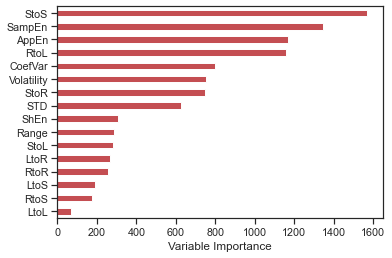

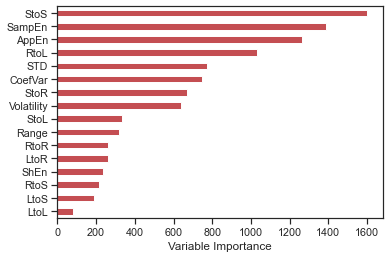

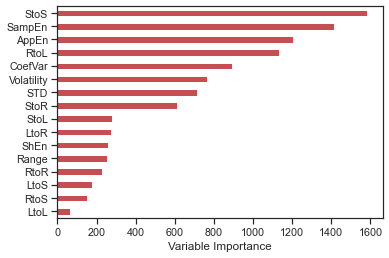

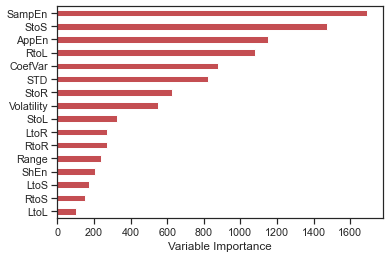

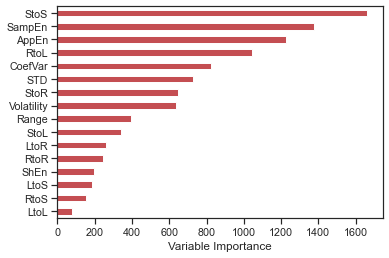

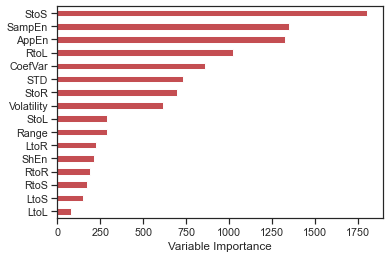

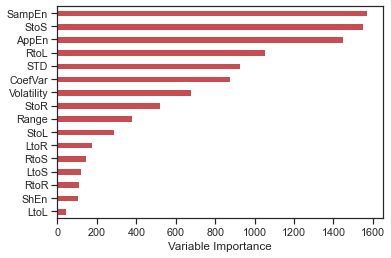

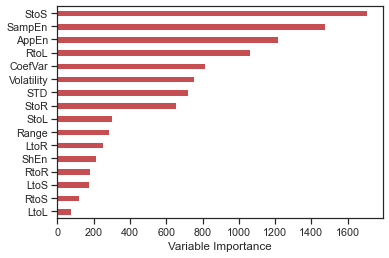

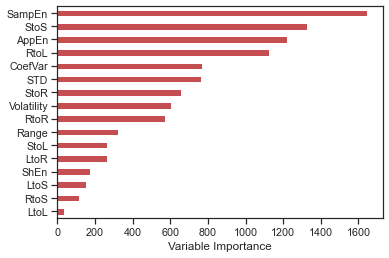

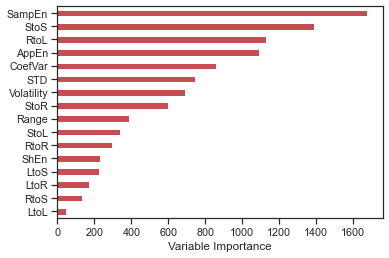

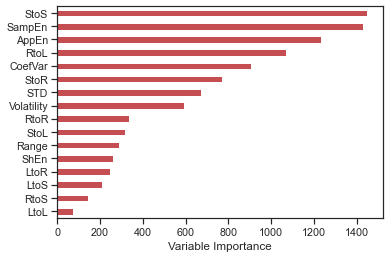

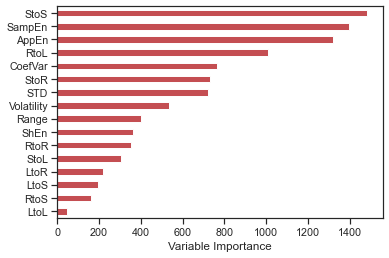

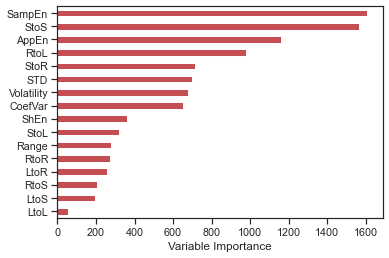

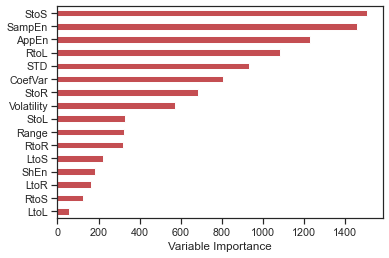

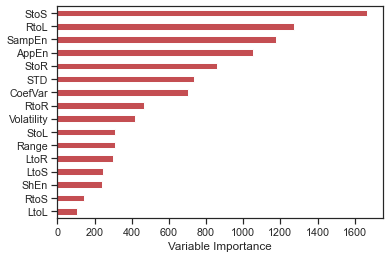

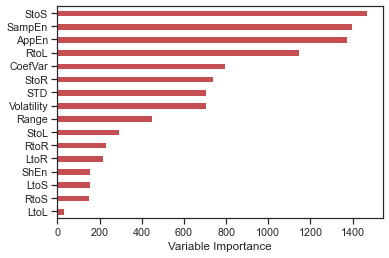

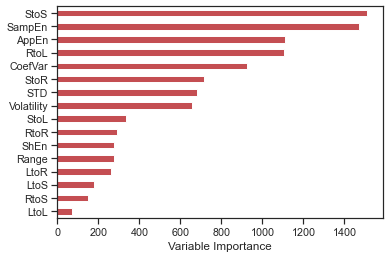

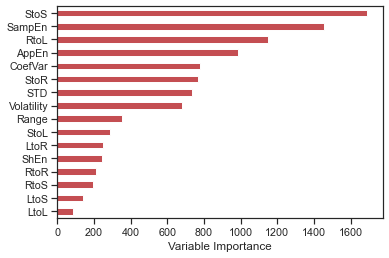

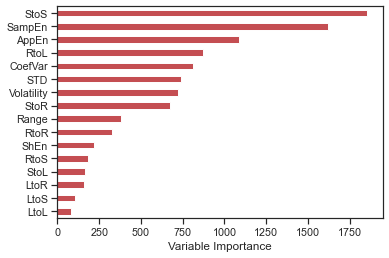

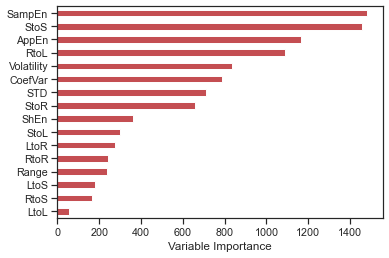

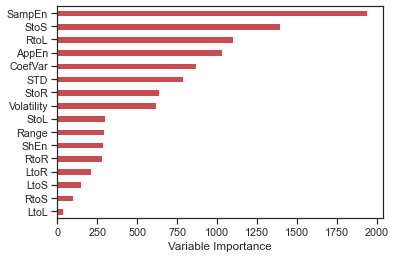

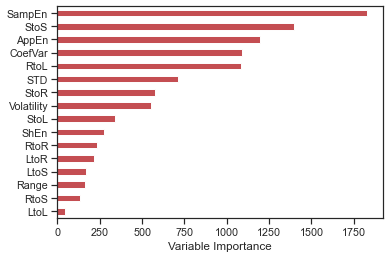

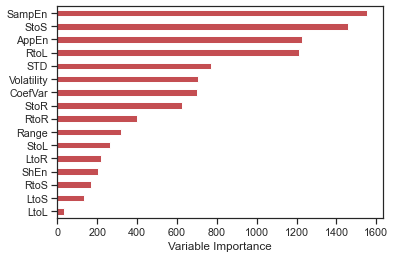

In [35]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
 
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
    temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
    param_distributions = {'iterations': randint(90, 110),
                           'depth': randint(3,10)}
    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=search.best_params_['iterations'], learning_rate=0.1, depth=search.best_params_['depth'], loss_function='Logloss')
    model.fit(X_train, y_train)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [36]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[23080  1663]
 [ 1777 18448]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968



# Please neglect: The following are some codes to be developed

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html